In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
balanced_categories = False
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
balanced_categories = False
max_training_samples = 200000
enable_orig = "orig"
enable_aug = False
enable_aug3 = True
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = False
lstm_hidden_size = 256
epochs = 20
experiment_id = "classification-sentence-embeddings-balanced_categories-False-max_training_samples-200000-enable_orig-orig-enable_aug-False-enable_aug3-True-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-False-lstm_hidden_size-256-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    global data
    if enable_orig == "big" or enable_orig == "big-preprocess":
        data += load_gen_dataset("./yelp_dataset/more_yelp_234.json")
    if balanced_categories:
        orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    else:
        orig_data_uniform = data
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess" or enable_orig == "big-preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
if not balanced_categories:
    split_key += "-unbalanced"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

200000


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

200000
200000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs == True and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        if sentence_pairs == "3" and len(sents) > 2:
            sents = [a + b + c for a, b, c in zip(sents, sents[1:], sents[2:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs == True and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        if sentence_pairs == "3" and len(sents) > 2:
            sents = [a + b + c for a, b, c in zip(sents, sents[1:], sents[2:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    if sentence_pairs == "3":
        finetuning_data_key += f"-pairs"
    else:
        finetuning_data_key += f"-pairs-{sentence_pairs}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


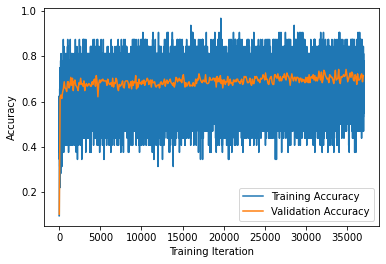

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs == True and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        if sentence_pairs == "3" and len(sents) > 2:
            sents = [a + b + c for a, b, c in zip(sents, sents[1:], sents[2:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.162 Validation Loss: 2.157 Accuracy: 0.195 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.160 Validation Loss: 2.157 Accuracy: 0.188 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.157 Validation Loss: 2.157 Accuracy: 0.219 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.159 Validation Loss: 2.157 Accuracy: 0.209 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.157 Validation Loss: 2.157 Accuracy: 0.208 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.156 Validation Loss: 2.157 Accuracy: 0.211 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.155 Validation Loss: 2.157 Accuracy: 0.213 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.154 Validation Loss: 2.157 Accuracy: 0.215 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.154 Validation Loss: 2.157 Accuracy: 0.220 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.153 Validation Loss: 2.157 Accuracy: 0.230 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.152 Validation Loss: 2.157 Accuracy: 0.238 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.151 Validation Loss: 2.157 Accuracy: 0.248 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.151 Validation Loss: 2.157 Accuracy: 0.254 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.150 Validation Loss: 2.157 Accuracy: 0.264 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.150 Validation Loss: 2.157 Accuracy: 0.266 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.150 Validation Loss: 2.157 Accuracy: 0.275 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.148 Validation Loss: 2.157 Accuracy: 0.284 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.148 Validation Loss: 2.157 Accuracy: 0.298 Validation Accuracy: 0.199:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.148 Validation Loss: 2.157 Accuracy: 0.298 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 18 Loss: 2.147 Validation Loss: 2.157 Accuracy: 0.303 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 19 Loss: 2.145 Validation Loss: 2.157 Accuracy: 0.305 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 20 Loss: 2.143 Validation Loss: 2.157 Accuracy: 0.313 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 21 Loss: 2.141 Validation Loss: 2.157 Accuracy: 0.321 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 22 Loss: 2.139 Validation Loss: 2.157 Accuracy: 0.320 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 23 Loss: 2.137 Validation Loss: 2.157 Accuracy: 0.333 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 24 Loss: 2.135 Validation Loss: 2.157 Accuracy: 0.348 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 25 Loss: 2.133 Validation Loss: 2.157 Accuracy: 0.358 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 26 Loss: 2.132 Validation Loss: 2.157 Accuracy: 0.363 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 27 Loss: 2.130 Validation Loss: 2.157 Accuracy: 0.366 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 28 Loss: 2.127 Validation Loss: 2.157 Accuracy: 0.378 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 29 Loss: 2.125 Validation Loss: 2.157 Accuracy: 0.385 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 30 Loss: 2.123 Validation Loss: 2.157 Accuracy: 0.391 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 31 Loss: 2.121 Validation Loss: 2.157 Accuracy: 0.398 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 32 Loss: 2.118 Validation Loss: 2.157 Accuracy: 0.412 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 33 Loss: 2.116 Validation Loss: 2.157 Accuracy: 0.414 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 34 Loss: 2.112 Validation Loss: 2.157 Accuracy: 0.427 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 35 Loss: 2.109 Validation Loss: 2.157 Accuracy: 0.433 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 36 Loss: 2.108 Validation Loss: 2.157 Accuracy: 0.443 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 37 Loss: 2.106 Validation Loss: 2.157 Accuracy: 0.441 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 38 Loss: 2.105 Validation Loss: 2.157 Accuracy: 0.442 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 39 Loss: 2.103 Validation Loss: 2.157 Accuracy: 0.441 Validation Accuracy: 0.199:   1%|          | 18/1563 [00:00<00:08, 175.54it/s]

Epoch: 0 Iteration: 39 Loss: 2.103 Validation Loss: 2.157 Accuracy: 0.441 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 40 Loss: 2.102 Validation Loss: 2.157 Accuracy: 0.452 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 41 Loss: 2.099 Validation Loss: 2.157 Accuracy: 0.471 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 42 Loss: 2.097 Validation Loss: 2.157 Accuracy: 0.473 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 43 Loss: 2.096 Validation Loss: 2.157 Accuracy: 0.480 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 44 Loss: 2.093 Validation Loss: 2.157 Accuracy: 0.478 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 45 Loss: 2.091 Validation Loss: 2.157 Accuracy: 0.484 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 46 Loss: 2.088 Validation Loss: 2.157 Accuracy: 0.488 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 47 Loss: 2.087 Validation Loss: 2.157 Accuracy: 0.492 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 48 Loss: 2.086 Validation Loss: 2.157 Accuracy: 0.508 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 49 Loss: 2.083 Validation Loss: 2.157 Accuracy: 0.516 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 50 Loss: 2.082 Validation Loss: 2.157 Accuracy: 0.519 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 51 Loss: 2.082 Validation Loss: 2.157 Accuracy: 0.509 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 52 Loss: 2.079 Validation Loss: 2.157 Accuracy: 0.520 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 53 Loss: 2.077 Validation Loss: 2.157 Accuracy: 0.525 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 54 Loss: 2.076 Validation Loss: 2.157 Accuracy: 0.531 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 55 Loss: 2.075 Validation Loss: 2.157 Accuracy: 0.535 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 56 Loss: 2.074 Validation Loss: 2.157 Accuracy: 0.537 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 57 Loss: 2.071 Validation Loss: 2.157 Accuracy: 0.556 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 58 Loss: 2.069 Validation Loss: 2.157 Accuracy: 0.550 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 59 Loss: 2.067 Validation Loss: 2.157 Accuracy: 0.556 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 60 Loss: 2.065 Validation Loss: 2.157 Accuracy: 0.559 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 61 Loss: 2.063 Validation Loss: 2.157 Accuracy: 0.575 Validation Accuracy: 0.199:   3%|▎         | 40/1563 [00:00<00:07, 197.84it/s]

Epoch: 0 Iteration: 61 Loss: 2.063 Validation Loss: 2.157 Accuracy: 0.575 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 62 Loss: 2.061 Validation Loss: 2.157 Accuracy: 0.577 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 63 Loss: 2.060 Validation Loss: 2.157 Accuracy: 0.576 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 64 Loss: 2.056 Validation Loss: 2.157 Accuracy: 0.586 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 65 Loss: 2.055 Validation Loss: 2.157 Accuracy: 0.595 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 66 Loss: 2.052 Validation Loss: 2.157 Accuracy: 0.607 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 67 Loss: 2.049 Validation Loss: 2.157 Accuracy: 0.605 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 68 Loss: 2.050 Validation Loss: 2.157 Accuracy: 0.612 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 69 Loss: 2.046 Validation Loss: 2.157 Accuracy: 0.622 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 70 Loss: 2.044 Validation Loss: 2.157 Accuracy: 0.624 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 71 Loss: 2.040 Validation Loss: 2.157 Accuracy: 0.622 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 72 Loss: 2.039 Validation Loss: 2.157 Accuracy: 0.622 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 73 Loss: 2.039 Validation Loss: 2.157 Accuracy: 0.634 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 74 Loss: 2.040 Validation Loss: 2.157 Accuracy: 0.624 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 75 Loss: 2.037 Validation Loss: 2.157 Accuracy: 0.616 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 76 Loss: 2.032 Validation Loss: 2.157 Accuracy: 0.626 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 77 Loss: 2.030 Validation Loss: 2.157 Accuracy: 0.634 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 78 Loss: 2.029 Validation Loss: 2.157 Accuracy: 0.636 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 79 Loss: 2.026 Validation Loss: 2.157 Accuracy: 0.639 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 80 Loss: 2.027 Validation Loss: 2.157 Accuracy: 0.632 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 81 Loss: 2.024 Validation Loss: 2.157 Accuracy: 0.633 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 82 Loss: 2.022 Validation Loss: 2.157 Accuracy: 0.634 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 83 Loss: 2.020 Validation Loss: 2.157 Accuracy: 0.632 Validation Accuracy: 0.199:   4%|▍         | 62/1563 [00:00<00:07, 206.65it/s]

Epoch: 0 Iteration: 83 Loss: 2.020 Validation Loss: 2.157 Accuracy: 0.632 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 84 Loss: 2.018 Validation Loss: 2.157 Accuracy: 0.641 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 85 Loss: 2.016 Validation Loss: 2.157 Accuracy: 0.651 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 86 Loss: 2.015 Validation Loss: 2.157 Accuracy: 0.641 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 87 Loss: 2.013 Validation Loss: 2.157 Accuracy: 0.641 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 88 Loss: 2.007 Validation Loss: 2.157 Accuracy: 0.650 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 89 Loss: 2.009 Validation Loss: 2.157 Accuracy: 0.637 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 90 Loss: 2.008 Validation Loss: 2.157 Accuracy: 0.650 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 91 Loss: 2.009 Validation Loss: 2.157 Accuracy: 0.647 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 92 Loss: 2.009 Validation Loss: 2.157 Accuracy: 0.654 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 93 Loss: 2.006 Validation Loss: 2.157 Accuracy: 0.659 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 94 Loss: 2.001 Validation Loss: 2.157 Accuracy: 0.665 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 95 Loss: 1.996 Validation Loss: 2.157 Accuracy: 0.668 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 96 Loss: 1.993 Validation Loss: 2.157 Accuracy: 0.673 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 97 Loss: 1.989 Validation Loss: 2.157 Accuracy: 0.679 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 98 Loss: 1.985 Validation Loss: 2.157 Accuracy: 0.676 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 99 Loss: 1.984 Validation Loss: 2.157 Accuracy: 0.689 Validation Accuracy: 0.199:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 100 Loss: 1.982 Validation Loss: 1.955 Accuracy: 0.687 Validation Accuracy: 0.434:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 101 Loss: 1.981 Validation Loss: 1.955 Accuracy: 0.693 Validation Accuracy: 0.434:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 102 Loss: 1.978 Validation Loss: 1.955 Accuracy: 0.687 Validation Accuracy: 0.434:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 103 Loss: 1.977 Validation Loss: 1.955 Accuracy: 0.684 Validation Accuracy: 0.434:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 104 Loss: 1.974 Validation Loss: 1.955 Accuracy: 0.687 Validation Accuracy: 0.434:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 105 Loss: 1.971 Validation Loss: 1.955 Accuracy: 0.681 Validation Accuracy: 0.434:   5%|▌         | 84/1563 [00:00<00:07, 210.42it/s]

Epoch: 0 Iteration: 105 Loss: 1.971 Validation Loss: 1.955 Accuracy: 0.681 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 106 Loss: 1.968 Validation Loss: 1.955 Accuracy: 0.679 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 107 Loss: 1.967 Validation Loss: 1.955 Accuracy: 0.669 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 108 Loss: 1.964 Validation Loss: 1.955 Accuracy: 0.669 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 109 Loss: 1.962 Validation Loss: 1.955 Accuracy: 0.664 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 110 Loss: 1.954 Validation Loss: 1.955 Accuracy: 0.669 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 111 Loss: 1.948 Validation Loss: 1.955 Accuracy: 0.667 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 112 Loss: 1.945 Validation Loss: 1.955 Accuracy: 0.672 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 113 Loss: 1.942 Validation Loss: 1.955 Accuracy: 0.673 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 114 Loss: 1.942 Validation Loss: 1.955 Accuracy: 0.666 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 115 Loss: 1.943 Validation Loss: 1.955 Accuracy: 0.668 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 116 Loss: 1.938 Validation Loss: 1.955 Accuracy: 0.679 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 117 Loss: 1.937 Validation Loss: 1.955 Accuracy: 0.683 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 118 Loss: 1.935 Validation Loss: 1.955 Accuracy: 0.683 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 119 Loss: 1.931 Validation Loss: 1.955 Accuracy: 0.691 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 120 Loss: 1.930 Validation Loss: 1.955 Accuracy: 0.681 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 121 Loss: 1.929 Validation Loss: 1.955 Accuracy: 0.687 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 122 Loss: 1.927 Validation Loss: 1.955 Accuracy: 0.687 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 123 Loss: 1.925 Validation Loss: 1.955 Accuracy: 0.685 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 124 Loss: 1.922 Validation Loss: 1.955 Accuracy: 0.691 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 125 Loss: 1.920 Validation Loss: 1.955 Accuracy: 0.698 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 126 Loss: 1.916 Validation Loss: 1.955 Accuracy: 0.688 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 127 Loss: 1.913 Validation Loss: 1.955 Accuracy: 0.684 Validation Accuracy: 0.434:   7%|▋         | 106/1563 [00:00<00:07, 207.51it/s]

Epoch: 0 Iteration: 127 Loss: 1.913 Validation Loss: 1.955 Accuracy: 0.684 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 128 Loss: 1.915 Validation Loss: 1.955 Accuracy: 0.677 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 129 Loss: 1.905 Validation Loss: 1.955 Accuracy: 0.678 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 130 Loss: 1.904 Validation Loss: 1.955 Accuracy: 0.688 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 131 Loss: 1.903 Validation Loss: 1.955 Accuracy: 0.679 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 132 Loss: 1.900 Validation Loss: 1.955 Accuracy: 0.676 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 133 Loss: 1.894 Validation Loss: 1.955 Accuracy: 0.677 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 134 Loss: 1.887 Validation Loss: 1.955 Accuracy: 0.677 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 135 Loss: 1.883 Validation Loss: 1.955 Accuracy: 0.676 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 136 Loss: 1.883 Validation Loss: 1.955 Accuracy: 0.671 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 137 Loss: 1.881 Validation Loss: 1.955 Accuracy: 0.680 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 138 Loss: 1.878 Validation Loss: 1.955 Accuracy: 0.679 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 139 Loss: 1.874 Validation Loss: 1.955 Accuracy: 0.681 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 140 Loss: 1.869 Validation Loss: 1.955 Accuracy: 0.673 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 141 Loss: 1.863 Validation Loss: 1.955 Accuracy: 0.677 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 142 Loss: 1.860 Validation Loss: 1.955 Accuracy: 0.680 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 143 Loss: 1.856 Validation Loss: 1.955 Accuracy: 0.677 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 144 Loss: 1.849 Validation Loss: 1.955 Accuracy: 0.679 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 145 Loss: 1.845 Validation Loss: 1.955 Accuracy: 0.668 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 146 Loss: 1.842 Validation Loss: 1.955 Accuracy: 0.669 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 147 Loss: 1.840 Validation Loss: 1.955 Accuracy: 0.662 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 148 Loss: 1.836 Validation Loss: 1.955 Accuracy: 0.668 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 149 Loss: 1.837 Validation Loss: 1.955 Accuracy: 0.661 Validation Accuracy: 0.434:   8%|▊         | 128/1563 [00:00<00:06, 209.90it/s]

Epoch: 0 Iteration: 149 Loss: 1.837 Validation Loss: 1.955 Accuracy: 0.661 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 150 Loss: 1.836 Validation Loss: 1.955 Accuracy: 0.667 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 151 Loss: 1.831 Validation Loss: 1.955 Accuracy: 0.667 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 152 Loss: 1.827 Validation Loss: 1.955 Accuracy: 0.663 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 153 Loss: 1.825 Validation Loss: 1.955 Accuracy: 0.668 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 154 Loss: 1.823 Validation Loss: 1.955 Accuracy: 0.654 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 155 Loss: 1.821 Validation Loss: 1.955 Accuracy: 0.659 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 156 Loss: 1.822 Validation Loss: 1.955 Accuracy: 0.658 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 157 Loss: 1.821 Validation Loss: 1.955 Accuracy: 0.659 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 158 Loss: 1.821 Validation Loss: 1.955 Accuracy: 0.659 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 159 Loss: 1.820 Validation Loss: 1.955 Accuracy: 0.659 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 160 Loss: 1.817 Validation Loss: 1.955 Accuracy: 0.653 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 161 Loss: 1.815 Validation Loss: 1.955 Accuracy: 0.647 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 162 Loss: 1.809 Validation Loss: 1.955 Accuracy: 0.652 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 163 Loss: 1.806 Validation Loss: 1.955 Accuracy: 0.652 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 164 Loss: 1.812 Validation Loss: 1.955 Accuracy: 0.650 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 165 Loss: 1.812 Validation Loss: 1.955 Accuracy: 0.648 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 166 Loss: 1.808 Validation Loss: 1.955 Accuracy: 0.652 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 167 Loss: 1.804 Validation Loss: 1.955 Accuracy: 0.648 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 168 Loss: 1.798 Validation Loss: 1.955 Accuracy: 0.655 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 169 Loss: 1.797 Validation Loss: 1.955 Accuracy: 0.655 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 170 Loss: 1.796 Validation Loss: 1.955 Accuracy: 0.657 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 171 Loss: 1.788 Validation Loss: 1.955 Accuracy: 0.667 Validation Accuracy: 0.434:  10%|▉         | 150/1563 [00:00<00:06, 211.91it/s]

Epoch: 0 Iteration: 171 Loss: 1.788 Validation Loss: 1.955 Accuracy: 0.667 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 172 Loss: 1.785 Validation Loss: 1.955 Accuracy: 0.667 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 173 Loss: 1.783 Validation Loss: 1.955 Accuracy: 0.664 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 174 Loss: 1.785 Validation Loss: 1.955 Accuracy: 0.664 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 175 Loss: 1.781 Validation Loss: 1.955 Accuracy: 0.658 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 176 Loss: 1.774 Validation Loss: 1.955 Accuracy: 0.665 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 177 Loss: 1.765 Validation Loss: 1.955 Accuracy: 0.670 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 178 Loss: 1.761 Validation Loss: 1.955 Accuracy: 0.656 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 179 Loss: 1.757 Validation Loss: 1.955 Accuracy: 0.647 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 180 Loss: 1.752 Validation Loss: 1.955 Accuracy: 0.650 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 181 Loss: 1.752 Validation Loss: 1.955 Accuracy: 0.635 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 182 Loss: 1.751 Validation Loss: 1.955 Accuracy: 0.630 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 183 Loss: 1.750 Validation Loss: 1.955 Accuracy: 0.625 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 184 Loss: 1.746 Validation Loss: 1.955 Accuracy: 0.624 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 185 Loss: 1.740 Validation Loss: 1.955 Accuracy: 0.630 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 186 Loss: 1.740 Validation Loss: 1.955 Accuracy: 0.624 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 187 Loss: 1.736 Validation Loss: 1.955 Accuracy: 0.619 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 188 Loss: 1.735 Validation Loss: 1.955 Accuracy: 0.623 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 189 Loss: 1.733 Validation Loss: 1.955 Accuracy: 0.630 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 190 Loss: 1.729 Validation Loss: 1.955 Accuracy: 0.628 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 191 Loss: 1.735 Validation Loss: 1.955 Accuracy: 0.629 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 192 Loss: 1.733 Validation Loss: 1.955 Accuracy: 0.630 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 193 Loss: 1.729 Validation Loss: 1.955 Accuracy: 0.636 Validation Accuracy: 0.434:  11%|█         | 172/1563 [00:00<00:06, 213.04it/s]

Epoch: 0 Iteration: 193 Loss: 1.729 Validation Loss: 1.955 Accuracy: 0.636 Validation Accuracy: 0.434:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 194 Loss: 1.722 Validation Loss: 1.955 Accuracy: 0.642 Validation Accuracy: 0.434:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 195 Loss: 1.720 Validation Loss: 1.955 Accuracy: 0.641 Validation Accuracy: 0.434:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 196 Loss: 1.715 Validation Loss: 1.955 Accuracy: 0.637 Validation Accuracy: 0.434:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 197 Loss: 1.716 Validation Loss: 1.955 Accuracy: 0.636 Validation Accuracy: 0.434:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 198 Loss: 1.711 Validation Loss: 1.955 Accuracy: 0.634 Validation Accuracy: 0.434:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 199 Loss: 1.704 Validation Loss: 1.955 Accuracy: 0.640 Validation Accuracy: 0.434:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 200 Loss: 1.699 Validation Loss: 1.657 Accuracy: 0.641 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 201 Loss: 1.699 Validation Loss: 1.657 Accuracy: 0.643 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 202 Loss: 1.696 Validation Loss: 1.657 Accuracy: 0.641 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 203 Loss: 1.691 Validation Loss: 1.657 Accuracy: 0.640 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 204 Loss: 1.682 Validation Loss: 1.657 Accuracy: 0.642 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 205 Loss: 1.679 Validation Loss: 1.657 Accuracy: 0.643 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 206 Loss: 1.674 Validation Loss: 1.657 Accuracy: 0.643 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 207 Loss: 1.671 Validation Loss: 1.657 Accuracy: 0.638 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:00<00:06, 213.65it/s]

Epoch: 0 Iteration: 208 Loss: 1.666 Validation Loss: 1.657 Accuracy: 0.648 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:01<00:06, 213.65it/s]

Epoch: 0 Iteration: 209 Loss: 1.660 Validation Loss: 1.657 Accuracy: 0.642 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:01<00:06, 213.65it/s]

Epoch: 0 Iteration: 210 Loss: 1.655 Validation Loss: 1.657 Accuracy: 0.642 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:01<00:06, 213.65it/s]

Epoch: 0 Iteration: 211 Loss: 1.648 Validation Loss: 1.657 Accuracy: 0.648 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:01<00:06, 213.65it/s]

Epoch: 0 Iteration: 212 Loss: 1.646 Validation Loss: 1.657 Accuracy: 0.645 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:01<00:06, 213.65it/s]

Epoch: 0 Iteration: 213 Loss: 1.647 Validation Loss: 1.657 Accuracy: 0.638 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:01<00:06, 213.65it/s]

Epoch: 0 Iteration: 214 Loss: 1.642 Validation Loss: 1.657 Accuracy: 0.634 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:01<00:06, 213.65it/s]

Epoch: 0 Iteration: 215 Loss: 1.635 Validation Loss: 1.657 Accuracy: 0.636 Validation Accuracy: 0.515:  12%|█▏        | 194/1563 [00:01<00:06, 213.65it/s]

Epoch: 0 Iteration: 215 Loss: 1.635 Validation Loss: 1.657 Accuracy: 0.636 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 216 Loss: 1.632 Validation Loss: 1.657 Accuracy: 0.638 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 217 Loss: 1.628 Validation Loss: 1.657 Accuracy: 0.645 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 218 Loss: 1.622 Validation Loss: 1.657 Accuracy: 0.647 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 219 Loss: 1.622 Validation Loss: 1.657 Accuracy: 0.649 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 220 Loss: 1.619 Validation Loss: 1.657 Accuracy: 0.652 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 221 Loss: 1.609 Validation Loss: 1.657 Accuracy: 0.654 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 222 Loss: 1.604 Validation Loss: 1.657 Accuracy: 0.659 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 223 Loss: 1.601 Validation Loss: 1.657 Accuracy: 0.667 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 224 Loss: 1.599 Validation Loss: 1.657 Accuracy: 0.671 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 225 Loss: 1.598 Validation Loss: 1.657 Accuracy: 0.668 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 226 Loss: 1.596 Validation Loss: 1.657 Accuracy: 0.670 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 227 Loss: 1.597 Validation Loss: 1.657 Accuracy: 0.663 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 228 Loss: 1.594 Validation Loss: 1.657 Accuracy: 0.653 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 229 Loss: 1.588 Validation Loss: 1.657 Accuracy: 0.654 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 230 Loss: 1.588 Validation Loss: 1.657 Accuracy: 0.646 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 231 Loss: 1.589 Validation Loss: 1.657 Accuracy: 0.640 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 232 Loss: 1.578 Validation Loss: 1.657 Accuracy: 0.648 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 233 Loss: 1.569 Validation Loss: 1.657 Accuracy: 0.647 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 234 Loss: 1.571 Validation Loss: 1.657 Accuracy: 0.645 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 235 Loss: 1.570 Validation Loss: 1.657 Accuracy: 0.651 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 236 Loss: 1.565 Validation Loss: 1.657 Accuracy: 0.651 Validation Accuracy: 0.515:  14%|█▍        | 216/1563 [00:01<00:06, 208.48it/s]

Epoch: 0 Iteration: 236 Loss: 1.565 Validation Loss: 1.657 Accuracy: 0.651 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 237 Loss: 1.564 Validation Loss: 1.657 Accuracy: 0.652 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 238 Loss: 1.562 Validation Loss: 1.657 Accuracy: 0.655 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 239 Loss: 1.564 Validation Loss: 1.657 Accuracy: 0.646 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 240 Loss: 1.563 Validation Loss: 1.657 Accuracy: 0.648 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 241 Loss: 1.565 Validation Loss: 1.657 Accuracy: 0.648 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 242 Loss: 1.567 Validation Loss: 1.657 Accuracy: 0.635 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 243 Loss: 1.561 Validation Loss: 1.657 Accuracy: 0.633 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 244 Loss: 1.557 Validation Loss: 1.657 Accuracy: 0.634 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 245 Loss: 1.554 Validation Loss: 1.657 Accuracy: 0.632 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 246 Loss: 1.555 Validation Loss: 1.657 Accuracy: 0.621 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 247 Loss: 1.549 Validation Loss: 1.657 Accuracy: 0.623 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 248 Loss: 1.549 Validation Loss: 1.657 Accuracy: 0.620 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 249 Loss: 1.549 Validation Loss: 1.657 Accuracy: 0.626 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 250 Loss: 1.541 Validation Loss: 1.657 Accuracy: 0.630 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 251 Loss: 1.534 Validation Loss: 1.657 Accuracy: 0.628 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 252 Loss: 1.534 Validation Loss: 1.657 Accuracy: 0.637 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 253 Loss: 1.532 Validation Loss: 1.657 Accuracy: 0.638 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 254 Loss: 1.527 Validation Loss: 1.657 Accuracy: 0.638 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 255 Loss: 1.526 Validation Loss: 1.657 Accuracy: 0.634 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 256 Loss: 1.526 Validation Loss: 1.657 Accuracy: 0.640 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 257 Loss: 1.515 Validation Loss: 1.657 Accuracy: 0.654 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 258 Loss: 1.515 Validation Loss: 1.657 Accuracy: 0.652 Validation Accuracy: 0.515:  15%|█▌        | 237/1563 [00:01<00:06, 208.89it/s]

Epoch: 0 Iteration: 258 Loss: 1.515 Validation Loss: 1.657 Accuracy: 0.652 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 259 Loss: 1.510 Validation Loss: 1.657 Accuracy: 0.644 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 260 Loss: 1.508 Validation Loss: 1.657 Accuracy: 0.642 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 261 Loss: 1.497 Validation Loss: 1.657 Accuracy: 0.648 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 262 Loss: 1.482 Validation Loss: 1.657 Accuracy: 0.652 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 263 Loss: 1.481 Validation Loss: 1.657 Accuracy: 0.658 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 264 Loss: 1.479 Validation Loss: 1.657 Accuracy: 0.665 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 265 Loss: 1.473 Validation Loss: 1.657 Accuracy: 0.670 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 266 Loss: 1.465 Validation Loss: 1.657 Accuracy: 0.670 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 267 Loss: 1.458 Validation Loss: 1.657 Accuracy: 0.657 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 268 Loss: 1.454 Validation Loss: 1.657 Accuracy: 0.663 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 269 Loss: 1.452 Validation Loss: 1.657 Accuracy: 0.673 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 270 Loss: 1.446 Validation Loss: 1.657 Accuracy: 0.675 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 271 Loss: 1.444 Validation Loss: 1.657 Accuracy: 0.668 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 272 Loss: 1.446 Validation Loss: 1.657 Accuracy: 0.655 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 273 Loss: 1.443 Validation Loss: 1.657 Accuracy: 0.648 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 274 Loss: 1.444 Validation Loss: 1.657 Accuracy: 0.635 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 275 Loss: 1.444 Validation Loss: 1.657 Accuracy: 0.626 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 276 Loss: 1.444 Validation Loss: 1.657 Accuracy: 0.619 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 277 Loss: 1.445 Validation Loss: 1.657 Accuracy: 0.622 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 278 Loss: 1.433 Validation Loss: 1.657 Accuracy: 0.630 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 279 Loss: 1.429 Validation Loss: 1.657 Accuracy: 0.628 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 280 Loss: 1.421 Validation Loss: 1.657 Accuracy: 0.627 Validation Accuracy: 0.515:  17%|█▋        | 259/1563 [00:01<00:06, 209.56it/s]

Epoch: 0 Iteration: 280 Loss: 1.421 Validation Loss: 1.657 Accuracy: 0.627 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 281 Loss: 1.418 Validation Loss: 1.657 Accuracy: 0.637 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 282 Loss: 1.422 Validation Loss: 1.657 Accuracy: 0.636 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 283 Loss: 1.416 Validation Loss: 1.657 Accuracy: 0.642 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 284 Loss: 1.420 Validation Loss: 1.657 Accuracy: 0.642 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 285 Loss: 1.414 Validation Loss: 1.657 Accuracy: 0.651 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 286 Loss: 1.411 Validation Loss: 1.657 Accuracy: 0.658 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 287 Loss: 1.408 Validation Loss: 1.657 Accuracy: 0.655 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 288 Loss: 1.407 Validation Loss: 1.657 Accuracy: 0.649 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 289 Loss: 1.401 Validation Loss: 1.657 Accuracy: 0.651 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 290 Loss: 1.397 Validation Loss: 1.657 Accuracy: 0.655 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 291 Loss: 1.392 Validation Loss: 1.657 Accuracy: 0.652 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 292 Loss: 1.382 Validation Loss: 1.657 Accuracy: 0.664 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 293 Loss: 1.379 Validation Loss: 1.657 Accuracy: 0.665 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 294 Loss: 1.372 Validation Loss: 1.657 Accuracy: 0.670 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 295 Loss: 1.366 Validation Loss: 1.657 Accuracy: 0.667 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 296 Loss: 1.360 Validation Loss: 1.657 Accuracy: 0.673 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 297 Loss: 1.356 Validation Loss: 1.657 Accuracy: 0.677 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 298 Loss: 1.361 Validation Loss: 1.657 Accuracy: 0.673 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 299 Loss: 1.348 Validation Loss: 1.657 Accuracy: 0.676 Validation Accuracy: 0.515:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 300 Loss: 1.341 Validation Loss: 1.260 Accuracy: 0.674 Validation Accuracy: 0.562:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 301 Loss: 1.337 Validation Loss: 1.260 Accuracy: 0.673 Validation Accuracy: 0.562:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 302 Loss: 1.335 Validation Loss: 1.260 Accuracy: 0.661 Validation Accuracy: 0.562:  18%|█▊        | 281/1563 [00:01<00:06, 211.83it/s]

Epoch: 0 Iteration: 302 Loss: 1.335 Validation Loss: 1.260 Accuracy: 0.661 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 303 Loss: 1.334 Validation Loss: 1.260 Accuracy: 0.653 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 304 Loss: 1.328 Validation Loss: 1.260 Accuracy: 0.651 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 305 Loss: 1.329 Validation Loss: 1.260 Accuracy: 0.654 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 306 Loss: 1.327 Validation Loss: 1.260 Accuracy: 0.646 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 307 Loss: 1.323 Validation Loss: 1.260 Accuracy: 0.642 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 308 Loss: 1.321 Validation Loss: 1.260 Accuracy: 0.641 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 309 Loss: 1.315 Validation Loss: 1.260 Accuracy: 0.636 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 310 Loss: 1.320 Validation Loss: 1.260 Accuracy: 0.629 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 311 Loss: 1.310 Validation Loss: 1.260 Accuracy: 0.632 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 312 Loss: 1.315 Validation Loss: 1.260 Accuracy: 0.634 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 313 Loss: 1.313 Validation Loss: 1.260 Accuracy: 0.634 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 314 Loss: 1.310 Validation Loss: 1.260 Accuracy: 0.637 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 315 Loss: 1.302 Validation Loss: 1.260 Accuracy: 0.640 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 316 Loss: 1.302 Validation Loss: 1.260 Accuracy: 0.644 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 317 Loss: 1.301 Validation Loss: 1.260 Accuracy: 0.644 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 318 Loss: 1.304 Validation Loss: 1.260 Accuracy: 0.641 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 319 Loss: 1.310 Validation Loss: 1.260 Accuracy: 0.634 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 320 Loss: 1.311 Validation Loss: 1.260 Accuracy: 0.644 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 321 Loss: 1.314 Validation Loss: 1.260 Accuracy: 0.639 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 322 Loss: 1.311 Validation Loss: 1.260 Accuracy: 0.643 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 323 Loss: 1.313 Validation Loss: 1.260 Accuracy: 0.644 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 324 Loss: 1.304 Validation Loss: 1.260 Accuracy: 0.646 Validation Accuracy: 0.562:  19%|█▉        | 303/1563 [00:01<00:06, 209.46it/s]

Epoch: 0 Iteration: 324 Loss: 1.304 Validation Loss: 1.260 Accuracy: 0.646 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 325 Loss: 1.294 Validation Loss: 1.260 Accuracy: 0.652 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 326 Loss: 1.293 Validation Loss: 1.260 Accuracy: 0.651 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 327 Loss: 1.284 Validation Loss: 1.260 Accuracy: 0.659 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 328 Loss: 1.281 Validation Loss: 1.260 Accuracy: 0.663 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 329 Loss: 1.282 Validation Loss: 1.260 Accuracy: 0.671 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 330 Loss: 1.274 Validation Loss: 1.260 Accuracy: 0.670 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 331 Loss: 1.273 Validation Loss: 1.260 Accuracy: 0.677 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 332 Loss: 1.265 Validation Loss: 1.260 Accuracy: 0.678 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 333 Loss: 1.267 Validation Loss: 1.260 Accuracy: 0.675 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 334 Loss: 1.262 Validation Loss: 1.260 Accuracy: 0.676 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 335 Loss: 1.261 Validation Loss: 1.260 Accuracy: 0.670 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 336 Loss: 1.251 Validation Loss: 1.260 Accuracy: 0.675 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 337 Loss: 1.247 Validation Loss: 1.260 Accuracy: 0.666 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 338 Loss: 1.231 Validation Loss: 1.260 Accuracy: 0.673 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 339 Loss: 1.227 Validation Loss: 1.260 Accuracy: 0.672 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 340 Loss: 1.217 Validation Loss: 1.260 Accuracy: 0.679 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 341 Loss: 1.216 Validation Loss: 1.260 Accuracy: 0.671 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 342 Loss: 1.209 Validation Loss: 1.260 Accuracy: 0.672 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 343 Loss: 1.200 Validation Loss: 1.260 Accuracy: 0.678 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 344 Loss: 1.208 Validation Loss: 1.260 Accuracy: 0.669 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 345 Loss: 1.204 Validation Loss: 1.260 Accuracy: 0.673 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 346 Loss: 1.190 Validation Loss: 1.260 Accuracy: 0.677 Validation Accuracy: 0.562:  21%|██        | 325/1563 [00:01<00:05, 211.26it/s]

Epoch: 0 Iteration: 346 Loss: 1.190 Validation Loss: 1.260 Accuracy: 0.677 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 347 Loss: 1.197 Validation Loss: 1.260 Accuracy: 0.678 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 348 Loss: 1.194 Validation Loss: 1.260 Accuracy: 0.675 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 349 Loss: 1.186 Validation Loss: 1.260 Accuracy: 0.683 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 350 Loss: 1.180 Validation Loss: 1.260 Accuracy: 0.676 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 351 Loss: 1.180 Validation Loss: 1.260 Accuracy: 0.683 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 352 Loss: 1.177 Validation Loss: 1.260 Accuracy: 0.680 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 353 Loss: 1.166 Validation Loss: 1.260 Accuracy: 0.683 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 354 Loss: 1.168 Validation Loss: 1.260 Accuracy: 0.686 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 355 Loss: 1.168 Validation Loss: 1.260 Accuracy: 0.677 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 356 Loss: 1.168 Validation Loss: 1.260 Accuracy: 0.674 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 357 Loss: 1.169 Validation Loss: 1.260 Accuracy: 0.675 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 358 Loss: 1.175 Validation Loss: 1.260 Accuracy: 0.673 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 359 Loss: 1.174 Validation Loss: 1.260 Accuracy: 0.662 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 360 Loss: 1.176 Validation Loss: 1.260 Accuracy: 0.663 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 361 Loss: 1.175 Validation Loss: 1.260 Accuracy: 0.655 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 362 Loss: 1.175 Validation Loss: 1.260 Accuracy: 0.656 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 363 Loss: 1.173 Validation Loss: 1.260 Accuracy: 0.658 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 364 Loss: 1.163 Validation Loss: 1.260 Accuracy: 0.660 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 365 Loss: 1.163 Validation Loss: 1.260 Accuracy: 0.670 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 366 Loss: 1.175 Validation Loss: 1.260 Accuracy: 0.659 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 367 Loss: 1.173 Validation Loss: 1.260 Accuracy: 0.660 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 368 Loss: 1.157 Validation Loss: 1.260 Accuracy: 0.674 Validation Accuracy: 0.562:  22%|██▏       | 347/1563 [00:01<00:05, 212.20it/s]

Epoch: 0 Iteration: 368 Loss: 1.157 Validation Loss: 1.260 Accuracy: 0.674 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 369 Loss: 1.160 Validation Loss: 1.260 Accuracy: 0.681 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 370 Loss: 1.162 Validation Loss: 1.260 Accuracy: 0.677 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 371 Loss: 1.158 Validation Loss: 1.260 Accuracy: 0.681 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 372 Loss: 1.156 Validation Loss: 1.260 Accuracy: 0.681 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 373 Loss: 1.154 Validation Loss: 1.260 Accuracy: 0.680 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 374 Loss: 1.148 Validation Loss: 1.260 Accuracy: 0.681 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 375 Loss: 1.141 Validation Loss: 1.260 Accuracy: 0.677 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 376 Loss: 1.141 Validation Loss: 1.260 Accuracy: 0.683 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 377 Loss: 1.135 Validation Loss: 1.260 Accuracy: 0.683 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 378 Loss: 1.128 Validation Loss: 1.260 Accuracy: 0.672 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 379 Loss: 1.122 Validation Loss: 1.260 Accuracy: 0.666 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 380 Loss: 1.123 Validation Loss: 1.260 Accuracy: 0.666 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 381 Loss: 1.115 Validation Loss: 1.260 Accuracy: 0.668 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 382 Loss: 1.115 Validation Loss: 1.260 Accuracy: 0.667 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 383 Loss: 1.120 Validation Loss: 1.260 Accuracy: 0.659 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 384 Loss: 1.123 Validation Loss: 1.260 Accuracy: 0.652 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 385 Loss: 1.122 Validation Loss: 1.260 Accuracy: 0.656 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 386 Loss: 1.116 Validation Loss: 1.260 Accuracy: 0.653 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 387 Loss: 1.106 Validation Loss: 1.260 Accuracy: 0.662 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 388 Loss: 1.108 Validation Loss: 1.260 Accuracy: 0.666 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 389 Loss: 1.106 Validation Loss: 1.260 Accuracy: 0.670 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 390 Loss: 1.104 Validation Loss: 1.260 Accuracy: 0.676 Validation Accuracy: 0.562:  24%|██▎       | 369/1563 [00:01<00:05, 212.61it/s]

Epoch: 0 Iteration: 390 Loss: 1.104 Validation Loss: 1.260 Accuracy: 0.676 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 391 Loss: 1.103 Validation Loss: 1.260 Accuracy: 0.674 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 392 Loss: 1.103 Validation Loss: 1.260 Accuracy: 0.675 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 393 Loss: 1.102 Validation Loss: 1.260 Accuracy: 0.678 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 394 Loss: 1.096 Validation Loss: 1.260 Accuracy: 0.691 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 395 Loss: 1.088 Validation Loss: 1.260 Accuracy: 0.689 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 396 Loss: 1.087 Validation Loss: 1.260 Accuracy: 0.693 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 397 Loss: 1.078 Validation Loss: 1.260 Accuracy: 0.691 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 398 Loss: 1.077 Validation Loss: 1.260 Accuracy: 0.687 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 399 Loss: 1.074 Validation Loss: 1.260 Accuracy: 0.689 Validation Accuracy: 0.562:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 400 Loss: 1.071 Validation Loss: 0.982 Accuracy: 0.689 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 401 Loss: 1.063 Validation Loss: 0.982 Accuracy: 0.698 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 402 Loss: 1.053 Validation Loss: 0.982 Accuracy: 0.705 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 403 Loss: 1.039 Validation Loss: 0.982 Accuracy: 0.714 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 404 Loss: 1.031 Validation Loss: 0.982 Accuracy: 0.713 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 405 Loss: 1.024 Validation Loss: 0.982 Accuracy: 0.716 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 406 Loss: 1.012 Validation Loss: 0.982 Accuracy: 0.720 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 407 Loss: 1.012 Validation Loss: 0.982 Accuracy: 0.715 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 408 Loss: 1.013 Validation Loss: 0.982 Accuracy: 0.717 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 409 Loss: 1.004 Validation Loss: 0.982 Accuracy: 0.721 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 410 Loss: 0.998 Validation Loss: 0.982 Accuracy: 0.723 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 411 Loss: 0.997 Validation Loss: 0.982 Accuracy: 0.715 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 412 Loss: 1.000 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  25%|██▌       | 391/1563 [00:01<00:05, 212.65it/s]

Epoch: 0 Iteration: 412 Loss: 1.000 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:01<00:05, 208.89it/s]

Epoch: 0 Iteration: 413 Loss: 0.995 Validation Loss: 0.982 Accuracy: 0.701 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:01<00:05, 208.89it/s]

Epoch: 0 Iteration: 414 Loss: 0.994 Validation Loss: 0.982 Accuracy: 0.700 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:01<00:05, 208.89it/s]

Epoch: 0 Iteration: 415 Loss: 1.007 Validation Loss: 0.982 Accuracy: 0.684 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:01<00:05, 208.89it/s]

Epoch: 0 Iteration: 416 Loss: 1.004 Validation Loss: 0.982 Accuracy: 0.684 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:01<00:05, 208.89it/s]

Epoch: 0 Iteration: 417 Loss: 1.009 Validation Loss: 0.982 Accuracy: 0.682 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:01<00:05, 208.89it/s]

Epoch: 0 Iteration: 418 Loss: 1.007 Validation Loss: 0.982 Accuracy: 0.682 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:01<00:05, 208.89it/s]

Epoch: 0 Iteration: 419 Loss: 1.001 Validation Loss: 0.982 Accuracy: 0.684 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 420 Loss: 1.008 Validation Loss: 0.982 Accuracy: 0.674 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 421 Loss: 1.013 Validation Loss: 0.982 Accuracy: 0.674 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 422 Loss: 1.011 Validation Loss: 0.982 Accuracy: 0.688 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 423 Loss: 1.011 Validation Loss: 0.982 Accuracy: 0.688 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 424 Loss: 1.005 Validation Loss: 0.982 Accuracy: 0.690 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 425 Loss: 1.015 Validation Loss: 0.982 Accuracy: 0.697 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 426 Loss: 1.019 Validation Loss: 0.982 Accuracy: 0.693 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 427 Loss: 1.021 Validation Loss: 0.982 Accuracy: 0.698 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 428 Loss: 1.022 Validation Loss: 0.982 Accuracy: 0.697 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 429 Loss: 1.030 Validation Loss: 0.982 Accuracy: 0.688 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 430 Loss: 1.037 Validation Loss: 0.982 Accuracy: 0.693 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 431 Loss: 1.040 Validation Loss: 0.982 Accuracy: 0.694 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 432 Loss: 1.030 Validation Loss: 0.982 Accuracy: 0.693 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 433 Loss: 1.030 Validation Loss: 0.982 Accuracy: 0.695 Validation Accuracy: 0.596:  26%|██▋       | 413/1563 [00:02<00:05, 208.89it/s]

Epoch: 0 Iteration: 433 Loss: 1.030 Validation Loss: 0.982 Accuracy: 0.695 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 434 Loss: 1.027 Validation Loss: 0.982 Accuracy: 0.698 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 435 Loss: 1.016 Validation Loss: 0.982 Accuracy: 0.703 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 436 Loss: 1.015 Validation Loss: 0.982 Accuracy: 0.698 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 437 Loss: 1.008 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 438 Loss: 1.000 Validation Loss: 0.982 Accuracy: 0.713 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 439 Loss: 1.004 Validation Loss: 0.982 Accuracy: 0.716 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 440 Loss: 0.994 Validation Loss: 0.982 Accuracy: 0.720 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 441 Loss: 0.997 Validation Loss: 0.982 Accuracy: 0.720 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 442 Loss: 0.994 Validation Loss: 0.982 Accuracy: 0.719 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 443 Loss: 0.995 Validation Loss: 0.982 Accuracy: 0.717 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 444 Loss: 0.995 Validation Loss: 0.982 Accuracy: 0.709 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 445 Loss: 0.988 Validation Loss: 0.982 Accuracy: 0.712 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 446 Loss: 0.988 Validation Loss: 0.982 Accuracy: 0.718 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 447 Loss: 0.988 Validation Loss: 0.982 Accuracy: 0.709 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 448 Loss: 0.982 Validation Loss: 0.982 Accuracy: 0.705 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 449 Loss: 0.981 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 450 Loss: 0.973 Validation Loss: 0.982 Accuracy: 0.698 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 451 Loss: 0.969 Validation Loss: 0.982 Accuracy: 0.695 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 452 Loss: 0.971 Validation Loss: 0.982 Accuracy: 0.690 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 453 Loss: 0.968 Validation Loss: 0.982 Accuracy: 0.691 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 454 Loss: 0.972 Validation Loss: 0.982 Accuracy: 0.691 Validation Accuracy: 0.596:  28%|██▊       | 434/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 454 Loss: 0.972 Validation Loss: 0.982 Accuracy: 0.691 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 455 Loss: 0.968 Validation Loss: 0.982 Accuracy: 0.695 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 456 Loss: 0.969 Validation Loss: 0.982 Accuracy: 0.692 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 457 Loss: 0.968 Validation Loss: 0.982 Accuracy: 0.701 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 458 Loss: 0.967 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 459 Loss: 0.959 Validation Loss: 0.982 Accuracy: 0.709 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 460 Loss: 0.953 Validation Loss: 0.982 Accuracy: 0.712 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 461 Loss: 0.945 Validation Loss: 0.982 Accuracy: 0.720 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 462 Loss: 0.959 Validation Loss: 0.982 Accuracy: 0.713 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 463 Loss: 0.953 Validation Loss: 0.982 Accuracy: 0.716 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 464 Loss: 0.953 Validation Loss: 0.982 Accuracy: 0.719 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 465 Loss: 0.948 Validation Loss: 0.982 Accuracy: 0.715 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 466 Loss: 0.937 Validation Loss: 0.982 Accuracy: 0.726 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 467 Loss: 0.928 Validation Loss: 0.982 Accuracy: 0.726 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 468 Loss: 0.928 Validation Loss: 0.982 Accuracy: 0.722 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 469 Loss: 0.921 Validation Loss: 0.982 Accuracy: 0.718 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 470 Loss: 0.923 Validation Loss: 0.982 Accuracy: 0.713 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 471 Loss: 0.925 Validation Loss: 0.982 Accuracy: 0.709 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 472 Loss: 0.916 Validation Loss: 0.982 Accuracy: 0.719 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 473 Loss: 0.916 Validation Loss: 0.982 Accuracy: 0.716 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 474 Loss: 0.913 Validation Loss: 0.982 Accuracy: 0.713 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 475 Loss: 0.913 Validation Loss: 0.982 Accuracy: 0.713 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 476 Loss: 0.909 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  29%|██▉       | 455/1563 [00:02<00:05, 208.90it/s]

Epoch: 0 Iteration: 476 Loss: 0.909 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 477 Loss: 0.913 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 478 Loss: 0.911 Validation Loss: 0.982 Accuracy: 0.705 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 479 Loss: 0.919 Validation Loss: 0.982 Accuracy: 0.700 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 480 Loss: 0.916 Validation Loss: 0.982 Accuracy: 0.709 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 481 Loss: 0.915 Validation Loss: 0.982 Accuracy: 0.710 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 482 Loss: 0.907 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 483 Loss: 0.906 Validation Loss: 0.982 Accuracy: 0.708 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 484 Loss: 0.901 Validation Loss: 0.982 Accuracy: 0.712 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 485 Loss: 0.907 Validation Loss: 0.982 Accuracy: 0.709 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 486 Loss: 0.913 Validation Loss: 0.982 Accuracy: 0.710 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 487 Loss: 0.914 Validation Loss: 0.982 Accuracy: 0.709 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 488 Loss: 0.914 Validation Loss: 0.982 Accuracy: 0.703 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 489 Loss: 0.915 Validation Loss: 0.982 Accuracy: 0.705 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 490 Loss: 0.915 Validation Loss: 0.982 Accuracy: 0.698 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 491 Loss: 0.902 Validation Loss: 0.982 Accuracy: 0.705 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 492 Loss: 0.909 Validation Loss: 0.982 Accuracy: 0.707 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 493 Loss: 0.908 Validation Loss: 0.982 Accuracy: 0.704 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 494 Loss: 0.906 Validation Loss: 0.982 Accuracy: 0.701 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 495 Loss: 0.906 Validation Loss: 0.982 Accuracy: 0.702 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 496 Loss: 0.896 Validation Loss: 0.982 Accuracy: 0.709 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 497 Loss: 0.898 Validation Loss: 0.982 Accuracy: 0.704 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 498 Loss: 0.899 Validation Loss: 0.982 Accuracy: 0.713 Validation Accuracy: 0.596:  31%|███       | 477/1563 [00:02<00:05, 209.78it/s]

Epoch: 0 Iteration: 498 Loss: 0.899 Validation Loss: 0.982 Accuracy: 0.713 Validation Accuracy: 0.596:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 499 Loss: 0.891 Validation Loss: 0.982 Accuracy: 0.720 Validation Accuracy: 0.596:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 500 Loss: 0.903 Validation Loss: 0.831 Accuracy: 0.716 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 501 Loss: 0.909 Validation Loss: 0.831 Accuracy: 0.704 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 502 Loss: 0.905 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 503 Loss: 0.905 Validation Loss: 0.831 Accuracy: 0.704 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 504 Loss: 0.898 Validation Loss: 0.831 Accuracy: 0.713 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 505 Loss: 0.896 Validation Loss: 0.831 Accuracy: 0.710 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 506 Loss: 0.896 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 507 Loss: 0.896 Validation Loss: 0.831 Accuracy: 0.709 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 508 Loss: 0.897 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 509 Loss: 0.893 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 510 Loss: 0.889 Validation Loss: 0.831 Accuracy: 0.709 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 511 Loss: 0.898 Validation Loss: 0.831 Accuracy: 0.710 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 512 Loss: 0.893 Validation Loss: 0.831 Accuracy: 0.715 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 513 Loss: 0.888 Validation Loss: 0.831 Accuracy: 0.715 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 514 Loss: 0.886 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 515 Loss: 0.895 Validation Loss: 0.831 Accuracy: 0.698 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 516 Loss: 0.909 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 517 Loss: 0.899 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 518 Loss: 0.900 Validation Loss: 0.831 Accuracy: 0.687 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 519 Loss: 0.896 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 520 Loss: 0.880 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.618:  32%|███▏      | 499/1563 [00:02<00:05, 211.61it/s]

Epoch: 0 Iteration: 520 Loss: 0.880 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 521 Loss: 0.880 Validation Loss: 0.831 Accuracy: 0.693 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 522 Loss: 0.880 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 523 Loss: 0.883 Validation Loss: 0.831 Accuracy: 0.687 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 524 Loss: 0.886 Validation Loss: 0.831 Accuracy: 0.690 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 525 Loss: 0.880 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 526 Loss: 0.878 Validation Loss: 0.831 Accuracy: 0.712 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 527 Loss: 0.885 Validation Loss: 0.831 Accuracy: 0.701 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 528 Loss: 0.885 Validation Loss: 0.831 Accuracy: 0.696 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 529 Loss: 0.884 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 530 Loss: 0.879 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 531 Loss: 0.873 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 532 Loss: 0.879 Validation Loss: 0.831 Accuracy: 0.687 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 533 Loss: 0.880 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 534 Loss: 0.877 Validation Loss: 0.831 Accuracy: 0.693 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 535 Loss: 0.866 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 536 Loss: 0.861 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 537 Loss: 0.862 Validation Loss: 0.831 Accuracy: 0.697 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 538 Loss: 0.863 Validation Loss: 0.831 Accuracy: 0.703 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 539 Loss: 0.867 Validation Loss: 0.831 Accuracy: 0.709 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 540 Loss: 0.867 Validation Loss: 0.831 Accuracy: 0.713 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 541 Loss: 0.855 Validation Loss: 0.831 Accuracy: 0.715 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 542 Loss: 0.852 Validation Loss: 0.831 Accuracy: 0.720 Validation Accuracy: 0.618:  33%|███▎      | 521/1563 [00:02<00:04, 208.68it/s]

Epoch: 0 Iteration: 542 Loss: 0.852 Validation Loss: 0.831 Accuracy: 0.720 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 543 Loss: 0.855 Validation Loss: 0.831 Accuracy: 0.712 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 544 Loss: 0.853 Validation Loss: 0.831 Accuracy: 0.715 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 545 Loss: 0.860 Validation Loss: 0.831 Accuracy: 0.713 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 546 Loss: 0.859 Validation Loss: 0.831 Accuracy: 0.719 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 547 Loss: 0.859 Validation Loss: 0.831 Accuracy: 0.709 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 548 Loss: 0.853 Validation Loss: 0.831 Accuracy: 0.711 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 549 Loss: 0.855 Validation Loss: 0.831 Accuracy: 0.709 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 550 Loss: 0.855 Validation Loss: 0.831 Accuracy: 0.704 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 551 Loss: 0.852 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 552 Loss: 0.845 Validation Loss: 0.831 Accuracy: 0.704 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 553 Loss: 0.854 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 554 Loss: 0.855 Validation Loss: 0.831 Accuracy: 0.698 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 555 Loss: 0.855 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 556 Loss: 0.847 Validation Loss: 0.831 Accuracy: 0.707 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 557 Loss: 0.854 Validation Loss: 0.831 Accuracy: 0.707 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 558 Loss: 0.853 Validation Loss: 0.831 Accuracy: 0.704 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 559 Loss: 0.857 Validation Loss: 0.831 Accuracy: 0.700 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 560 Loss: 0.864 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 561 Loss: 0.875 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 562 Loss: 0.868 Validation Loss: 0.831 Accuracy: 0.697 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 563 Loss: 0.864 Validation Loss: 0.831 Accuracy: 0.704 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 564 Loss: 0.862 Validation Loss: 0.831 Accuracy: 0.707 Validation Accuracy: 0.618:  35%|███▍      | 543/1563 [00:02<00:04, 210.71it/s]

Epoch: 0 Iteration: 564 Loss: 0.862 Validation Loss: 0.831 Accuracy: 0.707 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 565 Loss: 0.855 Validation Loss: 0.831 Accuracy: 0.709 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 566 Loss: 0.856 Validation Loss: 0.831 Accuracy: 0.706 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 567 Loss: 0.849 Validation Loss: 0.831 Accuracy: 0.710 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 568 Loss: 0.846 Validation Loss: 0.831 Accuracy: 0.716 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 569 Loss: 0.846 Validation Loss: 0.831 Accuracy: 0.718 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 570 Loss: 0.845 Validation Loss: 0.831 Accuracy: 0.716 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 571 Loss: 0.851 Validation Loss: 0.831 Accuracy: 0.723 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 572 Loss: 0.851 Validation Loss: 0.831 Accuracy: 0.716 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 573 Loss: 0.843 Validation Loss: 0.831 Accuracy: 0.715 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 574 Loss: 0.842 Validation Loss: 0.831 Accuracy: 0.713 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 575 Loss: 0.846 Validation Loss: 0.831 Accuracy: 0.703 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 576 Loss: 0.844 Validation Loss: 0.831 Accuracy: 0.709 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 577 Loss: 0.843 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 578 Loss: 0.841 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 579 Loss: 0.840 Validation Loss: 0.831 Accuracy: 0.703 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 580 Loss: 0.840 Validation Loss: 0.831 Accuracy: 0.703 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 581 Loss: 0.834 Validation Loss: 0.831 Accuracy: 0.701 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 582 Loss: 0.840 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 583 Loss: 0.839 Validation Loss: 0.831 Accuracy: 0.704 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 584 Loss: 0.851 Validation Loss: 0.831 Accuracy: 0.697 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 585 Loss: 0.854 Validation Loss: 0.831 Accuracy: 0.704 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 586 Loss: 0.850 Validation Loss: 0.831 Accuracy: 0.700 Validation Accuracy: 0.618:  36%|███▌      | 565/1563 [00:02<00:04, 211.37it/s]

Epoch: 0 Iteration: 586 Loss: 0.850 Validation Loss: 0.831 Accuracy: 0.700 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 587 Loss: 0.847 Validation Loss: 0.831 Accuracy: 0.708 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 588 Loss: 0.846 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 589 Loss: 0.845 Validation Loss: 0.831 Accuracy: 0.707 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 590 Loss: 0.844 Validation Loss: 0.831 Accuracy: 0.709 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 591 Loss: 0.843 Validation Loss: 0.831 Accuracy: 0.714 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 592 Loss: 0.843 Validation Loss: 0.831 Accuracy: 0.711 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 593 Loss: 0.840 Validation Loss: 0.831 Accuracy: 0.713 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 594 Loss: 0.842 Validation Loss: 0.831 Accuracy: 0.718 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 595 Loss: 0.835 Validation Loss: 0.831 Accuracy: 0.720 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 596 Loss: 0.838 Validation Loss: 0.831 Accuracy: 0.718 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 597 Loss: 0.828 Validation Loss: 0.831 Accuracy: 0.716 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 598 Loss: 0.827 Validation Loss: 0.831 Accuracy: 0.716 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 599 Loss: 0.819 Validation Loss: 0.831 Accuracy: 0.723 Validation Accuracy: 0.618:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 600 Loss: 0.817 Validation Loss: 0.738 Accuracy: 0.721 Validation Accuracy: 0.635:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 601 Loss: 0.823 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 602 Loss: 0.819 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.635:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 603 Loss: 0.815 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.635:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 604 Loss: 0.805 Validation Loss: 0.738 Accuracy: 0.719 Validation Accuracy: 0.635:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 605 Loss: 0.804 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.635:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 606 Loss: 0.806 Validation Loss: 0.738 Accuracy: 0.715 Validation Accuracy: 0.635:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 607 Loss: 0.809 Validation Loss: 0.738 Accuracy: 0.715 Validation Accuracy: 0.635:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 608 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.635:  38%|███▊      | 587/1563 [00:02<00:04, 212.31it/s]

Epoch: 0 Iteration: 608 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 609 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 610 Loss: 0.799 Validation Loss: 0.738 Accuracy: 0.724 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 611 Loss: 0.795 Validation Loss: 0.738 Accuracy: 0.738 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 612 Loss: 0.789 Validation Loss: 0.738 Accuracy: 0.739 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 613 Loss: 0.791 Validation Loss: 0.738 Accuracy: 0.728 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 614 Loss: 0.787 Validation Loss: 0.738 Accuracy: 0.728 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 615 Loss: 0.788 Validation Loss: 0.738 Accuracy: 0.729 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 616 Loss: 0.786 Validation Loss: 0.738 Accuracy: 0.730 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 617 Loss: 0.791 Validation Loss: 0.738 Accuracy: 0.724 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 618 Loss: 0.795 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 619 Loss: 0.799 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 620 Loss: 0.796 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 621 Loss: 0.791 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 622 Loss: 0.797 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 623 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 624 Loss: 0.808 Validation Loss: 0.738 Accuracy: 0.697 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 625 Loss: 0.802 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 626 Loss: 0.797 Validation Loss: 0.738 Accuracy: 0.707 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 627 Loss: 0.793 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 628 Loss: 0.805 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:02<00:04, 209.27it/s]

Epoch: 0 Iteration: 629 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:03<00:04, 209.27it/s]

Epoch: 0 Iteration: 630 Loss: 0.800 Validation Loss: 0.738 Accuracy: 0.718 Validation Accuracy: 0.635:  39%|███▉      | 609/1563 [00:03<00:04, 209.27it/s]

Epoch: 0 Iteration: 630 Loss: 0.800 Validation Loss: 0.738 Accuracy: 0.718 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 631 Loss: 0.804 Validation Loss: 0.738 Accuracy: 0.723 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 632 Loss: 0.808 Validation Loss: 0.738 Accuracy: 0.721 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 633 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.725 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 634 Loss: 0.802 Validation Loss: 0.738 Accuracy: 0.724 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 635 Loss: 0.797 Validation Loss: 0.738 Accuracy: 0.726 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 636 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.717 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 637 Loss: 0.794 Validation Loss: 0.738 Accuracy: 0.721 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 638 Loss: 0.794 Validation Loss: 0.738 Accuracy: 0.721 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 639 Loss: 0.790 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 640 Loss: 0.791 Validation Loss: 0.738 Accuracy: 0.718 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 641 Loss: 0.781 Validation Loss: 0.738 Accuracy: 0.723 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 642 Loss: 0.782 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 643 Loss: 0.771 Validation Loss: 0.738 Accuracy: 0.725 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 644 Loss: 0.762 Validation Loss: 0.738 Accuracy: 0.729 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 645 Loss: 0.766 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 646 Loss: 0.772 Validation Loss: 0.738 Accuracy: 0.723 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 647 Loss: 0.780 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 648 Loss: 0.777 Validation Loss: 0.738 Accuracy: 0.719 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 649 Loss: 0.773 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 650 Loss: 0.776 Validation Loss: 0.738 Accuracy: 0.725 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 651 Loss: 0.773 Validation Loss: 0.738 Accuracy: 0.717 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 652 Loss: 0.773 Validation Loss: 0.738 Accuracy: 0.722 Validation Accuracy: 0.635:  40%|████      | 631/1563 [00:03<00:04, 210.07it/s]

Epoch: 0 Iteration: 652 Loss: 0.773 Validation Loss: 0.738 Accuracy: 0.722 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 653 Loss: 0.780 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 654 Loss: 0.780 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 655 Loss: 0.787 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 656 Loss: 0.783 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 657 Loss: 0.788 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 658 Loss: 0.782 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 659 Loss: 0.786 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 660 Loss: 0.785 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 661 Loss: 0.788 Validation Loss: 0.738 Accuracy: 0.711 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 662 Loss: 0.788 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 663 Loss: 0.800 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 664 Loss: 0.800 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 665 Loss: 0.792 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 666 Loss: 0.793 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 667 Loss: 0.784 Validation Loss: 0.738 Accuracy: 0.711 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 668 Loss: 0.785 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 669 Loss: 0.783 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 670 Loss: 0.783 Validation Loss: 0.738 Accuracy: 0.714 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 671 Loss: 0.787 Validation Loss: 0.738 Accuracy: 0.711 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 672 Loss: 0.783 Validation Loss: 0.738 Accuracy: 0.718 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 673 Loss: 0.781 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 674 Loss: 0.782 Validation Loss: 0.738 Accuracy: 0.714 Validation Accuracy: 0.635:  42%|████▏     | 653/1563 [00:03<00:04, 211.44it/s]

Epoch: 0 Iteration: 674 Loss: 0.782 Validation Loss: 0.738 Accuracy: 0.714 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 675 Loss: 0.775 Validation Loss: 0.738 Accuracy: 0.717 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 676 Loss: 0.771 Validation Loss: 0.738 Accuracy: 0.730 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 677 Loss: 0.766 Validation Loss: 0.738 Accuracy: 0.733 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 678 Loss: 0.767 Validation Loss: 0.738 Accuracy: 0.735 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 679 Loss: 0.763 Validation Loss: 0.738 Accuracy: 0.728 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 680 Loss: 0.768 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 681 Loss: 0.774 Validation Loss: 0.738 Accuracy: 0.717 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 682 Loss: 0.766 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 683 Loss: 0.756 Validation Loss: 0.738 Accuracy: 0.718 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 684 Loss: 0.762 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 685 Loss: 0.763 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 686 Loss: 0.762 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 687 Loss: 0.765 Validation Loss: 0.738 Accuracy: 0.692 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 688 Loss: 0.760 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 689 Loss: 0.771 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 690 Loss: 0.767 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 691 Loss: 0.760 Validation Loss: 0.738 Accuracy: 0.707 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 692 Loss: 0.771 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 693 Loss: 0.764 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 694 Loss: 0.761 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 695 Loss: 0.763 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 696 Loss: 0.763 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.635:  43%|████▎     | 675/1563 [00:03<00:04, 212.00it/s]

Epoch: 0 Iteration: 696 Loss: 0.763 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.635:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 697 Loss: 0.763 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.635:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 698 Loss: 0.761 Validation Loss: 0.738 Accuracy: 0.717 Validation Accuracy: 0.635:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 699 Loss: 0.767 Validation Loss: 0.738 Accuracy: 0.722 Validation Accuracy: 0.635:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 700 Loss: 0.763 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 701 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 702 Loss: 0.765 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 703 Loss: 0.768 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 704 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 705 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 706 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 707 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 708 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 709 Loss: 0.757 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 710 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 711 Loss: 0.753 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 712 Loss: 0.742 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 713 Loss: 0.744 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 714 Loss: 0.739 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 715 Loss: 0.732 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 716 Loss: 0.726 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 717 Loss: 0.728 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 718 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.651:  45%|████▍     | 697/1563 [00:03<00:04, 212.49it/s]

Epoch: 0 Iteration: 718 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 719 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 720 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.760 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 721 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.761 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 722 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 723 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 724 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 725 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 726 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 727 Loss: 0.717 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 728 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 729 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 730 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 731 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 732 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 733 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 734 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 735 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 736 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 737 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 738 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 739 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 740 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.651:  46%|████▌     | 719/1563 [00:03<00:04, 209.62it/s]

Epoch: 0 Iteration: 740 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 741 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.753 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 742 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 743 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 744 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 745 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 746 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 747 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 748 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 749 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 750 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 751 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 752 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 753 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 754 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 755 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 756 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 757 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 758 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 759 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 760 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 761 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 762 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.651:  47%|████▋     | 741/1563 [00:03<00:03, 211.08it/s]

Epoch: 0 Iteration: 762 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 763 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 764 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 765 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 766 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 767 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 768 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 769 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 770 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 771 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 772 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 773 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 774 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 775 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 776 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 777 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 778 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 779 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 780 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 781 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 782 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 783 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 784 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.651:  49%|████▉     | 763/1563 [00:03<00:03, 211.97it/s]

Epoch: 0 Iteration: 784 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 785 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 786 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 787 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 788 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 789 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 790 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 791 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 792 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 793 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 794 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 795 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 796 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 797 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 798 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 799 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.651:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 800 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.665:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 801 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.665:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 802 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.665:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 803 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.665:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 804 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.665:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 805 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.665:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 806 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.665:  50%|█████     | 785/1563 [00:03<00:03, 212.13it/s]

Epoch: 0 Iteration: 806 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 807 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 808 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 809 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 810 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 811 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 812 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 813 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 814 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 815 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 816 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 817 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 818 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 819 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 820 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 821 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 822 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 823 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 824 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 825 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 826 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 827 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.665:  52%|█████▏    | 807/1563 [00:03<00:03, 208.91it/s]

Epoch: 0 Iteration: 827 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 828 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 829 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 830 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 831 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 832 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 833 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 834 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 835 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 836 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 837 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 838 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 839 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:03<00:03, 208.72it/s]

Epoch: 0 Iteration: 840 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 841 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 842 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 843 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 844 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 845 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 846 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 847 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 848 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 849 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.665:  53%|█████▎    | 828/1563 [00:04<00:03, 208.72it/s]

Epoch: 0 Iteration: 849 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 850 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 851 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 852 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 853 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 854 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 855 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 856 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 857 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 858 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 859 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 860 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 861 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 862 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 863 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 864 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 865 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 866 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 867 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 868 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 869 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 870 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 871 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.665:  54%|█████▍    | 850/1563 [00:04<00:03, 211.48it/s]

Epoch: 0 Iteration: 871 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 872 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 873 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 874 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 875 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 876 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 877 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 878 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 879 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 880 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 881 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 882 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 883 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 884 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 885 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 886 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 887 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 888 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 889 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 890 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 891 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 892 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 893 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.665:  56%|█████▌    | 872/1563 [00:04<00:03, 213.69it/s]

Epoch: 0 Iteration: 893 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.665:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 894 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.665:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 895 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.665:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 896 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.665:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 897 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.665:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 898 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.665:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 899 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.665:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 900 Loss: 0.685 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 901 Loss: 0.680 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 902 Loss: 0.684 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 903 Loss: 0.677 Validation Loss: 0.620 Accuracy: 0.742 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 904 Loss: 0.675 Validation Loss: 0.620 Accuracy: 0.730 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 905 Loss: 0.679 Validation Loss: 0.620 Accuracy: 0.726 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 906 Loss: 0.682 Validation Loss: 0.620 Accuracy: 0.731 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 907 Loss: 0.687 Validation Loss: 0.620 Accuracy: 0.725 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 908 Loss: 0.682 Validation Loss: 0.620 Accuracy: 0.723 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 909 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.724 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 910 Loss: 0.689 Validation Loss: 0.620 Accuracy: 0.727 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 911 Loss: 0.684 Validation Loss: 0.620 Accuracy: 0.728 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 912 Loss: 0.685 Validation Loss: 0.620 Accuracy: 0.722 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 913 Loss: 0.684 Validation Loss: 0.620 Accuracy: 0.723 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 914 Loss: 0.687 Validation Loss: 0.620 Accuracy: 0.730 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 915 Loss: 0.681 Validation Loss: 0.620 Accuracy: 0.739 Validation Accuracy: 0.676:  57%|█████▋    | 894/1563 [00:04<00:03, 214.96it/s]

Epoch: 0 Iteration: 915 Loss: 0.681 Validation Loss: 0.620 Accuracy: 0.739 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 916 Loss: 0.683 Validation Loss: 0.620 Accuracy: 0.735 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 917 Loss: 0.683 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 918 Loss: 0.688 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 919 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 920 Loss: 0.683 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 921 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 922 Loss: 0.679 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 923 Loss: 0.679 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 924 Loss: 0.668 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 925 Loss: 0.667 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 926 Loss: 0.664 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 927 Loss: 0.663 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 928 Loss: 0.662 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 929 Loss: 0.661 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 930 Loss: 0.662 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 931 Loss: 0.664 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 932 Loss: 0.657 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 933 Loss: 0.654 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 934 Loss: 0.653 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 935 Loss: 0.653 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 936 Loss: 0.652 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 937 Loss: 0.652 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.676:  59%|█████▊    | 916/1563 [00:04<00:03, 212.20it/s]

Epoch: 0 Iteration: 937 Loss: 0.652 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 938 Loss: 0.652 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 939 Loss: 0.654 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 940 Loss: 0.648 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 941 Loss: 0.647 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 942 Loss: 0.647 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 943 Loss: 0.661 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 944 Loss: 0.668 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 945 Loss: 0.666 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 946 Loss: 0.664 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 947 Loss: 0.662 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 948 Loss: 0.661 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 949 Loss: 0.662 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 950 Loss: 0.658 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 951 Loss: 0.660 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 952 Loss: 0.662 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 953 Loss: 0.667 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 954 Loss: 0.672 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 955 Loss: 0.680 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 956 Loss: 0.675 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 957 Loss: 0.674 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 958 Loss: 0.669 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 959 Loss: 0.671 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.676:  60%|██████    | 938/1563 [00:04<00:02, 213.97it/s]

Epoch: 0 Iteration: 959 Loss: 0.671 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 960 Loss: 0.675 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 961 Loss: 0.668 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 962 Loss: 0.664 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 963 Loss: 0.649 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 964 Loss: 0.652 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 965 Loss: 0.649 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 966 Loss: 0.655 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 967 Loss: 0.651 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 968 Loss: 0.653 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 969 Loss: 0.646 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 970 Loss: 0.639 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 971 Loss: 0.635 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 972 Loss: 0.640 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 973 Loss: 0.637 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 974 Loss: 0.632 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 975 Loss: 0.634 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 976 Loss: 0.633 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 977 Loss: 0.636 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 978 Loss: 0.640 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 979 Loss: 0.635 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 980 Loss: 0.635 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 981 Loss: 0.633 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.676:  61%|██████▏   | 960/1563 [00:04<00:02, 215.49it/s]

Epoch: 0 Iteration: 981 Loss: 0.633 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 982 Loss: 0.639 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 983 Loss: 0.644 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 984 Loss: 0.637 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 985 Loss: 0.641 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 986 Loss: 0.635 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 987 Loss: 0.636 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 988 Loss: 0.638 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 989 Loss: 0.642 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 990 Loss: 0.655 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 991 Loss: 0.657 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 992 Loss: 0.644 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 993 Loss: 0.651 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 994 Loss: 0.651 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 995 Loss: 0.653 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 996 Loss: 0.658 Validation Loss: 0.620 Accuracy: 0.742 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 997 Loss: 0.659 Validation Loss: 0.620 Accuracy: 0.734 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 998 Loss: 0.656 Validation Loss: 0.620 Accuracy: 0.739 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 999 Loss: 0.657 Validation Loss: 0.620 Accuracy: 0.737 Validation Accuracy: 0.676:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 1000 Loss: 0.657 Validation Loss: 0.602 Accuracy: 0.736 Validation Accuracy: 0.733:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 1001 Loss: 0.667 Validation Loss: 0.602 Accuracy: 0.734 Validation Accuracy: 0.733:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 1002 Loss: 0.661 Validation Loss: 0.602 Accuracy: 0.735 Validation Accuracy: 0.733:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 1003 Loss: 0.660 Validation Loss: 0.602 Accuracy: 0.734 Validation Accuracy: 0.733:  63%|██████▎   | 982/1563 [00:04<00:02, 216.29it/s]

Epoch: 0 Iteration: 1003 Loss: 0.660 Validation Loss: 0.602 Accuracy: 0.734 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1004 Loss: 0.662 Validation Loss: 0.602 Accuracy: 0.734 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1005 Loss: 0.661 Validation Loss: 0.602 Accuracy: 0.741 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1006 Loss: 0.660 Validation Loss: 0.602 Accuracy: 0.752 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1007 Loss: 0.658 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1008 Loss: 0.655 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1009 Loss: 0.654 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1010 Loss: 0.652 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1011 Loss: 0.658 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1012 Loss: 0.665 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1013 Loss: 0.660 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1014 Loss: 0.659 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1015 Loss: 0.657 Validation Loss: 0.602 Accuracy: 0.757 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1016 Loss: 0.654 Validation Loss: 0.602 Accuracy: 0.749 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1017 Loss: 0.647 Validation Loss: 0.602 Accuracy: 0.750 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1018 Loss: 0.646 Validation Loss: 0.602 Accuracy: 0.748 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1019 Loss: 0.647 Validation Loss: 0.602 Accuracy: 0.751 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1020 Loss: 0.649 Validation Loss: 0.602 Accuracy: 0.755 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1021 Loss: 0.645 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1022 Loss: 0.651 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1023 Loss: 0.643 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1024 Loss: 0.641 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1025 Loss: 0.640 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  64%|██████▍   | 1004/1563 [00:04<00:02, 212.74it/s]

Epoch: 0 Iteration: 1025 Loss: 0.640 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1026 Loss: 0.644 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1027 Loss: 0.654 Validation Loss: 0.602 Accuracy: 0.758 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1028 Loss: 0.650 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1029 Loss: 0.646 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1030 Loss: 0.640 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1031 Loss: 0.633 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1032 Loss: 0.634 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1033 Loss: 0.636 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1034 Loss: 0.631 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1035 Loss: 0.624 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1036 Loss: 0.629 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1037 Loss: 0.637 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1038 Loss: 0.638 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1039 Loss: 0.639 Validation Loss: 0.602 Accuracy: 0.752 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1040 Loss: 0.642 Validation Loss: 0.602 Accuracy: 0.748 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1041 Loss: 0.637 Validation Loss: 0.602 Accuracy: 0.755 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1042 Loss: 0.635 Validation Loss: 0.602 Accuracy: 0.757 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1043 Loss: 0.644 Validation Loss: 0.602 Accuracy: 0.752 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1044 Loss: 0.650 Validation Loss: 0.602 Accuracy: 0.744 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1045 Loss: 0.646 Validation Loss: 0.602 Accuracy: 0.746 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1046 Loss: 0.644 Validation Loss: 0.602 Accuracy: 0.750 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1047 Loss: 0.638 Validation Loss: 0.602 Accuracy: 0.753 Validation Accuracy: 0.733:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.40it/s]

Epoch: 0 Iteration: 1047 Loss: 0.638 Validation Loss: 0.602 Accuracy: 0.753 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.69it/s]

Epoch: 0 Iteration: 1048 Loss: 0.647 Validation Loss: 0.602 Accuracy: 0.751 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.69it/s]

Epoch: 0 Iteration: 1049 Loss: 0.647 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.69it/s]

Epoch: 0 Iteration: 1050 Loss: 0.644 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.69it/s]

Epoch: 0 Iteration: 1051 Loss: 0.642 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.69it/s]

Epoch: 0 Iteration: 1052 Loss: 0.636 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.69it/s]

Epoch: 0 Iteration: 1053 Loss: 0.641 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.69it/s]

Epoch: 0 Iteration: 1054 Loss: 0.646 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.69it/s]

Epoch: 0 Iteration: 1055 Loss: 0.645 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.69it/s]

Epoch: 0 Iteration: 1056 Loss: 0.647 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1057 Loss: 0.638 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1058 Loss: 0.638 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1059 Loss: 0.639 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1060 Loss: 0.636 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1061 Loss: 0.640 Validation Loss: 0.602 Accuracy: 0.752 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1062 Loss: 0.642 Validation Loss: 0.602 Accuracy: 0.747 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1063 Loss: 0.635 Validation Loss: 0.602 Accuracy: 0.756 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1064 Loss: 0.629 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1065 Loss: 0.627 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1066 Loss: 0.625 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1067 Loss: 0.624 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1068 Loss: 0.624 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1069 Loss: 0.628 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.69it/s]

Epoch: 0 Iteration: 1069 Loss: 0.628 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1070 Loss: 0.629 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1071 Loss: 0.630 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1072 Loss: 0.635 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1073 Loss: 0.631 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1074 Loss: 0.625 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1075 Loss: 0.628 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1076 Loss: 0.619 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1077 Loss: 0.621 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1078 Loss: 0.617 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1079 Loss: 0.614 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1080 Loss: 0.611 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1081 Loss: 0.611 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1082 Loss: 0.607 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1083 Loss: 0.615 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1084 Loss: 0.614 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1085 Loss: 0.618 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1086 Loss: 0.621 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1087 Loss: 0.622 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1088 Loss: 0.616 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1089 Loss: 0.615 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1090 Loss: 0.617 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1091 Loss: 0.619 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.733:  68%|██████▊   | 1070/1563 [00:05<00:02, 213.88it/s]

Epoch: 0 Iteration: 1091 Loss: 0.619 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.733:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1092 Loss: 0.624 Validation Loss: 0.602 Accuracy: 0.756 Validation Accuracy: 0.733:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1093 Loss: 0.626 Validation Loss: 0.602 Accuracy: 0.752 Validation Accuracy: 0.733:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1094 Loss: 0.627 Validation Loss: 0.602 Accuracy: 0.748 Validation Accuracy: 0.733:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1095 Loss: 0.632 Validation Loss: 0.602 Accuracy: 0.748 Validation Accuracy: 0.733:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1096 Loss: 0.632 Validation Loss: 0.602 Accuracy: 0.748 Validation Accuracy: 0.733:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1097 Loss: 0.633 Validation Loss: 0.602 Accuracy: 0.742 Validation Accuracy: 0.733:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1098 Loss: 0.637 Validation Loss: 0.602 Accuracy: 0.737 Validation Accuracy: 0.733:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1099 Loss: 0.639 Validation Loss: 0.602 Accuracy: 0.737 Validation Accuracy: 0.733:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1100 Loss: 0.643 Validation Loss: 0.592 Accuracy: 0.733 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1101 Loss: 0.640 Validation Loss: 0.592 Accuracy: 0.738 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1102 Loss: 0.643 Validation Loss: 0.592 Accuracy: 0.745 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1103 Loss: 0.634 Validation Loss: 0.592 Accuracy: 0.756 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1104 Loss: 0.637 Validation Loss: 0.592 Accuracy: 0.756 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1105 Loss: 0.632 Validation Loss: 0.592 Accuracy: 0.759 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1106 Loss: 0.631 Validation Loss: 0.592 Accuracy: 0.756 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1107 Loss: 0.632 Validation Loss: 0.592 Accuracy: 0.760 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1108 Loss: 0.629 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1109 Loss: 0.622 Validation Loss: 0.592 Accuracy: 0.774 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1110 Loss: 0.621 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1111 Loss: 0.619 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1112 Loss: 0.613 Validation Loss: 0.592 Accuracy: 0.777 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:05<00:02, 209.29it/s]

Epoch: 0 Iteration: 1112 Loss: 0.613 Validation Loss: 0.592 Accuracy: 0.777 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1113 Loss: 0.607 Validation Loss: 0.592 Accuracy: 0.773 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1114 Loss: 0.609 Validation Loss: 0.592 Accuracy: 0.776 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1115 Loss: 0.607 Validation Loss: 0.592 Accuracy: 0.773 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1116 Loss: 0.610 Validation Loss: 0.592 Accuracy: 0.774 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1117 Loss: 0.605 Validation Loss: 0.592 Accuracy: 0.779 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1118 Loss: 0.602 Validation Loss: 0.592 Accuracy: 0.775 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1119 Loss: 0.592 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1120 Loss: 0.590 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1121 Loss: 0.595 Validation Loss: 0.592 Accuracy: 0.777 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1122 Loss: 0.591 Validation Loss: 0.592 Accuracy: 0.784 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1123 Loss: 0.594 Validation Loss: 0.592 Accuracy: 0.784 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1124 Loss: 0.590 Validation Loss: 0.592 Accuracy: 0.784 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1125 Loss: 0.597 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1126 Loss: 0.597 Validation Loss: 0.592 Accuracy: 0.785 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1127 Loss: 0.593 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1128 Loss: 0.592 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1129 Loss: 0.601 Validation Loss: 0.592 Accuracy: 0.773 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1130 Loss: 0.601 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1131 Loss: 0.599 Validation Loss: 0.592 Accuracy: 0.772 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1132 Loss: 0.595 Validation Loss: 0.592 Accuracy: 0.772 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1133 Loss: 0.600 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.743:  71%|███████   | 1113/1563 [00:05<00:02, 203.11it/s]

Epoch: 0 Iteration: 1133 Loss: 0.600 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1134 Loss: 0.596 Validation Loss: 0.592 Accuracy: 0.776 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1135 Loss: 0.599 Validation Loss: 0.592 Accuracy: 0.776 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1136 Loss: 0.596 Validation Loss: 0.592 Accuracy: 0.774 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1137 Loss: 0.599 Validation Loss: 0.592 Accuracy: 0.778 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1138 Loss: 0.606 Validation Loss: 0.592 Accuracy: 0.773 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1139 Loss: 0.618 Validation Loss: 0.592 Accuracy: 0.769 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1140 Loss: 0.614 Validation Loss: 0.592 Accuracy: 0.776 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1141 Loss: 0.608 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1142 Loss: 0.616 Validation Loss: 0.592 Accuracy: 0.773 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1143 Loss: 0.618 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1144 Loss: 0.621 Validation Loss: 0.592 Accuracy: 0.764 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1145 Loss: 0.624 Validation Loss: 0.592 Accuracy: 0.765 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1146 Loss: 0.622 Validation Loss: 0.592 Accuracy: 0.765 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1147 Loss: 0.627 Validation Loss: 0.592 Accuracy: 0.755 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1148 Loss: 0.625 Validation Loss: 0.592 Accuracy: 0.768 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1149 Loss: 0.625 Validation Loss: 0.592 Accuracy: 0.765 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1150 Loss: 0.625 Validation Loss: 0.592 Accuracy: 0.762 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1151 Loss: 0.630 Validation Loss: 0.592 Accuracy: 0.757 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1152 Loss: 0.626 Validation Loss: 0.592 Accuracy: 0.770 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1153 Loss: 0.617 Validation Loss: 0.592 Accuracy: 0.778 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1154 Loss: 0.630 Validation Loss: 0.592 Accuracy: 0.772 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:05<00:02, 202.62it/s]

Epoch: 0 Iteration: 1154 Loss: 0.630 Validation Loss: 0.592 Accuracy: 0.772 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1155 Loss: 0.630 Validation Loss: 0.592 Accuracy: 0.767 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1156 Loss: 0.632 Validation Loss: 0.592 Accuracy: 0.766 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1157 Loss: 0.635 Validation Loss: 0.592 Accuracy: 0.766 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1158 Loss: 0.637 Validation Loss: 0.592 Accuracy: 0.752 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1159 Loss: 0.634 Validation Loss: 0.592 Accuracy: 0.758 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1160 Loss: 0.638 Validation Loss: 0.592 Accuracy: 0.751 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1161 Loss: 0.640 Validation Loss: 0.592 Accuracy: 0.755 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1162 Loss: 0.631 Validation Loss: 0.592 Accuracy: 0.748 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1163 Loss: 0.627 Validation Loss: 0.592 Accuracy: 0.748 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1164 Loss: 0.619 Validation Loss: 0.592 Accuracy: 0.760 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1165 Loss: 0.618 Validation Loss: 0.592 Accuracy: 0.763 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1166 Loss: 0.615 Validation Loss: 0.592 Accuracy: 0.769 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1167 Loss: 0.609 Validation Loss: 0.592 Accuracy: 0.775 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1168 Loss: 0.612 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1169 Loss: 0.607 Validation Loss: 0.592 Accuracy: 0.779 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1170 Loss: 0.610 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1171 Loss: 0.603 Validation Loss: 0.592 Accuracy: 0.785 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1172 Loss: 0.609 Validation Loss: 0.592 Accuracy: 0.787 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1173 Loss: 0.612 Validation Loss: 0.592 Accuracy: 0.784 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1174 Loss: 0.599 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1175 Loss: 0.595 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1176 Loss: 0.596 Validation Loss: 0.592 Accuracy: 0.776 Validation Accuracy: 0.743:  74%|███████▍  | 1155/1563 [00:05<00:02, 201.80it/s]

Epoch: 0 Iteration: 1176 Loss: 0.596 Validation Loss: 0.592 Accuracy: 0.776 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1177 Loss: 0.592 Validation Loss: 0.592 Accuracy: 0.776 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1178 Loss: 0.590 Validation Loss: 0.592 Accuracy: 0.775 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1179 Loss: 0.587 Validation Loss: 0.592 Accuracy: 0.780 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1180 Loss: 0.587 Validation Loss: 0.592 Accuracy: 0.782 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1181 Loss: 0.587 Validation Loss: 0.592 Accuracy: 0.779 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1182 Loss: 0.586 Validation Loss: 0.592 Accuracy: 0.774 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1183 Loss: 0.591 Validation Loss: 0.592 Accuracy: 0.766 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1184 Loss: 0.598 Validation Loss: 0.592 Accuracy: 0.761 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1185 Loss: 0.599 Validation Loss: 0.592 Accuracy: 0.762 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1186 Loss: 0.602 Validation Loss: 0.592 Accuracy: 0.766 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1187 Loss: 0.606 Validation Loss: 0.592 Accuracy: 0.762 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1188 Loss: 0.612 Validation Loss: 0.592 Accuracy: 0.760 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1189 Loss: 0.610 Validation Loss: 0.592 Accuracy: 0.760 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1190 Loss: 0.611 Validation Loss: 0.592 Accuracy: 0.759 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1191 Loss: 0.616 Validation Loss: 0.592 Accuracy: 0.759 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1192 Loss: 0.619 Validation Loss: 0.592 Accuracy: 0.754 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1193 Loss: 0.626 Validation Loss: 0.592 Accuracy: 0.752 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1194 Loss: 0.632 Validation Loss: 0.592 Accuracy: 0.749 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1195 Loss: 0.631 Validation Loss: 0.592 Accuracy: 0.745 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1196 Loss: 0.628 Validation Loss: 0.592 Accuracy: 0.741 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1197 Loss: 0.630 Validation Loss: 0.592 Accuracy: 0.742 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1198 Loss: 0.623 Validation Loss: 0.592 Accuracy: 0.754 Validation Accuracy: 0.743:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.74it/s]

Epoch: 0 Iteration: 1198 Loss: 0.623 Validation Loss: 0.592 Accuracy: 0.754 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1199 Loss: 0.621 Validation Loss: 0.592 Accuracy: 0.756 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1200 Loss: 0.625 Validation Loss: 0.579 Accuracy: 0.748 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1201 Loss: 0.624 Validation Loss: 0.579 Accuracy: 0.748 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1202 Loss: 0.628 Validation Loss: 0.579 Accuracy: 0.759 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1203 Loss: 0.628 Validation Loss: 0.579 Accuracy: 0.760 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1204 Loss: 0.628 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1205 Loss: 0.628 Validation Loss: 0.579 Accuracy: 0.769 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1206 Loss: 0.627 Validation Loss: 0.579 Accuracy: 0.772 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1207 Loss: 0.627 Validation Loss: 0.579 Accuracy: 0.772 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1208 Loss: 0.626 Validation Loss: 0.579 Accuracy: 0.764 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1209 Loss: 0.626 Validation Loss: 0.579 Accuracy: 0.761 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1210 Loss: 0.623 Validation Loss: 0.579 Accuracy: 0.772 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1211 Loss: 0.626 Validation Loss: 0.579 Accuracy: 0.764 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1212 Loss: 0.627 Validation Loss: 0.579 Accuracy: 0.763 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1213 Loss: 0.620 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1214 Loss: 0.628 Validation Loss: 0.579 Accuracy: 0.758 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1215 Loss: 0.631 Validation Loss: 0.579 Accuracy: 0.760 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1216 Loss: 0.630 Validation Loss: 0.579 Accuracy: 0.759 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1217 Loss: 0.627 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1218 Loss: 0.631 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1219 Loss: 0.639 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.752:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.02it/s]

Epoch: 0 Iteration: 1219 Loss: 0.639 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1220 Loss: 0.637 Validation Loss: 0.579 Accuracy: 0.763 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1221 Loss: 0.636 Validation Loss: 0.579 Accuracy: 0.768 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1222 Loss: 0.636 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1223 Loss: 0.632 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1224 Loss: 0.628 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1225 Loss: 0.623 Validation Loss: 0.579 Accuracy: 0.783 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1226 Loss: 0.630 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1227 Loss: 0.626 Validation Loss: 0.579 Accuracy: 0.782 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1228 Loss: 0.627 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1229 Loss: 0.635 Validation Loss: 0.579 Accuracy: 0.771 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1230 Loss: 0.645 Validation Loss: 0.579 Accuracy: 0.760 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1231 Loss: 0.644 Validation Loss: 0.579 Accuracy: 0.757 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1232 Loss: 0.637 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1233 Loss: 0.636 Validation Loss: 0.579 Accuracy: 0.755 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1234 Loss: 0.622 Validation Loss: 0.579 Accuracy: 0.754 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1235 Loss: 0.614 Validation Loss: 0.579 Accuracy: 0.758 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1236 Loss: 0.611 Validation Loss: 0.579 Accuracy: 0.768 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1237 Loss: 0.608 Validation Loss: 0.579 Accuracy: 0.771 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1238 Loss: 0.614 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1239 Loss: 0.611 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1240 Loss: 0.602 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1241 Loss: 0.602 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.752:  78%|███████▊  | 1220/1563 [00:05<00:01, 205.81it/s]

Epoch: 0 Iteration: 1241 Loss: 0.602 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1242 Loss: 0.601 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1243 Loss: 0.598 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1244 Loss: 0.604 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1245 Loss: 0.604 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1246 Loss: 0.600 Validation Loss: 0.579 Accuracy: 0.782 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1247 Loss: 0.600 Validation Loss: 0.579 Accuracy: 0.779 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1248 Loss: 0.597 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1249 Loss: 0.585 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1250 Loss: 0.578 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1251 Loss: 0.572 Validation Loss: 0.579 Accuracy: 0.775 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1252 Loss: 0.584 Validation Loss: 0.579 Accuracy: 0.769 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1253 Loss: 0.584 Validation Loss: 0.579 Accuracy: 0.765 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1254 Loss: 0.585 Validation Loss: 0.579 Accuracy: 0.767 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1255 Loss: 0.593 Validation Loss: 0.579 Accuracy: 0.763 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1256 Loss: 0.601 Validation Loss: 0.579 Accuracy: 0.769 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1257 Loss: 0.603 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1258 Loss: 0.595 Validation Loss: 0.579 Accuracy: 0.767 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1259 Loss: 0.595 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1260 Loss: 0.601 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:05<00:01, 209.13it/s]

Epoch: 0 Iteration: 1261 Loss: 0.602 Validation Loss: 0.579 Accuracy: 0.764 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:06<00:01, 209.13it/s]

Epoch: 0 Iteration: 1262 Loss: 0.600 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:06<00:01, 209.13it/s]

Epoch: 0 Iteration: 1263 Loss: 0.607 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.752:  79%|███████▉  | 1242/1563 [00:06<00:01, 209.13it/s]

Epoch: 0 Iteration: 1263 Loss: 0.607 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1264 Loss: 0.601 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1265 Loss: 0.612 Validation Loss: 0.579 Accuracy: 0.764 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1266 Loss: 0.609 Validation Loss: 0.579 Accuracy: 0.758 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1267 Loss: 0.612 Validation Loss: 0.579 Accuracy: 0.759 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1268 Loss: 0.611 Validation Loss: 0.579 Accuracy: 0.758 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1269 Loss: 0.609 Validation Loss: 0.579 Accuracy: 0.767 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1270 Loss: 0.611 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1271 Loss: 0.609 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1272 Loss: 0.610 Validation Loss: 0.579 Accuracy: 0.756 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1273 Loss: 0.611 Validation Loss: 0.579 Accuracy: 0.764 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1274 Loss: 0.611 Validation Loss: 0.579 Accuracy: 0.763 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1275 Loss: 0.608 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1276 Loss: 0.604 Validation Loss: 0.579 Accuracy: 0.778 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1277 Loss: 0.610 Validation Loss: 0.579 Accuracy: 0.768 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1278 Loss: 0.615 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1279 Loss: 0.613 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1280 Loss: 0.609 Validation Loss: 0.579 Accuracy: 0.772 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1281 Loss: 0.611 Validation Loss: 0.579 Accuracy: 0.763 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1282 Loss: 0.616 Validation Loss: 0.579 Accuracy: 0.769 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1283 Loss: 0.610 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1284 Loss: 0.606 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1285 Loss: 0.600 Validation Loss: 0.579 Accuracy: 0.772 Validation Accuracy: 0.752:  81%|████████  | 1264/1563 [00:06<00:01, 211.97it/s]

Epoch: 0 Iteration: 1285 Loss: 0.600 Validation Loss: 0.579 Accuracy: 0.772 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1286 Loss: 0.596 Validation Loss: 0.579 Accuracy: 0.775 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1287 Loss: 0.595 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1288 Loss: 0.602 Validation Loss: 0.579 Accuracy: 0.776 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1289 Loss: 0.608 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1290 Loss: 0.604 Validation Loss: 0.579 Accuracy: 0.769 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1291 Loss: 0.609 Validation Loss: 0.579 Accuracy: 0.771 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1292 Loss: 0.597 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1293 Loss: 0.597 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1294 Loss: 0.597 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1295 Loss: 0.595 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1296 Loss: 0.597 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1297 Loss: 0.592 Validation Loss: 0.579 Accuracy: 0.764 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1298 Loss: 0.590 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1299 Loss: 0.600 Validation Loss: 0.579 Accuracy: 0.764 Validation Accuracy: 0.752:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1300 Loss: 0.600 Validation Loss: 0.573 Accuracy: 0.765 Validation Accuracy: 0.759:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1301 Loss: 0.597 Validation Loss: 0.573 Accuracy: 0.768 Validation Accuracy: 0.759:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1302 Loss: 0.597 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1303 Loss: 0.600 Validation Loss: 0.573 Accuracy: 0.762 Validation Accuracy: 0.759:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1304 Loss: 0.611 Validation Loss: 0.573 Accuracy: 0.752 Validation Accuracy: 0.759:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1305 Loss: 0.609 Validation Loss: 0.573 Accuracy: 0.754 Validation Accuracy: 0.759:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1306 Loss: 0.619 Validation Loss: 0.573 Accuracy: 0.747 Validation Accuracy: 0.759:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1307 Loss: 0.622 Validation Loss: 0.573 Accuracy: 0.748 Validation Accuracy: 0.759:  82%|████████▏ | 1286/1563 [00:06<00:01, 214.04it/s]

Epoch: 0 Iteration: 1307 Loss: 0.622 Validation Loss: 0.573 Accuracy: 0.748 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1308 Loss: 0.617 Validation Loss: 0.573 Accuracy: 0.746 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1309 Loss: 0.611 Validation Loss: 0.573 Accuracy: 0.761 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1310 Loss: 0.610 Validation Loss: 0.573 Accuracy: 0.762 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1311 Loss: 0.607 Validation Loss: 0.573 Accuracy: 0.759 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1312 Loss: 0.616 Validation Loss: 0.573 Accuracy: 0.755 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1313 Loss: 0.617 Validation Loss: 0.573 Accuracy: 0.760 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1314 Loss: 0.621 Validation Loss: 0.573 Accuracy: 0.765 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1315 Loss: 0.624 Validation Loss: 0.573 Accuracy: 0.762 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1316 Loss: 0.622 Validation Loss: 0.573 Accuracy: 0.770 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1317 Loss: 0.630 Validation Loss: 0.573 Accuracy: 0.765 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1318 Loss: 0.631 Validation Loss: 0.573 Accuracy: 0.763 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1319 Loss: 0.621 Validation Loss: 0.573 Accuracy: 0.759 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1320 Loss: 0.621 Validation Loss: 0.573 Accuracy: 0.757 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1321 Loss: 0.623 Validation Loss: 0.573 Accuracy: 0.757 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1322 Loss: 0.626 Validation Loss: 0.573 Accuracy: 0.759 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1323 Loss: 0.627 Validation Loss: 0.573 Accuracy: 0.755 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1324 Loss: 0.625 Validation Loss: 0.573 Accuracy: 0.755 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1325 Loss: 0.622 Validation Loss: 0.573 Accuracy: 0.757 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1326 Loss: 0.619 Validation Loss: 0.573 Accuracy: 0.756 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1327 Loss: 0.614 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1328 Loss: 0.611 Validation Loss: 0.573 Accuracy: 0.770 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1329 Loss: 0.611 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.759:  84%|████████▎ | 1308/1563 [00:06<00:01, 211.17it/s]

Epoch: 0 Iteration: 1329 Loss: 0.611 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1330 Loss: 0.614 Validation Loss: 0.573 Accuracy: 0.775 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1331 Loss: 0.618 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1332 Loss: 0.611 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1333 Loss: 0.616 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1334 Loss: 0.616 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1335 Loss: 0.620 Validation Loss: 0.573 Accuracy: 0.763 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1336 Loss: 0.622 Validation Loss: 0.573 Accuracy: 0.764 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1337 Loss: 0.618 Validation Loss: 0.573 Accuracy: 0.758 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1338 Loss: 0.613 Validation Loss: 0.573 Accuracy: 0.762 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1339 Loss: 0.616 Validation Loss: 0.573 Accuracy: 0.748 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1340 Loss: 0.621 Validation Loss: 0.573 Accuracy: 0.745 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1341 Loss: 0.621 Validation Loss: 0.573 Accuracy: 0.749 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1342 Loss: 0.615 Validation Loss: 0.573 Accuracy: 0.755 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1343 Loss: 0.614 Validation Loss: 0.573 Accuracy: 0.762 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1344 Loss: 0.616 Validation Loss: 0.573 Accuracy: 0.759 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1345 Loss: 0.621 Validation Loss: 0.573 Accuracy: 0.755 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1346 Loss: 0.617 Validation Loss: 0.573 Accuracy: 0.755 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1347 Loss: 0.614 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1348 Loss: 0.621 Validation Loss: 0.573 Accuracy: 0.759 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1349 Loss: 0.626 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1350 Loss: 0.622 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1351 Loss: 0.618 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.759:  85%|████████▌ | 1330/1563 [00:06<00:01, 213.36it/s]

Epoch: 0 Iteration: 1351 Loss: 0.618 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1352 Loss: 0.617 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1353 Loss: 0.614 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1354 Loss: 0.611 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1355 Loss: 0.605 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1356 Loss: 0.598 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1357 Loss: 0.591 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1358 Loss: 0.594 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1359 Loss: 0.592 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1360 Loss: 0.590 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1361 Loss: 0.593 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1362 Loss: 0.596 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1363 Loss: 0.593 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1364 Loss: 0.591 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1365 Loss: 0.586 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1366 Loss: 0.586 Validation Loss: 0.573 Accuracy: 0.779 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1367 Loss: 0.593 Validation Loss: 0.573 Accuracy: 0.779 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1368 Loss: 0.595 Validation Loss: 0.573 Accuracy: 0.775 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1369 Loss: 0.593 Validation Loss: 0.573 Accuracy: 0.772 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1370 Loss: 0.598 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1371 Loss: 0.598 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1372 Loss: 0.601 Validation Loss: 0.573 Accuracy: 0.769 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1373 Loss: 0.596 Validation Loss: 0.573 Accuracy: 0.770 Validation Accuracy: 0.759:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.12it/s]

Epoch: 0 Iteration: 1373 Loss: 0.596 Validation Loss: 0.573 Accuracy: 0.770 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1374 Loss: 0.597 Validation Loss: 0.573 Accuracy: 0.769 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1375 Loss: 0.595 Validation Loss: 0.573 Accuracy: 0.765 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1376 Loss: 0.601 Validation Loss: 0.573 Accuracy: 0.764 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1377 Loss: 0.604 Validation Loss: 0.573 Accuracy: 0.762 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1378 Loss: 0.609 Validation Loss: 0.573 Accuracy: 0.763 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1379 Loss: 0.605 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1380 Loss: 0.605 Validation Loss: 0.573 Accuracy: 0.772 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1381 Loss: 0.610 Validation Loss: 0.573 Accuracy: 0.761 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1382 Loss: 0.606 Validation Loss: 0.573 Accuracy: 0.756 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1383 Loss: 0.608 Validation Loss: 0.573 Accuracy: 0.751 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1384 Loss: 0.609 Validation Loss: 0.573 Accuracy: 0.755 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1385 Loss: 0.614 Validation Loss: 0.573 Accuracy: 0.753 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1386 Loss: 0.620 Validation Loss: 0.573 Accuracy: 0.752 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1387 Loss: 0.623 Validation Loss: 0.573 Accuracy: 0.749 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1388 Loss: 0.614 Validation Loss: 0.573 Accuracy: 0.761 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1389 Loss: 0.608 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1390 Loss: 0.609 Validation Loss: 0.573 Accuracy: 0.762 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1391 Loss: 0.605 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1392 Loss: 0.601 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1393 Loss: 0.601 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1394 Loss: 0.605 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.759:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.13it/s]

Epoch: 0 Iteration: 1394 Loss: 0.605 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.759:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1395 Loss: 0.610 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.759:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1396 Loss: 0.606 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.759:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1397 Loss: 0.607 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.759:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1398 Loss: 0.596 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.759:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1399 Loss: 0.606 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.759:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1400 Loss: 0.602 Validation Loss: 0.565 Accuracy: 0.779 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1401 Loss: 0.598 Validation Loss: 0.565 Accuracy: 0.768 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1402 Loss: 0.599 Validation Loss: 0.565 Accuracy: 0.766 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1403 Loss: 0.596 Validation Loss: 0.565 Accuracy: 0.764 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1404 Loss: 0.595 Validation Loss: 0.565 Accuracy: 0.769 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1405 Loss: 0.589 Validation Loss: 0.565 Accuracy: 0.774 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1406 Loss: 0.579 Validation Loss: 0.565 Accuracy: 0.778 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1407 Loss: 0.578 Validation Loss: 0.565 Accuracy: 0.770 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1408 Loss: 0.577 Validation Loss: 0.565 Accuracy: 0.770 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1409 Loss: 0.585 Validation Loss: 0.565 Accuracy: 0.775 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1410 Loss: 0.585 Validation Loss: 0.565 Accuracy: 0.769 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1411 Loss: 0.590 Validation Loss: 0.565 Accuracy: 0.770 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1412 Loss: 0.594 Validation Loss: 0.565 Accuracy: 0.772 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1413 Loss: 0.595 Validation Loss: 0.565 Accuracy: 0.776 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1414 Loss: 0.589 Validation Loss: 0.565 Accuracy: 0.779 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1415 Loss: 0.591 Validation Loss: 0.565 Accuracy: 0.768 Validation Accuracy: 0.764:  89%|████████▉ | 1395/1563 [00:06<00:00, 203.92it/s]

Epoch: 0 Iteration: 1415 Loss: 0.591 Validation Loss: 0.565 Accuracy: 0.768 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1416 Loss: 0.595 Validation Loss: 0.565 Accuracy: 0.764 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1417 Loss: 0.603 Validation Loss: 0.565 Accuracy: 0.762 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1418 Loss: 0.607 Validation Loss: 0.565 Accuracy: 0.763 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1419 Loss: 0.594 Validation Loss: 0.565 Accuracy: 0.767 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1420 Loss: 0.597 Validation Loss: 0.565 Accuracy: 0.769 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1421 Loss: 0.597 Validation Loss: 0.565 Accuracy: 0.766 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1422 Loss: 0.602 Validation Loss: 0.565 Accuracy: 0.763 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1423 Loss: 0.602 Validation Loss: 0.565 Accuracy: 0.758 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1424 Loss: 0.602 Validation Loss: 0.565 Accuracy: 0.758 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1425 Loss: 0.603 Validation Loss: 0.565 Accuracy: 0.768 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1426 Loss: 0.605 Validation Loss: 0.565 Accuracy: 0.771 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1427 Loss: 0.605 Validation Loss: 0.565 Accuracy: 0.778 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1428 Loss: 0.609 Validation Loss: 0.565 Accuracy: 0.770 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1429 Loss: 0.605 Validation Loss: 0.565 Accuracy: 0.766 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1430 Loss: 0.598 Validation Loss: 0.565 Accuracy: 0.775 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1431 Loss: 0.597 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1432 Loss: 0.597 Validation Loss: 0.565 Accuracy: 0.782 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1433 Loss: 0.594 Validation Loss: 0.565 Accuracy: 0.789 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1434 Loss: 0.595 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1435 Loss: 0.589 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.764:  91%|█████████ | 1416/1563 [00:06<00:00, 198.18it/s]

Epoch: 0 Iteration: 1435 Loss: 0.589 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1436 Loss: 0.594 Validation Loss: 0.565 Accuracy: 0.778 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1437 Loss: 0.587 Validation Loss: 0.565 Accuracy: 0.782 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1438 Loss: 0.588 Validation Loss: 0.565 Accuracy: 0.785 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1439 Loss: 0.587 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1440 Loss: 0.582 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1441 Loss: 0.579 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1442 Loss: 0.580 Validation Loss: 0.565 Accuracy: 0.779 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1443 Loss: 0.581 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1444 Loss: 0.579 Validation Loss: 0.565 Accuracy: 0.776 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1445 Loss: 0.588 Validation Loss: 0.565 Accuracy: 0.771 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1446 Loss: 0.588 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1447 Loss: 0.583 Validation Loss: 0.565 Accuracy: 0.778 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1448 Loss: 0.582 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1449 Loss: 0.580 Validation Loss: 0.565 Accuracy: 0.776 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1450 Loss: 0.584 Validation Loss: 0.565 Accuracy: 0.773 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1451 Loss: 0.582 Validation Loss: 0.565 Accuracy: 0.775 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1452 Loss: 0.584 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1453 Loss: 0.584 Validation Loss: 0.565 Accuracy: 0.782 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1454 Loss: 0.582 Validation Loss: 0.565 Accuracy: 0.779 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1455 Loss: 0.584 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1456 Loss: 0.576 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  92%|█████████▏| 1436/1563 [00:06<00:00, 198.49it/s]

Epoch: 0 Iteration: 1456 Loss: 0.576 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:06<00:00, 199.99it/s]

Epoch: 0 Iteration: 1457 Loss: 0.576 Validation Loss: 0.565 Accuracy: 0.775 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:06<00:00, 199.99it/s]

Epoch: 0 Iteration: 1458 Loss: 0.575 Validation Loss: 0.565 Accuracy: 0.778 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:06<00:00, 199.99it/s]

Epoch: 0 Iteration: 1459 Loss: 0.580 Validation Loss: 0.565 Accuracy: 0.775 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:06<00:00, 199.99it/s]

Epoch: 0 Iteration: 1460 Loss: 0.587 Validation Loss: 0.565 Accuracy: 0.773 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:06<00:00, 199.99it/s]

Epoch: 0 Iteration: 1461 Loss: 0.591 Validation Loss: 0.565 Accuracy: 0.769 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:06<00:00, 199.99it/s]

Epoch: 0 Iteration: 1462 Loss: 0.587 Validation Loss: 0.565 Accuracy: 0.764 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:06<00:00, 199.99it/s]

Epoch: 0 Iteration: 1463 Loss: 0.592 Validation Loss: 0.565 Accuracy: 0.759 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:06<00:00, 199.99it/s]

Epoch: 0 Iteration: 1464 Loss: 0.598 Validation Loss: 0.565 Accuracy: 0.754 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:06<00:00, 199.99it/s]

Epoch: 0 Iteration: 1465 Loss: 0.591 Validation Loss: 0.565 Accuracy: 0.752 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1466 Loss: 0.590 Validation Loss: 0.565 Accuracy: 0.759 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1467 Loss: 0.589 Validation Loss: 0.565 Accuracy: 0.762 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1468 Loss: 0.592 Validation Loss: 0.565 Accuracy: 0.759 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1469 Loss: 0.593 Validation Loss: 0.565 Accuracy: 0.761 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1470 Loss: 0.592 Validation Loss: 0.565 Accuracy: 0.769 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1471 Loss: 0.591 Validation Loss: 0.565 Accuracy: 0.778 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1472 Loss: 0.589 Validation Loss: 0.565 Accuracy: 0.782 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1473 Loss: 0.594 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1474 Loss: 0.592 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1475 Loss: 0.593 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1476 Loss: 0.594 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1477 Loss: 0.585 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.764:  93%|█████████▎| 1457/1563 [00:07<00:00, 199.99it/s]

Epoch: 0 Iteration: 1477 Loss: 0.585 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1478 Loss: 0.583 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1479 Loss: 0.584 Validation Loss: 0.565 Accuracy: 0.792 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1480 Loss: 0.583 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1481 Loss: 0.582 Validation Loss: 0.565 Accuracy: 0.776 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1482 Loss: 0.582 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1483 Loss: 0.577 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1484 Loss: 0.570 Validation Loss: 0.565 Accuracy: 0.778 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1485 Loss: 0.566 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1486 Loss: 0.575 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1487 Loss: 0.580 Validation Loss: 0.565 Accuracy: 0.773 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1488 Loss: 0.570 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1489 Loss: 0.570 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1490 Loss: 0.577 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1491 Loss: 0.581 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1492 Loss: 0.582 Validation Loss: 0.565 Accuracy: 0.776 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1493 Loss: 0.580 Validation Loss: 0.565 Accuracy: 0.773 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1494 Loss: 0.583 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1495 Loss: 0.578 Validation Loss: 0.565 Accuracy: 0.775 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1496 Loss: 0.577 Validation Loss: 0.565 Accuracy: 0.781 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1497 Loss: 0.588 Validation Loss: 0.565 Accuracy: 0.779 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1498 Loss: 0.591 Validation Loss: 0.565 Accuracy: 0.773 Validation Accuracy: 0.764:  95%|█████████▍| 1478/1563 [00:07<00:00, 202.40it/s]

Epoch: 0 Iteration: 1498 Loss: 0.591 Validation Loss: 0.565 Accuracy: 0.773 Validation Accuracy: 0.764:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1499 Loss: 0.588 Validation Loss: 0.565 Accuracy: 0.773 Validation Accuracy: 0.764:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1500 Loss: 0.582 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1501 Loss: 0.586 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1502 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1503 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1504 Loss: 0.581 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1505 Loss: 0.586 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1506 Loss: 0.579 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1507 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1508 Loss: 0.590 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1509 Loss: 0.588 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1510 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1511 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1512 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1513 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1514 Loss: 0.591 Validation Loss: 0.561 Accuracy: 0.759 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1515 Loss: 0.594 Validation Loss: 0.561 Accuracy: 0.758 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1516 Loss: 0.595 Validation Loss: 0.561 Accuracy: 0.754 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1517 Loss: 0.592 Validation Loss: 0.561 Accuracy: 0.759 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1518 Loss: 0.595 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1519 Loss: 0.596 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.770:  96%|█████████▌| 1499/1563 [00:07<00:00, 204.25it/s]

Epoch: 0 Iteration: 1519 Loss: 0.596 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1520 Loss: 0.601 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1521 Loss: 0.590 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1522 Loss: 0.586 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1523 Loss: 0.591 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1524 Loss: 0.589 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1525 Loss: 0.597 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1526 Loss: 0.598 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1527 Loss: 0.595 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1528 Loss: 0.587 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1529 Loss: 0.591 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1530 Loss: 0.593 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1531 Loss: 0.596 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1532 Loss: 0.597 Validation Loss: 0.561 Accuracy: 0.764 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1533 Loss: 0.588 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1534 Loss: 0.583 Validation Loss: 0.561 Accuracy: 0.771 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1535 Loss: 0.586 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1536 Loss: 0.578 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1537 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1538 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1539 Loss: 0.578 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1540 Loss: 0.575 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1541 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.770:  97%|█████████▋| 1520/1563 [00:07<00:00, 200.99it/s]

Epoch: 0 Iteration: 1541 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1542 Loss: 0.582 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1543 Loss: 0.577 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1544 Loss: 0.574 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1545 Loss: 0.567 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1546 Loss: 0.569 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1547 Loss: 0.571 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1548 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1549 Loss: 0.586 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1550 Loss: 0.583 Validation Loss: 0.561 Accuracy: 0.778 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1551 Loss: 0.574 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1552 Loss: 0.573 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1553 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1554 Loss: 0.581 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1555 Loss: 0.576 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1556 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1557 Loss: 0.583 Validation Loss: 0.561 Accuracy: 0.771 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1558 Loss: 0.577 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1559 Loss: 0.581 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1560 Loss: 0.588 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1561 Loss: 0.592 Validation Loss: 0.561 Accuracy: 0.769 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1562 Loss: 0.596 Validation Loss: 0.561 Accuracy: 0.769 Validation Accuracy: 0.770:  99%|█████████▊| 1542/1563 [00:07<00:00, 203.85it/s]

Epoch: 0 Iteration: 1562 Loss: 0.596 Validation Loss: 0.561 Accuracy: 0.769 Validation Accuracy: 0.770: 100%|██████████| 1563/1563 [00:07<00:00, 205.12it/s]

Epoch: 0 Iteration: 1562 Loss: 0.596 Validation Loss: 0.561 Accuracy: 0.769 Validation Accuracy: 0.770: 100%|██████████| 1563/1563 [00:07<00:00, 209.08it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.600 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.603 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.601 Validation Loss: 0.558 Accuracy: 0.763 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.598 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.593 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.580 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.579 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.590 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.600 Validation Loss: 0.558 Accuracy: 0.765 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.594 Validation Loss: 0.558 Accuracy: 0.772 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.588 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.594 Validation Loss: 0.558 Accuracy: 0.772 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.593 Validation Loss: 0.558 Accuracy: 0.772 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.597 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.598 Validation Loss: 0.558 Accuracy: 0.764 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.588 Validation Loss: 0.558 Accuracy: 0.769 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.772 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.772 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 19 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 20 Loss: 0.587 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 21 Loss: 0.590 Validation Loss: 0.558 Accuracy: 0.765 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 22 Loss: 0.594 Validation Loss: 0.558 Accuracy: 0.763 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 23 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 24 Loss: 0.588 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 25 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 26 Loss: 0.584 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 27 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 28 Loss: 0.581 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 29 Loss: 0.572 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 30 Loss: 0.584 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 31 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 32 Loss: 0.580 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 33 Loss: 0.572 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 34 Loss: 0.571 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 35 Loss: 0.569 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 36 Loss: 0.567 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 37 Loss: 0.575 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 38 Loss: 0.568 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 39 Loss: 0.573 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.773:   1%|          | 19/1563 [00:00<00:08, 188.14it/s]

Epoch: 1 Iteration: 39 Loss: 0.573 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 40 Loss: 0.567 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 41 Loss: 0.565 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 42 Loss: 0.565 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 43 Loss: 0.568 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 44 Loss: 0.581 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 45 Loss: 0.578 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 46 Loss: 0.576 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 47 Loss: 0.580 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 48 Loss: 0.576 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 49 Loss: 0.574 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 50 Loss: 0.567 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 51 Loss: 0.569 Validation Loss: 0.558 Accuracy: 0.767 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 52 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.758 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 53 Loss: 0.584 Validation Loss: 0.558 Accuracy: 0.755 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 54 Loss: 0.589 Validation Loss: 0.558 Accuracy: 0.760 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 55 Loss: 0.589 Validation Loss: 0.558 Accuracy: 0.759 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 56 Loss: 0.590 Validation Loss: 0.558 Accuracy: 0.755 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 57 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.758 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 58 Loss: 0.596 Validation Loss: 0.558 Accuracy: 0.756 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 59 Loss: 0.588 Validation Loss: 0.558 Accuracy: 0.759 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 60 Loss: 0.591 Validation Loss: 0.558 Accuracy: 0.759 Validation Accuracy: 0.773:   3%|▎         | 40/1563 [00:00<00:07, 196.42it/s]

Epoch: 1 Iteration: 60 Loss: 0.591 Validation Loss: 0.558 Accuracy: 0.759 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 61 Loss: 0.595 Validation Loss: 0.558 Accuracy: 0.759 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 62 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 63 Loss: 0.594 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 64 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 65 Loss: 0.596 Validation Loss: 0.558 Accuracy: 0.767 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 66 Loss: 0.598 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 67 Loss: 0.594 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 68 Loss: 0.596 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 69 Loss: 0.600 Validation Loss: 0.558 Accuracy: 0.769 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 70 Loss: 0.602 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 71 Loss: 0.605 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 72 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 73 Loss: 0.588 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 74 Loss: 0.581 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 75 Loss: 0.581 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 76 Loss: 0.584 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 77 Loss: 0.579 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 78 Loss: 0.584 Validation Loss: 0.558 Accuracy: 0.771 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 79 Loss: 0.589 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 80 Loss: 0.587 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 81 Loss: 0.581 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.773:   4%|▍         | 61/1563 [00:00<00:07, 201.91it/s]

Epoch: 1 Iteration: 81 Loss: 0.581 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 82 Loss: 0.587 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 83 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 84 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.765 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 85 Loss: 0.582 Validation Loss: 0.558 Accuracy: 0.759 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 86 Loss: 0.588 Validation Loss: 0.558 Accuracy: 0.760 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 87 Loss: 0.590 Validation Loss: 0.558 Accuracy: 0.755 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 88 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.755 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 89 Loss: 0.584 Validation Loss: 0.558 Accuracy: 0.758 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 90 Loss: 0.580 Validation Loss: 0.558 Accuracy: 0.761 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 91 Loss: 0.577 Validation Loss: 0.558 Accuracy: 0.760 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 92 Loss: 0.581 Validation Loss: 0.558 Accuracy: 0.767 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 93 Loss: 0.589 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 94 Loss: 0.596 Validation Loss: 0.558 Accuracy: 0.764 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 95 Loss: 0.600 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 96 Loss: 0.594 Validation Loss: 0.558 Accuracy: 0.769 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 97 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 98 Loss: 0.581 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 99 Loss: 0.575 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.773:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 100 Loss: 0.570 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 101 Loss: 0.566 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 102 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:   5%|▌         | 82/1563 [00:00<00:07, 204.48it/s]

Epoch: 1 Iteration: 102 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 103 Loss: 0.559 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 104 Loss: 0.558 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 105 Loss: 0.554 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 106 Loss: 0.556 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 107 Loss: 0.553 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 108 Loss: 0.553 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 109 Loss: 0.549 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 110 Loss: 0.554 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 111 Loss: 0.556 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 112 Loss: 0.559 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 113 Loss: 0.559 Validation Loss: 0.555 Accuracy: 0.766 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 114 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 115 Loss: 0.546 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 116 Loss: 0.549 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 117 Loss: 0.553 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 118 Loss: 0.556 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 119 Loss: 0.565 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 120 Loss: 0.570 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 121 Loss: 0.571 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 122 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 123 Loss: 0.565 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:   7%|▋         | 103/1563 [00:00<00:07, 201.39it/s]

Epoch: 1 Iteration: 123 Loss: 0.565 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 124 Loss: 0.564 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 125 Loss: 0.562 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 126 Loss: 0.559 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 127 Loss: 0.557 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 128 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 129 Loss: 0.569 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 130 Loss: 0.566 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 131 Loss: 0.566 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 132 Loss: 0.559 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 133 Loss: 0.551 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 134 Loss: 0.554 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 135 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 136 Loss: 0.550 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 137 Loss: 0.551 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 138 Loss: 0.557 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 139 Loss: 0.551 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 140 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 141 Loss: 0.561 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 142 Loss: 0.569 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 143 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 144 Loss: 0.570 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.775:   8%|▊         | 124/1563 [00:00<00:07, 204.09it/s]

Epoch: 1 Iteration: 144 Loss: 0.570 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 145 Loss: 0.580 Validation Loss: 0.555 Accuracy: 0.762 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 146 Loss: 0.575 Validation Loss: 0.555 Accuracy: 0.765 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 147 Loss: 0.578 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 148 Loss: 0.580 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 149 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 150 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 151 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 152 Loss: 0.554 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 153 Loss: 0.561 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 154 Loss: 0.558 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 155 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 156 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 157 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 158 Loss: 0.570 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 159 Loss: 0.573 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 160 Loss: 0.575 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 161 Loss: 0.579 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 162 Loss: 0.581 Validation Loss: 0.555 Accuracy: 0.759 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 163 Loss: 0.584 Validation Loss: 0.555 Accuracy: 0.756 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 164 Loss: 0.587 Validation Loss: 0.555 Accuracy: 0.755 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 165 Loss: 0.584 Validation Loss: 0.555 Accuracy: 0.757 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 166 Loss: 0.588 Validation Loss: 0.555 Accuracy: 0.752 Validation Accuracy: 0.775:   9%|▉         | 145/1563 [00:00<00:06, 205.71it/s]

Epoch: 1 Iteration: 166 Loss: 0.588 Validation Loss: 0.555 Accuracy: 0.752 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 167 Loss: 0.592 Validation Loss: 0.555 Accuracy: 0.752 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 168 Loss: 0.594 Validation Loss: 0.555 Accuracy: 0.752 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 169 Loss: 0.596 Validation Loss: 0.555 Accuracy: 0.752 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 170 Loss: 0.600 Validation Loss: 0.555 Accuracy: 0.758 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 171 Loss: 0.614 Validation Loss: 0.555 Accuracy: 0.752 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 172 Loss: 0.621 Validation Loss: 0.555 Accuracy: 0.752 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 173 Loss: 0.616 Validation Loss: 0.555 Accuracy: 0.756 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 174 Loss: 0.614 Validation Loss: 0.555 Accuracy: 0.759 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 175 Loss: 0.614 Validation Loss: 0.555 Accuracy: 0.755 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 176 Loss: 0.619 Validation Loss: 0.555 Accuracy: 0.751 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 177 Loss: 0.624 Validation Loss: 0.555 Accuracy: 0.750 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 178 Loss: 0.612 Validation Loss: 0.555 Accuracy: 0.759 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 179 Loss: 0.609 Validation Loss: 0.555 Accuracy: 0.759 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 180 Loss: 0.608 Validation Loss: 0.555 Accuracy: 0.755 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 181 Loss: 0.606 Validation Loss: 0.555 Accuracy: 0.756 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 182 Loss: 0.605 Validation Loss: 0.555 Accuracy: 0.762 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 183 Loss: 0.602 Validation Loss: 0.555 Accuracy: 0.759 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 184 Loss: 0.598 Validation Loss: 0.555 Accuracy: 0.758 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 185 Loss: 0.588 Validation Loss: 0.555 Accuracy: 0.765 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 186 Loss: 0.589 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 187 Loss: 0.589 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 188 Loss: 0.589 Validation Loss: 0.555 Accuracy: 0.762 Validation Accuracy: 0.775:  11%|█         | 167/1563 [00:00<00:06, 209.01it/s]

Epoch: 1 Iteration: 188 Loss: 0.589 Validation Loss: 0.555 Accuracy: 0.762 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 189 Loss: 0.591 Validation Loss: 0.555 Accuracy: 0.760 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 190 Loss: 0.596 Validation Loss: 0.555 Accuracy: 0.761 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 191 Loss: 0.592 Validation Loss: 0.555 Accuracy: 0.762 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 192 Loss: 0.589 Validation Loss: 0.555 Accuracy: 0.762 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 193 Loss: 0.591 Validation Loss: 0.555 Accuracy: 0.761 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 194 Loss: 0.596 Validation Loss: 0.555 Accuracy: 0.761 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 195 Loss: 0.593 Validation Loss: 0.555 Accuracy: 0.761 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 196 Loss: 0.586 Validation Loss: 0.555 Accuracy: 0.763 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 197 Loss: 0.582 Validation Loss: 0.555 Accuracy: 0.765 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 198 Loss: 0.587 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 199 Loss: 0.595 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.775:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 200 Loss: 0.597 Validation Loss: 0.552 Accuracy: 0.767 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 201 Loss: 0.593 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 202 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 203 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 204 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:00<00:06, 211.30it/s]

Epoch: 1 Iteration: 205 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:01<00:06, 211.30it/s]

Epoch: 1 Iteration: 206 Loss: 0.601 Validation Loss: 0.552 Accuracy: 0.771 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:01<00:06, 211.30it/s]

Epoch: 1 Iteration: 207 Loss: 0.602 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:01<00:06, 211.30it/s]

Epoch: 1 Iteration: 208 Loss: 0.605 Validation Loss: 0.552 Accuracy: 0.761 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:01<00:06, 211.30it/s]

Epoch: 1 Iteration: 209 Loss: 0.606 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:01<00:06, 211.30it/s]

Epoch: 1 Iteration: 210 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  12%|█▏        | 189/1563 [00:01<00:06, 211.30it/s]

Epoch: 1 Iteration: 210 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 211 Loss: 0.593 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 212 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 213 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 214 Loss: 0.600 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 215 Loss: 0.596 Validation Loss: 0.552 Accuracy: 0.763 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 216 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 217 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 218 Loss: 0.594 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 219 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 220 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 221 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 222 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.760 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 223 Loss: 0.595 Validation Loss: 0.552 Accuracy: 0.763 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 224 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 225 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.752 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 226 Loss: 0.596 Validation Loss: 0.552 Accuracy: 0.752 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 227 Loss: 0.593 Validation Loss: 0.552 Accuracy: 0.748 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 228 Loss: 0.587 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 229 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 230 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 231 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 232 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  13%|█▎        | 211/1563 [00:01<00:06, 209.25it/s]

Epoch: 1 Iteration: 232 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 233 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 234 Loss: 0.574 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 235 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 236 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 237 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 238 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 239 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 240 Loss: 0.572 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 241 Loss: 0.572 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 242 Loss: 0.565 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 243 Loss: 0.565 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 244 Loss: 0.560 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 245 Loss: 0.559 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 246 Loss: 0.556 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 247 Loss: 0.558 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 248 Loss: 0.555 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 249 Loss: 0.562 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 250 Loss: 0.556 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 251 Loss: 0.555 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 252 Loss: 0.555 Validation Loss: 0.552 Accuracy: 0.771 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 253 Loss: 0.561 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 254 Loss: 0.568 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.777:  15%|█▍        | 233/1563 [00:01<00:06, 211.46it/s]

Epoch: 1 Iteration: 254 Loss: 0.568 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 255 Loss: 0.568 Validation Loss: 0.552 Accuracy: 0.763 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 256 Loss: 0.575 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 257 Loss: 0.576 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 258 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.752 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 259 Loss: 0.572 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 260 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.761 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 261 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 262 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 263 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.763 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 264 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 265 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 266 Loss: 0.597 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 267 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 268 Loss: 0.596 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 269 Loss: 0.596 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 270 Loss: 0.594 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 271 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 272 Loss: 0.594 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 273 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 274 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 275 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 276 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.777:  16%|█▋        | 255/1563 [00:01<00:06, 213.51it/s]

Epoch: 1 Iteration: 276 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 277 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 278 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 279 Loss: 0.587 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 280 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 281 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 282 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 283 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 284 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 285 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 286 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 287 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 288 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 289 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 290 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 291 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.751 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 292 Loss: 0.593 Validation Loss: 0.552 Accuracy: 0.748 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 293 Loss: 0.593 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 294 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.752 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 295 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.754 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 296 Loss: 0.596 Validation Loss: 0.552 Accuracy: 0.754 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 297 Loss: 0.596 Validation Loss: 0.552 Accuracy: 0.757 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 298 Loss: 0.595 Validation Loss: 0.552 Accuracy: 0.761 Validation Accuracy: 0.777:  18%|█▊        | 277/1563 [00:01<00:05, 215.03it/s]

Epoch: 1 Iteration: 298 Loss: 0.595 Validation Loss: 0.552 Accuracy: 0.761 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 299 Loss: 0.594 Validation Loss: 0.552 Accuracy: 0.763 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 300 Loss: 0.594 Validation Loss: 0.552 Accuracy: 0.767 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 301 Loss: 0.606 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 302 Loss: 0.602 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 303 Loss: 0.595 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 304 Loss: 0.597 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 305 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 306 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 307 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 308 Loss: 0.595 Validation Loss: 0.552 Accuracy: 0.764 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 309 Loss: 0.602 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 310 Loss: 0.596 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 311 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 312 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 313 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 314 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 315 Loss: 0.590 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 316 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 317 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 318 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 319 Loss: 0.597 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 320 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.777:  19%|█▉        | 299/1563 [00:01<00:05, 215.92it/s]

Epoch: 1 Iteration: 320 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 321 Loss: 0.597 Validation Loss: 0.552 Accuracy: 0.751 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 322 Loss: 0.601 Validation Loss: 0.552 Accuracy: 0.747 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 323 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.747 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 324 Loss: 0.597 Validation Loss: 0.552 Accuracy: 0.752 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 325 Loss: 0.595 Validation Loss: 0.552 Accuracy: 0.752 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 326 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.756 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 327 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 328 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 329 Loss: 0.570 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 330 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 331 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 332 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 333 Loss: 0.576 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 334 Loss: 0.570 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 335 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 336 Loss: 0.575 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 337 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 338 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 339 Loss: 0.576 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 340 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 341 Loss: 0.566 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 342 Loss: 0.559 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.777:  21%|██        | 321/1563 [00:01<00:05, 212.55it/s]

Epoch: 1 Iteration: 342 Loss: 0.559 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 343 Loss: 0.560 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 344 Loss: 0.566 Validation Loss: 0.552 Accuracy: 0.767 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 345 Loss: 0.572 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 346 Loss: 0.575 Validation Loss: 0.552 Accuracy: 0.771 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 347 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 348 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 349 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 350 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 351 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 352 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 353 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 354 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 355 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 356 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 357 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 358 Loss: 0.571 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 359 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 360 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 361 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 362 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 363 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.764 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 364 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  22%|██▏       | 343/1563 [00:01<00:05, 214.16it/s]

Epoch: 1 Iteration: 364 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 365 Loss: 0.587 Validation Loss: 0.552 Accuracy: 0.761 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 366 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 367 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 368 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.764 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 369 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 370 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 371 Loss: 0.574 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 372 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 373 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 374 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 375 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 376 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 377 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 378 Loss: 0.587 Validation Loss: 0.552 Accuracy: 0.771 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 379 Loss: 0.575 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 380 Loss: 0.574 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 381 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 382 Loss: 0.576 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 383 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 384 Loss: 0.567 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 385 Loss: 0.562 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 386 Loss: 0.567 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.777:  23%|██▎       | 365/1563 [00:01<00:05, 215.45it/s]

Epoch: 1 Iteration: 386 Loss: 0.567 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 387 Loss: 0.563 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 388 Loss: 0.571 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 389 Loss: 0.570 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 390 Loss: 0.567 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 391 Loss: 0.570 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 392 Loss: 0.564 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 393 Loss: 0.563 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 394 Loss: 0.565 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 395 Loss: 0.569 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 396 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 397 Loss: 0.574 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 398 Loss: 0.563 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 399 Loss: 0.569 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.777:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 400 Loss: 0.572 Validation Loss: 0.544 Accuracy: 0.774 Validation Accuracy: 0.778:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 401 Loss: 0.568 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.778:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 402 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 403 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.778:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 404 Loss: 0.571 Validation Loss: 0.544 Accuracy: 0.774 Validation Accuracy: 0.778:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 405 Loss: 0.569 Validation Loss: 0.544 Accuracy: 0.775 Validation Accuracy: 0.778:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 406 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.778:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 407 Loss: 0.569 Validation Loss: 0.544 Accuracy: 0.778 Validation Accuracy: 0.778:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 408 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  25%|██▍       | 387/1563 [00:01<00:05, 216.25it/s]

Epoch: 1 Iteration: 408 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 409 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 410 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.778 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 411 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.775 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 412 Loss: 0.567 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 413 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 414 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 415 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 416 Loss: 0.563 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 417 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.778 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 418 Loss: 0.568 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 419 Loss: 0.563 Validation Loss: 0.544 Accuracy: 0.778 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:01<00:05, 212.98it/s]

Epoch: 1 Iteration: 420 Loss: 0.561 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 421 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 422 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 423 Loss: 0.559 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 424 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 425 Loss: 0.558 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 426 Loss: 0.557 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 427 Loss: 0.557 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 428 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 429 Loss: 0.558 Validation Loss: 0.544 Accuracy: 0.783 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 430 Loss: 0.559 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  26%|██▌       | 409/1563 [00:02<00:05, 212.98it/s]

Epoch: 1 Iteration: 430 Loss: 0.559 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 431 Loss: 0.561 Validation Loss: 0.544 Accuracy: 0.772 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 432 Loss: 0.558 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 433 Loss: 0.559 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 434 Loss: 0.559 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 435 Loss: 0.549 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 436 Loss: 0.551 Validation Loss: 0.544 Accuracy: 0.778 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 437 Loss: 0.553 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 438 Loss: 0.548 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 439 Loss: 0.552 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 440 Loss: 0.555 Validation Loss: 0.544 Accuracy: 0.783 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 441 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 442 Loss: 0.555 Validation Loss: 0.544 Accuracy: 0.778 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 443 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 444 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.767 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 445 Loss: 0.555 Validation Loss: 0.544 Accuracy: 0.763 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 446 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.765 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 447 Loss: 0.558 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 448 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.762 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 449 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.760 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 450 Loss: 0.571 Validation Loss: 0.544 Accuracy: 0.760 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 451 Loss: 0.575 Validation Loss: 0.544 Accuracy: 0.762 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 452 Loss: 0.572 Validation Loss: 0.544 Accuracy: 0.759 Validation Accuracy: 0.778:  28%|██▊       | 431/1563 [00:02<00:05, 214.60it/s]

Epoch: 1 Iteration: 452 Loss: 0.572 Validation Loss: 0.544 Accuracy: 0.759 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 453 Loss: 0.576 Validation Loss: 0.544 Accuracy: 0.762 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 454 Loss: 0.578 Validation Loss: 0.544 Accuracy: 0.761 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 455 Loss: 0.582 Validation Loss: 0.544 Accuracy: 0.761 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 456 Loss: 0.576 Validation Loss: 0.544 Accuracy: 0.765 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 457 Loss: 0.574 Validation Loss: 0.544 Accuracy: 0.758 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 458 Loss: 0.572 Validation Loss: 0.544 Accuracy: 0.766 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 459 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.775 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 460 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.779 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 461 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 462 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 463 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 464 Loss: 0.563 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 465 Loss: 0.566 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 466 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 467 Loss: 0.574 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 468 Loss: 0.568 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 469 Loss: 0.561 Validation Loss: 0.544 Accuracy: 0.775 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 470 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.772 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 471 Loss: 0.550 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 472 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 473 Loss: 0.553 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 474 Loss: 0.550 Validation Loss: 0.544 Accuracy: 0.782 Validation Accuracy: 0.778:  29%|██▉       | 453/1563 [00:02<00:05, 215.51it/s]

Epoch: 1 Iteration: 474 Loss: 0.550 Validation Loss: 0.544 Accuracy: 0.782 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 475 Loss: 0.552 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 476 Loss: 0.552 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 477 Loss: 0.548 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 478 Loss: 0.557 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 479 Loss: 0.563 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 480 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 481 Loss: 0.569 Validation Loss: 0.544 Accuracy: 0.782 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 482 Loss: 0.570 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 483 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 484 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 485 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 486 Loss: 0.563 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 487 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 488 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.779 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 489 Loss: 0.566 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 490 Loss: 0.570 Validation Loss: 0.544 Accuracy: 0.769 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 491 Loss: 0.572 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 492 Loss: 0.567 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 493 Loss: 0.569 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 494 Loss: 0.563 Validation Loss: 0.544 Accuracy: 0.774 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 495 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.771 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 496 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.778:  30%|███       | 475/1563 [00:02<00:05, 216.45it/s]

Epoch: 1 Iteration: 496 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.778:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 497 Loss: 0.570 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.778:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 498 Loss: 0.559 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.778:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 499 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.778:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 500 Loss: 0.550 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 501 Loss: 0.539 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 502 Loss: 0.542 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 503 Loss: 0.552 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 504 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 505 Loss: 0.553 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 506 Loss: 0.553 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 507 Loss: 0.551 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 508 Loss: 0.545 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 509 Loss: 0.540 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 510 Loss: 0.537 Validation Loss: 0.544 Accuracy: 0.775 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 511 Loss: 0.532 Validation Loss: 0.544 Accuracy: 0.772 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 512 Loss: 0.538 Validation Loss: 0.544 Accuracy: 0.772 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 513 Loss: 0.539 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 514 Loss: 0.547 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 515 Loss: 0.543 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 516 Loss: 0.541 Validation Loss: 0.544 Accuracy: 0.782 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 517 Loss: 0.540 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 518 Loss: 0.543 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.779:  32%|███▏      | 497/1563 [00:02<00:04, 217.00it/s]

Epoch: 1 Iteration: 518 Loss: 0.543 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 519 Loss: 0.547 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 520 Loss: 0.559 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 521 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 522 Loss: 0.558 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 523 Loss: 0.548 Validation Loss: 0.544 Accuracy: 0.782 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 524 Loss: 0.544 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 525 Loss: 0.546 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 526 Loss: 0.550 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 527 Loss: 0.557 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 528 Loss: 0.552 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 529 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 530 Loss: 0.555 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 531 Loss: 0.557 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 532 Loss: 0.558 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 533 Loss: 0.557 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 534 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 535 Loss: 0.558 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 536 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 537 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 538 Loss: 0.555 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 539 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 540 Loss: 0.551 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  33%|███▎      | 519/1563 [00:02<00:04, 213.63it/s]

Epoch: 1 Iteration: 540 Loss: 0.551 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 541 Loss: 0.544 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 542 Loss: 0.547 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 543 Loss: 0.550 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 544 Loss: 0.552 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 545 Loss: 0.553 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 546 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 547 Loss: 0.547 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 548 Loss: 0.555 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 549 Loss: 0.551 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 550 Loss: 0.543 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 551 Loss: 0.545 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 552 Loss: 0.545 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 553 Loss: 0.546 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 554 Loss: 0.543 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 555 Loss: 0.544 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 556 Loss: 0.548 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 557 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.782 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 558 Loss: 0.550 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 559 Loss: 0.542 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 560 Loss: 0.542 Validation Loss: 0.544 Accuracy: 0.779 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 561 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 562 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.783 Validation Accuracy: 0.779:  35%|███▍      | 541/1563 [00:02<00:04, 214.95it/s]

Epoch: 1 Iteration: 562 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.783 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 563 Loss: 0.554 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 564 Loss: 0.551 Validation Loss: 0.544 Accuracy: 0.783 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 565 Loss: 0.550 Validation Loss: 0.544 Accuracy: 0.783 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 566 Loss: 0.547 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 567 Loss: 0.548 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 568 Loss: 0.550 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 569 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 570 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 571 Loss: 0.568 Validation Loss: 0.544 Accuracy: 0.768 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 572 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.771 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 573 Loss: 0.569 Validation Loss: 0.544 Accuracy: 0.769 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 574 Loss: 0.579 Validation Loss: 0.544 Accuracy: 0.758 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 575 Loss: 0.581 Validation Loss: 0.544 Accuracy: 0.755 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 576 Loss: 0.576 Validation Loss: 0.544 Accuracy: 0.755 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 577 Loss: 0.569 Validation Loss: 0.544 Accuracy: 0.764 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 578 Loss: 0.572 Validation Loss: 0.544 Accuracy: 0.768 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 579 Loss: 0.580 Validation Loss: 0.544 Accuracy: 0.761 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 580 Loss: 0.580 Validation Loss: 0.544 Accuracy: 0.760 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 581 Loss: 0.581 Validation Loss: 0.544 Accuracy: 0.759 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 582 Loss: 0.580 Validation Loss: 0.544 Accuracy: 0.759 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 583 Loss: 0.580 Validation Loss: 0.544 Accuracy: 0.764 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 584 Loss: 0.582 Validation Loss: 0.544 Accuracy: 0.772 Validation Accuracy: 0.779:  36%|███▌      | 563/1563 [00:02<00:04, 214.90it/s]

Epoch: 1 Iteration: 584 Loss: 0.582 Validation Loss: 0.544 Accuracy: 0.772 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 585 Loss: 0.583 Validation Loss: 0.544 Accuracy: 0.772 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 586 Loss: 0.577 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 587 Loss: 0.576 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 588 Loss: 0.567 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 589 Loss: 0.568 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 590 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 591 Loss: 0.565 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 592 Loss: 0.561 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 593 Loss: 0.553 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 594 Loss: 0.547 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 595 Loss: 0.539 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 596 Loss: 0.539 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 597 Loss: 0.544 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 598 Loss: 0.545 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 599 Loss: 0.539 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.779:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 600 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 601 Loss: 0.539 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.780:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 602 Loss: 0.542 Validation Loss: 0.543 Accuracy: 0.779 Validation Accuracy: 0.780:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 603 Loss: 0.546 Validation Loss: 0.543 Accuracy: 0.774 Validation Accuracy: 0.780:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 604 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 605 Loss: 0.544 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.780:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 606 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.780:  37%|███▋      | 585/1563 [00:02<00:04, 210.56it/s]

Epoch: 1 Iteration: 606 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 607 Loss: 0.552 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 608 Loss: 0.558 Validation Loss: 0.543 Accuracy: 0.771 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 609 Loss: 0.565 Validation Loss: 0.543 Accuracy: 0.762 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 610 Loss: 0.570 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 611 Loss: 0.568 Validation Loss: 0.543 Accuracy: 0.767 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 612 Loss: 0.565 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 613 Loss: 0.569 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 614 Loss: 0.569 Validation Loss: 0.543 Accuracy: 0.770 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 615 Loss: 0.576 Validation Loss: 0.543 Accuracy: 0.764 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 616 Loss: 0.578 Validation Loss: 0.543 Accuracy: 0.772 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 617 Loss: 0.579 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 618 Loss: 0.584 Validation Loss: 0.543 Accuracy: 0.774 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 619 Loss: 0.588 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 620 Loss: 0.571 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 621 Loss: 0.576 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 622 Loss: 0.584 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 623 Loss: 0.579 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 624 Loss: 0.583 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 625 Loss: 0.582 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 626 Loss: 0.578 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 627 Loss: 0.577 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 628 Loss: 0.575 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.780:  39%|███▉      | 607/1563 [00:02<00:04, 206.21it/s]

Epoch: 1 Iteration: 628 Loss: 0.575 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:02<00:04, 207.61it/s]

Epoch: 1 Iteration: 629 Loss: 0.574 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:02<00:04, 207.61it/s]

Epoch: 1 Iteration: 630 Loss: 0.578 Validation Loss: 0.543 Accuracy: 0.766 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:02<00:04, 207.61it/s]

Epoch: 1 Iteration: 631 Loss: 0.579 Validation Loss: 0.543 Accuracy: 0.767 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:02<00:04, 207.61it/s]

Epoch: 1 Iteration: 632 Loss: 0.583 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 633 Loss: 0.581 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 634 Loss: 0.577 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 635 Loss: 0.582 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 636 Loss: 0.584 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 637 Loss: 0.585 Validation Loss: 0.543 Accuracy: 0.770 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 638 Loss: 0.574 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 639 Loss: 0.569 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 640 Loss: 0.577 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 641 Loss: 0.571 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 642 Loss: 0.558 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 643 Loss: 0.556 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 644 Loss: 0.550 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 645 Loss: 0.550 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 646 Loss: 0.550 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 647 Loss: 0.546 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 648 Loss: 0.541 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 649 Loss: 0.539 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 650 Loss: 0.539 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  40%|████      | 629/1563 [00:03<00:04, 207.61it/s]

Epoch: 1 Iteration: 650 Loss: 0.539 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 651 Loss: 0.529 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 652 Loss: 0.534 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 653 Loss: 0.543 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 654 Loss: 0.552 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 655 Loss: 0.544 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 656 Loss: 0.546 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 657 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 658 Loss: 0.554 Validation Loss: 0.543 Accuracy: 0.763 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 659 Loss: 0.554 Validation Loss: 0.543 Accuracy: 0.766 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 660 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.770 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 661 Loss: 0.552 Validation Loss: 0.543 Accuracy: 0.774 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 662 Loss: 0.558 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 663 Loss: 0.558 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 664 Loss: 0.564 Validation Loss: 0.543 Accuracy: 0.779 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 665 Loss: 0.568 Validation Loss: 0.543 Accuracy: 0.768 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 666 Loss: 0.562 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 667 Loss: 0.568 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 668 Loss: 0.570 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 669 Loss: 0.563 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 670 Loss: 0.561 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 671 Loss: 0.560 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 672 Loss: 0.559 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.780:  42%|████▏     | 651/1563 [00:03<00:04, 209.19it/s]

Epoch: 1 Iteration: 672 Loss: 0.559 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 673 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 674 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 675 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 676 Loss: 0.540 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 677 Loss: 0.543 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 678 Loss: 0.539 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 679 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 680 Loss: 0.545 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 681 Loss: 0.544 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 682 Loss: 0.542 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 683 Loss: 0.546 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 684 Loss: 0.546 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 685 Loss: 0.548 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 686 Loss: 0.555 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 687 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 688 Loss: 0.554 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 689 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 690 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.779 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 691 Loss: 0.555 Validation Loss: 0.543 Accuracy: 0.779 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 692 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 693 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 694 Loss: 0.549 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.780:  43%|████▎     | 673/1563 [00:03<00:04, 210.49it/s]

Epoch: 1 Iteration: 694 Loss: 0.549 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.780:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 695 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 696 Loss: 0.560 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.780:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 697 Loss: 0.554 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 698 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.780:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 699 Loss: 0.550 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.780:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 700 Loss: 0.547 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 701 Loss: 0.552 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 702 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 703 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 704 Loss: 0.538 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 705 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 706 Loss: 0.529 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 707 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 708 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 709 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 710 Loss: 0.536 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 711 Loss: 0.536 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 712 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 713 Loss: 0.547 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 714 Loss: 0.546 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 715 Loss: 0.538 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 716 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.781:  44%|████▍     | 695/1563 [00:03<00:04, 211.96it/s]

Epoch: 1 Iteration: 716 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 717 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 718 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 719 Loss: 0.535 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 720 Loss: 0.544 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 721 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 722 Loss: 0.546 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 723 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 724 Loss: 0.554 Validation Loss: 0.539 Accuracy: 0.779 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 725 Loss: 0.555 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 726 Loss: 0.558 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 727 Loss: 0.560 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 728 Loss: 0.568 Validation Loss: 0.539 Accuracy: 0.769 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 729 Loss: 0.565 Validation Loss: 0.539 Accuracy: 0.769 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 730 Loss: 0.557 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 731 Loss: 0.559 Validation Loss: 0.539 Accuracy: 0.776 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 732 Loss: 0.551 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 733 Loss: 0.549 Validation Loss: 0.539 Accuracy: 0.782 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 734 Loss: 0.546 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 735 Loss: 0.547 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 736 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 737 Loss: 0.553 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 738 Loss: 0.560 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.781:  46%|████▌     | 717/1563 [00:03<00:04, 209.52it/s]

Epoch: 1 Iteration: 738 Loss: 0.560 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 739 Loss: 0.555 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 740 Loss: 0.553 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 741 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 742 Loss: 0.549 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 743 Loss: 0.549 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 744 Loss: 0.549 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 745 Loss: 0.550 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 746 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 747 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 748 Loss: 0.542 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 749 Loss: 0.540 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 750 Loss: 0.541 Validation Loss: 0.539 Accuracy: 0.783 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 751 Loss: 0.540 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 752 Loss: 0.543 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 753 Loss: 0.543 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 754 Loss: 0.542 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 755 Loss: 0.544 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 756 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.779 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 757 Loss: 0.542 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 758 Loss: 0.542 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 759 Loss: 0.543 Validation Loss: 0.539 Accuracy: 0.782 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 760 Loss: 0.536 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.781:  47%|████▋     | 739/1563 [00:03<00:03, 211.63it/s]

Epoch: 1 Iteration: 760 Loss: 0.536 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 761 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 762 Loss: 0.537 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 763 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 764 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 765 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 766 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 767 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 768 Loss: 0.534 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 769 Loss: 0.540 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 770 Loss: 0.538 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 771 Loss: 0.538 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 772 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 773 Loss: 0.536 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 774 Loss: 0.541 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 775 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 776 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 777 Loss: 0.549 Validation Loss: 0.539 Accuracy: 0.771 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 778 Loss: 0.547 Validation Loss: 0.539 Accuracy: 0.768 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 779 Loss: 0.549 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 780 Loss: 0.556 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 781 Loss: 0.562 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 782 Loss: 0.559 Validation Loss: 0.539 Accuracy: 0.774 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:03<00:03, 213.52it/s]

Epoch: 1 Iteration: 782 Loss: 0.559 Validation Loss: 0.539 Accuracy: 0.774 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 783 Loss: 0.569 Validation Loss: 0.539 Accuracy: 0.774 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 784 Loss: 0.565 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 785 Loss: 0.566 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 786 Loss: 0.577 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 787 Loss: 0.579 Validation Loss: 0.539 Accuracy: 0.772 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 788 Loss: 0.577 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 789 Loss: 0.576 Validation Loss: 0.539 Accuracy: 0.771 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 790 Loss: 0.575 Validation Loss: 0.539 Accuracy: 0.768 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 791 Loss: 0.577 Validation Loss: 0.539 Accuracy: 0.768 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 792 Loss: 0.579 Validation Loss: 0.539 Accuracy: 0.771 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 793 Loss: 0.588 Validation Loss: 0.539 Accuracy: 0.767 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 794 Loss: 0.581 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 795 Loss: 0.583 Validation Loss: 0.539 Accuracy: 0.766 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 796 Loss: 0.577 Validation Loss: 0.539 Accuracy: 0.782 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 797 Loss: 0.572 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 798 Loss: 0.578 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 799 Loss: 0.578 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 800 Loss: 0.572 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 801 Loss: 0.570 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 802 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 803 Loss: 0.571 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 804 Loss: 0.573 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.781:  50%|█████     | 783/1563 [00:03<00:03, 215.15it/s]

Epoch: 1 Iteration: 804 Loss: 0.573 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 805 Loss: 0.570 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 806 Loss: 0.558 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 807 Loss: 0.563 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 808 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 809 Loss: 0.564 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 810 Loss: 0.563 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 811 Loss: 0.556 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 812 Loss: 0.560 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 813 Loss: 0.548 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 814 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 815 Loss: 0.545 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 816 Loss: 0.544 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 817 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 818 Loss: 0.539 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 819 Loss: 0.537 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 820 Loss: 0.546 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 821 Loss: 0.548 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 822 Loss: 0.551 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 823 Loss: 0.543 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 824 Loss: 0.543 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 825 Loss: 0.543 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 826 Loss: 0.543 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.781:  52%|█████▏    | 805/1563 [00:03<00:03, 211.83it/s]

Epoch: 1 Iteration: 826 Loss: 0.543 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 827 Loss: 0.541 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 828 Loss: 0.544 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 829 Loss: 0.542 Validation Loss: 0.543 Accuracy: 0.772 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 830 Loss: 0.539 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 831 Loss: 0.546 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 832 Loss: 0.549 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 833 Loss: 0.552 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 834 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 835 Loss: 0.552 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 836 Loss: 0.564 Validation Loss: 0.543 Accuracy: 0.774 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 837 Loss: 0.569 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 838 Loss: 0.566 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 839 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 840 Loss: 0.563 Validation Loss: 0.543 Accuracy: 0.771 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 841 Loss: 0.562 Validation Loss: 0.543 Accuracy: 0.772 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 842 Loss: 0.560 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 843 Loss: 0.563 Validation Loss: 0.543 Accuracy: 0.769 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 844 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.766 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 845 Loss: 0.573 Validation Loss: 0.543 Accuracy: 0.764 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:03<00:03, 213.66it/s]

Epoch: 1 Iteration: 846 Loss: 0.575 Validation Loss: 0.543 Accuracy: 0.769 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:04<00:03, 213.66it/s]

Epoch: 1 Iteration: 847 Loss: 0.572 Validation Loss: 0.543 Accuracy: 0.771 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:04<00:03, 213.66it/s]

Epoch: 1 Iteration: 848 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.770 Validation Accuracy: 0.781:  53%|█████▎    | 827/1563 [00:04<00:03, 213.66it/s]

Epoch: 1 Iteration: 848 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.770 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 849 Loss: 0.563 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 850 Loss: 0.570 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 851 Loss: 0.569 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 852 Loss: 0.564 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 853 Loss: 0.565 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 854 Loss: 0.565 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 855 Loss: 0.563 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 856 Loss: 0.553 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 857 Loss: 0.552 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 858 Loss: 0.556 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 859 Loss: 0.560 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 860 Loss: 0.562 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 861 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 862 Loss: 0.571 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 863 Loss: 0.571 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 864 Loss: 0.569 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 865 Loss: 0.565 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 866 Loss: 0.566 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 867 Loss: 0.568 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 868 Loss: 0.562 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 869 Loss: 0.571 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 870 Loss: 0.573 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:04<00:03, 214.67it/s]

Epoch: 1 Iteration: 870 Loss: 0.573 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 871 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 872 Loss: 0.565 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 873 Loss: 0.562 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 874 Loss: 0.561 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 875 Loss: 0.565 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 876 Loss: 0.566 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 877 Loss: 0.562 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 878 Loss: 0.562 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 879 Loss: 0.555 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 880 Loss: 0.559 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 881 Loss: 0.559 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 882 Loss: 0.555 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 883 Loss: 0.559 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 884 Loss: 0.563 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 885 Loss: 0.565 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 886 Loss: 0.554 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 887 Loss: 0.554 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 888 Loss: 0.559 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 889 Loss: 0.559 Validation Loss: 0.543 Accuracy: 0.767 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 890 Loss: 0.555 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 891 Loss: 0.563 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 892 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.779 Validation Accuracy: 0.781:  56%|█████▌    | 871/1563 [00:04<00:03, 212.87it/s]

Epoch: 1 Iteration: 892 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.779 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 893 Loss: 0.567 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 894 Loss: 0.571 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 895 Loss: 0.572 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 896 Loss: 0.572 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 897 Loss: 0.579 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 898 Loss: 0.583 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 899 Loss: 0.585 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 900 Loss: 0.577 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 901 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 902 Loss: 0.571 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 903 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 904 Loss: 0.558 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 905 Loss: 0.557 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 906 Loss: 0.567 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 907 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 908 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 909 Loss: 0.559 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 910 Loss: 0.563 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 911 Loss: 0.560 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 912 Loss: 0.559 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 913 Loss: 0.558 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 914 Loss: 0.554 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:04<00:03, 213.43it/s]

Epoch: 1 Iteration: 914 Loss: 0.554 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 915 Loss: 0.555 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 916 Loss: 0.556 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 917 Loss: 0.547 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 918 Loss: 0.542 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 919 Loss: 0.542 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 920 Loss: 0.542 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 921 Loss: 0.540 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 922 Loss: 0.545 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 923 Loss: 0.542 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 924 Loss: 0.545 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 925 Loss: 0.546 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 926 Loss: 0.545 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 927 Loss: 0.547 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 928 Loss: 0.551 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 929 Loss: 0.550 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 930 Loss: 0.549 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 931 Loss: 0.543 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 932 Loss: 0.537 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 933 Loss: 0.543 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 934 Loss: 0.545 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 935 Loss: 0.546 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  59%|█████▊    | 915/1563 [00:04<00:03, 209.36it/s]

Epoch: 1 Iteration: 935 Loss: 0.546 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 936 Loss: 0.549 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 937 Loss: 0.555 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 938 Loss: 0.552 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 939 Loss: 0.559 Validation Loss: 0.537 Accuracy: 0.769 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 940 Loss: 0.562 Validation Loss: 0.537 Accuracy: 0.763 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 941 Loss: 0.560 Validation Loss: 0.537 Accuracy: 0.760 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 942 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.759 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 943 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.759 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 944 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.764 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 945 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.764 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 946 Loss: 0.563 Validation Loss: 0.537 Accuracy: 0.765 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 947 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.763 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 948 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.761 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 949 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.767 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 950 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 951 Loss: 0.568 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 952 Loss: 0.577 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 953 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 954 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 955 Loss: 0.562 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 956 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 957 Loss: 0.554 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.781:  60%|█████▉    | 936/1563 [00:04<00:02, 209.13it/s]

Epoch: 1 Iteration: 957 Loss: 0.554 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 958 Loss: 0.560 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 959 Loss: 0.551 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 960 Loss: 0.555 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 961 Loss: 0.554 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 962 Loss: 0.550 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 963 Loss: 0.552 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 964 Loss: 0.549 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 965 Loss: 0.547 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 966 Loss: 0.548 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 967 Loss: 0.544 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 968 Loss: 0.547 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 969 Loss: 0.550 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 970 Loss: 0.546 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 971 Loss: 0.551 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 972 Loss: 0.544 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 973 Loss: 0.550 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 974 Loss: 0.547 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 975 Loss: 0.550 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 976 Loss: 0.545 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 977 Loss: 0.558 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 978 Loss: 0.555 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 979 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.781:  61%|██████▏   | 958/1563 [00:04<00:02, 211.30it/s]

Epoch: 1 Iteration: 979 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 980 Loss: 0.555 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 981 Loss: 0.563 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 982 Loss: 0.570 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 983 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 984 Loss: 0.568 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 985 Loss: 0.572 Validation Loss: 0.537 Accuracy: 0.767 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 986 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.764 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 987 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 988 Loss: 0.576 Validation Loss: 0.537 Accuracy: 0.774 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 989 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 990 Loss: 0.579 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 991 Loss: 0.576 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 992 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 993 Loss: 0.580 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 994 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 995 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 996 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 997 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 998 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 999 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 1000 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 1001 Loss: 0.559 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.783:  63%|██████▎   | 980/1563 [00:04<00:02, 212.49it/s]

Epoch: 1 Iteration: 1001 Loss: 0.559 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1002 Loss: 0.558 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1003 Loss: 0.557 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1004 Loss: 0.557 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1005 Loss: 0.553 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1006 Loss: 0.554 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1007 Loss: 0.550 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1008 Loss: 0.542 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1009 Loss: 0.551 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1010 Loss: 0.546 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1011 Loss: 0.541 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1012 Loss: 0.544 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1013 Loss: 0.540 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1014 Loss: 0.542 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1015 Loss: 0.549 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1016 Loss: 0.553 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1017 Loss: 0.558 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1018 Loss: 0.563 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1019 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1020 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1021 Loss: 0.569 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1022 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1023 Loss: 0.569 Validation Loss: 0.537 Accuracy: 0.757 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:04<00:02, 209.76it/s]

Epoch: 1 Iteration: 1023 Loss: 0.569 Validation Loss: 0.537 Accuracy: 0.757 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1024 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.752 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1025 Loss: 0.571 Validation Loss: 0.537 Accuracy: 0.764 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1026 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1027 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1028 Loss: 0.577 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1029 Loss: 0.567 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1030 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.774 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1031 Loss: 0.569 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1032 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1033 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1034 Loss: 0.567 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1035 Loss: 0.562 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1036 Loss: 0.559 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1037 Loss: 0.557 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1038 Loss: 0.552 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1039 Loss: 0.551 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1040 Loss: 0.559 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1041 Loss: 0.553 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1042 Loss: 0.562 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1043 Loss: 0.554 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1044 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1045 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:04<00:02, 211.47it/s]

Epoch: 1 Iteration: 1045 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1046 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1047 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1048 Loss: 0.567 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1049 Loss: 0.571 Validation Loss: 0.537 Accuracy: 0.768 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1050 Loss: 0.570 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1051 Loss: 0.568 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1052 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1053 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1054 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1055 Loss: 0.562 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1056 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.25it/s]

Epoch: 1 Iteration: 1057 Loss: 0.568 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1058 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1059 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1060 Loss: 0.571 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1061 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1062 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1063 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1064 Loss: 0.560 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1065 Loss: 0.560 Validation Loss: 0.537 Accuracy: 0.768 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1066 Loss: 0.556 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1067 Loss: 0.552 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.783:  67%|██████▋   | 1046/1563 [00:05<00:02, 213.25it/s]

Epoch: 1 Iteration: 1067 Loss: 0.552 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1068 Loss: 0.549 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1069 Loss: 0.545 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1070 Loss: 0.548 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1071 Loss: 0.553 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1072 Loss: 0.560 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1073 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1074 Loss: 0.568 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1075 Loss: 0.569 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1076 Loss: 0.560 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1077 Loss: 0.557 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1078 Loss: 0.551 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1079 Loss: 0.557 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1080 Loss: 0.549 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1081 Loss: 0.547 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1082 Loss: 0.552 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1083 Loss: 0.557 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1084 Loss: 0.550 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1085 Loss: 0.543 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1086 Loss: 0.551 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1087 Loss: 0.551 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1088 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.774 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1089 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.783:  68%|██████▊   | 1068/1563 [00:05<00:02, 213.59it/s]

Epoch: 1 Iteration: 1089 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1090 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1091 Loss: 0.579 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1092 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1093 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1094 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1095 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1096 Loss: 0.580 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1097 Loss: 0.581 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1098 Loss: 0.580 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1099 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.783:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1100 Loss: 0.579 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1101 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1102 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1103 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1104 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1105 Loss: 0.582 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1106 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1107 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1108 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1109 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1110 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1111 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.784:  70%|██████▉   | 1090/1563 [00:05<00:02, 213.21it/s]

Epoch: 1 Iteration: 1111 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1112 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1113 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1114 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1115 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1116 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1117 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1118 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1119 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1120 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1121 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1122 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1123 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1124 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1125 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1126 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1127 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1128 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1129 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1130 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1131 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1132 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1133 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  71%|███████   | 1112/1563 [00:05<00:02, 209.49it/s]

Epoch: 1 Iteration: 1133 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1134 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1135 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1136 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1137 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1138 Loss: 0.540 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1139 Loss: 0.540 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1140 Loss: 0.540 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1141 Loss: 0.540 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1142 Loss: 0.541 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1143 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1144 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1145 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1146 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1147 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1148 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1149 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1150 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.758 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1151 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1152 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1153 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1154 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1155 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.784:  73%|███████▎  | 1134/1563 [00:05<00:02, 210.67it/s]

Epoch: 1 Iteration: 1155 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1156 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1157 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1158 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1159 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1160 Loss: 0.577 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1161 Loss: 0.583 Validation Loss: 0.532 Accuracy: 0.764 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1162 Loss: 0.584 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1163 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.764 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1164 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1165 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.760 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1166 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.765 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1167 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.761 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1168 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.760 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1169 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1170 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.764 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1171 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1172 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1173 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1174 Loss: 0.575 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1175 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1176 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1177 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.765 Validation Accuracy: 0.784:  74%|███████▍  | 1156/1563 [00:05<00:01, 211.94it/s]

Epoch: 1 Iteration: 1177 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.765 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1178 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.765 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1179 Loss: 0.577 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1180 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.772 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1181 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1182 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1183 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1184 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1185 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1186 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1187 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1188 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1189 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1190 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1191 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1192 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1193 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1194 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1195 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1196 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1197 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1198 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1199 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.784:  75%|███████▌  | 1178/1563 [00:05<00:01, 212.68it/s]

Epoch: 1 Iteration: 1199 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1200 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1201 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1202 Loss: 0.569 Validation Loss: 0.530 Accuracy: 0.768 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1203 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1204 Loss: 0.560 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1205 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1206 Loss: 0.552 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1207 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1208 Loss: 0.556 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1209 Loss: 0.562 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1210 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1211 Loss: 0.562 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1212 Loss: 0.562 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1213 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1214 Loss: 0.560 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1215 Loss: 0.548 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1216 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1217 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1218 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1219 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1220 Loss: 0.550 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1221 Loss: 0.540 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  77%|███████▋  | 1200/1563 [00:05<00:01, 213.31it/s]

Epoch: 1 Iteration: 1221 Loss: 0.540 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1222 Loss: 0.536 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1223 Loss: 0.534 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1224 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1225 Loss: 0.528 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1226 Loss: 0.528 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1227 Loss: 0.534 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1228 Loss: 0.531 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1229 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1230 Loss: 0.535 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1231 Loss: 0.539 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1232 Loss: 0.538 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1233 Loss: 0.539 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1234 Loss: 0.537 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1235 Loss: 0.539 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1236 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1237 Loss: 0.529 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1238 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1239 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1240 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1241 Loss: 0.535 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1242 Loss: 0.536 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1243 Loss: 0.539 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 1222/1563 [00:05<00:01, 210.74it/s]

Epoch: 1 Iteration: 1243 Loss: 0.539 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1244 Loss: 0.542 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1245 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1246 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1247 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1248 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1249 Loss: 0.541 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1250 Loss: 0.537 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1251 Loss: 0.529 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1252 Loss: 0.529 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1253 Loss: 0.533 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1254 Loss: 0.537 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1255 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1256 Loss: 0.545 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1257 Loss: 0.545 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1258 Loss: 0.548 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1259 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1260 Loss: 0.565 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1261 Loss: 0.572 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1262 Loss: 0.576 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1263 Loss: 0.571 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1264 Loss: 0.573 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1265 Loss: 0.571 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  80%|███████▉  | 1244/1563 [00:05<00:01, 212.11it/s]

Epoch: 1 Iteration: 1265 Loss: 0.571 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:05<00:01, 211.86it/s]

Epoch: 1 Iteration: 1266 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:05<00:01, 211.86it/s]

Epoch: 1 Iteration: 1267 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:05<00:01, 211.86it/s]

Epoch: 1 Iteration: 1268 Loss: 0.570 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1269 Loss: 0.574 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1270 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1271 Loss: 0.577 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1272 Loss: 0.570 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1273 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1274 Loss: 0.571 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1275 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1276 Loss: 0.570 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1277 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1278 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1279 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1280 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1281 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1282 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.761 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1283 Loss: 0.561 Validation Loss: 0.530 Accuracy: 0.762 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1284 Loss: 0.562 Validation Loss: 0.530 Accuracy: 0.767 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1285 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1286 Loss: 0.565 Validation Loss: 0.530 Accuracy: 0.766 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1287 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.784:  81%|████████  | 1266/1563 [00:06<00:01, 211.86it/s]

Epoch: 1 Iteration: 1287 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1288 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.767 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1289 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.767 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1290 Loss: 0.577 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1291 Loss: 0.576 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1292 Loss: 0.588 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1293 Loss: 0.586 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1294 Loss: 0.577 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1295 Loss: 0.573 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1296 Loss: 0.578 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1297 Loss: 0.576 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1298 Loss: 0.579 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1299 Loss: 0.579 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.784:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1300 Loss: 0.576 Validation Loss: 0.529 Accuracy: 0.773 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1301 Loss: 0.571 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1302 Loss: 0.568 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1303 Loss: 0.576 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1304 Loss: 0.569 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1305 Loss: 0.568 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1306 Loss: 0.561 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1307 Loss: 0.564 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1308 Loss: 0.565 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1309 Loss: 0.558 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.786:  82%|████████▏ | 1288/1563 [00:06<00:01, 211.78it/s]

Epoch: 1 Iteration: 1309 Loss: 0.558 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1310 Loss: 0.553 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1311 Loss: 0.547 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1312 Loss: 0.546 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1313 Loss: 0.547 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1314 Loss: 0.552 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1315 Loss: 0.560 Validation Loss: 0.529 Accuracy: 0.775 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1316 Loss: 0.557 Validation Loss: 0.529 Accuracy: 0.775 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1317 Loss: 0.557 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1318 Loss: 0.554 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1319 Loss: 0.553 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1320 Loss: 0.549 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1321 Loss: 0.549 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1322 Loss: 0.547 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1323 Loss: 0.541 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1324 Loss: 0.546 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1325 Loss: 0.555 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1326 Loss: 0.567 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1327 Loss: 0.567 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1328 Loss: 0.563 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1329 Loss: 0.567 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1330 Loss: 0.566 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1331 Loss: 0.568 Validation Loss: 0.529 Accuracy: 0.773 Validation Accuracy: 0.786:  84%|████████▍ | 1310/1563 [00:06<00:01, 208.38it/s]

Epoch: 1 Iteration: 1331 Loss: 0.568 Validation Loss: 0.529 Accuracy: 0.773 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1332 Loss: 0.569 Validation Loss: 0.529 Accuracy: 0.770 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1333 Loss: 0.575 Validation Loss: 0.529 Accuracy: 0.766 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1334 Loss: 0.572 Validation Loss: 0.529 Accuracy: 0.764 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1335 Loss: 0.564 Validation Loss: 0.529 Accuracy: 0.770 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1336 Loss: 0.563 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1337 Loss: 0.568 Validation Loss: 0.529 Accuracy: 0.770 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1338 Loss: 0.575 Validation Loss: 0.529 Accuracy: 0.762 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1339 Loss: 0.573 Validation Loss: 0.529 Accuracy: 0.766 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1340 Loss: 0.572 Validation Loss: 0.529 Accuracy: 0.763 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1341 Loss: 0.576 Validation Loss: 0.529 Accuracy: 0.762 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1342 Loss: 0.582 Validation Loss: 0.529 Accuracy: 0.759 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1343 Loss: 0.585 Validation Loss: 0.529 Accuracy: 0.759 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1344 Loss: 0.586 Validation Loss: 0.529 Accuracy: 0.758 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1345 Loss: 0.581 Validation Loss: 0.529 Accuracy: 0.759 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1346 Loss: 0.569 Validation Loss: 0.529 Accuracy: 0.765 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1347 Loss: 0.568 Validation Loss: 0.529 Accuracy: 0.770 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1348 Loss: 0.565 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1349 Loss: 0.560 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1350 Loss: 0.560 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1351 Loss: 0.557 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1352 Loss: 0.554 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1353 Loss: 0.547 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.786:  85%|████████▌ | 1332/1563 [00:06<00:01, 210.23it/s]

Epoch: 1 Iteration: 1353 Loss: 0.547 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1354 Loss: 0.549 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1355 Loss: 0.553 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1356 Loss: 0.547 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1357 Loss: 0.547 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1358 Loss: 0.535 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1359 Loss: 0.537 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1360 Loss: 0.537 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1361 Loss: 0.544 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1362 Loss: 0.545 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1363 Loss: 0.542 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1364 Loss: 0.544 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1365 Loss: 0.542 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1366 Loss: 0.548 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1367 Loss: 0.553 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1368 Loss: 0.561 Validation Loss: 0.529 Accuracy: 0.774 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1369 Loss: 0.566 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1370 Loss: 0.565 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1371 Loss: 0.566 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1372 Loss: 0.567 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1373 Loss: 0.569 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1374 Loss: 0.561 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1375 Loss: 0.559 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.786:  87%|████████▋ | 1354/1563 [00:06<00:00, 211.26it/s]

Epoch: 1 Iteration: 1375 Loss: 0.559 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1376 Loss: 0.573 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1377 Loss: 0.566 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1378 Loss: 0.573 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1379 Loss: 0.569 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1380 Loss: 0.565 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1381 Loss: 0.562 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1382 Loss: 0.568 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1383 Loss: 0.567 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1384 Loss: 0.564 Validation Loss: 0.529 Accuracy: 0.775 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1385 Loss: 0.567 Validation Loss: 0.529 Accuracy: 0.775 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1386 Loss: 0.569 Validation Loss: 0.529 Accuracy: 0.773 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1387 Loss: 0.568 Validation Loss: 0.529 Accuracy: 0.763 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1388 Loss: 0.562 Validation Loss: 0.529 Accuracy: 0.770 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1389 Loss: 0.559 Validation Loss: 0.529 Accuracy: 0.767 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1390 Loss: 0.561 Validation Loss: 0.529 Accuracy: 0.763 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1391 Loss: 0.558 Validation Loss: 0.529 Accuracy: 0.769 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1392 Loss: 0.560 Validation Loss: 0.529 Accuracy: 0.774 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1393 Loss: 0.551 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1394 Loss: 0.557 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1395 Loss: 0.562 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1396 Loss: 0.555 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1397 Loss: 0.559 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.786:  88%|████████▊ | 1376/1563 [00:06<00:00, 211.70it/s]

Epoch: 1 Iteration: 1397 Loss: 0.559 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.786:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1398 Loss: 0.559 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.786:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1399 Loss: 0.555 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.786:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1400 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1401 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1402 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1403 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1404 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.761 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1405 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.763 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1406 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.762 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1407 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.749 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1408 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.753 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1409 Loss: 0.568 Validation Loss: 0.525 Accuracy: 0.744 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1410 Loss: 0.568 Validation Loss: 0.525 Accuracy: 0.754 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1411 Loss: 0.569 Validation Loss: 0.525 Accuracy: 0.765 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1412 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.763 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1413 Loss: 0.571 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1414 Loss: 0.575 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1415 Loss: 0.574 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1416 Loss: 0.579 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1417 Loss: 0.576 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1418 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1419 Loss: 0.571 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.787:  89%|████████▉ | 1398/1563 [00:06<00:00, 213.51it/s]

Epoch: 1 Iteration: 1419 Loss: 0.571 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1420 Loss: 0.564 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1421 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1422 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1423 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1424 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1425 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1426 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1427 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1428 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1429 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1430 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1431 Loss: 0.572 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1432 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1433 Loss: 0.584 Validation Loss: 0.525 Accuracy: 0.755 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1434 Loss: 0.582 Validation Loss: 0.525 Accuracy: 0.755 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1435 Loss: 0.581 Validation Loss: 0.525 Accuracy: 0.752 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1436 Loss: 0.576 Validation Loss: 0.525 Accuracy: 0.759 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1437 Loss: 0.576 Validation Loss: 0.525 Accuracy: 0.763 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1438 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1439 Loss: 0.581 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1440 Loss: 0.581 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1441 Loss: 0.579 Validation Loss: 0.525 Accuracy: 0.767 Validation Accuracy: 0.787:  91%|█████████ | 1420/1563 [00:06<00:00, 209.96it/s]

Epoch: 1 Iteration: 1441 Loss: 0.579 Validation Loss: 0.525 Accuracy: 0.767 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1442 Loss: 0.581 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1443 Loss: 0.590 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1444 Loss: 0.592 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1445 Loss: 0.596 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1446 Loss: 0.590 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1447 Loss: 0.587 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1448 Loss: 0.580 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1449 Loss: 0.577 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1450 Loss: 0.573 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1451 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1452 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1453 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1454 Loss: 0.569 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1455 Loss: 0.568 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1456 Loss: 0.571 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1457 Loss: 0.584 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1458 Loss: 0.585 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1459 Loss: 0.589 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1460 Loss: 0.586 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1461 Loss: 0.589 Validation Loss: 0.525 Accuracy: 0.760 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1462 Loss: 0.583 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1463 Loss: 0.579 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.787:  92%|█████████▏| 1442/1563 [00:06<00:00, 212.29it/s]

Epoch: 1 Iteration: 1463 Loss: 0.579 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1464 Loss: 0.583 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1465 Loss: 0.583 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1466 Loss: 0.589 Validation Loss: 0.525 Accuracy: 0.764 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1467 Loss: 0.588 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1468 Loss: 0.590 Validation Loss: 0.525 Accuracy: 0.764 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1469 Loss: 0.595 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1470 Loss: 0.592 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1471 Loss: 0.591 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1472 Loss: 0.582 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1473 Loss: 0.573 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1474 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1475 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1476 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1477 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1478 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1479 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1480 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:06<00:00, 214.37it/s]

Epoch: 1 Iteration: 1481 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:07<00:00, 214.37it/s]

Epoch: 1 Iteration: 1482 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:07<00:00, 214.37it/s]

Epoch: 1 Iteration: 1483 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:07<00:00, 214.37it/s]

Epoch: 1 Iteration: 1484 Loss: 0.538 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:07<00:00, 214.37it/s]

Epoch: 1 Iteration: 1485 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.787:  94%|█████████▎| 1464/1563 [00:07<00:00, 214.37it/s]

Epoch: 1 Iteration: 1485 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1486 Loss: 0.538 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1487 Loss: 0.535 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1488 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1489 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1490 Loss: 0.534 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1491 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1492 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1493 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1494 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1495 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1496 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1497 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1498 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1499 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1500 Loss: 0.551 Validation Loss: 0.528 Accuracy: 0.763 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1501 Loss: 0.554 Validation Loss: 0.528 Accuracy: 0.765 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1502 Loss: 0.559 Validation Loss: 0.528 Accuracy: 0.764 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1503 Loss: 0.558 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1504 Loss: 0.566 Validation Loss: 0.528 Accuracy: 0.767 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1505 Loss: 0.554 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1506 Loss: 0.561 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1507 Loss: 0.569 Validation Loss: 0.528 Accuracy: 0.760 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:07<00:00, 215.56it/s]

Epoch: 1 Iteration: 1507 Loss: 0.569 Validation Loss: 0.528 Accuracy: 0.760 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1508 Loss: 0.566 Validation Loss: 0.528 Accuracy: 0.769 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1509 Loss: 0.561 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1510 Loss: 0.560 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1511 Loss: 0.562 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1512 Loss: 0.561 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1513 Loss: 0.567 Validation Loss: 0.528 Accuracy: 0.769 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1514 Loss: 0.569 Validation Loss: 0.528 Accuracy: 0.763 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1515 Loss: 0.561 Validation Loss: 0.528 Accuracy: 0.760 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1516 Loss: 0.561 Validation Loss: 0.528 Accuracy: 0.765 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1517 Loss: 0.572 Validation Loss: 0.528 Accuracy: 0.765 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1518 Loss: 0.570 Validation Loss: 0.528 Accuracy: 0.761 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1519 Loss: 0.581 Validation Loss: 0.528 Accuracy: 0.751 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1520 Loss: 0.574 Validation Loss: 0.528 Accuracy: 0.755 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1521 Loss: 0.567 Validation Loss: 0.528 Accuracy: 0.759 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1522 Loss: 0.562 Validation Loss: 0.528 Accuracy: 0.766 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1523 Loss: 0.559 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1524 Loss: 0.563 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1525 Loss: 0.566 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1526 Loss: 0.562 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1527 Loss: 0.561 Validation Loss: 0.528 Accuracy: 0.774 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1528 Loss: 0.571 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1529 Loss: 0.579 Validation Loss: 0.528 Accuracy: 0.775 Validation Accuracy: 0.787:  96%|█████████▋| 1508/1563 [00:07<00:00, 212.28it/s]

Epoch: 1 Iteration: 1529 Loss: 0.579 Validation Loss: 0.528 Accuracy: 0.775 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1530 Loss: 0.580 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1531 Loss: 0.578 Validation Loss: 0.528 Accuracy: 0.771 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1532 Loss: 0.576 Validation Loss: 0.528 Accuracy: 0.765 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1533 Loss: 0.570 Validation Loss: 0.528 Accuracy: 0.765 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1534 Loss: 0.567 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1535 Loss: 0.566 Validation Loss: 0.528 Accuracy: 0.774 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1536 Loss: 0.564 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1537 Loss: 0.561 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1538 Loss: 0.564 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1539 Loss: 0.550 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1540 Loss: 0.559 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1541 Loss: 0.563 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1542 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1543 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1544 Loss: 0.556 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1545 Loss: 0.559 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1546 Loss: 0.558 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1547 Loss: 0.553 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1548 Loss: 0.549 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1549 Loss: 0.546 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1550 Loss: 0.543 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1551 Loss: 0.545 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.787:  98%|█████████▊| 1530/1563 [00:07<00:00, 213.37it/s]

Epoch: 1 Iteration: 1551 Loss: 0.545 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1552 Loss: 0.548 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1553 Loss: 0.547 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1554 Loss: 0.551 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1555 Loss: 0.556 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1556 Loss: 0.559 Validation Loss: 0.528 Accuracy: 0.775 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1557 Loss: 0.553 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1558 Loss: 0.554 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1559 Loss: 0.554 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1560 Loss: 0.557 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1561 Loss: 0.555 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1562 Loss: 0.555 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.787:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.89it/s]

Epoch: 1 Iteration: 1562 Loss: 0.555 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.787: 100%|██████████| 1563/1563 [00:07<00:00, 211.74it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.543 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.535 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.534 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.542 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.541 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.540 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.543 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.539 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.539 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.539 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.537 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 0.542 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 0.542 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 21 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 22 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 23 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 24 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 25 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 26 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 27 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 28 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 29 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 30 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 31 Loss: 0.567 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 32 Loss: 0.562 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 33 Loss: 0.563 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 34 Loss: 0.564 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 35 Loss: 0.574 Validation Loss: 0.526 Accuracy: 0.768 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 36 Loss: 0.571 Validation Loss: 0.526 Accuracy: 0.760 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 37 Loss: 0.570 Validation Loss: 0.526 Accuracy: 0.757 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 38 Loss: 0.561 Validation Loss: 0.526 Accuracy: 0.762 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 39 Loss: 0.562 Validation Loss: 0.526 Accuracy: 0.762 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 40 Loss: 0.555 Validation Loss: 0.526 Accuracy: 0.770 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 41 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 42 Loss: 0.555 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.789:   1%|▏         | 21/1563 [00:00<00:07, 203.19it/s]

Epoch: 2 Iteration: 42 Loss: 0.555 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 43 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 44 Loss: 0.543 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 45 Loss: 0.538 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 46 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 47 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 48 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 49 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 50 Loss: 0.542 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 51 Loss: 0.534 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 52 Loss: 0.531 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 53 Loss: 0.530 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 54 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.775 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 55 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 56 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 57 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 58 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 59 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 60 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 61 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 62 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 63 Loss: 0.534 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 64 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.789:   3%|▎         | 43/1563 [00:00<00:07, 209.85it/s]

Epoch: 2 Iteration: 64 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 65 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 66 Loss: 0.530 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 67 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 68 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 69 Loss: 0.533 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 70 Loss: 0.531 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 71 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 72 Loss: 0.533 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 73 Loss: 0.535 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 74 Loss: 0.531 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 75 Loss: 0.532 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 76 Loss: 0.530 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 77 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 78 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 79 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 80 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 81 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 82 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 83 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 84 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 85 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 86 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.789:   4%|▍         | 65/1563 [00:00<00:07, 211.74it/s]

Epoch: 2 Iteration: 86 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 87 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 88 Loss: 0.531 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 89 Loss: 0.534 Validation Loss: 0.526 Accuracy: 0.771 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 90 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.766 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 91 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.768 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 92 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.762 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 93 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.756 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 94 Loss: 0.551 Validation Loss: 0.526 Accuracy: 0.758 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 95 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.766 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 96 Loss: 0.568 Validation Loss: 0.526 Accuracy: 0.760 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 97 Loss: 0.568 Validation Loss: 0.526 Accuracy: 0.762 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 98 Loss: 0.573 Validation Loss: 0.526 Accuracy: 0.770 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 99 Loss: 0.577 Validation Loss: 0.526 Accuracy: 0.771 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 100 Loss: 0.574 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 101 Loss: 0.573 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 102 Loss: 0.577 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 103 Loss: 0.588 Validation Loss: 0.527 Accuracy: 0.774 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 104 Loss: 0.590 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 105 Loss: 0.583 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 106 Loss: 0.582 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 107 Loss: 0.585 Validation Loss: 0.527 Accuracy: 0.774 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 108 Loss: 0.576 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:   6%|▌         | 87/1563 [00:00<00:07, 210.15it/s]

Epoch: 2 Iteration: 108 Loss: 0.576 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 109 Loss: 0.567 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 110 Loss: 0.559 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 111 Loss: 0.564 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 112 Loss: 0.566 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 113 Loss: 0.565 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 114 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 115 Loss: 0.563 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 116 Loss: 0.550 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 117 Loss: 0.551 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 118 Loss: 0.543 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 119 Loss: 0.541 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 120 Loss: 0.542 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 121 Loss: 0.545 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 122 Loss: 0.542 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 123 Loss: 0.540 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 124 Loss: 0.540 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 125 Loss: 0.540 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 126 Loss: 0.543 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 127 Loss: 0.541 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 128 Loss: 0.544 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 129 Loss: 0.546 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 130 Loss: 0.549 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:   7%|▋         | 109/1563 [00:00<00:07, 207.02it/s]

Epoch: 2 Iteration: 130 Loss: 0.549 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 131 Loss: 0.540 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 132 Loss: 0.537 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 133 Loss: 0.534 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 134 Loss: 0.540 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 135 Loss: 0.546 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 136 Loss: 0.550 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 137 Loss: 0.549 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 138 Loss: 0.555 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 139 Loss: 0.550 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 140 Loss: 0.546 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 141 Loss: 0.541 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 142 Loss: 0.542 Validation Loss: 0.527 Accuracy: 0.774 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 143 Loss: 0.543 Validation Loss: 0.527 Accuracy: 0.771 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 144 Loss: 0.540 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 145 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 146 Loss: 0.546 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 147 Loss: 0.545 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 148 Loss: 0.545 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 149 Loss: 0.545 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 150 Loss: 0.539 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 151 Loss: 0.543 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.789:   8%|▊         | 131/1563 [00:00<00:06, 209.01it/s]

Epoch: 2 Iteration: 151 Loss: 0.543 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 152 Loss: 0.542 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 153 Loss: 0.545 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 154 Loss: 0.544 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 155 Loss: 0.536 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 156 Loss: 0.531 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 157 Loss: 0.534 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 158 Loss: 0.534 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 159 Loss: 0.536 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 160 Loss: 0.538 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 161 Loss: 0.539 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 162 Loss: 0.541 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 163 Loss: 0.535 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 164 Loss: 0.543 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 165 Loss: 0.544 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 166 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 167 Loss: 0.551 Validation Loss: 0.527 Accuracy: 0.764 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 168 Loss: 0.553 Validation Loss: 0.527 Accuracy: 0.765 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 169 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 170 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 171 Loss: 0.541 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 172 Loss: 0.537 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.789:  10%|▉         | 152/1563 [00:00<00:06, 207.68it/s]

Epoch: 2 Iteration: 172 Loss: 0.537 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 173 Loss: 0.538 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 174 Loss: 0.532 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 175 Loss: 0.535 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 176 Loss: 0.534 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 177 Loss: 0.537 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 178 Loss: 0.537 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 179 Loss: 0.536 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 180 Loss: 0.542 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 181 Loss: 0.544 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 182 Loss: 0.542 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 183 Loss: 0.547 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 184 Loss: 0.540 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 185 Loss: 0.532 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 186 Loss: 0.534 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 187 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 188 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 189 Loss: 0.538 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 190 Loss: 0.547 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 191 Loss: 0.554 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 192 Loss: 0.561 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 193 Loss: 0.563 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 194 Loss: 0.568 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.789:  11%|█         | 173/1563 [00:00<00:06, 207.34it/s]

Epoch: 2 Iteration: 194 Loss: 0.568 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.789:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 195 Loss: 0.568 Validation Loss: 0.527 Accuracy: 0.767 Validation Accuracy: 0.789:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 196 Loss: 0.571 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.789:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 197 Loss: 0.575 Validation Loss: 0.527 Accuracy: 0.762 Validation Accuracy: 0.789:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 198 Loss: 0.578 Validation Loss: 0.527 Accuracy: 0.762 Validation Accuracy: 0.789:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 199 Loss: 0.573 Validation Loss: 0.527 Accuracy: 0.769 Validation Accuracy: 0.789:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 200 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 201 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 202 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 203 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 204 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 205 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:00<00:06, 209.08it/s]

Epoch: 2 Iteration: 206 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 207 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 208 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 209 Loss: 0.578 Validation Loss: 0.523 Accuracy: 0.759 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 210 Loss: 0.568 Validation Loss: 0.523 Accuracy: 0.761 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 211 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.762 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 212 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.756 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 213 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 214 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 215 Loss: 0.562 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.790:  12%|█▏        | 195/1563 [00:01<00:06, 209.08it/s]

Epoch: 2 Iteration: 215 Loss: 0.562 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 216 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.764 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 217 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 218 Loss: 0.548 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 219 Loss: 0.554 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 220 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 221 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 222 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 223 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 224 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 225 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 226 Loss: 0.554 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 227 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 228 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 229 Loss: 0.542 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 230 Loss: 0.543 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 231 Loss: 0.545 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 232 Loss: 0.538 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 233 Loss: 0.544 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 234 Loss: 0.541 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 235 Loss: 0.542 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 236 Loss: 0.543 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  14%|█▍        | 216/1563 [00:01<00:06, 203.09it/s]

Epoch: 2 Iteration: 236 Loss: 0.543 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 237 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 238 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 239 Loss: 0.548 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 240 Loss: 0.542 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 241 Loss: 0.536 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 242 Loss: 0.537 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 243 Loss: 0.537 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 244 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 245 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 246 Loss: 0.536 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 247 Loss: 0.544 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 248 Loss: 0.545 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 249 Loss: 0.546 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 250 Loss: 0.548 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 251 Loss: 0.548 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 252 Loss: 0.543 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 253 Loss: 0.535 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 254 Loss: 0.530 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 255 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 256 Loss: 0.535 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 257 Loss: 0.526 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:  15%|█▌        | 237/1563 [00:01<00:06, 203.11it/s]

Epoch: 2 Iteration: 257 Loss: 0.526 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 258 Loss: 0.542 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 259 Loss: 0.544 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 260 Loss: 0.542 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 261 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 262 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 263 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 264 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 265 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 266 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 267 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.764 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 268 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 269 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 270 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.763 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 271 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.764 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 272 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 273 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 274 Loss: 0.581 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 275 Loss: 0.588 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 276 Loss: 0.583 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 277 Loss: 0.587 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 278 Loss: 0.577 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  17%|█▋        | 258/1563 [00:01<00:06, 203.16it/s]

Epoch: 2 Iteration: 278 Loss: 0.577 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 279 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 280 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 281 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 282 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 283 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 284 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 285 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 286 Loss: 0.546 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 287 Loss: 0.546 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 288 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 289 Loss: 0.545 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 290 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 291 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 292 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 293 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 294 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 295 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 296 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 297 Loss: 0.550 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 298 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 299 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 300 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.790:  18%|█▊        | 279/1563 [00:01<00:06, 203.03it/s]

Epoch: 2 Iteration: 300 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 301 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 302 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 303 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 304 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 305 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 306 Loss: 0.572 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 307 Loss: 0.577 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 308 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 309 Loss: 0.586 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 310 Loss: 0.585 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 311 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 312 Loss: 0.569 Validation Loss: 0.525 Accuracy: 0.762 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 313 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 314 Loss: 0.564 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 315 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 316 Loss: 0.564 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 317 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 318 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 319 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 320 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 321 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 322 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  19%|█▉        | 301/1563 [00:01<00:06, 201.55it/s]

Epoch: 2 Iteration: 322 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 323 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 324 Loss: 0.570 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 325 Loss: 0.564 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 326 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 327 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 328 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 329 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 330 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 331 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 332 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 333 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 334 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 335 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 336 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 337 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 338 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 339 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 340 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 341 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 342 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 343 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 344 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.790:  21%|██        | 323/1563 [00:01<00:06, 206.18it/s]

Epoch: 2 Iteration: 344 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 345 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 346 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 347 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 348 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 349 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 350 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 351 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 352 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 353 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.764 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 354 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.759 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 355 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.761 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 356 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 357 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 358 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 359 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 360 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 361 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 362 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 363 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 364 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 365 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 366 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.790:  22%|██▏       | 345/1563 [00:01<00:05, 209.19it/s]

Epoch: 2 Iteration: 366 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 367 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 368 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 369 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 370 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 371 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 372 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 373 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 374 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 375 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 376 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 377 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 378 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 379 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 380 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 381 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 382 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 383 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 384 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 385 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 386 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 387 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 388 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  23%|██▎       | 367/1563 [00:01<00:05, 210.38it/s]

Epoch: 2 Iteration: 388 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 389 Loss: 0.536 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 390 Loss: 0.536 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 391 Loss: 0.535 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 392 Loss: 0.530 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 393 Loss: 0.532 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 394 Loss: 0.528 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 395 Loss: 0.532 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 396 Loss: 0.537 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 397 Loss: 0.535 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 398 Loss: 0.537 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 399 Loss: 0.533 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 400 Loss: 0.535 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 401 Loss: 0.542 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 402 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 403 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 404 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 405 Loss: 0.530 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 406 Loss: 0.532 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 407 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 408 Loss: 0.530 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 409 Loss: 0.529 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 410 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:  25%|██▍       | 389/1563 [00:01<00:05, 211.42it/s]

Epoch: 2 Iteration: 410 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:01<00:05, 208.21it/s]

Epoch: 2 Iteration: 411 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:01<00:05, 208.21it/s]

Epoch: 2 Iteration: 412 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:01<00:05, 208.21it/s]

Epoch: 2 Iteration: 413 Loss: 0.533 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:01<00:05, 208.21it/s]

Epoch: 2 Iteration: 414 Loss: 0.535 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 415 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 416 Loss: 0.530 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 417 Loss: 0.527 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 418 Loss: 0.526 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 419 Loss: 0.524 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 420 Loss: 0.528 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 421 Loss: 0.523 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 422 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 423 Loss: 0.517 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 424 Loss: 0.533 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 425 Loss: 0.533 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 426 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 427 Loss: 0.536 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 428 Loss: 0.543 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 429 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 430 Loss: 0.550 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 431 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 432 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.765 Validation Accuracy: 0.790:  26%|██▋       | 411/1563 [00:02<00:05, 208.21it/s]

Epoch: 2 Iteration: 432 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.765 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 433 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 434 Loss: 0.544 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 435 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 436 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 437 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 438 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 439 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 440 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 441 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 442 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 443 Loss: 0.582 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 444 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 445 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 446 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 447 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 448 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 449 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 450 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 451 Loss: 0.550 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 452 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 453 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 454 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  28%|██▊       | 433/1563 [00:02<00:05, 209.52it/s]

Epoch: 2 Iteration: 454 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 455 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 456 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 457 Loss: 0.533 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 458 Loss: 0.544 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 459 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 460 Loss: 0.542 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 461 Loss: 0.541 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 462 Loss: 0.540 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 463 Loss: 0.537 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 464 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 465 Loss: 0.535 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 466 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.761 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 467 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.757 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 468 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.752 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 469 Loss: 0.548 Validation Loss: 0.523 Accuracy: 0.762 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 470 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.760 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 471 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.763 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 472 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 473 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 474 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 475 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  29%|██▉       | 455/1563 [00:02<00:05, 209.87it/s]

Epoch: 2 Iteration: 475 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 476 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 477 Loss: 0.562 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 478 Loss: 0.562 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 479 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 480 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 481 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 482 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 483 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 484 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 485 Loss: 0.561 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 486 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.765 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 487 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 488 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 489 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 490 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 491 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.763 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 492 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.765 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 493 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 494 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 495 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 496 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 497 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.790:  30%|███       | 476/1563 [00:02<00:05, 209.44it/s]

Epoch: 2 Iteration: 497 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.790:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 498 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.790:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 499 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.790:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 500 Loss: 0.567 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 501 Loss: 0.569 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 502 Loss: 0.573 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 503 Loss: 0.576 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 504 Loss: 0.576 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 505 Loss: 0.577 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 506 Loss: 0.571 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 507 Loss: 0.570 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 508 Loss: 0.572 Validation Loss: 0.521 Accuracy: 0.775 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 509 Loss: 0.569 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 510 Loss: 0.559 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 511 Loss: 0.556 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 512 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 513 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 514 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 515 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 516 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 517 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 518 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 519 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  32%|███▏      | 498/1563 [00:02<00:05, 210.51it/s]

Epoch: 2 Iteration: 519 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 520 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 521 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 522 Loss: 0.542 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 523 Loss: 0.532 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 524 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 525 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 526 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 527 Loss: 0.536 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 528 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 529 Loss: 0.538 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 530 Loss: 0.545 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 531 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 532 Loss: 0.541 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 533 Loss: 0.545 Validation Loss: 0.521 Accuracy: 0.768 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 534 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 535 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 536 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 537 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 538 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 539 Loss: 0.545 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 540 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 541 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  33%|███▎      | 520/1563 [00:02<00:05, 207.56it/s]

Epoch: 2 Iteration: 541 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 542 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 543 Loss: 0.565 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 544 Loss: 0.554 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 545 Loss: 0.558 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 546 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 547 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 548 Loss: 0.554 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 549 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 550 Loss: 0.545 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 551 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 552 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 553 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 554 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 555 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 556 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 557 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 558 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 559 Loss: 0.539 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 560 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 561 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 562 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 563 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  35%|███▍      | 542/1563 [00:02<00:04, 209.82it/s]

Epoch: 2 Iteration: 563 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 564 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 565 Loss: 0.536 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 566 Loss: 0.541 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 567 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 568 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 569 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.762 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 570 Loss: 0.559 Validation Loss: 0.521 Accuracy: 0.757 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 571 Loss: 0.562 Validation Loss: 0.521 Accuracy: 0.750 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 572 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.746 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 573 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.746 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 574 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.749 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 575 Loss: 0.564 Validation Loss: 0.521 Accuracy: 0.752 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 576 Loss: 0.565 Validation Loss: 0.521 Accuracy: 0.755 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 577 Loss: 0.566 Validation Loss: 0.521 Accuracy: 0.755 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 578 Loss: 0.570 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 579 Loss: 0.568 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 580 Loss: 0.572 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 581 Loss: 0.576 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 582 Loss: 0.581 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 583 Loss: 0.582 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 584 Loss: 0.572 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 585 Loss: 0.566 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.791:  36%|███▌      | 564/1563 [00:02<00:04, 211.31it/s]

Epoch: 2 Iteration: 585 Loss: 0.566 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 586 Loss: 0.565 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 587 Loss: 0.557 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 588 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 589 Loss: 0.538 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 590 Loss: 0.539 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 591 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 592 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 593 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 594 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 595 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 596 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 597 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 598 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 599 Loss: 0.532 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.791:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 600 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.792:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 601 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.792:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 602 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 603 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.792:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 604 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.792:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 605 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.792:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 606 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.792:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 607 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.792:  37%|███▋      | 586/1563 [00:02<00:04, 212.80it/s]

Epoch: 2 Iteration: 607 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 608 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 609 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 610 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 611 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 612 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 613 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 614 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 615 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 616 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 617 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.763 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 618 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 619 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 620 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 621 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.764 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 622 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 623 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.760 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 624 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.762 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:02<00:04, 209.50it/s]

Epoch: 2 Iteration: 625 Loss: 0.556 Validation Loss: 0.518 Accuracy: 0.767 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:03<00:04, 209.50it/s]

Epoch: 2 Iteration: 626 Loss: 0.561 Validation Loss: 0.518 Accuracy: 0.762 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:03<00:04, 209.50it/s]

Epoch: 2 Iteration: 627 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.765 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:03<00:04, 209.50it/s]

Epoch: 2 Iteration: 628 Loss: 0.568 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:03<00:04, 209.50it/s]

Epoch: 2 Iteration: 629 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.764 Validation Accuracy: 0.792:  39%|███▉      | 608/1563 [00:03<00:04, 209.50it/s]

Epoch: 2 Iteration: 629 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.764 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 630 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 631 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 632 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 633 Loss: 0.568 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 634 Loss: 0.568 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 635 Loss: 0.569 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 636 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 637 Loss: 0.563 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 638 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 639 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 640 Loss: 0.548 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 641 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 642 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 643 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 644 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 645 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 646 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 647 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 648 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 649 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 650 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 651 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.792:  40%|████      | 630/1563 [00:03<00:04, 211.47it/s]

Epoch: 2 Iteration: 651 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 652 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 653 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 654 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 655 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 656 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 657 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 658 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 659 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 660 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 661 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 662 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 663 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 664 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 665 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 666 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 667 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 668 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 669 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 670 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 671 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 672 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 673 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.792:  42%|████▏     | 652/1563 [00:03<00:04, 213.34it/s]

Epoch: 2 Iteration: 673 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 674 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 675 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 676 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 677 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 678 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 679 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 680 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 681 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 682 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 683 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 684 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 685 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 686 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 687 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 688 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 689 Loss: 0.563 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 690 Loss: 0.568 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 691 Loss: 0.561 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 692 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 693 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 694 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 695 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.792:  43%|████▎     | 674/1563 [00:03<00:04, 214.69it/s]

Epoch: 2 Iteration: 695 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 696 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 697 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 698 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.759 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 699 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 700 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 701 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 702 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 703 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 704 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 705 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 706 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 707 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 708 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 709 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 710 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 711 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 712 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 713 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 714 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 715 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 716 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 717 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  45%|████▍     | 696/1563 [00:03<00:04, 215.98it/s]

Epoch: 2 Iteration: 717 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 718 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 719 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 720 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 721 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 722 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 723 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 724 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 725 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 726 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 727 Loss: 0.566 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 728 Loss: 0.566 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 729 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 730 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 731 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 732 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 733 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 734 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 735 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 736 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 737 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 738 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 739 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.792:  46%|████▌     | 718/1563 [00:03<00:03, 212.58it/s]

Epoch: 2 Iteration: 739 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 740 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 741 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 742 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 743 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 744 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 745 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 746 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 747 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 748 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 749 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 750 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 751 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 752 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 753 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 754 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 755 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 756 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 757 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 758 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 759 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 760 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 761 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.792:  47%|████▋     | 740/1563 [00:03<00:03, 214.28it/s]

Epoch: 2 Iteration: 761 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 762 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 763 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 764 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 765 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 766 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 767 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 768 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 769 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 770 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 771 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 772 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 773 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 774 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.763 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 775 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.759 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 776 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.762 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 777 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 778 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 779 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 780 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 781 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 782 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 783 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.792:  49%|████▉     | 762/1563 [00:03<00:03, 215.47it/s]

Epoch: 2 Iteration: 783 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 784 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 785 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 786 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 787 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 788 Loss: 0.530 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 789 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 790 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 791 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 792 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 793 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 794 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 795 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 796 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 797 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 798 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 799 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.829 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 800 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.831 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 801 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 802 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 803 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 804 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 805 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.792:  50%|█████     | 784/1563 [00:03<00:03, 216.31it/s]

Epoch: 2 Iteration: 805 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 806 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 807 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 808 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 809 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 810 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 811 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 812 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 813 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 814 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 815 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 816 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 817 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 818 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 819 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 820 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 821 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 822 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 823 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 824 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 825 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 826 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 827 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.792:  52%|█████▏    | 806/1563 [00:03<00:03, 212.75it/s]

Epoch: 2 Iteration: 827 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 828 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 829 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 830 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 831 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 832 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 833 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 834 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 835 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 836 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 837 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 838 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 839 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:03<00:03, 214.31it/s]

Epoch: 2 Iteration: 840 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 841 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 842 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 843 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 844 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 845 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 846 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 847 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 848 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 849 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.792:  53%|█████▎    | 828/1563 [00:04<00:03, 214.31it/s]

Epoch: 2 Iteration: 849 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 850 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 851 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 852 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 853 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 854 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 855 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 856 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 857 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 858 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 859 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 860 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 861 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 862 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 863 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 864 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 865 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 866 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 867 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 868 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 869 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 870 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 871 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.792:  54%|█████▍    | 850/1563 [00:04<00:03, 215.42it/s]

Epoch: 2 Iteration: 871 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 872 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 873 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 874 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 875 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 876 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 877 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.762 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 878 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 879 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.762 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 880 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.755 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 881 Loss: 0.571 Validation Loss: 0.516 Accuracy: 0.755 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 882 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.765 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 883 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 884 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 885 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 886 Loss: 0.570 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 887 Loss: 0.571 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 888 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 889 Loss: 0.572 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 890 Loss: 0.570 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 891 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 892 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 893 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  56%|█████▌    | 872/1563 [00:04<00:03, 216.39it/s]

Epoch: 2 Iteration: 893 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 894 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 895 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 896 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 897 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 898 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 899 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 900 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 901 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 902 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 903 Loss: 0.552 Validation Loss: 0.517 Accuracy: 0.771 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 904 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 905 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 906 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 907 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 908 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 909 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 910 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 911 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 912 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 913 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 914 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 915 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.792:  57%|█████▋    | 894/1563 [00:04<00:03, 217.03it/s]

Epoch: 2 Iteration: 915 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 916 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 917 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 918 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 919 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 920 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 921 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 922 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 923 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 924 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 925 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 926 Loss: 0.552 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 927 Loss: 0.554 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 928 Loss: 0.558 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 929 Loss: 0.554 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 930 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 931 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 932 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 933 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 934 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 935 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 936 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 937 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  59%|█████▊    | 916/1563 [00:04<00:03, 213.31it/s]

Epoch: 2 Iteration: 937 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 938 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 939 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 940 Loss: 0.550 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 941 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 942 Loss: 0.556 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 943 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 944 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 945 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 946 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 947 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 948 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 949 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 950 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 951 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 952 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 953 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 954 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 955 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 956 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 957 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 958 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 959 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  60%|██████    | 938/1563 [00:04<00:02, 214.99it/s]

Epoch: 2 Iteration: 959 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 960 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 961 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 962 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 963 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 964 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 965 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 966 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.771 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 967 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 968 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 969 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 970 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 971 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 972 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 973 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 974 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 975 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 976 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 977 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 978 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 979 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 980 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 981 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  61%|██████▏   | 960/1563 [00:04<00:02, 215.92it/s]

Epoch: 2 Iteration: 981 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 982 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 983 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 984 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 985 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 986 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 987 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 988 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 989 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 990 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 991 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 992 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 993 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 994 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 995 Loss: 0.552 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 996 Loss: 0.548 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 997 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 998 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 999 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 1000 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 1001 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 1002 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 1003 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.792:  63%|██████▎   | 982/1563 [00:04<00:02, 216.74it/s]

Epoch: 2 Iteration: 1003 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1004 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1005 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1006 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1007 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1008 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1009 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1010 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1011 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1012 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1013 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1014 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1015 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1016 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1017 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1018 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1019 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1020 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1021 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1022 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1023 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1024 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1025 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  64%|██████▍   | 1004/1563 [00:04<00:02, 213.15it/s]

Epoch: 2 Iteration: 1025 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1026 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1027 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1028 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.764 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1029 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1030 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1031 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1032 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1033 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1034 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1035 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1036 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1037 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1038 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1039 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1040 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1041 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1042 Loss: 0.575 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1043 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1044 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1045 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1046 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1047 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.792:  66%|██████▌   | 1026/1563 [00:04<00:02, 214.68it/s]

Epoch: 2 Iteration: 1047 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.71it/s]

Epoch: 2 Iteration: 1048 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.71it/s]

Epoch: 2 Iteration: 1049 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.71it/s]

Epoch: 2 Iteration: 1050 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.71it/s]

Epoch: 2 Iteration: 1051 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.71it/s]

Epoch: 2 Iteration: 1052 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.71it/s]

Epoch: 2 Iteration: 1053 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.71it/s]

Epoch: 2 Iteration: 1054 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.71it/s]

Epoch: 2 Iteration: 1055 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:04<00:02, 215.71it/s]

Epoch: 2 Iteration: 1056 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1057 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1058 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1059 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1060 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1061 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1062 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1063 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1064 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1065 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1066 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1067 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1068 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1069 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.792:  67%|██████▋   | 1048/1563 [00:05<00:02, 215.71it/s]

Epoch: 2 Iteration: 1069 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1070 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1071 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1072 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1073 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1074 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1075 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1076 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1077 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1078 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1079 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1080 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1081 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1082 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1083 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1084 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1085 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1086 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1087 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1088 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1089 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1090 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1091 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  68%|██████▊   | 1070/1563 [00:05<00:02, 216.40it/s]

Epoch: 2 Iteration: 1091 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.792:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1092 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.792:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1093 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.792:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1094 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.792:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1095 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1096 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.792:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1097 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.792:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1098 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.792:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1099 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.792:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1100 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1101 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1102 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1103 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1104 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1105 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1106 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1107 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1108 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1109 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1110 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1111 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1112 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1113 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  70%|██████▉   | 1092/1563 [00:05<00:02, 216.52it/s]

Epoch: 2 Iteration: 1113 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1114 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1115 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1116 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1117 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1118 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1119 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1120 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1121 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1122 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1123 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1124 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1125 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1126 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1127 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1128 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1129 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1130 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1131 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1132 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1133 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1134 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1135 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.793:  71%|███████▏  | 1114/1563 [00:05<00:02, 212.02it/s]

Epoch: 2 Iteration: 1135 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1136 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1137 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1138 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1139 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1140 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1141 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1142 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1143 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1144 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1145 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1146 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1147 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1148 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1149 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1150 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1151 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1152 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1153 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1154 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1155 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1156 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1157 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  73%|███████▎  | 1136/1563 [00:05<00:02, 212.32it/s]

Epoch: 2 Iteration: 1157 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1158 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1159 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1160 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1161 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1162 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1163 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1164 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1165 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1166 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1167 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1168 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1169 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1170 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1171 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1172 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1173 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1174 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1175 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1176 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1177 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1178 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1179 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.793:  74%|███████▍  | 1158/1563 [00:05<00:01, 212.36it/s]

Epoch: 2 Iteration: 1179 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1180 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1181 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1182 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1183 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1184 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1185 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1186 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1187 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1188 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1189 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1190 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1191 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1192 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1193 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1194 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1195 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1196 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1197 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1198 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1199 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.793:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1200 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.794:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1201 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  75%|███████▌  | 1180/1563 [00:05<00:01, 212.28it/s]

Epoch: 2 Iteration: 1201 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1202 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1203 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1204 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1205 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1206 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1207 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1208 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1209 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1210 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1211 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1212 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1213 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1214 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1215 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1216 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1217 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1218 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1219 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1220 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1221 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1222 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1223 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  77%|███████▋  | 1202/1563 [00:05<00:01, 208.00it/s]

Epoch: 2 Iteration: 1223 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1224 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1225 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1226 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1227 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1228 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1229 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1230 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1231 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1232 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1233 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1234 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1235 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1236 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1237 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1238 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1239 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1240 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1241 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1242 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1243 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1244 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1245 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  78%|███████▊  | 1224/1563 [00:05<00:01, 209.21it/s]

Epoch: 2 Iteration: 1245 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1246 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1247 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1248 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1249 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1250 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1251 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1252 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1253 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1254 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1255 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1256 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1257 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1258 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1259 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1260 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1261 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1262 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1263 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1264 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1265 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:05<00:01, 210.40it/s]

Epoch: 2 Iteration: 1266 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:06<00:01, 210.40it/s]

Epoch: 2 Iteration: 1267 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.794:  80%|███████▉  | 1246/1563 [00:06<00:01, 210.40it/s]

Epoch: 2 Iteration: 1267 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1268 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1269 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1270 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1271 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1272 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1273 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1274 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1275 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1276 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1277 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1278 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1279 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1280 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1281 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1282 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1283 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1284 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1285 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1286 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1287 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1288 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1289 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  81%|████████  | 1268/1563 [00:06<00:01, 211.37it/s]

Epoch: 2 Iteration: 1289 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1290 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1291 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1292 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1293 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1294 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1295 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1296 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1297 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1298 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1299 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1300 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1301 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1302 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1303 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1304 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1305 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1306 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1307 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1308 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1309 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1310 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1311 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.795:  83%|████████▎ | 1290/1563 [00:06<00:01, 211.85it/s]

Epoch: 2 Iteration: 1311 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1312 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1313 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1314 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1315 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1316 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1317 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1318 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1319 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1320 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1321 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1322 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1323 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1324 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1325 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1326 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.764 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1327 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1328 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1329 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1330 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1331 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1332 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1333 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  84%|████████▍ | 1312/1563 [00:06<00:01, 208.18it/s]

Epoch: 2 Iteration: 1333 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1334 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1335 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1336 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1337 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1338 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1339 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1340 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1341 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1342 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1343 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1344 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1345 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1346 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1347 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1348 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1349 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1350 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1351 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1352 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1353 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.768 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1354 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1355 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.795:  85%|████████▌ | 1334/1563 [00:06<00:01, 209.55it/s]

Epoch: 2 Iteration: 1355 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1356 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.767 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1357 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1358 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1359 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1360 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1361 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1362 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1363 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1364 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1365 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1366 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1367 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1368 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1369 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1370 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1371 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1372 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1373 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1374 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1375 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1376 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1377 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  87%|████████▋ | 1356/1563 [00:06<00:00, 210.82it/s]

Epoch: 2 Iteration: 1377 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1378 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1379 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1380 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1381 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1382 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1383 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1384 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1385 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1386 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1387 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1388 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1389 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1390 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1391 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1392 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1393 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1394 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1395 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1396 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1397 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1398 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1399 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  88%|████████▊ | 1378/1563 [00:06<00:00, 211.44it/s]

Epoch: 2 Iteration: 1399 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1400 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1401 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1402 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1403 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1404 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1405 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1406 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1407 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1408 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1409 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1410 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1411 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1412 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1413 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1414 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1415 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1416 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1417 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1418 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1419 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1420 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1421 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.795:  90%|████████▉ | 1400/1563 [00:06<00:00, 211.84it/s]

Epoch: 2 Iteration: 1421 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1422 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1423 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1424 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1425 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1426 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1427 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1428 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1429 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1430 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1431 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1432 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1433 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1434 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1435 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1436 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1437 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1438 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1439 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1440 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1441 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1442 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1443 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.795:  91%|█████████ | 1422/1563 [00:06<00:00, 207.84it/s]

Epoch: 2 Iteration: 1443 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1444 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1445 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1446 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1447 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1448 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1449 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1450 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1451 Loss: 0.559 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1452 Loss: 0.561 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1453 Loss: 0.565 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1454 Loss: 0.562 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1455 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1456 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1457 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1458 Loss: 0.565 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1459 Loss: 0.560 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1460 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1461 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1462 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1463 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1464 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1465 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.795:  92%|█████████▏| 1444/1563 [00:06<00:00, 209.20it/s]

Epoch: 2 Iteration: 1465 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1466 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1467 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1468 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1469 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1470 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1471 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1472 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1473 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1474 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1475 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:06<00:00, 210.13it/s]

Epoch: 2 Iteration: 1476 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1477 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1478 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1479 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1480 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1481 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1482 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1483 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1484 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1485 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1486 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1487 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  94%|█████████▍| 1466/1563 [00:07<00:00, 210.13it/s]

Epoch: 2 Iteration: 1487 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1488 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1489 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1490 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1491 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1492 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1493 Loss: 0.559 Validation Loss: 0.511 Accuracy: 0.763 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1494 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1495 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1496 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.759 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1497 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.758 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1498 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.756 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1499 Loss: 0.556 Validation Loss: 0.511 Accuracy: 0.756 Validation Accuracy: 0.795:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1500 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1501 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1502 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1503 Loss: 0.563 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1504 Loss: 0.565 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1505 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1506 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1507 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1508 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1509 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.794:  95%|█████████▌| 1488/1563 [00:07<00:00, 210.72it/s]

Epoch: 2 Iteration: 1509 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1510 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1511 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1512 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1513 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1514 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1515 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1516 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1517 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1518 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1519 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1520 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1521 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1522 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1523 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1524 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1525 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1526 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1527 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1528 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1529 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1530 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.794:  97%|█████████▋| 1510/1563 [00:07<00:00, 205.46it/s]

Epoch: 2 Iteration: 1530 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1531 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1532 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1533 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1534 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1535 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1536 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1537 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1538 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1539 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1540 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1541 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1542 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1543 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1544 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1545 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1546 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1547 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1548 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1549 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1550 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1551 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1552 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  98%|█████████▊| 1531/1563 [00:07<00:00, 205.64it/s]

Epoch: 2 Iteration: 1552 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1553 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1554 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1555 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1556 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1557 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1558 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1559 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.763 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1560 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1561 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.763 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1562 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.762 Validation Accuracy: 0.794:  99%|█████████▉| 1553/1563 [00:07<00:00, 207.30it/s]

Epoch: 2 Iteration: 1562 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.762 Validation Accuracy: 0.794: 100%|██████████| 1563/1563 [00:07<00:00, 210.67it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.761 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.761 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 19 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 20 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 21 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 22 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 23 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 24 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 25 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 26 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 27 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 28 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 29 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 30 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 31 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 32 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 33 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 34 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 35 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 36 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 37 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 38 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 39 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.794:   1%|          | 19/1563 [00:00<00:08, 189.68it/s]

Epoch: 3 Iteration: 39 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 40 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 41 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 42 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 43 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 44 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 45 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 46 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 47 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 48 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 49 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 50 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 51 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 52 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 53 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 54 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 55 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 56 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 57 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 58 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 59 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 60 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.794:   3%|▎         | 40/1563 [00:00<00:07, 199.94it/s]

Epoch: 3 Iteration: 60 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 61 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 62 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 63 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 64 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 65 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 66 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 67 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 68 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 69 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 70 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 71 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 72 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 73 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 74 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 75 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 76 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 77 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 78 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 79 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 80 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 81 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 82 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.794:   4%|▍         | 61/1563 [00:00<00:07, 203.06it/s]

Epoch: 3 Iteration: 82 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 83 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 84 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 85 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 86 Loss: 0.563 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 87 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 88 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 89 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 90 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 91 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 92 Loss: 0.562 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 93 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 94 Loss: 0.563 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 95 Loss: 0.567 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 96 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 97 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 98 Loss: 0.565 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 99 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 100 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 101 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 102 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 103 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:   5%|▌         | 83/1563 [00:00<00:07, 206.90it/s]

Epoch: 3 Iteration: 103 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 104 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 105 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 106 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 107 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 108 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 109 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 110 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 111 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 112 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 113 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 114 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 115 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 116 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 117 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 118 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 119 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 120 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 121 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 122 Loss: 0.552 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 123 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 124 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 125 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.794:   7%|▋         | 104/1563 [00:00<00:07, 201.89it/s]

Epoch: 3 Iteration: 125 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 126 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 127 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 128 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 129 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 130 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 131 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 132 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 133 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 134 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 135 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 136 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 137 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 138 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 139 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 140 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 141 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 142 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 143 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 144 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 145 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 146 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:   8%|▊         | 126/1563 [00:00<00:06, 205.77it/s]

Epoch: 3 Iteration: 146 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 147 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 148 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 149 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 150 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 151 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 152 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 153 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 154 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 155 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 156 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 157 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 158 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 159 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 160 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 161 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 162 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 163 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 164 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 165 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 166 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 167 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:   9%|▉         | 147/1563 [00:00<00:06, 206.62it/s]

Epoch: 3 Iteration: 167 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 168 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 169 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 170 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 171 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 172 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 173 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 174 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 175 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 176 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 177 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 178 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 179 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 180 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 181 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 182 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 183 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 184 Loss: 0.550 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 185 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 186 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 187 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 188 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:  11%|█         | 168/1563 [00:00<00:06, 206.90it/s]

Epoch: 3 Iteration: 188 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 189 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 190 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 191 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 192 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 193 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 194 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 195 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 196 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 197 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 198 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 199 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 200 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 201 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 202 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 203 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:00<00:06, 207.39it/s]

Epoch: 3 Iteration: 204 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:01<00:06, 207.39it/s]

Epoch: 3 Iteration: 205 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:01<00:06, 207.39it/s]

Epoch: 3 Iteration: 206 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:01<00:06, 207.39it/s]

Epoch: 3 Iteration: 207 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:01<00:06, 207.39it/s]

Epoch: 3 Iteration: 208 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:01<00:06, 207.39it/s]

Epoch: 3 Iteration: 209 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.794:  12%|█▏        | 189/1563 [00:01<00:06, 207.39it/s]

Epoch: 3 Iteration: 209 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 210 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 211 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 212 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 213 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 214 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 215 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 216 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 217 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 218 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 219 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 220 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 221 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 222 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 223 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 224 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 225 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 226 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 227 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 228 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 229 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 230 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.794:  13%|█▎        | 210/1563 [00:01<00:06, 204.18it/s]

Epoch: 3 Iteration: 230 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 231 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 232 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 233 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 234 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 235 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 236 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 237 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 238 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 239 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 240 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 241 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 242 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 243 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 244 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 245 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 246 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 247 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 248 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 249 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 250 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 251 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.794:  15%|█▍        | 231/1563 [00:01<00:06, 205.29it/s]

Epoch: 3 Iteration: 251 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 252 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 253 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 254 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 255 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 256 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 257 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 258 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 259 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 260 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 261 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 262 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 263 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 264 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 265 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 266 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 267 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 268 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 269 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 270 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 271 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 272 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.794:  16%|█▌        | 252/1563 [00:01<00:06, 206.13it/s]

Epoch: 3 Iteration: 272 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 273 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 274 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 275 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 276 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 277 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 278 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 279 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 280 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 281 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 282 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 283 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 284 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 285 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 286 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 287 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 288 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 289 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 290 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 291 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 292 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 293 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:06, 206.92it/s]

Epoch: 3 Iteration: 293 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.794:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 294 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.794:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 295 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.794:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 296 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.794:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 297 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.794:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 298 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.794:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 299 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.794:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 300 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 301 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 302 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 303 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 304 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 305 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 306 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 307 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 308 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 309 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 310 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 311 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 312 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 313 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 314 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.793:  19%|█▉        | 294/1563 [00:01<00:06, 207.60it/s]

Epoch: 3 Iteration: 314 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 315 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 316 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 317 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 318 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 319 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 320 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 321 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 322 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 323 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 324 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 325 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 326 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 327 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 328 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 329 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 330 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 331 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 332 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 333 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 334 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 335 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.793:  20%|██        | 315/1563 [00:01<00:06, 203.79it/s]

Epoch: 3 Iteration: 335 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 336 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 337 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 338 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 339 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 340 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 341 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 342 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 343 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 344 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 345 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 346 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 347 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 348 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 349 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 350 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 351 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 352 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 353 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 354 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 355 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 356 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  21%|██▏       | 336/1563 [00:01<00:05, 205.06it/s]

Epoch: 3 Iteration: 356 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 357 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 358 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 359 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 360 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 361 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 362 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 363 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 364 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 365 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 366 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 367 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 368 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 369 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 370 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 371 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 372 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 373 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 374 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 375 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 376 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 377 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  23%|██▎       | 357/1563 [00:01<00:05, 204.77it/s]

Epoch: 3 Iteration: 377 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 378 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 379 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 380 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 381 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 382 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 383 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 384 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 385 Loss: 0.548 Validation Loss: 0.517 Accuracy: 0.769 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 386 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 387 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.771 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 388 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.765 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 389 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 390 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 391 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 392 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 393 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 394 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 395 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 396 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 397 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 398 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  24%|██▍       | 378/1563 [00:01<00:05, 204.40it/s]

Epoch: 3 Iteration: 398 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:05, 201.36it/s]

Epoch: 3 Iteration: 399 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:05, 201.36it/s]

Epoch: 3 Iteration: 400 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:01<00:05, 201.36it/s]

Epoch: 3 Iteration: 401 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:01<00:05, 201.36it/s]

Epoch: 3 Iteration: 402 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:01<00:05, 201.36it/s]

Epoch: 3 Iteration: 403 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:01<00:05, 201.36it/s]

Epoch: 3 Iteration: 404 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:01<00:05, 201.36it/s]

Epoch: 3 Iteration: 405 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:01<00:05, 201.36it/s]

Epoch: 3 Iteration: 406 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:01<00:05, 201.36it/s]

Epoch: 3 Iteration: 407 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 408 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 409 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 410 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 411 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 412 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 413 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 414 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 415 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 416 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 417 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 418 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 419 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.794:  26%|██▌       | 399/1563 [00:02<00:05, 201.36it/s]

Epoch: 3 Iteration: 419 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 420 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 421 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 422 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 423 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 424 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 425 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 426 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 427 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 428 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 429 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 430 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.764 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 431 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 432 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 433 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 434 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 435 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 436 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 437 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 438 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 439 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 440 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:02<00:05, 199.53it/s]

Epoch: 3 Iteration: 440 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 441 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 442 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 443 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 444 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 445 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 446 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 447 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 448 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 449 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 450 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 451 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 452 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 453 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 454 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 455 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 456 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 457 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 458 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 459 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 460 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 461 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.794:  28%|██▊       | 441/1563 [00:02<00:05, 201.24it/s]

Epoch: 3 Iteration: 461 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 462 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 463 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 464 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 465 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 466 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 467 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 468 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 469 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 470 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 471 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 472 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 473 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 474 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 475 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 476 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 477 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 478 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 479 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 480 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 481 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 482 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.794:  30%|██▉       | 462/1563 [00:02<00:05, 202.53it/s]

Epoch: 3 Iteration: 482 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 483 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 484 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 485 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 486 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 487 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 488 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 489 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 490 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 491 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 492 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 493 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 494 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 495 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 496 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 497 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 498 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 499 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 500 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 501 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 502 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 503 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.794:  31%|███       | 483/1563 [00:02<00:05, 204.16it/s]

Epoch: 3 Iteration: 503 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 504 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 505 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 506 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 507 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 508 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 509 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 510 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 511 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 512 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 513 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 514 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 515 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 516 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 517 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 518 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 519 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 520 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 521 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 522 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 523 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 524 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.794:  32%|███▏      | 504/1563 [00:02<00:05, 200.97it/s]

Epoch: 3 Iteration: 524 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 525 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 526 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 527 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 528 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 529 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 530 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 531 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 532 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 533 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 534 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 535 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 536 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 537 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 538 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 539 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 540 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 541 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 542 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 543 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 544 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 545 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.765 Validation Accuracy: 0.794:  34%|███▎      | 525/1563 [00:02<00:05, 202.23it/s]

Epoch: 3 Iteration: 545 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.765 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 546 Loss: 0.564 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 547 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 548 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 549 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 550 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 551 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 552 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 553 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 554 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 555 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 556 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 557 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 558 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 559 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 560 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 561 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 562 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 563 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 564 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 565 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 566 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.794:  35%|███▍      | 546/1563 [00:02<00:05, 200.65it/s]

Epoch: 3 Iteration: 566 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 567 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 568 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 569 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 570 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 571 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 572 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 573 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 574 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 575 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 576 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 577 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 578 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 579 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 580 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 581 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 582 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 583 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 584 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 585 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 586 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 587 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.794:  36%|███▋      | 567/1563 [00:02<00:04, 200.80it/s]

Epoch: 3 Iteration: 587 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 588 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 589 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 590 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 591 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 592 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 593 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 594 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 595 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 596 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 597 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 598 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 599 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.794:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 600 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.793:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 601 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.793:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 602 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.793:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 603 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.793:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 604 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.793:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 605 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.793:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 606 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.793:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 607 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.793:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 608 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.793:  38%|███▊      | 588/1563 [00:02<00:04, 203.11it/s]

Epoch: 3 Iteration: 608 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:02<00:04, 199.49it/s]

Epoch: 3 Iteration: 609 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 610 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 611 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 612 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 613 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 614 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.764 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 615 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 616 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 617 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 618 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 619 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 620 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 621 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 622 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 623 Loss: 0.560 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 624 Loss: 0.560 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 625 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 626 Loss: 0.561 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 627 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 628 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 629 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.793:  39%|███▉      | 609/1563 [00:03<00:04, 199.49it/s]

Epoch: 3 Iteration: 629 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 630 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 631 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 632 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 633 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 634 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 635 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 636 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 637 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 638 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 639 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 640 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 641 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 642 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 643 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 644 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 645 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 646 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 647 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 648 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 649 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 650 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.793:  40%|████      | 630/1563 [00:03<00:04, 201.40it/s]

Epoch: 3 Iteration: 650 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 651 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 652 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 653 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 654 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 655 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 656 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 657 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 658 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 659 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 660 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 661 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 662 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 663 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 664 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 665 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 666 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 667 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 668 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 669 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 670 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:03<00:04, 196.69it/s]

Epoch: 3 Iteration: 670 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 671 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 672 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 673 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 674 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 675 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 676 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 677 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 678 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 679 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 680 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 681 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 682 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 683 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 684 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 685 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 686 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 687 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 688 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 689 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 690 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 691 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.793:  43%|████▎     | 671/1563 [00:03<00:04, 197.09it/s]

Epoch: 3 Iteration: 691 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 692 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 693 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 694 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 695 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 696 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 697 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 698 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 699 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 700 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 701 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 702 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 703 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 704 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 705 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 706 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 707 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 708 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 709 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 710 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 711 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 712 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.793:  44%|████▍     | 692/1563 [00:03<00:04, 200.05it/s]

Epoch: 3 Iteration: 712 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 713 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 714 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 715 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 716 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 717 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 718 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 719 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 720 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 721 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 722 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 723 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 724 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 725 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 726 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 727 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 728 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 729 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 730 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 731 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 732 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 733 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 734 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.793:  46%|████▌     | 713/1563 [00:03<00:04, 199.97it/s]

Epoch: 3 Iteration: 734 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 735 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 736 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 737 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 738 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 739 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 740 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 741 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 742 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 743 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 744 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 745 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 746 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 747 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 748 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 749 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 750 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 751 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 752 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 753 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 754 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 755 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 756 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.793:  47%|████▋     | 735/1563 [00:03<00:04, 204.80it/s]

Epoch: 3 Iteration: 756 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 757 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 758 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 759 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 760 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 761 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 762 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 763 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 764 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 765 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 766 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 767 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 768 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 769 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 770 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 771 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 772 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 773 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 774 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 775 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 776 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 777 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 778 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.793:  48%|████▊     | 757/1563 [00:03<00:03, 208.34it/s]

Epoch: 3 Iteration: 778 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 779 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 780 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 781 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 782 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 783 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 784 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 785 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 786 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 787 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 788 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 789 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 790 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 791 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 792 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 793 Loss: 0.563 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 794 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 795 Loss: 0.566 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 796 Loss: 0.569 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 797 Loss: 0.571 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 798 Loss: 0.567 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 799 Loss: 0.562 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 800 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 210.63it/s]

Epoch: 3 Iteration: 800 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 801 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 802 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 803 Loss: 0.558 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 804 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 805 Loss: 0.561 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 806 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 807 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 808 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 809 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 810 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 811 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 812 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 813 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:03<00:03, 206.93it/s]

Epoch: 3 Iteration: 814 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:04<00:03, 206.93it/s]

Epoch: 3 Iteration: 815 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:04<00:03, 206.93it/s]

Epoch: 3 Iteration: 816 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:04<00:03, 206.93it/s]

Epoch: 3 Iteration: 817 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:04<00:03, 206.93it/s]

Epoch: 3 Iteration: 818 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:04<00:03, 206.93it/s]

Epoch: 3 Iteration: 819 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:04<00:03, 206.93it/s]

Epoch: 3 Iteration: 820 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:04<00:03, 206.93it/s]

Epoch: 3 Iteration: 821 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.792:  51%|█████     | 801/1563 [00:04<00:03, 206.93it/s]

Epoch: 3 Iteration: 821 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 822 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 823 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 824 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 825 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 826 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 827 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 828 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 829 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 830 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 831 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 832 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 833 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 834 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 835 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 836 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 837 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 838 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 839 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 840 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 841 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 842 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 843 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.792:  53%|█████▎    | 822/1563 [00:04<00:03, 207.77it/s]

Epoch: 3 Iteration: 843 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 844 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 845 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 846 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 847 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 848 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 849 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 850 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 851 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 852 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 853 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 854 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 855 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 856 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 857 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 858 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 859 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 860 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 861 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 862 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 863 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 864 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.792:  54%|█████▍    | 844/1563 [00:04<00:03, 208.50it/s]

Epoch: 3 Iteration: 864 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 865 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 866 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 867 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 868 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 869 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 870 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 871 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 872 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 873 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 874 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 875 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 876 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 877 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 878 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 879 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 880 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 881 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 882 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 883 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 884 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 885 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.792:  55%|█████▌    | 865/1563 [00:04<00:03, 207.83it/s]

Epoch: 3 Iteration: 885 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 886 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 887 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 888 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 889 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 890 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 891 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 892 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 893 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 894 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 895 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 896 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 897 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 898 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 899 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.792:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 900 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.793:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 901 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.793:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 902 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.793:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 903 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.793:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 904 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.793:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 905 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.793:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 906 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.793:  57%|█████▋    | 886/1563 [00:04<00:03, 207.84it/s]

Epoch: 3 Iteration: 906 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 907 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 908 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 909 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 910 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 911 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 912 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 913 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 914 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 915 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 916 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 917 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 918 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 919 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 920 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 921 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 922 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 923 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 924 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 925 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 926 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 927 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 928 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  58%|█████▊    | 907/1563 [00:04<00:03, 205.37it/s]

Epoch: 3 Iteration: 928 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 929 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 930 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 931 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 932 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 933 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 934 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 935 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 936 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 937 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 938 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 939 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 940 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 941 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 942 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 943 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 944 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 945 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 946 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 947 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 948 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 949 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 950 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.793:  59%|█████▉    | 929/1563 [00:04<00:03, 206.90it/s]

Epoch: 3 Iteration: 950 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 951 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 952 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 953 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 954 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 955 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 956 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 957 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 958 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 959 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 960 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 961 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 962 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 963 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 964 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 965 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 966 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 967 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 968 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 969 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 970 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 971 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  61%|██████    | 951/1563 [00:04<00:02, 207.96it/s]

Epoch: 3 Iteration: 971 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 972 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 973 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 974 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 975 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 976 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 977 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 978 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 979 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 980 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 981 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 982 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 983 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 984 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 985 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 986 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 987 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 988 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 989 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 990 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 991 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 992 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 993 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.793:  62%|██████▏   | 972/1563 [00:04<00:02, 208.25it/s]

Epoch: 3 Iteration: 993 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 994 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 995 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 996 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 997 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 998 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 999 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1000 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1001 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1002 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1003 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1004 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1005 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1006 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1007 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1008 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1009 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1010 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1011 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1012 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1013 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1014 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.793:  64%|██████▎   | 994/1563 [00:04<00:02, 209.67it/s]

Epoch: 3 Iteration: 1014 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:04<00:02, 206.84it/s]

Epoch: 3 Iteration: 1015 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:04<00:02, 206.84it/s]

Epoch: 3 Iteration: 1016 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:04<00:02, 206.84it/s]

Epoch: 3 Iteration: 1017 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:04<00:02, 206.84it/s]

Epoch: 3 Iteration: 1018 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:04<00:02, 206.84it/s]

Epoch: 3 Iteration: 1019 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:04<00:02, 206.84it/s]

Epoch: 3 Iteration: 1020 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:04<00:02, 206.84it/s]

Epoch: 3 Iteration: 1021 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:04<00:02, 206.84it/s]

Epoch: 3 Iteration: 1022 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1023 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1024 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1025 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1026 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1027 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1028 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1029 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1030 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1031 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1032 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1033 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1034 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1035 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1036 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  65%|██████▍   | 1015/1563 [00:05<00:02, 206.84it/s]

Epoch: 3 Iteration: 1036 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1037 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1038 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1039 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1040 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1041 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1042 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1043 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1044 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1045 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1046 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1047 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1048 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1049 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1050 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1051 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1052 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1053 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1054 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1055 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1056 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1057 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1058 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.793:  66%|██████▋   | 1037/1563 [00:05<00:02, 208.64it/s]

Epoch: 3 Iteration: 1058 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1059 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1060 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1061 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1062 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1063 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1064 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1065 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1066 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1067 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1068 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1069 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1070 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1071 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1072 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1073 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1074 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1075 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1076 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1077 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1078 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1079 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  68%|██████▊   | 1059/1563 [00:05<00:02, 209.82it/s]

Epoch: 3 Iteration: 1079 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1080 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1081 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1082 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1083 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1084 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1085 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1086 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1087 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1088 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1089 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1090 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1091 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1092 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1093 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1094 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1095 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1096 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1097 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1098 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1099 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.793:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1100 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.794:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.28it/s]

Epoch: 3 Iteration: 1100 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1101 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1102 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1103 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1104 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1105 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1106 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1107 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1108 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1109 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1110 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1111 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1112 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1113 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1114 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1115 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1116 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1117 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1118 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1119 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1120 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1121 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1122 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.794:  70%|███████   | 1101/1563 [00:05<00:02, 204.87it/s]

Epoch: 3 Iteration: 1122 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1123 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1124 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1125 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1126 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1127 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1128 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1129 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1130 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1131 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1132 Loss: 0.557 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1133 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.769 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1134 Loss: 0.562 Validation Loss: 0.504 Accuracy: 0.769 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1135 Loss: 0.570 Validation Loss: 0.504 Accuracy: 0.762 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1136 Loss: 0.566 Validation Loss: 0.504 Accuracy: 0.764 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1137 Loss: 0.572 Validation Loss: 0.504 Accuracy: 0.760 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1138 Loss: 0.572 Validation Loss: 0.504 Accuracy: 0.760 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1139 Loss: 0.563 Validation Loss: 0.504 Accuracy: 0.763 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1140 Loss: 0.565 Validation Loss: 0.504 Accuracy: 0.762 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1141 Loss: 0.558 Validation Loss: 0.504 Accuracy: 0.769 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1142 Loss: 0.559 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1143 Loss: 0.558 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.794:  72%|███████▏  | 1123/1563 [00:05<00:02, 206.86it/s]

Epoch: 3 Iteration: 1143 Loss: 0.558 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1144 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1145 Loss: 0.554 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1146 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1147 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1148 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1149 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1150 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1151 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1152 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1153 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1154 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1155 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1156 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1157 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1158 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1159 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1160 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1161 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1162 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1163 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1164 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1165 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.794:  73%|███████▎  | 1144/1563 [00:05<00:02, 207.63it/s]

Epoch: 3 Iteration: 1165 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1166 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1167 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1168 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1169 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1170 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1171 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1172 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1173 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1174 Loss: 0.556 Validation Loss: 0.504 Accuracy: 0.765 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1175 Loss: 0.557 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1176 Loss: 0.556 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1177 Loss: 0.558 Validation Loss: 0.504 Accuracy: 0.767 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1178 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1179 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1180 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1181 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1182 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1183 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1184 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1185 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1186 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1187 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.794:  75%|███████▍  | 1166/1563 [00:05<00:01, 209.00it/s]

Epoch: 3 Iteration: 1187 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1188 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.762 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1189 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.763 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1190 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.762 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1191 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1192 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.764 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1193 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1194 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1195 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1196 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1197 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1198 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1199 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1200 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1201 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1202 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1203 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1204 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1205 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1206 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1207 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.767 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1208 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.761 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1209 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.761 Validation Accuracy: 0.794:  76%|███████▌  | 1188/1563 [00:05<00:01, 211.08it/s]

Epoch: 3 Iteration: 1209 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.761 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1210 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1211 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1212 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1213 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1214 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1215 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1216 Loss: 0.560 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1217 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1218 Loss: 0.561 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1219 Loss: 0.561 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1220 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1221 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1222 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1223 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1224 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1225 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1226 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1227 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1228 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1229 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1230 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:05<00:01, 208.45it/s]

Epoch: 3 Iteration: 1231 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.794:  77%|███████▋  | 1210/1563 [00:06<00:01, 208.45it/s]

Epoch: 3 Iteration: 1231 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1232 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1233 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1234 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1235 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1236 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1237 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1238 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1239 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1240 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1241 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1242 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1243 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1244 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1245 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1246 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1247 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1248 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1249 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1250 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1251 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1252 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1253 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.794:  79%|███████▉  | 1232/1563 [00:06<00:01, 210.60it/s]

Epoch: 3 Iteration: 1253 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1254 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1255 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1256 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1257 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1258 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1259 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1260 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1261 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1262 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1263 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1264 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1265 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1266 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1267 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1268 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1269 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1270 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1271 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1272 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1273 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1274 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1275 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.794:  80%|████████  | 1254/1563 [00:06<00:01, 212.15it/s]

Epoch: 3 Iteration: 1275 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1276 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1277 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1278 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.760 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1279 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.757 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1280 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.764 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1281 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1282 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1283 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1284 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1285 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1286 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1287 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1288 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1289 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1290 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1291 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1292 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1293 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1294 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1295 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1296 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1297 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.794:  82%|████████▏ | 1276/1563 [00:06<00:01, 213.44it/s]

Epoch: 3 Iteration: 1297 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.794:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1298 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.794:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1299 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.794:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1300 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1301 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1302 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1303 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1304 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1305 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1306 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1307 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1308 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1309 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1310 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1311 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1312 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1313 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1314 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1315 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1316 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1317 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1318 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1319 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.796:  83%|████████▎ | 1298/1563 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1319 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1320 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1321 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1322 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1323 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1324 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1325 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1326 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1327 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1328 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1329 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1330 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1331 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1332 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1333 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1334 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.769 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1335 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1336 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.769 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1337 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1338 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1339 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1340 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1341 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.796:  84%|████████▍ | 1320/1563 [00:06<00:01, 210.86it/s]

Epoch: 3 Iteration: 1341 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1342 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1343 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1344 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1345 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1346 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1347 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1348 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1349 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1350 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1351 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1352 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1353 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1354 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1355 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1356 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1357 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1358 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1359 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1360 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1361 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1362 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1363 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.796:  86%|████████▌ | 1342/1563 [00:06<00:01, 212.33it/s]

Epoch: 3 Iteration: 1363 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1364 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1365 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1366 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1367 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1368 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1369 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1370 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1371 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1372 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1373 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1374 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1375 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1376 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1377 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1378 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1379 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1380 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1381 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1382 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1383 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1384 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1385 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  87%|████████▋ | 1364/1563 [00:06<00:00, 213.89it/s]

Epoch: 3 Iteration: 1385 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1386 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1387 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1388 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1389 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1390 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1391 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1392 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1393 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1394 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1395 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1396 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1397 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1398 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1399 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1400 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1401 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1402 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1403 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1404 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1405 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1406 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1407 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 214.98it/s]

Epoch: 3 Iteration: 1407 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1408 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1409 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1410 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1411 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1412 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1413 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1414 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1415 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1416 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1417 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1418 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1419 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1420 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1421 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1422 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1423 Loss: 0.557 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1424 Loss: 0.556 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1425 Loss: 0.553 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1426 Loss: 0.562 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1427 Loss: 0.560 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1428 Loss: 0.559 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1429 Loss: 0.567 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.796:  90%|█████████ | 1408/1563 [00:06<00:00, 211.71it/s]

Epoch: 3 Iteration: 1429 Loss: 0.567 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1430 Loss: 0.573 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1431 Loss: 0.567 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1432 Loss: 0.559 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1433 Loss: 0.558 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1434 Loss: 0.563 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1435 Loss: 0.565 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1436 Loss: 0.560 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1437 Loss: 0.564 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1438 Loss: 0.561 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1439 Loss: 0.561 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1440 Loss: 0.557 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1441 Loss: 0.551 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1442 Loss: 0.549 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1443 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1444 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:06<00:00, 212.67it/s]

Epoch: 3 Iteration: 1445 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:07<00:00, 212.67it/s]

Epoch: 3 Iteration: 1446 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:07<00:00, 212.67it/s]

Epoch: 3 Iteration: 1447 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:07<00:00, 212.67it/s]

Epoch: 3 Iteration: 1448 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:07<00:00, 212.67it/s]

Epoch: 3 Iteration: 1449 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:07<00:00, 212.67it/s]

Epoch: 3 Iteration: 1450 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:07<00:00, 212.67it/s]

Epoch: 3 Iteration: 1451 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  91%|█████████▏| 1430/1563 [00:07<00:00, 212.67it/s]

Epoch: 3 Iteration: 1451 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1452 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1453 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1454 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1455 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1456 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1457 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1458 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1459 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1460 Loss: 0.540 Validation Loss: 0.503 Accuracy: 0.769 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1461 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1462 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1463 Loss: 0.545 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1464 Loss: 0.545 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1465 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.767 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1466 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.771 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1467 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1468 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1469 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1470 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1471 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1472 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1473 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  93%|█████████▎| 1452/1563 [00:07<00:00, 213.56it/s]

Epoch: 3 Iteration: 1473 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1474 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1475 Loss: 0.553 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1476 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1477 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1478 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1479 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1480 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1481 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1482 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1483 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1484 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1485 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1486 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1487 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1488 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1489 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1490 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1491 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1492 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1493 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1494 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1495 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.796:  94%|█████████▍| 1474/1563 [00:07<00:00, 214.49it/s]

Epoch: 3 Iteration: 1495 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.796:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1496 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.796:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1497 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.796:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1498 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1499 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.796:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1500 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1501 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1502 Loss: 0.537 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1503 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1504 Loss: 0.536 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1505 Loss: 0.535 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1506 Loss: 0.527 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1507 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1508 Loss: 0.535 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1509 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1510 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1511 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1512 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1513 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1514 Loss: 0.545 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1515 Loss: 0.546 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1516 Loss: 0.548 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1517 Loss: 0.546 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.797:  96%|█████████▌| 1496/1563 [00:07<00:00, 211.57it/s]

Epoch: 3 Iteration: 1517 Loss: 0.546 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1518 Loss: 0.547 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1519 Loss: 0.541 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1520 Loss: 0.537 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1521 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1522 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1523 Loss: 0.542 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1524 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1525 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1526 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1527 Loss: 0.536 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1528 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1529 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1530 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1531 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1532 Loss: 0.518 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1533 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1534 Loss: 0.508 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1535 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1536 Loss: 0.505 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1537 Loss: 0.506 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1538 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1539 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1518/1563 [00:07<00:00, 208.63it/s]

Epoch: 3 Iteration: 1539 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1540 Loss: 0.511 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1541 Loss: 0.511 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1542 Loss: 0.506 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1543 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1544 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1545 Loss: 0.506 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1546 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1547 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1548 Loss: 0.508 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1549 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1550 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1551 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1552 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1553 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1554 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1555 Loss: 0.518 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1556 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1557 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1558 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1559 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1560 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1561 Loss: 0.505 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  99%|█████████▊| 1540/1563 [00:07<00:00, 210.87it/s]

Epoch: 3 Iteration: 1561 Loss: 0.505 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797: 100%|█████████▉| 1562/1563 [00:07<00:00, 212.36it/s]

Epoch: 3 Iteration: 1562 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.797: 100%|█████████▉| 1562/1563 [00:07<00:00, 212.36it/s]

Epoch: 3 Iteration: 1562 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:07<00:00, 206.86it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.505 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.503 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.508 Validation Loss: 0.502 Accuracy: 0.766 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.511 Validation Loss: 0.502 Accuracy: 0.765 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.759 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.749 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.752 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.756 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.758 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.541 Validation Loss: 0.502 Accuracy: 0.754 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.545 Validation Loss: 0.502 Accuracy: 0.757 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.543 Validation Loss: 0.502 Accuracy: 0.761 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.550 Validation Loss: 0.502 Accuracy: 0.763 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 0.556 Validation Loss: 0.502 Accuracy: 0.756 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 0.556 Validation Loss: 0.502 Accuracy: 0.756 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 21 Loss: 0.552 Validation Loss: 0.502 Accuracy: 0.762 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 22 Loss: 0.558 Validation Loss: 0.502 Accuracy: 0.762 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 23 Loss: 0.553 Validation Loss: 0.502 Accuracy: 0.766 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 24 Loss: 0.546 Validation Loss: 0.502 Accuracy: 0.773 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 25 Loss: 0.537 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 26 Loss: 0.541 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 27 Loss: 0.545 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 28 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 29 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 30 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 31 Loss: 0.535 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 32 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 33 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 34 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 35 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 36 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 37 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 38 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 39 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 40 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 41 Loss: 0.523 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 42 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 203.12it/s]

Epoch: 4 Iteration: 42 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 43 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 44 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 45 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 46 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 47 Loss: 0.536 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 48 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 49 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 50 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 51 Loss: 0.536 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 52 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 53 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 54 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 55 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 56 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 57 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 58 Loss: 0.523 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 59 Loss: 0.527 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 60 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 61 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 62 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 63 Loss: 0.518 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 64 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 210.36it/s]

Epoch: 4 Iteration: 64 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 65 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 66 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 67 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 68 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.770 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 69 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 70 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 71 Loss: 0.505 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 72 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 73 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 74 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 75 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 76 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 77 Loss: 0.518 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 78 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 79 Loss: 0.513 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 80 Loss: 0.513 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 81 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 82 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 83 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 84 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 85 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 86 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 212.92it/s]

Epoch: 4 Iteration: 86 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 87 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 88 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 89 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 90 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 91 Loss: 0.523 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 92 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 93 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 94 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 95 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 96 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 97 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 98 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 99 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 100 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 101 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 102 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 103 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 104 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 105 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 106 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 107 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 108 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:06, 214.10it/s]

Epoch: 4 Iteration: 108 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 109 Loss: 0.507 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 110 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 111 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 112 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 113 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 114 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 115 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 116 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 117 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 118 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.766 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 119 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 120 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 121 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 122 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 123 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 124 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 125 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 126 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 127 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 128 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 129 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 130 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 4 Iteration: 130 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 131 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 132 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 133 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 134 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 135 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 136 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 137 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 138 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 139 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 140 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 141 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 142 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 143 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 144 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 145 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 146 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 147 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 148 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 149 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 150 Loss: 0.523 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 151 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 152 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:   8%|▊         | 131/1563 [00:00<00:06, 209.94it/s]

Epoch: 4 Iteration: 152 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 153 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 154 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 155 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 156 Loss: 0.543 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 157 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 158 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 159 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.771 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 160 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 161 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 162 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.767 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 163 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 164 Loss: 0.547 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 165 Loss: 0.540 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 166 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 167 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 168 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 169 Loss: 0.548 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 170 Loss: 0.547 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 171 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 172 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 173 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 174 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:06, 204.75it/s]

Epoch: 4 Iteration: 174 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 175 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 176 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 177 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 178 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 179 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 180 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 181 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 182 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 183 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 184 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 185 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 186 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 187 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 188 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 189 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 190 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 191 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 192 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 193 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 194 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 195 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:06, 208.24it/s]

Epoch: 4 Iteration: 195 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 196 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 197 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 198 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 199 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 200 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 201 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 202 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 203 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 204 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 205 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:06, 206.53it/s]

Epoch: 4 Iteration: 206 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 207 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 208 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 209 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 210 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 211 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 212 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 213 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 214 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 215 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 216 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:01<00:06, 206.53it/s]

Epoch: 4 Iteration: 216 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 217 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 218 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 219 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 220 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 221 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 222 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 223 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 224 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 225 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 226 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 227 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 228 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 229 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 230 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 231 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 232 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 233 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 234 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 235 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 236 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 237 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:06, 202.88it/s]

Epoch: 4 Iteration: 237 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 238 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 239 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 240 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 241 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 242 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 243 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 244 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 245 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 246 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 247 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 248 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 249 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 250 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 251 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 252 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 253 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 254 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 255 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 256 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 257 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 258 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  15%|█▌        | 238/1563 [00:01<00:06, 200.92it/s]

Epoch: 4 Iteration: 258 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 259 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 260 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 261 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 262 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 263 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 264 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 265 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 266 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 267 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 268 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 269 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 270 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 271 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 272 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 273 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 274 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 275 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 276 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 277 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 278 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 279 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  17%|█▋        | 259/1563 [00:01<00:06, 200.21it/s]

Epoch: 4 Iteration: 279 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 280 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 281 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 282 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 283 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 284 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 285 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 286 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 287 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 288 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 289 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 290 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 291 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 292 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 293 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 294 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 295 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 296 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 297 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 298 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 299 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 300 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  18%|█▊        | 280/1563 [00:01<00:06, 200.11it/s]

Epoch: 4 Iteration: 300 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 301 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 302 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 303 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 304 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 305 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 306 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 307 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 308 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 309 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 310 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 311 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 312 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 313 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 314 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 315 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 316 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 317 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 318 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 319 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 320 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  19%|█▉        | 301/1563 [00:01<00:06, 195.25it/s]

Epoch: 4 Iteration: 320 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 321 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 322 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 323 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 324 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 325 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 326 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 327 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 328 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 329 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 330 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 331 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 332 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 333 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 334 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 335 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 336 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 337 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 338 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 339 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 340 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 341 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  21%|██        | 321/1563 [00:01<00:06, 195.82it/s]

Epoch: 4 Iteration: 341 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 342 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 343 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 344 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 345 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 346 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 347 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 348 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 349 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 350 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 351 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 352 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 353 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 354 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 355 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 356 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 357 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 358 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 359 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 360 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 361 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  22%|██▏       | 342/1563 [00:01<00:06, 198.28it/s]

Epoch: 4 Iteration: 361 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 362 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 363 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 364 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 365 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 366 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 367 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 368 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 369 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 370 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 371 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 372 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 373 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 374 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 375 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 376 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 377 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 378 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 379 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 380 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 381 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 382 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:06, 198.50it/s]

Epoch: 4 Iteration: 382 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 383 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 384 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 385 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 386 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 387 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 388 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 389 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.761 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 390 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 391 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 392 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 393 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 394 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 395 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 396 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 397 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 398 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 399 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 400 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 401 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.801:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 402 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 403 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:  25%|██▍       | 383/1563 [00:01<00:05, 200.58it/s]

Epoch: 4 Iteration: 403 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:01<00:05, 198.31it/s]

Epoch: 4 Iteration: 404 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 405 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 406 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 407 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 408 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 409 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 410 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 411 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 412 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 413 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 414 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 415 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 416 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 417 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 418 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.771 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 419 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.772 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 420 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.765 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 421 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 422 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 423 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 424 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.801:  26%|██▌       | 404/1563 [00:02<00:05, 198.31it/s]

Epoch: 4 Iteration: 424 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 425 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 426 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 427 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 428 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 429 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 430 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 431 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 432 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 433 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 434 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 435 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 436 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 437 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 438 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 439 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 440 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 441 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 442 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 443 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 444 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 445 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  27%|██▋       | 425/1563 [00:02<00:05, 200.35it/s]

Epoch: 4 Iteration: 445 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 446 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 447 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 448 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 449 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 450 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 451 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 452 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 453 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 454 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 455 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 456 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 457 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 458 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 459 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 460 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 461 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 462 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 463 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 464 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 465 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 466 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:02<00:05, 201.71it/s]

Epoch: 4 Iteration: 466 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 467 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 468 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 469 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 470 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 471 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 472 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 473 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 474 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 475 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 476 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 477 Loss: 0.552 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 478 Loss: 0.557 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 479 Loss: 0.558 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 480 Loss: 0.555 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 481 Loss: 0.551 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 482 Loss: 0.551 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 483 Loss: 0.555 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 484 Loss: 0.560 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 485 Loss: 0.554 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 486 Loss: 0.556 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 487 Loss: 0.547 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  30%|██▉       | 467/1563 [00:02<00:05, 202.38it/s]

Epoch: 4 Iteration: 487 Loss: 0.547 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 488 Loss: 0.545 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 489 Loss: 0.545 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 490 Loss: 0.550 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 491 Loss: 0.554 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 492 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 493 Loss: 0.550 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 494 Loss: 0.545 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 495 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 496 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 497 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 498 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 499 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.801:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 500 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.800:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 501 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.800:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 502 Loss: 0.547 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.800:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 503 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.800:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 504 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.800:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 505 Loss: 0.547 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.800:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 506 Loss: 0.549 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.800:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 507 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.772 Validation Accuracy: 0.800:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 508 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.800:  31%|███       | 488/1563 [00:02<00:05, 203.18it/s]

Epoch: 4 Iteration: 508 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 509 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 510 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 511 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 512 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 513 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 514 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 515 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 516 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 517 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 518 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 519 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 520 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 521 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 522 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 523 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 524 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 525 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 526 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 527 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 528 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 529 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:05, 199.95it/s]

Epoch: 4 Iteration: 529 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 530 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 531 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 532 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 533 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 534 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 535 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 536 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 537 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 538 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 539 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 540 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 541 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 542 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 543 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 544 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 545 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 546 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 547 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 548 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 549 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 550 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  34%|███▍      | 530/1563 [00:02<00:05, 201.52it/s]

Epoch: 4 Iteration: 550 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 551 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 552 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 553 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 554 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 555 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 556 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 557 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 558 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 559 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 560 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 561 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 562 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 563 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 564 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 565 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 566 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 567 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 568 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 569 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 570 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 571 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:04, 202.48it/s]

Epoch: 4 Iteration: 571 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 572 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 573 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 574 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 575 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 576 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 577 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 578 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 579 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 580 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 581 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 582 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 583 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 584 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 585 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 586 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 587 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 588 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 589 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 590 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 591 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 592 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 572/1563 [00:02<00:04, 202.85it/s]

Epoch: 4 Iteration: 592 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 593 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 594 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 595 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 596 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 597 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 598 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 599 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 600 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 601 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 602 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 603 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.773 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 604 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 605 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.766 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 606 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.770 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 203.55it/s]

Epoch: 4 Iteration: 607 Loss: 0.548 Validation Loss: 0.502 Accuracy: 0.764 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:03<00:04, 203.55it/s]

Epoch: 4 Iteration: 608 Loss: 0.542 Validation Loss: 0.502 Accuracy: 0.767 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:03<00:04, 203.55it/s]

Epoch: 4 Iteration: 609 Loss: 0.552 Validation Loss: 0.502 Accuracy: 0.766 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:03<00:04, 203.55it/s]

Epoch: 4 Iteration: 610 Loss: 0.558 Validation Loss: 0.502 Accuracy: 0.770 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:03<00:04, 203.55it/s]

Epoch: 4 Iteration: 611 Loss: 0.562 Validation Loss: 0.502 Accuracy: 0.768 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:03<00:04, 203.55it/s]

Epoch: 4 Iteration: 612 Loss: 0.562 Validation Loss: 0.502 Accuracy: 0.766 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:03<00:04, 203.55it/s]

Epoch: 4 Iteration: 613 Loss: 0.564 Validation Loss: 0.502 Accuracy: 0.772 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:03<00:04, 203.55it/s]

Epoch: 4 Iteration: 613 Loss: 0.564 Validation Loss: 0.502 Accuracy: 0.772 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 614 Loss: 0.562 Validation Loss: 0.502 Accuracy: 0.769 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 615 Loss: 0.560 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 616 Loss: 0.555 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 617 Loss: 0.550 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 618 Loss: 0.550 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 619 Loss: 0.549 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 620 Loss: 0.548 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 621 Loss: 0.553 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 622 Loss: 0.549 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 623 Loss: 0.551 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 624 Loss: 0.550 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 625 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 626 Loss: 0.543 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 627 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 628 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 629 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 630 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 631 Loss: 0.527 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 632 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 633 Loss: 0.527 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 634 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 634 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 635 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 636 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 637 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 638 Loss: 0.527 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 639 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 640 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 641 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 642 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 643 Loss: 0.518 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 644 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 645 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 646 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 647 Loss: 0.513 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 648 Loss: 0.518 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 649 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 650 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 651 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 652 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 653 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 654 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 655 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.775 Validation Accuracy: 0.800:  41%|████      | 635/1563 [00:03<00:04, 201.68it/s]

Epoch: 4 Iteration: 655 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.775 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 656 Loss: 0.552 Validation Loss: 0.502 Accuracy: 0.766 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 657 Loss: 0.551 Validation Loss: 0.502 Accuracy: 0.763 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 658 Loss: 0.552 Validation Loss: 0.502 Accuracy: 0.761 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 659 Loss: 0.549 Validation Loss: 0.502 Accuracy: 0.764 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 660 Loss: 0.548 Validation Loss: 0.502 Accuracy: 0.766 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 661 Loss: 0.544 Validation Loss: 0.502 Accuracy: 0.770 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 662 Loss: 0.549 Validation Loss: 0.502 Accuracy: 0.774 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 663 Loss: 0.552 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 664 Loss: 0.548 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 665 Loss: 0.549 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 666 Loss: 0.545 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 667 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 668 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 669 Loss: 0.546 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 670 Loss: 0.550 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 671 Loss: 0.549 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 672 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 673 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 674 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 675 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 676 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 656/1563 [00:03<00:04, 202.56it/s]

Epoch: 4 Iteration: 676 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 677 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 678 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 679 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 680 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 681 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 682 Loss: 0.541 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 683 Loss: 0.542 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 684 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 685 Loss: 0.537 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 686 Loss: 0.548 Validation Loss: 0.502 Accuracy: 0.775 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 687 Loss: 0.552 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 688 Loss: 0.564 Validation Loss: 0.502 Accuracy: 0.767 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 689 Loss: 0.561 Validation Loss: 0.502 Accuracy: 0.763 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 690 Loss: 0.560 Validation Loss: 0.502 Accuracy: 0.760 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 691 Loss: 0.560 Validation Loss: 0.502 Accuracy: 0.761 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 692 Loss: 0.559 Validation Loss: 0.502 Accuracy: 0.763 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 693 Loss: 0.561 Validation Loss: 0.502 Accuracy: 0.767 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 694 Loss: 0.557 Validation Loss: 0.502 Accuracy: 0.769 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 695 Loss: 0.552 Validation Loss: 0.502 Accuracy: 0.774 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 696 Loss: 0.549 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 697 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 203.04it/s]

Epoch: 4 Iteration: 697 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 698 Loss: 0.543 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 699 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 700 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 701 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 702 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 703 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 704 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 705 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 706 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 707 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 708 Loss: 0.508 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 709 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 710 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 711 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 712 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 713 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 714 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 715 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 716 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 717 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 718 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 203.70it/s]

Epoch: 4 Iteration: 718 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 719 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 720 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 721 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 722 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 723 Loss: 0.513 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 724 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 725 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 726 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 727 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 728 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 729 Loss: 0.523 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 730 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 731 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 732 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 733 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 734 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 735 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 736 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 737 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 738 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 739 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 200.52it/s]

Epoch: 4 Iteration: 739 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 740 Loss: 0.536 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 741 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 742 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 743 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 744 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 745 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 746 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 747 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 748 Loss: 0.537 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 749 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 750 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 751 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 752 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 753 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 754 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 755 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 756 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 757 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 758 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 759 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 760 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 201.62it/s]

Epoch: 4 Iteration: 760 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 761 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 762 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 763 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 764 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 765 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 766 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 767 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 768 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 769 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 770 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 771 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 772 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 773 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 774 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 775 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 776 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 777 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 778 Loss: 0.518 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 779 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 780 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 781 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 202.45it/s]

Epoch: 4 Iteration: 781 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 782 Loss: 0.514 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 783 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 784 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 785 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 786 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 787 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 788 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 789 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.773 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 790 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 791 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 792 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 793 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 794 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 795 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 796 Loss: 0.514 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 797 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 798 Loss: 0.523 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 799 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 800 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 801 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 802 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  50%|█████     | 782/1563 [00:03<00:03, 203.00it/s]

Epoch: 4 Iteration: 802 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:03<00:03, 199.91it/s]

Epoch: 4 Iteration: 803 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:03<00:03, 199.91it/s]

Epoch: 4 Iteration: 804 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:03<00:03, 199.91it/s]

Epoch: 4 Iteration: 805 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:03<00:03, 199.91it/s]

Epoch: 4 Iteration: 806 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:03<00:03, 199.91it/s]

Epoch: 4 Iteration: 807 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:03<00:03, 199.91it/s]

Epoch: 4 Iteration: 808 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:03<00:03, 199.91it/s]

Epoch: 4 Iteration: 809 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 810 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 811 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 812 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 813 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.775 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 814 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 815 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 816 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 817 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 818 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 819 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 820 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 821 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 822 Loss: 0.551 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 823 Loss: 0.558 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 824 Loss: 0.551 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  51%|█████▏    | 803/1563 [00:04<00:03, 199.91it/s]

Epoch: 4 Iteration: 824 Loss: 0.551 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 825 Loss: 0.546 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 826 Loss: 0.543 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 827 Loss: 0.546 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 828 Loss: 0.551 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 829 Loss: 0.561 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 830 Loss: 0.557 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 831 Loss: 0.553 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 832 Loss: 0.557 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 833 Loss: 0.549 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 834 Loss: 0.554 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 835 Loss: 0.555 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 836 Loss: 0.559 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 837 Loss: 0.549 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 838 Loss: 0.556 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 839 Loss: 0.555 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 840 Loss: 0.549 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 841 Loss: 0.543 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 842 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 843 Loss: 0.523 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 844 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 845 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 846 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:  53%|█████▎    | 825/1563 [00:04<00:03, 203.68it/s]

Epoch: 4 Iteration: 846 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 847 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 848 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 849 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 850 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 851 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 852 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.763 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 853 Loss: 0.551 Validation Loss: 0.501 Accuracy: 0.754 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 854 Loss: 0.548 Validation Loss: 0.501 Accuracy: 0.752 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 855 Loss: 0.551 Validation Loss: 0.501 Accuracy: 0.760 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 856 Loss: 0.550 Validation Loss: 0.501 Accuracy: 0.762 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 857 Loss: 0.553 Validation Loss: 0.501 Accuracy: 0.761 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 858 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 859 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 860 Loss: 0.540 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 861 Loss: 0.549 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 862 Loss: 0.554 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 863 Loss: 0.555 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 864 Loss: 0.550 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 865 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 866 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 867 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 868 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  54%|█████▍    | 847/1563 [00:04<00:03, 207.10it/s]

Epoch: 4 Iteration: 868 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 869 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 870 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 871 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 872 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 873 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 874 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 875 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 876 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 877 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 878 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 879 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 880 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 881 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 882 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 883 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 884 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 885 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 886 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 887 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 888 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.775 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 889 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.799:  56%|█████▌    | 869/1563 [00:04<00:03, 209.01it/s]

Epoch: 4 Iteration: 889 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 890 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 891 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 892 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 893 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.772 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 894 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 895 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 896 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 897 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 898 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 899 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 900 Loss: 0.506 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 901 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 902 Loss: 0.507 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 903 Loss: 0.508 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 904 Loss: 0.509 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 905 Loss: 0.512 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 906 Loss: 0.507 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 907 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 908 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 909 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 910 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 209.13it/s]

Epoch: 4 Iteration: 910 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 911 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 912 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 913 Loss: 0.505 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 914 Loss: 0.509 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 915 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 916 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 917 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 918 Loss: 0.518 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 919 Loss: 0.514 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 920 Loss: 0.514 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 921 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 922 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 923 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 924 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 925 Loss: 0.518 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 926 Loss: 0.522 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 927 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 928 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 929 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 930 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 931 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 932 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:03, 205.20it/s]

Epoch: 4 Iteration: 932 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 933 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 934 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 935 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 936 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 937 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 938 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 939 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 940 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 941 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.778 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 942 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 943 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 944 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.775 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 945 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.773 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 946 Loss: 0.525 Validation Loss: 0.500 Accuracy: 0.773 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 947 Loss: 0.518 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 948 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 949 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 950 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 951 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 952 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 953 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 954 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  60%|█████▉    | 933/1563 [00:04<00:03, 208.35it/s]

Epoch: 4 Iteration: 954 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 955 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 956 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 957 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 958 Loss: 0.522 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 959 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 960 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 961 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 962 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 963 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 964 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 965 Loss: 0.516 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 966 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 967 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 968 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 969 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 970 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 971 Loss: 0.516 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 972 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 973 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 974 Loss: 0.518 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 975 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 976 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.799:  61%|██████    | 955/1563 [00:04<00:02, 210.77it/s]

Epoch: 4 Iteration: 976 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 977 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 978 Loss: 0.518 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 979 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 980 Loss: 0.518 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 981 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 982 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 983 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 984 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 985 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 986 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 987 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 988 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.778 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 989 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.779 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 990 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 991 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.773 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 992 Loss: 0.525 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 993 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 994 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 995 Loss: 0.511 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 996 Loss: 0.516 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 997 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 998 Loss: 0.522 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 211.36it/s]

Epoch: 4 Iteration: 998 Loss: 0.522 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.799:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 999 Loss: 0.522 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.799:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1000 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1001 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1002 Loss: 0.518 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1003 Loss: 0.514 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1004 Loss: 0.513 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1005 Loss: 0.508 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1006 Loss: 0.503 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1007 Loss: 0.505 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1008 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1009 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1010 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1011 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1012 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1013 Loss: 0.514 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1014 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1015 Loss: 0.513 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1016 Loss: 0.508 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1017 Loss: 0.505 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1018 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:04<00:02, 212.35it/s]

Epoch: 4 Iteration: 1019 Loss: 0.508 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:05<00:02, 212.35it/s]

Epoch: 4 Iteration: 1020 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 999/1563 [00:05<00:02, 212.35it/s]

Epoch: 4 Iteration: 1020 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1021 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1022 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1023 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1024 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1025 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1026 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1027 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1028 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1029 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1030 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1031 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1032 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1033 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1034 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1035 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1036 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1037 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1038 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1039 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1040 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1041 Loss: 0.536 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1042 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.798:  65%|██████▌   | 1021/1563 [00:05<00:02, 208.32it/s]

Epoch: 4 Iteration: 1042 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1043 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1044 Loss: 0.523 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1045 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1046 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1047 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1048 Loss: 0.523 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1049 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1050 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1051 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1052 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1053 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1054 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1055 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1056 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1057 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1058 Loss: 0.506 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1059 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1060 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1061 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1062 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1063 Loss: 0.505 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1064 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.798:  67%|██████▋   | 1043/1563 [00:05<00:02, 210.42it/s]

Epoch: 4 Iteration: 1064 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1065 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1066 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1067 Loss: 0.511 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1068 Loss: 0.516 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1069 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1070 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1071 Loss: 0.508 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1072 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1073 Loss: 0.514 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1074 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1075 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1076 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1077 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1078 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1079 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1080 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1081 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1082 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1083 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1084 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1085 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1086 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 211.34it/s]

Epoch: 4 Iteration: 1086 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1087 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1088 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1089 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1090 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1091 Loss: 0.506 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1092 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1093 Loss: 0.508 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1094 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1095 Loss: 0.512 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1096 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1097 Loss: 0.510 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1098 Loss: 0.518 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1099 Loss: 0.524 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1100 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1101 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1102 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1103 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1104 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1105 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1106 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1107 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1108 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.798:  70%|██████▉   | 1087/1563 [00:05<00:02, 212.36it/s]

Epoch: 4 Iteration: 1108 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1109 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1110 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1111 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1112 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1113 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1114 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1115 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1116 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1117 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1118 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1119 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1120 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1121 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1122 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1123 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1124 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1125 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1126 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1127 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1128 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1129 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1130 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:05<00:02, 208.93it/s]

Epoch: 4 Iteration: 1130 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1131 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1132 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1133 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1134 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1135 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1136 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1137 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1138 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.772 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1139 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1140 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1141 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.772 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1142 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1143 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1144 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1145 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1146 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1147 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1148 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1149 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1150 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1151 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1152 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 210.91it/s]

Epoch: 4 Iteration: 1152 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1153 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1154 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1155 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1156 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1157 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1158 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1159 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1160 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1161 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1162 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1163 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1164 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1165 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1166 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1167 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1168 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1169 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1170 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1171 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1172 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1173 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1174 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.798:  74%|███████▍  | 1153/1563 [00:05<00:01, 212.19it/s]

Epoch: 4 Iteration: 1174 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1175 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1176 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1177 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1178 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1179 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1180 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1181 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1182 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1183 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1184 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1185 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1186 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1187 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1188 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1189 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1190 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1191 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1192 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1193 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1194 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1195 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1196 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:01, 213.38it/s]

Epoch: 4 Iteration: 1196 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1197 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1198 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.798:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1199 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1200 Loss: 0.537 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1201 Loss: 0.543 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1202 Loss: 0.542 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1203 Loss: 0.542 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1204 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1205 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.776 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1206 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1207 Loss: 0.535 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1208 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1209 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1210 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1211 Loss: 0.535 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1212 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1213 Loss: 0.527 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1214 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1215 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1216 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1217 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1218 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.797:  77%|███████▋  | 1197/1563 [00:05<00:01, 212.95it/s]

Epoch: 4 Iteration: 1218 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1219 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1220 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1221 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1222 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1223 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1224 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1225 Loss: 0.541 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1226 Loss: 0.549 Validation Loss: 0.502 Accuracy: 0.771 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1227 Loss: 0.551 Validation Loss: 0.502 Accuracy: 0.766 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1228 Loss: 0.554 Validation Loss: 0.502 Accuracy: 0.767 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1229 Loss: 0.557 Validation Loss: 0.502 Accuracy: 0.760 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1230 Loss: 0.553 Validation Loss: 0.502 Accuracy: 0.759 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:05<00:01, 209.20it/s]

Epoch: 4 Iteration: 1231 Loss: 0.546 Validation Loss: 0.502 Accuracy: 0.773 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1232 Loss: 0.545 Validation Loss: 0.502 Accuracy: 0.775 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1233 Loss: 0.547 Validation Loss: 0.502 Accuracy: 0.774 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1234 Loss: 0.548 Validation Loss: 0.502 Accuracy: 0.779 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1235 Loss: 0.545 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1236 Loss: 0.541 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1237 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1238 Loss: 0.538 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1239 Loss: 0.542 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1240 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  78%|███████▊  | 1219/1563 [00:06<00:01, 209.20it/s]

Epoch: 4 Iteration: 1240 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1241 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1242 Loss: 0.535 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1243 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1244 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1245 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1246 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1247 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1248 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1249 Loss: 0.517 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1250 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1251 Loss: 0.527 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1252 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1253 Loss: 0.525 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1254 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1255 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1256 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1257 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1258 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1259 Loss: 0.536 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1260 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1261 Loss: 0.535 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1262 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.797:  79%|███████▉  | 1241/1563 [00:06<00:01, 210.93it/s]

Epoch: 4 Iteration: 1262 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1263 Loss: 0.537 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1264 Loss: 0.540 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1265 Loss: 0.544 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1266 Loss: 0.539 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1267 Loss: 0.536 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1268 Loss: 0.537 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1269 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1270 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1271 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1272 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1273 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1274 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1275 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1276 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1277 Loss: 0.534 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1278 Loss: 0.535 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1279 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1280 Loss: 0.530 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1281 Loss: 0.536 Validation Loss: 0.502 Accuracy: 0.778 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1282 Loss: 0.535 Validation Loss: 0.502 Accuracy: 0.774 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1283 Loss: 0.533 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1284 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  81%|████████  | 1263/1563 [00:06<00:01, 211.92it/s]

Epoch: 4 Iteration: 1284 Loss: 0.531 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1285 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1286 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1287 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1288 Loss: 0.526 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1289 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1290 Loss: 0.528 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1291 Loss: 0.529 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1292 Loss: 0.532 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1293 Loss: 0.522 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1294 Loss: 0.521 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1295 Loss: 0.519 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1296 Loss: 0.515 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1297 Loss: 0.513 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1298 Loss: 0.513 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1299 Loss: 0.520 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1300 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1301 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1302 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1303 Loss: 0.507 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1304 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1305 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1306 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.797:  82%|████████▏ | 1285/1563 [00:06<00:01, 212.81it/s]

Epoch: 4 Iteration: 1306 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1307 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1308 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1309 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1310 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1311 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1312 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1313 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1314 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1315 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1316 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1317 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1318 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1319 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1320 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1321 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1322 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1323 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1324 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1325 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1326 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1327 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1328 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.797:  84%|████████▎ | 1307/1563 [00:06<00:01, 209.30it/s]

Epoch: 4 Iteration: 1328 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1329 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1330 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1331 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1332 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1333 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1334 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1335 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1336 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1337 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1338 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1339 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1340 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1341 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1342 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1343 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1344 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1345 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1346 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1347 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1348 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1349 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1350 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  85%|████████▌ | 1329/1563 [00:06<00:01, 211.38it/s]

Epoch: 4 Iteration: 1350 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1351 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1352 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1353 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1354 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1355 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1356 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1357 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1358 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1359 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1360 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1361 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1362 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1363 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1364 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1365 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1366 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1367 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1368 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1369 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1370 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.775 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1371 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1372 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.797:  86%|████████▋ | 1351/1563 [00:06<00:00, 212.64it/s]

Epoch: 4 Iteration: 1372 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1373 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1374 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1375 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1376 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1377 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1378 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1379 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1380 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1381 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1382 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1383 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1384 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1385 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1386 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1387 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1388 Loss: 0.550 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1389 Loss: 0.550 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1390 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1391 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1392 Loss: 0.549 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1393 Loss: 0.547 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1394 Loss: 0.547 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1394 Loss: 0.547 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1395 Loss: 0.551 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1396 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1397 Loss: 0.549 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1398 Loss: 0.553 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1399 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1400 Loss: 0.549 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1401 Loss: 0.555 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1402 Loss: 0.550 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1403 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1404 Loss: 0.540 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1405 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1406 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1407 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1408 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1409 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1410 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1411 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1412 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1413 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1414 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1415 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1416 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  89%|████████▉ | 1395/1563 [00:06<00:00, 214.32it/s]

Epoch: 4 Iteration: 1416 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1417 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1418 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1419 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1420 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1421 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1422 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1423 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1424 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1425 Loss: 0.523 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1426 Loss: 0.523 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1427 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1428 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1429 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1430 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1431 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1432 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1433 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1434 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1435 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1436 Loss: 0.546 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1437 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1438 Loss: 0.550 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.797:  91%|█████████ | 1417/1563 [00:06<00:00, 210.51it/s]

Epoch: 4 Iteration: 1438 Loss: 0.550 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:06<00:00, 212.22it/s]

Epoch: 4 Iteration: 1439 Loss: 0.551 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:06<00:00, 212.22it/s]

Epoch: 4 Iteration: 1440 Loss: 0.562 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:06<00:00, 212.22it/s]

Epoch: 4 Iteration: 1441 Loss: 0.553 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:06<00:00, 212.22it/s]

Epoch: 4 Iteration: 1442 Loss: 0.552 Validation Loss: 0.501 Accuracy: 0.775 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:06<00:00, 212.22it/s]

Epoch: 4 Iteration: 1443 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:06<00:00, 212.22it/s]

Epoch: 4 Iteration: 1444 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1445 Loss: 0.540 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1446 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1447 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1448 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1449 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1450 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1451 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1452 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1453 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1454 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1455 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1456 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1457 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1458 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1459 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1460 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  92%|█████████▏| 1439/1563 [00:07<00:00, 212.22it/s]

Epoch: 4 Iteration: 1460 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1461 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1462 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1463 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1464 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1465 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1466 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1467 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1468 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1469 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1470 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1471 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1472 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1473 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1474 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1475 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1476 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1477 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1478 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1479 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1480 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1481 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1482 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  93%|█████████▎| 1461/1563 [00:07<00:00, 213.36it/s]

Epoch: 4 Iteration: 1482 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1483 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1484 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1485 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1486 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1487 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1488 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1489 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1490 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1491 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1492 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1493 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1494 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1495 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1496 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1497 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1498 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1499 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1500 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.779 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1501 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1502 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1503 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1504 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:07<00:00, 214.19it/s]

Epoch: 4 Iteration: 1504 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1505 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1506 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1507 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1508 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1509 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1510 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1511 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1512 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1513 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1514 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1515 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1516 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1517 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1518 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1519 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1520 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1521 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1522 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1523 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1524 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1525 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1526 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.64it/s]

Epoch: 4 Iteration: 1526 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1527 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1528 Loss: 0.540 Validation Loss: 0.498 Accuracy: 0.769 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1529 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1530 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1531 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1532 Loss: 0.527 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1533 Loss: 0.527 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1534 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1535 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1536 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1537 Loss: 0.545 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1538 Loss: 0.550 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1539 Loss: 0.546 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1540 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1541 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1542 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1543 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1544 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1545 Loss: 0.539 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1546 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1547 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1548 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 212.03it/s]

Epoch: 4 Iteration: 1548 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1549 Loss: 0.541 Validation Loss: 0.498 Accuracy: 0.771 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1550 Loss: 0.540 Validation Loss: 0.498 Accuracy: 0.772 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1551 Loss: 0.542 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1552 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1553 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1554 Loss: 0.541 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1555 Loss: 0.544 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1556 Loss: 0.539 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1557 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1558 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1559 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1560 Loss: 0.543 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1561 Loss: 0.551 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1562 Loss: 0.549 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 213.38it/s]

Epoch: 4 Iteration: 1562 Loss: 0.549 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:07<00:00, 206.84it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.541 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.530 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.532 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.530 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.526 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.788 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.522 Validation Loss: 0.499 Accuracy: 0.779 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.516 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.521 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.521 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 21 Loss: 0.525 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 22 Loss: 0.530 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 23 Loss: 0.525 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 24 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 25 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.781 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 26 Loss: 0.524 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 27 Loss: 0.516 Validation Loss: 0.499 Accuracy: 0.781 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 28 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.781 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 29 Loss: 0.526 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 30 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 31 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 32 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 33 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.778 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 34 Loss: 0.544 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 35 Loss: 0.543 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 36 Loss: 0.544 Validation Loss: 0.499 Accuracy: 0.774 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 37 Loss: 0.546 Validation Loss: 0.499 Accuracy: 0.773 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 38 Loss: 0.545 Validation Loss: 0.499 Accuracy: 0.774 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 39 Loss: 0.547 Validation Loss: 0.499 Accuracy: 0.779 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 40 Loss: 0.544 Validation Loss: 0.499 Accuracy: 0.781 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 41 Loss: 0.532 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 42 Loss: 0.534 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.797:   1%|▏         | 21/1563 [00:00<00:07, 202.03it/s]

Epoch: 5 Iteration: 42 Loss: 0.534 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 43 Loss: 0.541 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 44 Loss: 0.542 Validation Loss: 0.499 Accuracy: 0.779 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 45 Loss: 0.547 Validation Loss: 0.499 Accuracy: 0.779 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 46 Loss: 0.544 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 47 Loss: 0.542 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 48 Loss: 0.539 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 49 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 50 Loss: 0.539 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 51 Loss: 0.539 Validation Loss: 0.499 Accuracy: 0.778 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 52 Loss: 0.536 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 53 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 54 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 55 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 56 Loss: 0.524 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 57 Loss: 0.522 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 58 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 59 Loss: 0.532 Validation Loss: 0.499 Accuracy: 0.769 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 60 Loss: 0.536 Validation Loss: 0.499 Accuracy: 0.767 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 61 Loss: 0.547 Validation Loss: 0.499 Accuracy: 0.772 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 62 Loss: 0.549 Validation Loss: 0.499 Accuracy: 0.766 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 63 Loss: 0.540 Validation Loss: 0.499 Accuracy: 0.768 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 64 Loss: 0.537 Validation Loss: 0.499 Accuracy: 0.770 Validation Accuracy: 0.797:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 5 Iteration: 64 Loss: 0.537 Validation Loss: 0.499 Accuracy: 0.770 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 65 Loss: 0.538 Validation Loss: 0.499 Accuracy: 0.761 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 66 Loss: 0.540 Validation Loss: 0.499 Accuracy: 0.761 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 67 Loss: 0.550 Validation Loss: 0.499 Accuracy: 0.760 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 68 Loss: 0.550 Validation Loss: 0.499 Accuracy: 0.767 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 69 Loss: 0.556 Validation Loss: 0.499 Accuracy: 0.769 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 70 Loss: 0.555 Validation Loss: 0.499 Accuracy: 0.770 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 71 Loss: 0.555 Validation Loss: 0.499 Accuracy: 0.766 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 72 Loss: 0.554 Validation Loss: 0.499 Accuracy: 0.776 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 73 Loss: 0.546 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 74 Loss: 0.541 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 75 Loss: 0.547 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 76 Loss: 0.549 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 77 Loss: 0.553 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 78 Loss: 0.550 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 79 Loss: 0.550 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 80 Loss: 0.544 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 81 Loss: 0.550 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 82 Loss: 0.542 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 83 Loss: 0.544 Validation Loss: 0.499 Accuracy: 0.779 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 84 Loss: 0.541 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 85 Loss: 0.542 Validation Loss: 0.499 Accuracy: 0.778 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 86 Loss: 0.540 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.797:   4%|▍         | 65/1563 [00:00<00:07, 213.02it/s]

Epoch: 5 Iteration: 86 Loss: 0.540 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 87 Loss: 0.531 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 88 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 89 Loss: 0.521 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 90 Loss: 0.526 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 91 Loss: 0.521 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 92 Loss: 0.524 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 93 Loss: 0.534 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 94 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 95 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 96 Loss: 0.530 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 97 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 98 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.788 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 99 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 100 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 101 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.774 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 102 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.773 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 103 Loss: 0.541 Validation Loss: 0.500 Accuracy: 0.766 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 104 Loss: 0.538 Validation Loss: 0.500 Accuracy: 0.776 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 105 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 106 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 107 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 108 Loss: 0.539 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.797:   6%|▌         | 87/1563 [00:00<00:06, 214.54it/s]

Epoch: 5 Iteration: 108 Loss: 0.539 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 109 Loss: 0.540 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 110 Loss: 0.537 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 111 Loss: 0.535 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 112 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 113 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 114 Loss: 0.525 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 115 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 116 Loss: 0.535 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 117 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 118 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 119 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 120 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 121 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 122 Loss: 0.507 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 123 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 124 Loss: 0.509 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 125 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 126 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 127 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 128 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 129 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 130 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.797:   7%|▋         | 109/1563 [00:00<00:06, 210.11it/s]

Epoch: 5 Iteration: 130 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 131 Loss: 0.536 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 132 Loss: 0.546 Validation Loss: 0.500 Accuracy: 0.772 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 133 Loss: 0.545 Validation Loss: 0.500 Accuracy: 0.766 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 134 Loss: 0.547 Validation Loss: 0.500 Accuracy: 0.768 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 135 Loss: 0.540 Validation Loss: 0.500 Accuracy: 0.778 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 136 Loss: 0.537 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 137 Loss: 0.535 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 138 Loss: 0.533 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 139 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 140 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 141 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 142 Loss: 0.539 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 143 Loss: 0.539 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 144 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 145 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 146 Loss: 0.525 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 147 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 148 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 149 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 150 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 151 Loss: 0.506 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 152 Loss: 0.510 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:   8%|▊         | 131/1563 [00:00<00:06, 211.95it/s]

Epoch: 5 Iteration: 152 Loss: 0.510 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 153 Loss: 0.510 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 154 Loss: 0.508 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 155 Loss: 0.507 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 156 Loss: 0.506 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 157 Loss: 0.511 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 158 Loss: 0.511 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 159 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 160 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 161 Loss: 0.514 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 162 Loss: 0.507 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 163 Loss: 0.508 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 164 Loss: 0.507 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 165 Loss: 0.505 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 166 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 167 Loss: 0.518 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 168 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 169 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 170 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 171 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 172 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 173 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 174 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.775 Validation Accuracy: 0.797:  10%|▉         | 153/1563 [00:00<00:06, 213.43it/s]

Epoch: 5 Iteration: 174 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.775 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 175 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 176 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 177 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 178 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 179 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 180 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 181 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 182 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 183 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 184 Loss: 0.539 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 185 Loss: 0.539 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 186 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 187 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 188 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 189 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 190 Loss: 0.522 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 191 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 192 Loss: 0.537 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 193 Loss: 0.537 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 194 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 195 Loss: 0.541 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 196 Loss: 0.536 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.797:  11%|█         | 175/1563 [00:00<00:06, 213.09it/s]

Epoch: 5 Iteration: 196 Loss: 0.536 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.797:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 197 Loss: 0.537 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.797:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 198 Loss: 0.538 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.797:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 199 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.779 Validation Accuracy: 0.797:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 200 Loss: 0.538 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 201 Loss: 0.540 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 202 Loss: 0.545 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 203 Loss: 0.541 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 204 Loss: 0.536 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 205 Loss: 0.539 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 206 Loss: 0.544 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 207 Loss: 0.546 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 208 Loss: 0.544 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 209 Loss: 0.551 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 212.39it/s]

Epoch: 5 Iteration: 210 Loss: 0.550 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 212.39it/s]

Epoch: 5 Iteration: 211 Loss: 0.547 Validation Loss: 0.499 Accuracy: 0.781 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 212.39it/s]

Epoch: 5 Iteration: 212 Loss: 0.536 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 212.39it/s]

Epoch: 5 Iteration: 213 Loss: 0.540 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 212.39it/s]

Epoch: 5 Iteration: 214 Loss: 0.532 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 212.39it/s]

Epoch: 5 Iteration: 215 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 212.39it/s]

Epoch: 5 Iteration: 216 Loss: 0.532 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 212.39it/s]

Epoch: 5 Iteration: 217 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 212.39it/s]

Epoch: 5 Iteration: 218 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 212.39it/s]

Epoch: 5 Iteration: 218 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 219 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 220 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 221 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 222 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 223 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 224 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 225 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 226 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 227 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 228 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 229 Loss: 0.521 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 230 Loss: 0.517 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 231 Loss: 0.516 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 232 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 233 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.788 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 234 Loss: 0.522 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 235 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 236 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 237 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 238 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 239 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 240 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  14%|█▍        | 219/1563 [00:01<00:06, 207.93it/s]

Epoch: 5 Iteration: 240 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 241 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 242 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 243 Loss: 0.531 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 244 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 245 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 246 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 247 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 248 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 249 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 250 Loss: 0.526 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 251 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 252 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 253 Loss: 0.546 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 254 Loss: 0.540 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 255 Loss: 0.542 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 256 Loss: 0.545 Validation Loss: 0.499 Accuracy: 0.778 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 257 Loss: 0.546 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 258 Loss: 0.549 Validation Loss: 0.499 Accuracy: 0.781 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 259 Loss: 0.547 Validation Loss: 0.499 Accuracy: 0.775 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 260 Loss: 0.545 Validation Loss: 0.499 Accuracy: 0.776 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 261 Loss: 0.538 Validation Loss: 0.499 Accuracy: 0.779 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 262 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:06, 208.88it/s]

Epoch: 5 Iteration: 262 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 263 Loss: 0.525 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 264 Loss: 0.530 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 265 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 266 Loss: 0.526 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 267 Loss: 0.526 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 268 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 269 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 270 Loss: 0.535 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 271 Loss: 0.525 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 272 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 273 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 274 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 275 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 276 Loss: 0.498 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 277 Loss: 0.496 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 278 Loss: 0.494 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 279 Loss: 0.499 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 280 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 281 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 282 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 283 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 284 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.798:  17%|█▋        | 263/1563 [00:01<00:06, 209.48it/s]

Epoch: 5 Iteration: 284 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 285 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 286 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 287 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 288 Loss: 0.509 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 289 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 290 Loss: 0.503 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 291 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 292 Loss: 0.503 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 293 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 294 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 295 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 296 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 297 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 298 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 299 Loss: 0.508 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 300 Loss: 0.508 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 301 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 302 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 303 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 304 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 305 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 306 Loss: 0.511 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  18%|█▊        | 285/1563 [00:01<00:06, 210.02it/s]

Epoch: 5 Iteration: 306 Loss: 0.511 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 307 Loss: 0.514 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 308 Loss: 0.512 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 309 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 310 Loss: 0.518 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 311 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 312 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 313 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 314 Loss: 0.523 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 315 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 316 Loss: 0.525 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 317 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 318 Loss: 0.535 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 319 Loss: 0.542 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 320 Loss: 0.540 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 321 Loss: 0.536 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 322 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 323 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 324 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 325 Loss: 0.533 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 326 Loss: 0.540 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 327 Loss: 0.536 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 328 Loss: 0.536 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.798:  20%|█▉        | 307/1563 [00:01<00:06, 207.45it/s]

Epoch: 5 Iteration: 328 Loss: 0.536 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 329 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 330 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 331 Loss: 0.535 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 332 Loss: 0.539 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 333 Loss: 0.535 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 334 Loss: 0.540 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 335 Loss: 0.540 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 336 Loss: 0.535 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 337 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 338 Loss: 0.532 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 339 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 340 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 341 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 342 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 343 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 344 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 345 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 346 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 347 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.778 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 348 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 349 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 350 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.798:  21%|██        | 329/1563 [00:01<00:05, 209.95it/s]

Epoch: 5 Iteration: 350 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 351 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 352 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.779 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 353 Loss: 0.533 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 354 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.769 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 355 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.770 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 356 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 357 Loss: 0.533 Validation Loss: 0.500 Accuracy: 0.775 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 358 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 359 Loss: 0.520 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 360 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 361 Loss: 0.512 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 362 Loss: 0.511 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 363 Loss: 0.516 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 364 Loss: 0.512 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 365 Loss: 0.515 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 366 Loss: 0.506 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 367 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 368 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 369 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 370 Loss: 0.511 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 371 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 372 Loss: 0.504 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.798:  22%|██▏       | 351/1563 [00:01<00:05, 209.47it/s]

Epoch: 5 Iteration: 372 Loss: 0.504 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 373 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 374 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 375 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 376 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 377 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 378 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 379 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 380 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 381 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 382 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 383 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 384 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 385 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 386 Loss: 0.504 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 387 Loss: 0.508 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 388 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 389 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 390 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 391 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 392 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 393 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 394 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.798:  24%|██▍       | 373/1563 [00:01<00:05, 209.99it/s]

Epoch: 5 Iteration: 394 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 395 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 396 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 397 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 398 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 399 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 400 Loss: 0.494 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 401 Loss: 0.498 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 402 Loss: 0.495 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 403 Loss: 0.497 Validation Loss: 0.497 Accuracy: 0.782 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 404 Loss: 0.499 Validation Loss: 0.497 Accuracy: 0.774 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 405 Loss: 0.497 Validation Loss: 0.497 Accuracy: 0.777 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 406 Loss: 0.489 Validation Loss: 0.497 Accuracy: 0.777 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 407 Loss: 0.491 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 408 Loss: 0.494 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 409 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 410 Loss: 0.492 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 411 Loss: 0.493 Validation Loss: 0.497 Accuracy: 0.804 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 412 Loss: 0.497 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 413 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 414 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 415 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 416 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:05, 210.30it/s]

Epoch: 5 Iteration: 416 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:01<00:05, 205.65it/s]

Epoch: 5 Iteration: 417 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:01<00:05, 205.65it/s]

Epoch: 5 Iteration: 418 Loss: 0.505 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:01<00:05, 205.65it/s]

Epoch: 5 Iteration: 419 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 420 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 421 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.786 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 422 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 423 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 424 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 425 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 426 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 427 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 428 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 429 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 430 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 431 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 432 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 433 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 434 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 435 Loss: 0.503 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 436 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 437 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.799:  27%|██▋       | 417/1563 [00:02<00:05, 205.65it/s]

Epoch: 5 Iteration: 437 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 438 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 439 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 440 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 441 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 442 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 443 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 444 Loss: 0.505 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 445 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 446 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.777 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 447 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 448 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 449 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 450 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 451 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 452 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 453 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.786 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 454 Loss: 0.527 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 455 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 456 Loss: 0.525 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 457 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 458 Loss: 0.523 Validation Loss: 0.497 Accuracy: 0.782 Validation Accuracy: 0.799:  28%|██▊       | 438/1563 [00:02<00:05, 206.23it/s]

Epoch: 5 Iteration: 458 Loss: 0.523 Validation Loss: 0.497 Accuracy: 0.782 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 459 Loss: 0.527 Validation Loss: 0.497 Accuracy: 0.776 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 460 Loss: 0.531 Validation Loss: 0.497 Accuracy: 0.765 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 461 Loss: 0.531 Validation Loss: 0.497 Accuracy: 0.760 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 462 Loss: 0.528 Validation Loss: 0.497 Accuracy: 0.762 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 463 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.766 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 464 Loss: 0.528 Validation Loss: 0.497 Accuracy: 0.768 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 465 Loss: 0.527 Validation Loss: 0.497 Accuracy: 0.767 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 466 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.777 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 467 Loss: 0.528 Validation Loss: 0.497 Accuracy: 0.777 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 468 Loss: 0.525 Validation Loss: 0.497 Accuracy: 0.778 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 469 Loss: 0.531 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 470 Loss: 0.535 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 471 Loss: 0.541 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 472 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 473 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 474 Loss: 0.538 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 475 Loss: 0.542 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 476 Loss: 0.542 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 477 Loss: 0.542 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 478 Loss: 0.541 Validation Loss: 0.497 Accuracy: 0.775 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 479 Loss: 0.538 Validation Loss: 0.497 Accuracy: 0.775 Validation Accuracy: 0.799:  29%|██▉       | 459/1563 [00:02<00:05, 205.45it/s]

Epoch: 5 Iteration: 479 Loss: 0.538 Validation Loss: 0.497 Accuracy: 0.775 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 480 Loss: 0.534 Validation Loss: 0.497 Accuracy: 0.766 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 481 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.771 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 482 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.776 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 483 Loss: 0.546 Validation Loss: 0.497 Accuracy: 0.772 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 484 Loss: 0.541 Validation Loss: 0.497 Accuracy: 0.776 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 485 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 486 Loss: 0.537 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 487 Loss: 0.531 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 488 Loss: 0.532 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 489 Loss: 0.533 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 490 Loss: 0.529 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 491 Loss: 0.525 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 492 Loss: 0.527 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 493 Loss: 0.525 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 494 Loss: 0.525 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 495 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 496 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 497 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.786 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 498 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 499 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.799:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 500 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  31%|███       | 480/1563 [00:02<00:05, 202.93it/s]

Epoch: 5 Iteration: 500 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 501 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 502 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 503 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 504 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 505 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 506 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 507 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 508 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 509 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 510 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 511 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 512 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 513 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 514 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 515 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 516 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 517 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 518 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 519 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 520 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 197.91it/s]

Epoch: 5 Iteration: 520 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 521 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 522 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 523 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.812 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 524 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 525 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 526 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 527 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 528 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 529 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 530 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 531 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.774 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 532 Loss: 0.552 Validation Loss: 0.496 Accuracy: 0.762 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 533 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.760 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 534 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.767 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 535 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.763 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 536 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.772 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 537 Loss: 0.548 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 538 Loss: 0.552 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 539 Loss: 0.551 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 540 Loss: 0.554 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:05, 198.11it/s]

Epoch: 5 Iteration: 540 Loss: 0.554 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 541 Loss: 0.553 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 542 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 543 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 544 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 545 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 546 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 547 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 548 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 549 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 550 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 551 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 552 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 553 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 554 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.774 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 555 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 556 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 557 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 558 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 559 Loss: 0.546 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 560 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.800:  35%|███▍      | 541/1563 [00:02<00:05, 196.68it/s]

Epoch: 5 Iteration: 560 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 561 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 562 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 563 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 564 Loss: 0.551 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 565 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 566 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 567 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 568 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 569 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 570 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 571 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 572 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 573 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 574 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 575 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 576 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 577 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 578 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 579 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 580 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.770 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:05, 196.84it/s]

Epoch: 5 Iteration: 580 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.770 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 581 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.767 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 582 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.767 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 583 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.768 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 584 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 585 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 586 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 587 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 588 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 589 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 590 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 591 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 592 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 593 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 594 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 595 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 596 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 597 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 598 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 599 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 600 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  37%|███▋      | 581/1563 [00:02<00:04, 197.24it/s]

Epoch: 5 Iteration: 600 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 601 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 602 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 603 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 604 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 605 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.814 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 606 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.818 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 607 Loss: 0.495 Validation Loss: 0.496 Accuracy: 0.823 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 608 Loss: 0.498 Validation Loss: 0.496 Accuracy: 0.827 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 609 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.823 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 610 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.818 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 611 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.819 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 612 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.818 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 613 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.819 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:02<00:04, 194.34it/s]

Epoch: 5 Iteration: 614 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.818 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:03<00:04, 194.34it/s]

Epoch: 5 Iteration: 615 Loss: 0.500 Validation Loss: 0.496 Accuracy: 0.812 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:03<00:04, 194.34it/s]

Epoch: 5 Iteration: 616 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:03<00:04, 194.34it/s]

Epoch: 5 Iteration: 617 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:03<00:04, 194.34it/s]

Epoch: 5 Iteration: 618 Loss: 0.501 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:03<00:04, 194.34it/s]

Epoch: 5 Iteration: 619 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:03<00:04, 194.34it/s]

Epoch: 5 Iteration: 620 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 601/1563 [00:03<00:04, 194.34it/s]

Epoch: 5 Iteration: 620 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 621 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 622 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 623 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 624 Loss: 0.501 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 625 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 626 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 627 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 628 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 629 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 630 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 631 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 632 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 633 Loss: 0.502 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 634 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 635 Loss: 0.502 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 636 Loss: 0.500 Validation Loss: 0.496 Accuracy: 0.807 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 637 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.816 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 638 Loss: 0.495 Validation Loss: 0.496 Accuracy: 0.816 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 639 Loss: 0.484 Validation Loss: 0.496 Accuracy: 0.818 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 640 Loss: 0.485 Validation Loss: 0.496 Accuracy: 0.821 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 641 Loss: 0.491 Validation Loss: 0.496 Accuracy: 0.820 Validation Accuracy: 0.800:  40%|███▉      | 621/1563 [00:03<00:04, 193.23it/s]

Epoch: 5 Iteration: 641 Loss: 0.491 Validation Loss: 0.496 Accuracy: 0.820 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 642 Loss: 0.494 Validation Loss: 0.496 Accuracy: 0.818 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 643 Loss: 0.497 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 644 Loss: 0.502 Validation Loss: 0.496 Accuracy: 0.807 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 645 Loss: 0.500 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 646 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 647 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 648 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 649 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 650 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.772 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 651 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 652 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 653 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 654 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 655 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 656 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 657 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 658 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 659 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 660 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 661 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 662 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.800:  41%|████      | 642/1563 [00:03<00:04, 195.74it/s]

Epoch: 5 Iteration: 662 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 663 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 664 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 665 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 666 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 667 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 668 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 669 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 670 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 671 Loss: 0.546 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 672 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 673 Loss: 0.551 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 674 Loss: 0.549 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 675 Loss: 0.551 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 676 Loss: 0.550 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 677 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 678 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 679 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 680 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 681 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 682 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 683 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:03<00:04, 198.89it/s]

Epoch: 5 Iteration: 683 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 684 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 685 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 686 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 687 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 688 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 689 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 690 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 691 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 692 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 693 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 694 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 695 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 696 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 697 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 698 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 699 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 700 Loss: 0.526 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 701 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 702 Loss: 0.525 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 703 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.800:  44%|████▍     | 684/1563 [00:03<00:04, 199.55it/s]

Epoch: 5 Iteration: 703 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 704 Loss: 0.521 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 705 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 706 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 707 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 708 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 709 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 710 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 711 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 712 Loss: 0.508 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 713 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 714 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 715 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 716 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 717 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 718 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 719 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 720 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 721 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 722 Loss: 0.503 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 723 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 724 Loss: 0.509 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 725 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▌     | 704/1563 [00:03<00:04, 197.49it/s]

Epoch: 5 Iteration: 725 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 726 Loss: 0.525 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 727 Loss: 0.531 Validation Loss: 0.499 Accuracy: 0.779 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 728 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.774 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 729 Loss: 0.531 Validation Loss: 0.499 Accuracy: 0.767 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 730 Loss: 0.524 Validation Loss: 0.499 Accuracy: 0.775 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 731 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 732 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 733 Loss: 0.525 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 734 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.781 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 735 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 736 Loss: 0.524 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 737 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 738 Loss: 0.524 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 739 Loss: 0.525 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 740 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 741 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 742 Loss: 0.533 Validation Loss: 0.499 Accuracy: 0.771 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 743 Loss: 0.532 Validation Loss: 0.499 Accuracy: 0.776 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 744 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.781 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 745 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 746 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 747 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.800:  46%|████▋     | 726/1563 [00:03<00:04, 202.80it/s]

Epoch: 5 Iteration: 747 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 748 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.781 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 749 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 750 Loss: 0.509 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 751 Loss: 0.508 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 752 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 753 Loss: 0.508 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 754 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 755 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 756 Loss: 0.509 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 757 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 758 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 759 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 760 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 761 Loss: 0.509 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 762 Loss: 0.499 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 763 Loss: 0.500 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 764 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 765 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 766 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 767 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 768 Loss: 0.502 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 769 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  48%|████▊     | 748/1563 [00:03<00:03, 206.44it/s]

Epoch: 5 Iteration: 769 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 770 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 771 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 772 Loss: 0.516 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 773 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 774 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 775 Loss: 0.509 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 776 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 777 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 778 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 779 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 780 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 781 Loss: 0.516 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 782 Loss: 0.517 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 783 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 784 Loss: 0.522 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 785 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 786 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 787 Loss: 0.522 Validation Loss: 0.499 Accuracy: 0.773 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 788 Loss: 0.516 Validation Loss: 0.499 Accuracy: 0.775 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 789 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.772 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 790 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 791 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.800:  49%|████▉     | 770/1563 [00:03<00:03, 209.61it/s]

Epoch: 5 Iteration: 791 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 792 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 793 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 794 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 795 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 796 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 797 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 798 Loss: 0.524 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 799 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 800 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 801 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 802 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 803 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 804 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 805 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 806 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 807 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.775 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 808 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 809 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 810 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 811 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 812 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 813 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  51%|█████     | 792/1563 [00:03<00:03, 211.50it/s]

Epoch: 5 Iteration: 813 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 208.44it/s]

Epoch: 5 Iteration: 814 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 208.44it/s]

Epoch: 5 Iteration: 815 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 208.44it/s]

Epoch: 5 Iteration: 816 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 208.44it/s]

Epoch: 5 Iteration: 817 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 208.44it/s]

Epoch: 5 Iteration: 818 Loss: 0.507 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 208.44it/s]

Epoch: 5 Iteration: 819 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 208.44it/s]

Epoch: 5 Iteration: 820 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 208.44it/s]

Epoch: 5 Iteration: 821 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 208.44it/s]

Epoch: 5 Iteration: 822 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 823 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 824 Loss: 0.516 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 825 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 826 Loss: 0.521 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 827 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 828 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 829 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 830 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 831 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 832 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 833 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 834 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 835 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:04<00:03, 208.44it/s]

Epoch: 5 Iteration: 835 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 836 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 837 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 838 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 839 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 840 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 841 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 842 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 843 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 844 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 845 Loss: 0.546 Validation Loss: 0.501 Accuracy: 0.770 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 846 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 847 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.775 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 848 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 849 Loss: 0.525 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 850 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.769 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 851 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.760 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 852 Loss: 0.540 Validation Loss: 0.501 Accuracy: 0.762 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 853 Loss: 0.546 Validation Loss: 0.501 Accuracy: 0.766 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 854 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 855 Loss: 0.543 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 856 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 857 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.800:  53%|█████▎    | 836/1563 [00:04<00:03, 209.91it/s]

Epoch: 5 Iteration: 857 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 858 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 859 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 860 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 861 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 862 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 863 Loss: 0.540 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 864 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 865 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 866 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 867 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 868 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 869 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 870 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 871 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 872 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.775 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 873 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 874 Loss: 0.523 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 875 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 876 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 877 Loss: 0.529 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 878 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 879 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.800:  55%|█████▍    | 858/1563 [00:04<00:03, 211.20it/s]

Epoch: 5 Iteration: 879 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 880 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 881 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 882 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 883 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 884 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 885 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 886 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 887 Loss: 0.543 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 888 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 889 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 890 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 891 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 892 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 893 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 894 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 895 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 896 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 897 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 898 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 899 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 900 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 901 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:04<00:03, 211.88it/s]

Epoch: 5 Iteration: 901 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 902 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 903 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 904 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 905 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 906 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 907 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 908 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 909 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 910 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 911 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 912 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 913 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 914 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 915 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 916 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 917 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 918 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 919 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.778 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 920 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 921 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.774 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 922 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.767 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 923 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.762 Validation Accuracy: 0.800:  58%|█████▊    | 902/1563 [00:04<00:03, 208.53it/s]

Epoch: 5 Iteration: 923 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.762 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 924 Loss: 0.538 Validation Loss: 0.498 Accuracy: 0.759 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 925 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.766 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 926 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.768 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 927 Loss: 0.542 Validation Loss: 0.498 Accuracy: 0.763 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 928 Loss: 0.543 Validation Loss: 0.498 Accuracy: 0.762 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 929 Loss: 0.551 Validation Loss: 0.498 Accuracy: 0.762 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 930 Loss: 0.548 Validation Loss: 0.498 Accuracy: 0.768 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 931 Loss: 0.556 Validation Loss: 0.498 Accuracy: 0.763 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 932 Loss: 0.560 Validation Loss: 0.498 Accuracy: 0.763 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 933 Loss: 0.553 Validation Loss: 0.498 Accuracy: 0.774 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 934 Loss: 0.543 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 935 Loss: 0.541 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 936 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 937 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 938 Loss: 0.541 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 939 Loss: 0.541 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 940 Loss: 0.538 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 941 Loss: 0.541 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 942 Loss: 0.538 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 943 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 944 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 945 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.800:  59%|█████▉    | 924/1563 [00:04<00:03, 210.51it/s]

Epoch: 5 Iteration: 945 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 946 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 947 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 948 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 949 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.771 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 950 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.765 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 951 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.764 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 952 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 953 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 954 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 955 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 956 Loss: 0.545 Validation Loss: 0.498 Accuracy: 0.771 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 957 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 958 Loss: 0.539 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 959 Loss: 0.543 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 960 Loss: 0.545 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 961 Loss: 0.543 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 962 Loss: 0.543 Validation Loss: 0.498 Accuracy: 0.768 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 963 Loss: 0.541 Validation Loss: 0.498 Accuracy: 0.761 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 964 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.766 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 965 Loss: 0.547 Validation Loss: 0.498 Accuracy: 0.763 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 966 Loss: 0.549 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 967 Loss: 0.543 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.800:  61%|██████    | 946/1563 [00:04<00:02, 212.12it/s]

Epoch: 5 Iteration: 967 Loss: 0.543 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 968 Loss: 0.547 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 969 Loss: 0.548 Validation Loss: 0.498 Accuracy: 0.774 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 970 Loss: 0.540 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 971 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 972 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 973 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 974 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 975 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 976 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 977 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 978 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 979 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 980 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 981 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 982 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 983 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 984 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 985 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 986 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 987 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 988 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 989 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.800:  62%|██████▏   | 968/1563 [00:04<00:02, 212.96it/s]

Epoch: 5 Iteration: 989 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 990 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 991 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 992 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 993 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 994 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 995 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 996 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 997 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 998 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 999 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1000 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1001 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1002 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1003 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1004 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1005 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1006 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1007 Loss: 0.527 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1008 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1009 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1010 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1011 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 213.79it/s]

Epoch: 5 Iteration: 1011 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1012 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1013 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1014 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1015 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.782 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1016 Loss: 0.532 Validation Loss: 0.495 Accuracy: 0.782 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1017 Loss: 0.531 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1018 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1019 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1020 Loss: 0.534 Validation Loss: 0.495 Accuracy: 0.773 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1021 Loss: 0.532 Validation Loss: 0.495 Accuracy: 0.771 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1022 Loss: 0.531 Validation Loss: 0.495 Accuracy: 0.773 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1023 Loss: 0.536 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1024 Loss: 0.546 Validation Loss: 0.495 Accuracy: 0.770 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1025 Loss: 0.543 Validation Loss: 0.495 Accuracy: 0.772 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1026 Loss: 0.546 Validation Loss: 0.495 Accuracy: 0.775 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1027 Loss: 0.546 Validation Loss: 0.495 Accuracy: 0.776 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1028 Loss: 0.548 Validation Loss: 0.495 Accuracy: 0.775 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1029 Loss: 0.556 Validation Loss: 0.495 Accuracy: 0.773 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1030 Loss: 0.558 Validation Loss: 0.495 Accuracy: 0.770 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1031 Loss: 0.567 Validation Loss: 0.495 Accuracy: 0.763 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1032 Loss: 0.565 Validation Loss: 0.495 Accuracy: 0.759 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1033 Loss: 0.558 Validation Loss: 0.495 Accuracy: 0.768 Validation Accuracy: 0.800:  65%|██████▍   | 1012/1563 [00:04<00:02, 210.15it/s]

Epoch: 5 Iteration: 1033 Loss: 0.558 Validation Loss: 0.495 Accuracy: 0.768 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:04<00:02, 211.72it/s]

Epoch: 5 Iteration: 1034 Loss: 0.551 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1035 Loss: 0.550 Validation Loss: 0.495 Accuracy: 0.781 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1036 Loss: 0.552 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1037 Loss: 0.553 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1038 Loss: 0.555 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1039 Loss: 0.555 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1040 Loss: 0.551 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1041 Loss: 0.545 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1042 Loss: 0.548 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1043 Loss: 0.549 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1044 Loss: 0.539 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1045 Loss: 0.535 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1046 Loss: 0.540 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1047 Loss: 0.538 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1048 Loss: 0.534 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1049 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1050 Loss: 0.530 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1051 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.779 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1052 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1053 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.782 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1054 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1055 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.800:  66%|██████▌   | 1034/1563 [00:05<00:02, 211.72it/s]

Epoch: 5 Iteration: 1055 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1056 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1057 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1058 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1059 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1060 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1061 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1062 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1063 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1064 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1065 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1066 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1067 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1068 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1069 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1070 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1071 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1072 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1073 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.776 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1074 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.779 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1075 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.778 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1076 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.773 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1077 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.772 Validation Accuracy: 0.800:  68%|██████▊   | 1056/1563 [00:05<00:02, 213.49it/s]

Epoch: 5 Iteration: 1077 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.772 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1078 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.771 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1079 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.770 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1080 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1081 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1082 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.782 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1083 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1084 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1085 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1086 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1087 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1088 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1089 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1090 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1091 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1092 Loss: 0.495 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1093 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1094 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1095 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1096 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1097 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.811 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1098 Loss: 0.486 Validation Loss: 0.495 Accuracy: 0.812 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1099 Loss: 0.483 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.800:  69%|██████▉   | 1078/1563 [00:05<00:02, 214.47it/s]

Epoch: 5 Iteration: 1099 Loss: 0.483 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.800:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1100 Loss: 0.485 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1101 Loss: 0.480 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1102 Loss: 0.471 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1103 Loss: 0.474 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1104 Loss: 0.479 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1105 Loss: 0.488 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1106 Loss: 0.483 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1107 Loss: 0.490 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1108 Loss: 0.492 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1109 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1110 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1111 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1112 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1113 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1114 Loss: 0.489 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1115 Loss: 0.484 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1116 Loss: 0.483 Validation Loss: 0.494 Accuracy: 0.810 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1117 Loss: 0.490 Validation Loss: 0.494 Accuracy: 0.819 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1118 Loss: 0.488 Validation Loss: 0.494 Accuracy: 0.824 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1119 Loss: 0.489 Validation Loss: 0.494 Accuracy: 0.827 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1120 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.820 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1121 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.820 Validation Accuracy: 0.801:  70%|███████   | 1100/1563 [00:05<00:02, 215.37it/s]

Epoch: 5 Iteration: 1121 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.820 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1122 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.816 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1123 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.813 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1124 Loss: 0.492 Validation Loss: 0.494 Accuracy: 0.811 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1125 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1126 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1127 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1128 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1129 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1130 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1131 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1132 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1133 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1134 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1135 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1136 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1137 Loss: 0.535 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1138 Loss: 0.535 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1139 Loss: 0.539 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1140 Loss: 0.541 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1141 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1142 Loss: 0.547 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1143 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.801:  72%|███████▏  | 1122/1563 [00:05<00:02, 211.73it/s]

Epoch: 5 Iteration: 1143 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1144 Loss: 0.552 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1145 Loss: 0.546 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1146 Loss: 0.548 Validation Loss: 0.494 Accuracy: 0.776 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1147 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1148 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1149 Loss: 0.546 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1150 Loss: 0.543 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1151 Loss: 0.540 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1152 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1153 Loss: 0.555 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1154 Loss: 0.549 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1155 Loss: 0.551 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1156 Loss: 0.550 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1157 Loss: 0.546 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1158 Loss: 0.551 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1159 Loss: 0.555 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1160 Loss: 0.551 Validation Loss: 0.494 Accuracy: 0.775 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1161 Loss: 0.554 Validation Loss: 0.494 Accuracy: 0.775 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1162 Loss: 0.559 Validation Loss: 0.494 Accuracy: 0.775 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1163 Loss: 0.555 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1164 Loss: 0.548 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1165 Loss: 0.547 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:05<00:01, 213.63it/s]

Epoch: 5 Iteration: 1165 Loss: 0.547 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1166 Loss: 0.542 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1167 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1168 Loss: 0.548 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1169 Loss: 0.551 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1170 Loss: 0.550 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1171 Loss: 0.543 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1172 Loss: 0.534 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1173 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1174 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.785 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1175 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1176 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1177 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1178 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1179 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1180 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1181 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1182 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1183 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1184 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1185 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1186 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1187 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.801:  75%|███████▍  | 1166/1563 [00:05<00:01, 214.84it/s]

Epoch: 5 Iteration: 1187 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1188 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1189 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1190 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1191 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1192 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1193 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1194 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1195 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1196 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1197 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1198 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1199 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.811 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1200 Loss: 0.498 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1201 Loss: 0.499 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1202 Loss: 0.500 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1203 Loss: 0.498 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1204 Loss: 0.498 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1205 Loss: 0.492 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1206 Loss: 0.490 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1207 Loss: 0.491 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1208 Loss: 0.492 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1209 Loss: 0.493 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.801:  76%|███████▌  | 1188/1563 [00:05<00:01, 215.84it/s]

Epoch: 5 Iteration: 1209 Loss: 0.493 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1210 Loss: 0.501 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1211 Loss: 0.497 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1212 Loss: 0.500 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1213 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1214 Loss: 0.500 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1215 Loss: 0.500 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1216 Loss: 0.499 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1217 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1218 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1219 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1220 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1221 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.782 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1222 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1223 Loss: 0.523 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1224 Loss: 0.532 Validation Loss: 0.497 Accuracy: 0.773 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1225 Loss: 0.535 Validation Loss: 0.497 Accuracy: 0.770 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1226 Loss: 0.534 Validation Loss: 0.497 Accuracy: 0.770 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1227 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.772 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1228 Loss: 0.535 Validation Loss: 0.497 Accuracy: 0.773 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1229 Loss: 0.531 Validation Loss: 0.497 Accuracy: 0.775 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1230 Loss: 0.528 Validation Loss: 0.497 Accuracy: 0.775 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1231 Loss: 0.534 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.801:  77%|███████▋  | 1210/1563 [00:05<00:01, 212.42it/s]

Epoch: 5 Iteration: 1231 Loss: 0.534 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1232 Loss: 0.541 Validation Loss: 0.497 Accuracy: 0.774 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1233 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.774 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1234 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.779 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1235 Loss: 0.540 Validation Loss: 0.497 Accuracy: 0.777 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1236 Loss: 0.545 Validation Loss: 0.497 Accuracy: 0.777 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1237 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.783 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1238 Loss: 0.541 Validation Loss: 0.497 Accuracy: 0.782 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1239 Loss: 0.530 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1240 Loss: 0.526 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1241 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1242 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1243 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1244 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1245 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1246 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1247 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:05<00:01, 213.81it/s]

Epoch: 5 Iteration: 1248 Loss: 0.523 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:06<00:01, 213.81it/s]

Epoch: 5 Iteration: 1249 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:06<00:01, 213.81it/s]

Epoch: 5 Iteration: 1250 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.778 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:06<00:01, 213.81it/s]

Epoch: 5 Iteration: 1251 Loss: 0.525 Validation Loss: 0.497 Accuracy: 0.773 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:06<00:01, 213.81it/s]

Epoch: 5 Iteration: 1252 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.772 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:06<00:01, 213.81it/s]

Epoch: 5 Iteration: 1253 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.776 Validation Accuracy: 0.801:  79%|███████▉  | 1232/1563 [00:06<00:01, 213.81it/s]

Epoch: 5 Iteration: 1253 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.776 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1254 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1255 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.786 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1256 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1257 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1258 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1259 Loss: 0.528 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1260 Loss: 0.533 Validation Loss: 0.497 Accuracy: 0.783 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1261 Loss: 0.532 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1262 Loss: 0.531 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1263 Loss: 0.529 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1264 Loss: 0.523 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1265 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1266 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1267 Loss: 0.523 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1268 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1269 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1270 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1271 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1272 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1273 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1274 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1275 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.786 Validation Accuracy: 0.801:  80%|████████  | 1254/1563 [00:06<00:01, 214.49it/s]

Epoch: 5 Iteration: 1275 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.786 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1276 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1277 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1278 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1279 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1280 Loss: 0.505 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1281 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1282 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1283 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1284 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1285 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1286 Loss: 0.505 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1287 Loss: 0.498 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1288 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1289 Loss: 0.499 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1290 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1291 Loss: 0.504 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1292 Loss: 0.498 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1293 Loss: 0.498 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1294 Loss: 0.497 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1295 Loss: 0.494 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1296 Loss: 0.497 Validation Loss: 0.497 Accuracy: 0.804 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1297 Loss: 0.501 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.801:  82%|████████▏ | 1276/1563 [00:06<00:01, 214.12it/s]

Epoch: 5 Iteration: 1297 Loss: 0.501 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.801:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1298 Loss: 0.499 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.801:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1299 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.801:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1300 Loss: 0.498 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1301 Loss: 0.501 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1302 Loss: 0.500 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1303 Loss: 0.499 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1304 Loss: 0.497 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1305 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1306 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1307 Loss: 0.503 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1308 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1309 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1310 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1311 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1312 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1313 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1314 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1315 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1316 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1317 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1318 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:06<00:01, 209.48it/s]

Epoch: 5 Iteration: 1318 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1319 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1320 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1321 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1322 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1323 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.786 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1324 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1325 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1326 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1327 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1328 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1329 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1330 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1331 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1332 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1333 Loss: 0.525 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1334 Loss: 0.527 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1335 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1336 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1337 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1338 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1339 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.800:  84%|████████▍ | 1319/1563 [00:06<00:01, 203.44it/s]

Epoch: 5 Iteration: 1339 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1340 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1341 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1342 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1343 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1344 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1345 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1346 Loss: 0.527 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1347 Loss: 0.529 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1348 Loss: 0.530 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1349 Loss: 0.532 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1350 Loss: 0.531 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1351 Loss: 0.529 Validation Loss: 0.497 Accuracy: 0.782 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1352 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1353 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1354 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1355 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1356 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1357 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1358 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1359 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1360 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:06<00:01, 203.66it/s]

Epoch: 5 Iteration: 1360 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1361 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1362 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1363 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1364 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1365 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1366 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1367 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1368 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1369 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1370 Loss: 0.495 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1371 Loss: 0.489 Validation Loss: 0.497 Accuracy: 0.807 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1372 Loss: 0.503 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1373 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1374 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1375 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1376 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1377 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1378 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.783 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1379 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.776 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1380 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.779 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1381 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.773 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1382 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.800:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.40it/s]

Epoch: 5 Iteration: 1382 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1383 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1384 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1385 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1386 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1387 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1388 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1389 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1390 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1391 Loss: 0.526 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1392 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.810 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1393 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1394 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1395 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1396 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1397 Loss: 0.504 Validation Loss: 0.497 Accuracy: 0.807 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1398 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.813 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1399 Loss: 0.494 Validation Loss: 0.497 Accuracy: 0.811 Validation Accuracy: 0.800:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1400 Loss: 0.499 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1401 Loss: 0.495 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1402 Loss: 0.496 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1403 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 206.01it/s]

Epoch: 5 Iteration: 1403 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1404 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1405 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1406 Loss: 0.493 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1407 Loss: 0.489 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1408 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1409 Loss: 0.490 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1410 Loss: 0.495 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1411 Loss: 0.488 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1412 Loss: 0.491 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1413 Loss: 0.499 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1414 Loss: 0.495 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1415 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1416 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1417 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.778 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1418 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1419 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.778 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1420 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1421 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1422 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1423 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1424 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1425 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.798:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.49it/s]

Epoch: 5 Iteration: 1425 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1426 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1427 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1428 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1429 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1430 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1431 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1432 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1433 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1434 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1435 Loss: 0.494 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1436 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1437 Loss: 0.495 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1438 Loss: 0.496 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1439 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1440 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1441 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1442 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1443 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1444 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1445 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1446 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.771 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1447 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.798:  91%|█████████ | 1426/1563 [00:06<00:00, 207.97it/s]

Epoch: 5 Iteration: 1447 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 210.31it/s]

Epoch: 5 Iteration: 1448 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 210.31it/s]

Epoch: 5 Iteration: 1449 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 210.31it/s]

Epoch: 5 Iteration: 1450 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 210.31it/s]

Epoch: 5 Iteration: 1451 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 210.31it/s]

Epoch: 5 Iteration: 1452 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 210.31it/s]

Epoch: 5 Iteration: 1453 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 210.31it/s]

Epoch: 5 Iteration: 1454 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 210.31it/s]

Epoch: 5 Iteration: 1455 Loss: 0.541 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1456 Loss: 0.547 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1457 Loss: 0.547 Validation Loss: 0.498 Accuracy: 0.772 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1458 Loss: 0.540 Validation Loss: 0.498 Accuracy: 0.766 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1459 Loss: 0.538 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1460 Loss: 0.540 Validation Loss: 0.498 Accuracy: 0.766 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1461 Loss: 0.539 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1462 Loss: 0.538 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1463 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1464 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.779 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1465 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1466 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1467 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1468 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1469 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:07<00:00, 210.31it/s]

Epoch: 5 Iteration: 1469 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1470 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1471 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1472 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1473 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1474 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1475 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1476 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1477 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.774 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1478 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1479 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.779 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1480 Loss: 0.496 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1481 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1482 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1483 Loss: 0.494 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1484 Loss: 0.499 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1485 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1486 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1487 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1488 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1489 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1490 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1491 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.798:  94%|█████████▍| 1470/1563 [00:07<00:00, 212.05it/s]

Epoch: 5 Iteration: 1491 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.798:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1492 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.798:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1493 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.798:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1494 Loss: 0.499 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.798:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1495 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.798:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1496 Loss: 0.496 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.798:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1497 Loss: 0.495 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.798:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1498 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1499 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1500 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.775 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1501 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.783 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1502 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.776 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1503 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.773 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1504 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.777 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1505 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1506 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.772 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1507 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1508 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1509 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1510 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1511 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1512 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1513 Loss: 0.527 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.797:  95%|█████████▌| 1492/1563 [00:07<00:00, 213.05it/s]

Epoch: 5 Iteration: 1513 Loss: 0.527 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1514 Loss: 0.531 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1515 Loss: 0.535 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1516 Loss: 0.541 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1517 Loss: 0.533 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1518 Loss: 0.530 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1519 Loss: 0.523 Validation Loss: 0.497 Accuracy: 0.808 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1520 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1521 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1522 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1523 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.812 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1524 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.813 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1525 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1526 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1527 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1528 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1529 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1530 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1531 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1532 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1533 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1534 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1535 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.797:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.35it/s]

Epoch: 5 Iteration: 1535 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1536 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1537 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1538 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1539 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1540 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1541 Loss: 0.517 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1542 Loss: 0.526 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1543 Loss: 0.528 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1544 Loss: 0.536 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1545 Loss: 0.535 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1546 Loss: 0.531 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1547 Loss: 0.533 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1548 Loss: 0.535 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1549 Loss: 0.532 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1550 Loss: 0.535 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1551 Loss: 0.540 Validation Loss: 0.497 Accuracy: 0.782 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1552 Loss: 0.538 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1553 Loss: 0.535 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1554 Loss: 0.535 Validation Loss: 0.497 Accuracy: 0.782 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1555 Loss: 0.542 Validation Loss: 0.497 Accuracy: 0.778 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1556 Loss: 0.540 Validation Loss: 0.497 Accuracy: 0.769 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1557 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.773 Validation Accuracy: 0.797:  98%|█████████▊| 1536/1563 [00:07<00:00, 211.24it/s]

Epoch: 5 Iteration: 1557 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.773 Validation Accuracy: 0.797: 100%|█████████▉| 1558/1563 [00:07<00:00, 212.26it/s]

Epoch: 5 Iteration: 1558 Loss: 0.542 Validation Loss: 0.497 Accuracy: 0.770 Validation Accuracy: 0.797: 100%|█████████▉| 1558/1563 [00:07<00:00, 212.26it/s]

Epoch: 5 Iteration: 1559 Loss: 0.538 Validation Loss: 0.497 Accuracy: 0.772 Validation Accuracy: 0.797: 100%|█████████▉| 1558/1563 [00:07<00:00, 212.26it/s]

Epoch: 5 Iteration: 1560 Loss: 0.539 Validation Loss: 0.497 Accuracy: 0.769 Validation Accuracy: 0.797: 100%|█████████▉| 1558/1563 [00:07<00:00, 212.26it/s]

Epoch: 5 Iteration: 1561 Loss: 0.545 Validation Loss: 0.497 Accuracy: 0.771 Validation Accuracy: 0.797: 100%|█████████▉| 1558/1563 [00:07<00:00, 212.26it/s]

Epoch: 5 Iteration: 1562 Loss: 0.530 Validation Loss: 0.497 Accuracy: 0.778 Validation Accuracy: 0.797: 100%|█████████▉| 1558/1563 [00:07<00:00, 212.26it/s]

Epoch: 5 Iteration: 1562 Loss: 0.530 Validation Loss: 0.497 Accuracy: 0.778 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:07<00:00, 208.21it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.527 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.494 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 20 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 21 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 22 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 23 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 24 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 25 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 26 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 27 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.778 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 28 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.774 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 29 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.772 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 30 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 31 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 32 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 33 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 34 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 35 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 36 Loss: 0.527 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 37 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 38 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 39 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 40 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 41 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 199.63it/s]

Epoch: 6 Iteration: 41 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 42 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 43 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 44 Loss: 0.527 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 45 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 46 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 47 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 48 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 49 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 50 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 51 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 52 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 53 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 54 Loss: 0.495 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 55 Loss: 0.490 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 56 Loss: 0.490 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 57 Loss: 0.490 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 58 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 59 Loss: 0.486 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 60 Loss: 0.488 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 61 Loss: 0.491 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 62 Loss: 0.494 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 63 Loss: 0.496 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.797:   3%|▎         | 42/1563 [00:00<00:07, 209.09it/s]

Epoch: 6 Iteration: 63 Loss: 0.496 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 64 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 65 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 66 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 67 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 68 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 69 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 70 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 71 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 72 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 73 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 74 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 75 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 76 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 77 Loss: 0.527 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 78 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 79 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 80 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 81 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 82 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 83 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 84 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 85 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.797:   4%|▍         | 64/1563 [00:00<00:07, 212.04it/s]

Epoch: 6 Iteration: 85 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 86 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 87 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 88 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 89 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 90 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 91 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.772 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 92 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 93 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 94 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 95 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 96 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 97 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 98 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 99 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 100 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 101 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 102 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 103 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.771 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 104 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 105 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 106 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.772 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 107 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.764 Validation Accuracy: 0.797:   6%|▌         | 86/1563 [00:00<00:06, 213.16it/s]

Epoch: 6 Iteration: 107 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.764 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 108 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.770 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 109 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 110 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 111 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 112 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 113 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 114 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 115 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 116 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 117 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.813 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 118 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.810 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 119 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 120 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 121 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 122 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 123 Loss: 0.495 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 124 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 125 Loss: 0.500 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 126 Loss: 0.496 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 127 Loss: 0.492 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 128 Loss: 0.491 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 129 Loss: 0.494 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.797:   7%|▋         | 108/1563 [00:00<00:06, 208.38it/s]

Epoch: 6 Iteration: 129 Loss: 0.494 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 130 Loss: 0.495 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 131 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 132 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 133 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 134 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 135 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 136 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 137 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 138 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 139 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 140 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 141 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 142 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 143 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 144 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 145 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 146 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 147 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 148 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 149 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 150 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 151 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:   8%|▊         | 130/1563 [00:00<00:06, 210.35it/s]

Epoch: 6 Iteration: 151 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 152 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 153 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 154 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 155 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 156 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 157 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 158 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 159 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 160 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 161 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 162 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 163 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 164 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 165 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 166 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 167 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 168 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 169 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 170 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 171 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 172 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 173 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.797:  10%|▉         | 152/1563 [00:00<00:06, 211.33it/s]

Epoch: 6 Iteration: 173 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 174 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 175 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 176 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 177 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 178 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 179 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 180 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 181 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 182 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 183 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 184 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 185 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 186 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 187 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.811 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 188 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.814 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 189 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.812 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 190 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 191 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 192 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 193 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.811 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 194 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 195 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.807 Validation Accuracy: 0.797:  11%|█         | 174/1563 [00:00<00:06, 210.94it/s]

Epoch: 6 Iteration: 195 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.807 Validation Accuracy: 0.797:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 196 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.797:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 197 Loss: 0.500 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.797:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 198 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.797:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 199 Loss: 0.496 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.797:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 200 Loss: 0.497 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 201 Loss: 0.499 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 202 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 203 Loss: 0.499 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 204 Loss: 0.497 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 205 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 206 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 207 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:06, 209.53it/s]

Epoch: 6 Iteration: 208 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:01<00:06, 209.53it/s]

Epoch: 6 Iteration: 209 Loss: 0.503 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:01<00:06, 209.53it/s]

Epoch: 6 Iteration: 210 Loss: 0.495 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:01<00:06, 209.53it/s]

Epoch: 6 Iteration: 211 Loss: 0.496 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:01<00:06, 209.53it/s]

Epoch: 6 Iteration: 212 Loss: 0.499 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:01<00:06, 209.53it/s]

Epoch: 6 Iteration: 213 Loss: 0.500 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:01<00:06, 209.53it/s]

Epoch: 6 Iteration: 214 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:01<00:06, 209.53it/s]

Epoch: 6 Iteration: 215 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:01<00:06, 209.53it/s]

Epoch: 6 Iteration: 216 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:01<00:06, 209.53it/s]

Epoch: 6 Iteration: 216 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 217 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 218 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 219 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 220 Loss: 0.517 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 221 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 222 Loss: 0.522 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 223 Loss: 0.527 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 224 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 225 Loss: 0.517 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 226 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 227 Loss: 0.508 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 228 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 229 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 230 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 231 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 232 Loss: 0.526 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 233 Loss: 0.523 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 234 Loss: 0.525 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 235 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 236 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 237 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 238 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.796:  14%|█▍        | 217/1563 [00:01<00:06, 206.63it/s]

Epoch: 6 Iteration: 238 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 239 Loss: 0.522 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 240 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 241 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 242 Loss: 0.500 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 243 Loss: 0.498 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 244 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 245 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 246 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 247 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 248 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 249 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 250 Loss: 0.503 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 251 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 252 Loss: 0.499 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 253 Loss: 0.496 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 254 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 255 Loss: 0.499 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 256 Loss: 0.501 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 257 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 258 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 259 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 260 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.796:  15%|█▌        | 239/1563 [00:01<00:06, 209.16it/s]

Epoch: 6 Iteration: 260 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 261 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 262 Loss: 0.516 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 263 Loss: 0.521 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 264 Loss: 0.515 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 265 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 266 Loss: 0.510 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 267 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 268 Loss: 0.508 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 269 Loss: 0.516 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 270 Loss: 0.520 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 271 Loss: 0.516 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 272 Loss: 0.521 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 273 Loss: 0.529 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 274 Loss: 0.528 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 275 Loss: 0.521 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 276 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 277 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 278 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 279 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 280 Loss: 0.524 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 281 Loss: 0.524 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 282 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.796:  17%|█▋        | 261/1563 [00:01<00:06, 210.05it/s]

Epoch: 6 Iteration: 282 Loss: 0.519 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 283 Loss: 0.518 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 284 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 285 Loss: 0.514 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 286 Loss: 0.511 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 287 Loss: 0.513 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 288 Loss: 0.512 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 289 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.788 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 290 Loss: 0.499 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 291 Loss: 0.500 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 292 Loss: 0.499 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 293 Loss: 0.495 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 294 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 295 Loss: 0.501 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 296 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 297 Loss: 0.503 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 298 Loss: 0.505 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 299 Loss: 0.492 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 300 Loss: 0.487 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 301 Loss: 0.486 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 302 Loss: 0.496 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 303 Loss: 0.500 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 304 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  18%|█▊        | 283/1563 [00:01<00:06, 210.97it/s]

Epoch: 6 Iteration: 304 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 305 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 306 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 307 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 308 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 309 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 310 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 311 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 312 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 313 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 314 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 315 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 316 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 317 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 318 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 319 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 320 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 321 Loss: 0.549 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 322 Loss: 0.543 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 323 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 324 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 325 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 326 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 305/1563 [00:01<00:06, 207.14it/s]

Epoch: 6 Iteration: 326 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 327 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 328 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 329 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 330 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 331 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 332 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 333 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 334 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 335 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 336 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 337 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 338 Loss: 0.543 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 339 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 340 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 341 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 342 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 343 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 344 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 345 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 346 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 347 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.807 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 348 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.811 Validation Accuracy: 0.796:  21%|██        | 327/1563 [00:01<00:05, 208.43it/s]

Epoch: 6 Iteration: 348 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.811 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 349 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 350 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 351 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 352 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 353 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 354 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 355 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 356 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 357 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 358 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 359 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 360 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 361 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 362 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 363 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 364 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 365 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 366 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 367 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 368 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 369 Loss: 0.500 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 370 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  22%|██▏       | 349/1563 [00:01<00:05, 209.64it/s]

Epoch: 6 Iteration: 370 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 371 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 372 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 373 Loss: 0.497 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 374 Loss: 0.494 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 375 Loss: 0.494 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 376 Loss: 0.494 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 377 Loss: 0.498 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 378 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 379 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 380 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 381 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 382 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 383 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 384 Loss: 0.493 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 385 Loss: 0.494 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 386 Loss: 0.500 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 387 Loss: 0.499 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 388 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 389 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 390 Loss: 0.502 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 391 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 392 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  24%|██▎       | 371/1563 [00:01<00:05, 210.98it/s]

Epoch: 6 Iteration: 392 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 393 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 394 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 395 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.796:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 396 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 397 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.796:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 398 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.796:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 399 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.796:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 400 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 401 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 402 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 403 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 404 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 405 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.811 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 406 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 407 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 408 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 409 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 410 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 411 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 412 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 413 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 414 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.795:  25%|██▌       | 393/1563 [00:01<00:05, 211.58it/s]

Epoch: 6 Iteration: 414 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:01<00:05, 208.01it/s]

Epoch: 6 Iteration: 415 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.773 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:01<00:05, 208.01it/s]

Epoch: 6 Iteration: 416 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.778 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:01<00:05, 208.01it/s]

Epoch: 6 Iteration: 417 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.776 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:01<00:05, 208.01it/s]

Epoch: 6 Iteration: 418 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.772 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 419 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.773 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 420 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.773 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 421 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.778 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 422 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 423 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 424 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 425 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 426 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 427 Loss: 0.534 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 428 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 429 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 430 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 431 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 432 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 433 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 434 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 435 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 436 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.795:  27%|██▋       | 415/1563 [00:02<00:05, 208.01it/s]

Epoch: 6 Iteration: 436 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 437 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 438 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 439 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 440 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 441 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 442 Loss: 0.538 Validation Loss: 0.494 Accuracy: 0.770 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 443 Loss: 0.539 Validation Loss: 0.494 Accuracy: 0.774 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 444 Loss: 0.537 Validation Loss: 0.494 Accuracy: 0.776 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 445 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 446 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.778 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 447 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 448 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 449 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 450 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.785 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 451 Loss: 0.534 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 452 Loss: 0.539 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 453 Loss: 0.537 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 454 Loss: 0.537 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 455 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 456 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 457 Loss: 0.534 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 458 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.795:  28%|██▊       | 437/1563 [00:02<00:05, 209.61it/s]

Epoch: 6 Iteration: 458 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 459 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 460 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 461 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.775 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 462 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.775 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 463 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 464 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 465 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 466 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.773 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 467 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 468 Loss: 0.532 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 469 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 470 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 471 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 472 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 473 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 474 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 475 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 476 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 477 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 478 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 479 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 480 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.795:  29%|██▉       | 459/1563 [00:02<00:05, 210.25it/s]

Epoch: 6 Iteration: 480 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 481 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 482 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 483 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 484 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 485 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 486 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 487 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 488 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 489 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 490 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 491 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 492 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 493 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 494 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 495 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 496 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 497 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 498 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 499 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 500 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 501 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.795:  31%|███       | 481/1563 [00:02<00:05, 209.86it/s]

Epoch: 6 Iteration: 501 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 502 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 503 Loss: 0.499 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 504 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 505 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 506 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 507 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 508 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 509 Loss: 0.499 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 510 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 511 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 512 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 513 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 514 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 515 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.779 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 516 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.774 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 517 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.772 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 518 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 519 Loss: 0.527 Validation Loss: 0.498 Accuracy: 0.758 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 520 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.759 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 521 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.763 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 522 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.795:  32%|███▏      | 502/1563 [00:02<00:05, 206.05it/s]

Epoch: 6 Iteration: 522 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 523 Loss: 0.539 Validation Loss: 0.498 Accuracy: 0.766 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 524 Loss: 0.539 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 525 Loss: 0.548 Validation Loss: 0.498 Accuracy: 0.764 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 526 Loss: 0.546 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 527 Loss: 0.548 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 528 Loss: 0.547 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 529 Loss: 0.554 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 530 Loss: 0.548 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 531 Loss: 0.541 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 532 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 533 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 534 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 535 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 536 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 537 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 538 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 539 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 540 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 541 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 542 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 543 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.795:  33%|███▎      | 523/1563 [00:02<00:05, 206.73it/s]

Epoch: 6 Iteration: 543 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 544 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 545 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 546 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 547 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 548 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 549 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 550 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 551 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 552 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 553 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 554 Loss: 0.540 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 555 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.771 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 556 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.768 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 557 Loss: 0.538 Validation Loss: 0.498 Accuracy: 0.760 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 558 Loss: 0.538 Validation Loss: 0.498 Accuracy: 0.762 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 559 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.763 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 560 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.759 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 561 Loss: 0.540 Validation Loss: 0.498 Accuracy: 0.761 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 562 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.768 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 563 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 564 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.795:  35%|███▍      | 544/1563 [00:02<00:04, 206.40it/s]

Epoch: 6 Iteration: 564 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 565 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 566 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.779 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 567 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 568 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 569 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 570 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 571 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 572 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 573 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 574 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 575 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 576 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 577 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 578 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 579 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 580 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 581 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 582 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 583 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.779 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 584 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 585 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.795:  36%|███▌      | 565/1563 [00:02<00:04, 203.63it/s]

Epoch: 6 Iteration: 585 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 586 Loss: 0.543 Validation Loss: 0.498 Accuracy: 0.766 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 587 Loss: 0.540 Validation Loss: 0.498 Accuracy: 0.767 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 588 Loss: 0.546 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 589 Loss: 0.547 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 590 Loss: 0.549 Validation Loss: 0.498 Accuracy: 0.772 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 591 Loss: 0.544 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 592 Loss: 0.545 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 593 Loss: 0.554 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 594 Loss: 0.552 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 595 Loss: 0.546 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 596 Loss: 0.558 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 597 Loss: 0.558 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 598 Loss: 0.549 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 599 Loss: 0.556 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 600 Loss: 0.553 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.794:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 601 Loss: 0.549 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.794:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 602 Loss: 0.549 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.794:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 603 Loss: 0.550 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.794:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 604 Loss: 0.546 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.794:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 605 Loss: 0.544 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.794:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 606 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.794:  37%|███▋      | 586/1563 [00:02<00:04, 204.51it/s]

Epoch: 6 Iteration: 606 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 607 Loss: 0.540 Validation Loss: 0.498 Accuracy: 0.779 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 608 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 609 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 610 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 611 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 612 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 613 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 614 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 615 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 616 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 617 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 618 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 619 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 620 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 621 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:02<00:04, 200.06it/s]

Epoch: 6 Iteration: 622 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:03<00:04, 200.06it/s]

Epoch: 6 Iteration: 623 Loss: 0.492 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:03<00:04, 200.06it/s]

Epoch: 6 Iteration: 624 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:03<00:04, 200.06it/s]

Epoch: 6 Iteration: 625 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:03<00:04, 200.06it/s]

Epoch: 6 Iteration: 626 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:03<00:04, 200.06it/s]

Epoch: 6 Iteration: 627 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.794:  39%|███▉      | 607/1563 [00:03<00:04, 200.06it/s]

Epoch: 6 Iteration: 627 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 628 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 629 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 630 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 631 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 632 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 633 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 634 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 635 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 636 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 637 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 638 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 639 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 640 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 641 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 642 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 643 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 644 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 645 Loss: 0.493 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 646 Loss: 0.496 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 647 Loss: 0.494 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 648 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.794:  40%|████      | 628/1563 [00:03<00:04, 199.89it/s]

Epoch: 6 Iteration: 648 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 649 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 650 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 651 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 652 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 653 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 654 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 655 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 656 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 657 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 658 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 659 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 660 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 661 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 662 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 663 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 664 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 665 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 666 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.778 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 667 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 668 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.794:  42%|████▏     | 649/1563 [00:03<00:04, 199.86it/s]

Epoch: 6 Iteration: 668 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 669 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.771 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 670 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.771 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 671 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 672 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 673 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 674 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 675 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 676 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 677 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 678 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 679 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 680 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 681 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 682 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 683 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 684 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 685 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 686 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 687 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 688 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 689 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.794:  43%|████▎     | 669/1563 [00:03<00:04, 199.72it/s]

Epoch: 6 Iteration: 689 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 690 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 691 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 692 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 693 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 694 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 695 Loss: 0.499 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 696 Loss: 0.496 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 697 Loss: 0.493 Validation Loss: 0.498 Accuracy: 0.817 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 698 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 699 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 700 Loss: 0.495 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 701 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 702 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 703 Loss: 0.502 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 704 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 705 Loss: 0.494 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 706 Loss: 0.495 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 707 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.810 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 708 Loss: 0.494 Validation Loss: 0.495 Accuracy: 0.817 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 709 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.814 Validation Accuracy: 0.794:  44%|████▍     | 690/1563 [00:03<00:04, 199.83it/s]

Epoch: 6 Iteration: 709 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.814 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 710 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.812 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 711 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.810 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 712 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.812 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 713 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.815 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 714 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 715 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.818 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 716 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.816 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 717 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 718 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 719 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 720 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 721 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 722 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 723 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 724 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 725 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.778 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 726 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 727 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.774 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 728 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.773 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 729 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 730 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 731 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.794:  45%|████▌     | 710/1563 [00:03<00:04, 195.88it/s]

Epoch: 6 Iteration: 731 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 732 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 733 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 734 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.804 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 735 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 736 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.815 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 737 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.822 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 738 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.825 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 739 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.821 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 740 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.815 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 741 Loss: 0.494 Validation Loss: 0.495 Accuracy: 0.812 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 742 Loss: 0.483 Validation Loss: 0.495 Accuracy: 0.820 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 743 Loss: 0.491 Validation Loss: 0.495 Accuracy: 0.817 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 744 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 745 Loss: 0.502 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 746 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 747 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 748 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 749 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 750 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 751 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 752 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.778 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 753 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.781 Validation Accuracy: 0.794:  47%|████▋     | 732/1563 [00:03<00:04, 200.97it/s]

Epoch: 6 Iteration: 753 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.781 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 754 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 755 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 756 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 757 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 758 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 759 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 760 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 761 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 762 Loss: 0.528 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 763 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 764 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 765 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 766 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 767 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 768 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 769 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 770 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 771 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 772 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 773 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 774 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 775 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.794:  48%|████▊     | 754/1563 [00:03<00:03, 204.48it/s]

Epoch: 6 Iteration: 775 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 776 Loss: 0.496 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 777 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 778 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 779 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 780 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 781 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 782 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 783 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 784 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 785 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 786 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 787 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 788 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 789 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 790 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 791 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 792 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 793 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 794 Loss: 0.527 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 795 Loss: 0.530 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 796 Loss: 0.535 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 797 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.794:  50%|████▉     | 776/1563 [00:03<00:03, 207.10it/s]

Epoch: 6 Iteration: 797 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.794:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 798 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.794:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 799 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.794:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 800 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 801 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 802 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 803 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 804 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 805 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 806 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.808 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 807 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 808 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 809 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 810 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 811 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 812 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 813 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 814 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 815 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 816 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 817 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 818 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  51%|█████     | 798/1563 [00:03<00:03, 208.31it/s]

Epoch: 6 Iteration: 818 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:03<00:03, 205.17it/s]

Epoch: 6 Iteration: 819 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:03<00:03, 205.17it/s]

Epoch: 6 Iteration: 820 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:03<00:03, 205.17it/s]

Epoch: 6 Iteration: 821 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:03<00:03, 205.17it/s]

Epoch: 6 Iteration: 822 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:03<00:03, 205.17it/s]

Epoch: 6 Iteration: 823 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:03<00:03, 205.17it/s]

Epoch: 6 Iteration: 824 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:03<00:03, 205.17it/s]

Epoch: 6 Iteration: 825 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:03<00:03, 205.17it/s]

Epoch: 6 Iteration: 826 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 827 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 828 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 829 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 830 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 831 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 832 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 833 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 834 Loss: 0.496 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 835 Loss: 0.493 Validation Loss: 0.496 Accuracy: 0.810 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 836 Loss: 0.492 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 837 Loss: 0.493 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 838 Loss: 0.483 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 839 Loss: 0.481 Validation Loss: 0.496 Accuracy: 0.810 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 840 Loss: 0.475 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.795:  52%|█████▏    | 819/1563 [00:04<00:03, 205.17it/s]

Epoch: 6 Iteration: 840 Loss: 0.475 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 841 Loss: 0.483 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 842 Loss: 0.485 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 843 Loss: 0.485 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 844 Loss: 0.489 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 845 Loss: 0.489 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 846 Loss: 0.495 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 847 Loss: 0.498 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 848 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.764 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 849 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.766 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 850 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.767 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 851 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 852 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 853 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.772 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 854 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 855 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 856 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 857 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 858 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 859 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 860 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 861 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 862 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  54%|█████▍    | 841/1563 [00:04<00:03, 207.21it/s]

Epoch: 6 Iteration: 862 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 863 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 864 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 865 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 866 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 867 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 868 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 869 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 870 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 871 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 872 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 873 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 874 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 875 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 876 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 877 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 878 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 879 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 880 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 881 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 882 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 883 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.795:  55%|█████▌    | 863/1563 [00:04<00:03, 208.18it/s]

Epoch: 6 Iteration: 883 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 884 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 885 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 886 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 887 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.771 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 888 Loss: 0.548 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 889 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 890 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 891 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 892 Loss: 0.543 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 893 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 894 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 895 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 896 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 897 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 898 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 899 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 900 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 901 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 902 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 903 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 904 Loss: 0.512 Validation Loss: 0.493 Accuracy: 0.801 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:04<00:03, 203.91it/s]

Epoch: 6 Iteration: 904 Loss: 0.512 Validation Loss: 0.493 Accuracy: 0.801 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 905 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 906 Loss: 0.505 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 907 Loss: 0.512 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 908 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 909 Loss: 0.519 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 910 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 911 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 912 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 913 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 914 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.775 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 915 Loss: 0.541 Validation Loss: 0.493 Accuracy: 0.771 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 916 Loss: 0.548 Validation Loss: 0.493 Accuracy: 0.765 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 917 Loss: 0.550 Validation Loss: 0.493 Accuracy: 0.770 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 918 Loss: 0.548 Validation Loss: 0.493 Accuracy: 0.775 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 919 Loss: 0.549 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 920 Loss: 0.558 Validation Loss: 0.493 Accuracy: 0.767 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 921 Loss: 0.556 Validation Loss: 0.493 Accuracy: 0.768 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 922 Loss: 0.557 Validation Loss: 0.493 Accuracy: 0.767 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 923 Loss: 0.560 Validation Loss: 0.493 Accuracy: 0.767 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 924 Loss: 0.559 Validation Loss: 0.493 Accuracy: 0.775 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 925 Loss: 0.555 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.795:  58%|█████▊    | 905/1563 [00:04<00:03, 201.25it/s]

Epoch: 6 Iteration: 925 Loss: 0.555 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 926 Loss: 0.556 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 927 Loss: 0.554 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 928 Loss: 0.544 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 929 Loss: 0.544 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 930 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 931 Loss: 0.539 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 932 Loss: 0.534 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 933 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 934 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 935 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 936 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 937 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 938 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 939 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 940 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.778 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 941 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 942 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 943 Loss: 0.508 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 944 Loss: 0.507 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 945 Loss: 0.507 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 946 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.795:  59%|█████▉    | 926/1563 [00:04<00:03, 199.41it/s]

Epoch: 6 Iteration: 946 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 947 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 948 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 949 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 950 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 951 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 952 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 953 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.775 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 954 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 955 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 956 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 957 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 958 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 959 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 960 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 961 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 962 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 963 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 964 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 965 Loss: 0.541 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 966 Loss: 0.539 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 967 Loss: 0.545 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.795:  61%|██████    | 947/1563 [00:04<00:03, 202.26it/s]

Epoch: 6 Iteration: 967 Loss: 0.545 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 968 Loss: 0.546 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 969 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 970 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 971 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 972 Loss: 0.538 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 973 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 974 Loss: 0.538 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 975 Loss: 0.544 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 976 Loss: 0.547 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 977 Loss: 0.546 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 978 Loss: 0.549 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 979 Loss: 0.552 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 980 Loss: 0.541 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 981 Loss: 0.548 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 982 Loss: 0.547 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 983 Loss: 0.543 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 984 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 985 Loss: 0.544 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 986 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 987 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 988 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.795:  62%|██████▏   | 968/1563 [00:04<00:02, 203.25it/s]

Epoch: 6 Iteration: 988 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 989 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 990 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 991 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 992 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 993 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 994 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 995 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 996 Loss: 0.508 Validation Loss: 0.493 Accuracy: 0.801 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 997 Loss: 0.509 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 998 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 999 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1000 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1001 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1002 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1003 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1004 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1005 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1006 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1007 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.781 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1008 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1009 Loss: 0.508 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.795:  63%|██████▎   | 989/1563 [00:04<00:02, 204.67it/s]

Epoch: 6 Iteration: 1009 Loss: 0.508 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1010 Loss: 0.508 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1011 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1012 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1013 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1014 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1015 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1016 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1017 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1018 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1019 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1020 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1021 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1022 Loss: 0.494 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1023 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1024 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1025 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1026 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.779 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1027 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.768 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:04<00:02, 200.36it/s]

Epoch: 6 Iteration: 1028 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.769 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:05<00:02, 200.36it/s]

Epoch: 6 Iteration: 1029 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.767 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:05<00:02, 200.36it/s]

Epoch: 6 Iteration: 1030 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.775 Validation Accuracy: 0.795:  65%|██████▍   | 1010/1563 [00:05<00:02, 200.36it/s]

Epoch: 6 Iteration: 1030 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.775 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1031 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.781 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1032 Loss: 0.502 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1033 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1034 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1035 Loss: 0.502 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1036 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1037 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1038 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1039 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1040 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.804 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1041 Loss: 0.508 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1042 Loss: 0.496 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1043 Loss: 0.491 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1044 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1045 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1046 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1047 Loss: 0.489 Validation Loss: 0.495 Accuracy: 0.804 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1048 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1049 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1050 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1051 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.795:  66%|██████▌   | 1031/1563 [00:05<00:02, 201.66it/s]

Epoch: 6 Iteration: 1051 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1052 Loss: 0.496 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1053 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1054 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1055 Loss: 0.508 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1056 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1057 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1058 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1059 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1060 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1061 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1062 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1063 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1064 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1065 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1066 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1067 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1068 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1069 Loss: 0.530 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1070 Loss: 0.534 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1071 Loss: 0.536 Validation Loss: 0.495 Accuracy: 0.781 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1072 Loss: 0.536 Validation Loss: 0.495 Accuracy: 0.775 Validation Accuracy: 0.795:  67%|██████▋   | 1052/1563 [00:05<00:02, 203.87it/s]

Epoch: 6 Iteration: 1072 Loss: 0.536 Validation Loss: 0.495 Accuracy: 0.775 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1073 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1074 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1075 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.781 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1076 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1077 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.782 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1078 Loss: 0.527 Validation Loss: 0.495 Accuracy: 0.773 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1079 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1080 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1081 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1082 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1083 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1084 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1085 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1086 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1087 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1088 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1089 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1090 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1091 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1092 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1093 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.795:  69%|██████▊   | 1073/1563 [00:05<00:02, 205.29it/s]

Epoch: 6 Iteration: 1093 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.795:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1094 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.795:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1095 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1096 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.795:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1097 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.795:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1098 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.795:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1099 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.795:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1100 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1101 Loss: 0.532 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1102 Loss: 0.532 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1103 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1104 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1105 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1106 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1107 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.778 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1108 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1109 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1110 Loss: 0.535 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1111 Loss: 0.543 Validation Loss: 0.494 Accuracy: 0.776 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1112 Loss: 0.540 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1113 Loss: 0.539 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1114 Loss: 0.537 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.796:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.38it/s]

Epoch: 6 Iteration: 1114 Loss: 0.537 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1115 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1116 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1117 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1118 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1119 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1120 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1121 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1122 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1123 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1124 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1125 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1126 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1127 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1128 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1129 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.810 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1130 Loss: 0.486 Validation Loss: 0.494 Accuracy: 0.812 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1131 Loss: 0.481 Validation Loss: 0.494 Accuracy: 0.825 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1132 Loss: 0.487 Validation Loss: 0.494 Accuracy: 0.820 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1133 Loss: 0.485 Validation Loss: 0.494 Accuracy: 0.823 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1134 Loss: 0.488 Validation Loss: 0.494 Accuracy: 0.821 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1135 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.813 Validation Accuracy: 0.796:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.97it/s]

Epoch: 6 Iteration: 1135 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.813 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1136 Loss: 0.490 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1137 Loss: 0.488 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1138 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1139 Loss: 0.492 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1140 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1141 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1142 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1143 Loss: 0.490 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1144 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1145 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1146 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1147 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.785 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1148 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1149 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1150 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1151 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1152 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1153 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1154 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1155 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1156 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.56it/s]

Epoch: 6 Iteration: 1156 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1157 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1158 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1159 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1160 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1161 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1162 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1163 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1164 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1165 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1166 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1167 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1168 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1169 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1170 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1171 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1172 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1173 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1174 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1175 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1176 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1177 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:05<00:01, 206.10it/s]

Epoch: 6 Iteration: 1177 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1178 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1179 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1180 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1181 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1182 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1183 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1184 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1185 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1186 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1187 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1188 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1189 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1190 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1191 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1192 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1193 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1194 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1195 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1196 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1197 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1198 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  75%|███████▌  | 1178/1563 [00:05<00:01, 206.74it/s]

Epoch: 6 Iteration: 1198 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1199 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.796:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1200 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1201 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1202 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1203 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1204 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1205 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1206 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1207 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1208 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1209 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.772 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1210 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.768 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1211 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.768 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1212 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.767 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1213 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.768 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1214 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.758 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1215 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.762 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1216 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1217 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1218 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1219 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  77%|███████▋  | 1199/1563 [00:05<00:01, 207.13it/s]

Epoch: 6 Iteration: 1219 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1220 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1221 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1222 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1223 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1224 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1225 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1226 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1227 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1228 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1229 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1230 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1231 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1232 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 202.17it/s]

Epoch: 6 Iteration: 1233 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:06<00:01, 202.17it/s]

Epoch: 6 Iteration: 1234 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:06<00:01, 202.17it/s]

Epoch: 6 Iteration: 1235 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:06<00:01, 202.17it/s]

Epoch: 6 Iteration: 1236 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:06<00:01, 202.17it/s]

Epoch: 6 Iteration: 1237 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:06<00:01, 202.17it/s]

Epoch: 6 Iteration: 1238 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:06<00:01, 202.17it/s]

Epoch: 6 Iteration: 1239 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:06<00:01, 202.17it/s]

Epoch: 6 Iteration: 1240 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:06<00:01, 202.17it/s]

Epoch: 6 Iteration: 1240 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1241 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1242 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1243 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1244 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1245 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1246 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1247 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1248 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1249 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1250 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.770 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1251 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.762 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1252 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.766 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1253 Loss: 0.546 Validation Loss: 0.496 Accuracy: 0.762 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1254 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.766 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1255 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.763 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1256 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.771 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1257 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.769 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1258 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1259 Loss: 0.552 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1260 Loss: 0.549 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1261 Loss: 0.550 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.795:  79%|███████▉  | 1241/1563 [00:06<00:01, 203.82it/s]

Epoch: 6 Iteration: 1261 Loss: 0.550 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1262 Loss: 0.548 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1263 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1264 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1265 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1266 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1267 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1268 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1269 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1270 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1271 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1272 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1273 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.774 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1274 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1275 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1276 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.765 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1277 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.768 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1278 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1279 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1280 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1281 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1282 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.795:  81%|████████  | 1262/1563 [00:06<00:01, 203.15it/s]

Epoch: 6 Iteration: 1282 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1283 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1284 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1285 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1286 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1287 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1288 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1289 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.772 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1290 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1291 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1292 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1293 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1294 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1295 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1296 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1297 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1298 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1299 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1300 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1301 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1302 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1303 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 203.66it/s]

Epoch: 6 Iteration: 1303 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1304 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1305 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1306 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1307 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1308 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1309 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1310 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1311 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1312 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1313 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1314 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1315 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1316 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1317 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1318 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1319 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1320 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1321 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1322 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1323 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.822 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1324 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1325 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.795:  83%|████████▎ | 1304/1563 [00:06<00:01, 201.99it/s]

Epoch: 6 Iteration: 1325 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1326 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1327 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1328 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1329 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1330 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1331 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1332 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1333 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1334 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1335 Loss: 0.506 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1336 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1337 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1338 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1339 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1340 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1341 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1342 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1343 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1344 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1345 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1346 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  85%|████████▍ | 1326/1563 [00:06<00:01, 205.02it/s]

Epoch: 6 Iteration: 1346 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1347 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1348 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1349 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1350 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1351 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1352 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1353 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1354 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1355 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1356 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1357 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1358 Loss: 0.496 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1359 Loss: 0.494 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1360 Loss: 0.489 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1361 Loss: 0.491 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1362 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1363 Loss: 0.491 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1364 Loss: 0.494 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1365 Loss: 0.495 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1366 Loss: 0.497 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1367 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.795:  86%|████████▌ | 1347/1563 [00:06<00:01, 204.54it/s]

Epoch: 6 Iteration: 1367 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1368 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1369 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1370 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1371 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1372 Loss: 0.513 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1373 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1374 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1375 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1376 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1377 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1378 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1379 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1380 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1381 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1382 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1383 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1384 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.790 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1385 Loss: 0.530 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1386 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1387 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1388 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  88%|████████▊ | 1368/1563 [00:06<00:00, 204.77it/s]

Epoch: 6 Iteration: 1388 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1389 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1390 Loss: 0.538 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1391 Loss: 0.539 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1392 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1393 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.776 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1394 Loss: 0.536 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1395 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1396 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1397 Loss: 0.538 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1398 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1399 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1400 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1401 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1402 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1403 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1404 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1405 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1406 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1407 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1408 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1409 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  89%|████████▉ | 1389/1563 [00:06<00:00, 197.65it/s]

Epoch: 6 Iteration: 1409 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1410 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1411 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1412 Loss: 0.543 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1413 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1414 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1415 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1416 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1417 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1418 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1419 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1420 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1421 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1422 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1423 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1424 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1425 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1426 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1427 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1428 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1429 Loss: 0.503 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1430 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1431 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  90%|█████████ | 1410/1563 [00:06<00:00, 198.77it/s]

Epoch: 6 Iteration: 1431 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:06<00:00, 203.78it/s]

Epoch: 6 Iteration: 1432 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:06<00:00, 203.78it/s]

Epoch: 6 Iteration: 1433 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:06<00:00, 203.78it/s]

Epoch: 6 Iteration: 1434 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:06<00:00, 203.78it/s]

Epoch: 6 Iteration: 1435 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:06<00:00, 203.78it/s]

Epoch: 6 Iteration: 1436 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1437 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1438 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1439 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1440 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1441 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1442 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1443 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1444 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1445 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1446 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.812 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1447 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.819 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1448 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.815 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1449 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.810 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1450 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1451 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1452 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1453 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.795:  92%|█████████▏| 1432/1563 [00:07<00:00, 203.78it/s]

Epoch: 6 Iteration: 1453 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1454 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1455 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1456 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1457 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1458 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1459 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1460 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1461 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1462 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1463 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1464 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1465 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.801 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1466 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1467 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1468 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.800 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1469 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1470 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1471 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1472 Loss: 0.510 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1473 Loss: 0.509 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1474 Loss: 0.502 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1475 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1454/1563 [00:07<00:00, 207.03it/s]

Epoch: 6 Iteration: 1475 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1476 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1477 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1478 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1479 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1480 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1481 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1482 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1483 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1484 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1485 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1486 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1487 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1488 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1489 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1490 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1491 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1492 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.772 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1493 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.774 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1494 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.774 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1495 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.773 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1496 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.772 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1497 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.770 Validation Accuracy: 0.795:  94%|█████████▍| 1476/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1497 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.770 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1498 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.768 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1499 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.770 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1500 Loss: 0.535 Validation Loss: 0.495 Accuracy: 0.781 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1501 Loss: 0.531 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1502 Loss: 0.530 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1503 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1504 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1505 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1506 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1507 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.810 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1508 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.820 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1509 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.812 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1510 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.816 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1511 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1512 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1513 Loss: 0.502 Validation Loss: 0.495 Accuracy: 0.810 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1514 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1515 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1516 Loss: 0.502 Validation Loss: 0.495 Accuracy: 0.804 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1517 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1518 Loss: 0.491 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1519 Loss: 0.487 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.795:  96%|█████████▌| 1498/1563 [00:07<00:00, 210.83it/s]

Epoch: 6 Iteration: 1519 Loss: 0.487 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1520 Loss: 0.494 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1521 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1522 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1523 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1524 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1525 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1526 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1527 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1528 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1529 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1530 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1531 Loss: 0.527 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1532 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1533 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1534 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1535 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1536 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1537 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1538 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1539 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1540 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  97%|█████████▋| 1520/1563 [00:07<00:00, 205.85it/s]

Epoch: 6 Iteration: 1540 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1541 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1542 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1543 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1544 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1545 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1546 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1547 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1548 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.816 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1549 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1550 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1551 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1552 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1553 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1554 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1555 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1556 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1557 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1558 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1559 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1560 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1561 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1562 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.82it/s]

Epoch: 6 Iteration: 1562 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795: 100%|██████████| 1563/1563 [00:07<00:00, 209.16it/s]

Epoch: 6 Iteration: 1562 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.795: 100%|██████████| 1563/1563 [00:07<00:00, 205.65it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 20 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 21 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 22 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 23 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 24 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 25 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 26 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 27 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 28 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 29 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 30 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 31 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 32 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 33 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 34 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 35 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 36 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 37 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 38 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 39 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 40 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:08, 190.92it/s]

Epoch: 7 Iteration: 40 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 41 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 42 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 43 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 44 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 45 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 46 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 47 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 48 Loss: 0.536 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 49 Loss: 0.542 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 50 Loss: 0.549 Validation Loss: 0.494 Accuracy: 0.774 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 51 Loss: 0.550 Validation Loss: 0.494 Accuracy: 0.766 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 52 Loss: 0.550 Validation Loss: 0.494 Accuracy: 0.769 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 53 Loss: 0.548 Validation Loss: 0.494 Accuracy: 0.778 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 54 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 55 Loss: 0.541 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 56 Loss: 0.537 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 57 Loss: 0.535 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 58 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 59 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 60 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.816 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 61 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.823 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 201.10it/s]

Epoch: 7 Iteration: 61 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.823 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 62 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.828 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 63 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.826 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 64 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.830 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 65 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.829 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 66 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.819 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 67 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.814 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 68 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.818 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 69 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.816 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 70 Loss: 0.485 Validation Loss: 0.494 Accuracy: 0.814 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 71 Loss: 0.485 Validation Loss: 0.494 Accuracy: 0.810 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 72 Loss: 0.483 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 73 Loss: 0.484 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 74 Loss: 0.483 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 75 Loss: 0.492 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 76 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 77 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 78 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 79 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 80 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 81 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 82 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:   4%|▍         | 62/1563 [00:00<00:07, 200.17it/s]

Epoch: 7 Iteration: 82 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 83 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 84 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 85 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 86 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 87 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 88 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 89 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 90 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 91 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 92 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.785 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 93 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 94 Loss: 0.532 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 95 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 96 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 97 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 98 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 99 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.796:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 100 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.775 Validation Accuracy: 0.797:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 101 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.797:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 102 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.797:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 103 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.797:   5%|▌         | 83/1563 [00:00<00:07, 200.89it/s]

Epoch: 7 Iteration: 103 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 104 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 105 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 106 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 107 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 108 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 109 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 110 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 111 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 112 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.776 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 113 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.775 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 114 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 115 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 116 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 117 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 118 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 119 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 120 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 121 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 122 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.812 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 123 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.810 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 124 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.797:   7%|▋         | 104/1563 [00:00<00:07, 197.33it/s]

Epoch: 7 Iteration: 124 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 125 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 126 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 127 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 128 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 129 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 130 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 131 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 132 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 133 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 134 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 135 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 136 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 137 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 138 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 139 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 140 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 141 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 142 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 143 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 144 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 145 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.797:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 7 Iteration: 145 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 146 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 147 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 148 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 149 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 150 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 151 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 152 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 153 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 154 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 155 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 156 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 157 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 158 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 159 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 160 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 161 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 162 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 163 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 164 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 165 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.778 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 166 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.797:   9%|▉         | 146/1563 [00:00<00:07, 202.24it/s]

Epoch: 7 Iteration: 166 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 167 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 168 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 169 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 170 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 171 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 172 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 173 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 174 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 175 Loss: 0.535 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 176 Loss: 0.534 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 177 Loss: 0.538 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 178 Loss: 0.535 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 179 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 180 Loss: 0.542 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 181 Loss: 0.542 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 182 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 183 Loss: 0.540 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 184 Loss: 0.539 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 185 Loss: 0.541 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 186 Loss: 0.548 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 187 Loss: 0.546 Validation Loss: 0.494 Accuracy: 0.770 Validation Accuracy: 0.797:  11%|█         | 167/1563 [00:00<00:06, 204.05it/s]

Epoch: 7 Iteration: 187 Loss: 0.546 Validation Loss: 0.494 Accuracy: 0.770 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 188 Loss: 0.551 Validation Loss: 0.494 Accuracy: 0.766 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 189 Loss: 0.549 Validation Loss: 0.494 Accuracy: 0.764 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 190 Loss: 0.552 Validation Loss: 0.494 Accuracy: 0.769 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 191 Loss: 0.543 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 192 Loss: 0.547 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 193 Loss: 0.553 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 194 Loss: 0.546 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 195 Loss: 0.546 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 196 Loss: 0.542 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 197 Loss: 0.542 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 198 Loss: 0.539 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 199 Loss: 0.538 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.797:  12%|█▏        | 188/1563 [00:00<00:06, 202.61it/s]

Epoch: 7 Iteration: 200 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.805 Validation Accuracy: 0.796:  12%|█▏        | 188/1563 [00:01<00:06, 202.61it/s]

Epoch: 7 Iteration: 201 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.804 Validation Accuracy: 0.796:  12%|█▏        | 188/1563 [00:01<00:06, 202.61it/s]

Epoch: 7 Iteration: 202 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.807 Validation Accuracy: 0.796:  12%|█▏        | 188/1563 [00:01<00:06, 202.61it/s]

Epoch: 7 Iteration: 203 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.801 Validation Accuracy: 0.796:  12%|█▏        | 188/1563 [00:01<00:06, 202.61it/s]

Epoch: 7 Iteration: 204 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  12%|█▏        | 188/1563 [00:01<00:06, 202.61it/s]

Epoch: 7 Iteration: 205 Loss: 0.544 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  12%|█▏        | 188/1563 [00:01<00:06, 202.61it/s]

Epoch: 7 Iteration: 206 Loss: 0.547 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  12%|█▏        | 188/1563 [00:01<00:06, 202.61it/s]

Epoch: 7 Iteration: 207 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  12%|█▏        | 188/1563 [00:01<00:06, 202.61it/s]

Epoch: 7 Iteration: 208 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  12%|█▏        | 188/1563 [00:01<00:06, 202.61it/s]

Epoch: 7 Iteration: 208 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 209 Loss: 0.538 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 210 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 211 Loss: 0.534 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 212 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 213 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 214 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 215 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 216 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 217 Loss: 0.519 Validation Loss: 0.493 Accuracy: 0.811 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 218 Loss: 0.516 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 219 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.807 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 220 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.810 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 221 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 222 Loss: 0.516 Validation Loss: 0.493 Accuracy: 0.806 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 223 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.805 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 224 Loss: 0.504 Validation Loss: 0.493 Accuracy: 0.805 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 225 Loss: 0.502 Validation Loss: 0.493 Accuracy: 0.802 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 226 Loss: 0.500 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 227 Loss: 0.503 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 228 Loss: 0.505 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 229 Loss: 0.500 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  13%|█▎        | 209/1563 [00:01<00:06, 198.03it/s]

Epoch: 7 Iteration: 229 Loss: 0.500 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 230 Loss: 0.500 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 231 Loss: 0.501 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 232 Loss: 0.507 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 233 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 234 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 235 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 236 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.771 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 237 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.768 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 238 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.769 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 239 Loss: 0.539 Validation Loss: 0.493 Accuracy: 0.762 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 240 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.769 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 241 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.762 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 242 Loss: 0.545 Validation Loss: 0.493 Accuracy: 0.761 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 243 Loss: 0.546 Validation Loss: 0.493 Accuracy: 0.763 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 244 Loss: 0.545 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 245 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 246 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 247 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 248 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 249 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.803 Validation Accuracy: 0.796:  15%|█▍        | 230/1563 [00:01<00:06, 199.62it/s]

Epoch: 7 Iteration: 249 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.803 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 250 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 251 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 252 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 253 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 254 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 255 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 256 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 257 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 258 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 259 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 260 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 261 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 262 Loss: 0.508 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 263 Loss: 0.504 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 264 Loss: 0.508 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 265 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 266 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 267 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 268 Loss: 0.509 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 269 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  16%|█▌        | 250/1563 [00:01<00:06, 199.55it/s]

Epoch: 7 Iteration: 269 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 270 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 271 Loss: 0.505 Validation Loss: 0.493 Accuracy: 0.802 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 272 Loss: 0.505 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 273 Loss: 0.508 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 274 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 275 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 276 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 277 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 278 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 279 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 280 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 281 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.776 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 282 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 283 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 284 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 285 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 286 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 287 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 288 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 289 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:06, 199.24it/s]

Epoch: 7 Iteration: 289 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 290 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 291 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 292 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 293 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 294 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 295 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 296 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 297 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 298 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 299 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 300 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 301 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 302 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 303 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.776 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 304 Loss: 0.532 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 305 Loss: 0.539 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 306 Loss: 0.538 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 307 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 308 Loss: 0.534 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 309 Loss: 0.536 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  19%|█▊        | 290/1563 [00:01<00:06, 199.04it/s]

Epoch: 7 Iteration: 309 Loss: 0.536 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 310 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 311 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 312 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 313 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 314 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 315 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.797 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 316 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 317 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 318 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 319 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 320 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 321 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 322 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 323 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 324 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 325 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 326 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 327 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 328 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 329 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 330 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  20%|█▉        | 310/1563 [00:01<00:06, 195.48it/s]

Epoch: 7 Iteration: 330 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 331 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 332 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 333 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 334 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 335 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.797 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 336 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 337 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 338 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 339 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 340 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 341 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 342 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 343 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 344 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 345 Loss: 0.501 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 346 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 347 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.811 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 348 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 349 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 350 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 351 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:  21%|██        | 331/1563 [00:01<00:06, 198.06it/s]

Epoch: 7 Iteration: 351 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 352 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 353 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 354 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 355 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 356 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 357 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 358 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 359 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 360 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 361 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 362 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 363 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.812 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 364 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.811 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 365 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 366 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.797 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 367 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 368 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 369 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 370 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 371 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 372 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:06, 199.75it/s]

Epoch: 7 Iteration: 372 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 373 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 374 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 375 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 376 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 377 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 378 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 379 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 380 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 381 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 382 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.782 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 383 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.782 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 384 Loss: 0.530 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 385 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 386 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.776 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 387 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 388 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 389 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 390 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 391 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 392 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 393 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  24%|██▍       | 373/1563 [00:01<00:05, 200.14it/s]

Epoch: 7 Iteration: 393 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 200.57it/s]

Epoch: 7 Iteration: 394 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 200.57it/s]

Epoch: 7 Iteration: 395 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.808 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 200.57it/s]

Epoch: 7 Iteration: 396 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 200.57it/s]

Epoch: 7 Iteration: 397 Loss: 0.530 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 200.57it/s]

Epoch: 7 Iteration: 398 Loss: 0.530 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 200.57it/s]

Epoch: 7 Iteration: 399 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 400 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 401 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 402 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 403 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 404 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 405 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 406 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 407 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 408 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 409 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 410 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 411 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 412 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 413 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 414 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.785 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:02<00:05, 200.57it/s]

Epoch: 7 Iteration: 414 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.785 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 415 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 416 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 417 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 418 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 419 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 420 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 421 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 422 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 423 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 424 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 425 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 426 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 427 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 428 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 429 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 430 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 431 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 432 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 433 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 434 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 435 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.796:  27%|██▋       | 415/1563 [00:02<00:05, 196.52it/s]

Epoch: 7 Iteration: 435 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 436 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 437 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 438 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 439 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 440 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 441 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 442 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 443 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 444 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 445 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 446 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 447 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 448 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 449 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 450 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 451 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 452 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 453 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 454 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.771 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 455 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.759 Validation Accuracy: 0.796:  28%|██▊       | 436/1563 [00:02<00:05, 198.03it/s]

Epoch: 7 Iteration: 455 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.759 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 456 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.753 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 457 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.759 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 458 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.763 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 459 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.760 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 460 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.755 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 461 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.756 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 462 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.760 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 463 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.771 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 464 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.772 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 465 Loss: 0.541 Validation Loss: 0.494 Accuracy: 0.774 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 466 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 467 Loss: 0.548 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 468 Loss: 0.545 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 469 Loss: 0.551 Validation Loss: 0.494 Accuracy: 0.785 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 470 Loss: 0.550 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 471 Loss: 0.551 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 472 Loss: 0.544 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 473 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 474 Loss: 0.529 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 475 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 476 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:05, 198.41it/s]

Epoch: 7 Iteration: 476 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 477 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 478 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 479 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 480 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 481 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.814 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 482 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.816 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 483 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.811 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 484 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.812 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 485 Loss: 0.489 Validation Loss: 0.494 Accuracy: 0.813 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 486 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 487 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 488 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 489 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 490 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 491 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 492 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 493 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 494 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 495 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 496 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 497 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  31%|███       | 477/1563 [00:02<00:05, 199.51it/s]

Epoch: 7 Iteration: 497 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 498 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.814 Validation Accuracy: 0.796:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 499 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.812 Validation Accuracy: 0.796:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 500 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 501 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.814 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 502 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 503 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.820 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 504 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.822 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 505 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.820 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 506 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 507 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 508 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 509 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 510 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 511 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 512 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 513 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 514 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 515 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 516 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 517 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 518 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.778 Validation Accuracy: 0.795:  32%|███▏      | 498/1563 [00:02<00:05, 200.01it/s]

Epoch: 7 Iteration: 518 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.778 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 519 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.781 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 520 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 521 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 522 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 523 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.775 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 524 Loss: 0.534 Validation Loss: 0.491 Accuracy: 0.770 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 525 Loss: 0.534 Validation Loss: 0.491 Accuracy: 0.769 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 526 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.776 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 527 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 528 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 529 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 530 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 531 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 532 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 533 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 534 Loss: 0.544 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 535 Loss: 0.543 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 536 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 537 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 538 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 539 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.795:  33%|███▎      | 519/1563 [00:02<00:05, 198.37it/s]

Epoch: 7 Iteration: 539 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 540 Loss: 0.532 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 541 Loss: 0.541 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 542 Loss: 0.536 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 543 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 544 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 545 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 546 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 547 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 548 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 549 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 550 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 551 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 552 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 553 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 554 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 555 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 556 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 557 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 558 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 559 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 560 Loss: 0.482 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.795:  35%|███▍      | 540/1563 [00:02<00:05, 200.96it/s]

Epoch: 7 Iteration: 560 Loss: 0.482 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 561 Loss: 0.475 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 562 Loss: 0.479 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 563 Loss: 0.482 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 564 Loss: 0.484 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 565 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 566 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 567 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 568 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 569 Loss: 0.493 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 570 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 571 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 572 Loss: 0.488 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 573 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 574 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 575 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 576 Loss: 0.491 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 577 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.814 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 578 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 579 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 580 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 581 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.795:  36%|███▌      | 561/1563 [00:02<00:04, 201.88it/s]

Epoch: 7 Iteration: 581 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 582 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 583 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 584 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 585 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 586 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 587 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 588 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 589 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 590 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 591 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 592 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 593 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 594 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 595 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 596 Loss: 0.537 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 597 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 598 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 599 Loss: 0.540 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.795:  37%|███▋      | 582/1563 [00:02<00:04, 203.66it/s]

Epoch: 7 Iteration: 600 Loss: 0.537 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  37%|███▋      | 582/1563 [00:03<00:04, 203.66it/s]

Epoch: 7 Iteration: 601 Loss: 0.536 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.796:  37%|███▋      | 582/1563 [00:03<00:04, 203.66it/s]

Epoch: 7 Iteration: 602 Loss: 0.532 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  37%|███▋      | 582/1563 [00:03<00:04, 203.66it/s]

Epoch: 7 Iteration: 602 Loss: 0.532 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 603 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 604 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 605 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 606 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 607 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 608 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 609 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 610 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 611 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 612 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 613 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 614 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 615 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 616 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 617 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 618 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 619 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 620 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 621 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.808 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 622 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 623 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:03<00:04, 199.44it/s]

Epoch: 7 Iteration: 623 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 624 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.815 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 625 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.816 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 626 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 627 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 628 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 629 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 630 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 631 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 632 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 633 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 634 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 635 Loss: 0.496 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 636 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 637 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 638 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 639 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 640 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 641 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 642 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 643 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 644 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  40%|███▉      | 624/1563 [00:03<00:04, 201.83it/s]

Epoch: 7 Iteration: 644 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 645 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 646 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 647 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 648 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 649 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 650 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 651 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 652 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 653 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 654 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 655 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 656 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 657 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 658 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 659 Loss: 0.501 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 660 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 661 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.806 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 662 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 663 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 664 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 665 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:03<00:04, 203.77it/s]

Epoch: 7 Iteration: 665 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 666 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 667 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 668 Loss: 0.494 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 669 Loss: 0.492 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 670 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 671 Loss: 0.491 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 672 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 673 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 674 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 675 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 676 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 677 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 678 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 679 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 680 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 681 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 682 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 683 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 684 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 685 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 686 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.796:  43%|████▎     | 666/1563 [00:03<00:04, 203.96it/s]

Epoch: 7 Iteration: 686 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 687 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 688 Loss: 0.534 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 689 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.782 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 690 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 691 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 692 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 693 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 694 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 695 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 696 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 697 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 698 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 699 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 700 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.795:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 701 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.795:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 702 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.795:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 703 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.795:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 704 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.795:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 705 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.806 Validation Accuracy: 0.795:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 706 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.795:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 707 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.795:  44%|████▍     | 687/1563 [00:03<00:04, 201.34it/s]

Epoch: 7 Iteration: 707 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 708 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 709 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 710 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 711 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 712 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 713 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 714 Loss: 0.501 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 715 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 716 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 717 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 718 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 719 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 720 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 721 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 722 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 723 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 724 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 725 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 726 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.782 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 727 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 728 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.795:  45%|████▌     | 708/1563 [00:03<00:04, 196.06it/s]

Epoch: 7 Iteration: 728 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 729 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 730 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 731 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 732 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 733 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 734 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 735 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 736 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 737 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 738 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 739 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 740 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 741 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 742 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 743 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 744 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 745 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.782 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 746 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.776 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 747 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 748 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 749 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:04, 199.08it/s]

Epoch: 7 Iteration: 749 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 750 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 751 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 752 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.797 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 753 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 754 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 755 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 756 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 757 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 758 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 759 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 760 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 761 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 762 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 763 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 764 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 765 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 766 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 767 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.806 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 768 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 769 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 770 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  48%|████▊     | 750/1563 [00:03<00:04, 201.36it/s]

Epoch: 7 Iteration: 770 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 771 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 772 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 773 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 774 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 775 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 776 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 777 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 778 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 779 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 780 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.776 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 781 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 782 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 783 Loss: 0.538 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 784 Loss: 0.535 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 785 Loss: 0.542 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 786 Loss: 0.546 Validation Loss: 0.492 Accuracy: 0.770 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 787 Loss: 0.547 Validation Loss: 0.492 Accuracy: 0.772 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 788 Loss: 0.542 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 789 Loss: 0.534 Validation Loss: 0.492 Accuracy: 0.775 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 790 Loss: 0.538 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 791 Loss: 0.539 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.795:  49%|████▉     | 771/1563 [00:03<00:03, 202.87it/s]

Epoch: 7 Iteration: 791 Loss: 0.539 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.795:  51%|█████     | 792/1563 [00:03<00:03, 203.54it/s]

Epoch: 7 Iteration: 792 Loss: 0.542 Validation Loss: 0.492 Accuracy: 0.772 Validation Accuracy: 0.795:  51%|█████     | 792/1563 [00:03<00:03, 203.54it/s]

Epoch: 7 Iteration: 793 Loss: 0.542 Validation Loss: 0.492 Accuracy: 0.775 Validation Accuracy: 0.795:  51%|█████     | 792/1563 [00:03<00:03, 203.54it/s]

Epoch: 7 Iteration: 794 Loss: 0.541 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.795:  51%|█████     | 792/1563 [00:03<00:03, 203.54it/s]

Epoch: 7 Iteration: 795 Loss: 0.538 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.795:  51%|█████     | 792/1563 [00:03<00:03, 203.54it/s]

Epoch: 7 Iteration: 796 Loss: 0.540 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.795:  51%|█████     | 792/1563 [00:03<00:03, 203.54it/s]

Epoch: 7 Iteration: 797 Loss: 0.536 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.795:  51%|█████     | 792/1563 [00:03<00:03, 203.54it/s]

Epoch: 7 Iteration: 798 Loss: 0.536 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.795:  51%|█████     | 792/1563 [00:03<00:03, 203.54it/s]

Epoch: 7 Iteration: 799 Loss: 0.545 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.795:  51%|█████     | 792/1563 [00:03<00:03, 203.54it/s]

Epoch: 7 Iteration: 800 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 801 Loss: 0.541 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 802 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 803 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 804 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.803 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 805 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 806 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 807 Loss: 0.516 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 808 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 809 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 810 Loss: 0.519 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 811 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 812 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  51%|█████     | 792/1563 [00:04<00:03, 203.54it/s]

Epoch: 7 Iteration: 812 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 813 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 814 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 815 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 816 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 817 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 818 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 819 Loss: 0.512 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 820 Loss: 0.508 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 821 Loss: 0.509 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 822 Loss: 0.516 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 823 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 824 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 825 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 826 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 827 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 828 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 829 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 830 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 831 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 832 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 833 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  52%|█████▏    | 813/1563 [00:04<00:03, 199.96it/s]

Epoch: 7 Iteration: 833 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 834 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.776 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 835 Loss: 0.512 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 836 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 837 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 838 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 839 Loss: 0.516 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 840 Loss: 0.519 Validation Loss: 0.493 Accuracy: 0.775 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 841 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 842 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.778 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 843 Loss: 0.508 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 844 Loss: 0.509 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 845 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 846 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.771 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 847 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 848 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 849 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.771 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 850 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.769 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 851 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.770 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 852 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.776 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 853 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.776 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 854 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  53%|█████▎    | 834/1563 [00:04<00:03, 201.88it/s]

Epoch: 7 Iteration: 854 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 855 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.778 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 856 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 857 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.778 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 858 Loss: 0.545 Validation Loss: 0.493 Accuracy: 0.772 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 859 Loss: 0.551 Validation Loss: 0.493 Accuracy: 0.772 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 860 Loss: 0.549 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 861 Loss: 0.550 Validation Loss: 0.493 Accuracy: 0.776 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 862 Loss: 0.545 Validation Loss: 0.493 Accuracy: 0.775 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 863 Loss: 0.551 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 864 Loss: 0.550 Validation Loss: 0.493 Accuracy: 0.771 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 865 Loss: 0.543 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 866 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 867 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 868 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 869 Loss: 0.534 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 870 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 871 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 872 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 873 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 874 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 875 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  55%|█████▍    | 855/1563 [00:04<00:03, 203.35it/s]

Epoch: 7 Iteration: 875 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 876 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.801 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 877 Loss: 0.516 Validation Loss: 0.493 Accuracy: 0.805 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 878 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.806 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 879 Loss: 0.499 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 880 Loss: 0.498 Validation Loss: 0.493 Accuracy: 0.804 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 881 Loss: 0.499 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 882 Loss: 0.501 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 883 Loss: 0.492 Validation Loss: 0.493 Accuracy: 0.816 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 884 Loss: 0.490 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 885 Loss: 0.494 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 886 Loss: 0.487 Validation Loss: 0.493 Accuracy: 0.813 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 887 Loss: 0.493 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 888 Loss: 0.496 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 889 Loss: 0.499 Validation Loss: 0.493 Accuracy: 0.807 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 890 Loss: 0.502 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 891 Loss: 0.497 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 892 Loss: 0.503 Validation Loss: 0.493 Accuracy: 0.804 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 893 Loss: 0.507 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 894 Loss: 0.505 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 895 Loss: 0.507 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 896 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.796:  56%|█████▌    | 876/1563 [00:04<00:03, 204.43it/s]

Epoch: 7 Iteration: 896 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 897 Loss: 0.512 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 898 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 899 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 900 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.783 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 901 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 902 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 903 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 904 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 905 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 906 Loss: 0.538 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 907 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 908 Loss: 0.530 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 909 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 910 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 911 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 912 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 913 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 914 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 915 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 916 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.820 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 917 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.818 Validation Accuracy: 0.796:  57%|█████▋    | 897/1563 [00:04<00:03, 205.04it/s]

Epoch: 7 Iteration: 917 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.818 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 918 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.812 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 919 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.814 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 920 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 921 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.810 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 922 Loss: 0.492 Validation Loss: 0.494 Accuracy: 0.810 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 923 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 924 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 925 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 926 Loss: 0.490 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 927 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 928 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 929 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 930 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.811 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 931 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 932 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 933 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 934 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 935 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 936 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 937 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 938 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  59%|█████▊    | 918/1563 [00:04<00:03, 201.72it/s]

Epoch: 7 Iteration: 938 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 939 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 940 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.814 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 941 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.823 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 942 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.820 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 943 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.819 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 944 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.813 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 945 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.812 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 946 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 947 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 948 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.811 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 949 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.811 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 950 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 951 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 952 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 953 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 954 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 955 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 956 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 957 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 958 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 959 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:03, 203.10it/s]

Epoch: 7 Iteration: 959 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 960 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 961 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 962 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 963 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 964 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 965 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 966 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 967 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 968 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 969 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 970 Loss: 0.538 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 971 Loss: 0.536 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 972 Loss: 0.533 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 973 Loss: 0.532 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 974 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 975 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 976 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 977 Loss: 0.527 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 978 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 979 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 980 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  61%|██████▏   | 960/1563 [00:04<00:02, 204.02it/s]

Epoch: 7 Iteration: 980 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 981 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.811 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 982 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 983 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 984 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 985 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 986 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 987 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 988 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 989 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 990 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 991 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 992 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 993 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 994 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 995 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 996 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 997 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 998 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 999 Loss: 0.518 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.796:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 1000 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.816 Validation Accuracy: 0.795:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 1001 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.820 Validation Accuracy: 0.795:  63%|██████▎   | 981/1563 [00:04<00:02, 204.59it/s]

Epoch: 7 Iteration: 1001 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.820 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 201.30it/s]

Epoch: 7 Iteration: 1002 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.823 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 201.30it/s]

Epoch: 7 Iteration: 1003 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.828 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1004 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.830 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1005 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.822 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1006 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.816 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1007 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.814 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1008 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.816 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1009 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1010 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1011 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1012 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.801 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1013 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1014 Loss: 0.490 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1015 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1016 Loss: 0.491 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1017 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1018 Loss: 0.488 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1019 Loss: 0.490 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1020 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1021 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1022 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:05<00:02, 201.30it/s]

Epoch: 7 Iteration: 1022 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1023 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.814 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1024 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.810 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1025 Loss: 0.500 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1026 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1027 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1028 Loss: 0.489 Validation Loss: 0.494 Accuracy: 0.811 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1029 Loss: 0.486 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1030 Loss: 0.488 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1031 Loss: 0.494 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1032 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1033 Loss: 0.495 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1034 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.786 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1035 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1036 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1037 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.772 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1038 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.764 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1039 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.762 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1040 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.764 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1041 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.770 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1042 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.773 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1043 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.795:  65%|██████▌   | 1023/1563 [00:05<00:02, 202.32it/s]

Epoch: 7 Iteration: 1043 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1044 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.775 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1045 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.781 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1046 Loss: 0.532 Validation Loss: 0.494 Accuracy: 0.782 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1047 Loss: 0.535 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1048 Loss: 0.540 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1049 Loss: 0.538 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1050 Loss: 0.538 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1051 Loss: 0.540 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1052 Loss: 0.540 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1053 Loss: 0.531 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1054 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1055 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1056 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1057 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1058 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1059 Loss: 0.493 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1060 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1061 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1062 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1063 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1064 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  67%|██████▋   | 1044/1563 [00:05<00:02, 202.67it/s]

Epoch: 7 Iteration: 1064 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1065 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1066 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1067 Loss: 0.505 Validation Loss: 0.494 Accuracy: 0.808 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1068 Loss: 0.496 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1069 Loss: 0.499 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1070 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1071 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1072 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1073 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.778 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1074 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1075 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.778 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1076 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1077 Loss: 0.520 Validation Loss: 0.494 Accuracy: 0.771 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1078 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.773 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1079 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.777 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1080 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1081 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.787 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1082 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1083 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1084 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1085 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.795:  68%|██████▊   | 1065/1563 [00:05<00:02, 200.07it/s]

Epoch: 7 Iteration: 1085 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1086 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1087 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1088 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.799 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1089 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1090 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1091 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1092 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.784 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1093 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.776 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1094 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1095 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.780 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1096 Loss: 0.509 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1097 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.779 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1098 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.770 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1099 Loss: 0.528 Validation Loss: 0.494 Accuracy: 0.771 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1100 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.773 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1101 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1102 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.779 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1103 Loss: 0.535 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1104 Loss: 0.535 Validation Loss: 0.500 Accuracy: 0.779 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1105 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1106 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.795:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.18it/s]

Epoch: 7 Iteration: 1106 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1107 Loss: 0.518 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1108 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1109 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1110 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1111 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1112 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1113 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1114 Loss: 0.528 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1115 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1116 Loss: 0.516 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1117 Loss: 0.510 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1118 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1119 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1120 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1121 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1122 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1123 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1124 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1125 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1126 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.795:  71%|███████   | 1107/1563 [00:05<00:02, 196.23it/s]

Epoch: 7 Iteration: 1126 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1127 Loss: 0.505 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1128 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1129 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1130 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1131 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1132 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1133 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1134 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1135 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1136 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1137 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1138 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1139 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1140 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1141 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1142 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1143 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1144 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1145 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1146 Loss: 0.508 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:05<00:02, 194.85it/s]

Epoch: 7 Iteration: 1146 Loss: 0.508 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1147 Loss: 0.504 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1148 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1149 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1150 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1151 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1152 Loss: 0.507 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1153 Loss: 0.505 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1154 Loss: 0.511 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1155 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1156 Loss: 0.522 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1157 Loss: 0.521 Validation Loss: 0.500 Accuracy: 0.779 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1158 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.769 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1159 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.770 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1160 Loss: 0.524 Validation Loss: 0.500 Accuracy: 0.771 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1161 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.767 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1162 Loss: 0.533 Validation Loss: 0.500 Accuracy: 0.770 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1163 Loss: 0.530 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1164 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1165 Loss: 0.531 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1166 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.795:  73%|███████▎  | 1147/1563 [00:05<00:02, 194.27it/s]

Epoch: 7 Iteration: 1166 Loss: 0.527 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1167 Loss: 0.540 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1168 Loss: 0.546 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1169 Loss: 0.543 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1170 Loss: 0.551 Validation Loss: 0.500 Accuracy: 0.773 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1171 Loss: 0.551 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1172 Loss: 0.547 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1173 Loss: 0.553 Validation Loss: 0.500 Accuracy: 0.772 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1174 Loss: 0.554 Validation Loss: 0.500 Accuracy: 0.776 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1175 Loss: 0.551 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1176 Loss: 0.546 Validation Loss: 0.500 Accuracy: 0.772 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1177 Loss: 0.544 Validation Loss: 0.500 Accuracy: 0.775 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1178 Loss: 0.534 Validation Loss: 0.500 Accuracy: 0.771 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1179 Loss: 0.537 Validation Loss: 0.500 Accuracy: 0.771 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1180 Loss: 0.538 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1181 Loss: 0.536 Validation Loss: 0.500 Accuracy: 0.776 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1182 Loss: 0.539 Validation Loss: 0.500 Accuracy: 0.775 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1183 Loss: 0.541 Validation Loss: 0.500 Accuracy: 0.779 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1184 Loss: 0.538 Validation Loss: 0.500 Accuracy: 0.776 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1185 Loss: 0.543 Validation Loss: 0.500 Accuracy: 0.777 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1186 Loss: 0.542 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.795:  75%|███████▍  | 1167/1563 [00:05<00:02, 193.55it/s]

Epoch: 7 Iteration: 1186 Loss: 0.542 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1187 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1188 Loss: 0.529 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1189 Loss: 0.526 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1190 Loss: 0.513 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1191 Loss: 0.517 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1192 Loss: 0.519 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1193 Loss: 0.512 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1194 Loss: 0.506 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1195 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1196 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1197 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1198 Loss: 0.505 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:05<00:01, 193.27it/s]

Epoch: 7 Iteration: 1199 Loss: 0.504 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:06<00:01, 193.27it/s]

Epoch: 7 Iteration: 1200 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:06<00:01, 193.27it/s]

Epoch: 7 Iteration: 1201 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:06<00:01, 193.27it/s]

Epoch: 7 Iteration: 1202 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:06<00:01, 193.27it/s]

Epoch: 7 Iteration: 1203 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:06<00:01, 193.27it/s]

Epoch: 7 Iteration: 1204 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:06<00:01, 193.27it/s]

Epoch: 7 Iteration: 1205 Loss: 0.492 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:06<00:01, 193.27it/s]

Epoch: 7 Iteration: 1206 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.795:  76%|███████▌  | 1187/1563 [00:06<00:01, 193.27it/s]

Epoch: 7 Iteration: 1206 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1207 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1208 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1209 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1210 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1211 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1212 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1213 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1214 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1215 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1216 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1217 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.810 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1218 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1219 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.808 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1220 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1221 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.810 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1222 Loss: 0.486 Validation Loss: 0.492 Accuracy: 0.817 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1223 Loss: 0.486 Validation Loss: 0.492 Accuracy: 0.817 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1224 Loss: 0.487 Validation Loss: 0.492 Accuracy: 0.816 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1225 Loss: 0.485 Validation Loss: 0.492 Accuracy: 0.820 Validation Accuracy: 0.795:  77%|███████▋  | 1207/1563 [00:06<00:01, 188.87it/s]

Epoch: 7 Iteration: 1225 Loss: 0.485 Validation Loss: 0.492 Accuracy: 0.820 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1226 Loss: 0.476 Validation Loss: 0.492 Accuracy: 0.814 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1227 Loss: 0.474 Validation Loss: 0.492 Accuracy: 0.811 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1228 Loss: 0.481 Validation Loss: 0.492 Accuracy: 0.811 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1229 Loss: 0.484 Validation Loss: 0.492 Accuracy: 0.811 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1230 Loss: 0.483 Validation Loss: 0.492 Accuracy: 0.811 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1231 Loss: 0.479 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1232 Loss: 0.476 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1233 Loss: 0.475 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1234 Loss: 0.476 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1235 Loss: 0.468 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1236 Loss: 0.470 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1237 Loss: 0.472 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1238 Loss: 0.470 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1239 Loss: 0.470 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1240 Loss: 0.477 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1241 Loss: 0.483 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1242 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1243 Loss: 0.496 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1244 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.795:  78%|███████▊  | 1226/1563 [00:06<00:01, 187.12it/s]

Epoch: 7 Iteration: 1244 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1245 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.775 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1246 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.771 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1247 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1248 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1249 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.774 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1250 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1251 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1252 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1253 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1254 Loss: 0.534 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1255 Loss: 0.544 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1256 Loss: 0.548 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1257 Loss: 0.540 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1258 Loss: 0.546 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1259 Loss: 0.545 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1260 Loss: 0.538 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1261 Loss: 0.539 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1262 Loss: 0.536 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1263 Loss: 0.544 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.795:  80%|███████▉  | 1245/1563 [00:06<00:01, 186.47it/s]

Epoch: 7 Iteration: 1263 Loss: 0.544 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1264 Loss: 0.544 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1265 Loss: 0.542 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1266 Loss: 0.543 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1267 Loss: 0.543 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1268 Loss: 0.530 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1269 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1270 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1271 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1272 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1273 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1274 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.808 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1275 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.812 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1276 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.819 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1277 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.819 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1278 Loss: 0.501 Validation Loss: 0.492 Accuracy: 0.820 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1279 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.816 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1280 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.817 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1281 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.811 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1282 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 185.91it/s]

Epoch: 7 Iteration: 1282 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1283 Loss: 0.496 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1284 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1285 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1286 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1287 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1288 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1289 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1290 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1291 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1292 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1293 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1294 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1295 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1296 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.806 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1297 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1298 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.806 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1299 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.795:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1300 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.806 Validation Accuracy: 0.796:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1301 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  82%|████████▏ | 1283/1563 [00:06<00:01, 185.02it/s]

Epoch: 7 Iteration: 1301 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1302 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.803 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1303 Loss: 0.509 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1304 Loss: 0.506 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1305 Loss: 0.508 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1306 Loss: 0.504 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1307 Loss: 0.505 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1308 Loss: 0.512 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1309 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1310 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1311 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1312 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1313 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1314 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1315 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1316 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1317 Loss: 0.534 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1318 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1319 Loss: 0.549 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1320 Loss: 0.545 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1321 Loss: 0.546 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1322 Loss: 0.543 Validation Loss: 0.493 Accuracy: 0.771 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1323 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.796:  83%|████████▎ | 1302/1563 [00:06<00:01, 182.74it/s]

Epoch: 7 Iteration: 1323 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1324 Loss: 0.543 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1325 Loss: 0.544 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1326 Loss: 0.549 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1327 Loss: 0.553 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1328 Loss: 0.546 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1329 Loss: 0.546 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1330 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1331 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1332 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1333 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1334 Loss: 0.538 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1335 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1336 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1337 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1338 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1339 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1340 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1341 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.807 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1342 Loss: 0.507 Validation Loss: 0.493 Accuracy: 0.810 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1343 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1344 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.811 Validation Accuracy: 0.796:  85%|████████▍ | 1324/1563 [00:06<00:01, 192.06it/s]

Epoch: 7 Iteration: 1344 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.811 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1345 Loss: 0.509 Validation Loss: 0.493 Accuracy: 0.804 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1346 Loss: 0.501 Validation Loss: 0.493 Accuracy: 0.803 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1347 Loss: 0.502 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1348 Loss: 0.505 Validation Loss: 0.493 Accuracy: 0.802 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1349 Loss: 0.506 Validation Loss: 0.493 Accuracy: 0.803 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1350 Loss: 0.504 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1351 Loss: 0.507 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1352 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1353 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1354 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1355 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1356 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1357 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1358 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1359 Loss: 0.519 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1360 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1361 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1362 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1363 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1364 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  86%|████████▌ | 1345/1563 [00:06<00:01, 196.87it/s]

Epoch: 7 Iteration: 1364 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1365 Loss: 0.538 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1366 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1367 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1368 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1369 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1370 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1371 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1372 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1373 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1374 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1375 Loss: 0.539 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1376 Loss: 0.539 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1377 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1378 Loss: 0.543 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1379 Loss: 0.544 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1380 Loss: 0.541 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1381 Loss: 0.538 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1382 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1383 Loss: 0.534 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1384 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1385 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  87%|████████▋ | 1365/1563 [00:06<00:01, 197.05it/s]

Epoch: 7 Iteration: 1385 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 198.94it/s]

Epoch: 7 Iteration: 1386 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 198.94it/s]

Epoch: 7 Iteration: 1387 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 198.94it/s]

Epoch: 7 Iteration: 1388 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 198.94it/s]

Epoch: 7 Iteration: 1389 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:06<00:00, 198.94it/s]

Epoch: 7 Iteration: 1390 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1391 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1392 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1393 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1394 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.778 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1395 Loss: 0.519 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1396 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.768 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1397 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1398 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1399 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.796:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1400 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1401 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1402 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1403 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1404 Loss: 0.507 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.795:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1405 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  89%|████████▊ | 1386/1563 [00:07<00:00, 198.94it/s]

Epoch: 7 Iteration: 1405 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1406 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1407 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1408 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1409 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1410 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1411 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1412 Loss: 0.516 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1413 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1414 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1415 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1416 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1417 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1418 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1419 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1420 Loss: 0.511 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1421 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.781 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1422 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1423 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1424 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1425 Loss: 0.526 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1426 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1427 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  90%|████████▉ | 1406/1563 [00:07<00:00, 197.45it/s]

Epoch: 7 Iteration: 1427 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1428 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1429 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1430 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.768 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1431 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1432 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.771 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1433 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.777 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1434 Loss: 0.528 Validation Loss: 0.498 Accuracy: 0.782 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1435 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1436 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1437 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1438 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1439 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1440 Loss: 0.520 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1441 Loss: 0.515 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1442 Loss: 0.521 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1443 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1444 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1445 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1446 Loss: 0.525 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1447 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1448 Loss: 0.509 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1449 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.795:  91%|█████████▏| 1428/1563 [00:07<00:00, 204.02it/s]

Epoch: 7 Iteration: 1449 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1450 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1451 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1452 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1453 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1454 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1455 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1456 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1457 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1458 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.783 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1459 Loss: 0.537 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1460 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.785 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1461 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.779 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1462 Loss: 0.532 Validation Loss: 0.498 Accuracy: 0.775 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1463 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.771 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1464 Loss: 0.523 Validation Loss: 0.498 Accuracy: 0.770 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1465 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.773 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1466 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1467 Loss: 0.531 Validation Loss: 0.498 Accuracy: 0.778 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1468 Loss: 0.535 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1469 Loss: 0.533 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1470 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1471 Loss: 0.534 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1472 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  93%|█████████▎| 1450/1563 [00:07<00:00, 207.71it/s]

Epoch: 7 Iteration: 1472 Loss: 0.529 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1473 Loss: 0.524 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1474 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1475 Loss: 0.514 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1476 Loss: 0.499 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1477 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1478 Loss: 0.498 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1479 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1480 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1481 Loss: 0.504 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1482 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1483 Loss: 0.492 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1484 Loss: 0.502 Validation Loss: 0.498 Accuracy: 0.788 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1485 Loss: 0.500 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1486 Loss: 0.501 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1487 Loss: 0.495 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1488 Loss: 0.492 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1489 Loss: 0.503 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1490 Loss: 0.508 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1491 Loss: 0.505 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1492 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1493 Loss: 0.512 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1494 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  94%|█████████▍| 1473/1563 [00:07<00:00, 211.83it/s]

Epoch: 7 Iteration: 1494 Loss: 0.518 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1495 Loss: 0.517 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1496 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1497 Loss: 0.522 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1498 Loss: 0.519 Validation Loss: 0.498 Accuracy: 0.780 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1499 Loss: 0.510 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1500 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1501 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1502 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1503 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1504 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.808 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1505 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1506 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1507 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1508 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1509 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1510 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1511 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1512 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1513 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1514 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.789 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1515 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1516 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  96%|█████████▌| 1495/1563 [00:07<00:00, 214.17it/s]

Epoch: 7 Iteration: 1516 Loss: 0.508 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1517 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1518 Loss: 0.498 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1519 Loss: 0.504 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1520 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1521 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.793 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1522 Loss: 0.526 Validation Loss: 0.494 Accuracy: 0.788 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1523 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1524 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1525 Loss: 0.521 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1526 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.794 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1527 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1528 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.785 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1529 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.792 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1530 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.790 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1531 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1532 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.806 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1533 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.807 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1534 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1535 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1536 Loss: 0.519 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1537 Loss: 0.517 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1538 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.795:  97%|█████████▋| 1517/1563 [00:07<00:00, 212.31it/s]

Epoch: 7 Iteration: 1538 Loss: 0.525 Validation Loss: 0.494 Accuracy: 0.804 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1539 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1540 Loss: 0.523 Validation Loss: 0.494 Accuracy: 0.796 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1541 Loss: 0.507 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1542 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.800 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1543 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.791 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1544 Loss: 0.512 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1545 Loss: 0.516 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1546 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.803 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1547 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.797 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1548 Loss: 0.510 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1549 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1550 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.802 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1551 Loss: 0.515 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1552 Loss: 0.514 Validation Loss: 0.494 Accuracy: 0.798 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1553 Loss: 0.513 Validation Loss: 0.494 Accuracy: 0.809 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1554 Loss: 0.506 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1555 Loss: 0.501 Validation Loss: 0.494 Accuracy: 0.812 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1556 Loss: 0.497 Validation Loss: 0.494 Accuracy: 0.815 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1557 Loss: 0.502 Validation Loss: 0.494 Accuracy: 0.817 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1558 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.816 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1559 Loss: 0.503 Validation Loss: 0.494 Accuracy: 0.812 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1560 Loss: 0.511 Validation Loss: 0.494 Accuracy: 0.808 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1561 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795:  98%|█████████▊| 1539/1563 [00:07<00:00, 214.44it/s]

Epoch: 7 Iteration: 1561 Loss: 0.522 Validation Loss: 0.494 Accuracy: 0.805 Validation Accuracy: 0.795: 100%|█████████▉| 1562/1563 [00:07<00:00, 216.56it/s]

Epoch: 7 Iteration: 1562 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795: 100%|█████████▉| 1562/1563 [00:07<00:00, 216.56it/s]

Epoch: 7 Iteration: 1562 Loss: 0.524 Validation Loss: 0.494 Accuracy: 0.795 Validation Accuracy: 0.795: 100%|██████████| 1563/1563 [00:07<00:00, 200.42it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.534 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.537 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 21 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 22 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 23 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 24 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 25 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 26 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 27 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 28 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 29 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 30 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 31 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 32 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 33 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 34 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 35 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 36 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.782 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 37 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 38 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.774 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 39 Loss: 0.532 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 40 Loss: 0.532 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 41 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 42 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.777 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 206.77it/s]

Epoch: 8 Iteration: 42 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.777 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 43 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.782 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 44 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.781 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 45 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 46 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.781 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 47 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.773 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 48 Loss: 0.532 Validation Loss: 0.491 Accuracy: 0.774 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 49 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.762 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 50 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.766 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 51 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.774 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 52 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 53 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.777 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 54 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 55 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.777 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 56 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 57 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 58 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 59 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 60 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 61 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 62 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 63 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 64 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 65 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   3%|▎         | 43/1563 [00:00<00:07, 214.37it/s]

Epoch: 8 Iteration: 65 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 66 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 67 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 68 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 69 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 70 Loss: 0.489 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 71 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 72 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 73 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 74 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 75 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 76 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.817 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 77 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 78 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 79 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 80 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 81 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 82 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 83 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 84 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 85 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 86 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 87 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 88 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   4%|▍         | 66/1563 [00:00<00:06, 217.62it/s]

Epoch: 8 Iteration: 88 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 89 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.781 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 90 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 91 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 92 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.776 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 93 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.775 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 94 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.777 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 95 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.775 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 96 Loss: 0.537 Validation Loss: 0.491 Accuracy: 0.778 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 97 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.778 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 98 Loss: 0.538 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 99 Loss: 0.544 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 100 Loss: 0.549 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 101 Loss: 0.556 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 102 Loss: 0.561 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 103 Loss: 0.561 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 104 Loss: 0.558 Validation Loss: 0.496 Accuracy: 0.775 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 105 Loss: 0.560 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 106 Loss: 0.562 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 107 Loss: 0.552 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 108 Loss: 0.549 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 109 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 110 Loss: 0.548 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:   6%|▌         | 89/1563 [00:00<00:06, 219.10it/s]

Epoch: 8 Iteration: 110 Loss: 0.548 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 111 Loss: 0.548 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 112 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 113 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 114 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 115 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.807 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 116 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 117 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 118 Loss: 0.538 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 119 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 120 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 121 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 122 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 123 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.810 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 124 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 125 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 126 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 127 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 128 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 129 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 130 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 131 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 132 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:   7%|▋         | 111/1563 [00:00<00:06, 214.60it/s]

Epoch: 8 Iteration: 132 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 133 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 134 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 135 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 136 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 137 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 138 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 139 Loss: 0.549 Validation Loss: 0.496 Accuracy: 0.771 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 140 Loss: 0.550 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 141 Loss: 0.549 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 142 Loss: 0.551 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 143 Loss: 0.551 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 144 Loss: 0.551 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 145 Loss: 0.549 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 146 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 147 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 148 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 149 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 150 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 151 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 152 Loss: 0.543 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 153 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 154 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:   9%|▊         | 133/1563 [00:00<00:06, 215.74it/s]

Epoch: 8 Iteration: 154 Loss: 0.545 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 155 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 156 Loss: 0.547 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 157 Loss: 0.543 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 158 Loss: 0.544 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 159 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 160 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 161 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 162 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 163 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 164 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 165 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 166 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 167 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 168 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 169 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 170 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 171 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 172 Loss: 0.508 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 173 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.812 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 174 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 175 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 176 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.796:  10%|▉         | 155/1563 [00:00<00:06, 216.12it/s]

Epoch: 8 Iteration: 176 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 177 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.804 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 178 Loss: 0.511 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 179 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 180 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 181 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 182 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 183 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 184 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 185 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 186 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 187 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 188 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 189 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 190 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 191 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 192 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 193 Loss: 0.541 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 194 Loss: 0.540 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 195 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 196 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 197 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 198 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.796:  11%|█▏        | 177/1563 [00:00<00:06, 213.46it/s]

Epoch: 8 Iteration: 198 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 199 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 200 Loss: 0.531 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 201 Loss: 0.537 Validation Loss: 0.490 Accuracy: 0.775 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 202 Loss: 0.538 Validation Loss: 0.490 Accuracy: 0.771 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 203 Loss: 0.531 Validation Loss: 0.490 Accuracy: 0.775 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 204 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 205 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 206 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 207 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.774 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 208 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 209 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 210 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 211 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 212 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:00<00:06, 214.28it/s]

Epoch: 8 Iteration: 213 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:01<00:06, 214.28it/s]

Epoch: 8 Iteration: 214 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:01<00:06, 214.28it/s]

Epoch: 8 Iteration: 215 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:01<00:06, 214.28it/s]

Epoch: 8 Iteration: 216 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:01<00:06, 214.28it/s]

Epoch: 8 Iteration: 217 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:01<00:06, 214.28it/s]

Epoch: 8 Iteration: 218 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:01<00:06, 214.28it/s]

Epoch: 8 Iteration: 219 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:01<00:06, 214.28it/s]

Epoch: 8 Iteration: 220 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  13%|█▎        | 199/1563 [00:01<00:06, 214.28it/s]

Epoch: 8 Iteration: 220 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 221 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 222 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 223 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 224 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 225 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 226 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 227 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 228 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 229 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 230 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 231 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 232 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 233 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.770 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 234 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.775 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 235 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.774 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 236 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.770 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 237 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.768 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 238 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.769 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 239 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 240 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.773 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 241 Loss: 0.538 Validation Loss: 0.490 Accuracy: 0.765 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:06, 208.33it/s]

Epoch: 8 Iteration: 241 Loss: 0.538 Validation Loss: 0.490 Accuracy: 0.765 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 242 Loss: 0.532 Validation Loss: 0.490 Accuracy: 0.774 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 243 Loss: 0.534 Validation Loss: 0.490 Accuracy: 0.778 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 244 Loss: 0.535 Validation Loss: 0.490 Accuracy: 0.774 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 245 Loss: 0.539 Validation Loss: 0.490 Accuracy: 0.775 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 246 Loss: 0.537 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 247 Loss: 0.535 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 248 Loss: 0.536 Validation Loss: 0.490 Accuracy: 0.776 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 249 Loss: 0.532 Validation Loss: 0.490 Accuracy: 0.773 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 250 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 251 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 252 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 253 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 254 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 255 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 256 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 257 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 258 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 259 Loss: 0.533 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 260 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 261 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 262 Loss: 0.531 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:06, 207.50it/s]

Epoch: 8 Iteration: 262 Loss: 0.531 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 263 Loss: 0.535 Validation Loss: 0.490 Accuracy: 0.766 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 264 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.771 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 265 Loss: 0.533 Validation Loss: 0.490 Accuracy: 0.773 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 266 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.771 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 267 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.773 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 268 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 269 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 270 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 271 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 272 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 273 Loss: 0.531 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 274 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 275 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 276 Loss: 0.534 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 277 Loss: 0.536 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 278 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 279 Loss: 0.534 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 280 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 281 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 282 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 283 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 284 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.796:  17%|█▋        | 263/1563 [00:01<00:06, 206.85it/s]

Epoch: 8 Iteration: 284 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 285 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 286 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 287 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 288 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 289 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 290 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 291 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 292 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 293 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 294 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 295 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.776 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 296 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 297 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 298 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 299 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 300 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 301 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.770 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 302 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.774 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 303 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 304 Loss: 0.533 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 305 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  18%|█▊        | 285/1563 [00:01<00:06, 208.44it/s]

Epoch: 8 Iteration: 305 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 306 Loss: 0.539 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 307 Loss: 0.543 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 308 Loss: 0.548 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 309 Loss: 0.550 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 310 Loss: 0.550 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 311 Loss: 0.556 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 312 Loss: 0.555 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 313 Loss: 0.550 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 314 Loss: 0.543 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 315 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 316 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 317 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 318 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.802 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 319 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.806 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 320 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.814 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 321 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.818 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 322 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.810 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 323 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.810 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 324 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 325 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.812 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 326 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 327 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:  20%|█▉        | 306/1563 [00:01<00:06, 205.76it/s]

Epoch: 8 Iteration: 327 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 328 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 329 Loss: 0.504 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 330 Loss: 0.498 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 331 Loss: 0.500 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 332 Loss: 0.501 Validation Loss: 0.496 Accuracy: 0.796 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 333 Loss: 0.501 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 334 Loss: 0.506 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 335 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 336 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 337 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 338 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.794 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 339 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 340 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 341 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 342 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 343 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 344 Loss: 0.512 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 345 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 346 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 347 Loss: 0.517 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 348 Loss: 0.520 Validation Loss: 0.496 Accuracy: 0.782 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 349 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:  21%|██        | 328/1563 [00:01<00:05, 207.54it/s]

Epoch: 8 Iteration: 349 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 350 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.763 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 351 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.765 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 352 Loss: 0.535 Validation Loss: 0.496 Accuracy: 0.762 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 353 Loss: 0.537 Validation Loss: 0.496 Accuracy: 0.758 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 354 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.763 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 355 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.769 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 356 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 357 Loss: 0.523 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 358 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.776 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 359 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.779 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 360 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.787 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 361 Loss: 0.531 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 362 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 363 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 364 Loss: 0.542 Validation Loss: 0.496 Accuracy: 0.790 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 365 Loss: 0.534 Validation Loss: 0.496 Accuracy: 0.797 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 366 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 367 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 368 Loss: 0.526 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 369 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.808 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 370 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.809 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 371 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:  22%|██▏       | 350/1563 [00:01<00:05, 208.72it/s]

Epoch: 8 Iteration: 371 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 372 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 373 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 374 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 375 Loss: 0.532 Validation Loss: 0.496 Accuracy: 0.786 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 376 Loss: 0.529 Validation Loss: 0.496 Accuracy: 0.788 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 377 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 378 Loss: 0.527 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 379 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.778 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 380 Loss: 0.519 Validation Loss: 0.496 Accuracy: 0.780 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 381 Loss: 0.521 Validation Loss: 0.496 Accuracy: 0.777 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 382 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.785 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 383 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.792 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 384 Loss: 0.505 Validation Loss: 0.496 Accuracy: 0.803 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 385 Loss: 0.507 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 386 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.799 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 387 Loss: 0.515 Validation Loss: 0.496 Accuracy: 0.805 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 388 Loss: 0.528 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 389 Loss: 0.536 Validation Loss: 0.496 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 390 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 391 Loss: 0.530 Validation Loss: 0.496 Accuracy: 0.793 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 392 Loss: 0.525 Validation Loss: 0.496 Accuracy: 0.789 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 393 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  24%|██▍       | 372/1563 [00:01<00:05, 210.50it/s]

Epoch: 8 Iteration: 393 Loss: 0.524 Validation Loss: 0.496 Accuracy: 0.784 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 394 Loss: 0.518 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 395 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 396 Loss: 0.522 Validation Loss: 0.496 Accuracy: 0.781 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 397 Loss: 0.513 Validation Loss: 0.496 Accuracy: 0.783 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 398 Loss: 0.514 Validation Loss: 0.496 Accuracy: 0.795 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 399 Loss: 0.516 Validation Loss: 0.496 Accuracy: 0.798 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 400 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 401 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 402 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 403 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 404 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 405 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 406 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 407 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 408 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 409 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 410 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 411 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 412 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.778 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 413 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.779 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 414 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.775 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 415 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.772 Validation Accuracy: 0.796:  25%|██▌       | 394/1563 [00:01<00:05, 210.95it/s]

Epoch: 8 Iteration: 415 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.772 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:01<00:05, 205.65it/s]

Epoch: 8 Iteration: 416 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.766 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:01<00:05, 205.65it/s]

Epoch: 8 Iteration: 417 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.762 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:01<00:05, 205.65it/s]

Epoch: 8 Iteration: 418 Loss: 0.527 Validation Loss: 0.495 Accuracy: 0.765 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:01<00:05, 205.65it/s]

Epoch: 8 Iteration: 419 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.777 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:01<00:05, 205.65it/s]

Epoch: 8 Iteration: 420 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 421 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 422 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 423 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 424 Loss: 0.527 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 425 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 426 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 427 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 428 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 429 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 430 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 431 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 432 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.810 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 433 Loss: 0.508 Validation Loss: 0.495 Accuracy: 0.820 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 434 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.824 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 435 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.827 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 436 Loss: 0.490 Validation Loss: 0.495 Accuracy: 0.831 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 437 Loss: 0.484 Validation Loss: 0.495 Accuracy: 0.830 Validation Accuracy: 0.796:  27%|██▋       | 416/1563 [00:02<00:05, 205.65it/s]

Epoch: 8 Iteration: 437 Loss: 0.484 Validation Loss: 0.495 Accuracy: 0.830 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 438 Loss: 0.486 Validation Loss: 0.495 Accuracy: 0.826 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 439 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.824 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 440 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.827 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 441 Loss: 0.494 Validation Loss: 0.495 Accuracy: 0.822 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 442 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.814 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 443 Loss: 0.487 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 444 Loss: 0.490 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 445 Loss: 0.491 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 446 Loss: 0.489 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 447 Loss: 0.491 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 448 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 449 Loss: 0.491 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 450 Loss: 0.490 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 451 Loss: 0.489 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 452 Loss: 0.491 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 453 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 454 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 455 Loss: 0.508 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 456 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 457 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.778 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 458 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 459 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.796:  28%|██▊       | 438/1563 [00:02<00:05, 207.78it/s]

Epoch: 8 Iteration: 459 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 460 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 461 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 462 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 463 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 464 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 465 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 466 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 467 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.818 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 468 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.812 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 469 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 470 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 471 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 472 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 473 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 474 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 475 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 476 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 477 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 478 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 479 Loss: 0.530 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 480 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 481 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  29%|██▉       | 460/1563 [00:02<00:05, 209.99it/s]

Epoch: 8 Iteration: 481 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 482 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 483 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 484 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 485 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 486 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 487 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 488 Loss: 0.527 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 489 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 490 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 491 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.782 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 492 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 493 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.778 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 494 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 495 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 496 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 497 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 498 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 499 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 500 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.779 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 501 Loss: 0.530 Validation Loss: 0.495 Accuracy: 0.781 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 502 Loss: 0.533 Validation Loss: 0.495 Accuracy: 0.779 Validation Accuracy: 0.796:  31%|███       | 482/1563 [00:02<00:05, 209.53it/s]

Epoch: 8 Iteration: 502 Loss: 0.533 Validation Loss: 0.495 Accuracy: 0.779 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 503 Loss: 0.536 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 504 Loss: 0.539 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 505 Loss: 0.532 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 506 Loss: 0.531 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 507 Loss: 0.528 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 508 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 509 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 510 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.810 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 511 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.810 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 512 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 513 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 514 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.804 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 515 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 516 Loss: 0.528 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 517 Loss: 0.530 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 518 Loss: 0.531 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 519 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 520 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 521 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 522 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 523 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 524 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  32%|███▏      | 503/1563 [00:02<00:05, 206.70it/s]

Epoch: 8 Iteration: 524 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 525 Loss: 0.523 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 526 Loss: 0.515 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 527 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 528 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 529 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 530 Loss: 0.528 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 531 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 532 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 533 Loss: 0.522 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 534 Loss: 0.524 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 535 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 536 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 537 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 538 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.797 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 539 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 540 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 541 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 542 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 543 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 544 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 545 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 546 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.812 Validation Accuracy: 0.796:  34%|███▎      | 525/1563 [00:02<00:04, 209.42it/s]

Epoch: 8 Iteration: 546 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.812 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 547 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 548 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 549 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 550 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 551 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 552 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 553 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 554 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 555 Loss: 0.508 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 556 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 557 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 558 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 559 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 560 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 561 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 562 Loss: 0.502 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 563 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 564 Loss: 0.497 Validation Loss: 0.495 Accuracy: 0.816 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 565 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.814 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 566 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 567 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.810 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 568 Loss: 0.497 Validation Loss: 0.495 Accuracy: 0.804 Validation Accuracy: 0.796:  35%|███▍      | 547/1563 [00:02<00:04, 211.77it/s]

Epoch: 8 Iteration: 568 Loss: 0.497 Validation Loss: 0.495 Accuracy: 0.804 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 569 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 570 Loss: 0.497 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 571 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 572 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 573 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 574 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 575 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.804 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 576 Loss: 0.491 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 577 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 578 Loss: 0.497 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 579 Loss: 0.495 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 580 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 581 Loss: 0.494 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 582 Loss: 0.495 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 583 Loss: 0.486 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 584 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 585 Loss: 0.486 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 586 Loss: 0.481 Validation Loss: 0.495 Accuracy: 0.812 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 587 Loss: 0.483 Validation Loss: 0.495 Accuracy: 0.811 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 588 Loss: 0.481 Validation Loss: 0.495 Accuracy: 0.824 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 589 Loss: 0.482 Validation Loss: 0.495 Accuracy: 0.819 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 590 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.796:  36%|███▋      | 569/1563 [00:02<00:04, 213.27it/s]

Epoch: 8 Iteration: 590 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 591 Loss: 0.481 Validation Loss: 0.495 Accuracy: 0.818 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 592 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.816 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 593 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.810 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 594 Loss: 0.494 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 595 Loss: 0.498 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 596 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 597 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 598 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 599 Loss: 0.502 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 600 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 601 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 602 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 603 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 604 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 605 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.776 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 606 Loss: 0.531 Validation Loss: 0.490 Accuracy: 0.776 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 607 Loss: 0.535 Validation Loss: 0.490 Accuracy: 0.775 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 608 Loss: 0.544 Validation Loss: 0.490 Accuracy: 0.769 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 609 Loss: 0.547 Validation Loss: 0.490 Accuracy: 0.768 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 610 Loss: 0.533 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 611 Loss: 0.534 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 612 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.796:  38%|███▊      | 591/1563 [00:02<00:04, 212.09it/s]

Epoch: 8 Iteration: 612 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 613 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 614 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 615 Loss: 0.534 Validation Loss: 0.490 Accuracy: 0.778 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 616 Loss: 0.532 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 617 Loss: 0.533 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 618 Loss: 0.539 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 619 Loss: 0.535 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 620 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 621 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.776 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 622 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.775 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 623 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.770 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 624 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.773 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 625 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 626 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 627 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:02<00:04, 201.80it/s]

Epoch: 8 Iteration: 628 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:03<00:04, 201.80it/s]

Epoch: 8 Iteration: 629 Loss: 0.490 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:03<00:04, 201.80it/s]

Epoch: 8 Iteration: 630 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.806 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:03<00:04, 201.80it/s]

Epoch: 8 Iteration: 631 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.806 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:03<00:04, 201.80it/s]

Epoch: 8 Iteration: 632 Loss: 0.488 Validation Loss: 0.490 Accuracy: 0.810 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:03<00:04, 201.80it/s]

Epoch: 8 Iteration: 633 Loss: 0.490 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.796:  39%|███▉      | 613/1563 [00:03<00:04, 201.80it/s]

Epoch: 8 Iteration: 633 Loss: 0.490 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 634 Loss: 0.485 Validation Loss: 0.490 Accuracy: 0.815 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 635 Loss: 0.477 Validation Loss: 0.490 Accuracy: 0.816 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 636 Loss: 0.477 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 637 Loss: 0.487 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 638 Loss: 0.487 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 639 Loss: 0.494 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 640 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 641 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 642 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 643 Loss: 0.500 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 644 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 645 Loss: 0.499 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 646 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 647 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 648 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 649 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 650 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 651 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 652 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.816 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 653 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.813 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 654 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.810 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 655 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.796:  41%|████      | 634/1563 [00:03<00:04, 202.01it/s]

Epoch: 8 Iteration: 655 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 656 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 657 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 658 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 659 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 660 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 661 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 662 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 663 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 664 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 665 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 666 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 667 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 668 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 669 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 670 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 671 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 672 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 673 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 674 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 675 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 676 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 677 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  42%|████▏     | 656/1563 [00:03<00:04, 205.88it/s]

Epoch: 8 Iteration: 677 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 678 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 679 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 680 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 681 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 682 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 683 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 684 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 685 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 686 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 687 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 688 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 689 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 690 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 691 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 692 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 693 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 694 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 695 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 696 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 697 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 698 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 699 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.796:  43%|████▎     | 678/1563 [00:03<00:04, 208.57it/s]

Epoch: 8 Iteration: 699 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 700 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 701 Loss: 0.504 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 702 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 703 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 704 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 705 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 706 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 707 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 708 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 709 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 710 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 711 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 712 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 713 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 714 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 715 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 716 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 717 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 718 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 719 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 720 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 721 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.795:  45%|████▍     | 700/1563 [00:03<00:04, 210.36it/s]

Epoch: 8 Iteration: 721 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 722 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 723 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 724 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 725 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 726 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 727 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 728 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 729 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 730 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 731 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 732 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 733 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 734 Loss: 0.536 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 735 Loss: 0.532 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 736 Loss: 0.542 Validation Loss: 0.490 Accuracy: 0.778 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 737 Loss: 0.539 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 738 Loss: 0.540 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 739 Loss: 0.546 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 740 Loss: 0.541 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 741 Loss: 0.539 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 742 Loss: 0.540 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 743 Loss: 0.543 Validation Loss: 0.490 Accuracy: 0.776 Validation Accuracy: 0.795:  46%|████▌     | 722/1563 [00:03<00:04, 207.30it/s]

Epoch: 8 Iteration: 743 Loss: 0.543 Validation Loss: 0.490 Accuracy: 0.776 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 744 Loss: 0.551 Validation Loss: 0.490 Accuracy: 0.770 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 745 Loss: 0.554 Validation Loss: 0.490 Accuracy: 0.766 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 746 Loss: 0.548 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 747 Loss: 0.546 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 748 Loss: 0.548 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 749 Loss: 0.547 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 750 Loss: 0.550 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 751 Loss: 0.547 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 752 Loss: 0.549 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 753 Loss: 0.550 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 754 Loss: 0.545 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 755 Loss: 0.544 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 756 Loss: 0.542 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 757 Loss: 0.539 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 758 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 759 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 760 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 761 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 762 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 763 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 764 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 765 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  48%|████▊     | 744/1563 [00:03<00:03, 209.65it/s]

Epoch: 8 Iteration: 765 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 766 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 767 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.811 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 768 Loss: 0.500 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 769 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 770 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 771 Loss: 0.504 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 772 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 773 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 774 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 775 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 776 Loss: 0.504 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 777 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 778 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 779 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 780 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 781 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 782 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 783 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 784 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 785 Loss: 0.504 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 786 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 787 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  49%|████▉     | 766/1563 [00:03<00:03, 210.95it/s]

Epoch: 8 Iteration: 787 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 788 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 789 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 790 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 791 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.778 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 792 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 793 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 794 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 795 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 796 Loss: 0.500 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 797 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 798 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 799 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 800 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 801 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 802 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 803 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 804 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 805 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 806 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 807 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 808 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 809 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  50%|█████     | 788/1563 [00:03<00:03, 211.64it/s]

Epoch: 8 Iteration: 809 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 810 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.806 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 811 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 812 Loss: 0.504 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 813 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 814 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 815 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 816 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 817 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 818 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 819 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 820 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 821 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 822 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 823 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 824 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 825 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 826 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 827 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.806 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 828 Loss: 0.490 Validation Loss: 0.490 Accuracy: 0.810 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 829 Loss: 0.490 Validation Loss: 0.490 Accuracy: 0.816 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 830 Loss: 0.494 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 831 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.819 Validation Accuracy: 0.796:  52%|█████▏    | 810/1563 [00:03<00:03, 207.67it/s]

Epoch: 8 Iteration: 831 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.819 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:03<00:03, 209.26it/s]

Epoch: 8 Iteration: 832 Loss: 0.489 Validation Loss: 0.490 Accuracy: 0.824 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:03<00:03, 209.26it/s]

Epoch: 8 Iteration: 833 Loss: 0.490 Validation Loss: 0.490 Accuracy: 0.820 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:03<00:03, 209.26it/s]

Epoch: 8 Iteration: 834 Loss: 0.494 Validation Loss: 0.490 Accuracy: 0.810 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:03<00:03, 209.26it/s]

Epoch: 8 Iteration: 835 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:03<00:03, 209.26it/s]

Epoch: 8 Iteration: 836 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:03<00:03, 209.26it/s]

Epoch: 8 Iteration: 837 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:03<00:03, 209.26it/s]

Epoch: 8 Iteration: 838 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 839 Loss: 0.490 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 840 Loss: 0.489 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 841 Loss: 0.485 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 842 Loss: 0.479 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 843 Loss: 0.480 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 844 Loss: 0.488 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 845 Loss: 0.489 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 846 Loss: 0.494 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 847 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 848 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 849 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 850 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 851 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 852 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 853 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.796:  53%|█████▎    | 832/1563 [00:04<00:03, 209.26it/s]

Epoch: 8 Iteration: 853 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 854 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 855 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 856 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 857 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 858 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 859 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 860 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 861 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 862 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 863 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 864 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.778 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 865 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.778 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 866 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 867 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 868 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 869 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 870 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 871 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 872 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 873 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 874 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.796:  55%|█████▍    | 854/1563 [00:04<00:03, 209.72it/s]

Epoch: 8 Iteration: 874 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 875 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 876 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 877 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 878 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.806 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 879 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.815 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 880 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.811 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 881 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 882 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 883 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 884 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 885 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 886 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 887 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 888 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 889 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 890 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 891 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 892 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 893 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 894 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 895 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  56%|█████▌    | 875/1563 [00:04<00:03, 208.34it/s]

Epoch: 8 Iteration: 895 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 896 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 897 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 898 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 899 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 900 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.781 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 901 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 902 Loss: 0.543 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 903 Loss: 0.539 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 904 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 905 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 906 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 907 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 908 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 909 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.786 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 910 Loss: 0.537 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 911 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 912 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.802 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 913 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.802 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 914 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.814 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 915 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.808 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 916 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.802 Validation Accuracy: 0.796:  57%|█████▋    | 896/1563 [00:04<00:03, 208.61it/s]

Epoch: 8 Iteration: 916 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.802 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 917 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 918 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 919 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 920 Loss: 0.500 Validation Loss: 0.493 Accuracy: 0.816 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 921 Loss: 0.492 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 922 Loss: 0.483 Validation Loss: 0.493 Accuracy: 0.816 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 923 Loss: 0.490 Validation Loss: 0.493 Accuracy: 0.814 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 924 Loss: 0.484 Validation Loss: 0.493 Accuracy: 0.806 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 925 Loss: 0.484 Validation Loss: 0.493 Accuracy: 0.811 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 926 Loss: 0.491 Validation Loss: 0.493 Accuracy: 0.811 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 927 Loss: 0.496 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 928 Loss: 0.500 Validation Loss: 0.493 Accuracy: 0.818 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 929 Loss: 0.489 Validation Loss: 0.493 Accuracy: 0.815 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 930 Loss: 0.483 Validation Loss: 0.493 Accuracy: 0.813 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 931 Loss: 0.481 Validation Loss: 0.493 Accuracy: 0.821 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 932 Loss: 0.479 Validation Loss: 0.493 Accuracy: 0.817 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 933 Loss: 0.479 Validation Loss: 0.493 Accuracy: 0.817 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 934 Loss: 0.482 Validation Loss: 0.493 Accuracy: 0.817 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 935 Loss: 0.480 Validation Loss: 0.493 Accuracy: 0.818 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 936 Loss: 0.481 Validation Loss: 0.493 Accuracy: 0.817 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 937 Loss: 0.484 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  59%|█████▊    | 917/1563 [00:04<00:03, 202.67it/s]

Epoch: 8 Iteration: 937 Loss: 0.484 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 938 Loss: 0.475 Validation Loss: 0.493 Accuracy: 0.814 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 939 Loss: 0.473 Validation Loss: 0.493 Accuracy: 0.816 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 940 Loss: 0.472 Validation Loss: 0.493 Accuracy: 0.815 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 941 Loss: 0.474 Validation Loss: 0.493 Accuracy: 0.806 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 942 Loss: 0.479 Validation Loss: 0.493 Accuracy: 0.809 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 943 Loss: 0.469 Validation Loss: 0.493 Accuracy: 0.817 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 944 Loss: 0.476 Validation Loss: 0.493 Accuracy: 0.812 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 945 Loss: 0.489 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 946 Loss: 0.489 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 947 Loss: 0.491 Validation Loss: 0.493 Accuracy: 0.803 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 948 Loss: 0.490 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 949 Loss: 0.490 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 950 Loss: 0.497 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 951 Loss: 0.506 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 952 Loss: 0.507 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 953 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.766 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 954 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.771 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 955 Loss: 0.516 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 956 Loss: 0.512 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 957 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 958 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  60%|██████    | 938/1563 [00:04<00:03, 202.73it/s]

Epoch: 8 Iteration: 958 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 959 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 960 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 961 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 962 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 963 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 964 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 965 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 966 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 967 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 968 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 969 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 970 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 971 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 972 Loss: 0.519 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 973 Loss: 0.516 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 974 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 975 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 976 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 977 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 978 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 979 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  61%|██████▏   | 959/1563 [00:04<00:02, 202.42it/s]

Epoch: 8 Iteration: 979 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 980 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 981 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 982 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 983 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 984 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.800 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 985 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.801 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 986 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 987 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 988 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 989 Loss: 0.534 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 990 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 991 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 992 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 993 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 994 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 995 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 996 Loss: 0.510 Validation Loss: 0.493 Accuracy: 0.808 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 997 Loss: 0.512 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 998 Loss: 0.511 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 999 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 1000 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  63%|██████▎   | 980/1563 [00:04<00:02, 203.41it/s]

Epoch: 8 Iteration: 1000 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1001 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1002 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1003 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1004 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1005 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1006 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1007 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1008 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1009 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1010 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1011 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1012 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.775 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1013 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.768 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1014 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.767 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1015 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.773 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1016 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1017 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.776 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1018 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.773 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1019 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.771 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1020 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1021 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1022 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  64%|██████▍   | 1001/1563 [00:04<00:02, 201.85it/s]

Epoch: 8 Iteration: 1022 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1023 Loss: 0.532 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1024 Loss: 0.536 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1025 Loss: 0.533 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1026 Loss: 0.532 Validation Loss: 0.490 Accuracy: 0.776 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1027 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1028 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1029 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1030 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1031 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1032 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1033 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1034 Loss: 0.500 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1035 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1036 Loss: 0.499 Validation Loss: 0.490 Accuracy: 0.810 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1037 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.811 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1038 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1039 Loss: 0.494 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1040 Loss: 0.490 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1041 Loss: 0.488 Validation Loss: 0.490 Accuracy: 0.813 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:04<00:02, 205.88it/s]

Epoch: 8 Iteration: 1042 Loss: 0.487 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:05<00:02, 205.88it/s]

Epoch: 8 Iteration: 1043 Loss: 0.486 Validation Loss: 0.490 Accuracy: 0.814 Validation Accuracy: 0.796:  65%|██████▌   | 1023/1563 [00:05<00:02, 205.88it/s]

Epoch: 8 Iteration: 1043 Loss: 0.486 Validation Loss: 0.490 Accuracy: 0.814 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1044 Loss: 0.473 Validation Loss: 0.490 Accuracy: 0.815 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1045 Loss: 0.472 Validation Loss: 0.490 Accuracy: 0.817 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1046 Loss: 0.471 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1047 Loss: 0.473 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1048 Loss: 0.479 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1049 Loss: 0.486 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1050 Loss: 0.488 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1051 Loss: 0.484 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1052 Loss: 0.493 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1053 Loss: 0.504 Validation Loss: 0.490 Accuracy: 0.782 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1054 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.774 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1055 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.773 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1056 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.773 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1057 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.774 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1058 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.779 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1059 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1060 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1061 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1062 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1063 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1064 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1065 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  67%|██████▋   | 1044/1563 [00:05<00:02, 205.47it/s]

Epoch: 8 Iteration: 1065 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1066 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1067 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1068 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1069 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1070 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1071 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1072 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1073 Loss: 0.499 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1074 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1075 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1076 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1077 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1078 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1079 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1080 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1081 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1082 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1083 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1084 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1085 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1086 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1087 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.796:  68%|██████▊   | 1066/1563 [00:05<00:02, 208.33it/s]

Epoch: 8 Iteration: 1087 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1088 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.810 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1089 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1090 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1091 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.815 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1092 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.811 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1093 Loss: 0.504 Validation Loss: 0.490 Accuracy: 0.814 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1094 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.816 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1095 Loss: 0.500 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1096 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.814 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1097 Loss: 0.486 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1098 Loss: 0.491 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1099 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1100 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1101 Loss: 0.491 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1102 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.782 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1103 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1104 Loss: 0.501 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1105 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1106 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.771 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1107 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1108 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.775 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1109 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.796:  70%|██████▉   | 1088/1563 [00:05<00:02, 210.32it/s]

Epoch: 8 Iteration: 1109 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1110 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1111 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1112 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1113 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1114 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1115 Loss: 0.532 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1116 Loss: 0.534 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1117 Loss: 0.537 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1118 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1119 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1120 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1121 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1122 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1123 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1124 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1125 Loss: 0.496 Validation Loss: 0.492 Accuracy: 0.811 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1126 Loss: 0.496 Validation Loss: 0.492 Accuracy: 0.806 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1127 Loss: 0.492 Validation Loss: 0.492 Accuracy: 0.812 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1128 Loss: 0.487 Validation Loss: 0.492 Accuracy: 0.816 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1129 Loss: 0.485 Validation Loss: 0.492 Accuracy: 0.814 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1130 Loss: 0.484 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1131 Loss: 0.490 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  71%|███████   | 1110/1563 [00:05<00:02, 208.15it/s]

Epoch: 8 Iteration: 1131 Loss: 0.490 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1132 Loss: 0.492 Validation Loss: 0.492 Accuracy: 0.797 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1133 Loss: 0.489 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1134 Loss: 0.493 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1135 Loss: 0.483 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1136 Loss: 0.481 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1137 Loss: 0.486 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1138 Loss: 0.481 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1139 Loss: 0.483 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1140 Loss: 0.493 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1141 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1142 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1143 Loss: 0.494 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1144 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1145 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1146 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1147 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1148 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1149 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1150 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1151 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1152 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1153 Loss: 0.496 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:05<00:02, 210.34it/s]

Epoch: 8 Iteration: 1153 Loss: 0.496 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1154 Loss: 0.490 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1155 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1156 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1157 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1158 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1159 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1160 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1161 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1162 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1163 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1164 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1165 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1166 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1167 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1168 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.774 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1169 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.776 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1170 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1171 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1172 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1173 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1174 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1175 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.796:  74%|███████▍  | 1154/1563 [00:05<00:01, 212.33it/s]

Epoch: 8 Iteration: 1175 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1176 Loss: 0.535 Validation Loss: 0.492 Accuracy: 0.776 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1177 Loss: 0.532 Validation Loss: 0.492 Accuracy: 0.775 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1178 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1179 Loss: 0.530 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1180 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1181 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1182 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1183 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1184 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1185 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.797 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1186 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1187 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1188 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1189 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1190 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.810 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1191 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.815 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1192 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1193 Loss: 0.501 Validation Loss: 0.492 Accuracy: 0.811 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1194 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.808 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1195 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1196 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1197 Loss: 0.491 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.51it/s]

Epoch: 8 Iteration: 1197 Loss: 0.491 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.796:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1198 Loss: 0.490 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1199 Loss: 0.487 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1200 Loss: 0.485 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1201 Loss: 0.485 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1202 Loss: 0.483 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1203 Loss: 0.487 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1204 Loss: 0.489 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1205 Loss: 0.488 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1206 Loss: 0.488 Validation Loss: 0.490 Accuracy: 0.807 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1207 Loss: 0.479 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1208 Loss: 0.486 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1209 Loss: 0.489 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1210 Loss: 0.481 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1211 Loss: 0.488 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1212 Loss: 0.488 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1213 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1214 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1215 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1216 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1217 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1218 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1219 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  77%|███████▋  | 1198/1563 [00:05<00:01, 214.45it/s]

Epoch: 8 Iteration: 1219 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1220 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1221 Loss: 0.499 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1222 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1223 Loss: 0.487 Validation Loss: 0.490 Accuracy: 0.806 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1224 Loss: 0.491 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1225 Loss: 0.499 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1226 Loss: 0.499 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1227 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1228 Loss: 0.499 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1229 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1230 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1231 Loss: 0.494 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1232 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1233 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1234 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.785 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1235 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1236 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1237 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1238 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1239 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1240 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1241 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  78%|███████▊  | 1220/1563 [00:05<00:01, 210.84it/s]

Epoch: 8 Iteration: 1241 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1242 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1243 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1244 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1245 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1246 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1247 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1248 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1249 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1250 Loss: 0.538 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1251 Loss: 0.541 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1252 Loss: 0.538 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1253 Loss: 0.527 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1254 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:05<00:01, 210.40it/s]

Epoch: 8 Iteration: 1255 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:06<00:01, 210.40it/s]

Epoch: 8 Iteration: 1256 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:06<00:01, 210.40it/s]

Epoch: 8 Iteration: 1257 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:06<00:01, 210.40it/s]

Epoch: 8 Iteration: 1258 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:06<00:01, 210.40it/s]

Epoch: 8 Iteration: 1259 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:06<00:01, 210.40it/s]

Epoch: 8 Iteration: 1260 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:06<00:01, 210.40it/s]

Epoch: 8 Iteration: 1261 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:06<00:01, 210.40it/s]

Epoch: 8 Iteration: 1262 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:06<00:01, 210.40it/s]

Epoch: 8 Iteration: 1263 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  79%|███████▉  | 1242/1563 [00:06<00:01, 210.40it/s]

Epoch: 8 Iteration: 1263 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1264 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1265 Loss: 0.501 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1266 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1267 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1268 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1269 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1270 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1271 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1272 Loss: 0.511 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1273 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1274 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.780 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1275 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1276 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1277 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1278 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1279 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1280 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1281 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1282 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1283 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1284 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1285 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  81%|████████  | 1264/1563 [00:06<00:01, 211.21it/s]

Epoch: 8 Iteration: 1285 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1286 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1287 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1288 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1289 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1290 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1291 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1292 Loss: 0.500 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1293 Loss: 0.498 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1294 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1295 Loss: 0.499 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1296 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1297 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1298 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1299 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1300 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1301 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1302 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1303 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1304 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1305 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1306 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1307 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.795:  82%|████████▏ | 1286/1563 [00:06<00:01, 212.78it/s]

Epoch: 8 Iteration: 1307 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1308 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1309 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1310 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1311 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1312 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1313 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1314 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1315 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1316 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1317 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1318 Loss: 0.476 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1319 Loss: 0.475 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1320 Loss: 0.475 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1321 Loss: 0.477 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1322 Loss: 0.479 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1323 Loss: 0.478 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1324 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1325 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1326 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1327 Loss: 0.478 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1328 Loss: 0.477 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1329 Loss: 0.474 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.795:  84%|████████▎ | 1308/1563 [00:06<00:01, 209.72it/s]

Epoch: 8 Iteration: 1329 Loss: 0.474 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1330 Loss: 0.478 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1331 Loss: 0.482 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1332 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1333 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1334 Loss: 0.476 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1335 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1336 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1337 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1338 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1339 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1340 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1341 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1342 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1343 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1344 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1345 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1346 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1347 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1348 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1349 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1350 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1351 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.795:  85%|████████▌ | 1330/1563 [00:06<00:01, 211.71it/s]

Epoch: 8 Iteration: 1351 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1352 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1353 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1354 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1355 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1356 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1357 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1358 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1359 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1360 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1361 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1362 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1363 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1364 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1365 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1366 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1367 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1368 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1369 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1370 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1371 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1372 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1373 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.795:  87%|████████▋ | 1352/1563 [00:06<00:00, 213.19it/s]

Epoch: 8 Iteration: 1373 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1374 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1375 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1376 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1377 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1378 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1379 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1380 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1381 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1382 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1383 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.820 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1384 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.824 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1385 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.828 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1386 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.825 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1387 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.824 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1388 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.819 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1389 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1390 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1391 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1392 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1393 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1394 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1395 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.795:  88%|████████▊ | 1374/1563 [00:06<00:00, 214.66it/s]

Epoch: 8 Iteration: 1395 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1396 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1397 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1398 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1399 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1400 Loss: 0.508 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1401 Loss: 0.504 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1402 Loss: 0.499 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1403 Loss: 0.500 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1404 Loss: 0.504 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1405 Loss: 0.509 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1406 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1407 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1408 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1409 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1410 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1411 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1412 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1413 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.780 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1414 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1415 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1416 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1417 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  89%|████████▉ | 1396/1563 [00:06<00:00, 215.95it/s]

Epoch: 8 Iteration: 1417 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1418 Loss: 0.528 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1419 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1420 Loss: 0.538 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1421 Loss: 0.545 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1422 Loss: 0.552 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1423 Loss: 0.551 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1424 Loss: 0.551 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1425 Loss: 0.544 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1426 Loss: 0.547 Validation Loss: 0.493 Accuracy: 0.785 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1427 Loss: 0.548 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1428 Loss: 0.542 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1429 Loss: 0.541 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1430 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1431 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1432 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1433 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1434 Loss: 0.534 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1435 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1436 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.801 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1437 Loss: 0.536 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1438 Loss: 0.534 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1439 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  91%|█████████ | 1418/1563 [00:06<00:00, 212.80it/s]

Epoch: 8 Iteration: 1439 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1440 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1441 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1442 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1443 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1444 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1445 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1446 Loss: 0.519 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1447 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1448 Loss: 0.515 Validation Loss: 0.493 Accuracy: 0.791 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1449 Loss: 0.516 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1450 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1451 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.792 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1452 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1453 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1454 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.788 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1455 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.778 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1456 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1457 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1458 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.776 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1459 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.772 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1460 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.778 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1461 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  92%|█████████▏| 1440/1563 [00:06<00:00, 214.18it/s]

Epoch: 8 Iteration: 1461 Loss: 0.530 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:06<00:00, 214.71it/s]

Epoch: 8 Iteration: 1462 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.777 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:06<00:00, 214.71it/s]

Epoch: 8 Iteration: 1463 Loss: 0.533 Validation Loss: 0.493 Accuracy: 0.775 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:06<00:00, 214.71it/s]

Epoch: 8 Iteration: 1464 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.784 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:06<00:00, 214.71it/s]

Epoch: 8 Iteration: 1465 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:06<00:00, 214.71it/s]

Epoch: 8 Iteration: 1466 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:06<00:00, 214.71it/s]

Epoch: 8 Iteration: 1467 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:06<00:00, 214.71it/s]

Epoch: 8 Iteration: 1468 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:06<00:00, 214.71it/s]

Epoch: 8 Iteration: 1469 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1470 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.793 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1471 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.798 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1472 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.797 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1473 Loss: 0.527 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1474 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.789 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1475 Loss: 0.517 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1476 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1477 Loss: 0.519 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1478 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.782 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1479 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.783 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1480 Loss: 0.526 Validation Loss: 0.493 Accuracy: 0.775 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1481 Loss: 0.525 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1482 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.774 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1483 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  94%|█████████▎| 1462/1563 [00:07<00:00, 214.71it/s]

Epoch: 8 Iteration: 1483 Loss: 0.520 Validation Loss: 0.493 Accuracy: 0.779 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1484 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.773 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1485 Loss: 0.535 Validation Loss: 0.493 Accuracy: 0.764 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1486 Loss: 0.539 Validation Loss: 0.493 Accuracy: 0.769 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1487 Loss: 0.545 Validation Loss: 0.493 Accuracy: 0.770 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1488 Loss: 0.546 Validation Loss: 0.493 Accuracy: 0.770 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1489 Loss: 0.540 Validation Loss: 0.493 Accuracy: 0.775 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1490 Loss: 0.532 Validation Loss: 0.493 Accuracy: 0.787 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1491 Loss: 0.531 Validation Loss: 0.493 Accuracy: 0.790 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1492 Loss: 0.529 Validation Loss: 0.493 Accuracy: 0.794 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1493 Loss: 0.522 Validation Loss: 0.493 Accuracy: 0.795 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1494 Loss: 0.523 Validation Loss: 0.493 Accuracy: 0.796 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1495 Loss: 0.524 Validation Loss: 0.493 Accuracy: 0.803 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1496 Loss: 0.521 Validation Loss: 0.493 Accuracy: 0.804 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1497 Loss: 0.518 Validation Loss: 0.493 Accuracy: 0.806 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1498 Loss: 0.513 Validation Loss: 0.493 Accuracy: 0.802 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1499 Loss: 0.514 Validation Loss: 0.493 Accuracy: 0.799 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1500 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1501 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1502 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1503 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1504 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1505 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  95%|█████████▍| 1484/1563 [00:07<00:00, 215.29it/s]

Epoch: 8 Iteration: 1505 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1506 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1507 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1508 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1509 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1510 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1511 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1512 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1513 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1514 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1515 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1516 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1517 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1518 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1519 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1520 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1521 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1522 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1523 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1524 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1525 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.818 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1526 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.820 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1527 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.796:  96%|█████████▋| 1506/1563 [00:07<00:00, 210.14it/s]

Epoch: 8 Iteration: 1527 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1528 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1529 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1530 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1531 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1532 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1533 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1534 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1535 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1536 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1537 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1538 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1539 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1540 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1541 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1542 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1543 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1544 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1545 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1546 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1547 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1548 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  98%|█████████▊| 1528/1563 [00:07<00:00, 209.51it/s]

Epoch: 8 Iteration: 1548 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1549 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1550 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1551 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1552 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1553 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1554 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1555 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1556 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1557 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1558 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1559 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1560 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1561 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1562 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796:  99%|█████████▉| 1549/1563 [00:07<00:00, 208.58it/s]

Epoch: 8 Iteration: 1562 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796: 100%|██████████| 1563/1563 [00:07<00:00, 209.78it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.774 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 20 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 21 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 22 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 23 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 24 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 25 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 26 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 27 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 28 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 29 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 30 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 31 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 32 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 33 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 34 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 35 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 36 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 37 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.813 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 38 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 39 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.813 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 40 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.818 Validation Accuracy: 0.797:   1%|▏         | 20/1563 [00:00<00:07, 193.68it/s]

Epoch: 9 Iteration: 40 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.818 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 41 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 42 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.813 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 43 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 44 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 45 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 46 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 47 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 48 Loss: 0.493 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 49 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 50 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 51 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 52 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 53 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 54 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 55 Loss: 0.492 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 56 Loss: 0.490 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 57 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 58 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 59 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 60 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.818 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 61 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.12it/s]

Epoch: 9 Iteration: 61 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 62 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 63 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 64 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 65 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 66 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 67 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 68 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 69 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 70 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 71 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 72 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 73 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 74 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 75 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 76 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 77 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 78 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 79 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 80 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 81 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 82 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 83 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:   4%|▍         | 62/1563 [00:00<00:07, 205.15it/s]

Epoch: 9 Iteration: 83 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 84 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 85 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 86 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 87 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 88 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 89 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 90 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 91 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 92 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 93 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 94 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 95 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 96 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 97 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 98 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 99 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 100 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 101 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 102 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 103 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 104 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.08it/s]

Epoch: 9 Iteration: 104 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 105 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 106 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 107 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 108 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 109 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 110 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 111 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 112 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.797 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 113 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 114 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 115 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 116 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 117 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 118 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 119 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 120 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 121 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 122 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 123 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 124 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 125 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 126 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 203.19it/s]

Epoch: 9 Iteration: 126 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 127 Loss: 0.501 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 128 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 129 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 130 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 131 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 132 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 133 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 134 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.776 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 135 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 136 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 137 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 138 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.774 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 139 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 140 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.774 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 141 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.776 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 142 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 143 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 144 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 145 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 146 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.782 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 147 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.00it/s]

Epoch: 9 Iteration: 147 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 148 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 149 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 150 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 151 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 152 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 153 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 154 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.780 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 155 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 156 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 157 Loss: 0.535 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 158 Loss: 0.537 Validation Loss: 0.492 Accuracy: 0.775 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 159 Loss: 0.536 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 160 Loss: 0.533 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 161 Loss: 0.529 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 162 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 163 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 164 Loss: 0.534 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 165 Loss: 0.532 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 166 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 167 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 168 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 169 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 206.90it/s]

Epoch: 9 Iteration: 169 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 170 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 171 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 172 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 173 Loss: 0.535 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 174 Loss: 0.533 Validation Loss: 0.492 Accuracy: 0.785 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 175 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 176 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 177 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 178 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.797 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 179 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 180 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 181 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 182 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 183 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 184 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 185 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 186 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 187 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 188 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.783 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 189 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 190 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:06, 207.90it/s]

Epoch: 9 Iteration: 190 Loss: 0.531 Validation Loss: 0.492 Accuracy: 0.773 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 191 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.778 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 192 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 193 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 194 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 195 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 196 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 197 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 198 Loss: 0.528 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 199 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 200 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 201 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 202 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 203 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:00<00:06, 207.45it/s]

Epoch: 9 Iteration: 204 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:01<00:06, 207.45it/s]

Epoch: 9 Iteration: 205 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:01<00:06, 207.45it/s]

Epoch: 9 Iteration: 206 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:01<00:06, 207.45it/s]

Epoch: 9 Iteration: 207 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:01<00:06, 207.45it/s]

Epoch: 9 Iteration: 208 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:01<00:06, 207.45it/s]

Epoch: 9 Iteration: 209 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:01<00:06, 207.45it/s]

Epoch: 9 Iteration: 210 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:01<00:06, 207.45it/s]

Epoch: 9 Iteration: 211 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.796:  12%|█▏        | 191/1563 [00:01<00:06, 207.45it/s]

Epoch: 9 Iteration: 211 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 212 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 213 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 214 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 215 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 216 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 217 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 218 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 219 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 220 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 221 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 222 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 223 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 224 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 225 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 226 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 227 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.818 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 228 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 229 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.831 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 230 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.828 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 231 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.826 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 232 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.830 Validation Accuracy: 0.796:  14%|█▎        | 212/1563 [00:01<00:06, 200.52it/s]

Epoch: 9 Iteration: 232 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.830 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 233 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.825 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 234 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.828 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 235 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.823 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 236 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.822 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 237 Loss: 0.472 Validation Loss: 0.488 Accuracy: 0.821 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 238 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.818 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 239 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 240 Loss: 0.477 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 241 Loss: 0.476 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 242 Loss: 0.475 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 243 Loss: 0.479 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 244 Loss: 0.482 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 245 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 246 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 247 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 248 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 249 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 250 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 251 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 252 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 253 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 202.35it/s]

Epoch: 9 Iteration: 253 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 254 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 255 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 256 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 257 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 258 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 259 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 260 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 261 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 262 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 263 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 264 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 265 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 266 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 267 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 268 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 269 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 270 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 271 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 272 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 273 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 274 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 202.97it/s]

Epoch: 9 Iteration: 274 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 275 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 276 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 277 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 278 Loss: 0.477 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 279 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 280 Loss: 0.464 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 281 Loss: 0.465 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 282 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 283 Loss: 0.472 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 284 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 285 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 286 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 287 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 288 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 289 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 290 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 291 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 292 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 293 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 294 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 295 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 203.48it/s]

Epoch: 9 Iteration: 295 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 296 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 297 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 298 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 299 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 300 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 301 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 302 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.818 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 303 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 304 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 305 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.820 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 306 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 307 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 308 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 309 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 310 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 311 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 312 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 313 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 314 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 315 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 316 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  19%|█▉        | 296/1563 [00:01<00:06, 204.46it/s]

Epoch: 9 Iteration: 316 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 317 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.774 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 318 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 319 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 320 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 321 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 322 Loss: 0.542 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 323 Loss: 0.539 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 324 Loss: 0.547 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 325 Loss: 0.544 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 326 Loss: 0.545 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 327 Loss: 0.550 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 328 Loss: 0.551 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 329 Loss: 0.552 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 330 Loss: 0.549 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 331 Loss: 0.547 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 332 Loss: 0.548 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 333 Loss: 0.543 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 334 Loss: 0.542 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 335 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 336 Loss: 0.543 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 337 Loss: 0.538 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:  20%|██        | 317/1563 [00:01<00:06, 201.59it/s]

Epoch: 9 Iteration: 337 Loss: 0.538 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 338 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 339 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 340 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 341 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 342 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 343 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 344 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 345 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 346 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 347 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 348 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 349 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 350 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 351 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 352 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 353 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 354 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 355 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 356 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 357 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 358 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 338/1563 [00:01<00:06, 203.23it/s]

Epoch: 9 Iteration: 358 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 359 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 360 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 361 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 362 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 363 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 364 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 365 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 366 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 367 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 368 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 369 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 370 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 371 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 372 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 373 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 374 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 375 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 376 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 377 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 378 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 379 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.774 Validation Accuracy: 0.797:  23%|██▎       | 359/1563 [00:01<00:05, 204.73it/s]

Epoch: 9 Iteration: 379 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.774 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 380 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 381 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 382 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 383 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 384 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 385 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 386 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 387 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 388 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 389 Loss: 0.539 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 390 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 391 Loss: 0.539 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 392 Loss: 0.538 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 393 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 394 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 395 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 396 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 397 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 398 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 399 Loss: 0.539 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 400 Loss: 0.538 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 205.98it/s]

Epoch: 9 Iteration: 400 Loss: 0.538 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.06it/s]

Epoch: 9 Iteration: 401 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.06it/s]

Epoch: 9 Iteration: 402 Loss: 0.538 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.06it/s]

Epoch: 9 Iteration: 403 Loss: 0.543 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.06it/s]

Epoch: 9 Iteration: 404 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.06it/s]

Epoch: 9 Iteration: 405 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.06it/s]

Epoch: 9 Iteration: 406 Loss: 0.541 Validation Loss: 0.488 Accuracy: 0.771 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.06it/s]

Epoch: 9 Iteration: 407 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 408 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 409 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 410 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 411 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 412 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 413 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 414 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 415 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 416 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 417 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 418 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 419 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 420 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 421 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.06it/s]

Epoch: 9 Iteration: 421 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 422 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 423 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 424 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 425 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 426 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 427 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 428 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 429 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 430 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 431 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 432 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 433 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 434 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 435 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 436 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 437 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 438 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 439 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 440 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 441 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 442 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 203.07it/s]

Epoch: 9 Iteration: 442 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 443 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 444 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 445 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 446 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.817 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 447 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 448 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 449 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 450 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 451 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 452 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 453 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 454 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.818 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 455 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 456 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 457 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 458 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 459 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 460 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 461 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 462 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 463 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 204.00it/s]

Epoch: 9 Iteration: 463 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 464 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 465 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 466 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 467 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 468 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 469 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 470 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 471 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 472 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 473 Loss: 0.538 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 474 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 475 Loss: 0.538 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 476 Loss: 0.540 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 477 Loss: 0.545 Validation Loss: 0.488 Accuracy: 0.778 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 478 Loss: 0.550 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 479 Loss: 0.547 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 480 Loss: 0.542 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 481 Loss: 0.533 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 482 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 483 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 484 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 204.47it/s]

Epoch: 9 Iteration: 484 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 485 Loss: 0.536 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 486 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 487 Loss: 0.542 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 488 Loss: 0.534 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 489 Loss: 0.540 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 490 Loss: 0.545 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 491 Loss: 0.547 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 492 Loss: 0.548 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 493 Loss: 0.534 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 494 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 495 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 496 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 497 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 498 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 499 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 500 Loss: 0.546 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 501 Loss: 0.545 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 502 Loss: 0.542 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 503 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 504 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 505 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:05, 204.58it/s]

Epoch: 9 Iteration: 505 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 506 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 507 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 508 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 509 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.818 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 510 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 511 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 512 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 513 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 514 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 515 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 516 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 517 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 518 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 519 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 520 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 521 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 522 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 523 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 524 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 525 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 526 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  32%|███▏      | 506/1563 [00:02<00:05, 200.72it/s]

Epoch: 9 Iteration: 526 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 527 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 528 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 529 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 530 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 531 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 532 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 533 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 534 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 535 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 536 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 537 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 538 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 539 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 540 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 541 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 542 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 543 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 544 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 545 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 546 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 547 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▎      | 527/1563 [00:02<00:05, 202.25it/s]

Epoch: 9 Iteration: 547 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 548 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 549 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 550 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 551 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 552 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 553 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 554 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 555 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 556 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 557 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 558 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 559 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.771 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 560 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 561 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 562 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 563 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 564 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 565 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 566 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 567 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 568 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:04, 203.23it/s]

Epoch: 9 Iteration: 568 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 569 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 570 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 571 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 572 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 573 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 574 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 575 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 576 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 577 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 578 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 579 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 580 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 581 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 582 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 583 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 584 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 585 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 586 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 587 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 588 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 589 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  36%|███▋      | 569/1563 [00:02<00:04, 203.84it/s]

Epoch: 9 Iteration: 589 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 590 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 591 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 592 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 593 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 594 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 595 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 596 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 597 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 598 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 599 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 600 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 601 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 602 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 603 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.811 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 604 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.811 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 605 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 606 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 607 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 608 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 609 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:02<00:04, 204.32it/s]

Epoch: 9 Iteration: 610 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.797:  38%|███▊      | 590/1563 [00:03<00:04, 204.32it/s]

Epoch: 9 Iteration: 610 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 611 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 612 Loss: 0.495 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 613 Loss: 0.489 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 614 Loss: 0.484 Validation Loss: 0.489 Accuracy: 0.811 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 615 Loss: 0.495 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 616 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 617 Loss: 0.489 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 618 Loss: 0.495 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 619 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 620 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 621 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 622 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 623 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 624 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 625 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 626 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 627 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 628 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 629 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.769 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 630 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 631 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:03<00:04, 201.03it/s]

Epoch: 9 Iteration: 631 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 632 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 633 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 634 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 635 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 636 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 637 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 638 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 639 Loss: 0.547 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 640 Loss: 0.547 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 641 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 642 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 643 Loss: 0.542 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 644 Loss: 0.550 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 645 Loss: 0.546 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 646 Loss: 0.552 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 647 Loss: 0.546 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 648 Loss: 0.545 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 649 Loss: 0.544 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 650 Loss: 0.541 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 651 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 652 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:  40%|████      | 632/1563 [00:03<00:04, 202.30it/s]

Epoch: 9 Iteration: 652 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 653 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 654 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 655 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 656 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 657 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 658 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 659 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 660 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 661 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 662 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 663 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 664 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 665 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 666 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 667 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 668 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 669 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 670 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 671 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 672 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 673 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.797:  42%|████▏     | 653/1563 [00:03<00:04, 203.07it/s]

Epoch: 9 Iteration: 673 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 674 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 675 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 676 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 677 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 678 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 679 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 680 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.771 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 681 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 682 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 683 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 684 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 685 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 686 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 687 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 688 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 689 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 690 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 691 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 692 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 693 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 694 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:03<00:04, 203.74it/s]

Epoch: 9 Iteration: 694 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 695 Loss: 0.491 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 696 Loss: 0.489 Validation Loss: 0.489 Accuracy: 0.817 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 697 Loss: 0.488 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 698 Loss: 0.489 Validation Loss: 0.489 Accuracy: 0.818 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 699 Loss: 0.490 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 700 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.818 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 701 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.817 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 702 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 703 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 704 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 705 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 706 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 707 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 708 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 709 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 710 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 711 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 712 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 713 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 714 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 715 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  44%|████▍     | 695/1563 [00:03<00:04, 204.33it/s]

Epoch: 9 Iteration: 715 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 716 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 717 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 718 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 719 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.822 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 720 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.823 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 721 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.823 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 722 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.820 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 723 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 724 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 725 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 726 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 727 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 728 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 729 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 730 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 731 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 732 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 733 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 734 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 735 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:04, 199.57it/s]

Epoch: 9 Iteration: 735 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 736 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 737 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 738 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 739 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 740 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 741 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 742 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 743 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 744 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 745 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 746 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 747 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 748 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 749 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 750 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 751 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 752 Loss: 0.533 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 753 Loss: 0.533 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 754 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 755 Loss: 0.533 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 197.03it/s]

Epoch: 9 Iteration: 755 Loss: 0.533 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 756 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 757 Loss: 0.539 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 758 Loss: 0.538 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 759 Loss: 0.541 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 760 Loss: 0.538 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 761 Loss: 0.531 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 762 Loss: 0.530 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 763 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 764 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 765 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 766 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 767 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 768 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 769 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 770 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 771 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 772 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 773 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 774 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 775 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 775 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 776 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 777 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 778 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 779 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 780 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 781 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 782 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 783 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 784 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 785 Loss: 0.529 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 786 Loss: 0.529 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 787 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 788 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 789 Loss: 0.529 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 790 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.779 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 791 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 792 Loss: 0.528 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 793 Loss: 0.530 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 794 Loss: 0.525 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 795 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 796 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 195.17it/s]

Epoch: 9 Iteration: 796 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 797 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 798 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 799 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 800 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 801 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 802 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 803 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 804 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 805 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 806 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 807 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:03<00:03, 198.07it/s]

Epoch: 9 Iteration: 808 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:04<00:03, 198.07it/s]

Epoch: 9 Iteration: 809 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:04<00:03, 198.07it/s]

Epoch: 9 Iteration: 810 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:04<00:03, 198.07it/s]

Epoch: 9 Iteration: 811 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:04<00:03, 198.07it/s]

Epoch: 9 Iteration: 812 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:04<00:03, 198.07it/s]

Epoch: 9 Iteration: 813 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:04<00:03, 198.07it/s]

Epoch: 9 Iteration: 814 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:04<00:03, 198.07it/s]

Epoch: 9 Iteration: 815 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:04<00:03, 198.07it/s]

Epoch: 9 Iteration: 816 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.797:  51%|█████     | 797/1563 [00:04<00:03, 198.07it/s]

Epoch: 9 Iteration: 816 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 817 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 818 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 819 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 820 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 821 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 822 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 823 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 824 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 825 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 826 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 827 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 828 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 829 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 830 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 831 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 832 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 833 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 834 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 835 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 836 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 837 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.797:  52%|█████▏    | 817/1563 [00:04<00:03, 194.27it/s]

Epoch: 9 Iteration: 837 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 838 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 839 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 840 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 841 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 842 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 843 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 844 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 845 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 846 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 847 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 848 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 849 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 850 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 851 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 852 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 853 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 854 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 855 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 856 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 857 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 858 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▎    | 838/1563 [00:04<00:03, 196.57it/s]

Epoch: 9 Iteration: 858 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 859 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 860 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 861 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 862 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 863 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 864 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 865 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 866 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 867 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 868 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 869 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 870 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 871 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.778 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 872 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.776 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 873 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 874 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.772 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 875 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 876 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.767 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 877 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 878 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 879 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.797:  55%|█████▍    | 859/1563 [00:04<00:03, 198.27it/s]

Epoch: 9 Iteration: 879 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 880 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 881 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 882 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 883 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 884 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 885 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 886 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.817 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 887 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 888 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 889 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 890 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 891 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.818 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 892 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 893 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 894 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 895 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 896 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 897 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 898 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 899 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.797:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 900 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  56%|█████▋    | 880/1563 [00:04<00:03, 200.57it/s]

Epoch: 9 Iteration: 900 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 901 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 902 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 903 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 904 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 905 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 906 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 907 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 908 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 909 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 910 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 911 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 912 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 913 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 914 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 915 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 916 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 917 Loss: 0.530 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 918 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.769 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 919 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 920 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.769 Validation Accuracy: 0.798:  58%|█████▊    | 901/1563 [00:04<00:03, 196.80it/s]

Epoch: 9 Iteration: 920 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.769 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 921 Loss: 0.538 Validation Loss: 0.488 Accuracy: 0.762 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 922 Loss: 0.542 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 923 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.771 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 924 Loss: 0.538 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 925 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.767 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 926 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 927 Loss: 0.540 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 928 Loss: 0.543 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 929 Loss: 0.546 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 930 Loss: 0.541 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 931 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 932 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 933 Loss: 0.543 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 934 Loss: 0.541 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 935 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 936 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 937 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 938 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 939 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 940 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 941 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 942 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 196.61it/s]

Epoch: 9 Iteration: 942 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 943 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 944 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 945 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 946 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 947 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 948 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 949 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 950 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 951 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 952 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 953 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 954 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 955 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 956 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 957 Loss: 0.478 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 958 Loss: 0.479 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 959 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 960 Loss: 0.469 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 961 Loss: 0.476 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 962 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 963 Loss: 0.467 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 964 Loss: 0.460 Validation Loss: 0.488 Accuracy: 0.822 Validation Accuracy: 0.798:  60%|██████    | 943/1563 [00:04<00:03, 200.83it/s]

Epoch: 9 Iteration: 964 Loss: 0.460 Validation Loss: 0.488 Accuracy: 0.822 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 965 Loss: 0.463 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 966 Loss: 0.464 Validation Loss: 0.488 Accuracy: 0.819 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 967 Loss: 0.454 Validation Loss: 0.488 Accuracy: 0.825 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 968 Loss: 0.462 Validation Loss: 0.488 Accuracy: 0.819 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 969 Loss: 0.459 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 970 Loss: 0.459 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 971 Loss: 0.465 Validation Loss: 0.488 Accuracy: 0.819 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 972 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 973 Loss: 0.471 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 974 Loss: 0.469 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 975 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 976 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 977 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 978 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 979 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 980 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 981 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 982 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 983 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 984 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 985 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  62%|██████▏   | 965/1563 [00:04<00:02, 203.84it/s]

Epoch: 9 Iteration: 985 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 986 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 987 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 988 Loss: 0.543 Validation Loss: 0.488 Accuracy: 0.767 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 989 Loss: 0.538 Validation Loss: 0.488 Accuracy: 0.769 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 990 Loss: 0.543 Validation Loss: 0.488 Accuracy: 0.771 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 991 Loss: 0.543 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 992 Loss: 0.542 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 993 Loss: 0.546 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 994 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 995 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 996 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 997 Loss: 0.551 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 998 Loss: 0.557 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 999 Loss: 0.558 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 1000 Loss: 0.560 Validation Loss: 0.488 Accuracy: 0.778 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 1001 Loss: 0.550 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 1002 Loss: 0.545 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 1003 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 1004 Loss: 0.541 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 1005 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 1006 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 986/1563 [00:04<00:02, 204.40it/s]

Epoch: 9 Iteration: 1006 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:04<00:02, 203.01it/s]

Epoch: 9 Iteration: 1007 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:04<00:02, 203.01it/s]

Epoch: 9 Iteration: 1008 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:04<00:02, 203.01it/s]

Epoch: 9 Iteration: 1009 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:04<00:02, 203.01it/s]

Epoch: 9 Iteration: 1010 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1011 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1012 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1013 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1014 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1015 Loss: 0.534 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1016 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1017 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.772 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1018 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1019 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.768 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1020 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.764 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1021 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.767 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1022 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1023 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.771 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1024 Loss: 0.540 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1025 Loss: 0.543 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1026 Loss: 0.553 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1027 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  64%|██████▍   | 1007/1563 [00:05<00:02, 203.01it/s]

Epoch: 9 Iteration: 1027 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1028 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1029 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1030 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1031 Loss: 0.549 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1032 Loss: 0.544 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1033 Loss: 0.534 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1034 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1035 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1036 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1037 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1038 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1039 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1040 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1041 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1042 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1043 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1044 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1045 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1046 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1047 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1048 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▌   | 1028/1563 [00:05<00:02, 203.75it/s]

Epoch: 9 Iteration: 1048 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1049 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1050 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.817 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1051 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1052 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1053 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1054 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1055 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1056 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1057 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1058 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1059 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1060 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1061 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1062 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1063 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1064 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1065 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1066 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1067 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1068 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1069 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  67%|██████▋   | 1049/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1069 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1070 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1071 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1072 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1073 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1074 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1075 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1076 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1077 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1078 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1079 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1080 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1081 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1082 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1083 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1084 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1085 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1086 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1087 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1088 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.778 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1089 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1090 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.771 Validation Accuracy: 0.798:  68%|██████▊   | 1070/1563 [00:05<00:02, 203.52it/s]

Epoch: 9 Iteration: 1090 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.771 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1091 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1092 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.765 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1093 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.766 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1094 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.771 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1095 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1096 Loss: 0.530 Validation Loss: 0.488 Accuracy: 0.776 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1097 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.778 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1098 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1099 Loss: 0.530 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1100 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1101 Loss: 0.526 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1102 Loss: 0.529 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1103 Loss: 0.527 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1104 Loss: 0.525 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1105 Loss: 0.519 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1106 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1107 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1108 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1109 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1110 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1111 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.798:  70%|██████▉   | 1091/1563 [00:05<00:02, 203.60it/s]

Epoch: 9 Iteration: 1111 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1112 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1113 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1114 Loss: 0.496 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1115 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1116 Loss: 0.489 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1117 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1118 Loss: 0.485 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1119 Loss: 0.481 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1120 Loss: 0.476 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1121 Loss: 0.480 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1122 Loss: 0.480 Validation Loss: 0.495 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1123 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1124 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1125 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1126 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1127 Loss: 0.495 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1128 Loss: 0.502 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1129 Loss: 0.498 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1130 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.775 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1131 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.774 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1132 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.782 Validation Accuracy: 0.798:  71%|███████   | 1112/1563 [00:05<00:02, 199.69it/s]

Epoch: 9 Iteration: 1132 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.782 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1133 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1134 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1135 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1136 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1137 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1138 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1139 Loss: 0.513 Validation Loss: 0.495 Accuracy: 0.800 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1140 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1141 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.808 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1142 Loss: 0.516 Validation Loss: 0.495 Accuracy: 0.799 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1143 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1144 Loss: 0.498 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1145 Loss: 0.488 Validation Loss: 0.495 Accuracy: 0.813 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1146 Loss: 0.483 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1147 Loss: 0.480 Validation Loss: 0.495 Accuracy: 0.816 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1148 Loss: 0.473 Validation Loss: 0.495 Accuracy: 0.819 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1149 Loss: 0.481 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1150 Loss: 0.480 Validation Loss: 0.495 Accuracy: 0.809 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1151 Loss: 0.485 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1152 Loss: 0.491 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1153 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.798:  72%|███████▏  | 1133/1563 [00:05<00:02, 201.26it/s]

Epoch: 9 Iteration: 1153 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1154 Loss: 0.492 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1155 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1156 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1157 Loss: 0.494 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1158 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.778 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1159 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1160 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.776 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1161 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.780 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1162 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.779 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1163 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.785 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1164 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.787 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1165 Loss: 0.512 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1166 Loss: 0.514 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1167 Loss: 0.520 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1168 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1169 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1170 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.811 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1171 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1172 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.807 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1173 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.805 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1174 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.798:  74%|███████▍  | 1154/1563 [00:05<00:02, 200.84it/s]

Epoch: 9 Iteration: 1174 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.803 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1175 Loss: 0.501 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1176 Loss: 0.505 Validation Loss: 0.495 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1177 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1178 Loss: 0.493 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1179 Loss: 0.500 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1180 Loss: 0.504 Validation Loss: 0.495 Accuracy: 0.778 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1181 Loss: 0.498 Validation Loss: 0.495 Accuracy: 0.783 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1182 Loss: 0.499 Validation Loss: 0.495 Accuracy: 0.784 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1183 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.782 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1184 Loss: 0.506 Validation Loss: 0.495 Accuracy: 0.786 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1185 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1186 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1187 Loss: 0.507 Validation Loss: 0.495 Accuracy: 0.792 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1188 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1189 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1190 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.802 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1191 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.801 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1192 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.794 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1193 Loss: 0.521 Validation Loss: 0.495 Accuracy: 0.796 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1194 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.798:  75%|███████▌  | 1175/1563 [00:05<00:02, 193.97it/s]

Epoch: 9 Iteration: 1194 Loss: 0.518 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.798:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1195 Loss: 0.517 Validation Loss: 0.495 Accuracy: 0.791 Validation Accuracy: 0.798:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1196 Loss: 0.511 Validation Loss: 0.495 Accuracy: 0.793 Validation Accuracy: 0.798:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1197 Loss: 0.509 Validation Loss: 0.495 Accuracy: 0.788 Validation Accuracy: 0.798:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1198 Loss: 0.510 Validation Loss: 0.495 Accuracy: 0.789 Validation Accuracy: 0.798:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1199 Loss: 0.503 Validation Loss: 0.495 Accuracy: 0.790 Validation Accuracy: 0.798:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1200 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1201 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1202 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1203 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1204 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1205 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:05<00:01, 195.57it/s]

Epoch: 9 Iteration: 1206 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:06<00:01, 195.57it/s]

Epoch: 9 Iteration: 1207 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:06<00:01, 195.57it/s]

Epoch: 9 Iteration: 1208 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:06<00:01, 195.57it/s]

Epoch: 9 Iteration: 1209 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:06<00:01, 195.57it/s]

Epoch: 9 Iteration: 1210 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:06<00:01, 195.57it/s]

Epoch: 9 Iteration: 1211 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:06<00:01, 195.57it/s]

Epoch: 9 Iteration: 1212 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:06<00:01, 195.57it/s]

Epoch: 9 Iteration: 1213 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:06<00:01, 195.57it/s]

Epoch: 9 Iteration: 1214 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  76%|███████▋  | 1195/1563 [00:06<00:01, 195.57it/s]

Epoch: 9 Iteration: 1214 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1215 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1216 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1217 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1218 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1219 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.816 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1220 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1221 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1222 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1223 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1224 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.813 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1225 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.818 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1226 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.817 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1227 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.814 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1228 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1229 Loss: 0.491 Validation Loss: 0.491 Accuracy: 0.814 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1230 Loss: 0.488 Validation Loss: 0.491 Accuracy: 0.819 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1231 Loss: 0.488 Validation Loss: 0.491 Accuracy: 0.814 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1232 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1233 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1234 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1235 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.797:  78%|███████▊  | 1215/1563 [00:06<00:01, 192.41it/s]

Epoch: 9 Iteration: 1235 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1236 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1237 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1238 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1239 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1240 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1241 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1242 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1243 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1244 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1245 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1246 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1247 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1248 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1249 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1250 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1251 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1252 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1253 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1254 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1255 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:06<00:01, 196.54it/s]

Epoch: 9 Iteration: 1255 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1256 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1257 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1258 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1259 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1260 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1261 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1262 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1263 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1264 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1265 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1266 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1267 Loss: 0.535 Validation Loss: 0.491 Accuracy: 0.769 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1268 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.769 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1269 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.767 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1270 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1271 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1272 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1273 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1274 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1275 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1276 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.797:  80%|████████  | 1256/1563 [00:06<00:01, 196.62it/s]

Epoch: 9 Iteration: 1276 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1277 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1278 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1279 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1280 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1281 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1282 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1283 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1284 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1285 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1286 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1287 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1288 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1289 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1290 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1291 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1292 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1293 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1294 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1295 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1296 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1297 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.797:  82%|████████▏ | 1277/1563 [00:06<00:01, 199.62it/s]

Epoch: 9 Iteration: 1297 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1298 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1299 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1300 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1301 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1302 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1303 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1304 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1305 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1306 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1307 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1308 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1309 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1310 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1311 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1312 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1313 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1314 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1315 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1316 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1317 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1318 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:06<00:01, 202.36it/s]

Epoch: 9 Iteration: 1318 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1319 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1320 Loss: 0.533 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1321 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1322 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1323 Loss: 0.534 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1324 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1325 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1326 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1327 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.774 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1328 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.774 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1329 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.775 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1330 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1331 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1332 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1333 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1334 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1335 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1336 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1337 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1338 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1339 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.10it/s]

Epoch: 9 Iteration: 1339 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1340 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1341 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1342 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1343 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1344 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1345 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.778 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1346 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1347 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1348 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1349 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1350 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1351 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1352 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1353 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1354 Loss: 0.534 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1355 Loss: 0.540 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1356 Loss: 0.549 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1357 Loss: 0.548 Validation Loss: 0.488 Accuracy: 0.776 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1358 Loss: 0.552 Validation Loss: 0.488 Accuracy: 0.767 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1359 Loss: 0.542 Validation Loss: 0.488 Accuracy: 0.771 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1360 Loss: 0.534 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.797:  86%|████████▌ | 1340/1563 [00:06<00:01, 201.86it/s]

Epoch: 9 Iteration: 1360 Loss: 0.534 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1361 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1362 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1363 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1364 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1365 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1366 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1367 Loss: 0.536 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1368 Loss: 0.539 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1369 Loss: 0.533 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1370 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1371 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1372 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1373 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1374 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1375 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1376 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1377 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1378 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1379 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1380 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1381 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1361/1563 [00:06<00:00, 203.61it/s]

Epoch: 9 Iteration: 1381 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1382 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1383 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1384 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1385 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1386 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1387 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1388 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1389 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1390 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1391 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1392 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1393 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1394 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1395 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1396 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1397 Loss: 0.533 Validation Loss: 0.488 Accuracy: 0.775 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1398 Loss: 0.536 Validation Loss: 0.488 Accuracy: 0.775 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1399 Loss: 0.536 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1400 Loss: 0.536 Validation Loss: 0.491 Accuracy: 0.774 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1401 Loss: 0.542 Validation Loss: 0.491 Accuracy: 0.773 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1402 Loss: 0.544 Validation Loss: 0.491 Accuracy: 0.771 Validation Accuracy: 0.797:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.97it/s]

Epoch: 9 Iteration: 1402 Loss: 0.544 Validation Loss: 0.491 Accuracy: 0.771 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 201.36it/s]

Epoch: 9 Iteration: 1403 Loss: 0.549 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 201.36it/s]

Epoch: 9 Iteration: 1404 Loss: 0.551 Validation Loss: 0.491 Accuracy: 0.771 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 201.36it/s]

Epoch: 9 Iteration: 1405 Loss: 0.552 Validation Loss: 0.491 Accuracy: 0.769 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 201.36it/s]

Epoch: 9 Iteration: 1406 Loss: 0.553 Validation Loss: 0.491 Accuracy: 0.765 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 201.36it/s]

Epoch: 9 Iteration: 1407 Loss: 0.548 Validation Loss: 0.491 Accuracy: 0.773 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 201.36it/s]

Epoch: 9 Iteration: 1408 Loss: 0.547 Validation Loss: 0.491 Accuracy: 0.772 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 201.36it/s]

Epoch: 9 Iteration: 1409 Loss: 0.542 Validation Loss: 0.491 Accuracy: 0.774 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 201.36it/s]

Epoch: 9 Iteration: 1410 Loss: 0.537 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1411 Loss: 0.539 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1412 Loss: 0.534 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1413 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1414 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1415 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1416 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1417 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1418 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1419 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1420 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1421 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1422 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.782 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1423 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:07<00:00, 201.36it/s]

Epoch: 9 Iteration: 1423 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1424 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1425 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1426 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1427 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1428 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1429 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1430 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1431 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1432 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1433 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1434 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1435 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1436 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1437 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1438 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1439 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1440 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1441 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1442 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1443 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1444 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1424/1563 [00:07<00:00, 201.93it/s]

Epoch: 9 Iteration: 1444 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1445 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1446 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1447 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1448 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1449 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1450 Loss: 0.486 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1451 Loss: 0.476 Validation Loss: 0.491 Accuracy: 0.814 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1452 Loss: 0.482 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1453 Loss: 0.491 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1454 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1455 Loss: 0.491 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1456 Loss: 0.487 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1457 Loss: 0.487 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1458 Loss: 0.485 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1459 Loss: 0.483 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1460 Loss: 0.484 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1461 Loss: 0.486 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1462 Loss: 0.493 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1463 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1464 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1465 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1466 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  92%|█████████▏| 1445/1563 [00:07<00:00, 203.66it/s]

Epoch: 9 Iteration: 1466 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1467 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1468 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1469 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1470 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1471 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1472 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1473 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1474 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1475 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1476 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1477 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1478 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1479 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1480 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1481 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1482 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1483 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1484 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1485 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1486 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1487 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.78it/s]

Epoch: 9 Iteration: 1487 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1488 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1489 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1490 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1491 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1492 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1493 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1494 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1495 Loss: 0.493 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1496 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1497 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1498 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1499 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1500 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1501 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1502 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1503 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1504 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1505 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1506 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1507 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1508 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 205.66it/s]

Epoch: 9 Iteration: 1508 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1509 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1510 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1511 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1512 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1513 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1514 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1515 Loss: 0.530 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1516 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1517 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1518 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1519 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1520 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1521 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1522 Loss: 0.530 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1523 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1524 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1525 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1526 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1527 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1528 Loss: 0.530 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1529 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.09it/s]

Epoch: 9 Iteration: 1529 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1530 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1531 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.778 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1532 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1533 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1534 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1535 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1536 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1537 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1538 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1539 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1540 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1541 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1542 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1543 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1544 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1545 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.817 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1546 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1547 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1548 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1549 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1550 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 202.76it/s]

Epoch: 9 Iteration: 1550 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1551 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1552 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1553 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1554 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1555 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1556 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1557 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1558 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1559 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1560 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1561 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1562 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 204.62it/s]

Epoch: 9 Iteration: 1562 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:07<00:00, 201.87it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.780 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.506 Validation Loss: 0.497 Accuracy: 0.783 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.500 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.501 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.495 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.507 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.804 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.512 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.503 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 20 Loss: 0.495 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 21 Loss: 0.488 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 22 Loss: 0.487 Validation Loss: 0.497 Accuracy: 0.812 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 23 Loss: 0.491 Validation Loss: 0.497 Accuracy: 0.812 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 24 Loss: 0.491 Validation Loss: 0.497 Accuracy: 0.820 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 25 Loss: 0.495 Validation Loss: 0.497 Accuracy: 0.818 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 26 Loss: 0.495 Validation Loss: 0.497 Accuracy: 0.812 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 27 Loss: 0.501 Validation Loss: 0.497 Accuracy: 0.816 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 28 Loss: 0.485 Validation Loss: 0.497 Accuracy: 0.822 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 29 Loss: 0.493 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 30 Loss: 0.489 Validation Loss: 0.497 Accuracy: 0.809 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 31 Loss: 0.482 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 32 Loss: 0.478 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 33 Loss: 0.481 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 34 Loss: 0.480 Validation Loss: 0.497 Accuracy: 0.792 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 35 Loss: 0.490 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 36 Loss: 0.489 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 37 Loss: 0.485 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 38 Loss: 0.491 Validation Loss: 0.497 Accuracy: 0.787 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 39 Loss: 0.500 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 40 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.796:   1%|▏         | 20/1563 [00:00<00:07, 198.70it/s]

Epoch: 10 Iteration: 40 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 41 Loss: 0.494 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 42 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 43 Loss: 0.498 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 44 Loss: 0.504 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 45 Loss: 0.503 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 46 Loss: 0.496 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 47 Loss: 0.500 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 48 Loss: 0.505 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 49 Loss: 0.495 Validation Loss: 0.497 Accuracy: 0.807 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 50 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 51 Loss: 0.505 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 52 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 53 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 54 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.786 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 55 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.781 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 56 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 57 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 58 Loss: 0.513 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 59 Loss: 0.500 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 60 Loss: 0.503 Validation Loss: 0.497 Accuracy: 0.804 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 61 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 62 Loss: 0.503 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.796:   3%|▎         | 41/1563 [00:00<00:07, 205.27it/s]

Epoch: 10 Iteration: 62 Loss: 0.503 Validation Loss: 0.497 Accuracy: 0.803 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 63 Loss: 0.503 Validation Loss: 0.497 Accuracy: 0.813 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 64 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.808 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 65 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 66 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.805 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 67 Loss: 0.505 Validation Loss: 0.497 Accuracy: 0.808 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 68 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 69 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.793 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 70 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 71 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 72 Loss: 0.509 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 73 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.784 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 74 Loss: 0.510 Validation Loss: 0.497 Accuracy: 0.785 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 75 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 76 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.783 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 77 Loss: 0.514 Validation Loss: 0.497 Accuracy: 0.783 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 78 Loss: 0.515 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 79 Loss: 0.523 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 80 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.789 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 81 Loss: 0.521 Validation Loss: 0.497 Accuracy: 0.790 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 82 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 83 Loss: 0.526 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.796:   4%|▍         | 63/1563 [00:00<00:07, 208.47it/s]

Epoch: 10 Iteration: 83 Loss: 0.526 Validation Loss: 0.497 Accuracy: 0.795 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 84 Loss: 0.526 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 85 Loss: 0.526 Validation Loss: 0.497 Accuracy: 0.788 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 86 Loss: 0.526 Validation Loss: 0.497 Accuracy: 0.796 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 87 Loss: 0.519 Validation Loss: 0.497 Accuracy: 0.801 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 88 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.804 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 89 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.804 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 90 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.806 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 91 Loss: 0.522 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 92 Loss: 0.524 Validation Loss: 0.497 Accuracy: 0.799 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 93 Loss: 0.518 Validation Loss: 0.497 Accuracy: 0.800 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 94 Loss: 0.520 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 95 Loss: 0.516 Validation Loss: 0.497 Accuracy: 0.802 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 96 Loss: 0.511 Validation Loss: 0.497 Accuracy: 0.798 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 97 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.797 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 98 Loss: 0.508 Validation Loss: 0.497 Accuracy: 0.791 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 99 Loss: 0.502 Validation Loss: 0.497 Accuracy: 0.794 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 100 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 101 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 102 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 103 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 104 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.796:   5%|▌         | 84/1563 [00:00<00:07, 207.14it/s]

Epoch: 10 Iteration: 104 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 105 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 106 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 107 Loss: 0.488 Validation Loss: 0.491 Accuracy: 0.820 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 108 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.816 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 109 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.816 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 110 Loss: 0.487 Validation Loss: 0.491 Accuracy: 0.820 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 111 Loss: 0.485 Validation Loss: 0.491 Accuracy: 0.817 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 112 Loss: 0.482 Validation Loss: 0.491 Accuracy: 0.821 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 113 Loss: 0.486 Validation Loss: 0.491 Accuracy: 0.818 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 114 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 115 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 116 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 117 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 118 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 119 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 120 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 121 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.778 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 122 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.773 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 123 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.770 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 124 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 125 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 126 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.782 Validation Accuracy: 0.796:   7%|▋         | 105/1563 [00:00<00:07, 204.56it/s]

Epoch: 10 Iteration: 126 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.782 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 127 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 128 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 129 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 130 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 131 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 132 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 133 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 134 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 135 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 136 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 137 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 138 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 139 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 140 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 141 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 142 Loss: 0.486 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 143 Loss: 0.485 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 144 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 145 Loss: 0.491 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 146 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 147 Loss: 0.493 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:   8%|▊         | 127/1563 [00:00<00:06, 206.89it/s]

Epoch: 10 Iteration: 147 Loss: 0.493 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 148 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 149 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 150 Loss: 0.488 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 151 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 152 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 153 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 154 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 155 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 156 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 157 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 158 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 159 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 160 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 161 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 162 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 163 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.776 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 164 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 165 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.777 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 166 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.782 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 167 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 168 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.796:   9%|▉         | 148/1563 [00:00<00:06, 207.44it/s]

Epoch: 10 Iteration: 168 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 169 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 170 Loss: 0.534 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 171 Loss: 0.536 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 172 Loss: 0.535 Validation Loss: 0.491 Accuracy: 0.786 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 173 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 174 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 175 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 176 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 177 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 178 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 179 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 180 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 181 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 182 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 183 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 184 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 185 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 186 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 187 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 188 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 189 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.796:  11%|█         | 169/1563 [00:00<00:06, 207.96it/s]

Epoch: 10 Iteration: 189 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 190 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 191 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 192 Loss: 0.491 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 193 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 194 Loss: 0.485 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 195 Loss: 0.485 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 196 Loss: 0.488 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 197 Loss: 0.485 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 198 Loss: 0.485 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 199 Loss: 0.479 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 200 Loss: 0.479 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 201 Loss: 0.479 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 202 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 203 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 204 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 207.41it/s]

Epoch: 10 Iteration: 205 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:01<00:06, 207.41it/s]

Epoch: 10 Iteration: 206 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:01<00:06, 207.41it/s]

Epoch: 10 Iteration: 207 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:01<00:06, 207.41it/s]

Epoch: 10 Iteration: 208 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:01<00:06, 207.41it/s]

Epoch: 10 Iteration: 209 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:01<00:06, 207.41it/s]

Epoch: 10 Iteration: 210 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:01<00:06, 207.41it/s]

Epoch: 10 Iteration: 210 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 211 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 212 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 213 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 214 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 215 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 216 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 217 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 218 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 219 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 220 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 221 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 222 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 223 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 224 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 225 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 226 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 227 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 228 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 229 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 230 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 231 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 232 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  13%|█▎        | 211/1563 [00:01<00:06, 204.01it/s]

Epoch: 10 Iteration: 232 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 233 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 234 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 235 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 236 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 237 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 238 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 239 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 240 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 241 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 242 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 243 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 244 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 245 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 246 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 247 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 248 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 249 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 250 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 251 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 252 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 253 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.796:  15%|█▍        | 233/1563 [00:01<00:06, 206.23it/s]

Epoch: 10 Iteration: 253 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 254 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 255 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 256 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 257 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 258 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 259 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 260 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 261 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 262 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 263 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 264 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 265 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 266 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 267 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 268 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 269 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.772 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 270 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 271 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 272 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 273 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 274 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  16%|█▋        | 254/1563 [00:01<00:06, 205.97it/s]

Epoch: 10 Iteration: 274 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 275 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 276 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 277 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 278 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 279 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 280 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 281 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 282 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 283 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 284 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 285 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 286 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 287 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 288 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 289 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 290 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 291 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 292 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 293 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 294 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 295 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  18%|█▊        | 275/1563 [00:01<00:06, 205.48it/s]

Epoch: 10 Iteration: 295 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 296 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 297 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 298 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 299 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 300 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 301 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 302 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 303 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 304 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 305 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 306 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 307 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 308 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 309 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 310 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 311 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 312 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 313 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 314 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 315 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 316 Loss: 0.529 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.796:  19%|█▉        | 296/1563 [00:01<00:06, 203.87it/s]

Epoch: 10 Iteration: 316 Loss: 0.529 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 317 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 318 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 319 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 320 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 321 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 322 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 323 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 324 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 325 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 326 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 327 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 328 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 329 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 330 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 331 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 332 Loss: 0.528 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 333 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 334 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 335 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 336 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 337 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.796:  20%|██        | 317/1563 [00:01<00:06, 198.18it/s]

Epoch: 10 Iteration: 337 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 338 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 339 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 340 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 341 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 342 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 343 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 344 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 345 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 346 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 347 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.778 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 348 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.771 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 349 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.766 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 350 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.774 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 351 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.774 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 352 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.767 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 353 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.768 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 354 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.769 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 355 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.766 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 356 Loss: 0.525 Validation Loss: 0.487 Accuracy: 0.769 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 357 Loss: 0.525 Validation Loss: 0.487 Accuracy: 0.768 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 358 Loss: 0.528 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.796:  22%|██▏       | 338/1563 [00:01<00:06, 200.03it/s]

Epoch: 10 Iteration: 358 Loss: 0.528 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 359 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 360 Loss: 0.531 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 361 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 362 Loss: 0.526 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 363 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 364 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 365 Loss: 0.539 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 366 Loss: 0.542 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 367 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 368 Loss: 0.533 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 369 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 370 Loss: 0.539 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 371 Loss: 0.536 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 372 Loss: 0.547 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 373 Loss: 0.548 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 374 Loss: 0.547 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 375 Loss: 0.547 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 376 Loss: 0.551 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 377 Loss: 0.548 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 378 Loss: 0.546 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 379 Loss: 0.542 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  23%|██▎       | 359/1563 [00:01<00:05, 202.41it/s]

Epoch: 10 Iteration: 379 Loss: 0.542 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 380 Loss: 0.540 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 381 Loss: 0.538 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 382 Loss: 0.531 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 383 Loss: 0.531 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 384 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 385 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 386 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 387 Loss: 0.525 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 388 Loss: 0.526 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 389 Loss: 0.528 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 390 Loss: 0.525 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 391 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 392 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.773 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 393 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.779 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 394 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 395 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 396 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 397 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 398 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 399 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 400 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  24%|██▍       | 380/1563 [00:01<00:05, 203.80it/s]

Epoch: 10 Iteration: 400 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.31it/s]

Epoch: 10 Iteration: 401 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.31it/s]

Epoch: 10 Iteration: 402 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.31it/s]

Epoch: 10 Iteration: 403 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.31it/s]

Epoch: 10 Iteration: 404 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.31it/s]

Epoch: 10 Iteration: 405 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.31it/s]

Epoch: 10 Iteration: 406 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.31it/s]

Epoch: 10 Iteration: 407 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:01<00:05, 201.31it/s]

Epoch: 10 Iteration: 408 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 409 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 410 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 411 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 412 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 413 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 414 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 415 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 416 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 417 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 418 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 419 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 420 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 421 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  26%|██▌       | 401/1563 [00:02<00:05, 201.31it/s]

Epoch: 10 Iteration: 421 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 422 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 423 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 424 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 425 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 426 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 427 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 428 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 429 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 430 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 431 Loss: 0.483 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 432 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.818 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 433 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.820 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 434 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.818 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 435 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 436 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 437 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 438 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 439 Loss: 0.481 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 440 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 441 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 442 Loss: 0.477 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  27%|██▋       | 422/1563 [00:02<00:05, 201.97it/s]

Epoch: 10 Iteration: 442 Loss: 0.477 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 443 Loss: 0.482 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 444 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 445 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 446 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 447 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 448 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 449 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.781 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 450 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 451 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 452 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 453 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 454 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 455 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 456 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 457 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 458 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 459 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 460 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 461 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 462 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 463 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.796:  28%|██▊       | 443/1563 [00:02<00:05, 199.41it/s]

Epoch: 10 Iteration: 463 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 464 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 465 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 466 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 467 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 468 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 469 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 470 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 471 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 472 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 473 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 474 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 475 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 476 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.778 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 477 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.770 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 478 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.772 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 479 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.781 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 480 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.776 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 481 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.779 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 482 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 483 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 484 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.796:  30%|██▉       | 464/1563 [00:02<00:05, 201.21it/s]

Epoch: 10 Iteration: 484 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 485 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 486 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 487 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 488 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 489 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 490 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 491 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 492 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 493 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 494 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 495 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 496 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 497 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 498 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 499 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 500 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 501 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 502 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 503 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 504 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 505 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:05, 202.41it/s]

Epoch: 10 Iteration: 505 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 506 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 507 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 508 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 509 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 510 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 511 Loss: 0.479 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 512 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 513 Loss: 0.483 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 514 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 515 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 516 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 517 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 518 Loss: 0.482 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 519 Loss: 0.478 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 520 Loss: 0.481 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 521 Loss: 0.484 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 522 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 523 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 524 Loss: 0.483 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 525 Loss: 0.482 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 526 Loss: 0.481 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  32%|███▏      | 506/1563 [00:02<00:05, 199.99it/s]

Epoch: 10 Iteration: 526 Loss: 0.481 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 527 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 528 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 529 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 530 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 531 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 532 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 533 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 534 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 535 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 536 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 537 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 538 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 539 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 540 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 541 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 542 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.775 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 543 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 544 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 545 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 546 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 547 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.796:  34%|███▎      | 527/1563 [00:02<00:05, 200.45it/s]

Epoch: 10 Iteration: 547 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 548 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 549 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 550 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 551 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 552 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 553 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 554 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 555 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 556 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 557 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 558 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 559 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 560 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 561 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 562 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 563 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 564 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 565 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 566 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 567 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.796:  35%|███▌      | 548/1563 [00:02<00:05, 196.07it/s]

Epoch: 10 Iteration: 567 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 568 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 569 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 570 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 571 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 572 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 573 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 574 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 575 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 576 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 577 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 578 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 579 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 580 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 581 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 582 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.826 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 583 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.827 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 584 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.817 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 585 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 586 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 587 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 588 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  36%|███▋      | 568/1563 [00:02<00:05, 197.14it/s]

Epoch: 10 Iteration: 588 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 589 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 590 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 591 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 592 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 593 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 594 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 595 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 596 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 597 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 598 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 599 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.776 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 600 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 601 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 602 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 603 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 604 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 605 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:02<00:04, 200.58it/s]

Epoch: 10 Iteration: 606 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:03<00:04, 200.58it/s]

Epoch: 10 Iteration: 607 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:03<00:04, 200.58it/s]

Epoch: 10 Iteration: 608 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:03<00:04, 200.58it/s]

Epoch: 10 Iteration: 609 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.796:  38%|███▊      | 589/1563 [00:03<00:04, 200.58it/s]

Epoch: 10 Iteration: 609 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 610 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 611 Loss: 0.539 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 612 Loss: 0.544 Validation Loss: 0.489 Accuracy: 0.774 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 613 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 614 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 615 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 616 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 617 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 618 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 619 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 620 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 621 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 622 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 623 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 624 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 625 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 626 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 627 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 628 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 629 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 630 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.796:  39%|███▉      | 610/1563 [00:03<00:04, 197.57it/s]

Epoch: 10 Iteration: 630 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 631 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 632 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 633 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 634 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 635 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 636 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 637 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 638 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 639 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 640 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 641 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 642 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 643 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 644 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 645 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 646 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 647 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 648 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 649 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 650 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 651 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.796:  40%|████      | 631/1563 [00:03<00:04, 200.68it/s]

Epoch: 10 Iteration: 651 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 652 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 653 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 654 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 655 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 656 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 657 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 658 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.811 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 659 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 660 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.824 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 661 Loss: 0.493 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 662 Loss: 0.492 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 663 Loss: 0.490 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 664 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.819 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 665 Loss: 0.488 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 666 Loss: 0.487 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 667 Loss: 0.484 Validation Loss: 0.489 Accuracy: 0.813 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 668 Loss: 0.485 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 669 Loss: 0.481 Validation Loss: 0.489 Accuracy: 0.820 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 670 Loss: 0.477 Validation Loss: 0.489 Accuracy: 0.813 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 671 Loss: 0.482 Validation Loss: 0.489 Accuracy: 0.821 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 672 Loss: 0.488 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.796:  42%|████▏     | 652/1563 [00:03<00:04, 200.86it/s]

Epoch: 10 Iteration: 672 Loss: 0.488 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 673 Loss: 0.485 Validation Loss: 0.489 Accuracy: 0.819 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 674 Loss: 0.483 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 675 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 676 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 677 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 678 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 679 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 680 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 681 Loss: 0.493 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 682 Loss: 0.495 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 683 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 684 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 685 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 686 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 687 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 688 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 689 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 690 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 691 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 692 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 693 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.796:  43%|████▎     | 673/1563 [00:03<00:04, 202.19it/s]

Epoch: 10 Iteration: 693 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.796:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 694 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.796:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 695 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.796:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 696 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.796:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 697 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.796:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 698 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.796:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 699 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.796:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 700 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 701 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 702 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 703 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 704 Loss: 0.547 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 705 Loss: 0.552 Validation Loss: 0.486 Accuracy: 0.767 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 706 Loss: 0.546 Validation Loss: 0.486 Accuracy: 0.768 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 707 Loss: 0.548 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 708 Loss: 0.544 Validation Loss: 0.486 Accuracy: 0.768 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 709 Loss: 0.547 Validation Loss: 0.486 Accuracy: 0.772 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 710 Loss: 0.547 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 711 Loss: 0.549 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 712 Loss: 0.549 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 713 Loss: 0.554 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 714 Loss: 0.557 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  44%|████▍     | 694/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 714 Loss: 0.557 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 715 Loss: 0.558 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 716 Loss: 0.554 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 717 Loss: 0.549 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 718 Loss: 0.544 Validation Loss: 0.486 Accuracy: 0.814 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 719 Loss: 0.540 Validation Loss: 0.486 Accuracy: 0.814 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 720 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 721 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 722 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.819 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 723 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.818 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 724 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.824 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 725 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.825 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 726 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.823 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 727 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 728 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 729 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 730 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 731 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 732 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 733 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 734 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 735 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:04, 200.26it/s]

Epoch: 10 Iteration: 735 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 736 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 737 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 738 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 739 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 740 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 741 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 742 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 743 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 744 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 745 Loss: 0.544 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 746 Loss: 0.547 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 747 Loss: 0.538 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 748 Loss: 0.545 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 749 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 750 Loss: 0.545 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 751 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 752 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 753 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 754 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 755 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.797:  47%|████▋     | 736/1563 [00:03<00:04, 198.28it/s]

Epoch: 10 Iteration: 755 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 756 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 757 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 758 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.814 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 759 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.815 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 760 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.820 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 761 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.815 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 762 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 763 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 764 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.820 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 765 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 766 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.820 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 767 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.818 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 768 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.814 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 769 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 770 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 771 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 772 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 773 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 774 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 775 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  48%|████▊     | 756/1563 [00:03<00:04, 196.11it/s]

Epoch: 10 Iteration: 775 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 776 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 777 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 778 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 779 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 780 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 781 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 782 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 783 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 784 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 785 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 786 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 787 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 788 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 789 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 790 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 791 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 792 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 793 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 794 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 795 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:04, 194.79it/s]

Epoch: 10 Iteration: 795 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:03<00:03, 194.56it/s]

Epoch: 10 Iteration: 796 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:03<00:03, 194.56it/s]

Epoch: 10 Iteration: 797 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:03<00:03, 194.56it/s]

Epoch: 10 Iteration: 798 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:03<00:03, 194.56it/s]

Epoch: 10 Iteration: 799 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:03<00:03, 194.56it/s]

Epoch: 10 Iteration: 800 Loss: 0.535 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:03<00:03, 194.56it/s]

Epoch: 10 Iteration: 801 Loss: 0.531 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:03<00:03, 194.56it/s]

Epoch: 10 Iteration: 802 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:03<00:03, 194.56it/s]

Epoch: 10 Iteration: 803 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 804 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 805 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.786 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 806 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.781 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 807 Loss: 0.526 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 808 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 809 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 810 Loss: 0.521 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 811 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 812 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 813 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 814 Loss: 0.530 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 815 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.797:  51%|█████     | 796/1563 [00:04<00:03, 194.56it/s]

Epoch: 10 Iteration: 815 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 816 Loss: 0.532 Validation Loss: 0.490 Accuracy: 0.792 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 817 Loss: 0.529 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 818 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 819 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 820 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.777 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 821 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 822 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 823 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 824 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 825 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 826 Loss: 0.518 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 827 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 828 Loss: 0.517 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 829 Loss: 0.512 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 830 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.806 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 831 Loss: 0.519 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 832 Loss: 0.514 Validation Loss: 0.490 Accuracy: 0.793 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 833 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 834 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 835 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.806 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 836 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.797:  52%|█████▏    | 816/1563 [00:04<00:03, 191.84it/s]

Epoch: 10 Iteration: 836 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 837 Loss: 0.500 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 838 Loss: 0.494 Validation Loss: 0.490 Accuracy: 0.803 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 839 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 840 Loss: 0.486 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 841 Loss: 0.493 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 842 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 843 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 844 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 845 Loss: 0.493 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 846 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 847 Loss: 0.494 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 848 Loss: 0.491 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 849 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 850 Loss: 0.499 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 851 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 852 Loss: 0.500 Validation Loss: 0.490 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 853 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 854 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.790 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 855 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 856 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 857 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.797:  54%|█████▎    | 837/1563 [00:04<00:03, 195.64it/s]

Epoch: 10 Iteration: 857 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 858 Loss: 0.506 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 859 Loss: 0.508 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 860 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.806 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 861 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 862 Loss: 0.496 Validation Loss: 0.490 Accuracy: 0.815 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 863 Loss: 0.491 Validation Loss: 0.490 Accuracy: 0.816 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 864 Loss: 0.491 Validation Loss: 0.490 Accuracy: 0.818 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 865 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.810 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 866 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.809 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 867 Loss: 0.492 Validation Loss: 0.490 Accuracy: 0.808 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 868 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.805 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 869 Loss: 0.495 Validation Loss: 0.490 Accuracy: 0.812 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 870 Loss: 0.491 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 871 Loss: 0.493 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 872 Loss: 0.483 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 873 Loss: 0.489 Validation Loss: 0.490 Accuracy: 0.799 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 874 Loss: 0.493 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 875 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 876 Loss: 0.500 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 877 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 878 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.797:  55%|█████▍    | 858/1563 [00:04<00:03, 198.72it/s]

Epoch: 10 Iteration: 878 Loss: 0.509 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 879 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 880 Loss: 0.510 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 881 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 882 Loss: 0.513 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 883 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 884 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.794 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 885 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.795 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 886 Loss: 0.520 Validation Loss: 0.490 Accuracy: 0.800 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 887 Loss: 0.523 Validation Loss: 0.490 Accuracy: 0.796 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 888 Loss: 0.516 Validation Loss: 0.490 Accuracy: 0.802 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 889 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.789 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 890 Loss: 0.525 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 891 Loss: 0.522 Validation Loss: 0.490 Accuracy: 0.784 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 892 Loss: 0.528 Validation Loss: 0.490 Accuracy: 0.783 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 893 Loss: 0.524 Validation Loss: 0.490 Accuracy: 0.788 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 894 Loss: 0.515 Validation Loss: 0.490 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 895 Loss: 0.507 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 896 Loss: 0.505 Validation Loss: 0.490 Accuracy: 0.798 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 897 Loss: 0.503 Validation Loss: 0.490 Accuracy: 0.801 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 898 Loss: 0.497 Validation Loss: 0.490 Accuracy: 0.797 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 899 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.797:  56%|█████▌    | 879/1563 [00:04<00:03, 201.08it/s]

Epoch: 10 Iteration: 899 Loss: 0.502 Validation Loss: 0.490 Accuracy: 0.804 Validation Accuracy: 0.797:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 900 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 901 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 902 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.813 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 903 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 904 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 905 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 906 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 907 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 908 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 909 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 910 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 911 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 912 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 913 Loss: 0.481 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 914 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 915 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 916 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 917 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 918 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 919 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 920 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.798:  58%|█████▊    | 900/1563 [00:04<00:03, 202.83it/s]

Epoch: 10 Iteration: 920 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 921 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 922 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.778 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 923 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 924 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 925 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.776 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 926 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 927 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 928 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 929 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.777 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 930 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 931 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 932 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 933 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 934 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 935 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 936 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 937 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 938 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 939 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 940 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 941 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.814 Validation Accuracy: 0.798:  59%|█████▉    | 921/1563 [00:04<00:03, 199.84it/s]

Epoch: 10 Iteration: 941 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.814 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 942 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 943 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 944 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 945 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 946 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 947 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 948 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 949 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 950 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 951 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 952 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 953 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 954 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 955 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 956 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 957 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 958 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 959 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 960 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 961 Loss: 0.535 Validation Loss: 0.485 Accuracy: 0.769 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 962 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.770 Validation Accuracy: 0.798:  60%|██████    | 942/1563 [00:04<00:03, 202.05it/s]

Epoch: 10 Iteration: 962 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.770 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 963 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.769 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 964 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.778 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 965 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 966 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 967 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 968 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 969 Loss: 0.529 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 970 Loss: 0.529 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 971 Loss: 0.535 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 972 Loss: 0.537 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 973 Loss: 0.537 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 974 Loss: 0.537 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 975 Loss: 0.529 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 976 Loss: 0.530 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 977 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 978 Loss: 0.530 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 979 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.774 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 980 Loss: 0.530 Validation Loss: 0.485 Accuracy: 0.778 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 981 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.778 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 982 Loss: 0.530 Validation Loss: 0.485 Accuracy: 0.768 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 983 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.765 Validation Accuracy: 0.798:  62%|██████▏   | 963/1563 [00:04<00:02, 203.30it/s]

Epoch: 10 Iteration: 983 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.765 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 984 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 985 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 986 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.771 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 987 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 988 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 989 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 990 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 991 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 992 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 993 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 994 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 995 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 996 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 997 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 998 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 999 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 1000 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 1001 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 1002 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.815 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 1003 Loss: 0.485 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 1004 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.818 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 204.43it/s]

Epoch: 10 Iteration: 1004 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.818 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 201.76it/s]

Epoch: 10 Iteration: 1005 Loss: 0.480 Validation Loss: 0.486 Accuracy: 0.815 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 201.76it/s]

Epoch: 10 Iteration: 1006 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1007 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1008 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1009 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1010 Loss: 0.487 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1011 Loss: 0.487 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1012 Loss: 0.481 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1013 Loss: 0.479 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1014 Loss: 0.482 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1015 Loss: 0.483 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1016 Loss: 0.477 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1017 Loss: 0.480 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1018 Loss: 0.485 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1019 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1020 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1021 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1022 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1023 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1024 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1025 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:05<00:02, 201.76it/s]

Epoch: 10 Iteration: 1025 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1026 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1027 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1028 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1029 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1030 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1031 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1032 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1033 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1034 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1035 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1036 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1037 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1038 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1039 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1040 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1041 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1042 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1043 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1044 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1045 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1046 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:05<00:02, 202.77it/s]

Epoch: 10 Iteration: 1046 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1047 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1048 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1049 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1050 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1051 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1052 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1053 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1054 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1055 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1056 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1057 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1058 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1059 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1060 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1061 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1062 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1063 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1064 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1065 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1066 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1067 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1047/1563 [00:05<00:02, 202.08it/s]

Epoch: 10 Iteration: 1067 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1068 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1069 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1070 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1071 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1072 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1073 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1074 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1075 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1076 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1077 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1078 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1079 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1080 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1081 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1082 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1083 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1084 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1085 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1086 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1087 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1088 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  68%|██████▊   | 1068/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1088 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1089 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1090 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1091 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1092 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1093 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1094 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1095 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1096 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1097 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1098 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1099 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1100 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1101 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1102 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1103 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1104 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1105 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1106 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1107 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1108 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1109 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  70%|██████▉   | 1089/1563 [00:05<00:02, 205.01it/s]

Epoch: 10 Iteration: 1109 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1110 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1111 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1112 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1113 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1114 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1115 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1116 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1117 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1118 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1119 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1120 Loss: 0.539 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1121 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1122 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1123 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1124 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1125 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1126 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1127 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1128 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1129 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1130 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  71%|███████   | 1110/1563 [00:05<00:02, 200.32it/s]

Epoch: 10 Iteration: 1130 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1131 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1132 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1133 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1134 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1135 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1136 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1137 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1138 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1139 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1140 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1141 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1142 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1143 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1144 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1145 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1146 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1147 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1148 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1149 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1150 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1151 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:05<00:02, 202.99it/s]

Epoch: 10 Iteration: 1151 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1152 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1153 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1154 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1155 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1156 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1157 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1158 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1159 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1160 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1161 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1162 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1163 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1164 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1165 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1166 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1167 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1168 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1169 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1170 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1171 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1172 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.20it/s]

Epoch: 10 Iteration: 1172 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1173 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1174 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1175 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1176 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1177 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1178 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1179 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1180 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1181 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1182 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1183 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1184 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1185 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1186 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1187 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1188 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1189 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1190 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1191 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1192 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1193 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  75%|███████▌  | 1173/1563 [00:05<00:01, 202.59it/s]

Epoch: 10 Iteration: 1193 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1194 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1195 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.772 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1196 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1197 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1198 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1199 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1200 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1201 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1202 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1203 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1204 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1205 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1206 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1207 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1208 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:05<00:01, 204.05it/s]

Epoch: 10 Iteration: 1209 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:06<00:01, 204.05it/s]

Epoch: 10 Iteration: 1210 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:06<00:01, 204.05it/s]

Epoch: 10 Iteration: 1211 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:06<00:01, 204.05it/s]

Epoch: 10 Iteration: 1212 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:06<00:01, 204.05it/s]

Epoch: 10 Iteration: 1213 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:06<00:01, 204.05it/s]

Epoch: 10 Iteration: 1214 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  76%|███████▋  | 1194/1563 [00:06<00:01, 204.05it/s]

Epoch: 10 Iteration: 1214 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1215 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1216 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1217 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1218 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1219 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1220 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1221 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1222 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1223 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1224 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1225 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1226 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1227 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1228 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1229 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1230 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1231 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1232 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1233 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1234 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1235 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:06<00:01, 200.82it/s]

Epoch: 10 Iteration: 1235 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1236 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1237 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1238 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1239 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1240 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1241 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1242 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1243 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1244 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1245 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1246 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1247 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1248 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1249 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1250 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1251 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1252 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1253 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1254 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1255 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1256 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1257 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  79%|███████▉  | 1236/1563 [00:06<00:01, 201.88it/s]

Epoch: 10 Iteration: 1257 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1258 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1259 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1260 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1261 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1262 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1263 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.818 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1264 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1265 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1266 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1267 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1268 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1269 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1270 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1271 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1272 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1273 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1274 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1275 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1276 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1277 Loss: 0.485 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1278 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  80%|████████  | 1258/1563 [00:06<00:01, 204.90it/s]

Epoch: 10 Iteration: 1278 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1279 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1280 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1281 Loss: 0.485 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1282 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1283 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1284 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1285 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1286 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1287 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1288 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1289 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1290 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1291 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1292 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1293 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1294 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1295 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1296 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1297 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1298 Loss: 0.538 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1299 Loss: 0.539 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1279/1563 [00:06<00:01, 204.88it/s]

Epoch: 10 Iteration: 1299 Loss: 0.539 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1300 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1301 Loss: 0.548 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1302 Loss: 0.546 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1303 Loss: 0.539 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1304 Loss: 0.540 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1305 Loss: 0.538 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1306 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1307 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1308 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1309 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1310 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1311 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1312 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1313 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1314 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1315 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1316 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.774 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1317 Loss: 0.543 Validation Loss: 0.486 Accuracy: 0.773 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1318 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1319 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.772 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1320 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  83%|████████▎ | 1300/1563 [00:06<00:01, 204.72it/s]

Epoch: 10 Iteration: 1320 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1321 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1322 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1323 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1324 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1325 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1326 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1327 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1328 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1329 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1330 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1331 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1332 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1333 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1334 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1335 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1336 Loss: 0.481 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1337 Loss: 0.476 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1338 Loss: 0.479 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1339 Loss: 0.483 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1340 Loss: 0.478 Validation Loss: 0.486 Accuracy: 0.815 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1341 Loss: 0.481 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1342 Loss: 0.481 Validation Loss: 0.486 Accuracy: 0.814 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 203.30it/s]

Epoch: 10 Iteration: 1342 Loss: 0.481 Validation Loss: 0.486 Accuracy: 0.814 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1343 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1344 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1345 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1346 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1347 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1348 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1349 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1350 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1351 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1352 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1353 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1354 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1355 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1356 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1357 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1358 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1359 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1360 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1361 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1362 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1363 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1364 Loss: 0.542 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 206.93it/s]

Epoch: 10 Iteration: 1364 Loss: 0.542 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1365 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1366 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1367 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.772 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1368 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.773 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1369 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1370 Loss: 0.538 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1371 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1372 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1373 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1374 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1375 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1376 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1377 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1378 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1379 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1380 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1381 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1382 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1383 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1384 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1385 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1386 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:06<00:00, 209.44it/s]

Epoch: 10 Iteration: 1386 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1387 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1388 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1389 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1390 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1391 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1392 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1393 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1394 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1395 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1396 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1397 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1398 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1399 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1400 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.801:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1401 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.801:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1402 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.775 Validation Accuracy: 0.801:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1403 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.801:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1404 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.801:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1405 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.801:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1406 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.801:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1407 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.801:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1408 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.801:  89%|████████▊ | 1387/1563 [00:06<00:00, 212.23it/s]

Epoch: 10 Iteration: 1408 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1409 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1410 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1411 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1412 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1413 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1414 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1415 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1416 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1417 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:06<00:00, 210.25it/s]

Epoch: 10 Iteration: 1418 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1419 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1420 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1421 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1422 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1423 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1424 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1425 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1426 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1427 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1428 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1429 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1430 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1431 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.801:  90%|█████████ | 1409/1563 [00:07<00:00, 210.25it/s]

Epoch: 10 Iteration: 1431 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1432 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1433 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1434 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1435 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1436 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1437 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1438 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1439 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1440 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1441 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1442 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1443 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1444 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1445 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1446 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1447 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1448 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1449 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1450 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1451 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1452 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1453 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1454 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.801:  92%|█████████▏| 1432/1563 [00:07<00:00, 213.51it/s]

Epoch: 10 Iteration: 1454 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1455 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1456 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1457 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1458 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1459 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1460 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1461 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1462 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1463 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.774 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1464 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.775 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1465 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1466 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1467 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1468 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1469 Loss: 0.544 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1470 Loss: 0.547 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1471 Loss: 0.546 Validation Loss: 0.489 Accuracy: 0.774 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1472 Loss: 0.556 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1473 Loss: 0.559 Validation Loss: 0.489 Accuracy: 0.771 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1474 Loss: 0.566 Validation Loss: 0.489 Accuracy: 0.767 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1475 Loss: 0.560 Validation Loss: 0.489 Accuracy: 0.767 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1476 Loss: 0.556 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1477 Loss: 0.553 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.801:  93%|█████████▎| 1455/1563 [00:07<00:00, 215.66it/s]

Epoch: 10 Iteration: 1477 Loss: 0.553 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1478 Loss: 0.543 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1479 Loss: 0.538 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1480 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1481 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1482 Loss: 0.539 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1483 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1484 Loss: 0.538 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1485 Loss: 0.541 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1486 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1487 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1488 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1489 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1490 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1491 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1492 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1493 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1494 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1495 Loss: 0.495 Validation Loss: 0.489 Accuracy: 0.819 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1496 Loss: 0.495 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1497 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1498 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1499 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1500 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.800:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.52it/s]

Epoch: 10 Iteration: 1500 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1501 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1502 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1503 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1504 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1505 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1506 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1507 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1508 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1509 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1510 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1511 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1512 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1513 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1514 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1515 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1516 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1517 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1518 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1519 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1520 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1521 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1522 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.800:  96%|█████████▌| 1501/1563 [00:07<00:00, 214.70it/s]

Epoch: 10 Iteration: 1522 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1523 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1524 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1525 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1526 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1527 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1528 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1529 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1530 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1531 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1532 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1533 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1534 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1535 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1536 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1537 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1538 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1539 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1540 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1541 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1542 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1543 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1544 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1545 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:07<00:00, 216.16it/s]

Epoch: 10 Iteration: 1545 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1546 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1547 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1548 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.765 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1549 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.763 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1550 Loss: 0.538 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1551 Loss: 0.546 Validation Loss: 0.486 Accuracy: 0.764 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1552 Loss: 0.552 Validation Loss: 0.486 Accuracy: 0.757 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1553 Loss: 0.557 Validation Loss: 0.486 Accuracy: 0.748 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1554 Loss: 0.551 Validation Loss: 0.486 Accuracy: 0.746 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1555 Loss: 0.546 Validation Loss: 0.486 Accuracy: 0.757 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1556 Loss: 0.552 Validation Loss: 0.486 Accuracy: 0.760 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1557 Loss: 0.552 Validation Loss: 0.486 Accuracy: 0.766 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1558 Loss: 0.554 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1559 Loss: 0.558 Validation Loss: 0.486 Accuracy: 0.772 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1560 Loss: 0.552 Validation Loss: 0.486 Accuracy: 0.773 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1561 Loss: 0.555 Validation Loss: 0.486 Accuracy: 0.772 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1562 Loss: 0.564 Validation Loss: 0.486 Accuracy: 0.771 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:07<00:00, 217.76it/s]

Epoch: 10 Iteration: 1562 Loss: 0.564 Validation Loss: 0.486 Accuracy: 0.771 Validation Accuracy: 0.800: 100%|██████████| 1563/1563 [00:07<00:00, 204.10it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.568 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.564 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.552 Validation Loss: 0.487 Accuracy: 0.781 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.548 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.540 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.541 Validation Loss: 0.487 Accuracy: 0.770 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.538 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.534 Validation Loss: 0.487 Accuracy: 0.779 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 21 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 22 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 23 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 24 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 25 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 26 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 27 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 28 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 29 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 30 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 31 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 32 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 33 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 34 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 35 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 36 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 37 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 38 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 39 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 40 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 41 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 42 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 43 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 207.22it/s]

Epoch: 11 Iteration: 43 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 44 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 45 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 46 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 47 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 48 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 49 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 50 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 51 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 52 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 53 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 54 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 55 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 56 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 57 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 58 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 59 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 60 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 61 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 62 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 63 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 64 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 65 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 66 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:   3%|▎         | 44/1563 [00:00<00:07, 215.89it/s]

Epoch: 11 Iteration: 66 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 67 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 68 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 69 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 70 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 71 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 72 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 73 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 74 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 75 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 76 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 77 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 78 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 79 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 80 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 81 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 82 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 83 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 84 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 85 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 86 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 87 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 88 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.800:   4%|▍         | 67/1563 [00:00<00:06, 218.11it/s]

Epoch: 11 Iteration: 88 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 89 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 90 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 91 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 92 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 93 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 94 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 95 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 96 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 97 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.820 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 98 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 99 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.800:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 100 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 101 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 102 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 103 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 104 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 105 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 106 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 107 Loss: 0.482 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 108 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 109 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 110 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:   6%|▌         | 89/1563 [00:00<00:06, 217.04it/s]

Epoch: 11 Iteration: 110 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 111 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 112 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 113 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 114 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 115 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.817 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 116 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 117 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 118 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 119 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 120 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 121 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 122 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 123 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 124 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 125 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 126 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 127 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 128 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 129 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 130 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 131 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 132 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.799:   7%|▋         | 111/1563 [00:00<00:06, 211.23it/s]

Epoch: 11 Iteration: 132 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 133 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.778 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 134 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 135 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.771 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 136 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.765 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 137 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.775 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 138 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.775 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 139 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 140 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 141 Loss: 0.533 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 142 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 143 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 144 Loss: 0.534 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 145 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 146 Loss: 0.530 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 147 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 148 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 149 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 150 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.820 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 151 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 152 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 153 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 154 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.799:   9%|▊         | 133/1563 [00:00<00:06, 210.08it/s]

Epoch: 11 Iteration: 154 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 155 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 156 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 157 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 158 Loss: 0.479 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 159 Loss: 0.476 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 160 Loss: 0.471 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 161 Loss: 0.472 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 162 Loss: 0.478 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 163 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 164 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 165 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 166 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 167 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 168 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 169 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 170 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 171 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 172 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 173 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 174 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 175 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:06, 202.55it/s]

Epoch: 11 Iteration: 175 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 176 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 177 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.818 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 178 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.821 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 179 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.830 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 180 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.831 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 181 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.834 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 182 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.835 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 183 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.832 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 184 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.834 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 185 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.827 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 186 Loss: 0.472 Validation Loss: 0.488 Accuracy: 0.828 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 187 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.823 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 188 Loss: 0.470 Validation Loss: 0.488 Accuracy: 0.823 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 189 Loss: 0.467 Validation Loss: 0.488 Accuracy: 0.823 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 190 Loss: 0.467 Validation Loss: 0.488 Accuracy: 0.823 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 191 Loss: 0.466 Validation Loss: 0.488 Accuracy: 0.819 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 192 Loss: 0.466 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 193 Loss: 0.467 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 194 Loss: 0.468 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 195 Loss: 0.474 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 196 Loss: 0.472 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█▏        | 176/1563 [00:00<00:07, 196.17it/s]

Epoch: 11 Iteration: 196 Loss: 0.472 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 199.77it/s]

Epoch: 11 Iteration: 197 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 199.77it/s]

Epoch: 11 Iteration: 198 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 199.77it/s]

Epoch: 11 Iteration: 199 Loss: 0.482 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 199.77it/s]

Epoch: 11 Iteration: 200 Loss: 0.487 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 199.77it/s]

Epoch: 11 Iteration: 201 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 199.77it/s]

Epoch: 11 Iteration: 202 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 199.77it/s]

Epoch: 11 Iteration: 203 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:00<00:06, 199.77it/s]

Epoch: 11 Iteration: 204 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 205 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 206 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 207 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 208 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 209 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 210 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 211 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 212 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 213 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 214 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 215 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 216 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 217 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  13%|█▎        | 197/1563 [00:01<00:06, 199.77it/s]

Epoch: 11 Iteration: 217 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 218 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 219 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 220 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 221 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 222 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 223 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 224 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 225 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 226 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 227 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 228 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 229 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 230 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 231 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 232 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 233 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 234 Loss: 0.482 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 235 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 236 Loss: 0.485 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 237 Loss: 0.483 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.798:  14%|█▍        | 218/1563 [00:01<00:06, 197.46it/s]

Epoch: 11 Iteration: 237 Loss: 0.483 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 238 Loss: 0.480 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 239 Loss: 0.480 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 240 Loss: 0.478 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 241 Loss: 0.478 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 242 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 243 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 244 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 245 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 246 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 247 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.769 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 248 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 249 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.766 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 250 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.761 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 251 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.768 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 252 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 253 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 254 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 255 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 256 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 257 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.798:  15%|█▌        | 238/1563 [00:01<00:06, 197.92it/s]

Epoch: 11 Iteration: 257 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 258 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 259 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 260 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 261 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 262 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 263 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 264 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 265 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 266 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 267 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 268 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 269 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 270 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 271 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 272 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 273 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 274 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 275 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 276 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 277 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.798:  17%|█▋        | 258/1563 [00:01<00:06, 192.00it/s]

Epoch: 11 Iteration: 277 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 278 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 279 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 280 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 281 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 282 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 283 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 284 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 285 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 286 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 287 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 288 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 289 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 290 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 291 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 292 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 293 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 294 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 295 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 296 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:06, 188.11it/s]

Epoch: 11 Iteration: 296 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 297 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 298 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 299 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 300 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 301 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 302 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 303 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 304 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 305 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 306 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 307 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 308 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 309 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 310 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 311 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 312 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 313 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.823 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 314 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 315 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.798:  19%|█▉        | 297/1563 [00:01<00:06, 184.97it/s]

Epoch: 11 Iteration: 315 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 316 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 317 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 318 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 319 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 320 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 321 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 322 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 323 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 324 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 325 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 326 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 327 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 328 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 329 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 330 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 331 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 332 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.798:  20%|██        | 316/1563 [00:01<00:07, 165.76it/s]

Epoch: 11 Iteration: 332 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 333 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 334 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 335 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 336 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 337 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 338 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 339 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 340 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 341 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 342 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 343 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 344 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 345 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 346 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 347 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 348 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.798:  21%|██▏       | 333/1563 [00:01<00:07, 157.34it/s]

Epoch: 11 Iteration: 348 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 349 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 350 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 351 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 352 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 353 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 354 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 355 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 356 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 357 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 358 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 359 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 360 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 361 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 362 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 363 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 364 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 365 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 366 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 367 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.798:  22%|██▏       | 349/1563 [00:01<00:07, 155.96it/s]

Epoch: 11 Iteration: 367 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:07, 164.46it/s]

Epoch: 11 Iteration: 368 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:07, 164.46it/s]

Epoch: 11 Iteration: 369 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:07, 164.46it/s]

Epoch: 11 Iteration: 370 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:07, 164.46it/s]

Epoch: 11 Iteration: 371 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:07, 164.46it/s]

Epoch: 11 Iteration: 372 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:07, 164.46it/s]

Epoch: 11 Iteration: 373 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 374 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 375 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 376 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 377 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 378 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 379 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 380 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 381 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 382 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 383 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 384 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 385 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 386 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 387 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 388 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:02<00:07, 164.46it/s]

Epoch: 11 Iteration: 388 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 389 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 390 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 391 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 392 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 393 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 394 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 395 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 396 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 397 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 398 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 399 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.774 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 400 Loss: 0.532 Validation Loss: 0.491 Accuracy: 0.777 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 401 Loss: 0.531 Validation Loss: 0.491 Accuracy: 0.774 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 402 Loss: 0.536 Validation Loss: 0.491 Accuracy: 0.768 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 403 Loss: 0.541 Validation Loss: 0.491 Accuracy: 0.766 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 404 Loss: 0.543 Validation Loss: 0.491 Accuracy: 0.772 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 405 Loss: 0.547 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 406 Loss: 0.541 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 407 Loss: 0.537 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.798:  25%|██▍       | 389/1563 [00:02<00:06, 175.23it/s]

Epoch: 11 Iteration: 407 Loss: 0.537 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 408 Loss: 0.537 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 409 Loss: 0.542 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 410 Loss: 0.535 Validation Loss: 0.491 Accuracy: 0.788 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 411 Loss: 0.537 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 412 Loss: 0.536 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 413 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 414 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 415 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 416 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 417 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.782 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 418 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.773 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 419 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.778 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 420 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 421 Loss: 0.524 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 422 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 423 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 424 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 425 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.794 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 426 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 427 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 428 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 429 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  26%|██▌       | 408/1563 [00:02<00:06, 178.58it/s]

Epoch: 11 Iteration: 429 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 430 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 431 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 432 Loss: 0.512 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 433 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 434 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 435 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 436 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 437 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 438 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 439 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 440 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 441 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 442 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 443 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.778 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 444 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.782 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 445 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.779 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 446 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.776 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 447 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.773 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 448 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.775 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 449 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.777 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 450 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.777 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 451 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.798:  28%|██▊       | 430/1563 [00:02<00:05, 189.17it/s]

Epoch: 11 Iteration: 451 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 452 Loss: 0.516 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 453 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 454 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 455 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 456 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 457 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 458 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 459 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 460 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 461 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 462 Loss: 0.491 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 463 Loss: 0.488 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 464 Loss: 0.482 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 465 Loss: 0.483 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 466 Loss: 0.479 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 467 Loss: 0.477 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 468 Loss: 0.479 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 469 Loss: 0.482 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 470 Loss: 0.477 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 471 Loss: 0.472 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 472 Loss: 0.480 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  29%|██▉       | 452/1563 [00:02<00:05, 196.53it/s]

Epoch: 11 Iteration: 472 Loss: 0.480 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 473 Loss: 0.484 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 474 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 475 Loss: 0.486 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 476 Loss: 0.486 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 477 Loss: 0.480 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 478 Loss: 0.474 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 479 Loss: 0.480 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 480 Loss: 0.481 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 481 Loss: 0.487 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 482 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 483 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 484 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 485 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 486 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 487 Loss: 0.496 Validation Loss: 0.491 Accuracy: 0.809 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 488 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 489 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 490 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 491 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 492 Loss: 0.495 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 493 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 494 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.798:  30%|███       | 473/1563 [00:02<00:05, 199.92it/s]

Epoch: 11 Iteration: 494 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 495 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 496 Loss: 0.493 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 497 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 498 Loss: 0.507 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 499 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 500 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 501 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 502 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 503 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 504 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 505 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 506 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 507 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 508 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 509 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.781 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 510 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 511 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.778 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 512 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 513 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 514 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 515 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  32%|███▏      | 495/1563 [00:02<00:05, 204.41it/s]

Epoch: 11 Iteration: 515 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 516 Loss: 0.526 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 517 Loss: 0.531 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 518 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.781 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 519 Loss: 0.537 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 520 Loss: 0.537 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 521 Loss: 0.540 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 522 Loss: 0.538 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 523 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 524 Loss: 0.540 Validation Loss: 0.487 Accuracy: 0.778 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 525 Loss: 0.544 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 526 Loss: 0.539 Validation Loss: 0.487 Accuracy: 0.781 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 527 Loss: 0.539 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 528 Loss: 0.544 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 529 Loss: 0.540 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 530 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 531 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 532 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 533 Loss: 0.531 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 534 Loss: 0.530 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 535 Loss: 0.530 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 536 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 537 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  33%|███▎      | 516/1563 [00:02<00:05, 201.68it/s]

Epoch: 11 Iteration: 537 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 538 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 539 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 540 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 541 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 542 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 543 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 544 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 545 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 546 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 547 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 548 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 549 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 550 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 551 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 552 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 553 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 554 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 555 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.813 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 556 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 557 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 558 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 206.16it/s]

Epoch: 11 Iteration: 558 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 559 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 560 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 561 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 562 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 563 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 564 Loss: 0.484 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 565 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 566 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 567 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 568 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 569 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 570 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 571 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 572 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 573 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 574 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.776 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 575 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 576 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 577 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.775 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 578 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 579 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 580 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 207.21it/s]

Epoch: 11 Iteration: 580 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 209.46it/s]

Epoch: 11 Iteration: 581 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 582 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 583 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 584 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 585 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 586 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 587 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 588 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 589 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 590 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 591 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 592 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 593 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 594 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 595 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 596 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 597 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 598 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 599 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 600 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 601 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:03<00:04, 209.46it/s]

Epoch: 11 Iteration: 601 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 602 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 603 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 604 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 605 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 606 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 607 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 608 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 609 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 610 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 611 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 612 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 613 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 614 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 615 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 616 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 617 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 618 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 619 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 620 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 621 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 622 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 623 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 624 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:03<00:04, 208.40it/s]

Epoch: 11 Iteration: 624 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 625 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 626 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 627 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 628 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 629 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 630 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 631 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 632 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 633 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 634 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 635 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 636 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 637 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 638 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 639 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 640 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 641 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 642 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 643 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 644 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 645 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 646 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 647 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  40%|███▉      | 625/1563 [00:03<00:04, 212.01it/s]

Epoch: 11 Iteration: 647 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 648 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 649 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 650 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 651 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 652 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 653 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 654 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 655 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 656 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 657 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 658 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 659 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 660 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 661 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 662 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 663 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 664 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 665 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 666 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 667 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 668 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 669 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 670 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:03<00:04, 214.70it/s]

Epoch: 11 Iteration: 670 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 671 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 672 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 673 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 674 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 675 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 676 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 677 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 678 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 679 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 680 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 681 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 682 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 683 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 684 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 685 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 686 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 687 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 688 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 689 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 690 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 691 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 692 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.797:  43%|████▎     | 671/1563 [00:03<00:04, 216.53it/s]

Epoch: 11 Iteration: 692 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 693 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 694 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 695 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 696 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 697 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 698 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.776 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 699 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 700 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 701 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 702 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 703 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 704 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 705 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 706 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 707 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 708 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 709 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 710 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 711 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 712 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 713 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 714 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:  44%|████▍     | 693/1563 [00:03<00:04, 217.34it/s]

Epoch: 11 Iteration: 714 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 715 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 716 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 717 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 718 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 719 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 720 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 721 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 722 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 723 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 724 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 725 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 726 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 727 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 728 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 729 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 730 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 731 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 732 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 733 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 734 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 735 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 736 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 737 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  46%|████▌     | 715/1563 [00:03<00:03, 213.30it/s]

Epoch: 11 Iteration: 737 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 738 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 739 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 740 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 741 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 742 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 743 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 744 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 745 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 746 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 747 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 748 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 749 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 750 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 751 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 752 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 753 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 754 Loss: 0.543 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 755 Loss: 0.548 Validation Loss: 0.484 Accuracy: 0.775 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 756 Loss: 0.546 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 757 Loss: 0.545 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 758 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 759 Loss: 0.536 Validation Loss: 0.484 Accuracy: 0.770 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 760 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.774 Validation Accuracy: 0.797:  47%|████▋     | 738/1563 [00:03<00:03, 215.64it/s]

Epoch: 11 Iteration: 760 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.774 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:03<00:03, 217.06it/s]

Epoch: 11 Iteration: 761 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:03<00:03, 217.06it/s]

Epoch: 11 Iteration: 762 Loss: 0.540 Validation Loss: 0.484 Accuracy: 0.771 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:03<00:03, 217.06it/s]

Epoch: 11 Iteration: 763 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:03<00:03, 217.06it/s]

Epoch: 11 Iteration: 764 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:03<00:03, 217.06it/s]

Epoch: 11 Iteration: 765 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:03<00:03, 217.06it/s]

Epoch: 11 Iteration: 766 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 767 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 768 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 769 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 770 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 771 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 772 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 773 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 774 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 775 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 776 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 777 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 778 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 779 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 780 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 781 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 782 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▊     | 761/1563 [00:04<00:03, 217.06it/s]

Epoch: 11 Iteration: 782 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 783 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 784 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 785 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 786 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 787 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 788 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 789 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 790 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 791 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 792 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.771 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 793 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.772 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 794 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.770 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 795 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 796 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 797 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 798 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 799 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 800 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 801 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  50%|█████     | 783/1563 [00:04<00:06, 124.12it/s]

Epoch: 11 Iteration: 801 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 802 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 803 Loss: 0.525 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 804 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 805 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 806 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 807 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 808 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 809 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 810 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.817 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 811 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 812 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 813 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 814 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 815 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 816 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 817 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 818 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 819 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 820 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 821 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 822 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.797:  51%|█████▏    | 802/1563 [00:04<00:05, 136.72it/s]

Epoch: 11 Iteration: 822 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 823 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 824 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 825 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 826 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 827 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 828 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 829 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 830 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 831 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 832 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 833 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 834 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 835 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 836 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 837 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 838 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 839 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 840 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 841 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 842 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 843 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.797:  53%|█████▎    | 823/1563 [00:04<00:04, 151.17it/s]

Epoch: 11 Iteration: 843 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 844 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 845 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 846 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 847 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 848 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 849 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 850 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 851 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 852 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 853 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 854 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 855 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 856 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 857 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 858 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 859 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 860 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 861 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 862 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 863 Loss: 0.530 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 864 Loss: 0.529 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  54%|█████▍    | 844/1563 [00:04<00:04, 164.12it/s]

Epoch: 11 Iteration: 864 Loss: 0.529 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 865 Loss: 0.534 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 866 Loss: 0.530 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 867 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 868 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 869 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 870 Loss: 0.525 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 871 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 872 Loss: 0.525 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 873 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 874 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 875 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 876 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 877 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 878 Loss: 0.531 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 879 Loss: 0.533 Validation Loss: 0.487 Accuracy: 0.773 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 880 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.769 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 881 Loss: 0.540 Validation Loss: 0.487 Accuracy: 0.772 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 882 Loss: 0.539 Validation Loss: 0.487 Accuracy: 0.768 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 883 Loss: 0.537 Validation Loss: 0.487 Accuracy: 0.770 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 884 Loss: 0.533 Validation Loss: 0.487 Accuracy: 0.776 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 885 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.779 Validation Accuracy: 0.797:  55%|█████▌    | 865/1563 [00:04<00:03, 174.77it/s]

Epoch: 11 Iteration: 885 Loss: 0.532 Validation Loss: 0.487 Accuracy: 0.779 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 886 Loss: 0.529 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 887 Loss: 0.536 Validation Loss: 0.487 Accuracy: 0.773 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 888 Loss: 0.542 Validation Loss: 0.487 Accuracy: 0.775 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 889 Loss: 0.544 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 890 Loss: 0.541 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 891 Loss: 0.537 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 892 Loss: 0.536 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 893 Loss: 0.545 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 894 Loss: 0.547 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 895 Loss: 0.543 Validation Loss: 0.487 Accuracy: 0.778 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 896 Loss: 0.538 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 897 Loss: 0.531 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 898 Loss: 0.530 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 899 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 900 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 901 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 902 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 903 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 904 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 905 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.797:  57%|█████▋    | 886/1563 [00:04<00:03, 183.07it/s]

Epoch: 11 Iteration: 905 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 906 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 907 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 908 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 909 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 910 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 911 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 912 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 913 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 914 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 915 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 916 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 917 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 918 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 919 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 920 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 921 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 922 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 923 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 924 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 925 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 926 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.797:  58%|█████▊    | 906/1563 [00:04<00:03, 185.57it/s]

Epoch: 11 Iteration: 926 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 927 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 928 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 929 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 930 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 931 Loss: 0.485 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 932 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 933 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 934 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 935 Loss: 0.478 Validation Loss: 0.486 Accuracy: 0.825 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 936 Loss: 0.477 Validation Loss: 0.486 Accuracy: 0.817 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 937 Loss: 0.471 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 938 Loss: 0.483 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 939 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 940 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 941 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 942 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 943 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 944 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 945 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:04<00:03, 190.01it/s]

Epoch: 11 Iteration: 946 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:05<00:03, 190.01it/s]

Epoch: 11 Iteration: 947 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.797:  59%|█████▉    | 927/1563 [00:05<00:03, 190.01it/s]

Epoch: 11 Iteration: 947 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 948 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 949 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 950 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 951 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 952 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 953 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 954 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 955 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 956 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 957 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 958 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 959 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 960 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 961 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 962 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 963 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 964 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.817 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 965 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 966 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 967 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 968 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 969 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  61%|██████    | 948/1563 [00:05<00:03, 194.33it/s]

Epoch: 11 Iteration: 969 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 970 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 971 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 972 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 973 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 974 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 975 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 976 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 977 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 978 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 979 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 980 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 981 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 982 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 983 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 984 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 985 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 986 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 987 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 988 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 989 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 990 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 991 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  62%|██████▏   | 970/1563 [00:05<00:02, 200.21it/s]

Epoch: 11 Iteration: 991 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 992 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.797:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 993 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.797:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 994 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.797:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 995 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.797:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 996 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.797:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 997 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.797:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 998 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.797:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 999 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.797:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1000 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1001 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1002 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1003 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1004 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1005 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1006 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1007 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1008 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1009 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1010 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1011 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1012 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  63%|██████▎   | 992/1563 [00:05<00:02, 204.53it/s]

Epoch: 11 Iteration: 1012 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1013 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1014 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1015 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1016 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1017 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1018 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1019 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1020 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1021 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1022 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1023 Loss: 0.539 Validation Loss: 0.486 Accuracy: 0.774 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1024 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1025 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1026 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1027 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.773 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1028 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1029 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1030 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1031 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1032 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1033 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1034 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:05<00:02, 203.70it/s]

Epoch: 11 Iteration: 1034 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1035 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1036 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1037 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.817 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1038 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1039 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1040 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1041 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1042 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1043 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1044 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1045 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1046 Loss: 0.487 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1047 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1048 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1049 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1050 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1051 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1052 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1053 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1054 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1055 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1056 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  66%|██████▌   | 1035/1563 [00:05<00:02, 207.20it/s]

Epoch: 11 Iteration: 1056 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1057 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1058 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1059 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1060 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1061 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1062 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1063 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1064 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1065 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1066 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1067 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1068 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1069 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1070 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1071 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1072 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1073 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1074 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1075 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1076 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1077 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1078 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  68%|██████▊   | 1057/1563 [00:05<00:02, 209.62it/s]

Epoch: 11 Iteration: 1078 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1079 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1080 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1081 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1082 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1083 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1084 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1085 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1086 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1087 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1088 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1089 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1090 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1091 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1092 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1093 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1094 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1095 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1096 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1097 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1098 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1099 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1100 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:05<00:02, 211.40it/s]

Epoch: 11 Iteration: 1100 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1101 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1102 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1103 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1104 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1105 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1106 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1107 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1108 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1109 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1110 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1111 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1112 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1113 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1114 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1115 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1116 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1117 Loss: 0.474 Validation Loss: 0.488 Accuracy: 0.826 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1118 Loss: 0.476 Validation Loss: 0.488 Accuracy: 0.827 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1119 Loss: 0.478 Validation Loss: 0.488 Accuracy: 0.826 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1120 Loss: 0.482 Validation Loss: 0.488 Accuracy: 0.825 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1121 Loss: 0.482 Validation Loss: 0.488 Accuracy: 0.823 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1122 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.798:  70%|███████   | 1101/1563 [00:05<00:02, 208.69it/s]

Epoch: 11 Iteration: 1122 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1123 Loss: 0.478 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1124 Loss: 0.476 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1125 Loss: 0.474 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1126 Loss: 0.466 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1127 Loss: 0.464 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1128 Loss: 0.468 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1129 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1130 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1131 Loss: 0.478 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1132 Loss: 0.478 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1133 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1134 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1135 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1136 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1137 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1138 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1139 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1140 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1141 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1142 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1143 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1144 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  72%|███████▏  | 1123/1563 [00:05<00:02, 210.53it/s]

Epoch: 11 Iteration: 1144 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1145 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1146 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1147 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1148 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1149 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1150 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1151 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1152 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1153 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.775 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1154 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.773 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1155 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.766 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1156 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.767 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1157 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.770 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:05<00:01, 212.12it/s]

Epoch: 11 Iteration: 1158 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:06<00:01, 212.12it/s]

Epoch: 11 Iteration: 1159 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:06<00:01, 212.12it/s]

Epoch: 11 Iteration: 1160 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:06<00:01, 212.12it/s]

Epoch: 11 Iteration: 1161 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:06<00:01, 212.12it/s]

Epoch: 11 Iteration: 1162 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:06<00:01, 212.12it/s]

Epoch: 11 Iteration: 1163 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:06<00:01, 212.12it/s]

Epoch: 11 Iteration: 1164 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:06<00:01, 212.12it/s]

Epoch: 11 Iteration: 1165 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:06<00:01, 212.12it/s]

Epoch: 11 Iteration: 1166 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  73%|███████▎  | 1145/1563 [00:06<00:01, 212.12it/s]

Epoch: 11 Iteration: 1166 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1167 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1168 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1169 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1170 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1171 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1172 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1173 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1174 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1175 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1176 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1177 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1178 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1179 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1180 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1181 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1182 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1183 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1184 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1185 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1186 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1187 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1188 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  75%|███████▍  | 1167/1563 [00:06<00:01, 212.93it/s]

Epoch: 11 Iteration: 1188 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1189 Loss: 0.530 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1190 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1191 Loss: 0.535 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1192 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1193 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1194 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1195 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1196 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1197 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1198 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1199 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1200 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1201 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1202 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1203 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1204 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1205 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1206 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1207 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1208 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1209 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1210 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  76%|███████▌  | 1189/1563 [00:06<00:01, 213.79it/s]

Epoch: 11 Iteration: 1210 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1211 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1212 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1213 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1214 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1215 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1216 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1217 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1218 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1219 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1220 Loss: 0.540 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1221 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1222 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1223 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1224 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1225 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1226 Loss: 0.543 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1227 Loss: 0.548 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1228 Loss: 0.556 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1229 Loss: 0.556 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1230 Loss: 0.553 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1231 Loss: 0.556 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1232 Loss: 0.562 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  77%|███████▋  | 1211/1563 [00:06<00:01, 210.02it/s]

Epoch: 11 Iteration: 1232 Loss: 0.562 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1233 Loss: 0.558 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1234 Loss: 0.562 Validation Loss: 0.486 Accuracy: 0.773 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1235 Loss: 0.562 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1236 Loss: 0.559 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1237 Loss: 0.553 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1238 Loss: 0.551 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1239 Loss: 0.552 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1240 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1241 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1242 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1243 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1244 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1245 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1246 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.815 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1247 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1248 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1249 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1250 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1251 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1252 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1253 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1254 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  79%|███████▉  | 1233/1563 [00:06<00:01, 211.63it/s]

Epoch: 11 Iteration: 1254 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1255 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1256 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1257 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1258 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1259 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1260 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1261 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1262 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1263 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.767 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1264 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.772 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1265 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1266 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1267 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1268 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.771 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1269 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1270 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1271 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1272 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1273 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1274 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1275 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1276 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  80%|████████  | 1255/1563 [00:06<00:01, 212.57it/s]

Epoch: 11 Iteration: 1276 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1277 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1278 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.814 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1279 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1280 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1281 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1282 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1283 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1284 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1285 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1286 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1287 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1288 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1289 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1290 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1291 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1292 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1293 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1294 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1295 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1296 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1297 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1298 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  82%|████████▏ | 1277/1563 [00:06<00:01, 212.71it/s]

Epoch: 11 Iteration: 1298 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1299 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1300 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1301 Loss: 0.493 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1302 Loss: 0.495 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1303 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1304 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1305 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1306 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1307 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1308 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1309 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1310 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1311 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1312 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1313 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.771 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1314 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1315 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1316 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1317 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1318 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1319 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1320 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:06<00:01, 213.00it/s]

Epoch: 11 Iteration: 1320 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1321 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1322 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1323 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1324 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1325 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1326 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1327 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.817 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1328 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.813 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1329 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1330 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1331 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1332 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1333 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1334 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.811 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1335 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1336 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1337 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1338 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1339 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1340 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1341 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1321/1563 [00:06<00:01, 208.52it/s]

Epoch: 11 Iteration: 1341 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1342 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1343 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1344 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1345 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1346 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1347 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1348 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1349 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1350 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1351 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1352 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1353 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1354 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.811 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1355 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.811 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1356 Loss: 0.491 Validation Loss: 0.489 Accuracy: 0.817 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1357 Loss: 0.493 Validation Loss: 0.489 Accuracy: 0.818 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1358 Loss: 0.487 Validation Loss: 0.489 Accuracy: 0.827 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1359 Loss: 0.492 Validation Loss: 0.489 Accuracy: 0.823 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1360 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.825 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1361 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1362 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.817 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1363 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:06<00:01, 206.44it/s]

Epoch: 11 Iteration: 1363 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 207.59it/s]

Epoch: 11 Iteration: 1364 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 207.59it/s]

Epoch: 11 Iteration: 1365 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 207.59it/s]

Epoch: 11 Iteration: 1366 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 207.59it/s]

Epoch: 11 Iteration: 1367 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 207.59it/s]

Epoch: 11 Iteration: 1368 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1369 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1370 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.768 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1371 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1372 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.775 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1373 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1374 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1375 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1376 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1377 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1378 Loss: 0.543 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1379 Loss: 0.544 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1380 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1381 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1382 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1383 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1384 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:07<00:00, 207.59it/s]

Epoch: 11 Iteration: 1384 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1385 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1386 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1387 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1388 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1389 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1390 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1391 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1392 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1393 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1394 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1395 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1396 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1397 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1398 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1399 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1400 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1401 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1402 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1403 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1404 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1405 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:07<00:00, 207.91it/s]

Epoch: 11 Iteration: 1405 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1406 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1407 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1408 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1409 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1410 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1411 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1412 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1413 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1414 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1415 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1416 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1417 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1418 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1419 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1420 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1421 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1422 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1423 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1424 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1425 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.775 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1426 Loss: 0.530 Validation Loss: 0.487 Accuracy: 0.768 Validation Accuracy: 0.800:  90%|████████▉ | 1406/1563 [00:07<00:00, 201.10it/s]

Epoch: 11 Iteration: 1426 Loss: 0.530 Validation Loss: 0.487 Accuracy: 0.768 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1427 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.771 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1428 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1429 Loss: 0.528 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1430 Loss: 0.523 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1431 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1432 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1433 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1434 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1435 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.813 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1436 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1437 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.815 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1438 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1439 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1440 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1441 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1442 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1443 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1444 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1445 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1446 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1447 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.800:  91%|█████████▏| 1427/1563 [00:07<00:00, 203.34it/s]

Epoch: 11 Iteration: 1447 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1448 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1449 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1450 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1451 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1452 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1453 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1454 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1455 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1456 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1457 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1458 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.781 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1459 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1460 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1461 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.781 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1462 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1463 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1464 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1465 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1466 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1467 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1468 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.800:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.96it/s]

Epoch: 11 Iteration: 1468 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1469 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1470 Loss: 0.526 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1471 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1472 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1473 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1474 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1475 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1476 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1477 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1478 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1479 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1480 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1481 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1482 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1483 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1484 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1485 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1486 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1487 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1488 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1489 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1490 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.800:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.77it/s]

Epoch: 11 Iteration: 1490 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1491 Loss: 0.484 Validation Loss: 0.487 Accuracy: 0.820 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1492 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.817 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1493 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1494 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.813 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1495 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1496 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1497 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1498 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1499 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1500 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1501 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1502 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1503 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1504 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1505 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1506 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1507 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1508 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1509 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1510 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1511 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:07<00:00, 206.24it/s]

Epoch: 11 Iteration: 1511 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1512 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1513 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1514 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1515 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1516 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1517 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1518 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1519 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1520 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1521 Loss: 0.492 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1522 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1523 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1524 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1525 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1526 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1527 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1528 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1529 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1530 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1531 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1532 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.801:  97%|█████████▋| 1512/1563 [00:07<00:00, 202.16it/s]

Epoch: 11 Iteration: 1532 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1533 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1534 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1535 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1536 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1537 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1538 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1539 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1540 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1541 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1542 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1543 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1544 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1545 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1546 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1547 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1548 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1549 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1550 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1551 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1552 Loss: 0.537 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1553 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1554 Loss: 0.539 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  98%|█████████▊| 1533/1563 [00:07<00:00, 202.92it/s]

Epoch: 11 Iteration: 1554 Loss: 0.539 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  99%|█████████▉| 1555/1563 [00:07<00:00, 205.45it/s]

Epoch: 11 Iteration: 1555 Loss: 0.541 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  99%|█████████▉| 1555/1563 [00:07<00:00, 205.45it/s]

Epoch: 11 Iteration: 1556 Loss: 0.539 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  99%|█████████▉| 1555/1563 [00:07<00:00, 205.45it/s]

Epoch: 11 Iteration: 1557 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.801:  99%|█████████▉| 1555/1563 [00:07<00:00, 205.45it/s]

Epoch: 11 Iteration: 1558 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.801:  99%|█████████▉| 1555/1563 [00:07<00:00, 205.45it/s]

Epoch: 11 Iteration: 1559 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.801:  99%|█████████▉| 1555/1563 [00:07<00:00, 205.45it/s]

Epoch: 11 Iteration: 1560 Loss: 0.529 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.801:  99%|█████████▉| 1555/1563 [00:07<00:00, 205.45it/s]

Epoch: 11 Iteration: 1561 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.801:  99%|█████████▉| 1555/1563 [00:07<00:00, 205.45it/s]

Epoch: 11 Iteration: 1562 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.801:  99%|█████████▉| 1555/1563 [00:07<00:00, 205.45it/s]

Epoch: 11 Iteration: 1562 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.801: 100%|██████████| 1563/1563 [00:07<00:00, 196.46it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.826 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.821 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.817 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 19 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 20 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 21 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 22 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 23 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 24 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 25 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 26 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 27 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 28 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 29 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 30 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 31 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 32 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 33 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 34 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 35 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 36 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 37 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 38 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 39 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:   1%|          | 19/1563 [00:00<00:08, 185.74it/s]

Epoch: 12 Iteration: 39 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 40 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 41 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 42 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 43 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 44 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 45 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 46 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 47 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 48 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 49 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 50 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 51 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 52 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 53 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 54 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 55 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 56 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 57 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 58 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 59 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 60 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:   3%|▎         | 40/1563 [00:00<00:07, 196.52it/s]

Epoch: 12 Iteration: 60 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 61 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 62 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 63 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 64 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 65 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 66 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 67 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 68 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 69 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 70 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 71 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 72 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 73 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 74 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 75 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 76 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 77 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 78 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 79 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 80 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 81 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:   4%|▍         | 61/1563 [00:00<00:07, 200.83it/s]

Epoch: 12 Iteration: 81 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 82 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 83 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 84 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 85 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 86 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 87 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 88 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 89 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 90 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 91 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 92 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 93 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 94 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 95 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 96 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 97 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 98 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 99 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 100 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 101 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 102 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   5%|▌         | 82/1563 [00:00<00:07, 201.36it/s]

Epoch: 12 Iteration: 102 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 103 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 104 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 105 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 106 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 107 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 108 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 109 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 110 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 111 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 112 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 113 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 114 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 115 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 116 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 117 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 118 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 119 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 120 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 121 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 122 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 123 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.801:   7%|▋         | 103/1563 [00:00<00:07, 197.87it/s]

Epoch: 12 Iteration: 123 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 124 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 125 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 126 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 127 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 128 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 129 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 130 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 131 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 132 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 133 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 134 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 135 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 136 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 137 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 138 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 139 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 140 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 141 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 142 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 143 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 144 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:   8%|▊         | 124/1563 [00:00<00:07, 199.88it/s]

Epoch: 12 Iteration: 144 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 145 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 146 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 147 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 148 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 149 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 150 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 151 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 152 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 153 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 154 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 155 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 156 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 157 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 158 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 159 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 160 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 161 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 162 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 163 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 164 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 165 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.801:   9%|▉         | 145/1563 [00:00<00:07, 200.61it/s]

Epoch: 12 Iteration: 165 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 166 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 167 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 168 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 169 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 170 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 171 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 172 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 173 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 174 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 175 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 176 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 177 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 178 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 179 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 180 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 181 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 182 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 183 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 184 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 185 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 186 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  11%|█         | 166/1563 [00:00<00:06, 200.53it/s]

Epoch: 12 Iteration: 186 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 187 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 188 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 189 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 190 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 191 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 192 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 193 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 194 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 195 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 196 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 197 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 198 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:00<00:06, 200.91it/s]

Epoch: 12 Iteration: 199 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.801:  12%|█▏        | 187/1563 [00:01<00:06, 200.91it/s]

Epoch: 12 Iteration: 200 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  12%|█▏        | 187/1563 [00:01<00:06, 200.91it/s]

Epoch: 12 Iteration: 201 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.813 Validation Accuracy: 0.800:  12%|█▏        | 187/1563 [00:01<00:06, 200.91it/s]

Epoch: 12 Iteration: 202 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.800:  12%|█▏        | 187/1563 [00:01<00:06, 200.91it/s]

Epoch: 12 Iteration: 203 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.800:  12%|█▏        | 187/1563 [00:01<00:06, 200.91it/s]

Epoch: 12 Iteration: 204 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.800:  12%|█▏        | 187/1563 [00:01<00:06, 200.91it/s]

Epoch: 12 Iteration: 205 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  12%|█▏        | 187/1563 [00:01<00:06, 200.91it/s]

Epoch: 12 Iteration: 206 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.800:  12%|█▏        | 187/1563 [00:01<00:06, 200.91it/s]

Epoch: 12 Iteration: 207 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  12%|█▏        | 187/1563 [00:01<00:06, 200.91it/s]

Epoch: 12 Iteration: 207 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 208 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 209 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 210 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 211 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 212 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 213 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 214 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 215 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 216 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 217 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 218 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 219 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 220 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 221 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 222 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.814 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 223 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 224 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.819 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 225 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.814 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 226 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 227 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 228 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.800:  13%|█▎        | 208/1563 [00:01<00:06, 195.96it/s]

Epoch: 12 Iteration: 228 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 229 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 230 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 231 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 232 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 233 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 234 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 235 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 236 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 237 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 238 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.777 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 239 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 240 Loss: 0.529 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 241 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 242 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 243 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 244 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 245 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 246 Loss: 0.536 Validation Loss: 0.485 Accuracy: 0.777 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 247 Loss: 0.540 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 248 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 249 Loss: 0.536 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.800:  15%|█▍        | 229/1563 [00:01<00:06, 199.79it/s]

Epoch: 12 Iteration: 249 Loss: 0.536 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 250 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 251 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 252 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 253 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 254 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 255 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 256 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 257 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 258 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 259 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 260 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 261 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 262 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 263 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 264 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 265 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 266 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 267 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 268 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 269 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 270 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  16%|█▌        | 250/1563 [00:01<00:06, 202.40it/s]

Epoch: 12 Iteration: 270 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 271 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.777 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 272 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.777 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 273 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 274 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.778 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 275 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 276 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 277 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 278 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 279 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 280 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 281 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 282 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 283 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 284 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 285 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 286 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 287 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 288 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 289 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 290 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 291 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 292 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:06, 204.57it/s]

Epoch: 12 Iteration: 292 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.800:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 293 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 294 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.800:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 295 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 296 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 297 Loss: 0.537 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.800:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 298 Loss: 0.540 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.800:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 299 Loss: 0.539 Validation Loss: 0.485 Accuracy: 0.767 Validation Accuracy: 0.800:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 300 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 301 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 302 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.775 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 303 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 304 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 305 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 306 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 307 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 308 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 309 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 310 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 311 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 312 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 313 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.801:  19%|█▊        | 293/1563 [00:01<00:06, 206.42it/s]

Epoch: 12 Iteration: 313 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 314 Loss: 0.491 Validation Loss: 0.489 Accuracy: 0.811 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 315 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 316 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 317 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 318 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 319 Loss: 0.495 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 320 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 321 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 322 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 323 Loss: 0.493 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 324 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 325 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 326 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.811 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 327 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 328 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.818 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 329 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.820 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 330 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 331 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 332 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 333 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 334 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:06, 203.49it/s]

Epoch: 12 Iteration: 334 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 335 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 336 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 337 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 338 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 339 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 340 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 341 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 342 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 343 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 344 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 345 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.817 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 346 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.822 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 347 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 348 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 349 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 350 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 351 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 352 Loss: 0.490 Validation Loss: 0.489 Accuracy: 0.813 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 353 Loss: 0.490 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 354 Loss: 0.490 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 355 Loss: 0.495 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 356 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.801:  21%|██▏       | 335/1563 [00:01<00:05, 204.82it/s]

Epoch: 12 Iteration: 356 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 357 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 358 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 359 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 360 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 361 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 362 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 363 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.775 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 364 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 365 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 366 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 367 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 368 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 369 Loss: 0.546 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 370 Loss: 0.553 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 371 Loss: 0.551 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 372 Loss: 0.552 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 373 Loss: 0.556 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 374 Loss: 0.550 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 375 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 376 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 377 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 378 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.801:  23%|██▎       | 357/1563 [00:01<00:05, 206.55it/s]

Epoch: 12 Iteration: 378 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 379 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 380 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 381 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 382 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 383 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 384 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 385 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 386 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 387 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 388 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 389 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 390 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 391 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 392 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 393 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 394 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 395 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 396 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 397 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 398 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 399 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.813 Validation Accuracy: 0.801:  24%|██▍       | 379/1563 [00:01<00:05, 207.62it/s]

Epoch: 12 Iteration: 399 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.813 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:01<00:05, 208.20it/s]

Epoch: 12 Iteration: 400 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:01<00:05, 208.20it/s]

Epoch: 12 Iteration: 401 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:01<00:05, 208.20it/s]

Epoch: 12 Iteration: 402 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:01<00:05, 208.20it/s]

Epoch: 12 Iteration: 403 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:01<00:05, 208.20it/s]

Epoch: 12 Iteration: 404 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 405 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 406 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 407 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 408 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 409 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 410 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 411 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 412 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 413 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 414 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 415 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 416 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 417 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 418 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 419 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 420 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:  26%|██▌       | 400/1563 [00:02<00:05, 208.20it/s]

Epoch: 12 Iteration: 420 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 421 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 422 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 423 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 424 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 425 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 426 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 427 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 428 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 429 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 430 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 431 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 432 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 433 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 434 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 435 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 436 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 437 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 438 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 439 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 440 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 441 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:02<00:05, 203.62it/s]

Epoch: 12 Iteration: 441 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 442 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 443 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 444 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 445 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 446 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 447 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 448 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 449 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 450 Loss: 0.535 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 451 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 452 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 453 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 454 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 455 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 456 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 457 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 458 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 459 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 460 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 461 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 462 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  28%|██▊       | 442/1563 [00:02<00:05, 203.72it/s]

Epoch: 12 Iteration: 462 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 463 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 464 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 465 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 466 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 467 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 468 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 469 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 470 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 471 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 472 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 473 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 474 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 475 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 476 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 477 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 478 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 479 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 480 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 481 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 482 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 483 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  30%|██▉       | 463/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 483 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 484 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 485 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 486 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 487 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 488 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 489 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 490 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 491 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 492 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 493 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 494 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 495 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 496 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 497 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 498 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 499 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 500 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 501 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.802:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 502 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 503 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.802:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 504 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.802:  31%|███       | 484/1563 [00:02<00:05, 204.66it/s]

Epoch: 12 Iteration: 504 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 505 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 506 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 507 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 508 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 509 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 510 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 511 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 512 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 513 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 514 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 515 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 516 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 517 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 518 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 519 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 520 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 521 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 522 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 523 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 524 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 525 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  32%|███▏      | 505/1563 [00:02<00:05, 201.14it/s]

Epoch: 12 Iteration: 525 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 526 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 527 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 528 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 529 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 530 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 531 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 532 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 533 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 534 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 535 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 536 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 537 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 538 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 539 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 540 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 541 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 542 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 543 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 544 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 545 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 546 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  34%|███▎      | 526/1563 [00:02<00:05, 202.22it/s]

Epoch: 12 Iteration: 546 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 547 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 548 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 549 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 550 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 551 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 552 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 553 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 554 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 555 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 556 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 557 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 558 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 559 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 560 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 561 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 562 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 563 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 564 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 565 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 566 Loss: 0.541 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 567 Loss: 0.543 Validation Loss: 0.483 Accuracy: 0.768 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 568 Loss: 0.542 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.802:  35%|███▍      | 547/1563 [00:02<00:05, 202.98it/s]

Epoch: 12 Iteration: 568 Loss: 0.542 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 569 Loss: 0.542 Validation Loss: 0.483 Accuracy: 0.772 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 570 Loss: 0.538 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 571 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 572 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 573 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 574 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 575 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 576 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 577 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 578 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 579 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 580 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 581 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 582 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 583 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 584 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 585 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 586 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 587 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 588 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 589 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 590 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.802:  36%|███▋      | 569/1563 [00:02<00:04, 205.38it/s]

Epoch: 12 Iteration: 590 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 591 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 592 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 593 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 594 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 595 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 596 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 597 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 598 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 599 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 600 Loss: 0.472 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 601 Loss: 0.479 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 602 Loss: 0.481 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 603 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 604 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 605 Loss: 0.492 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 606 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 607 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:02<00:04, 207.05it/s]

Epoch: 12 Iteration: 608 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:03<00:04, 207.05it/s]

Epoch: 12 Iteration: 609 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:03<00:04, 207.05it/s]

Epoch: 12 Iteration: 610 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:03<00:04, 207.05it/s]

Epoch: 12 Iteration: 611 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.800:  38%|███▊      | 591/1563 [00:03<00:04, 207.05it/s]

Epoch: 12 Iteration: 611 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 612 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 613 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 614 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 615 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 616 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.818 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 617 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 618 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 619 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.813 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 620 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 621 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 622 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 623 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 624 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 625 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 626 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 627 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 628 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 629 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 630 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 631 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.774 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 632 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.774 Validation Accuracy: 0.800:  39%|███▉      | 612/1563 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 632 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.774 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 633 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 634 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 635 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 636 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 637 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 638 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 639 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 640 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 641 Loss: 0.539 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 642 Loss: 0.538 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 643 Loss: 0.542 Validation Loss: 0.485 Accuracy: 0.776 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 644 Loss: 0.548 Validation Loss: 0.485 Accuracy: 0.763 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 645 Loss: 0.540 Validation Loss: 0.485 Accuracy: 0.769 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 646 Loss: 0.551 Validation Loss: 0.485 Accuracy: 0.766 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 647 Loss: 0.551 Validation Loss: 0.485 Accuracy: 0.767 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 648 Loss: 0.552 Validation Loss: 0.485 Accuracy: 0.765 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 649 Loss: 0.546 Validation Loss: 0.485 Accuracy: 0.762 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 650 Loss: 0.545 Validation Loss: 0.485 Accuracy: 0.767 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 651 Loss: 0.550 Validation Loss: 0.485 Accuracy: 0.769 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 652 Loss: 0.546 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 653 Loss: 0.547 Validation Loss: 0.485 Accuracy: 0.774 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 654 Loss: 0.559 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.800:  40%|████      | 633/1563 [00:03<00:04, 204.41it/s]

Epoch: 12 Iteration: 654 Loss: 0.559 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 655 Loss: 0.558 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 656 Loss: 0.554 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 657 Loss: 0.554 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 658 Loss: 0.547 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 659 Loss: 0.542 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 660 Loss: 0.541 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 661 Loss: 0.540 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 662 Loss: 0.540 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 663 Loss: 0.537 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 664 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 665 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 666 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 667 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 668 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 669 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 670 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 671 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 672 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 673 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 674 Loss: 0.479 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 675 Loss: 0.479 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 676 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  42%|████▏     | 655/1563 [00:03<00:04, 206.28it/s]

Epoch: 12 Iteration: 676 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 677 Loss: 0.474 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 678 Loss: 0.475 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 679 Loss: 0.475 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 680 Loss: 0.481 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 681 Loss: 0.477 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 682 Loss: 0.477 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 683 Loss: 0.473 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 684 Loss: 0.479 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 685 Loss: 0.481 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 686 Loss: 0.475 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 687 Loss: 0.477 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 688 Loss: 0.480 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 689 Loss: 0.481 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 690 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 691 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 692 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 693 Loss: 0.492 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 694 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 695 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 696 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 697 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 698 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.800:  43%|████▎     | 677/1563 [00:03<00:04, 208.22it/s]

Epoch: 12 Iteration: 698 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 699 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 700 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 701 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 702 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 703 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 704 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 705 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 706 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 707 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 708 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 709 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 710 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 711 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 712 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 713 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 714 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 715 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 716 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 717 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 718 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 719 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:04, 209.30it/s]

Epoch: 12 Iteration: 719 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 720 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 721 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 722 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 723 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 724 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 725 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 726 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 727 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 728 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 729 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 730 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 731 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 732 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 733 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 734 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 735 Loss: 0.535 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 736 Loss: 0.540 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 737 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 738 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 739 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 740 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 741 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  46%|████▌     | 720/1563 [00:03<00:04, 205.93it/s]

Epoch: 12 Iteration: 741 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 742 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 743 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 744 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 745 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 746 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 747 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 748 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 749 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 750 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 751 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 752 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 753 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 754 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 755 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 756 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 757 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 758 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 759 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 760 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 761 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 762 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 763 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  47%|████▋     | 742/1563 [00:03<00:03, 207.85it/s]

Epoch: 12 Iteration: 763 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 764 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 765 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 766 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 767 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 768 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 769 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 770 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 771 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 772 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 773 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 774 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 775 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 776 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 777 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 778 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 779 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 780 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 781 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 782 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 783 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 784 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 785 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  49%|████▉     | 764/1563 [00:03<00:03, 209.40it/s]

Epoch: 12 Iteration: 785 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 786 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 787 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 788 Loss: 0.535 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 789 Loss: 0.542 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 790 Loss: 0.541 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 791 Loss: 0.541 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 792 Loss: 0.545 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 793 Loss: 0.542 Validation Loss: 0.484 Accuracy: 0.776 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 794 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 795 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 796 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 797 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 798 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 799 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 800 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 801 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 802 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 803 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 804 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 805 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 806 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 807 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  50%|█████     | 786/1563 [00:03<00:03, 210.51it/s]

Epoch: 12 Iteration: 807 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:03<00:03, 201.29it/s]

Epoch: 12 Iteration: 808 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:03<00:03, 201.29it/s]

Epoch: 12 Iteration: 809 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:03<00:03, 201.29it/s]

Epoch: 12 Iteration: 810 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:03<00:03, 201.29it/s]

Epoch: 12 Iteration: 811 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:03<00:03, 201.29it/s]

Epoch: 12 Iteration: 812 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:03<00:03, 201.29it/s]

Epoch: 12 Iteration: 813 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 814 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 815 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 816 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 817 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 818 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 819 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 820 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 821 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.774 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 822 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 823 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 824 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 825 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 826 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 827 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 828 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  52%|█████▏    | 808/1563 [00:04<00:03, 201.29it/s]

Epoch: 12 Iteration: 828 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 829 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 830 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 831 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 832 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 833 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 834 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 835 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 836 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 837 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 838 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 839 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 840 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 841 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 842 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 843 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 844 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 845 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 846 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 847 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 848 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 12 Iteration: 848 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 849 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 850 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 851 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 852 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 853 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 854 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 855 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 856 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 857 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 858 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 859 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 860 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 861 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 862 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 863 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 864 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 865 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 866 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 867 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  54%|█████▍    | 849/1563 [00:04<00:03, 188.18it/s]

Epoch: 12 Iteration: 867 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 868 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 869 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 870 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 871 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 872 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 873 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 874 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 875 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 876 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 877 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 878 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 879 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 880 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 881 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 882 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 883 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 884 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 885 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 886 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 887 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 888 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 889 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  56%|█████▌    | 868/1563 [00:04<00:03, 186.94it/s]

Epoch: 12 Iteration: 889 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 890 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 891 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 892 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 893 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 894 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 895 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 896 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 897 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 898 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 899 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 900 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 901 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 902 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 903 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 904 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 905 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 906 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 907 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 908 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 909 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  57%|█████▋    | 890/1563 [00:04<00:03, 194.31it/s]

Epoch: 12 Iteration: 909 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 910 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 911 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 912 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 913 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 914 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 915 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 916 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 917 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 918 Loss: 0.482 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 919 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 920 Loss: 0.483 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 921 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 922 Loss: 0.482 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 923 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 924 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 925 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 926 Loss: 0.487 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 927 Loss: 0.483 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 928 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 929 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 930 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 931 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  58%|█████▊    | 910/1563 [00:04<00:03, 195.08it/s]

Epoch: 12 Iteration: 931 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 932 Loss: 0.487 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 933 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 934 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 935 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 936 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 937 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 938 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 939 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 940 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 941 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 942 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 943 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 944 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 945 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 946 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 947 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 948 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 949 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 950 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 951 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.808 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 952 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 953 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  60%|█████▉    | 932/1563 [00:04<00:03, 200.12it/s]

Epoch: 12 Iteration: 953 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 954 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 955 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 956 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 957 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 958 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 959 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 960 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 961 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 962 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 963 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 964 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 965 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 966 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 967 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 968 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 969 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 970 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 971 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 972 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 973 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 974 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 975 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  61%|██████    | 954/1563 [00:04<00:02, 203.82it/s]

Epoch: 12 Iteration: 975 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 976 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 977 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 978 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 979 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 980 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 981 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 982 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 983 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 984 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 985 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 986 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 987 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 988 Loss: 0.483 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 989 Loss: 0.486 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 990 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 991 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 992 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 993 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 994 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 995 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 996 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 997 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 206.40it/s]

Epoch: 12 Iteration: 997 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 998 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 999 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1000 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1001 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1002 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1003 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1004 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1005 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1006 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1007 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1008 Loss: 0.535 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1009 Loss: 0.538 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1010 Loss: 0.536 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1011 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:04<00:02, 207.89it/s]

Epoch: 12 Iteration: 1012 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:05<00:02, 207.89it/s]

Epoch: 12 Iteration: 1013 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:05<00:02, 207.89it/s]

Epoch: 12 Iteration: 1014 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:05<00:02, 207.89it/s]

Epoch: 12 Iteration: 1015 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:05<00:02, 207.89it/s]

Epoch: 12 Iteration: 1016 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:05<00:02, 207.89it/s]

Epoch: 12 Iteration: 1017 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:05<00:02, 207.89it/s]

Epoch: 12 Iteration: 1018 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.799:  64%|██████▍   | 998/1563 [00:05<00:02, 207.89it/s]

Epoch: 12 Iteration: 1018 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1019 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1020 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1021 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1022 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1023 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1024 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1025 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1026 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1027 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1028 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1029 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1030 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1031 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1032 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1033 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1034 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1035 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1036 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.772 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1037 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1038 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1039 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1040 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  65%|██████▌   | 1019/1563 [00:05<00:02, 204.76it/s]

Epoch: 12 Iteration: 1040 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1041 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1042 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1043 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1044 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1045 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1046 Loss: 0.536 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1047 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1048 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1049 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1050 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1051 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1052 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1053 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1054 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1055 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1056 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1057 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1058 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1059 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1060 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1061 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1062 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:05<00:02, 207.12it/s]

Epoch: 12 Iteration: 1062 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1063 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1064 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1065 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1066 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1067 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1068 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1069 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1070 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.817 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1071 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1072 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1073 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1074 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1075 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1076 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1077 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1078 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1079 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1080 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1081 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1082 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1083 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  68%|██████▊   | 1063/1563 [00:05<00:02, 209.62it/s]

Epoch: 12 Iteration: 1083 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1084 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1085 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1086 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1087 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1088 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1089 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1090 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1091 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1092 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1093 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1094 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1095 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.769 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1096 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.766 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1097 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.767 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1098 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.768 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1099 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.799:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1100 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.775 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1101 Loss: 0.526 Validation Loss: 0.491 Accuracy: 0.783 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1102 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.778 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1103 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.780 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1104 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:05<00:02, 207.76it/s]

Epoch: 12 Iteration: 1104 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1105 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1106 Loss: 0.528 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1107 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1108 Loss: 0.530 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1109 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1110 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1111 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1112 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1113 Loss: 0.515 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1114 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1115 Loss: 0.511 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1116 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1117 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1118 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1119 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1120 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1121 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1122 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1123 Loss: 0.489 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1124 Loss: 0.479 Validation Loss: 0.491 Accuracy: 0.814 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1125 Loss: 0.478 Validation Loss: 0.491 Accuracy: 0.819 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1126 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.798:  71%|███████   | 1105/1563 [00:05<00:02, 199.31it/s]

Epoch: 12 Iteration: 1126 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1127 Loss: 0.488 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1128 Loss: 0.485 Validation Loss: 0.491 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1129 Loss: 0.486 Validation Loss: 0.491 Accuracy: 0.817 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1130 Loss: 0.491 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1131 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1132 Loss: 0.489 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1133 Loss: 0.489 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1134 Loss: 0.486 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1135 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1136 Loss: 0.489 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1137 Loss: 0.494 Validation Loss: 0.491 Accuracy: 0.799 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1138 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1139 Loss: 0.489 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1140 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1141 Loss: 0.488 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1142 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1143 Loss: 0.510 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1144 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1145 Loss: 0.522 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1146 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1147 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1148 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.798:  72%|███████▏  | 1127/1563 [00:05<00:02, 204.53it/s]

Epoch: 12 Iteration: 1148 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1149 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.804 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1150 Loss: 0.514 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1151 Loss: 0.513 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1152 Loss: 0.518 Validation Loss: 0.491 Accuracy: 0.797 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1153 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1154 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1155 Loss: 0.523 Validation Loss: 0.491 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1156 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.785 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1157 Loss: 0.527 Validation Loss: 0.491 Accuracy: 0.784 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1158 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.792 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1159 Loss: 0.525 Validation Loss: 0.491 Accuracy: 0.793 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1160 Loss: 0.529 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1161 Loss: 0.533 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1162 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1163 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.801 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1164 Loss: 0.517 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1165 Loss: 0.520 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1166 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1167 Loss: 0.521 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1168 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1169 Loss: 0.519 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1170 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:01, 207.57it/s]

Epoch: 12 Iteration: 1170 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1171 Loss: 0.509 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1172 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.787 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1173 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.790 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1174 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.789 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1175 Loss: 0.493 Validation Loss: 0.491 Accuracy: 0.800 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1176 Loss: 0.490 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1177 Loss: 0.491 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1178 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1179 Loss: 0.500 Validation Loss: 0.491 Accuracy: 0.796 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1180 Loss: 0.508 Validation Loss: 0.491 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1181 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1182 Loss: 0.505 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1183 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1184 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.807 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1185 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1186 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.806 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1187 Loss: 0.506 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1188 Loss: 0.503 Validation Loss: 0.491 Accuracy: 0.802 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1189 Loss: 0.499 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1190 Loss: 0.493 Validation Loss: 0.491 Accuracy: 0.816 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1191 Loss: 0.497 Validation Loss: 0.491 Accuracy: 0.810 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1192 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.798:  75%|███████▍  | 1171/1563 [00:05<00:01, 209.93it/s]

Epoch: 12 Iteration: 1192 Loss: 0.502 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.798:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1193 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.803 Validation Accuracy: 0.798:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1194 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.808 Validation Accuracy: 0.798:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1195 Loss: 0.504 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.798:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1196 Loss: 0.501 Validation Loss: 0.491 Accuracy: 0.805 Validation Accuracy: 0.798:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1197 Loss: 0.498 Validation Loss: 0.491 Accuracy: 0.814 Validation Accuracy: 0.798:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1198 Loss: 0.493 Validation Loss: 0.491 Accuracy: 0.819 Validation Accuracy: 0.798:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1199 Loss: 0.492 Validation Loss: 0.491 Accuracy: 0.811 Validation Accuracy: 0.798:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1200 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1201 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1202 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.821 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1203 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.819 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1204 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1205 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1206 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.824 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1207 Loss: 0.477 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1208 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1209 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1210 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1211 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1212 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1213 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1214 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  76%|███████▋  | 1193/1563 [00:05<00:01, 210.88it/s]

Epoch: 12 Iteration: 1214 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 207.81it/s]

Epoch: 12 Iteration: 1215 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 207.81it/s]

Epoch: 12 Iteration: 1216 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 207.81it/s]

Epoch: 12 Iteration: 1217 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 207.81it/s]

Epoch: 12 Iteration: 1218 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 207.81it/s]

Epoch: 12 Iteration: 1219 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 207.81it/s]

Epoch: 12 Iteration: 1220 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 207.81it/s]

Epoch: 12 Iteration: 1221 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1222 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1223 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1224 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1225 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1226 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1227 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1228 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1229 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1230 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1231 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1232 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1233 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1234 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1235 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1236 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 207.81it/s]

Epoch: 12 Iteration: 1236 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1237 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1238 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1239 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1240 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1241 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1242 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1243 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1244 Loss: 0.534 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1245 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1246 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1247 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1248 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1249 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1250 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1251 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1252 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1253 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1254 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1255 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1256 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1257 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 209.20it/s]

Epoch: 12 Iteration: 1257 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1258 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1259 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1260 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1261 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1262 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1263 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1264 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1265 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1266 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1267 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1268 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1269 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1270 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1271 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1272 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1273 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1274 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1275 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1276 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1277 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1278 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1279 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 206.42it/s]

Epoch: 12 Iteration: 1279 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1280 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1281 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1282 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1283 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1284 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1285 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1286 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1287 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1288 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1289 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1290 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1291 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1292 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1293 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1294 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1295 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1296 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1297 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1298 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1299 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1300 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  82%|████████▏ | 1280/1563 [00:06<00:01, 208.90it/s]

Epoch: 12 Iteration: 1300 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1301 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1302 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1303 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1304 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1305 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1306 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1307 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1308 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1309 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1310 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1311 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1312 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1313 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1314 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1315 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1316 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1317 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.818 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1318 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1319 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1320 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1321 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1322 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:06<00:01, 206.53it/s]

Epoch: 12 Iteration: 1322 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1323 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1324 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1325 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1326 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1327 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1328 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1329 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1330 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1331 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1332 Loss: 0.500 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1333 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1334 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1335 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.814 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1336 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1337 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1338 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1339 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1340 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1341 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1342 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1343 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1344 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.798:  85%|████████▍ | 1323/1563 [00:06<00:01, 209.83it/s]

Epoch: 12 Iteration: 1344 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1345 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.774 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1346 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1347 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.774 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1348 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1349 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1350 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1351 Loss: 0.538 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1352 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1353 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1354 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1355 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1356 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1357 Loss: 0.538 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1358 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1359 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1360 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1361 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1362 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1363 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1364 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1365 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1366 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  86%|████████▌ | 1345/1563 [00:06<00:01, 212.07it/s]

Epoch: 12 Iteration: 1366 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1367 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1368 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1369 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1370 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1371 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1372 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1373 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1374 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1375 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1376 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1377 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1378 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1379 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1380 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1381 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1382 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1383 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1384 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1385 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1386 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1387 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1388 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  87%|████████▋ | 1367/1563 [00:06<00:00, 214.15it/s]

Epoch: 12 Iteration: 1388 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1389 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1390 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1391 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1392 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1393 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1394 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1395 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1396 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1397 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1398 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1399 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1400 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1401 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1402 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1403 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.823 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1404 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.823 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1405 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.823 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1406 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.823 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1407 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.822 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1408 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.820 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1409 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1410 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.820 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:06<00:00, 215.43it/s]

Epoch: 12 Iteration: 1410 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.820 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1411 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.822 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1412 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1413 Loss: 0.475 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1414 Loss: 0.474 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1415 Loss: 0.473 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1416 Loss: 0.467 Validation Loss: 0.485 Accuracy: 0.813 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1417 Loss: 0.473 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1418 Loss: 0.474 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1419 Loss: 0.475 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1420 Loss: 0.474 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1421 Loss: 0.477 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1422 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1423 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1424 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1425 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1426 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.774 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1427 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1428 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1429 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1430 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1431 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1432 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.798:  90%|█████████ | 1411/1563 [00:06<00:00, 212.38it/s]

Epoch: 12 Iteration: 1432 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:06<00:00, 214.05it/s]

Epoch: 12 Iteration: 1433 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1434 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1435 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1436 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1437 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1438 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1439 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1440 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1441 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1442 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1443 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1444 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1445 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.777 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1446 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1447 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1448 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1449 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1450 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1451 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1452 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1453 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1454 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.798:  92%|█████████▏| 1433/1563 [00:07<00:00, 214.05it/s]

Epoch: 12 Iteration: 1454 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1455 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1456 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1457 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1458 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1459 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1460 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1461 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1462 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1463 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1464 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1465 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1466 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1467 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1468 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1469 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1470 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1471 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1472 Loss: 0.536 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1473 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1474 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1475 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1476 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:07<00:00, 214.09it/s]

Epoch: 12 Iteration: 1476 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1477 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1478 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1479 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1480 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1481 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1482 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1483 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1484 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1485 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1486 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1487 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1488 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1489 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1490 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1491 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1492 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1493 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1494 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1495 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1496 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1497 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1498 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.798:  94%|█████████▍| 1477/1563 [00:07<00:00, 213.95it/s]

Epoch: 12 Iteration: 1498 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.798:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1499 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.798:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1500 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1501 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1502 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1503 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1504 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1505 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.773 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1506 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1507 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1508 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1509 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1510 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1511 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1512 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1513 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1514 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.814 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1515 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.823 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1516 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.817 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1517 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.823 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1518 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1519 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1520 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.819 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 213.96it/s]

Epoch: 12 Iteration: 1520 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.819 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1521 Loss: 0.487 Validation Loss: 0.486 Accuracy: 0.815 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1522 Loss: 0.482 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1523 Loss: 0.478 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1524 Loss: 0.480 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1525 Loss: 0.482 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1526 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1527 Loss: 0.479 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1528 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1529 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1530 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1531 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1532 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1533 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1534 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1535 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1536 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1537 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1538 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1539 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1540 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1541 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1542 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.88it/s]

Epoch: 12 Iteration: 1542 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1543 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1544 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1545 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1546 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1547 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1548 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1549 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1550 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1551 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1552 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1553 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1554 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1555 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1556 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1557 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1558 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1559 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1560 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1561 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1562 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 209.88it/s]

Epoch: 12 Iteration: 1562 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:07<00:00, 205.29it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 20 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 21 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 22 Loss: 0.473 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 23 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 24 Loss: 0.473 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 25 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 26 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 27 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 28 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 29 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 30 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 31 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 32 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 33 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.770 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 34 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.775 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 35 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 36 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 37 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 38 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.774 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 39 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 40 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:   1%|▏         | 20/1563 [00:00<00:07, 194.38it/s]

Epoch: 13 Iteration: 40 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 41 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 42 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 43 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 44 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 45 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 46 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 47 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 48 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 49 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 50 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 51 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 52 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 53 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 54 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 55 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 56 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 57 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 58 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 59 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 60 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 61 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 62 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:   3%|▎         | 41/1563 [00:00<00:07, 201.51it/s]

Epoch: 13 Iteration: 62 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 63 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 64 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 65 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 66 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 67 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 68 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 69 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 70 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 71 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 72 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 73 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 74 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 75 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 76 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 77 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 78 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 79 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 80 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 81 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 82 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 83 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.775 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 84 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.775 Validation Accuracy: 0.800:   4%|▍         | 63/1563 [00:00<00:07, 206.90it/s]

Epoch: 13 Iteration: 84 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.775 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 85 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 86 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 87 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 88 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 89 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 90 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 91 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 92 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 93 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 94 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 95 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 96 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 97 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 98 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 99 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 100 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 101 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 102 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 103 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 104 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 105 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   5%|▌         | 85/1563 [00:00<00:07, 209.93it/s]

Epoch: 13 Iteration: 105 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 106 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 107 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 108 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 109 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 110 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 111 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 112 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 113 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 114 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 115 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 116 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 117 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 118 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 119 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 120 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 121 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 122 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 123 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 124 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 125 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 126 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 127 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:   7%|▋         | 106/1563 [00:00<00:07, 201.32it/s]

Epoch: 13 Iteration: 127 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 128 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 129 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 130 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 131 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 132 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 133 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 134 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 135 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 136 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 137 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 138 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 139 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 140 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 141 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 142 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 143 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 144 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 145 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 146 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 147 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 148 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 149 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:   8%|▊         | 128/1563 [00:00<00:06, 205.64it/s]

Epoch: 13 Iteration: 149 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 150 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 151 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 152 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 153 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 154 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 155 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 156 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 157 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 158 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 159 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 160 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 161 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 162 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 163 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 164 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 165 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 166 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 167 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 168 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 169 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 170 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.824 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 171 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.833 Validation Accuracy: 0.800:  10%|▉         | 150/1563 [00:00<00:06, 208.67it/s]

Epoch: 13 Iteration: 171 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.833 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 172 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.827 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 173 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.829 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 174 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 175 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 176 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 177 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 178 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 179 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 180 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 181 Loss: 0.470 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 182 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 183 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 184 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 185 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 186 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 187 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 188 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 189 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.776 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 190 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.776 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 191 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 192 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 193 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:06, 210.47it/s]

Epoch: 13 Iteration: 193 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 194 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 195 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 196 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 197 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 198 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 199 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 200 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 201 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 202 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 203 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 204 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:00<00:06, 210.23it/s]

Epoch: 13 Iteration: 205 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 206 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 207 Loss: 0.493 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 208 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 209 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 210 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 211 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 212 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 213 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 214 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 215 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.800:  12%|█▏        | 194/1563 [00:01<00:06, 210.23it/s]

Epoch: 13 Iteration: 215 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 216 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 217 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.768 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 218 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.774 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 219 Loss: 0.548 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 220 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 221 Loss: 0.546 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 222 Loss: 0.548 Validation Loss: 0.489 Accuracy: 0.771 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 223 Loss: 0.544 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 224 Loss: 0.544 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 225 Loss: 0.546 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 226 Loss: 0.550 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 227 Loss: 0.547 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 228 Loss: 0.548 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 229 Loss: 0.547 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 230 Loss: 0.545 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 231 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 232 Loss: 0.542 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 233 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 234 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 235 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 236 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  14%|█▍        | 216/1563 [00:01<00:06, 204.30it/s]

Epoch: 13 Iteration: 236 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 237 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 238 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 239 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 240 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 241 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 242 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 243 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 244 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 245 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 246 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 247 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 248 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 249 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 250 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 251 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 252 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 253 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 254 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 255 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 256 Loss: 0.493 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 257 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:06, 204.75it/s]

Epoch: 13 Iteration: 257 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 258 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.814 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 259 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 260 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 261 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 262 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 263 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 264 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 265 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 266 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 267 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 268 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 269 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 270 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.766 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 271 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.766 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 272 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.764 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 273 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 274 Loss: 0.542 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 275 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 276 Loss: 0.534 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 277 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 278 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 258/1563 [00:01<00:06, 201.98it/s]

Epoch: 13 Iteration: 278 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 279 Loss: 0.541 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 280 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 281 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 282 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 283 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 284 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 285 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 286 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 287 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 288 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 289 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 290 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 291 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 292 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 293 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 294 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 295 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 296 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 297 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 298 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 299 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  18%|█▊        | 279/1563 [00:01<00:06, 202.14it/s]

Epoch: 13 Iteration: 299 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 300 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 301 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 302 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 303 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 304 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 305 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 306 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 307 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 308 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 309 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 310 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 311 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 312 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 313 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 314 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 315 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 316 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 317 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 318 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 319 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 320 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.801:  19%|█▉        | 300/1563 [00:01<00:06, 203.89it/s]

Epoch: 13 Iteration: 320 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 321 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.813 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 322 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 323 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 324 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 325 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 326 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 327 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 328 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 329 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 330 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 331 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 332 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 333 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 334 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 335 Loss: 0.492 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 336 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 337 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 338 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 339 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 340 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 341 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.801:  21%|██        | 321/1563 [00:01<00:06, 201.39it/s]

Epoch: 13 Iteration: 341 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 342 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 343 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 344 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 345 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 346 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 347 Loss: 0.535 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 348 Loss: 0.536 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 349 Loss: 0.537 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 350 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 351 Loss: 0.535 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 352 Loss: 0.529 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 353 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 354 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 355 Loss: 0.535 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 356 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 357 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 358 Loss: 0.529 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 359 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 360 Loss: 0.530 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 361 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 362 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  22%|██▏       | 342/1563 [00:01<00:06, 203.01it/s]

Epoch: 13 Iteration: 362 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 363 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 364 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 365 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 366 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 367 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 368 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 369 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 370 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 371 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 372 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 373 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 374 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 375 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 376 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 377 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 378 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 379 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 380 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 381 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 382 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 383 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.801:  23%|██▎       | 363/1563 [00:01<00:05, 203.40it/s]

Epoch: 13 Iteration: 383 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 384 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 385 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 386 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 387 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 388 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 389 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 390 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 391 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 392 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 393 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 394 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 395 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 396 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 397 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.818 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 398 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.814 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 399 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.818 Validation Accuracy: 0.801:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 400 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.800:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 401 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.800:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 402 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.800:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 403 Loss: 0.497 Validation Loss: 0.486 Accuracy: 0.820 Validation Accuracy: 0.800:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 404 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.819 Validation Accuracy: 0.800:  25%|██▍       | 384/1563 [00:01<00:05, 202.58it/s]

Epoch: 13 Iteration: 404 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.819 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:01<00:05, 198.24it/s]

Epoch: 13 Iteration: 405 Loss: 0.502 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:01<00:05, 198.24it/s]

Epoch: 13 Iteration: 406 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.815 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 407 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 408 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 409 Loss: 0.503 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 410 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 411 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 412 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 413 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 414 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 415 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 416 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 417 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 418 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 419 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 420 Loss: 0.540 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 421 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 422 Loss: 0.538 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 423 Loss: 0.543 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 424 Loss: 0.545 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 425 Loss: 0.542 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.800:  26%|██▌       | 405/1563 [00:02<00:05, 198.24it/s]

Epoch: 13 Iteration: 425 Loss: 0.542 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 426 Loss: 0.547 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 427 Loss: 0.550 Validation Loss: 0.486 Accuracy: 0.773 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 428 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 429 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 430 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 431 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 432 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 433 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 434 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.772 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 435 Loss: 0.542 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 436 Loss: 0.543 Validation Loss: 0.486 Accuracy: 0.781 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 437 Loss: 0.544 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 438 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 439 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 440 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 441 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 442 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 443 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 444 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 445 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 446 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  27%|██▋       | 426/1563 [00:02<00:05, 200.15it/s]

Epoch: 13 Iteration: 446 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 447 Loss: 0.521 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 448 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 449 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 450 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 451 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 452 Loss: 0.539 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 453 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 454 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 455 Loss: 0.529 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 456 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 457 Loss: 0.534 Validation Loss: 0.486 Accuracy: 0.769 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 458 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.773 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 459 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 460 Loss: 0.539 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 461 Loss: 0.530 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 462 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 463 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 464 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 465 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 466 Loss: 0.532 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 467 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  29%|██▊       | 447/1563 [00:02<00:05, 201.16it/s]

Epoch: 13 Iteration: 467 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 468 Loss: 0.539 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 469 Loss: 0.536 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 470 Loss: 0.541 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 471 Loss: 0.533 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 472 Loss: 0.528 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 473 Loss: 0.526 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 474 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 475 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.792 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 476 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 477 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 478 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 479 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 480 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 481 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 482 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 483 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 484 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 485 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 486 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 487 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 488 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  30%|██▉       | 468/1563 [00:02<00:05, 201.45it/s]

Epoch: 13 Iteration: 488 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 489 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 490 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.765 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 491 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 492 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.773 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 493 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 494 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 495 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 496 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.791 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 497 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 498 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 499 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.801 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 500 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 501 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 502 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 503 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 504 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 505 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 506 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 507 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 508 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 509 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  31%|███▏      | 489/1563 [00:02<00:05, 203.20it/s]

Epoch: 13 Iteration: 509 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 510 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 511 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 512 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 513 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 514 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 515 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 516 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 517 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 518 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 519 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 520 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 521 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 522 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 523 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 524 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 525 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 526 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 527 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 528 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 529 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 530 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  33%|███▎      | 510/1563 [00:02<00:05, 200.41it/s]

Epoch: 13 Iteration: 530 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 531 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 532 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 533 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 534 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 535 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 536 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 537 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 538 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 539 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 540 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 541 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 542 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 543 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 544 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 545 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 546 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 547 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 548 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 549 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 550 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:05, 199.58it/s]

Epoch: 13 Iteration: 550 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 551 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 552 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 553 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 554 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 555 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 556 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 557 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 558 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 559 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 560 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 561 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 562 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 563 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 564 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 565 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 566 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 567 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.822 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 568 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.823 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 569 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 570 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.800:  35%|███▌      | 551/1563 [00:02<00:05, 193.68it/s]

Epoch: 13 Iteration: 570 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 571 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.821 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 572 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.821 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 573 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 574 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 575 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 576 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 577 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 578 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 579 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 580 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 581 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 582 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 583 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 584 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 585 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 586 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.768 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 587 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.766 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 588 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.767 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 589 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.762 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 590 Loss: 0.535 Validation Loss: 0.484 Accuracy: 0.759 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 591 Loss: 0.542 Validation Loss: 0.484 Accuracy: 0.754 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 592 Loss: 0.546 Validation Loss: 0.484 Accuracy: 0.753 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:05, 194.07it/s]

Epoch: 13 Iteration: 592 Loss: 0.546 Validation Loss: 0.484 Accuracy: 0.753 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 593 Loss: 0.550 Validation Loss: 0.484 Accuracy: 0.760 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 594 Loss: 0.551 Validation Loss: 0.484 Accuracy: 0.765 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 595 Loss: 0.556 Validation Loss: 0.484 Accuracy: 0.774 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 596 Loss: 0.549 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 597 Loss: 0.547 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 598 Loss: 0.541 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 599 Loss: 0.549 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 600 Loss: 0.547 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 601 Loss: 0.548 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 602 Loss: 0.553 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 603 Loss: 0.544 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 604 Loss: 0.546 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 198.86it/s]

Epoch: 13 Iteration: 605 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 198.86it/s]

Epoch: 13 Iteration: 606 Loss: 0.530 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 198.86it/s]

Epoch: 13 Iteration: 607 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 198.86it/s]

Epoch: 13 Iteration: 608 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 198.86it/s]

Epoch: 13 Iteration: 609 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 198.86it/s]

Epoch: 13 Iteration: 610 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 198.86it/s]

Epoch: 13 Iteration: 611 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 198.86it/s]

Epoch: 13 Iteration: 612 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 198.86it/s]

Epoch: 13 Iteration: 612 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 613 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 614 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 615 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 616 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 617 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 618 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 619 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 620 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 621 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 622 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 623 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 624 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 625 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 626 Loss: 0.535 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 627 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.778 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 628 Loss: 0.530 Validation Loss: 0.485 Accuracy: 0.777 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 629 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 630 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 631 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 632 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 633 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 634 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  39%|███▉      | 613/1563 [00:03<00:04, 197.67it/s]

Epoch: 13 Iteration: 634 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 635 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 636 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 637 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 638 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.814 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 639 Loss: 0.492 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 640 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.826 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 641 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 642 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.825 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 643 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.817 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 644 Loss: 0.480 Validation Loss: 0.485 Accuracy: 0.819 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 645 Loss: 0.480 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 646 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 647 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 648 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 649 Loss: 0.481 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 650 Loss: 0.474 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 651 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 652 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 653 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 654 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 655 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 201.80it/s]

Epoch: 13 Iteration: 655 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 656 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 657 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 658 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 659 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 660 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 661 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 662 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 663 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 664 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 665 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 666 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 667 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 668 Loss: 0.498 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 669 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 670 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 671 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 672 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.817 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 673 Loss: 0.492 Validation Loss: 0.485 Accuracy: 0.813 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 674 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 675 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 676 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 203.32it/s]

Epoch: 13 Iteration: 676 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 677 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 678 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 679 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 680 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 681 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 682 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 683 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 684 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.777 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 685 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 686 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 687 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.770 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 688 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 689 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 690 Loss: 0.529 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 691 Loss: 0.530 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 692 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 693 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 694 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 695 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 696 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 697 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 205.14it/s]

Epoch: 13 Iteration: 697 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 698 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 699 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 700 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 701 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 702 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 703 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 704 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 705 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 706 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 707 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 708 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 709 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 710 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 711 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 712 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 713 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 714 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 715 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 716 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 717 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 718 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 698/1563 [00:03<00:04, 205.71it/s]

Epoch: 13 Iteration: 718 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 719 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 720 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 721 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 722 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 723 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 724 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 725 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 726 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 727 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 728 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 729 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.769 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 730 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.762 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 731 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.772 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 732 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 733 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 734 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 735 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 736 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 737 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 738 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 739 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 739 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 740 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 741 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 742 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 743 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 744 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 745 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 746 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 747 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 748 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 749 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 750 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 751 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 752 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 753 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 754 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 755 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 756 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 757 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 758 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 759 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 760 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  47%|████▋     | 740/1563 [00:03<00:04, 203.69it/s]

Epoch: 13 Iteration: 760 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 761 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 762 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 763 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.822 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 764 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 765 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.821 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 766 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 767 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.822 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 768 Loss: 0.471 Validation Loss: 0.483 Accuracy: 0.825 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 769 Loss: 0.466 Validation Loss: 0.483 Accuracy: 0.825 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 770 Loss: 0.470 Validation Loss: 0.483 Accuracy: 0.817 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 771 Loss: 0.475 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 772 Loss: 0.477 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 773 Loss: 0.469 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 774 Loss: 0.467 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 775 Loss: 0.469 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 776 Loss: 0.471 Validation Loss: 0.483 Accuracy: 0.817 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 777 Loss: 0.476 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 778 Loss: 0.472 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 779 Loss: 0.470 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 780 Loss: 0.472 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 781 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  49%|████▊     | 761/1563 [00:03<00:03, 204.90it/s]

Epoch: 13 Iteration: 781 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 782 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 783 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 784 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 785 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 786 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 787 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.822 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 788 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 789 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 790 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 791 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 792 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 793 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 794 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 795 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 796 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 797 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 798 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 799 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 800 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 801 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 802 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  50%|█████     | 782/1563 [00:03<00:03, 205.54it/s]

Epoch: 13 Iteration: 802 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:03<00:03, 202.34it/s]

Epoch: 13 Iteration: 803 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:03<00:03, 202.34it/s]

Epoch: 13 Iteration: 804 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:03<00:03, 202.34it/s]

Epoch: 13 Iteration: 805 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:03<00:03, 202.34it/s]

Epoch: 13 Iteration: 806 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:03<00:03, 202.34it/s]

Epoch: 13 Iteration: 807 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:03<00:03, 202.34it/s]

Epoch: 13 Iteration: 808 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:03<00:03, 202.34it/s]

Epoch: 13 Iteration: 809 Loss: 0.539 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:03<00:03, 202.34it/s]

Epoch: 13 Iteration: 810 Loss: 0.542 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 811 Loss: 0.534 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 812 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 813 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 814 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 815 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 816 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 817 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 818 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 819 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 820 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 821 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 822 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 823 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.800:  51%|█████▏    | 803/1563 [00:04<00:03, 202.34it/s]

Epoch: 13 Iteration: 823 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 824 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 825 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 826 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 827 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 828 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 829 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 830 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 831 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 832 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 833 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 834 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 835 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 836 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 837 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 838 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 839 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 840 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 841 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 842 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 843 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 844 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  53%|█████▎    | 824/1563 [00:04<00:03, 200.22it/s]

Epoch: 13 Iteration: 844 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 845 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 846 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 847 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 848 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 849 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 850 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 851 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 852 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 853 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 854 Loss: 0.537 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 855 Loss: 0.539 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 856 Loss: 0.537 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 857 Loss: 0.537 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 858 Loss: 0.543 Validation Loss: 0.483 Accuracy: 0.765 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 859 Loss: 0.535 Validation Loss: 0.483 Accuracy: 0.772 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 860 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 861 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 862 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 863 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 864 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 865 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 866 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  54%|█████▍    | 845/1563 [00:04<00:03, 202.38it/s]

Epoch: 13 Iteration: 866 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 867 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 868 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 869 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 870 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 871 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 872 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 873 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 874 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 875 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 876 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 877 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 878 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 879 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 880 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 881 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 882 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 883 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 884 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 885 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 886 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 887 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  55%|█████▌    | 867/1563 [00:04<00:03, 204.78it/s]

Epoch: 13 Iteration: 887 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 888 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 889 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 890 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 891 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 892 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 893 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 894 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 895 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 896 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 897 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 898 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 899 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 900 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 901 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 902 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 903 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 904 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.820 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 905 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.830 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 906 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.832 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 907 Loss: 0.471 Validation Loss: 0.480 Accuracy: 0.834 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 908 Loss: 0.464 Validation Loss: 0.480 Accuracy: 0.830 Validation Accuracy: 0.800:  57%|█████▋    | 888/1563 [00:04<00:03, 205.28it/s]

Epoch: 13 Iteration: 908 Loss: 0.464 Validation Loss: 0.480 Accuracy: 0.830 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 909 Loss: 0.470 Validation Loss: 0.480 Accuracy: 0.827 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 910 Loss: 0.467 Validation Loss: 0.480 Accuracy: 0.822 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 911 Loss: 0.473 Validation Loss: 0.480 Accuracy: 0.823 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 912 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 913 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 914 Loss: 0.472 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 915 Loss: 0.465 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 916 Loss: 0.467 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 917 Loss: 0.471 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 918 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 919 Loss: 0.478 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 920 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 921 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 922 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 923 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 924 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 925 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 926 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 927 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.778 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 928 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 929 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.774 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 930 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  58%|█████▊    | 909/1563 [00:04<00:03, 202.25it/s]

Epoch: 13 Iteration: 930 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 931 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 932 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 933 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 934 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 935 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 936 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 937 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 938 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 939 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 940 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 941 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 942 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 943 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 944 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 945 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 946 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 947 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 948 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 949 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 950 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 951 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 952 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.800:  60%|█████▉    | 931/1563 [00:04<00:03, 205.56it/s]

Epoch: 13 Iteration: 952 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 953 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 954 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 955 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 956 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 957 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 958 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 959 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 960 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 961 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 962 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 963 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 964 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 965 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 966 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 967 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 968 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 969 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 970 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 971 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 972 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 973 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 974 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  61%|██████    | 953/1563 [00:04<00:02, 207.95it/s]

Epoch: 13 Iteration: 974 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 975 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 976 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 977 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 978 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 979 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 980 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 981 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 982 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 983 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 984 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 985 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 986 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 987 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 988 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 989 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 990 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 991 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 992 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 993 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 994 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 995 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 996 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  62%|██████▏   | 975/1563 [00:04<00:02, 209.55it/s]

Epoch: 13 Iteration: 996 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 997 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 998 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 999 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1000 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1001 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.795 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1002 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1003 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1004 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1005 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1006 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1007 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.809 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1008 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.799 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1009 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1010 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.817 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1011 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.823 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1012 Loss: 0.508 Validation Loss: 0.486 Accuracy: 0.830 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1013 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.824 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1014 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.827 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1015 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.822 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1016 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.824 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:04<00:02, 210.79it/s]

Epoch: 13 Iteration: 1017 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.823 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:05<00:02, 210.79it/s]

Epoch: 13 Iteration: 1018 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.825 Validation Accuracy: 0.800:  64%|██████▍   | 997/1563 [00:05<00:02, 210.79it/s]

Epoch: 13 Iteration: 1018 Loss: 0.495 Validation Loss: 0.486 Accuracy: 0.825 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1019 Loss: 0.498 Validation Loss: 0.486 Accuracy: 0.817 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1020 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1021 Loss: 0.494 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1022 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1023 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1024 Loss: 0.501 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1025 Loss: 0.506 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1026 Loss: 0.507 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1027 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1028 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1029 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.783 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1030 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1031 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1032 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1033 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1034 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.790 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1035 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.794 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1036 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1037 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1038 Loss: 0.522 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1039 Loss: 0.517 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1040 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  65%|██████▌   | 1019/1563 [00:05<00:02, 207.31it/s]

Epoch: 13 Iteration: 1040 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1041 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1042 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1043 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1044 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1045 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1046 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.777 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1047 Loss: 0.518 Validation Loss: 0.486 Accuracy: 0.775 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1048 Loss: 0.525 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1049 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1050 Loss: 0.523 Validation Loss: 0.486 Accuracy: 0.765 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1051 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.770 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1052 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.771 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1053 Loss: 0.527 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1054 Loss: 0.531 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1055 Loss: 0.538 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1056 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.782 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1057 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.784 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1058 Loss: 0.537 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1059 Loss: 0.535 Validation Loss: 0.486 Accuracy: 0.787 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1060 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1061 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.800:  67%|██████▋   | 1041/1563 [00:05<00:02, 208.80it/s]

Epoch: 13 Iteration: 1061 Loss: 0.520 Validation Loss: 0.486 Accuracy: 0.804 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1062 Loss: 0.524 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1063 Loss: 0.519 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1064 Loss: 0.511 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1065 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.796 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1066 Loss: 0.514 Validation Loss: 0.486 Accuracy: 0.793 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1067 Loss: 0.512 Validation Loss: 0.486 Accuracy: 0.800 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1068 Loss: 0.509 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1069 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1070 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.778 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1071 Loss: 0.505 Validation Loss: 0.486 Accuracy: 0.786 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1072 Loss: 0.515 Validation Loss: 0.486 Accuracy: 0.785 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1073 Loss: 0.516 Validation Loss: 0.486 Accuracy: 0.780 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1074 Loss: 0.513 Validation Loss: 0.486 Accuracy: 0.776 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1075 Loss: 0.510 Validation Loss: 0.486 Accuracy: 0.779 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1076 Loss: 0.504 Validation Loss: 0.486 Accuracy: 0.789 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1077 Loss: 0.499 Validation Loss: 0.486 Accuracy: 0.788 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1078 Loss: 0.491 Validation Loss: 0.486 Accuracy: 0.797 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1079 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1080 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1081 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.803 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1082 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.800:  68%|██████▊   | 1062/1563 [00:05<00:02, 209.03it/s]

Epoch: 13 Iteration: 1082 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1083 Loss: 0.493 Validation Loss: 0.486 Accuracy: 0.810 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1084 Loss: 0.492 Validation Loss: 0.486 Accuracy: 0.816 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1085 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.821 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1086 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1087 Loss: 0.496 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1088 Loss: 0.490 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1089 Loss: 0.483 Validation Loss: 0.486 Accuracy: 0.813 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1090 Loss: 0.482 Validation Loss: 0.486 Accuracy: 0.806 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1091 Loss: 0.487 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1092 Loss: 0.482 Validation Loss: 0.486 Accuracy: 0.812 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1093 Loss: 0.472 Validation Loss: 0.486 Accuracy: 0.817 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1094 Loss: 0.474 Validation Loss: 0.486 Accuracy: 0.815 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1095 Loss: 0.472 Validation Loss: 0.486 Accuracy: 0.811 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1096 Loss: 0.479 Validation Loss: 0.486 Accuracy: 0.807 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1097 Loss: 0.484 Validation Loss: 0.486 Accuracy: 0.805 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1098 Loss: 0.489 Validation Loss: 0.486 Accuracy: 0.802 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1099 Loss: 0.488 Validation Loss: 0.486 Accuracy: 0.798 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1100 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1101 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1102 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1103 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  69%|██████▉   | 1083/1563 [00:05<00:02, 209.04it/s]

Epoch: 13 Iteration: 1103 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1104 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1105 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1106 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1107 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1108 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1109 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1110 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1111 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1112 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1113 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1114 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1115 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.825 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1116 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1117 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.814 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1118 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1119 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1120 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1121 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1122 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1123 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1124 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  71%|███████   | 1104/1563 [00:05<00:02, 203.17it/s]

Epoch: 13 Iteration: 1124 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1125 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1126 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1127 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1128 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1129 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1130 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1131 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1132 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1133 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1134 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1135 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1136 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1137 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1138 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1139 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1140 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1141 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1142 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1143 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1144 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1145 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.800:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.79it/s]

Epoch: 13 Iteration: 1145 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1146 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1147 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1148 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1149 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1150 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1151 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1152 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1153 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1154 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1155 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1156 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1157 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1158 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1159 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1160 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1161 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1162 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1163 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1164 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1165 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1166 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.800:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.60it/s]

Epoch: 13 Iteration: 1166 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1167 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1168 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1169 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1170 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1171 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1172 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1173 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1174 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1175 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1176 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1177 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1178 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1179 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1180 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1181 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1182 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1183 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1184 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1185 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1186 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1187 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  75%|███████▍  | 1167/1563 [00:05<00:01, 204.32it/s]

Epoch: 13 Iteration: 1187 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1188 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1189 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1190 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1191 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1192 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1193 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1194 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1195 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1196 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1197 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1198 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1199 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1200 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1201 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1202 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1203 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1204 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1205 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1206 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1207 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1208 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  76%|███████▌  | 1188/1563 [00:05<00:01, 203.31it/s]

Epoch: 13 Iteration: 1208 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1209 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1210 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1211 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1212 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1213 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1214 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1215 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1216 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1217 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1218 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1219 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1220 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:05<00:01, 199.76it/s]

Epoch: 13 Iteration: 1221 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:06<00:01, 199.76it/s]

Epoch: 13 Iteration: 1222 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:06<00:01, 199.76it/s]

Epoch: 13 Iteration: 1223 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:06<00:01, 199.76it/s]

Epoch: 13 Iteration: 1224 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:06<00:01, 199.76it/s]

Epoch: 13 Iteration: 1225 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:06<00:01, 199.76it/s]

Epoch: 13 Iteration: 1226 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:06<00:01, 199.76it/s]

Epoch: 13 Iteration: 1227 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:06<00:01, 199.76it/s]

Epoch: 13 Iteration: 1228 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:06<00:01, 199.76it/s]

Epoch: 13 Iteration: 1229 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  77%|███████▋  | 1209/1563 [00:06<00:01, 199.76it/s]

Epoch: 13 Iteration: 1229 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1230 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1231 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1232 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1233 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1234 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1235 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1236 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1237 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1238 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1239 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1240 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1241 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1242 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1243 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1244 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1245 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1246 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1247 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1248 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1249 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1250 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  79%|███████▊  | 1230/1563 [00:06<00:01, 202.50it/s]

Epoch: 13 Iteration: 1250 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1251 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1252 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1253 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1254 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1255 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1256 Loss: 0.539 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1257 Loss: 0.537 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1258 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1259 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1260 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1261 Loss: 0.535 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1262 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1263 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1264 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1265 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1266 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1267 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1268 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1269 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1270 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1271 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1272 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  80%|████████  | 1251/1563 [00:06<00:01, 204.16it/s]

Epoch: 13 Iteration: 1272 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1273 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1274 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1275 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1276 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1277 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1278 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1279 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1280 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1281 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1282 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1283 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1284 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1285 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1286 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1287 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1288 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1289 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1290 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1291 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1292 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1293 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.800:  81%|████████▏ | 1273/1563 [00:06<00:01, 206.39it/s]

Epoch: 13 Iteration: 1293 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1294 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1295 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1296 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1297 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1298 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1299 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1300 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1301 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1302 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1303 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.813 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1304 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1305 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1306 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1307 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.824 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1308 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.817 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1309 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1310 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1311 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1312 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1313 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1314 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  83%|████████▎ | 1294/1563 [00:06<00:01, 204.72it/s]

Epoch: 13 Iteration: 1314 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1315 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1316 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1317 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1318 Loss: 0.479 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1319 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1320 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1321 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1322 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1323 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1324 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1325 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1326 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.819 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1327 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.820 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1328 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1329 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1330 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1331 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1332 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1333 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1334 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1335 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:06<00:01, 194.10it/s]

Epoch: 13 Iteration: 1335 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1336 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1337 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1338 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1339 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1340 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1341 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1342 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1343 Loss: 0.529 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1344 Loss: 0.536 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1345 Loss: 0.539 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1346 Loss: 0.543 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1347 Loss: 0.548 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1348 Loss: 0.556 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1349 Loss: 0.544 Validation Loss: 0.482 Accuracy: 0.774 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1350 Loss: 0.537 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1351 Loss: 0.536 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1352 Loss: 0.533 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1353 Loss: 0.538 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1354 Loss: 0.526 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1355 Loss: 0.526 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1356 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 196.71it/s]

Epoch: 13 Iteration: 1356 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1357 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1358 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1359 Loss: 0.530 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1360 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1361 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1362 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1363 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1364 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1365 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1366 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1367 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1368 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1369 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1370 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1371 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1372 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1373 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1374 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1375 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1376 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1377 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1378 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:06<00:01, 199.55it/s]

Epoch: 13 Iteration: 1378 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1379 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1380 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1381 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1382 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1383 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1384 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1385 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1386 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1387 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1388 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1389 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1390 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1391 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1392 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1393 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1394 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1395 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1396 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1397 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1398 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1399 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.88it/s]

Epoch: 13 Iteration: 1399 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1400 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1401 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1402 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1403 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1404 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1405 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1406 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1407 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1408 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1409 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1410 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1411 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1412 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1413 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1414 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1415 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1416 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1417 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1418 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1419 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 204.37it/s]

Epoch: 13 Iteration: 1420 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:07<00:00, 204.37it/s]

Epoch: 13 Iteration: 1420 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1421 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1422 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1423 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1424 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1425 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1426 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1427 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1428 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1429 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1430 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1431 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1432 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1433 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1434 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1435 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1436 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1437 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1438 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1439 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1440 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1441 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  91%|█████████ | 1421/1563 [00:07<00:00, 195.61it/s]

Epoch: 13 Iteration: 1441 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1442 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1443 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1444 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1445 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1446 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1447 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1448 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1449 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1450 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1451 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1452 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1453 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1454 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1455 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1456 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1457 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1458 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1459 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1460 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1461 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1462 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1442/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1462 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1463 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1464 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1465 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1466 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1467 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1468 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1469 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1470 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1471 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1472 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1473 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1474 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1475 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1476 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1477 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1478 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1479 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1480 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1481 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1482 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1483 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.799:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1483 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1484 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1485 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1486 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1487 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1488 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1489 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1490 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1491 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1492 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1493 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.821 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1494 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1495 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.819 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1496 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1497 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1498 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1499 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1500 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1501 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1502 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1503 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1504 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.66it/s]

Epoch: 13 Iteration: 1504 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1505 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1506 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1507 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1508 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1509 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1510 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1511 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1512 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1513 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1514 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1515 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1516 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1517 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1518 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1519 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1520 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1521 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1522 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1523 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1524 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1525 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  96%|█████████▋| 1505/1563 [00:07<00:00, 200.21it/s]

Epoch: 13 Iteration: 1525 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1526 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1527 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1528 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1529 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1530 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1531 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.769 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1532 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.761 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1533 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.766 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1534 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1535 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1536 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1537 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1538 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1539 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1540 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1541 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1542 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1543 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1544 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1545 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1546 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  98%|█████████▊| 1526/1563 [00:07<00:00, 200.03it/s]

Epoch: 13 Iteration: 1546 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1547 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1548 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1549 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1550 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1551 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1552 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1553 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1554 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1555 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1556 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1557 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1558 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1559 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1560 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1561 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1562 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  99%|█████████▉| 1547/1563 [00:07<00:00, 199.53it/s]

Epoch: 13 Iteration: 1562 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:07<00:00, 202.71it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.482 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.475 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.481 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.480 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 20 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 21 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 22 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 23 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 24 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 25 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 26 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 27 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 28 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 29 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 30 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 31 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 32 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 33 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.789 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 34 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 35 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 36 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 37 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 38 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.784 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 39 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 40 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.799:   1%|▏         | 20/1563 [00:00<00:07, 193.41it/s]

Epoch: 14 Iteration: 40 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 41 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 42 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 43 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 44 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 45 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 46 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 47 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.818 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 48 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 49 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 50 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 51 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 52 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 53 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 54 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 55 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 56 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 57 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.771 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 58 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.773 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 59 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 60 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 61 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.776 Validation Accuracy: 0.799:   3%|▎         | 41/1563 [00:00<00:07, 199.64it/s]

Epoch: 14 Iteration: 61 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.776 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 62 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.778 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 63 Loss: 0.521 Validation Loss: 0.487 Accuracy: 0.779 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 64 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 65 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 66 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 67 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 68 Loss: 0.520 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 69 Loss: 0.518 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 70 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 71 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 72 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 73 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 74 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 75 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 76 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 77 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 78 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 79 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 80 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 81 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 82 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.813 Validation Accuracy: 0.799:   4%|▍         | 62/1563 [00:00<00:07, 203.90it/s]

Epoch: 14 Iteration: 82 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.813 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 83 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 84 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.815 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 85 Loss: 0.484 Validation Loss: 0.487 Accuracy: 0.827 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 86 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.825 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 87 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 88 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.819 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 89 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 90 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 91 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 92 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 93 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 94 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 95 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.783 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 96 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 97 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 98 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 99 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.780 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 100 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 101 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 102 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 103 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:   5%|▌         | 83/1563 [00:00<00:07, 206.25it/s]

Epoch: 14 Iteration: 103 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 104 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 105 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 106 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 107 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 108 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 109 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 110 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 111 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 112 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 113 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 114 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 115 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 116 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 117 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 118 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 119 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 120 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 121 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 122 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 123 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 124 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:   7%|▋         | 104/1563 [00:00<00:07, 201.13it/s]

Epoch: 14 Iteration: 124 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 125 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 126 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 127 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 128 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 129 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 130 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 131 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 132 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 133 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 134 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 135 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 136 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 137 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 138 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 139 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 140 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 141 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 142 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 143 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 144 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 145 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 146 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:07, 200.98it/s]

Epoch: 14 Iteration: 146 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 147 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 148 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 149 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 150 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 151 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 152 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 153 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 154 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 155 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 156 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 157 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 158 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 159 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 160 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 161 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 162 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 163 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 164 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 165 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 166 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 167 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 168 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:   9%|▉         | 147/1563 [00:00<00:06, 205.71it/s]

Epoch: 14 Iteration: 168 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 169 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 170 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 171 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 172 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 173 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 174 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 175 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 176 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 177 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 178 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 179 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 180 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 181 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 182 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 183 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 184 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 185 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 186 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 187 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 188 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 189 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 190 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 169/1563 [00:00<00:06, 208.94it/s]

Epoch: 14 Iteration: 190 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 191 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 192 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 193 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 194 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 195 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 196 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 197 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.822 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 198 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 199 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.799:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 200 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 201 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 202 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 203 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 204 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.823 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 211.68it/s]

Epoch: 14 Iteration: 205 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.821 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:01<00:06, 211.68it/s]

Epoch: 14 Iteration: 206 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:01<00:06, 211.68it/s]

Epoch: 14 Iteration: 207 Loss: 0.476 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:01<00:06, 211.68it/s]

Epoch: 14 Iteration: 208 Loss: 0.476 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:01<00:06, 211.68it/s]

Epoch: 14 Iteration: 209 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:01<00:06, 211.68it/s]

Epoch: 14 Iteration: 210 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:01<00:06, 211.68it/s]

Epoch: 14 Iteration: 211 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:01<00:06, 211.68it/s]

Epoch: 14 Iteration: 212 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:01<00:06, 211.68it/s]

Epoch: 14 Iteration: 212 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 213 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 214 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 215 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 216 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 217 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 218 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 219 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 220 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 221 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 222 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 223 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 224 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 225 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 226 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 227 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 228 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 229 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 230 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 231 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 232 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 233 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  14%|█▎        | 213/1563 [00:01<00:06, 207.74it/s]

Epoch: 14 Iteration: 233 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 234 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 235 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 236 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 237 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 238 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 239 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 240 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 241 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 242 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 243 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 244 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 245 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 246 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 247 Loss: 0.539 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 248 Loss: 0.542 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 249 Loss: 0.548 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 250 Loss: 0.541 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 251 Loss: 0.536 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 252 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 253 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 254 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 255 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  15%|█▍        | 234/1563 [00:01<00:06, 208.24it/s]

Epoch: 14 Iteration: 255 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 256 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 257 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 258 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 259 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 260 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 261 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 262 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 263 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 264 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 265 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 266 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 267 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 268 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 269 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 270 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 271 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 272 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 273 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 274 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 275 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 276 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 277 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  16%|█▋        | 256/1563 [00:01<00:06, 210.70it/s]

Epoch: 14 Iteration: 277 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 278 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 279 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 280 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 281 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 282 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 283 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 284 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 285 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 286 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 287 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 288 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 289 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 290 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 291 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 292 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 293 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 294 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 295 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 296 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 297 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 298 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 299 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:06, 212.71it/s]

Epoch: 14 Iteration: 299 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 300 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 301 Loss: 0.478 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 302 Loss: 0.475 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 303 Loss: 0.471 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 304 Loss: 0.470 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 305 Loss: 0.474 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 306 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 307 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 308 Loss: 0.475 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 309 Loss: 0.475 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 310 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 311 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 312 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 313 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 314 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 315 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 316 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 317 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 318 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 319 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 320 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 321 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  19%|█▉        | 300/1563 [00:01<00:05, 212.03it/s]

Epoch: 14 Iteration: 321 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 322 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 323 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 324 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 325 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 326 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 327 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 328 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 329 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 330 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 331 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 332 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 333 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 334 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 335 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 336 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 337 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 338 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 339 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 340 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 341 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 342 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 343 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 208.33it/s]

Epoch: 14 Iteration: 343 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 344 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 345 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 346 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 347 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 348 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 349 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 350 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 351 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 352 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 353 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 354 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.773 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 355 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 356 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 357 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 358 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.775 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 359 Loss: 0.527 Validation Loss: 0.481 Accuracy: 0.776 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 360 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 361 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 362 Loss: 0.534 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 363 Loss: 0.530 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 364 Loss: 0.534 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 365 Loss: 0.536 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 210.77it/s]

Epoch: 14 Iteration: 365 Loss: 0.536 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 366 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 367 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 368 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 369 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 370 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 371 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 372 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 373 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 374 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 375 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 376 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 377 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 378 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 379 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 380 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 381 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 382 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 383 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 384 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 385 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 386 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 387 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  23%|██▎       | 366/1563 [00:01<00:05, 212.76it/s]

Epoch: 14 Iteration: 387 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 388 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 389 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 390 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 391 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 392 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 393 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 394 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 395 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 396 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 397 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 398 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 399 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 400 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 401 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 402 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 403 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 404 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 405 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 406 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 407 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 408 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 409 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.800:  25%|██▍       | 388/1563 [00:01<00:05, 213.95it/s]

Epoch: 14 Iteration: 409 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:01<00:05, 209.45it/s]

Epoch: 14 Iteration: 410 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.769 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:01<00:05, 209.45it/s]

Epoch: 14 Iteration: 411 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.770 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:01<00:05, 209.45it/s]

Epoch: 14 Iteration: 412 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.775 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:01<00:05, 209.45it/s]

Epoch: 14 Iteration: 413 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.772 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:01<00:05, 209.45it/s]

Epoch: 14 Iteration: 414 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:01<00:05, 209.45it/s]

Epoch: 14 Iteration: 415 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:01<00:05, 209.45it/s]

Epoch: 14 Iteration: 416 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 417 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 418 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.772 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 419 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 420 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 421 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 422 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 423 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 424 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 425 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 426 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 427 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 428 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 429 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 430 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  26%|██▌       | 410/1563 [00:02<00:05, 209.45it/s]

Epoch: 14 Iteration: 430 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 431 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 432 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 433 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 434 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 435 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 436 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 437 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 438 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 439 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 440 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 441 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 442 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 443 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 444 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 445 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 446 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 447 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 448 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 449 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 450 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 451 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 452 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  28%|██▊       | 431/1563 [00:02<00:05, 208.91it/s]

Epoch: 14 Iteration: 452 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 453 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 454 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 455 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 456 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 457 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 458 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 459 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 460 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 461 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 462 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 463 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 464 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 465 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 466 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 467 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 468 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 469 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 470 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 471 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 472 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 473 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 474 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  29%|██▉       | 453/1563 [00:02<00:05, 210.23it/s]

Epoch: 14 Iteration: 474 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 475 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 476 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 477 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 478 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 479 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 480 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 481 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 482 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 483 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 484 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 485 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 486 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 487 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 488 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 489 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 490 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 491 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 492 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 493 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 494 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 495 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 496 Loss: 0.477 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:05, 210.91it/s]

Epoch: 14 Iteration: 496 Loss: 0.477 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 497 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 498 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 499 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 500 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 501 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 502 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 503 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 504 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 505 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 506 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 507 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 508 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 509 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 510 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 511 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.772 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 512 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 513 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 514 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 515 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 516 Loss: 0.536 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 517 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 518 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:05, 211.53it/s]

Epoch: 14 Iteration: 518 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 519 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 520 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 521 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 522 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 523 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 524 Loss: 0.535 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 525 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 526 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 527 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 528 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 529 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 530 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 531 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 532 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 533 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 534 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 535 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 536 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 537 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 538 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 539 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  33%|███▎      | 519/1563 [00:02<00:05, 207.57it/s]

Epoch: 14 Iteration: 539 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 540 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 541 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 542 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 543 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 544 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 545 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 546 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.819 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 547 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 548 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 549 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 550 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 551 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 552 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 553 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 554 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 555 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 556 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 557 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 558 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 559 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 560 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 207.53it/s]

Epoch: 14 Iteration: 560 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 561 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 562 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 563 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 564 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 565 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 566 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.763 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 567 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 568 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 569 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 570 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 571 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 572 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 573 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 574 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 575 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 576 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 577 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 578 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 579 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 580 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 581 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  36%|███▌      | 561/1563 [00:02<00:04, 207.03it/s]

Epoch: 14 Iteration: 581 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 582 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 583 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 584 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 585 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 586 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 587 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 588 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 589 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 590 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 591 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 592 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 593 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 594 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 595 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 596 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 597 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 598 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 599 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 600 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 601 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 602 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 582/1563 [00:02<00:04, 207.87it/s]

Epoch: 14 Iteration: 602 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 603 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 604 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 605 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 606 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 607 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 608 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 609 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 610 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 611 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 612 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 613 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 614 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 615 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 616 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 617 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 618 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 619 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 620 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 621 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 622 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 203.16it/s]

Epoch: 14 Iteration: 623 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:03<00:04, 203.16it/s]

Epoch: 14 Iteration: 623 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 624 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 625 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 626 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 627 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 628 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 629 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 630 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 631 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 632 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 633 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 634 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 635 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 636 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 637 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 638 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.817 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 639 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 640 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 641 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 642 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 643 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 644 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  40%|███▉      | 624/1563 [00:03<00:04, 204.34it/s]

Epoch: 14 Iteration: 644 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 645 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 646 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 647 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 648 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 649 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 650 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 651 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 652 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 653 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 654 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 655 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 656 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 657 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 658 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 659 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 660 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 661 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 662 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 663 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 664 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 665 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 205.07it/s]

Epoch: 14 Iteration: 665 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 666 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 667 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 668 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 669 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 670 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 671 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 672 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 673 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 674 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 675 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 676 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 677 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 678 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 679 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 680 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 681 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 682 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 683 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 684 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 685 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 686 Loss: 0.536 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 205.85it/s]

Epoch: 14 Iteration: 686 Loss: 0.536 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 687 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 688 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 689 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 690 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 691 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 692 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 693 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 694 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 695 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 696 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 697 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 698 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 699 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 700 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 701 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.801:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 702 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 703 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 704 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 705 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.801:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 706 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 707 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.801:  44%|████▍     | 687/1563 [00:03<00:04, 206.97it/s]

Epoch: 14 Iteration: 707 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 708 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 709 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 710 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 711 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.770 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 712 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.776 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 713 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.770 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 714 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 715 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.770 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 716 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 717 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 718 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 719 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 720 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 721 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 722 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 723 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 724 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 725 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 726 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 727 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 728 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 729 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:  45%|████▌     | 708/1563 [00:03<00:04, 203.23it/s]

Epoch: 14 Iteration: 729 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 730 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 731 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 732 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 733 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 734 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 735 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 736 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 737 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 738 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 739 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 740 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 741 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 742 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 743 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 744 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 745 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 746 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 747 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 748 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 749 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 750 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:  47%|████▋     | 730/1563 [00:03<00:04, 205.66it/s]

Epoch: 14 Iteration: 750 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 751 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 752 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 753 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 754 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 755 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 756 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 757 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 758 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 759 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 760 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 761 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 762 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 763 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 764 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 765 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 766 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 767 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 768 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 769 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 770 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 771 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 772 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:  48%|████▊     | 751/1563 [00:03<00:03, 205.70it/s]

Epoch: 14 Iteration: 772 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 773 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 774 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 775 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 776 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 777 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 778 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 779 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 780 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 781 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 782 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 783 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 784 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 785 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 786 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 787 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 788 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 789 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 790 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 791 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 792 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 793 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  49%|████▉     | 773/1563 [00:03<00:03, 207.37it/s]

Epoch: 14 Iteration: 793 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 794 Loss: 0.539 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 795 Loss: 0.535 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 796 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 797 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 798 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 799 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 800 Loss: 0.533 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 801 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.823 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 802 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.822 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 803 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 804 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.821 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 805 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 806 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.822 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 807 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.817 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 808 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.818 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 809 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.817 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 810 Loss: 0.479 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 811 Loss: 0.477 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 812 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 813 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 814 Loss: 0.475 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.801:  51%|█████     | 794/1563 [00:03<00:03, 206.38it/s]

Epoch: 14 Iteration: 814 Loss: 0.475 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 815 Loss: 0.476 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 816 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 817 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 818 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 819 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 820 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 821 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 822 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 823 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 824 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 825 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 826 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:03<00:03, 201.06it/s]

Epoch: 14 Iteration: 827 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:04<00:03, 201.06it/s]

Epoch: 14 Iteration: 828 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:04<00:03, 201.06it/s]

Epoch: 14 Iteration: 829 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:04<00:03, 201.06it/s]

Epoch: 14 Iteration: 830 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:04<00:03, 201.06it/s]

Epoch: 14 Iteration: 831 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:04<00:03, 201.06it/s]

Epoch: 14 Iteration: 832 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:04<00:03, 201.06it/s]

Epoch: 14 Iteration: 833 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.777 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:04<00:03, 201.06it/s]

Epoch: 14 Iteration: 834 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:04<00:03, 201.06it/s]

Epoch: 14 Iteration: 835 Loss: 0.531 Validation Loss: 0.482 Accuracy: 0.773 Validation Accuracy: 0.801:  52%|█████▏    | 815/1563 [00:04<00:03, 201.06it/s]

Epoch: 14 Iteration: 835 Loss: 0.531 Validation Loss: 0.482 Accuracy: 0.773 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 836 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 837 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 838 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 839 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 840 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 841 Loss: 0.533 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 842 Loss: 0.534 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 843 Loss: 0.532 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 844 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 845 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 846 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 847 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 848 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 849 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 850 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 851 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 852 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 853 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 854 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 855 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 856 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  53%|█████▎    | 836/1563 [00:04<00:03, 200.53it/s]

Epoch: 14 Iteration: 856 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 857 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 858 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 859 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 860 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 861 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 862 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 863 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 864 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 865 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 866 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 867 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 868 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 869 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 870 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 871 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 872 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 873 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 874 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 875 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 876 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 877 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  55%|█████▍    | 857/1563 [00:04<00:03, 202.42it/s]

Epoch: 14 Iteration: 877 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 878 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 879 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 880 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 881 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 882 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 883 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 884 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 885 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 886 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 887 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 888 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 889 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 890 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 891 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 892 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 893 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 894 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 895 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 896 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 897 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 898 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  56%|█████▌    | 878/1563 [00:04<00:03, 203.97it/s]

Epoch: 14 Iteration: 898 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 899 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 900 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 901 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 902 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 903 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 904 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 905 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 906 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 907 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 908 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 909 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 910 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 911 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 912 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 913 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 914 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 915 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 916 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 917 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 918 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 919 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  58%|█████▊    | 899/1563 [00:04<00:03, 204.69it/s]

Epoch: 14 Iteration: 919 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 920 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 921 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 922 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 923 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 924 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 925 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 926 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 927 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 928 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 929 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 930 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 931 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 932 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 933 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 934 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 935 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 936 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 937 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 938 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 939 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 940 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.801:  59%|█████▉    | 920/1563 [00:04<00:03, 201.89it/s]

Epoch: 14 Iteration: 940 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 941 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 942 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 943 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 944 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 945 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 946 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 947 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 948 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 949 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 950 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 951 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 952 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 953 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 954 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 955 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 956 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 957 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 958 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 959 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 960 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 961 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.801:  60%|██████    | 941/1563 [00:04<00:03, 203.48it/s]

Epoch: 14 Iteration: 961 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 962 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 963 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 964 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 965 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 966 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 967 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 968 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 969 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.817 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 970 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 971 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.823 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 972 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.829 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 973 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.827 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 974 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.830 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 975 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.822 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 976 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.823 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 977 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 978 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 979 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 980 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 981 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 982 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 204.95it/s]

Epoch: 14 Iteration: 982 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 983 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 984 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 985 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 986 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 987 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 988 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 989 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 990 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 991 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 992 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 993 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 994 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 995 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 996 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 997 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 998 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 999 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 1000 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 1001 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 1002 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 1003 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  63%|██████▎   | 983/1563 [00:04<00:02, 205.33it/s]

Epoch: 14 Iteration: 1003 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1004 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1005 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1006 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1007 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1008 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1009 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1010 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1011 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1012 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1013 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1014 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1015 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1016 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1017 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1018 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1019 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1020 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1021 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1022 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1023 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1024 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1025 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  64%|██████▍   | 1004/1563 [00:04<00:02, 202.88it/s]

Epoch: 14 Iteration: 1025 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:04<00:02, 205.12it/s]

Epoch: 14 Iteration: 1026 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:04<00:02, 205.12it/s]

Epoch: 14 Iteration: 1027 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:04<00:02, 205.12it/s]

Epoch: 14 Iteration: 1028 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:04<00:02, 205.12it/s]

Epoch: 14 Iteration: 1029 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:04<00:02, 205.12it/s]

Epoch: 14 Iteration: 1030 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:04<00:02, 205.12it/s]

Epoch: 14 Iteration: 1031 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:04<00:02, 205.12it/s]

Epoch: 14 Iteration: 1032 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1033 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1034 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1035 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1036 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1037 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1038 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1039 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1040 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1041 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1042 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1043 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1044 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1045 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1046 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.12it/s]

Epoch: 14 Iteration: 1046 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1047 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1048 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1049 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1050 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1051 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1052 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1053 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1054 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1055 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1056 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1057 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1058 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1059 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1060 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1061 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1062 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1063 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1064 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1065 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1066 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1067 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:  67%|██████▋   | 1047/1563 [00:05<00:02, 206.22it/s]

Epoch: 14 Iteration: 1067 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1068 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1069 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1070 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1071 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1072 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1073 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1074 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1075 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1076 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1077 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1078 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1079 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1080 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1081 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1082 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1083 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1084 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1085 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1086 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1087 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1088 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  68%|██████▊   | 1068/1563 [00:05<00:02, 206.57it/s]

Epoch: 14 Iteration: 1088 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1089 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1090 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1091 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1092 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1093 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1094 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1095 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1096 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1097 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1098 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1099 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1100 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1101 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1102 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1103 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1104 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1105 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1106 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1107 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1108 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1109 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.801:  70%|██████▉   | 1089/1563 [00:05<00:02, 207.07it/s]

Epoch: 14 Iteration: 1109 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1110 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1111 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1112 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1113 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1114 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1115 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1116 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1117 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1118 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1119 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1120 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1121 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1122 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1123 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1124 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1125 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1126 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1127 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1128 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1129 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1130 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.801:  71%|███████   | 1110/1563 [00:05<00:02, 203.13it/s]

Epoch: 14 Iteration: 1130 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1131 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1132 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1133 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1134 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1135 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1136 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1137 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1138 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1139 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1140 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1141 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1142 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1143 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1144 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1145 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1146 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1147 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1148 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1149 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1150 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1151 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.801:  72%|███████▏  | 1131/1563 [00:05<00:02, 203.03it/s]

Epoch: 14 Iteration: 1151 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1152 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1153 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1154 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1155 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1156 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1157 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1158 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1159 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1160 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1161 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1162 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1163 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1164 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1165 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1166 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1167 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1168 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1169 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1170 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1171 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1172 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  74%|███████▎  | 1152/1563 [00:05<00:02, 203.69it/s]

Epoch: 14 Iteration: 1172 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1173 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1174 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1175 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1176 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1177 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1178 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1179 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1180 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1181 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1182 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1183 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1184 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1185 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1186 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1187 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1188 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1189 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1190 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1191 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1192 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1193 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  75%|███████▌  | 1173/1563 [00:05<00:01, 203.61it/s]

Epoch: 14 Iteration: 1193 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.801:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1194 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1195 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.801:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1196 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1197 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1198 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.801:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1199 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.801:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1200 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1201 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1202 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1203 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1204 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1205 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1206 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1207 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.814 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1208 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.815 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1209 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.815 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1210 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1211 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1212 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1213 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1214 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.800:  76%|███████▋  | 1194/1563 [00:05<00:01, 202.93it/s]

Epoch: 14 Iteration: 1214 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1215 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1216 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1217 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1218 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1219 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1220 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1221 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1222 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1223 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1224 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1225 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1226 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1227 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1228 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1229 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1230 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1231 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1232 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.775 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1233 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.777 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1234 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1235 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.94it/s]

Epoch: 14 Iteration: 1236 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.800:  78%|███████▊  | 1215/1563 [00:06<00:01, 201.94it/s]

Epoch: 14 Iteration: 1236 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1237 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1238 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1239 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1240 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1241 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1242 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1243 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1244 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1245 Loss: 0.525 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1246 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1247 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.816 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1248 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1249 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1250 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1251 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1252 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1253 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1254 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1255 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1256 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1257 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:06<00:01, 204.92it/s]

Epoch: 14 Iteration: 1257 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1258 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1259 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1260 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1261 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1262 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1263 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1264 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1265 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1266 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1267 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1268 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1269 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1270 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1271 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1272 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1273 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1274 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1275 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1276 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1277 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1278 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1279 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.800:  80%|████████  | 1258/1563 [00:06<00:01, 205.35it/s]

Epoch: 14 Iteration: 1279 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1280 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1281 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1282 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1283 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1284 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1285 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1286 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.778 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1287 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.769 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1288 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.760 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1289 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.764 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1290 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.769 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1291 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.777 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1292 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1293 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1294 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1295 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1296 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1297 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.817 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1298 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.826 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1299 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.827 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1300 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 207.13it/s]

Epoch: 14 Iteration: 1300 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1301 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.814 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1302 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1303 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1304 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1305 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1306 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1307 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1308 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.774 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1309 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.773 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1310 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.776 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1311 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1312 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1313 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1314 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1315 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1316 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1317 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1318 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1319 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1320 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1321 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 204.26it/s]

Epoch: 14 Iteration: 1321 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1322 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1323 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1324 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1325 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1326 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1327 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1328 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1329 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1330 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1331 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1332 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1333 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1334 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1335 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1336 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1337 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1338 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1339 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1340 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1341 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1342 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 203.50it/s]

Epoch: 14 Iteration: 1342 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1343 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1344 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1345 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1346 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1347 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1348 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1349 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1350 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1351 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1352 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1353 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1354 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1355 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1356 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1357 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1358 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1359 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1360 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1361 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1362 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1363 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 204.06it/s]

Epoch: 14 Iteration: 1363 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1364 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1365 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1366 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1367 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1368 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1369 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1370 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1371 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1372 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1373 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1374 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1375 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.814 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1376 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1377 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1378 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1379 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1380 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1381 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1382 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1383 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1384 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1385 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.32it/s]

Epoch: 14 Iteration: 1385 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1386 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1387 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1388 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1389 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1390 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1391 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1392 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1393 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1394 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1395 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1396 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1397 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1398 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1399 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1400 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1401 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.770 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1402 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1403 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1404 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1405 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1406 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  89%|████████▊ | 1386/1563 [00:06<00:00, 207.10it/s]

Epoch: 14 Iteration: 1406 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1407 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1408 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1409 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1410 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1411 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1412 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1413 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1414 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1415 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1416 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1417 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1418 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1419 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1420 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1421 Loss: 0.470 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1422 Loss: 0.470 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1423 Loss: 0.471 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1424 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1425 Loss: 0.473 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1426 Loss: 0.472 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1427 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1428 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  90%|█████████ | 1407/1563 [00:06<00:00, 205.13it/s]

Epoch: 14 Iteration: 1428 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1429 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1430 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1431 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1432 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1433 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1434 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1435 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1436 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1437 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1438 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1439 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1440 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1441 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1442 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:06<00:00, 208.51it/s]

Epoch: 14 Iteration: 1443 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:07<00:00, 208.51it/s]

Epoch: 14 Iteration: 1444 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:07<00:00, 208.51it/s]

Epoch: 14 Iteration: 1445 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:07<00:00, 208.51it/s]

Epoch: 14 Iteration: 1446 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:07<00:00, 208.51it/s]

Epoch: 14 Iteration: 1447 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:07<00:00, 208.51it/s]

Epoch: 14 Iteration: 1448 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:07<00:00, 208.51it/s]

Epoch: 14 Iteration: 1449 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:07<00:00, 208.51it/s]

Epoch: 14 Iteration: 1450 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  91%|█████████▏| 1429/1563 [00:07<00:00, 208.51it/s]

Epoch: 14 Iteration: 1450 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1451 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1452 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1453 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1454 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1455 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1456 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1457 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1458 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1459 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1460 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1461 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1462 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1463 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1464 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1465 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1466 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.768 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1467 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.771 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1468 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.771 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1469 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.775 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1470 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1471 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1472 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.800:  93%|█████████▎| 1451/1563 [00:07<00:00, 210.67it/s]

Epoch: 14 Iteration: 1472 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1473 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1474 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1475 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1476 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1477 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1478 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1479 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1480 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1481 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1482 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1483 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1484 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1485 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1486 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1487 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1488 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1489 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1490 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1491 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1492 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1493 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1494 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:07<00:00, 212.51it/s]

Epoch: 14 Iteration: 1494 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1495 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1496 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1497 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1498 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1499 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1500 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1501 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1502 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1503 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1504 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1505 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1506 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1507 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1508 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1509 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1510 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1511 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1512 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1513 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1514 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1515 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1516 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  96%|█████████▌| 1495/1563 [00:07<00:00, 213.69it/s]

Epoch: 14 Iteration: 1516 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1517 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1518 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1519 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1520 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1521 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1522 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1523 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1524 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1525 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1526 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1527 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1528 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.773 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1529 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.774 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1530 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.773 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1531 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.776 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1532 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1533 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1534 Loss: 0.525 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1535 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1536 Loss: 0.538 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1537 Loss: 0.545 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1538 Loss: 0.542 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:07<00:00, 209.99it/s]

Epoch: 14 Iteration: 1538 Loss: 0.542 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1539 Loss: 0.532 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1540 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1541 Loss: 0.530 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1542 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1543 Loss: 0.525 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1544 Loss: 0.530 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1545 Loss: 0.530 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1546 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1547 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1548 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1549 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1550 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1551 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1552 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1553 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1554 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1555 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1556 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1557 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1558 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1559 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1560 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:07<00:00, 211.67it/s]

Epoch: 14 Iteration: 1560 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799: 100%|█████████▉| 1561/1563 [00:07<00:00, 212.64it/s]

Epoch: 14 Iteration: 1561 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.799: 100%|█████████▉| 1561/1563 [00:07<00:00, 212.64it/s]

Epoch: 14 Iteration: 1562 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799: 100%|█████████▉| 1561/1563 [00:07<00:00, 212.64it/s]

Epoch: 14 Iteration: 1562 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:07<00:00, 206.77it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.822 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 21 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 22 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 23 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 24 Loss: 0.477 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 25 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 26 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 27 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 28 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 29 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 30 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 31 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 32 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 33 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 34 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 35 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 36 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 37 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 38 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 39 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 40 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 41 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 42 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:   1%|▏         | 21/1563 [00:00<00:07, 201.47it/s]

Epoch: 15 Iteration: 42 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 43 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 44 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 45 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 46 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 47 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 48 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 49 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 50 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 51 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 52 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 53 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 54 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 55 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 56 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 57 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 58 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 59 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 60 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 61 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 62 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 63 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 64 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:   3%|▎         | 43/1563 [00:00<00:07, 210.05it/s]

Epoch: 15 Iteration: 64 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 65 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 66 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 67 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 68 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 69 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 70 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 71 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 72 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 73 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 74 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 75 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 76 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 77 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 78 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 79 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 80 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 81 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 82 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 83 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 84 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 85 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 86 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.800:   4%|▍         | 65/1563 [00:00<00:07, 211.85it/s]

Epoch: 15 Iteration: 86 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 87 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 88 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 89 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 90 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 91 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 92 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 93 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 94 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 95 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 96 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 97 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 98 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 99 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 100 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 101 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 102 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 103 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 104 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 105 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 106 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 107 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 108 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.800:   6%|▌         | 87/1563 [00:00<00:06, 212.34it/s]

Epoch: 15 Iteration: 108 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 109 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 110 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 111 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 112 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 113 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 114 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 115 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 116 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 117 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 118 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 119 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 120 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 121 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 122 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 123 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 124 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 125 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.778 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 126 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 127 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 128 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 129 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 130 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:   7%|▋         | 109/1563 [00:00<00:06, 208.01it/s]

Epoch: 15 Iteration: 130 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 131 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 132 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 133 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 134 Loss: 0.536 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 135 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 136 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 137 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 138 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 139 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 140 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 141 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 142 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 143 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 144 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 145 Loss: 0.529 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 146 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 147 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 148 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 149 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 150 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 151 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 152 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:   8%|▊         | 131/1563 [00:00<00:06, 210.93it/s]

Epoch: 15 Iteration: 152 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 153 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 154 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 155 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 156 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 157 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 158 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 159 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 160 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 161 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 162 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 163 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 164 Loss: 0.487 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 165 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 166 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 167 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 168 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 169 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.782 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 170 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 171 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 172 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 173 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 174 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:  10%|▉         | 153/1563 [00:00<00:06, 212.83it/s]

Epoch: 15 Iteration: 174 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 175 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 176 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 177 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 178 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 179 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 180 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 181 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 182 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 183 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 184 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 185 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.781 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 186 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 187 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 188 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 189 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 190 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 191 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 192 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 193 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.788 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 194 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 195 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 196 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:  11%|█         | 175/1563 [00:00<00:06, 213.93it/s]

Epoch: 15 Iteration: 196 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 197 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.777 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 198 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 199 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 200 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 201 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 202 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 203 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 204 Loss: 0.527 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 205 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 206 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 207 Loss: 0.532 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 208 Loss: 0.527 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 209 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:06, 213.75it/s]

Epoch: 15 Iteration: 210 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:01<00:06, 213.75it/s]

Epoch: 15 Iteration: 211 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:01<00:06, 213.75it/s]

Epoch: 15 Iteration: 212 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:01<00:06, 213.75it/s]

Epoch: 15 Iteration: 213 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:01<00:06, 213.75it/s]

Epoch: 15 Iteration: 214 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:01<00:06, 213.75it/s]

Epoch: 15 Iteration: 215 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:01<00:06, 213.75it/s]

Epoch: 15 Iteration: 216 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:01<00:06, 213.75it/s]

Epoch: 15 Iteration: 217 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:01<00:06, 213.75it/s]

Epoch: 15 Iteration: 218 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:01<00:06, 213.75it/s]

Epoch: 15 Iteration: 218 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 219 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 220 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 221 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 222 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 223 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 224 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 225 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 226 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 227 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 228 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 229 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 230 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 231 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 232 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 233 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 234 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 235 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 236 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 237 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 238 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 239 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 240 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  14%|█▍        | 219/1563 [00:01<00:06, 208.30it/s]

Epoch: 15 Iteration: 240 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 241 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 242 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 243 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 244 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 245 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 246 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 247 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 248 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 249 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 250 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 251 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 252 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 253 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 254 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 255 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 256 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 257 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 258 Loss: 0.477 Validation Loss: 0.481 Accuracy: 0.822 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 259 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 260 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 261 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 262 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:06, 209.83it/s]

Epoch: 15 Iteration: 262 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 263 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 264 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 265 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 266 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 267 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 268 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 269 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 270 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 271 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 272 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 273 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 274 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 275 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 276 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 277 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 278 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 279 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 280 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 281 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 282 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 283 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 284 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.799:  17%|█▋        | 263/1563 [00:01<00:06, 211.42it/s]

Epoch: 15 Iteration: 284 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 285 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 286 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 287 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 288 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 289 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 290 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 291 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 292 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 293 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 294 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 295 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 296 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 297 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 298 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 299 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 300 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 301 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 302 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 303 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 304 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 305 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 306 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:06, 212.10it/s]

Epoch: 15 Iteration: 306 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 307 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 308 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 309 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 310 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 311 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 312 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 313 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 314 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 315 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 316 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 317 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 318 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 319 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 320 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 321 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 322 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 323 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 324 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 325 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 326 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 327 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  20%|█▉        | 307/1563 [00:01<00:06, 208.44it/s]

Epoch: 15 Iteration: 327 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 328 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 329 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 330 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 331 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 332 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 333 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 334 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 335 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 336 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 337 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 338 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 339 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 340 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 341 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 342 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 343 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.827 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 344 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.825 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 345 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.820 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 346 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.818 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 347 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.820 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 348 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.822 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 349 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.800:  21%|██        | 328/1563 [00:01<00:06, 205.30it/s]

Epoch: 15 Iteration: 349 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 350 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 351 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 352 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 353 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 354 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 355 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 356 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 357 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 358 Loss: 0.480 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 359 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.820 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 360 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 361 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.827 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 362 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.818 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 363 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.817 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 364 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.823 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 365 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 366 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 367 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 368 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 369 Loss: 0.478 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 370 Loss: 0.478 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 371 Loss: 0.474 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.800:  22%|██▏       | 350/1563 [00:01<00:05, 206.74it/s]

Epoch: 15 Iteration: 371 Loss: 0.474 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 372 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 373 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 374 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 375 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 376 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 377 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 378 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 379 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 380 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 381 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 382 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 383 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 384 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 385 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 386 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 387 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 388 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 389 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 390 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 391 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 392 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 393 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  24%|██▍       | 372/1563 [00:01<00:05, 208.00it/s]

Epoch: 15 Iteration: 393 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 394 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 395 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 396 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 397 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 398 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 399 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 400 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 401 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 402 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 403 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 404 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 405 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 406 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 407 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 408 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 409 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 410 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 411 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 412 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 413 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 414 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:05, 208.71it/s]

Epoch: 15 Iteration: 414 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:01<00:05, 202.20it/s]

Epoch: 15 Iteration: 415 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:01<00:05, 202.20it/s]

Epoch: 15 Iteration: 416 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 417 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 418 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 419 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 420 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 421 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 422 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 423 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 424 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 425 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 426 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 427 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 428 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 429 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 430 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 431 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 432 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 433 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 434 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 435 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  27%|██▋       | 415/1563 [00:02<00:05, 202.20it/s]

Epoch: 15 Iteration: 435 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 436 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 437 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 438 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 439 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 440 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 441 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 442 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 443 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 444 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 445 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 446 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 447 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 448 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 449 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 450 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 451 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 452 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 453 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 454 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 455 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 456 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  28%|██▊       | 436/1563 [00:02<00:05, 201.43it/s]

Epoch: 15 Iteration: 456 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 457 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 458 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 459 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 460 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 461 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 462 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 463 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 464 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 465 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 466 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 467 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 468 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 469 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 470 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 471 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 472 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 473 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 474 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 475 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 476 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 477 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 478 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  29%|██▉       | 457/1563 [00:02<00:05, 203.87it/s]

Epoch: 15 Iteration: 478 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 479 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 480 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.771 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 481 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 482 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 483 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 484 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 485 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 486 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 487 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 488 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 489 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 490 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 491 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 492 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 493 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 494 Loss: 0.534 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 495 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 496 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 497 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 498 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 499 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 500 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  31%|███       | 479/1563 [00:02<00:05, 206.35it/s]

Epoch: 15 Iteration: 500 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 501 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 502 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 503 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 504 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 505 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 506 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 507 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 508 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 509 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 510 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 511 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 512 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 513 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 514 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 515 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 516 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 517 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 518 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 519 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 520 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 521 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 522 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:05, 204.25it/s]

Epoch: 15 Iteration: 522 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 523 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 524 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 525 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 526 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 527 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 528 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 529 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 530 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 531 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 532 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 533 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 534 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 535 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 536 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 537 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 538 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 539 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 540 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 541 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 542 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 543 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 544 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 523/1563 [00:02<00:05, 207.78it/s]

Epoch: 15 Iteration: 544 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 545 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 546 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 547 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 548 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 549 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 550 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 551 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 552 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 553 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 554 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 555 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 556 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 557 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 558 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 559 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 560 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 561 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 562 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 563 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 564 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 565 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 566 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  35%|███▍      | 545/1563 [00:02<00:04, 210.46it/s]

Epoch: 15 Iteration: 566 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 567 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 568 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 569 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 570 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.830 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 571 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.827 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 572 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.822 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 573 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 574 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 575 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 576 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.824 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 577 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.821 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 578 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 579 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 580 Loss: 0.477 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 581 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 582 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 583 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 584 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 585 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 586 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 587 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 588 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  36%|███▋      | 567/1563 [00:02<00:04, 212.25it/s]

Epoch: 15 Iteration: 588 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 589 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 590 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 591 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 592 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 593 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 594 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 595 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 596 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 597 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 598 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 599 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 600 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 601 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 602 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 603 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 604 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 605 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 606 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 607 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 608 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 609 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 610 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.799:  38%|███▊      | 589/1563 [00:02<00:04, 213.80it/s]

Epoch: 15 Iteration: 610 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 611 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 612 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 613 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 614 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 615 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 616 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 617 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 618 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 619 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 620 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 621 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 622 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 623 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 624 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 625 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 626 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:02<00:04, 210.57it/s]

Epoch: 15 Iteration: 627 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:03<00:04, 210.57it/s]

Epoch: 15 Iteration: 628 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:03<00:04, 210.57it/s]

Epoch: 15 Iteration: 629 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:03<00:04, 210.57it/s]

Epoch: 15 Iteration: 630 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:03<00:04, 210.57it/s]

Epoch: 15 Iteration: 631 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:03<00:04, 210.57it/s]

Epoch: 15 Iteration: 632 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.799:  39%|███▉      | 611/1563 [00:03<00:04, 210.57it/s]

Epoch: 15 Iteration: 632 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 633 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 634 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 635 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 636 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 637 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 638 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 639 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 640 Loss: 0.532 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 641 Loss: 0.541 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 642 Loss: 0.548 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 643 Loss: 0.540 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 644 Loss: 0.540 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 645 Loss: 0.541 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 646 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 647 Loss: 0.542 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 648 Loss: 0.538 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 649 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 650 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 651 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 652 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 653 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 654 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|████      | 633/1563 [00:03<00:04, 212.17it/s]

Epoch: 15 Iteration: 654 Loss: 0.529 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 655 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 656 Loss: 0.528 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 657 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 658 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 659 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 660 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 661 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 662 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 663 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 664 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.820 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 665 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.818 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 666 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.819 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 667 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.817 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 668 Loss: 0.477 Validation Loss: 0.488 Accuracy: 0.823 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 669 Loss: 0.482 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 670 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 671 Loss: 0.474 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 672 Loss: 0.471 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 673 Loss: 0.476 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 674 Loss: 0.472 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 675 Loss: 0.468 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 676 Loss: 0.470 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.799:  42%|████▏     | 655/1563 [00:03<00:04, 213.64it/s]

Epoch: 15 Iteration: 676 Loss: 0.470 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 677 Loss: 0.466 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 678 Loss: 0.461 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 679 Loss: 0.468 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 680 Loss: 0.472 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 681 Loss: 0.471 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 682 Loss: 0.469 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 683 Loss: 0.476 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 684 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 685 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.818 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 686 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 687 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 688 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 689 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 690 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 691 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 692 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 693 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 694 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 695 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 696 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 697 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 698 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 214.74it/s]

Epoch: 15 Iteration: 698 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.799:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 699 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.799:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 700 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 701 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 702 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 703 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 704 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 705 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 706 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 707 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 708 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 709 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 710 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 711 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 712 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 713 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 714 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 715 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 716 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 717 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 718 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 719 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 720 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:  45%|████▍     | 699/1563 [00:03<00:04, 215.32it/s]

Epoch: 15 Iteration: 720 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 721 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 722 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 723 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 724 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 725 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 726 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 727 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 728 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 729 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 730 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 731 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 732 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 733 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 734 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 735 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 736 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 737 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 738 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 739 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 740 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 741 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 742 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:  46%|████▌     | 721/1563 [00:03<00:04, 210.20it/s]

Epoch: 15 Iteration: 742 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 743 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 744 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 745 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 746 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 747 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 748 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 749 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 750 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 751 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 752 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 753 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 754 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 755 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 756 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 757 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 758 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 759 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 760 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 761 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 762 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 763 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 764 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  48%|████▊     | 743/1563 [00:03<00:03, 212.11it/s]

Epoch: 15 Iteration: 764 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 765 Loss: 0.535 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 766 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 767 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 768 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 769 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 770 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 771 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 772 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 773 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 774 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 775 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 776 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 777 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 778 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 779 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 780 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 781 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 782 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 783 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 784 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 785 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 786 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.798:  49%|████▉     | 765/1563 [00:03<00:03, 212.45it/s]

Epoch: 15 Iteration: 786 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 787 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 788 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 789 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 790 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 791 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 792 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 793 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 794 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 795 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 796 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 797 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 798 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 799 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 800 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 801 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 802 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 803 Loss: 0.536 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 804 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 805 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 806 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 807 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 808 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.798:  50%|█████     | 787/1563 [00:03<00:03, 211.89it/s]

Epoch: 15 Iteration: 808 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 809 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 810 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 811 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 812 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 813 Loss: 0.535 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 814 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 815 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 816 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 817 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 818 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 819 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 820 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 821 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 822 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 823 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 824 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 825 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 826 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 827 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 828 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 829 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 830 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  52%|█████▏    | 809/1563 [00:03<00:03, 207.89it/s]

Epoch: 15 Iteration: 830 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:03<00:03, 208.96it/s]

Epoch: 15 Iteration: 831 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:03<00:03, 208.96it/s]

Epoch: 15 Iteration: 832 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:03<00:03, 208.96it/s]

Epoch: 15 Iteration: 833 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:03<00:03, 208.96it/s]

Epoch: 15 Iteration: 834 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:03<00:03, 208.96it/s]

Epoch: 15 Iteration: 835 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.824 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:03<00:03, 208.96it/s]

Epoch: 15 Iteration: 836 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:03<00:03, 208.96it/s]

Epoch: 15 Iteration: 837 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:03<00:03, 208.96it/s]

Epoch: 15 Iteration: 838 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 839 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 840 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 841 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 842 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 843 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 844 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 845 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 846 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 847 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 848 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 849 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 850 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 851 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.798:  53%|█████▎    | 831/1563 [00:04<00:03, 208.96it/s]

Epoch: 15 Iteration: 851 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 852 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 853 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 854 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 855 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 856 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 857 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 858 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 859 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 860 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 861 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 862 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 863 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 864 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 865 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 866 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 867 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 868 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 869 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 870 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 871 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 872 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:04<00:03, 208.07it/s]

Epoch: 15 Iteration: 872 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 873 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 874 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 875 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 876 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 877 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 878 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 879 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 880 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 881 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 882 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 883 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 884 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 885 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 886 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 887 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 888 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 889 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 890 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 891 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 892 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 893 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 894 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  56%|█████▌    | 873/1563 [00:04<00:03, 206.51it/s]

Epoch: 15 Iteration: 894 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 895 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 896 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 897 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 898 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 899 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 900 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 901 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 902 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 903 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 904 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 905 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 906 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 907 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 908 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 909 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 910 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 911 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 912 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 913 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 914 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 915 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.798:  57%|█████▋    | 895/1563 [00:04<00:03, 208.24it/s]

Epoch: 15 Iteration: 915 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 916 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 917 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 918 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 919 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 920 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 921 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 922 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 923 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 924 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 925 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 926 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 927 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 928 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 929 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 930 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 931 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 932 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 933 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 934 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 935 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 936 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.798:  59%|█████▊    | 916/1563 [00:04<00:03, 203.61it/s]

Epoch: 15 Iteration: 936 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 937 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.779 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 938 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.773 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 939 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.777 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 940 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.778 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 941 Loss: 0.520 Validation Loss: 0.482 Accuracy: 0.778 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 942 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 943 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 944 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 945 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 946 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 947 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 948 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 949 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 950 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 951 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 952 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 953 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 954 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 955 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 956 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 957 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 958 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.798:  60%|█████▉    | 937/1563 [00:04<00:03, 205.15it/s]

Epoch: 15 Iteration: 958 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 959 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 960 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 961 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 962 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 963 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 964 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 965 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 966 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 967 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 968 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 969 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 970 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 971 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.778 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 972 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 973 Loss: 0.520 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 974 Loss: 0.526 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 975 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 976 Loss: 0.535 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 977 Loss: 0.534 Validation Loss: 0.482 Accuracy: 0.775 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 978 Loss: 0.531 Validation Loss: 0.482 Accuracy: 0.777 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 979 Loss: 0.533 Validation Loss: 0.482 Accuracy: 0.779 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 980 Loss: 0.535 Validation Loss: 0.482 Accuracy: 0.777 Validation Accuracy: 0.798:  61%|██████▏   | 959/1563 [00:04<00:02, 207.00it/s]

Epoch: 15 Iteration: 980 Loss: 0.535 Validation Loss: 0.482 Accuracy: 0.777 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 981 Loss: 0.532 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 982 Loss: 0.530 Validation Loss: 0.482 Accuracy: 0.779 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 983 Loss: 0.526 Validation Loss: 0.482 Accuracy: 0.777 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 984 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 985 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 986 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 987 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 988 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 989 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 990 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 991 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 992 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 993 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 994 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 995 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 996 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 997 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 998 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.818 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 999 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 1000 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 1001 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 207.91it/s]

Epoch: 15 Iteration: 1001 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1002 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1003 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1004 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1005 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1006 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1007 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1008 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1009 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1010 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1011 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1012 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1013 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1014 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1015 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1016 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1017 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1018 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1019 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1020 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1021 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1022 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1023 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 204.56it/s]

Epoch: 15 Iteration: 1023 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1024 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1025 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1026 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1027 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1028 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1029 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1030 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1031 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1032 Loss: 0.473 Validation Loss: 0.480 Accuracy: 0.817 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1033 Loss: 0.478 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1034 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1035 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1036 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1037 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1038 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1039 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1040 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1041 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1042 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1043 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:04<00:02, 206.89it/s]

Epoch: 15 Iteration: 1044 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:05<00:02, 206.89it/s]

Epoch: 15 Iteration: 1045 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▌   | 1024/1563 [00:05<00:02, 206.89it/s]

Epoch: 15 Iteration: 1045 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1046 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1047 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1048 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1049 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1050 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1051 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1052 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1053 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1054 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1055 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1056 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1057 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1058 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1059 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1060 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1061 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1062 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1063 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1064 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1065 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1066 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.798:  67%|██████▋   | 1046/1563 [00:05<00:02, 207.98it/s]

Epoch: 15 Iteration: 1066 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1067 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1068 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1069 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1070 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1071 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1072 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1073 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1074 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1075 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1076 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1077 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1078 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1079 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1080 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1081 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1082 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1083 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1084 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1085 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1086 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1087 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1088 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  68%|██████▊   | 1067/1563 [00:05<00:02, 208.56it/s]

Epoch: 15 Iteration: 1088 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1089 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1090 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1091 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1092 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1093 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1094 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1095 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1096 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1097 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1098 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1099 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1100 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1101 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1102 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1103 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1104 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1105 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1106 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1107 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1108 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1109 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:05<00:02, 209.20it/s]

Epoch: 15 Iteration: 1109 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1110 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.813 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1111 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.818 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1112 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.813 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1113 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1114 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1115 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1116 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1117 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1118 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1119 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1120 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1121 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1122 Loss: 0.488 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1123 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1124 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1125 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1126 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1127 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1128 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1129 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1130 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.798:  71%|███████   | 1110/1563 [00:05<00:02, 204.92it/s]

Epoch: 15 Iteration: 1130 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1131 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1132 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1133 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1134 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1135 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1136 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1137 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1138 Loss: 0.524 Validation Loss: 0.487 Accuracy: 0.785 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1139 Loss: 0.522 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1140 Loss: 0.526 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1141 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.779 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1142 Loss: 0.535 Validation Loss: 0.487 Accuracy: 0.778 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1143 Loss: 0.536 Validation Loss: 0.487 Accuracy: 0.779 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1144 Loss: 0.541 Validation Loss: 0.487 Accuracy: 0.778 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1145 Loss: 0.536 Validation Loss: 0.487 Accuracy: 0.778 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1146 Loss: 0.537 Validation Loss: 0.487 Accuracy: 0.782 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1147 Loss: 0.543 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1148 Loss: 0.543 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1149 Loss: 0.545 Validation Loss: 0.487 Accuracy: 0.775 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1150 Loss: 0.542 Validation Loss: 0.487 Accuracy: 0.787 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1151 Loss: 0.538 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.798:  72%|███████▏  | 1131/1563 [00:05<00:02, 206.09it/s]

Epoch: 15 Iteration: 1151 Loss: 0.538 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1152 Loss: 0.537 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1153 Loss: 0.529 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1154 Loss: 0.527 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1155 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1156 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1157 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1158 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1159 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1160 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1161 Loss: 0.494 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1162 Loss: 0.483 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1163 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1164 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1165 Loss: 0.483 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1166 Loss: 0.477 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1167 Loss: 0.473 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1168 Loss: 0.472 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1169 Loss: 0.472 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1170 Loss: 0.471 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1171 Loss: 0.473 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1172 Loss: 0.475 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:05<00:01, 206.85it/s]

Epoch: 15 Iteration: 1172 Loss: 0.475 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1173 Loss: 0.476 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1174 Loss: 0.476 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1175 Loss: 0.484 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1176 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1177 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1178 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1179 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1180 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.776 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1181 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.777 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1182 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1183 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1184 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.792 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1185 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1186 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1187 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1188 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1189 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1190 Loss: 0.519 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1191 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1192 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1193 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.798:  75%|███████▌  | 1173/1563 [00:05<00:01, 206.38it/s]

Epoch: 15 Iteration: 1193 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1194 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1195 Loss: 0.490 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1196 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1197 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1198 Loss: 0.484 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1199 Loss: 0.482 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1200 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1201 Loss: 0.472 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1202 Loss: 0.474 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1203 Loss: 0.476 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1204 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1205 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1206 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1207 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1208 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1209 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1210 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1211 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1212 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1213 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1214 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  76%|███████▋  | 1194/1563 [00:05<00:01, 205.71it/s]

Epoch: 15 Iteration: 1214 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1215 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1216 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1217 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1218 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1219 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1220 Loss: 0.530 Validation Loss: 0.481 Accuracy: 0.775 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1221 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.769 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1222 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.766 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1223 Loss: 0.530 Validation Loss: 0.481 Accuracy: 0.767 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1224 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1225 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.773 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1226 Loss: 0.532 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1227 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1228 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1229 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1230 Loss: 0.530 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1231 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1232 Loss: 0.534 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1233 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1234 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1235 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  78%|███████▊  | 1215/1563 [00:05<00:01, 201.27it/s]

Epoch: 15 Iteration: 1235 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1236 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1237 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1238 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1239 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1240 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1241 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1242 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1243 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1244 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1245 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1246 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1247 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:05<00:01, 200.45it/s]

Epoch: 15 Iteration: 1248 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:06<00:01, 200.45it/s]

Epoch: 15 Iteration: 1249 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:06<00:01, 200.45it/s]

Epoch: 15 Iteration: 1250 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.824 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:06<00:01, 200.45it/s]

Epoch: 15 Iteration: 1251 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.824 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:06<00:01, 200.45it/s]

Epoch: 15 Iteration: 1252 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.826 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:06<00:01, 200.45it/s]

Epoch: 15 Iteration: 1253 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.833 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:06<00:01, 200.45it/s]

Epoch: 15 Iteration: 1254 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.834 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:06<00:01, 200.45it/s]

Epoch: 15 Iteration: 1255 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.831 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:06<00:01, 200.45it/s]

Epoch: 15 Iteration: 1256 Loss: 0.473 Validation Loss: 0.481 Accuracy: 0.834 Validation Accuracy: 0.798:  79%|███████▉  | 1236/1563 [00:06<00:01, 200.45it/s]

Epoch: 15 Iteration: 1256 Loss: 0.473 Validation Loss: 0.481 Accuracy: 0.834 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1257 Loss: 0.477 Validation Loss: 0.481 Accuracy: 0.827 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1258 Loss: 0.475 Validation Loss: 0.481 Accuracy: 0.834 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1259 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.831 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1260 Loss: 0.475 Validation Loss: 0.481 Accuracy: 0.819 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1261 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1262 Loss: 0.467 Validation Loss: 0.481 Accuracy: 0.817 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1263 Loss: 0.467 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1264 Loss: 0.464 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1265 Loss: 0.464 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1266 Loss: 0.465 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1267 Loss: 0.470 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1268 Loss: 0.463 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1269 Loss: 0.468 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1270 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1271 Loss: 0.473 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1272 Loss: 0.471 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1273 Loss: 0.472 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1274 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1275 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1276 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1277 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|████████  | 1257/1563 [00:06<00:01, 200.50it/s]

Epoch: 15 Iteration: 1277 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1278 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1279 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1280 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1281 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1282 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1283 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1284 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1285 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1286 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1287 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1288 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1289 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1290 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1291 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1292 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1293 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1294 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1295 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1296 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1297 Loss: 0.534 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1298 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:06<00:01, 200.86it/s]

Epoch: 15 Iteration: 1298 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1299 Loss: 0.536 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1300 Loss: 0.535 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1301 Loss: 0.535 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1302 Loss: 0.542 Validation Loss: 0.481 Accuracy: 0.772 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1303 Loss: 0.537 Validation Loss: 0.481 Accuracy: 0.774 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1304 Loss: 0.539 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1305 Loss: 0.539 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1306 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1307 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1308 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1309 Loss: 0.530 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1310 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1311 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1312 Loss: 0.535 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1313 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1314 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1315 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1316 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1317 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1318 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1319 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  83%|████████▎ | 1299/1563 [00:06<00:01, 200.44it/s]

Epoch: 15 Iteration: 1319 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1320 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1321 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1322 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1323 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1324 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1325 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1326 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1327 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1328 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1329 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1330 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1331 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1332 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1333 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1334 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1335 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1336 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1337 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1338 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1339 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1340 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  84%|████████▍ | 1320/1563 [00:06<00:01, 198.30it/s]

Epoch: 15 Iteration: 1340 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1341 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1342 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1343 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1344 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1345 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1346 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1347 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1348 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1349 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1350 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1351 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1352 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1353 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1354 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1355 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1356 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1357 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1358 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1359 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1360 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1361 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  86%|████████▌ | 1341/1563 [00:06<00:01, 201.17it/s]

Epoch: 15 Iteration: 1361 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1362 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1363 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1364 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1365 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1366 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1367 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1368 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1369 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1370 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1371 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1372 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1373 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1374 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1375 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1376 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1377 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1378 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1379 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1380 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1381 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1382 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.798:  87%|████████▋ | 1362/1563 [00:06<00:00, 203.03it/s]

Epoch: 15 Iteration: 1382 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1383 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1384 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1385 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1386 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1387 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1388 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1389 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1390 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1391 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1392 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.814 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1393 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1394 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.817 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1395 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1396 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1397 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1398 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1399 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1400 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1401 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1402 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1403 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 203.81it/s]

Epoch: 15 Iteration: 1403 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1404 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1405 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1406 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1407 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1408 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1409 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1410 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1411 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1412 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1413 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1414 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1415 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1416 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1417 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1418 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1419 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1420 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1421 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1422 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1423 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1424 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.797:  90%|████████▉ | 1404/1563 [00:06<00:00, 201.09it/s]

Epoch: 15 Iteration: 1424 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1425 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1426 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1427 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1428 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1429 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1430 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1431 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1432 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1433 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1434 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1435 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1436 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1437 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1438 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1439 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1440 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1441 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1442 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1443 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1444 Loss: 0.475 Validation Loss: 0.483 Accuracy: 0.825 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1445 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.797:  91%|█████████ | 1425/1563 [00:06<00:00, 201.60it/s]

Epoch: 15 Iteration: 1445 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:06<00:00, 203.89it/s]

Epoch: 15 Iteration: 1446 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:06<00:00, 203.89it/s]

Epoch: 15 Iteration: 1447 Loss: 0.470 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:06<00:00, 203.89it/s]

Epoch: 15 Iteration: 1448 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:06<00:00, 203.89it/s]

Epoch: 15 Iteration: 1449 Loss: 0.473 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:06<00:00, 203.89it/s]

Epoch: 15 Iteration: 1450 Loss: 0.468 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1451 Loss: 0.464 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1452 Loss: 0.469 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1453 Loss: 0.467 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1454 Loss: 0.468 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1455 Loss: 0.477 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1456 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1457 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1458 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1459 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1460 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1461 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1462 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1463 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1464 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1465 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1466 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:07<00:00, 203.89it/s]

Epoch: 15 Iteration: 1466 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1467 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1468 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1469 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1470 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1471 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1472 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1473 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1474 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1475 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1476 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1477 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1478 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1479 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1480 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1481 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1482 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1483 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1484 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1485 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1486 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1487 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  94%|█████████▍| 1467/1563 [00:07<00:00, 205.15it/s]

Epoch: 15 Iteration: 1487 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1488 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1489 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1490 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1491 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1492 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1493 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1494 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1495 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1496 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1497 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1498 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1499 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1500 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1501 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1502 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1503 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1504 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1505 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1506 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1507 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1508 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  95%|█████████▌| 1488/1563 [00:07<00:00, 206.22it/s]

Epoch: 15 Iteration: 1508 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1509 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1510 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1511 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1512 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1513 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1514 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1515 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1516 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1517 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1518 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1519 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1520 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1521 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1522 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1523 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1524 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1525 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1526 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1527 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1528 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1529 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:07<00:00, 203.16it/s]

Epoch: 15 Iteration: 1529 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1530 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1531 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1532 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1533 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1534 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1535 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1536 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1537 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1538 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1539 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1540 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1541 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1542 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1543 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1544 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1545 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1546 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1547 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1548 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1549 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1550 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  98%|█████████▊| 1530/1563 [00:07<00:00, 205.05it/s]

Epoch: 15 Iteration: 1550 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1551 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1552 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1553 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1554 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1555 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1556 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1557 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1558 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1559 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1560 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1561 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1562 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.797:  99%|█████████▉| 1551/1563 [00:07<00:00, 206.14it/s]

Epoch: 15 Iteration: 1562 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:07<00:00, 207.22it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 19 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 20 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 21 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 22 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 23 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 24 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 25 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 26 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 27 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 28 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 29 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 30 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 31 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 32 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 33 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 34 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 35 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 36 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 37 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 38 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 39 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.798:   1%|          | 19/1563 [00:00<00:08, 187.34it/s]

Epoch: 16 Iteration: 39 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 40 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 41 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 42 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 43 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 44 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 45 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 46 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 47 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 48 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 49 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 50 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 51 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 52 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 53 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 54 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 55 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 56 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 57 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 58 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 59 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 60 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:   3%|▎         | 40/1563 [00:00<00:07, 196.29it/s]

Epoch: 16 Iteration: 60 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 61 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 62 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 63 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 64 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 65 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 66 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 67 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 68 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 69 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 70 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 71 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 72 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 73 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 74 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 75 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 76 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 77 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 78 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 79 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 80 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 81 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.798:   4%|▍         | 61/1563 [00:00<00:07, 200.70it/s]

Epoch: 16 Iteration: 81 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 82 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 83 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 84 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 85 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 86 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 87 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 88 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 89 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 90 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 91 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 92 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 93 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 94 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 95 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 96 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 97 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 98 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 99 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 100 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 101 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.799:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 102 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:   5%|▌         | 82/1563 [00:00<00:07, 202.00it/s]

Epoch: 16 Iteration: 102 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 103 Loss: 0.509 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 104 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 105 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.789 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 106 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 107 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 108 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 109 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 110 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 111 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 112 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 113 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 114 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 115 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 116 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 117 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 118 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 119 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 120 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 121 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 122 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 123 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:07, 197.34it/s]

Epoch: 16 Iteration: 123 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 124 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 125 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 126 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 127 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 128 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 129 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 130 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 131 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 132 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 133 Loss: 0.504 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 134 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 135 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 136 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.821 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 137 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.819 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 138 Loss: 0.481 Validation Loss: 0.485 Accuracy: 0.823 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 139 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.820 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 140 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 141 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 142 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.827 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 143 Loss: 0.483 Validation Loss: 0.485 Accuracy: 0.826 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 144 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:07, 199.83it/s]

Epoch: 16 Iteration: 144 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 145 Loss: 0.480 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 146 Loss: 0.476 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 147 Loss: 0.475 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 148 Loss: 0.469 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 149 Loss: 0.473 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 150 Loss: 0.474 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 151 Loss: 0.465 Validation Loss: 0.485 Accuracy: 0.820 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 152 Loss: 0.466 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 153 Loss: 0.468 Validation Loss: 0.485 Accuracy: 0.814 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 154 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.820 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 155 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 156 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.813 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 157 Loss: 0.497 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 158 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 159 Loss: 0.502 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 160 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 161 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 162 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 163 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 164 Loss: 0.507 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 165 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:07, 201.91it/s]

Epoch: 16 Iteration: 165 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 166 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 167 Loss: 0.530 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 168 Loss: 0.536 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 169 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 170 Loss: 0.535 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 171 Loss: 0.535 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 172 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 173 Loss: 0.538 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 174 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 175 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 176 Loss: 0.541 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 177 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 178 Loss: 0.524 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 179 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 180 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 181 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 182 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 183 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 184 Loss: 0.521 Validation Loss: 0.485 Accuracy: 0.808 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 185 Loss: 0.517 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 186 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  11%|█         | 166/1563 [00:00<00:06, 203.83it/s]

Epoch: 16 Iteration: 186 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 187 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 188 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 189 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 190 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 191 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 192 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 193 Loss: 0.520 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 194 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 195 Loss: 0.512 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 196 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 197 Loss: 0.523 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 198 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 199 Loss: 0.515 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:00<00:06, 204.39it/s]

Epoch: 16 Iteration: 200 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:01<00:06, 204.39it/s]

Epoch: 16 Iteration: 201 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:01<00:06, 204.39it/s]

Epoch: 16 Iteration: 202 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:01<00:06, 204.39it/s]

Epoch: 16 Iteration: 203 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:01<00:06, 204.39it/s]

Epoch: 16 Iteration: 204 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:01<00:06, 204.39it/s]

Epoch: 16 Iteration: 205 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:01<00:06, 204.39it/s]

Epoch: 16 Iteration: 206 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:01<00:06, 204.39it/s]

Epoch: 16 Iteration: 207 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  12%|█▏        | 187/1563 [00:01<00:06, 204.39it/s]

Epoch: 16 Iteration: 207 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 208 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 209 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 210 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 211 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 212 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 213 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 214 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 215 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 216 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 217 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 218 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 219 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 220 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 221 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 222 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 223 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 224 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 225 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 226 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 227 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 228 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 229 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  13%|█▎        | 208/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 229 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 230 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 231 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 232 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 233 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 234 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 235 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 236 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 237 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 238 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 239 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 240 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 241 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 242 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 243 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 244 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 245 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.827 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 246 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.830 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 247 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.832 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 248 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.829 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 249 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 250 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 251 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.822 Validation Accuracy: 0.799:  15%|█▍        | 230/1563 [00:01<00:06, 205.37it/s]

Epoch: 16 Iteration: 251 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.822 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 252 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 253 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 254 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 255 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 256 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 257 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 258 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 259 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 260 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 261 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 262 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 263 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 264 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 265 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 266 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 267 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 268 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 269 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 270 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 271 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 272 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 273 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:06, 207.68it/s]

Epoch: 16 Iteration: 273 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 274 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 275 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 276 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 277 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 278 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 279 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 280 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 281 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 282 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 283 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 284 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 285 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 286 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 287 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 288 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 289 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 290 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 291 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 292 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 293 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 294 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 295 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:06, 209.27it/s]

Epoch: 16 Iteration: 295 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 296 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 297 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 298 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 299 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 300 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 301 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 302 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 303 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 304 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 305 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 306 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 307 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 308 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 309 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 310 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 311 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 312 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 313 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 314 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 315 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 316 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 317 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:06, 210.23it/s]

Epoch: 16 Iteration: 317 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 318 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 319 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 320 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 321 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 322 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 323 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 324 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 325 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 326 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 327 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 328 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 329 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 330 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 331 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 332 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 333 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 334 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 335 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.823 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 336 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.817 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 337 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.818 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 338 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.824 Validation Accuracy: 0.798:  20%|██        | 318/1563 [00:01<00:06, 206.97it/s]

Epoch: 16 Iteration: 338 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.824 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 339 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.820 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 340 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.823 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 341 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.821 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 342 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 343 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 344 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 345 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 346 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 347 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 348 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 349 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 350 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 351 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 352 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 353 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 354 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 355 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 356 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 357 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 358 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 359 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 360 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  22%|██▏       | 339/1563 [00:01<00:05, 207.01it/s]

Epoch: 16 Iteration: 360 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 361 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 362 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 363 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 364 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 365 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 366 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 367 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 368 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 369 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 370 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 371 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 372 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 373 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 374 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 375 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 376 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 377 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 378 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 379 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 380 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 381 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 382 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  23%|██▎       | 361/1563 [00:01<00:05, 209.35it/s]

Epoch: 16 Iteration: 382 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 383 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 384 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 385 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 386 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 387 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 388 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 389 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 390 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 391 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 392 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 393 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 394 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 395 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 396 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 397 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 398 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 399 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 400 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 401 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 402 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 403 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 404 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  25%|██▍       | 383/1563 [00:01<00:05, 210.21it/s]

Epoch: 16 Iteration: 404 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:01<00:05, 205.96it/s]

Epoch: 16 Iteration: 405 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:01<00:05, 205.96it/s]

Epoch: 16 Iteration: 406 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:01<00:05, 205.96it/s]

Epoch: 16 Iteration: 407 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:01<00:05, 205.96it/s]

Epoch: 16 Iteration: 408 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:01<00:05, 205.96it/s]

Epoch: 16 Iteration: 409 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 410 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 411 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 412 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 413 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 414 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 415 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 416 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 417 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 418 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 419 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 420 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 421 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 422 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 423 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 424 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 425 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 426 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  26%|██▌       | 405/1563 [00:02<00:05, 205.96it/s]

Epoch: 16 Iteration: 426 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 427 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 428 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 429 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 430 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 431 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 432 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 433 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 434 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 435 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.827 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 436 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.821 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 437 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 438 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 439 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 440 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 441 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 442 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 443 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 444 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 445 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 446 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 447 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 448 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.798:  27%|██▋       | 427/1563 [00:02<00:05, 208.02it/s]

Epoch: 16 Iteration: 448 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 449 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 450 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 451 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 452 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 453 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 454 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 455 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 456 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 457 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 458 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 459 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 460 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 461 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 462 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 463 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 464 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 465 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 466 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 467 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 468 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 469 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 470 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:02<00:05, 209.46it/s]

Epoch: 16 Iteration: 470 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 471 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 472 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 473 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 474 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 475 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 476 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 477 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 478 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 479 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 480 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 481 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 482 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 483 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 484 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 485 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.827 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 486 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.827 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 487 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.828 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 488 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.828 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 489 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.828 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 490 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.824 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 491 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.824 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 492 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:05, 210.56it/s]

Epoch: 16 Iteration: 492 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.798:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 493 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.798:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 494 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.798:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 495 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.798:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 496 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 497 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.798:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 498 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.798:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 499 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.798:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 500 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 501 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 502 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 503 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 504 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 505 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 506 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 507 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 508 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 509 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 510 Loss: 0.520 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 511 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 512 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 513 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 514 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  32%|███▏      | 493/1563 [00:02<00:05, 211.11it/s]

Epoch: 16 Iteration: 514 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 515 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 516 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 517 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 518 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 519 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 520 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 521 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 522 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 523 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 524 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 525 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 526 Loss: 0.520 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 527 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.779 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 528 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 529 Loss: 0.531 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 530 Loss: 0.530 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 531 Loss: 0.535 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 532 Loss: 0.535 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 533 Loss: 0.527 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 534 Loss: 0.529 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 535 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.799:  33%|███▎      | 515/1563 [00:02<00:05, 205.82it/s]

Epoch: 16 Iteration: 535 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 536 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 537 Loss: 0.535 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 538 Loss: 0.536 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 539 Loss: 0.536 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 540 Loss: 0.540 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 541 Loss: 0.541 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 542 Loss: 0.537 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 543 Loss: 0.535 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 544 Loss: 0.530 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 545 Loss: 0.527 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 546 Loss: 0.527 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 547 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 548 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 549 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.818 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 550 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.820 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 551 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.817 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 552 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 553 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 554 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 555 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 556 Loss: 0.529 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 557 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  34%|███▍      | 536/1563 [00:02<00:04, 206.65it/s]

Epoch: 16 Iteration: 557 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 558 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 559 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.779 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 560 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.772 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 561 Loss: 0.529 Validation Loss: 0.482 Accuracy: 0.766 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 562 Loss: 0.530 Validation Loss: 0.482 Accuracy: 0.770 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 563 Loss: 0.530 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 564 Loss: 0.535 Validation Loss: 0.482 Accuracy: 0.776 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 565 Loss: 0.533 Validation Loss: 0.482 Accuracy: 0.776 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 566 Loss: 0.531 Validation Loss: 0.482 Accuracy: 0.776 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 567 Loss: 0.543 Validation Loss: 0.482 Accuracy: 0.770 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 568 Loss: 0.545 Validation Loss: 0.482 Accuracy: 0.772 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 569 Loss: 0.545 Validation Loss: 0.482 Accuracy: 0.768 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 570 Loss: 0.547 Validation Loss: 0.482 Accuracy: 0.775 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 571 Loss: 0.546 Validation Loss: 0.482 Accuracy: 0.775 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 572 Loss: 0.543 Validation Loss: 0.482 Accuracy: 0.776 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 573 Loss: 0.535 Validation Loss: 0.482 Accuracy: 0.776 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 574 Loss: 0.532 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 575 Loss: 0.533 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 576 Loss: 0.527 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 577 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 578 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 579 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  36%|███▌      | 558/1563 [00:02<00:04, 207.87it/s]

Epoch: 16 Iteration: 579 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 580 Loss: 0.520 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 581 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 582 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 583 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 584 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 585 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 586 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 587 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 588 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 589 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 590 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 591 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 592 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 593 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 594 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 595 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 596 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 597 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 598 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 599 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.799:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 600 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 601 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 580/1563 [00:02<00:04, 210.08it/s]

Epoch: 16 Iteration: 601 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 602 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 603 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 604 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 605 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 606 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 607 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 608 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 609 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 610 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 611 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 612 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 613 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 614 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 615 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 616 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 617 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:04, 206.12it/s]

Epoch: 16 Iteration: 618 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:03<00:04, 206.12it/s]

Epoch: 16 Iteration: 619 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:03<00:04, 206.12it/s]

Epoch: 16 Iteration: 620 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:03<00:04, 206.12it/s]

Epoch: 16 Iteration: 621 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:03<00:04, 206.12it/s]

Epoch: 16 Iteration: 622 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:03<00:04, 206.12it/s]

Epoch: 16 Iteration: 622 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 623 Loss: 0.497 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 624 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 625 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 626 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 627 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 628 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 629 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 630 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 631 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 632 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 633 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 634 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.780 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 635 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 636 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.785 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 637 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 638 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 639 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 640 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 641 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 642 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 643 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 623/1563 [00:03<00:04, 206.70it/s]

Epoch: 16 Iteration: 643 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 644 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 645 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 646 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 647 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.821 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 648 Loss: 0.482 Validation Loss: 0.488 Accuracy: 0.821 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 649 Loss: 0.477 Validation Loss: 0.488 Accuracy: 0.819 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 650 Loss: 0.480 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 651 Loss: 0.477 Validation Loss: 0.488 Accuracy: 0.817 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 652 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.822 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 653 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.819 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 654 Loss: 0.475 Validation Loss: 0.488 Accuracy: 0.818 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 655 Loss: 0.473 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 656 Loss: 0.472 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 657 Loss: 0.471 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 658 Loss: 0.477 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 659 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 660 Loss: 0.485 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 661 Loss: 0.483 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 662 Loss: 0.479 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 663 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.789 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 664 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 665 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.800:  41%|████      | 644/1563 [00:03<00:04, 207.20it/s]

Epoch: 16 Iteration: 665 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 666 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 667 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 668 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 669 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 670 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 671 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 672 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 673 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 674 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.815 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 675 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 676 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 677 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 678 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 679 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.782 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 680 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.777 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 681 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 682 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.779 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 683 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.781 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 684 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 685 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 686 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 687 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:03<00:04, 209.29it/s]

Epoch: 16 Iteration: 687 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 688 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 689 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 690 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.814 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 691 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 692 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 693 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 694 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 695 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 696 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 697 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 698 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 699 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 700 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 701 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 702 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 703 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 704 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 705 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 706 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 707 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 708 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 709 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:03<00:04, 210.15it/s]

Epoch: 16 Iteration: 709 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 710 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 711 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 712 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 713 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 714 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 715 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 716 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 717 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 718 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 719 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 720 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 721 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 722 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 723 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 724 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 725 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 726 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 727 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 728 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 729 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 730 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 731 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  45%|████▌     | 710/1563 [00:03<00:04, 207.12it/s]

Epoch: 16 Iteration: 731 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 732 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 733 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 734 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 735 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 736 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 737 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 738 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 739 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 740 Loss: 0.525 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 741 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 742 Loss: 0.539 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 743 Loss: 0.549 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 744 Loss: 0.547 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 745 Loss: 0.543 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 746 Loss: 0.539 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 747 Loss: 0.541 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 748 Loss: 0.545 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 749 Loss: 0.532 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 750 Loss: 0.538 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 751 Loss: 0.535 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 752 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 753 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 732/1563 [00:03<00:03, 209.38it/s]

Epoch: 16 Iteration: 753 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 754 Loss: 0.527 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 755 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 756 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 757 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 758 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 759 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 760 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 761 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 762 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 763 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 764 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 765 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 766 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 767 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 768 Loss: 0.474 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 769 Loss: 0.480 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 770 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 771 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 772 Loss: 0.473 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 773 Loss: 0.474 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 774 Loss: 0.471 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 775 Loss: 0.473 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  48%|████▊     | 754/1563 [00:03<00:03, 210.61it/s]

Epoch: 16 Iteration: 775 Loss: 0.473 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 776 Loss: 0.466 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 777 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 778 Loss: 0.473 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 779 Loss: 0.472 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 780 Loss: 0.476 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 781 Loss: 0.476 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 782 Loss: 0.470 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 783 Loss: 0.470 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 784 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 785 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 786 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 787 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 788 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 789 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 790 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 791 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 792 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 793 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 794 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 795 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 796 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 797 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  50%|████▉     | 776/1563 [00:03<00:03, 211.48it/s]

Epoch: 16 Iteration: 797 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 798 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 799 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 800 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 801 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 802 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 803 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 804 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 805 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 806 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 807 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 808 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 809 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 810 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 811 Loss: 0.477 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 812 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 813 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 814 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 815 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.817 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 816 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 817 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 818 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 819 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  51%|█████     | 798/1563 [00:03<00:03, 212.13it/s]

Epoch: 16 Iteration: 819 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:03<00:03, 209.04it/s]

Epoch: 16 Iteration: 820 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:03<00:03, 209.04it/s]

Epoch: 16 Iteration: 821 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:03<00:03, 209.04it/s]

Epoch: 16 Iteration: 822 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:03<00:03, 209.04it/s]

Epoch: 16 Iteration: 823 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:03<00:03, 209.04it/s]

Epoch: 16 Iteration: 824 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:03<00:03, 209.04it/s]

Epoch: 16 Iteration: 825 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:03<00:03, 209.04it/s]

Epoch: 16 Iteration: 826 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:03<00:03, 209.04it/s]

Epoch: 16 Iteration: 827 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:03<00:03, 209.04it/s]

Epoch: 16 Iteration: 828 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 829 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 830 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 831 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 832 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 833 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 834 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 835 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 836 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 837 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 838 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 839 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 840 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 841 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  52%|█████▏    | 820/1563 [00:04<00:03, 209.04it/s]

Epoch: 16 Iteration: 841 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 842 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 843 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 844 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 845 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 846 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 847 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 848 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 849 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 850 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 851 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 852 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 853 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 854 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 855 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 856 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 857 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 858 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 859 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 860 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 861 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 862 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 863 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:04<00:03, 210.88it/s]

Epoch: 16 Iteration: 863 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 864 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 865 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 866 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 867 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 868 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 869 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 870 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 871 Loss: 0.477 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 872 Loss: 0.471 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 873 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 874 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 875 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 876 Loss: 0.473 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 877 Loss: 0.472 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 878 Loss: 0.476 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 879 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 880 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 881 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 882 Loss: 0.476 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 883 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 884 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 885 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:04<00:03, 212.16it/s]

Epoch: 16 Iteration: 885 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 886 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 887 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 888 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 889 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 890 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 891 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 892 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 893 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 894 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 895 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 896 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 897 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 898 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 899 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.800:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 900 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 901 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.801:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 902 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.801:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 903 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.801:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 904 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.801:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 905 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.801:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 906 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.801:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 907 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  57%|█████▋    | 886/1563 [00:04<00:03, 213.08it/s]

Epoch: 16 Iteration: 907 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 908 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 909 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 910 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 911 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 912 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 913 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 914 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 915 Loss: 0.475 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 916 Loss: 0.478 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 917 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 918 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 919 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 920 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 921 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 922 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 923 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 924 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 925 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 926 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 927 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.782 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 928 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 929 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.782 Validation Accuracy: 0.801:  58%|█████▊    | 908/1563 [00:04<00:03, 209.74it/s]

Epoch: 16 Iteration: 929 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.782 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 930 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 931 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 932 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 933 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.778 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 934 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 935 Loss: 0.527 Validation Loss: 0.480 Accuracy: 0.778 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 936 Loss: 0.533 Validation Loss: 0.480 Accuracy: 0.773 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 937 Loss: 0.538 Validation Loss: 0.480 Accuracy: 0.775 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 938 Loss: 0.535 Validation Loss: 0.480 Accuracy: 0.768 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 939 Loss: 0.531 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 940 Loss: 0.528 Validation Loss: 0.480 Accuracy: 0.771 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 941 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 942 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 943 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 944 Loss: 0.527 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 945 Loss: 0.528 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 946 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 947 Loss: 0.529 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 948 Loss: 0.535 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 949 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 950 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 951 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.801:  60%|█████▉    | 930/1563 [00:04<00:02, 211.30it/s]

Epoch: 16 Iteration: 951 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 952 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.779 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 953 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 954 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 955 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 956 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.779 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 957 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.775 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 958 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.782 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 959 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 960 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.779 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 961 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 962 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 963 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 964 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 965 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 966 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 967 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 968 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 969 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.818 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 970 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.820 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 971 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.820 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 972 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.827 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 973 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.825 Validation Accuracy: 0.801:  61%|██████    | 952/1563 [00:04<00:02, 212.48it/s]

Epoch: 16 Iteration: 973 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.825 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 974 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.827 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 975 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.831 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 976 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.823 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 977 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.818 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 978 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 979 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 980 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 981 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 982 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 983 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 984 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 985 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 986 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 987 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 988 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 989 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 990 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 991 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 992 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 993 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 994 Loss: 0.533 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 995 Loss: 0.540 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  62%|██████▏   | 974/1563 [00:04<00:02, 212.96it/s]

Epoch: 16 Iteration: 995 Loss: 0.540 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 996 Loss: 0.531 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 997 Loss: 0.531 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 998 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 999 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1000 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1001 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1002 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1003 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1004 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1005 Loss: 0.549 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1006 Loss: 0.539 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1007 Loss: 0.540 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1008 Loss: 0.538 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1009 Loss: 0.543 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1010 Loss: 0.537 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1011 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1012 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1013 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1014 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1015 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1016 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1017 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 212.89it/s]

Epoch: 16 Iteration: 1017 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1018 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1019 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1020 Loss: 0.534 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1021 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1022 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1023 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.768 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1024 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1025 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1026 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1027 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1028 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1029 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1030 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1031 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1032 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1033 Loss: 0.532 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1034 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1035 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1036 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1037 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1038 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1039 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  65%|██████▌   | 1018/1563 [00:04<00:02, 209.33it/s]

Epoch: 16 Iteration: 1039 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 210.96it/s]

Epoch: 16 Iteration: 1040 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1041 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1042 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1043 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1044 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1045 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1046 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1047 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1048 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1049 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1050 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1051 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1052 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1053 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1054 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1055 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1056 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1057 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1058 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1059 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1060 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1061 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:05<00:02, 210.96it/s]

Epoch: 16 Iteration: 1061 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1062 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1063 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1064 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1065 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1066 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1067 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1068 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1069 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1070 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1071 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1072 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1073 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1074 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1075 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1076 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1077 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1078 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.781 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1079 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1080 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1081 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1082 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1083 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:05<00:02, 211.28it/s]

Epoch: 16 Iteration: 1083 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1084 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1085 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1086 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1087 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1088 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1089 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1090 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1091 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1092 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1093 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1094 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1095 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1096 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1097 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1098 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1099 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.801:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1100 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.814 Validation Accuracy: 0.802:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1101 Loss: 0.508 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.802:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1102 Loss: 0.509 Validation Loss: 0.478 Accuracy: 0.810 Validation Accuracy: 0.802:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1103 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.808 Validation Accuracy: 0.802:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1104 Loss: 0.502 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.802:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1105 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.802:  69%|██████▉   | 1084/1563 [00:05<00:02, 212.27it/s]

Epoch: 16 Iteration: 1105 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1106 Loss: 0.511 Validation Loss: 0.478 Accuracy: 0.801 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1107 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1108 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1109 Loss: 0.501 Validation Loss: 0.478 Accuracy: 0.800 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1110 Loss: 0.498 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1111 Loss: 0.500 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1112 Loss: 0.495 Validation Loss: 0.478 Accuracy: 0.811 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1113 Loss: 0.495 Validation Loss: 0.478 Accuracy: 0.809 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1114 Loss: 0.496 Validation Loss: 0.478 Accuracy: 0.806 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1115 Loss: 0.499 Validation Loss: 0.478 Accuracy: 0.811 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1116 Loss: 0.498 Validation Loss: 0.478 Accuracy: 0.811 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1117 Loss: 0.503 Validation Loss: 0.478 Accuracy: 0.814 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1118 Loss: 0.497 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1119 Loss: 0.495 Validation Loss: 0.478 Accuracy: 0.809 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1120 Loss: 0.491 Validation Loss: 0.478 Accuracy: 0.809 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1121 Loss: 0.493 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1122 Loss: 0.492 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1123 Loss: 0.498 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1124 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.788 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1125 Loss: 0.500 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1126 Loss: 0.499 Validation Loss: 0.478 Accuracy: 0.794 Validation Accuracy: 0.802:  71%|███████   | 1106/1563 [00:05<00:02, 208.15it/s]

Epoch: 16 Iteration: 1126 Loss: 0.499 Validation Loss: 0.478 Accuracy: 0.794 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1127 Loss: 0.501 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1128 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.786 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1129 Loss: 0.499 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1130 Loss: 0.503 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1131 Loss: 0.499 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1132 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.781 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1133 Loss: 0.511 Validation Loss: 0.478 Accuracy: 0.784 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1134 Loss: 0.509 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1135 Loss: 0.513 Validation Loss: 0.478 Accuracy: 0.784 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1136 Loss: 0.508 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1137 Loss: 0.514 Validation Loss: 0.478 Accuracy: 0.782 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1138 Loss: 0.511 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1139 Loss: 0.510 Validation Loss: 0.478 Accuracy: 0.783 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1140 Loss: 0.512 Validation Loss: 0.478 Accuracy: 0.783 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1141 Loss: 0.509 Validation Loss: 0.478 Accuracy: 0.784 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1142 Loss: 0.509 Validation Loss: 0.478 Accuracy: 0.785 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1143 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.784 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1144 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.777 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1145 Loss: 0.508 Validation Loss: 0.478 Accuracy: 0.778 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1146 Loss: 0.511 Validation Loss: 0.478 Accuracy: 0.768 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1147 Loss: 0.511 Validation Loss: 0.478 Accuracy: 0.776 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1148 Loss: 0.509 Validation Loss: 0.478 Accuracy: 0.779 Validation Accuracy: 0.802:  72%|███████▏  | 1127/1563 [00:05<00:02, 208.59it/s]

Epoch: 16 Iteration: 1148 Loss: 0.509 Validation Loss: 0.478 Accuracy: 0.779 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1149 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.785 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1150 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.783 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1151 Loss: 0.511 Validation Loss: 0.478 Accuracy: 0.784 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1152 Loss: 0.510 Validation Loss: 0.478 Accuracy: 0.789 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1153 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.792 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1154 Loss: 0.513 Validation Loss: 0.478 Accuracy: 0.792 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1155 Loss: 0.503 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1156 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1157 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.801 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1158 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1159 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1160 Loss: 0.502 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1161 Loss: 0.497 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1162 Loss: 0.496 Validation Loss: 0.478 Accuracy: 0.790 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1163 Loss: 0.497 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1164 Loss: 0.493 Validation Loss: 0.478 Accuracy: 0.788 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1165 Loss: 0.495 Validation Loss: 0.478 Accuracy: 0.785 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1166 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.790 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1167 Loss: 0.480 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1168 Loss: 0.474 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1169 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.802:  74%|███████▎  | 1149/1563 [00:05<00:01, 209.14it/s]

Epoch: 16 Iteration: 1169 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1170 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1171 Loss: 0.485 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1172 Loss: 0.482 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1173 Loss: 0.481 Validation Loss: 0.478 Accuracy: 0.806 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1174 Loss: 0.473 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1175 Loss: 0.479 Validation Loss: 0.478 Accuracy: 0.810 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1176 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1177 Loss: 0.485 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1178 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1179 Loss: 0.481 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1180 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1181 Loss: 0.490 Validation Loss: 0.478 Accuracy: 0.797 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1182 Loss: 0.491 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1183 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1184 Loss: 0.482 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1185 Loss: 0.480 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1186 Loss: 0.481 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1187 Loss: 0.495 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1188 Loss: 0.499 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1189 Loss: 0.487 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1190 Loss: 0.489 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.802:  75%|███████▍  | 1170/1563 [00:05<00:01, 208.03it/s]

Epoch: 16 Iteration: 1190 Loss: 0.489 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1191 Loss: 0.489 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1192 Loss: 0.496 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1193 Loss: 0.500 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1194 Loss: 0.514 Validation Loss: 0.478 Accuracy: 0.781 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1195 Loss: 0.515 Validation Loss: 0.478 Accuracy: 0.784 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1196 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.790 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1197 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.791 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1198 Loss: 0.516 Validation Loss: 0.478 Accuracy: 0.783 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1199 Loss: 0.524 Validation Loss: 0.478 Accuracy: 0.775 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1200 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1201 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.774 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1202 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1203 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1204 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1205 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1206 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1207 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1208 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1209 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1210 Loss: 0.546 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1211 Loss: 0.552 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.802:  76%|███████▌  | 1191/1563 [00:05<00:01, 207.10it/s]

Epoch: 16 Iteration: 1211 Loss: 0.552 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1212 Loss: 0.549 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1213 Loss: 0.546 Validation Loss: 0.489 Accuracy: 0.781 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1214 Loss: 0.537 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1215 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1216 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1217 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1218 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1219 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1220 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1221 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1222 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1223 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1224 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1225 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1226 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1227 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1228 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1229 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1230 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1231 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1232 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.802:  78%|███████▊  | 1212/1563 [00:05<00:01, 202.96it/s]

Epoch: 16 Iteration: 1232 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1233 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1234 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1235 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1236 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1237 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1238 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1239 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1240 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1241 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1242 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.771 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1243 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.769 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1244 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.769 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1245 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:05<00:01, 204.16it/s]

Epoch: 16 Iteration: 1246 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:06<00:01, 204.16it/s]

Epoch: 16 Iteration: 1247 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:06<00:01, 204.16it/s]

Epoch: 16 Iteration: 1248 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:06<00:01, 204.16it/s]

Epoch: 16 Iteration: 1249 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:06<00:01, 204.16it/s]

Epoch: 16 Iteration: 1250 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:06<00:01, 204.16it/s]

Epoch: 16 Iteration: 1251 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:06<00:01, 204.16it/s]

Epoch: 16 Iteration: 1252 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:06<00:01, 204.16it/s]

Epoch: 16 Iteration: 1253 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.802:  79%|███████▉  | 1233/1563 [00:06<00:01, 204.16it/s]

Epoch: 16 Iteration: 1253 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1254 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1255 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1256 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1257 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1258 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1259 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1260 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1261 Loss: 0.517 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1262 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1263 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.783 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1264 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.778 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1265 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1266 Loss: 0.526 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1267 Loss: 0.533 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1268 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1269 Loss: 0.541 Validation Loss: 0.489 Accuracy: 0.765 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1270 Loss: 0.538 Validation Loss: 0.489 Accuracy: 0.772 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1271 Loss: 0.531 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1272 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1273 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1274 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.802:  80%|████████  | 1254/1563 [00:06<00:01, 205.52it/s]

Epoch: 16 Iteration: 1274 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1275 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1276 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1277 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1278 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1279 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.807 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1280 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1281 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1282 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1283 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1284 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1285 Loss: 0.489 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1286 Loss: 0.485 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1287 Loss: 0.479 Validation Loss: 0.489 Accuracy: 0.819 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1288 Loss: 0.476 Validation Loss: 0.489 Accuracy: 0.827 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1289 Loss: 0.475 Validation Loss: 0.489 Accuracy: 0.823 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1290 Loss: 0.479 Validation Loss: 0.489 Accuracy: 0.824 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1291 Loss: 0.487 Validation Loss: 0.489 Accuracy: 0.827 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1292 Loss: 0.492 Validation Loss: 0.489 Accuracy: 0.820 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1293 Loss: 0.492 Validation Loss: 0.489 Accuracy: 0.815 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1294 Loss: 0.489 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1295 Loss: 0.492 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1275/1563 [00:06<00:01, 204.79it/s]

Epoch: 16 Iteration: 1295 Loss: 0.492 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.802:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1296 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.802:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1297 Loss: 0.492 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.802:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1298 Loss: 0.491 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.802:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1299 Loss: 0.487 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.802:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1300 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1301 Loss: 0.477 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1302 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1303 Loss: 0.479 Validation Loss: 0.482 Accuracy: 0.813 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1304 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1305 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1306 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1307 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.818 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1308 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1309 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1310 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1311 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1312 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1313 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1314 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1315 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1316 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.803:  83%|████████▎ | 1296/1563 [00:06<00:01, 205.03it/s]

Epoch: 16 Iteration: 1316 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1317 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1318 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1319 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1320 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1321 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1322 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1323 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1324 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1325 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1326 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1327 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1328 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1329 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1330 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1331 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1332 Loss: 0.520 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1333 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1334 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1335 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1336 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1337 Loss: 0.529 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.803:  84%|████████▍ | 1317/1563 [00:06<00:01, 200.01it/s]

Epoch: 16 Iteration: 1337 Loss: 0.529 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1338 Loss: 0.527 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1339 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1340 Loss: 0.527 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1341 Loss: 0.526 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1342 Loss: 0.529 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1343 Loss: 0.520 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1344 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1345 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1346 Loss: 0.538 Validation Loss: 0.482 Accuracy: 0.779 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1347 Loss: 0.539 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1348 Loss: 0.540 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1349 Loss: 0.538 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1350 Loss: 0.539 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1351 Loss: 0.536 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1352 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1353 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1354 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1355 Loss: 0.530 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1356 Loss: 0.529 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1357 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1358 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.803:  86%|████████▌ | 1338/1563 [00:06<00:01, 201.07it/s]

Epoch: 16 Iteration: 1358 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1359 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1360 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1361 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1362 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1363 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1364 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1365 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1366 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1367 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1368 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1369 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1370 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1371 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1372 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.821 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1373 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.825 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1374 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.821 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1375 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.826 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1376 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.823 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1377 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.823 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1378 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.829 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1379 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.822 Validation Accuracy: 0.803:  87%|████████▋ | 1359/1563 [00:06<00:01, 199.17it/s]

Epoch: 16 Iteration: 1379 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.822 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1380 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1381 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1382 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1383 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1384 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1385 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.779 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1386 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1387 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.774 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1388 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.770 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1389 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.775 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1390 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.778 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1391 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1392 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1393 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1394 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1395 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1396 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1397 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.820 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1398 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.827 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1399 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.826 Validation Accuracy: 0.803:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1400 Loss: 0.480 Validation Loss: 0.481 Accuracy: 0.826 Validation Accuracy: 0.802:  88%|████████▊ | 1380/1563 [00:06<00:00, 201.95it/s]

Epoch: 16 Iteration: 1400 Loss: 0.480 Validation Loss: 0.481 Accuracy: 0.826 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1401 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1402 Loss: 0.478 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1403 Loss: 0.474 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1404 Loss: 0.467 Validation Loss: 0.481 Accuracy: 0.817 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1405 Loss: 0.467 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1406 Loss: 0.470 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1407 Loss: 0.462 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1408 Loss: 0.464 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1409 Loss: 0.464 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1410 Loss: 0.461 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1411 Loss: 0.463 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1412 Loss: 0.461 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1413 Loss: 0.464 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1414 Loss: 0.462 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1415 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1416 Loss: 0.474 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1417 Loss: 0.478 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1418 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1419 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1420 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1421 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.802:  90%|████████▉ | 1401/1563 [00:06<00:00, 196.66it/s]

Epoch: 16 Iteration: 1421 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1422 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1423 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1424 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1425 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1426 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1427 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1428 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1429 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1430 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1431 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1432 Loss: 0.525 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1433 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1434 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1435 Loss: 0.527 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1436 Loss: 0.534 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1437 Loss: 0.532 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1438 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1439 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1440 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1441 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1442 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.802:  91%|█████████ | 1422/1563 [00:06<00:00, 198.50it/s]

Epoch: 16 Iteration: 1442 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:06<00:00, 199.90it/s]

Epoch: 16 Iteration: 1443 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:06<00:00, 199.90it/s]

Epoch: 16 Iteration: 1444 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:06<00:00, 199.90it/s]

Epoch: 16 Iteration: 1445 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:06<00:00, 199.90it/s]

Epoch: 16 Iteration: 1446 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1447 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1448 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1449 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1450 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1451 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1452 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1453 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1454 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1455 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1456 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1457 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1458 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1459 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1460 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1461 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1462 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.814 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1463 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.802:  92%|█████████▏| 1443/1563 [00:07<00:00, 199.90it/s]

Epoch: 16 Iteration: 1463 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1464 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1465 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1466 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1467 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1468 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1469 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1470 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1471 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1472 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1473 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1474 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1475 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1476 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1477 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1478 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1479 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1480 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1481 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1482 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1483 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1484 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1485 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.802:  94%|█████████▎| 1464/1563 [00:07<00:00, 202.47it/s]

Epoch: 16 Iteration: 1485 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1486 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1487 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1488 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1489 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.817 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1490 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1491 Loss: 0.477 Validation Loss: 0.481 Accuracy: 0.821 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1492 Loss: 0.478 Validation Loss: 0.481 Accuracy: 0.820 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1493 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.817 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1494 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.817 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1495 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1496 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1497 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1498 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1499 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1500 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1501 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1502 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1503 Loss: 0.478 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1504 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1505 Loss: 0.475 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1506 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.802:  95%|█████████▌| 1486/1563 [00:07<00:00, 205.69it/s]

Epoch: 16 Iteration: 1506 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1507 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1508 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1509 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1510 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1511 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1512 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1513 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1514 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1515 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1516 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1517 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1518 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1519 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1520 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1521 Loss: 0.527 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1522 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1523 Loss: 0.539 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1524 Loss: 0.536 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1525 Loss: 0.541 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1526 Loss: 0.539 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1527 Loss: 0.544 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1528 Loss: 0.534 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.802:  96%|█████████▋| 1507/1563 [00:07<00:00, 204.05it/s]

Epoch: 16 Iteration: 1528 Loss: 0.534 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1529 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1530 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1531 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1532 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1533 Loss: 0.532 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1534 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1535 Loss: 0.534 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1536 Loss: 0.527 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1537 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1538 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1539 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1540 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1541 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1542 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1543 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1544 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1545 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1546 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1547 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.814 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1548 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1549 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1550 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.802:  98%|█████████▊| 1529/1563 [00:07<00:00, 206.92it/s]

Epoch: 16 Iteration: 1550 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1551 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1552 Loss: 0.479 Validation Loss: 0.481 Accuracy: 0.813 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1553 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1554 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1555 Loss: 0.482 Validation Loss: 0.481 Accuracy: 0.814 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1556 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1557 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1558 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1559 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1560 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1561 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1562 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.802:  99%|█████████▉| 1551/1563 [00:07<00:00, 209.14it/s]

Epoch: 16 Iteration: 1562 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.802: 100%|██████████| 1563/1563 [00:07<00:00, 206.97it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.773 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.531 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.529 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.531 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.538 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.534 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 21 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 22 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 23 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 24 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 25 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 26 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 27 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.773 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 28 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.777 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 29 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 30 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 31 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 32 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 33 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 34 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 35 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 36 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 37 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 38 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 39 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 40 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 41 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 42 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.802:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 17 Iteration: 42 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 43 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 44 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 45 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 46 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 47 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 48 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 49 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 50 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 51 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 52 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 53 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 54 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 55 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 56 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 57 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 58 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 59 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 60 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 61 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 62 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 63 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 64 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.802:   3%|▎         | 43/1563 [00:00<00:07, 209.14it/s]

Epoch: 17 Iteration: 64 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 65 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 66 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 67 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 68 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 69 Loss: 0.527 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 70 Loss: 0.530 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 71 Loss: 0.533 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 72 Loss: 0.537 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 73 Loss: 0.540 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 74 Loss: 0.538 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 75 Loss: 0.543 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 76 Loss: 0.533 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 77 Loss: 0.531 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 78 Loss: 0.527 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 79 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 80 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 81 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 82 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 83 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 84 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 85 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 86 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.802:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 17 Iteration: 86 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 87 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 88 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 89 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 90 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 91 Loss: 0.520 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 92 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 93 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 94 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 95 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 96 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 97 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 98 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 99 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.802:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 100 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.801:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 101 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.801:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 102 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.801:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 103 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.801:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 104 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 105 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 106 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.801:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 107 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 108 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:   6%|▌         | 87/1563 [00:00<00:06, 212.33it/s]

Epoch: 17 Iteration: 108 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 109 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 110 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 111 Loss: 0.474 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 112 Loss: 0.473 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 113 Loss: 0.472 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 114 Loss: 0.472 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 115 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 116 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 117 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 118 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 119 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 120 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 121 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 122 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 123 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 124 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 125 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 126 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 127 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 128 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 129 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 130 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:   7%|▋         | 109/1563 [00:00<00:06, 208.67it/s]

Epoch: 17 Iteration: 130 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 131 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 132 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 133 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 134 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 135 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 136 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 137 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 138 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 139 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 140 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 141 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 142 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 143 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 144 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 145 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 146 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 147 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 148 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 149 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 150 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 151 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 152 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:   8%|▊         | 131/1563 [00:00<00:06, 210.86it/s]

Epoch: 17 Iteration: 152 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 153 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 154 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 155 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 156 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 157 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 158 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 159 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 160 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 161 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 162 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 163 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 164 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 165 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 166 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 167 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 168 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 169 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 170 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 171 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 172 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 173 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 174 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  10%|▉         | 153/1563 [00:00<00:06, 211.77it/s]

Epoch: 17 Iteration: 174 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 175 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 176 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 177 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 178 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 179 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 180 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 181 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 182 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 183 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 184 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 185 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 186 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 187 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 188 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 189 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 190 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 191 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 192 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 193 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 194 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 195 Loss: 0.536 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 196 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.801:  11%|█         | 175/1563 [00:00<00:06, 212.57it/s]

Epoch: 17 Iteration: 196 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 197 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 198 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 199 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 200 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 201 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 202 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 203 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 204 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 205 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 206 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 207 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 208 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 209 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:00<00:06, 213.10it/s]

Epoch: 17 Iteration: 210 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:01<00:06, 213.10it/s]

Epoch: 17 Iteration: 211 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:01<00:06, 213.10it/s]

Epoch: 17 Iteration: 212 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:01<00:06, 213.10it/s]

Epoch: 17 Iteration: 213 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:01<00:06, 213.10it/s]

Epoch: 17 Iteration: 214 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:01<00:06, 213.10it/s]

Epoch: 17 Iteration: 215 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:01<00:06, 213.10it/s]

Epoch: 17 Iteration: 216 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:01<00:06, 213.10it/s]

Epoch: 17 Iteration: 217 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:01<00:06, 213.10it/s]

Epoch: 17 Iteration: 218 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.802:  13%|█▎        | 197/1563 [00:01<00:06, 213.10it/s]

Epoch: 17 Iteration: 218 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 219 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 220 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 221 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 222 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 223 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 224 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 225 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 226 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 227 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 228 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 229 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 230 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 231 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 232 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 233 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 234 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 235 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 236 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 237 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 238 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 239 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 240 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.826 Validation Accuracy: 0.802:  14%|█▍        | 219/1563 [00:01<00:06, 209.04it/s]

Epoch: 17 Iteration: 240 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.826 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 241 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.827 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 242 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 243 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.825 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 244 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.828 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 245 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 246 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.817 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 247 Loss: 0.472 Validation Loss: 0.483 Accuracy: 0.821 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 248 Loss: 0.476 Validation Loss: 0.483 Accuracy: 0.822 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 249 Loss: 0.472 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 250 Loss: 0.476 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 251 Loss: 0.476 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 252 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 253 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 254 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 255 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 256 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 257 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 258 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 259 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 260 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 261 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 262 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.802:  15%|█▌        | 241/1563 [00:01<00:06, 210.72it/s]

Epoch: 17 Iteration: 262 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 263 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 264 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 265 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 266 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 267 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 268 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 269 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 270 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 271 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 272 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 273 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 274 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 275 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 276 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 277 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 278 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 279 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 280 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 281 Loss: 0.477 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 282 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 283 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 284 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.802:  17%|█▋        | 263/1563 [00:01<00:06, 211.64it/s]

Epoch: 17 Iteration: 284 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 285 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 286 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 287 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 288 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 289 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 290 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 291 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 292 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 293 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 294 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 295 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 296 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 297 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 298 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 299 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.802:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 300 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.801:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 301 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.790 Validation Accuracy: 0.801:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 302 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.801:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 303 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.801:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 304 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.801:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 305 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 306 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.801:  18%|█▊        | 285/1563 [00:01<00:06, 212.47it/s]

Epoch: 17 Iteration: 306 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 307 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 308 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 309 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 310 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 311 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 312 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 313 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 314 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 315 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 316 Loss: 0.492 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 317 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.816 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 318 Loss: 0.479 Validation Loss: 0.487 Accuracy: 0.819 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 319 Loss: 0.477 Validation Loss: 0.487 Accuracy: 0.824 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 320 Loss: 0.480 Validation Loss: 0.487 Accuracy: 0.822 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 321 Loss: 0.481 Validation Loss: 0.487 Accuracy: 0.823 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 322 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.814 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 323 Loss: 0.483 Validation Loss: 0.487 Accuracy: 0.813 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 324 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 325 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 326 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 327 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 328 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.801:  20%|█▉        | 307/1563 [00:01<00:06, 208.90it/s]

Epoch: 17 Iteration: 328 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 329 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 330 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.793 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 331 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.794 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 332 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 333 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 334 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 335 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 336 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 337 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 338 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 339 Loss: 0.517 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 340 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 341 Loss: 0.516 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 342 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 343 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 344 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 345 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 346 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 347 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 348 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 349 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 350 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.801:  21%|██        | 329/1563 [00:01<00:05, 210.85it/s]

Epoch: 17 Iteration: 350 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 351 Loss: 0.497 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 352 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 353 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 354 Loss: 0.510 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 355 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.799 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 356 Loss: 0.514 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 357 Loss: 0.512 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 358 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 359 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 360 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 361 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 362 Loss: 0.504 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 363 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 364 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 365 Loss: 0.507 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 366 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 367 Loss: 0.500 Validation Loss: 0.487 Accuracy: 0.811 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 368 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 369 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 370 Loss: 0.515 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 371 Loss: 0.513 Validation Loss: 0.487 Accuracy: 0.800 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 372 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.801:  22%|██▏       | 351/1563 [00:01<00:05, 212.01it/s]

Epoch: 17 Iteration: 372 Loss: 0.511 Validation Loss: 0.487 Accuracy: 0.796 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 373 Loss: 0.509 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 374 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.801 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 375 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 376 Loss: 0.502 Validation Loss: 0.487 Accuracy: 0.795 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 377 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.786 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 378 Loss: 0.503 Validation Loss: 0.487 Accuracy: 0.788 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 379 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 380 Loss: 0.501 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 381 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.807 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 382 Loss: 0.508 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 383 Loss: 0.506 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 384 Loss: 0.505 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 385 Loss: 0.499 Validation Loss: 0.487 Accuracy: 0.808 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 386 Loss: 0.495 Validation Loss: 0.487 Accuracy: 0.812 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 387 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.815 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 388 Loss: 0.498 Validation Loss: 0.487 Accuracy: 0.810 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 389 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.809 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 390 Loss: 0.489 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 391 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.803 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 392 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.804 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 393 Loss: 0.493 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 394 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  24%|██▍       | 373/1563 [00:01<00:05, 212.24it/s]

Epoch: 17 Iteration: 394 Loss: 0.496 Validation Loss: 0.487 Accuracy: 0.805 Validation Accuracy: 0.801:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 395 Loss: 0.491 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 396 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.798 Validation Accuracy: 0.801:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 397 Loss: 0.485 Validation Loss: 0.487 Accuracy: 0.802 Validation Accuracy: 0.801:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 398 Loss: 0.486 Validation Loss: 0.487 Accuracy: 0.806 Validation Accuracy: 0.801:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 399 Loss: 0.487 Validation Loss: 0.487 Accuracy: 0.797 Validation Accuracy: 0.801:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 400 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 401 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 402 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 403 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 404 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 405 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 406 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 407 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 408 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 409 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 410 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 411 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 412 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 413 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 414 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 415 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 416 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▌       | 395/1563 [00:01<00:05, 213.00it/s]

Epoch: 17 Iteration: 416 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:01<00:05, 209.51it/s]

Epoch: 17 Iteration: 417 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:01<00:05, 209.51it/s]

Epoch: 17 Iteration: 418 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:01<00:05, 209.51it/s]

Epoch: 17 Iteration: 419 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:01<00:05, 209.51it/s]

Epoch: 17 Iteration: 420 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:01<00:05, 209.51it/s]

Epoch: 17 Iteration: 421 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 422 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 423 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 424 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 425 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 426 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 427 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 428 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 429 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 430 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 431 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 432 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 433 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 434 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 435 Loss: 0.480 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 436 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 437 Loss: 0.473 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 438 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  27%|██▋       | 417/1563 [00:02<00:05, 209.51it/s]

Epoch: 17 Iteration: 438 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 439 Loss: 0.478 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 440 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 441 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 442 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 443 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 444 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 445 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 446 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 447 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 448 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 449 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 450 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.775 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 451 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.778 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 452 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.782 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 453 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 454 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 455 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 456 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 457 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 458 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 459 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 460 Loss: 0.528 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  28%|██▊       | 439/1563 [00:02<00:05, 211.21it/s]

Epoch: 17 Iteration: 460 Loss: 0.528 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 461 Loss: 0.530 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 462 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 463 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 464 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 465 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 466 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 467 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 468 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 469 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 470 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 471 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 472 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 473 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 474 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 475 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 476 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 477 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 478 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 479 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 480 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 481 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 482 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 461/1563 [00:02<00:05, 211.75it/s]

Epoch: 17 Iteration: 482 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 483 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 484 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 485 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 486 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 487 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 488 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 489 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 490 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 491 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 492 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 493 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 494 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.770 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 495 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 496 Loss: 0.533 Validation Loss: 0.480 Accuracy: 0.774 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 497 Loss: 0.535 Validation Loss: 0.480 Accuracy: 0.773 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 498 Loss: 0.534 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 499 Loss: 0.532 Validation Loss: 0.480 Accuracy: 0.775 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 500 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 501 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 502 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 503 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 504 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  31%|███       | 483/1563 [00:02<00:05, 212.50it/s]

Epoch: 17 Iteration: 504 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 505 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 506 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 507 Loss: 0.536 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 508 Loss: 0.541 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 509 Loss: 0.544 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 510 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 511 Loss: 0.541 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 512 Loss: 0.535 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 513 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 514 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 515 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 516 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 517 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 518 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 519 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 520 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 521 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 522 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 523 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 524 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 525 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 526 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  32%|███▏      | 505/1563 [00:02<00:05, 209.17it/s]

Epoch: 17 Iteration: 526 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 527 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.774 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 528 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 529 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 530 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 531 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 532 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 533 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 534 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 535 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 536 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 537 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 538 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 539 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 540 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 541 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 542 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 543 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 544 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 545 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 546 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 547 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 548 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  34%|███▎      | 527/1563 [00:02<00:04, 211.20it/s]

Epoch: 17 Iteration: 548 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 549 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 550 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 551 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 552 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 553 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 554 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 555 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 556 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 557 Loss: 0.538 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 558 Loss: 0.536 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 559 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 560 Loss: 0.538 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 561 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 562 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 563 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 564 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 565 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 566 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 567 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 568 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 569 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 570 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  35%|███▌      | 549/1563 [00:02<00:04, 212.28it/s]

Epoch: 17 Iteration: 570 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 571 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 572 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 573 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 574 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 575 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 576 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 577 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 578 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 579 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 580 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 581 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 582 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 583 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 584 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 585 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 586 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 587 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 588 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 589 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 590 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 591 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 592 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 212.85it/s]

Epoch: 17 Iteration: 592 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 593 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 594 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.775 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 595 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 596 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 597 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 598 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 599 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 600 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 601 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 602 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 603 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 604 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 605 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 606 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 607 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 608 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 609 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 610 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 611 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 612 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 613 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 614 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.800:  38%|███▊      | 593/1563 [00:02<00:04, 213.18it/s]

Epoch: 17 Iteration: 614 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 615 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 616 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 617 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 618 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 619 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 620 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 621 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 622 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 623 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 624 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 625 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 626 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 627 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 628 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 629 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 630 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 631 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 632 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:02<00:04, 209.69it/s]

Epoch: 17 Iteration: 633 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:03<00:04, 209.69it/s]

Epoch: 17 Iteration: 634 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:03<00:04, 209.69it/s]

Epoch: 17 Iteration: 635 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:03<00:04, 209.69it/s]

Epoch: 17 Iteration: 636 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▉      | 615/1563 [00:03<00:04, 209.69it/s]

Epoch: 17 Iteration: 636 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 637 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 638 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 639 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 640 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 641 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 642 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 643 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 644 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 645 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 646 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 647 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 648 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 649 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 650 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 651 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 652 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 653 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 654 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 655 Loss: 0.478 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 656 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 657 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 658 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.800:  41%|████      | 637/1563 [00:03<00:04, 211.54it/s]

Epoch: 17 Iteration: 658 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 659 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 660 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 661 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 662 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 663 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 664 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 665 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 666 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 667 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 668 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 669 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 670 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 671 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 672 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 673 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 674 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 675 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 676 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 677 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 678 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 679 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 680 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.800:  42%|████▏     | 659/1563 [00:03<00:04, 211.63it/s]

Epoch: 17 Iteration: 680 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 681 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 682 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 683 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 684 Loss: 0.524 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 685 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 686 Loss: 0.528 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 687 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 688 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 689 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 690 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 691 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 692 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 693 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 694 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 695 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 696 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 697 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 698 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 699 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.800:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 700 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 701 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 702 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  44%|████▎     | 681/1563 [00:03<00:04, 210.46it/s]

Epoch: 17 Iteration: 702 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 703 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 704 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 705 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 706 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 707 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 708 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 709 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 710 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 711 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 712 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 713 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 714 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 715 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 716 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 717 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 718 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 719 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 720 Loss: 0.476 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 721 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 722 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 723 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 724 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.799:  45%|████▍     | 703/1563 [00:03<00:04, 207.62it/s]

Epoch: 17 Iteration: 724 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 725 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 726 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 727 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 728 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 729 Loss: 0.467 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 730 Loss: 0.468 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 731 Loss: 0.469 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 732 Loss: 0.465 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 733 Loss: 0.466 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 734 Loss: 0.463 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 735 Loss: 0.464 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 736 Loss: 0.467 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 737 Loss: 0.472 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 738 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 739 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 740 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 741 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 742 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 743 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 744 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.811 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 745 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 209.63it/s]

Epoch: 17 Iteration: 745 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 746 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 747 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 748 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 749 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 750 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 751 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 752 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 753 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 754 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 755 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 756 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 757 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 758 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 759 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 760 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 761 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 762 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 763 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 764 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 765 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 766 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 767 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  48%|████▊     | 746/1563 [00:03<00:03, 208.69it/s]

Epoch: 17 Iteration: 767 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 768 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 769 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 770 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 771 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 772 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 773 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 774 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 775 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 776 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 777 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 778 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 779 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 780 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 781 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 782 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 783 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 784 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 785 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 786 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 787 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 788 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 789 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.799:  49%|████▉     | 768/1563 [00:03<00:03, 210.01it/s]

Epoch: 17 Iteration: 789 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 790 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 791 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 792 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 793 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 794 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 795 Loss: 0.524 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 796 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 797 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 798 Loss: 0.537 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 799 Loss: 0.543 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 800 Loss: 0.541 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 801 Loss: 0.539 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 802 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 803 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 804 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 805 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 806 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 807 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 808 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 809 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.821 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 810 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.799:  51%|█████     | 790/1563 [00:03<00:03, 207.77it/s]

Epoch: 17 Iteration: 810 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 811 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 812 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 813 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 814 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 815 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 816 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 817 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 818 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 819 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 820 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 821 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 822 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 823 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 824 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 825 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 826 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 827 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 828 Loss: 0.515 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 829 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 830 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 831 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 832 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  52%|█████▏    | 811/1563 [00:03<00:03, 203.96it/s]

Epoch: 17 Iteration: 832 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:03<00:03, 206.95it/s]

Epoch: 17 Iteration: 833 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:03<00:03, 206.95it/s]

Epoch: 17 Iteration: 834 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:03<00:03, 206.95it/s]

Epoch: 17 Iteration: 835 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.813 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:03<00:03, 206.95it/s]

Epoch: 17 Iteration: 836 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:03<00:03, 206.95it/s]

Epoch: 17 Iteration: 837 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:03<00:03, 206.95it/s]

Epoch: 17 Iteration: 838 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:03<00:03, 206.95it/s]

Epoch: 17 Iteration: 839 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:03<00:03, 206.95it/s]

Epoch: 17 Iteration: 840 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:03<00:03, 206.95it/s]

Epoch: 17 Iteration: 841 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 842 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 843 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 844 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 845 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 846 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 847 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 848 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 849 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 850 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 851 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 852 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 853 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  53%|█████▎    | 833/1563 [00:04<00:03, 206.95it/s]

Epoch: 17 Iteration: 853 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 854 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 855 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 856 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 857 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 858 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 859 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 860 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 861 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 862 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 863 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 864 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 865 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 866 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 867 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 868 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 869 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 870 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 871 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 872 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 873 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 874 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 875 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:04<00:03, 207.58it/s]

Epoch: 17 Iteration: 875 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 876 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 877 Loss: 0.521 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 878 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 879 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 880 Loss: 0.526 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 881 Loss: 0.527 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 882 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.775 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 883 Loss: 0.534 Validation Loss: 0.483 Accuracy: 0.776 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 884 Loss: 0.535 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 885 Loss: 0.536 Validation Loss: 0.483 Accuracy: 0.779 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 886 Loss: 0.542 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 887 Loss: 0.539 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 888 Loss: 0.541 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 889 Loss: 0.540 Validation Loss: 0.483 Accuracy: 0.786 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 890 Loss: 0.543 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 891 Loss: 0.542 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 892 Loss: 0.539 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 893 Loss: 0.536 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 894 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 895 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 896 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  56%|█████▌    | 876/1563 [00:04<00:03, 208.37it/s]

Epoch: 17 Iteration: 896 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.799:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 897 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.799:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 898 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.799:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 899 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.799:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 900 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.820 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 901 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.824 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 902 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.829 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 903 Loss: 0.476 Validation Loss: 0.479 Accuracy: 0.829 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 904 Loss: 0.471 Validation Loss: 0.479 Accuracy: 0.831 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 905 Loss: 0.477 Validation Loss: 0.479 Accuracy: 0.827 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 906 Loss: 0.476 Validation Loss: 0.479 Accuracy: 0.828 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 907 Loss: 0.471 Validation Loss: 0.479 Accuracy: 0.829 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 908 Loss: 0.464 Validation Loss: 0.479 Accuracy: 0.826 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 909 Loss: 0.465 Validation Loss: 0.479 Accuracy: 0.820 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 910 Loss: 0.476 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 911 Loss: 0.478 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 912 Loss: 0.474 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 913 Loss: 0.471 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 914 Loss: 0.477 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 915 Loss: 0.473 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 916 Loss: 0.474 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 917 Loss: 0.473 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:  57%|█████▋    | 897/1563 [00:04<00:03, 205.34it/s]

Epoch: 17 Iteration: 917 Loss: 0.473 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 918 Loss: 0.477 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 919 Loss: 0.474 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 920 Loss: 0.475 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 921 Loss: 0.478 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 922 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 923 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 924 Loss: 0.483 Validation Loss: 0.479 Accuracy: 0.819 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 925 Loss: 0.477 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 926 Loss: 0.472 Validation Loss: 0.479 Accuracy: 0.816 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 927 Loss: 0.476 Validation Loss: 0.479 Accuracy: 0.814 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 928 Loss: 0.473 Validation Loss: 0.479 Accuracy: 0.822 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 929 Loss: 0.468 Validation Loss: 0.479 Accuracy: 0.820 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 930 Loss: 0.466 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 931 Loss: 0.462 Validation Loss: 0.479 Accuracy: 0.816 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 932 Loss: 0.465 Validation Loss: 0.479 Accuracy: 0.816 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 933 Loss: 0.469 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 934 Loss: 0.469 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 935 Loss: 0.474 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 936 Loss: 0.477 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 937 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 938 Loss: 0.483 Validation Loss: 0.479 Accuracy: 0.777 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:03, 200.21it/s]

Epoch: 17 Iteration: 938 Loss: 0.483 Validation Loss: 0.479 Accuracy: 0.777 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 939 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.773 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 940 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.778 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 941 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.779 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 942 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.783 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 943 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.778 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 944 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 945 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 946 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 947 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 948 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 949 Loss: 0.527 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 950 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 951 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 952 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 953 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 954 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 955 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 956 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.814 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 957 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 958 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 959 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.798:  60%|██████    | 939/1563 [00:04<00:03, 200.63it/s]

Epoch: 17 Iteration: 959 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 960 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 961 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 962 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 963 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 964 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 965 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 966 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 967 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 968 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 969 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 970 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 971 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 972 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 973 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 974 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 975 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 976 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 977 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.783 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 978 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 979 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 980 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  61%|██████▏   | 960/1563 [00:04<00:02, 201.16it/s]

Epoch: 17 Iteration: 980 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 981 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 982 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 983 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 984 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 985 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 986 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 987 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 988 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 989 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 990 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 991 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 992 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 993 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 994 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 995 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 996 Loss: 0.481 Validation Loss: 0.479 Accuracy: 0.815 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 997 Loss: 0.483 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 998 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 999 Loss: 0.481 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 1000 Loss: 0.480 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 1001 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 201.66it/s]

Epoch: 17 Iteration: 1001 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1002 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1003 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1004 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1005 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1006 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1007 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1008 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1009 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1010 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1011 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1012 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1013 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1014 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1015 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1016 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1017 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1018 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1019 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1020 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1021 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1022 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  64%|██████▍   | 1002/1563 [00:04<00:02, 198.32it/s]

Epoch: 17 Iteration: 1022 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1023 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1024 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1025 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1026 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1027 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1028 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.814 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1029 Loss: 0.483 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1030 Loss: 0.485 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1031 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1032 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1033 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1034 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1035 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1036 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1037 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1038 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1039 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1040 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:04<00:02, 200.07it/s]

Epoch: 17 Iteration: 1041 Loss: 0.483 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:05<00:02, 200.07it/s]

Epoch: 17 Iteration: 1042 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:05<00:02, 200.07it/s]

Epoch: 17 Iteration: 1043 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:  65%|██████▌   | 1023/1563 [00:05<00:02, 200.07it/s]

Epoch: 17 Iteration: 1043 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1044 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1045 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.814 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1046 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1047 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1048 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1049 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1050 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1051 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1052 Loss: 0.485 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1053 Loss: 0.480 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1054 Loss: 0.473 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1055 Loss: 0.469 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1056 Loss: 0.471 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1057 Loss: 0.472 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1058 Loss: 0.474 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1059 Loss: 0.476 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1060 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1061 Loss: 0.484 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1062 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1063 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1064 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.798:  67%|██████▋   | 1044/1563 [00:05<00:02, 201.18it/s]

Epoch: 17 Iteration: 1064 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1065 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1066 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1067 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1068 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1069 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1070 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1071 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1072 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1073 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1074 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1075 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1076 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1077 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1078 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1079 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1080 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1081 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.818 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1082 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.818 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1083 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1084 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1085 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:  68%|██████▊   | 1065/1563 [00:05<00:02, 201.39it/s]

Epoch: 17 Iteration: 1085 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1086 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1087 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1088 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1089 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1090 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1091 Loss: 0.483 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1092 Loss: 0.479 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1093 Loss: 0.485 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1094 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1095 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1096 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1097 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1098 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1099 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1100 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1101 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1102 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1103 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1104 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1105 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1106 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.798:  69%|██████▉   | 1086/1563 [00:05<00:02, 201.93it/s]

Epoch: 17 Iteration: 1106 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.778 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1107 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.775 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1108 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.775 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1109 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1110 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1111 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1112 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1113 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1114 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1115 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1116 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1117 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1118 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1119 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1120 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1121 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1122 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1123 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1124 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1125 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1126 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1127 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  71%|███████   | 1107/1563 [00:05<00:02, 198.23it/s]

Epoch: 17 Iteration: 1127 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1128 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1129 Loss: 0.527 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1130 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1131 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1132 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1133 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1134 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1135 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1136 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1137 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1138 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1139 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1140 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.814 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1141 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1142 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1143 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1144 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1145 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1146 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1147 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1148 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:05<00:02, 199.87it/s]

Epoch: 17 Iteration: 1148 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1149 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1150 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1151 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1152 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1153 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1154 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1155 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1156 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1157 Loss: 0.525 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1158 Loss: 0.527 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1159 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1160 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1161 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1162 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1163 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1164 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1165 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1166 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1167 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1168 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1169 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.798:  74%|███████▎  | 1149/1563 [00:05<00:02, 200.87it/s]

Epoch: 17 Iteration: 1169 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1170 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1171 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1172 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1173 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1174 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1175 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1176 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1177 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1178 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1179 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1180 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1181 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1182 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1183 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1184 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1185 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1186 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1187 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1188 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1189 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1190 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:05<00:01, 201.34it/s]

Epoch: 17 Iteration: 1190 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1191 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1192 Loss: 0.525 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1193 Loss: 0.525 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1194 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1195 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1196 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1197 Loss: 0.531 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1198 Loss: 0.528 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1199 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1200 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1201 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1202 Loss: 0.528 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1203 Loss: 0.537 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1204 Loss: 0.530 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1205 Loss: 0.533 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1206 Loss: 0.531 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1207 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1208 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1209 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1210 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1211 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.797:  76%|███████▌  | 1191/1563 [00:05<00:01, 201.01it/s]

Epoch: 17 Iteration: 1211 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1212 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.819 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1213 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.819 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1214 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.818 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1215 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1216 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.816 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1217 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1218 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1219 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1220 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1221 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1222 Loss: 0.490 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1223 Loss: 0.480 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1224 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1225 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1226 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1227 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1228 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1229 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1230 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1231 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1232 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  78%|███████▊  | 1212/1563 [00:05<00:01, 197.24it/s]

Epoch: 17 Iteration: 1232 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 198.31it/s]

Epoch: 17 Iteration: 1233 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 198.31it/s]

Epoch: 17 Iteration: 1234 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 198.31it/s]

Epoch: 17 Iteration: 1235 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.814 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 198.31it/s]

Epoch: 17 Iteration: 1236 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.822 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 198.31it/s]

Epoch: 17 Iteration: 1237 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.820 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 198.31it/s]

Epoch: 17 Iteration: 1238 Loss: 0.477 Validation Loss: 0.483 Accuracy: 0.821 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 198.31it/s]

Epoch: 17 Iteration: 1239 Loss: 0.473 Validation Loss: 0.483 Accuracy: 0.827 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 198.31it/s]

Epoch: 17 Iteration: 1240 Loss: 0.468 Validation Loss: 0.483 Accuracy: 0.821 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 198.31it/s]

Epoch: 17 Iteration: 1241 Loss: 0.468 Validation Loss: 0.483 Accuracy: 0.824 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1242 Loss: 0.473 Validation Loss: 0.483 Accuracy: 0.825 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1243 Loss: 0.473 Validation Loss: 0.483 Accuracy: 0.823 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1244 Loss: 0.476 Validation Loss: 0.483 Accuracy: 0.815 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1245 Loss: 0.479 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1246 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1247 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1248 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1249 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1250 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1251 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1252 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1253 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:06<00:01, 198.31it/s]

Epoch: 17 Iteration: 1253 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1254 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1255 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1256 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1257 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1258 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1259 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1260 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1261 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1262 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1263 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1264 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1265 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1266 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1267 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1268 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1269 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1270 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1271 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1272 Loss: 0.499 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1273 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1274 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  80%|████████  | 1254/1563 [00:06<00:01, 199.26it/s]

Epoch: 17 Iteration: 1274 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1275 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.793 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1276 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1277 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1278 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1279 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1280 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1281 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1282 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1283 Loss: 0.485 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1284 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1285 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1286 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1287 Loss: 0.482 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1288 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1289 Loss: 0.481 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1290 Loss: 0.474 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1291 Loss: 0.478 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1292 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.808 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1293 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1294 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1295 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  82%|████████▏ | 1275/1563 [00:06<00:01, 199.92it/s]

Epoch: 17 Iteration: 1295 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1296 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1297 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1298 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1299 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1300 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1301 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1302 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1303 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1304 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1305 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1306 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1307 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1308 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1309 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1310 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1311 Loss: 0.529 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1312 Loss: 0.528 Validation Loss: 0.480 Accuracy: 0.779 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1313 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1314 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1315 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.797:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.50it/s]

Epoch: 17 Iteration: 1315 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1316 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1317 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.779 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1318 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.779 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1319 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.774 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1320 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.773 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1321 Loss: 0.535 Validation Loss: 0.480 Accuracy: 0.773 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1322 Loss: 0.533 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1323 Loss: 0.530 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1324 Loss: 0.538 Validation Loss: 0.480 Accuracy: 0.773 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1325 Loss: 0.530 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1326 Loss: 0.536 Validation Loss: 0.480 Accuracy: 0.773 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1327 Loss: 0.527 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1328 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1329 Loss: 0.530 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1330 Loss: 0.528 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1331 Loss: 0.527 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1332 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1333 Loss: 0.529 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1334 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1335 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1336 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:06<00:01, 195.87it/s]

Epoch: 17 Iteration: 1336 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1337 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1338 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1339 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.821 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1340 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.819 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1341 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.827 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1342 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.825 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1343 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.819 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1344 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1345 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1346 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1347 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1348 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1349 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1350 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1351 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1352 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1353 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1354 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1355 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1356 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1357 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  86%|████████▌ | 1337/1563 [00:06<00:01, 198.02it/s]

Epoch: 17 Iteration: 1357 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1358 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1359 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1360 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1361 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1362 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1363 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1364 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1365 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1366 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1367 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1368 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1369 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1370 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1371 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1372 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1373 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1374 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1375 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1376 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1377 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1378 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.797:  87%|████████▋ | 1358/1563 [00:06<00:01, 199.49it/s]

Epoch: 17 Iteration: 1378 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1379 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1380 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1381 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1382 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1383 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1384 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1385 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1386 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1387 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1388 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1389 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1390 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1391 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1392 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1393 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1394 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1395 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1396 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1397 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1398 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1399 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:06<00:00, 200.57it/s]

Epoch: 17 Iteration: 1399 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1400 Loss: 0.515 Validation Loss: 0.478 Accuracy: 0.791 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1401 Loss: 0.505 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1402 Loss: 0.501 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1403 Loss: 0.495 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1404 Loss: 0.495 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1405 Loss: 0.497 Validation Loss: 0.478 Accuracy: 0.810 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1406 Loss: 0.499 Validation Loss: 0.478 Accuracy: 0.816 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1407 Loss: 0.498 Validation Loss: 0.478 Accuracy: 0.814 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1408 Loss: 0.500 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1409 Loss: 0.498 Validation Loss: 0.478 Accuracy: 0.806 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1410 Loss: 0.502 Validation Loss: 0.478 Accuracy: 0.806 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1411 Loss: 0.496 Validation Loss: 0.478 Accuracy: 0.806 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1412 Loss: 0.494 Validation Loss: 0.478 Accuracy: 0.801 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1413 Loss: 0.491 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1414 Loss: 0.488 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1415 Loss: 0.485 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1416 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.791 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1417 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.792 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1418 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1419 Loss: 0.483 Validation Loss: 0.478 Accuracy: 0.794 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1420 Loss: 0.481 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.797:  90%|████████▉ | 1400/1563 [00:06<00:00, 201.08it/s]

Epoch: 17 Iteration: 1420 Loss: 0.481 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1421 Loss: 0.485 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1422 Loss: 0.483 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1423 Loss: 0.490 Validation Loss: 0.478 Accuracy: 0.809 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1424 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.816 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1425 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.815 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1426 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.816 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1427 Loss: 0.488 Validation Loss: 0.478 Accuracy: 0.809 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1428 Loss: 0.490 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1429 Loss: 0.493 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1430 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.816 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1431 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.816 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1432 Loss: 0.488 Validation Loss: 0.478 Accuracy: 0.810 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1433 Loss: 0.489 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1434 Loss: 0.493 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1435 Loss: 0.497 Validation Loss: 0.478 Accuracy: 0.790 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1436 Loss: 0.491 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1437 Loss: 0.493 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1438 Loss: 0.496 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1439 Loss: 0.505 Validation Loss: 0.478 Accuracy: 0.794 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:06<00:00, 197.96it/s]

Epoch: 17 Iteration: 1440 Loss: 0.503 Validation Loss: 0.478 Accuracy: 0.783 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:07<00:00, 197.96it/s]

Epoch: 17 Iteration: 1441 Loss: 0.505 Validation Loss: 0.478 Accuracy: 0.780 Validation Accuracy: 0.797:  91%|█████████ | 1421/1563 [00:07<00:00, 197.96it/s]

Epoch: 17 Iteration: 1441 Loss: 0.505 Validation Loss: 0.478 Accuracy: 0.780 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1442 Loss: 0.508 Validation Loss: 0.478 Accuracy: 0.780 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1443 Loss: 0.513 Validation Loss: 0.478 Accuracy: 0.780 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1444 Loss: 0.515 Validation Loss: 0.478 Accuracy: 0.782 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1445 Loss: 0.516 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1446 Loss: 0.512 Validation Loss: 0.478 Accuracy: 0.785 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1447 Loss: 0.508 Validation Loss: 0.478 Accuracy: 0.779 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1448 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.788 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1449 Loss: 0.501 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1450 Loss: 0.512 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1451 Loss: 0.515 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1452 Loss: 0.520 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1453 Loss: 0.515 Validation Loss: 0.478 Accuracy: 0.801 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1454 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.806 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1455 Loss: 0.509 Validation Loss: 0.478 Accuracy: 0.800 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1456 Loss: 0.508 Validation Loss: 0.478 Accuracy: 0.800 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1457 Loss: 0.510 Validation Loss: 0.478 Accuracy: 0.801 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1458 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1459 Loss: 0.503 Validation Loss: 0.478 Accuracy: 0.792 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1460 Loss: 0.502 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1461 Loss: 0.499 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1462 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.797:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.69it/s]

Epoch: 17 Iteration: 1462 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1463 Loss: 0.499 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1464 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.792 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1465 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1466 Loss: 0.508 Validation Loss: 0.478 Accuracy: 0.801 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1467 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.809 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1468 Loss: 0.502 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1469 Loss: 0.505 Validation Loss: 0.478 Accuracy: 0.816 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1470 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1471 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.799 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1472 Loss: 0.501 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1473 Loss: 0.497 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1474 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1475 Loss: 0.498 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1476 Loss: 0.502 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1477 Loss: 0.502 Validation Loss: 0.478 Accuracy: 0.801 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1478 Loss: 0.504 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1479 Loss: 0.497 Validation Loss: 0.478 Accuracy: 0.801 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1480 Loss: 0.502 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1481 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1482 Loss: 0.509 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1483 Loss: 0.512 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1484 Loss: 0.501 Validation Loss: 0.478 Accuracy: 0.800 Validation Accuracy: 0.797:  94%|█████████▎| 1463/1563 [00:07<00:00, 201.78it/s]

Epoch: 17 Iteration: 1484 Loss: 0.501 Validation Loss: 0.478 Accuracy: 0.800 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1485 Loss: 0.502 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1486 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1487 Loss: 0.510 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1488 Loss: 0.513 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1489 Loss: 0.518 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1490 Loss: 0.510 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1491 Loss: 0.514 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1492 Loss: 0.508 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1493 Loss: 0.514 Validation Loss: 0.478 Accuracy: 0.800 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1494 Loss: 0.515 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1495 Loss: 0.519 Validation Loss: 0.478 Accuracy: 0.788 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1496 Loss: 0.520 Validation Loss: 0.478 Accuracy: 0.791 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1497 Loss: 0.518 Validation Loss: 0.478 Accuracy: 0.791 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1498 Loss: 0.526 Validation Loss: 0.478 Accuracy: 0.779 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1499 Loss: 0.533 Validation Loss: 0.478 Accuracy: 0.779 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1500 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1501 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1502 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1503 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1504 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1505 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1485/1563 [00:07<00:00, 205.54it/s]

Epoch: 17 Iteration: 1505 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1506 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1507 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1508 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1509 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1510 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1511 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1512 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1513 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1514 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1515 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1516 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1517 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1518 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1519 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1520 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1521 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1522 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1523 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1524 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1525 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1526 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.797:  96%|█████████▋| 1506/1563 [00:07<00:00, 202.21it/s]

Epoch: 17 Iteration: 1526 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1527 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1528 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1529 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1530 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1531 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1532 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1533 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1534 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1535 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1536 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1537 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1538 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1539 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1540 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1541 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1542 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1543 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1544 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1545 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1546 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1547 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 197.35it/s]

Epoch: 17 Iteration: 1547 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1548 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1549 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1550 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1551 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1552 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1553 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1554 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1555 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1556 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1557 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1558 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1559 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1560 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1561 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1562 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:  99%|█████████▉| 1548/1563 [00:07<00:00, 198.96it/s]

Epoch: 17 Iteration: 1562 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:07<00:00, 205.44it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 19 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 20 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 21 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 22 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 23 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 24 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 25 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 26 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 27 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 28 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 29 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 30 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 31 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 32 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 33 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 34 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 35 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 36 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 37 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 38 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 39 Loss: 0.472 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 40 Loss: 0.468 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:   1%|          | 19/1563 [00:00<00:08, 189.55it/s]

Epoch: 18 Iteration: 40 Loss: 0.468 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 41 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 42 Loss: 0.471 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 43 Loss: 0.471 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 44 Loss: 0.477 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 45 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 46 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 47 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 48 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 49 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 50 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 51 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 52 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 53 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 54 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 55 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 56 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 57 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 58 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 59 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 60 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.821 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 61 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.826 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 62 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.821 Validation Accuracy: 0.797:   3%|▎         | 41/1563 [00:00<00:07, 202.06it/s]

Epoch: 18 Iteration: 62 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.821 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 63 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 64 Loss: 0.477 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 65 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 66 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 67 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 68 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 69 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 70 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 71 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 72 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 73 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 74 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 75 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 76 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 77 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 78 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 79 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 80 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 81 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 82 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 83 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 84 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.824 Validation Accuracy: 0.797:   4%|▍         | 63/1563 [00:00<00:07, 207.33it/s]

Epoch: 18 Iteration: 84 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.824 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 85 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.832 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 86 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.833 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 87 Loss: 0.474 Validation Loss: 0.484 Accuracy: 0.831 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 88 Loss: 0.472 Validation Loss: 0.484 Accuracy: 0.830 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 89 Loss: 0.464 Validation Loss: 0.484 Accuracy: 0.827 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 90 Loss: 0.470 Validation Loss: 0.484 Accuracy: 0.825 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 91 Loss: 0.470 Validation Loss: 0.484 Accuracy: 0.822 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 92 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 93 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 94 Loss: 0.474 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 95 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 96 Loss: 0.468 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 97 Loss: 0.470 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 98 Loss: 0.467 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 99 Loss: 0.469 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.797:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 100 Loss: 0.474 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.796:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 101 Loss: 0.474 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.796:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 102 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.796:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 103 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.796:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 104 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 105 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.796:   5%|▌         | 85/1563 [00:00<00:07, 209.90it/s]

Epoch: 18 Iteration: 105 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 106 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 107 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 108 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 109 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 110 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 111 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 112 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 113 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 114 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 115 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 116 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 117 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 118 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 119 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 120 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 121 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 122 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 123 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 124 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 125 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 126 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 127 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.796:   7%|▋         | 106/1563 [00:00<00:07, 205.10it/s]

Epoch: 18 Iteration: 127 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 128 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 129 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 130 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 131 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 132 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 133 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 134 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 135 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 136 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 137 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 138 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 139 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 140 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 141 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 142 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 143 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 144 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 145 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 146 Loss: 0.536 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 147 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 148 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 149 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:   8%|▊         | 128/1563 [00:00<00:06, 206.91it/s]

Epoch: 18 Iteration: 149 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 150 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 151 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 152 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 153 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 154 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 155 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 156 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 157 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 158 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 159 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 160 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 161 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 162 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 163 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 164 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 165 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 166 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 167 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 168 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 169 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 170 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:  10%|▉         | 150/1563 [00:00<00:06, 208.02it/s]

Epoch: 18 Iteration: 170 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 171 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 172 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 173 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 174 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 175 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 176 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 177 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 178 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 179 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 180 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 181 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 182 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 183 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 184 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 185 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 186 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 187 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 188 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 189 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 190 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 191 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 192 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.796:  11%|█         | 171/1563 [00:00<00:06, 207.08it/s]

Epoch: 18 Iteration: 192 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.796:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 193 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.796:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 194 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.796:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 195 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.796:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 196 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.796:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 197 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.796:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 198 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.796:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 199 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.796:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 200 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 201 Loss: 0.500 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 202 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 203 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 204 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.773 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:06, 208.42it/s]

Epoch: 18 Iteration: 205 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:01<00:06, 208.42it/s]

Epoch: 18 Iteration: 206 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.778 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:01<00:06, 208.42it/s]

Epoch: 18 Iteration: 207 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:01<00:06, 208.42it/s]

Epoch: 18 Iteration: 208 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:01<00:06, 208.42it/s]

Epoch: 18 Iteration: 209 Loss: 0.514 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:01<00:06, 208.42it/s]

Epoch: 18 Iteration: 210 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:01<00:06, 208.42it/s]

Epoch: 18 Iteration: 211 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:01<00:06, 208.42it/s]

Epoch: 18 Iteration: 212 Loss: 0.516 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:01<00:06, 208.42it/s]

Epoch: 18 Iteration: 213 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:01<00:06, 208.42it/s]

Epoch: 18 Iteration: 213 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 214 Loss: 0.529 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 215 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 216 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 217 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 218 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 219 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 220 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 221 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 222 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 223 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.799 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 224 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 225 Loss: 0.498 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 226 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 227 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 228 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 229 Loss: 0.492 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 230 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 231 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 232 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 233 Loss: 0.502 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 234 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.797:  14%|█▎        | 214/1563 [00:01<00:06, 205.10it/s]

Epoch: 18 Iteration: 234 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 235 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 236 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 237 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 238 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 239 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 240 Loss: 0.506 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 241 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.788 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 242 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 243 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 244 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 245 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.801 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 246 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 247 Loss: 0.520 Validation Loss: 0.483 Accuracy: 0.794 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 248 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 249 Loss: 0.522 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 250 Loss: 0.525 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 251 Loss: 0.523 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 252 Loss: 0.519 Validation Loss: 0.483 Accuracy: 0.785 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 253 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.784 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 254 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.780 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 255 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  15%|█▌        | 235/1563 [00:01<00:06, 201.01it/s]

Epoch: 18 Iteration: 255 Loss: 0.510 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 256 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 257 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.792 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 258 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 259 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 260 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 261 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 262 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 263 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 264 Loss: 0.517 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 265 Loss: 0.518 Validation Loss: 0.483 Accuracy: 0.791 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 266 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 267 Loss: 0.503 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 268 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 269 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.807 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 270 Loss: 0.494 Validation Loss: 0.483 Accuracy: 0.803 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 271 Loss: 0.493 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 272 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.796 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 273 Loss: 0.491 Validation Loss: 0.483 Accuracy: 0.804 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 274 Loss: 0.483 Validation Loss: 0.483 Accuracy: 0.805 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 275 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 276 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  16%|█▋        | 256/1563 [00:01<00:06, 200.59it/s]

Epoch: 18 Iteration: 276 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.800 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 277 Loss: 0.487 Validation Loss: 0.483 Accuracy: 0.798 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 278 Loss: 0.486 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 279 Loss: 0.484 Validation Loss: 0.483 Accuracy: 0.789 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 280 Loss: 0.488 Validation Loss: 0.483 Accuracy: 0.790 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 281 Loss: 0.489 Validation Loss: 0.483 Accuracy: 0.795 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 282 Loss: 0.496 Validation Loss: 0.483 Accuracy: 0.787 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 283 Loss: 0.497 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 284 Loss: 0.495 Validation Loss: 0.483 Accuracy: 0.766 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 285 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.766 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 286 Loss: 0.501 Validation Loss: 0.483 Accuracy: 0.770 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 287 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.763 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 288 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.768 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 289 Loss: 0.513 Validation Loss: 0.483 Accuracy: 0.774 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 290 Loss: 0.509 Validation Loss: 0.483 Accuracy: 0.782 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 291 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.777 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 292 Loss: 0.511 Validation Loss: 0.483 Accuracy: 0.783 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 293 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.797 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 294 Loss: 0.512 Validation Loss: 0.483 Accuracy: 0.802 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 295 Loss: 0.508 Validation Loss: 0.483 Accuracy: 0.809 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 296 Loss: 0.505 Validation Loss: 0.483 Accuracy: 0.806 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 297 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.797:  18%|█▊        | 277/1563 [00:01<00:06, 202.86it/s]

Epoch: 18 Iteration: 297 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 298 Loss: 0.507 Validation Loss: 0.483 Accuracy: 0.810 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 299 Loss: 0.504 Validation Loss: 0.483 Accuracy: 0.812 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 300 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 301 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 302 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 303 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 304 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 305 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 306 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 307 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 308 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 309 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 310 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 311 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 312 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 313 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 314 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 315 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 316 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 317 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 318 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.797:  19%|█▉        | 298/1563 [00:01<00:06, 204.78it/s]

Epoch: 18 Iteration: 318 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 319 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 320 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 321 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 322 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 323 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 324 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 325 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 326 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 327 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 328 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 329 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 330 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 331 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.823 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 332 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.830 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 333 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.818 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 334 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 335 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 336 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 337 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 338 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 339 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 340 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.797:  20%|██        | 319/1563 [00:01<00:06, 201.90it/s]

Epoch: 18 Iteration: 340 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 341 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.773 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 342 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.766 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 343 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.776 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 344 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 345 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 346 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 347 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 348 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 349 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 350 Loss: 0.523 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 351 Loss: 0.530 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 352 Loss: 0.533 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 353 Loss: 0.529 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 354 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 355 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 356 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 357 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 358 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 359 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 360 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 361 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 204.73it/s]

Epoch: 18 Iteration: 361 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 362 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 363 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 364 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 365 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 366 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 367 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 368 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 369 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 370 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 371 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 372 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 373 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 374 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 375 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 376 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.777 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 377 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 378 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.782 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 379 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 380 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 381 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.776 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 382 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.797:  23%|██▎       | 362/1563 [00:01<00:05, 202.48it/s]

Epoch: 18 Iteration: 382 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.781 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 383 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 384 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 385 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 386 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 387 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 388 Loss: 0.526 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 389 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 390 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.774 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 391 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 392 Loss: 0.522 Validation Loss: 0.481 Accuracy: 0.779 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 393 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 394 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 395 Loss: 0.521 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 396 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 397 Loss: 0.519 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 398 Loss: 0.525 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 399 Loss: 0.524 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 400 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 401 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 402 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 403 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.797:  25%|██▍       | 383/1563 [00:01<00:05, 204.07it/s]

Epoch: 18 Iteration: 403 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:01<00:05, 198.64it/s]

Epoch: 18 Iteration: 404 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:01<00:05, 198.64it/s]

Epoch: 18 Iteration: 405 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:01<00:05, 198.64it/s]

Epoch: 18 Iteration: 406 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 407 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 408 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 409 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 410 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 411 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.775 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 412 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 413 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 414 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 415 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 416 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 417 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 418 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 419 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 420 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 421 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 422 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 423 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.797:  26%|██▌       | 404/1563 [00:02<00:05, 198.64it/s]

Epoch: 18 Iteration: 423 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 424 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 425 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 426 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 427 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 428 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 429 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 430 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 431 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 432 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 433 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 434 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 435 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 436 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 437 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 438 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 439 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 440 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 441 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 442 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 443 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 444 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  27%|██▋       | 424/1563 [00:02<00:05, 193.75it/s]

Epoch: 18 Iteration: 444 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 445 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 446 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 447 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 448 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 449 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 450 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 451 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 452 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 453 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 454 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 455 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 456 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 457 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 458 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 459 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 460 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 461 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 462 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 463 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 464 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 465 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 466 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 445/1563 [00:02<00:05, 197.44it/s]

Epoch: 18 Iteration: 466 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 467 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 468 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 469 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 470 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 471 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 472 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 473 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 474 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 475 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 476 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 477 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 478 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 479 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 480 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 481 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 482 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 483 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 484 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 485 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 486 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 487 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:05, 201.35it/s]

Epoch: 18 Iteration: 487 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 488 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 489 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 490 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 491 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 492 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 493 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 494 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 495 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 496 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 497 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 498 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 499 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 500 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 501 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.798:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 502 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 503 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 504 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.798:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 505 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.798:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 506 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 507 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 508 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  31%|███       | 488/1563 [00:02<00:05, 201.90it/s]

Epoch: 18 Iteration: 508 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 509 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 510 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 511 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 512 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 513 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 514 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 515 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 516 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 517 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 518 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 519 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 520 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 521 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 522 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 523 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 524 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 525 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 526 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 527 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 528 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 529 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.798:  33%|███▎      | 509/1563 [00:02<00:05, 200.22it/s]

Epoch: 18 Iteration: 529 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 530 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 531 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 532 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 533 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 534 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 535 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 536 Loss: 0.517 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 537 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 538 Loss: 0.515 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 539 Loss: 0.516 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 540 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 541 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 542 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 543 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 544 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 545 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 546 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 547 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 548 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 549 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 550 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  34%|███▍      | 530/1563 [00:02<00:05, 200.46it/s]

Epoch: 18 Iteration: 550 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 551 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 552 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.785 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 553 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 554 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 555 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 556 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 557 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 558 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 559 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 560 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 561 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 562 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 563 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 564 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 565 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 566 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 567 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 568 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 569 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 570 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 571 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  35%|███▌      | 551/1563 [00:02<00:04, 202.60it/s]

Epoch: 18 Iteration: 571 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 572 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 573 Loss: 0.485 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 574 Loss: 0.481 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 575 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 576 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.811 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 577 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 578 Loss: 0.473 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 579 Loss: 0.471 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 580 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.816 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 581 Loss: 0.471 Validation Loss: 0.481 Accuracy: 0.817 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 582 Loss: 0.469 Validation Loss: 0.481 Accuracy: 0.817 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 583 Loss: 0.468 Validation Loss: 0.481 Accuracy: 0.821 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 584 Loss: 0.473 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 585 Loss: 0.478 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 586 Loss: 0.475 Validation Loss: 0.481 Accuracy: 0.815 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 587 Loss: 0.477 Validation Loss: 0.481 Accuracy: 0.814 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 588 Loss: 0.484 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 589 Loss: 0.487 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 590 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 591 Loss: 0.483 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 592 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  37%|███▋      | 572/1563 [00:02<00:04, 201.71it/s]

Epoch: 18 Iteration: 592 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.798:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 593 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.798:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 594 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.798:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 595 Loss: 0.486 Validation Loss: 0.481 Accuracy: 0.809 Validation Accuracy: 0.798:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 596 Loss: 0.489 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.798:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 597 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.798:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 598 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.798:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 599 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.798:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 600 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 601 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 602 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 603 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 604 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:02<00:04, 200.95it/s]

Epoch: 18 Iteration: 605 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.779 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 200.95it/s]

Epoch: 18 Iteration: 606 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 200.95it/s]

Epoch: 18 Iteration: 607 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.779 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 200.95it/s]

Epoch: 18 Iteration: 608 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.779 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 200.95it/s]

Epoch: 18 Iteration: 609 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 200.95it/s]

Epoch: 18 Iteration: 610 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 200.95it/s]

Epoch: 18 Iteration: 611 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 200.95it/s]

Epoch: 18 Iteration: 612 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 200.95it/s]

Epoch: 18 Iteration: 613 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  38%|███▊      | 593/1563 [00:03<00:04, 200.95it/s]

Epoch: 18 Iteration: 613 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 614 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 615 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 616 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 617 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 618 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.815 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 619 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.820 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 620 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.820 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 621 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.814 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 622 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 623 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 624 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 625 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 626 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 627 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 628 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 629 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 630 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.783 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 631 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 632 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 633 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 634 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  39%|███▉      | 614/1563 [00:03<00:04, 193.88it/s]

Epoch: 18 Iteration: 634 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 635 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 636 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 637 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.778 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 638 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 639 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 640 Loss: 0.524 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 641 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 642 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 643 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 644 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 645 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 646 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 647 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 648 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 649 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 650 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 651 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 652 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 653 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 654 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 655 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.799:  41%|████      | 635/1563 [00:03<00:04, 196.93it/s]

Epoch: 18 Iteration: 655 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 656 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 657 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 658 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 659 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 660 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 661 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 662 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 663 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 664 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 665 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 666 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 667 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 668 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 669 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 670 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 671 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 672 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 673 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 674 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 675 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 676 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  42%|████▏     | 656/1563 [00:03<00:04, 199.23it/s]

Epoch: 18 Iteration: 676 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 677 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 678 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 679 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.783 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 680 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 681 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.782 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 682 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 683 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 684 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 685 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 686 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 687 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 688 Loss: 0.525 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 689 Loss: 0.529 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 690 Loss: 0.527 Validation Loss: 0.479 Accuracy: 0.771 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 691 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 692 Loss: 0.526 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 693 Loss: 0.525 Validation Loss: 0.479 Accuracy: 0.777 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 694 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.776 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 695 Loss: 0.529 Validation Loss: 0.479 Accuracy: 0.771 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 696 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.783 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 697 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:04, 199.95it/s]

Epoch: 18 Iteration: 697 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 698 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 699 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 700 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 701 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 702 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 703 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 704 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 705 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 706 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.783 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 707 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.779 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 708 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 709 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.776 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 710 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.775 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 711 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 712 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.777 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 713 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 714 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 715 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 716 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 717 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 718 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  45%|████▍     | 698/1563 [00:03<00:04, 201.30it/s]

Epoch: 18 Iteration: 718 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 719 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.818 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 720 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 721 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 722 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 723 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 724 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 725 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 726 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 727 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 728 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 729 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 730 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 731 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.782 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 732 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 733 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 734 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 735 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 736 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 737 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 738 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  46%|████▌     | 719/1563 [00:03<00:04, 199.10it/s]

Epoch: 18 Iteration: 738 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 739 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 740 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 741 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 742 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 743 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 744 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 745 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 746 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 747 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 748 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 749 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 750 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.822 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 751 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 752 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 753 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 754 Loss: 0.478 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 755 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.813 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 756 Loss: 0.478 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 757 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 758 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 759 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  47%|████▋     | 739/1563 [00:03<00:04, 197.82it/s]

Epoch: 18 Iteration: 759 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 760 Loss: 0.479 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 761 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 762 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 763 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 764 Loss: 0.479 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 765 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 766 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 767 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 768 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 769 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 770 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 771 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 772 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 773 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 774 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 775 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 776 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 777 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 778 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 779 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 780 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  49%|████▊     | 760/1563 [00:03<00:04, 199.48it/s]

Epoch: 18 Iteration: 780 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 781 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 782 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 783 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 784 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 785 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 786 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 787 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 788 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 789 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 790 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 791 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 792 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 793 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 794 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 795 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 796 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 797 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 798 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 799 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 800 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.782 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 801 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 200.68it/s]

Epoch: 18 Iteration: 801 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:03<00:03, 198.84it/s]

Epoch: 18 Iteration: 802 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:03<00:03, 198.84it/s]

Epoch: 18 Iteration: 803 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:03<00:03, 198.84it/s]

Epoch: 18 Iteration: 804 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:03<00:03, 198.84it/s]

Epoch: 18 Iteration: 805 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 806 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 807 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 808 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 809 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 810 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 811 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 812 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 813 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 814 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 815 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 816 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 817 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 818 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 819 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 820 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 821 Loss: 0.528 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 822 Loss: 0.531 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  51%|█████▏    | 802/1563 [00:04<00:03, 198.84it/s]

Epoch: 18 Iteration: 822 Loss: 0.531 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 823 Loss: 0.531 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 824 Loss: 0.525 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 825 Loss: 0.531 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 826 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 827 Loss: 0.535 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 828 Loss: 0.530 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 829 Loss: 0.533 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 830 Loss: 0.531 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 831 Loss: 0.529 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 832 Loss: 0.528 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 833 Loss: 0.531 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 834 Loss: 0.530 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 835 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 836 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 837 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 838 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 839 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 840 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 841 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 842 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 843 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  53%|█████▎    | 823/1563 [00:04<00:03, 200.11it/s]

Epoch: 18 Iteration: 843 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 844 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 845 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 846 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 847 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 848 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 849 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 850 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 851 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 852 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 853 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 854 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 855 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 856 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 857 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 858 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 859 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 860 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 861 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 862 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 863 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 864 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.799:  54%|█████▍    | 844/1563 [00:04<00:03, 202.41it/s]

Epoch: 18 Iteration: 864 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 865 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 866 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 867 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 868 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 869 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 870 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 871 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 872 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 873 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.783 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 874 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.777 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 875 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.782 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 876 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 877 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 878 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 879 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 880 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 881 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 882 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.815 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 883 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 884 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 885 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:04<00:03, 203.38it/s]

Epoch: 18 Iteration: 885 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 886 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 887 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 888 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 889 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 890 Loss: 0.484 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 891 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 892 Loss: 0.484 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 893 Loss: 0.485 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 894 Loss: 0.485 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 895 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 896 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 897 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.778 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 898 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.778 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 899 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 900 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 901 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 902 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 903 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 904 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 905 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 906 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:04<00:03, 204.49it/s]

Epoch: 18 Iteration: 906 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 907 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.822 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 908 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.823 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 909 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.823 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 910 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 911 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 912 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 913 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 914 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 915 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 916 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 917 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 918 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 919 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 920 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 921 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 922 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 923 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 924 Loss: 0.472 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 925 Loss: 0.474 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 926 Loss: 0.476 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 927 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  58%|█████▊    | 907/1563 [00:04<00:03, 197.59it/s]

Epoch: 18 Iteration: 927 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 928 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 929 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 930 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 931 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 932 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 933 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 934 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 935 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 936 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 937 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 938 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 939 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 940 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 941 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 942 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 943 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 944 Loss: 0.536 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 945 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 946 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 947 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 948 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  59%|█████▉    | 928/1563 [00:04<00:03, 199.89it/s]

Epoch: 18 Iteration: 948 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 949 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 950 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 951 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 952 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 953 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 954 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 955 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 956 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 957 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 958 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 959 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.769 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 960 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.769 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 961 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.755 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 962 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.759 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 963 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.760 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 964 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.751 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 965 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.759 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 966 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.759 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 967 Loss: 0.536 Validation Loss: 0.484 Accuracy: 0.762 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 968 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.767 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 969 Loss: 0.547 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.799:  61%|██████    | 949/1563 [00:04<00:03, 202.67it/s]

Epoch: 18 Iteration: 969 Loss: 0.547 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 970 Loss: 0.535 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 971 Loss: 0.538 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 972 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 973 Loss: 0.535 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 974 Loss: 0.538 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 975 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 976 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 977 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 978 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 979 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 980 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 981 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 982 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 983 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 984 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 985 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 986 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 987 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 988 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 989 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 990 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  62%|██████▏   | 970/1563 [00:04<00:02, 204.12it/s]

Epoch: 18 Iteration: 990 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 991 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 992 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 993 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 994 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 995 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 996 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 997 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 998 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 999 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 1000 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 1001 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 1002 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 1003 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 1004 Loss: 0.520 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 1005 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 1006 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 1007 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 205.52it/s]

Epoch: 18 Iteration: 1008 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:05<00:02, 205.52it/s]

Epoch: 18 Iteration: 1009 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:05<00:02, 205.52it/s]

Epoch: 18 Iteration: 1010 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:05<00:02, 205.52it/s]

Epoch: 18 Iteration: 1011 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:05<00:02, 205.52it/s]

Epoch: 18 Iteration: 1011 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1012 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1013 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1014 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1015 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1016 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.777 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1017 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1018 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1019 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1020 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1021 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1022 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1023 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1024 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1025 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1026 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1027 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1028 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1029 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1030 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1031 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1032 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.799:  65%|██████▍   | 1012/1563 [00:05<00:02, 200.66it/s]

Epoch: 18 Iteration: 1032 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1033 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1034 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1035 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1036 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1037 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1038 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1039 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1040 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1041 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1042 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1043 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1044 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1045 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1046 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1047 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1048 Loss: 0.513 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1049 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1050 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1051 Loss: 0.523 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1052 Loss: 0.527 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1053 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  66%|██████▌   | 1033/1563 [00:05<00:02, 200.02it/s]

Epoch: 18 Iteration: 1053 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1054 Loss: 0.519 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1055 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1056 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1057 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1058 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1059 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1060 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1061 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1062 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1063 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1064 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1065 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1066 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1067 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1068 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1069 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1070 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1071 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1072 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1073 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1074 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.99it/s]

Epoch: 18 Iteration: 1074 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1075 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1076 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1077 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1078 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1079 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1080 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1081 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1082 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1083 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1084 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1085 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1086 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1087 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1088 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1089 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.774 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1090 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.772 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1091 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.773 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1092 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1093 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1094 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1095 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:05<00:02, 201.94it/s]

Epoch: 18 Iteration: 1095 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1096 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1097 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1098 Loss: 0.521 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1099 Loss: 0.526 Validation Loss: 0.482 Accuracy: 0.790 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1100 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1101 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1102 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1103 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1104 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1105 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1106 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1107 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1108 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1109 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1110 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1111 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1112 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1113 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1114 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1115 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1116 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  70%|███████   | 1096/1563 [00:05<00:02, 202.13it/s]

Epoch: 18 Iteration: 1116 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1117 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1118 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1119 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1120 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1121 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1122 Loss: 0.538 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1123 Loss: 0.530 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1124 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1125 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1126 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1127 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1128 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1129 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1130 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1131 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1132 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1133 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1134 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1135 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1136 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1137 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  71%|███████▏  | 1117/1563 [00:05<00:02, 200.00it/s]

Epoch: 18 Iteration: 1137 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1138 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1139 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1140 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1141 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1142 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1143 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1144 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1145 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1146 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1147 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1148 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1149 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1150 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1151 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1152 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1153 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1154 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1155 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1156 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1157 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1158 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1158 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1159 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1160 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1161 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1162 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1163 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.822 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1164 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.828 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1165 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.824 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1166 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1167 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1168 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1169 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1170 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1171 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1172 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1173 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1174 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1175 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1176 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1177 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1178 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1179 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  74%|███████▍  | 1159/1563 [00:05<00:01, 203.89it/s]

Epoch: 18 Iteration: 1179 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1180 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1181 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1182 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1183 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1184 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1185 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1186 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1187 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1188 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1189 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.821 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1190 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1191 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1192 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1193 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1194 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1195 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1196 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1197 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1198 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1199 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1200 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  75%|███████▌  | 1180/1563 [00:05<00:01, 205.14it/s]

Epoch: 18 Iteration: 1200 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1201 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1202 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1203 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1204 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1205 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1206 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1207 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1208 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.823 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1209 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.827 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 202.64it/s]

Epoch: 18 Iteration: 1210 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.822 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1211 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.826 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1212 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.826 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1213 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.827 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1214 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.827 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1215 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.827 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1216 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1217 Loss: 0.473 Validation Loss: 0.484 Accuracy: 0.821 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1218 Loss: 0.471 Validation Loss: 0.484 Accuracy: 0.820 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1219 Loss: 0.474 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1220 Loss: 0.474 Validation Loss: 0.484 Accuracy: 0.821 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1221 Loss: 0.472 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:06<00:01, 202.64it/s]

Epoch: 18 Iteration: 1221 Loss: 0.472 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1222 Loss: 0.469 Validation Loss: 0.484 Accuracy: 0.824 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1223 Loss: 0.471 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1224 Loss: 0.476 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1225 Loss: 0.476 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1226 Loss: 0.475 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1227 Loss: 0.472 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1228 Loss: 0.473 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1229 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1230 Loss: 0.477 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1231 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1232 Loss: 0.478 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1233 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1234 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1235 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1236 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1237 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1238 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1239 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1240 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1241 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1242 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:06<00:01, 204.36it/s]

Epoch: 18 Iteration: 1242 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1243 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1244 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1245 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1246 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1247 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1248 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1249 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1250 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1251 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1252 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1253 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1254 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1255 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.776 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1256 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.766 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1257 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.760 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1258 Loss: 0.533 Validation Loss: 0.484 Accuracy: 0.762 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1259 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.770 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1260 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1261 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1262 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1263 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  80%|███████▉  | 1243/1563 [00:06<00:01, 205.49it/s]

Epoch: 18 Iteration: 1263 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1264 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1265 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1266 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1267 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1268 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1269 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1270 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1271 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1272 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1273 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1274 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1275 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1276 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1277 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1278 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1279 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1280 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1281 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1282 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1283 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1284 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  81%|████████  | 1264/1563 [00:06<00:01, 206.71it/s]

Epoch: 18 Iteration: 1284 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1285 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1286 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1287 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1288 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1289 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1290 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1291 Loss: 0.504 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1292 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1293 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1294 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1295 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1296 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1297 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1298 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1299 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1300 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1301 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1302 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1303 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1304 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1305 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  82%|████████▏ | 1285/1563 [00:06<00:01, 206.21it/s]

Epoch: 18 Iteration: 1305 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1306 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1307 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1308 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1309 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1310 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1311 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1312 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1313 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.779 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1314 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.777 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1315 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1316 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1317 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1318 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1319 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1320 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1321 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1322 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1323 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1324 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1325 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1326 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.799:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.47it/s]

Epoch: 18 Iteration: 1326 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1327 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1328 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1329 Loss: 0.529 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1330 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1331 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1332 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1333 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1334 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1335 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1336 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1337 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.818 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1338 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.814 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1339 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.817 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1340 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1341 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1342 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1343 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.783 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1344 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.777 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1345 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.773 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1346 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.773 Validation Accuracy: 0.799:  85%|████████▍ | 1327/1563 [00:06<00:01, 199.46it/s]

Epoch: 18 Iteration: 1346 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.773 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1347 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.768 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1348 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.775 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1349 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.767 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1350 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.766 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1351 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.771 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1352 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.778 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1353 Loss: 0.527 Validation Loss: 0.479 Accuracy: 0.775 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1354 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1355 Loss: 0.526 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1356 Loss: 0.527 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1357 Loss: 0.531 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1358 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1359 Loss: 0.529 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1360 Loss: 0.532 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1361 Loss: 0.529 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1362 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1363 Loss: 0.524 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1364 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1365 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1366 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1367 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1368 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  86%|████████▌ | 1347/1563 [00:06<00:01, 195.73it/s]

Epoch: 18 Iteration: 1368 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1369 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1370 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1371 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1372 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1373 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1374 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1375 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.816 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1376 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1377 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1378 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1379 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1380 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1381 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1382 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1383 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1384 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1385 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1386 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1387 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1388 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1389 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  88%|████████▊ | 1369/1563 [00:06<00:00, 199.95it/s]

Epoch: 18 Iteration: 1389 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1390 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1391 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1392 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1393 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1394 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1395 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1396 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1397 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1398 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1399 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1400 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1401 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1402 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.780 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1403 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.774 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1404 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1405 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.786 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1406 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1407 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1408 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1409 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1410 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 201.80it/s]

Epoch: 18 Iteration: 1410 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:06<00:00, 201.84it/s]

Epoch: 18 Iteration: 1411 Loss: 0.517 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:06<00:00, 201.84it/s]

Epoch: 18 Iteration: 1412 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1413 Loss: 0.514 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1414 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1415 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1416 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1417 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1418 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1419 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1420 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1421 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1422 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1423 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1424 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1425 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1426 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1427 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1428 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1429 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1430 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.792 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1431 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1432 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  90%|█████████ | 1411/1563 [00:07<00:00, 201.84it/s]

Epoch: 18 Iteration: 1432 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1433 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1434 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1435 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1436 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1437 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1438 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1439 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1440 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1441 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1442 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1443 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1444 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1445 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1446 Loss: 0.479 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1447 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1448 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1449 Loss: 0.477 Validation Loss: 0.482 Accuracy: 0.813 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1450 Loss: 0.477 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1451 Loss: 0.472 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1452 Loss: 0.468 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1453 Loss: 0.467 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1454 Loss: 0.470 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  92%|█████████▏| 1433/1563 [00:07<00:00, 205.69it/s]

Epoch: 18 Iteration: 1454 Loss: 0.470 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1455 Loss: 0.470 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1456 Loss: 0.474 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1457 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1458 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1459 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1460 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1461 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1462 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1463 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1464 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1465 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1466 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1467 Loss: 0.489 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1468 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1469 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1470 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1471 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1472 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1473 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1474 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1475 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1476 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:07<00:00, 208.32it/s]

Epoch: 18 Iteration: 1476 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1477 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1478 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.817 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1479 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1480 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1481 Loss: 0.509 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1482 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1483 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1484 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1485 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1486 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1487 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1488 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1489 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1490 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1491 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1492 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1493 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1494 Loss: 0.508 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1495 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1496 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1497 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1498 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  94%|█████████▍| 1477/1563 [00:07<00:00, 209.78it/s]

Epoch: 18 Iteration: 1498 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1499 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1500 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1501 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1502 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1503 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1504 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1505 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1506 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1507 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1508 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1509 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1510 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1511 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1512 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1513 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1514 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1515 Loss: 0.480 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1516 Loss: 0.481 Validation Loss: 0.479 Accuracy: 0.814 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1517 Loss: 0.478 Validation Loss: 0.479 Accuracy: 0.819 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1518 Loss: 0.481 Validation Loss: 0.479 Accuracy: 0.825 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1519 Loss: 0.480 Validation Loss: 0.479 Accuracy: 0.827 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1520 Loss: 0.480 Validation Loss: 0.479 Accuracy: 0.824 Validation Accuracy: 0.799:  96%|█████████▌| 1499/1563 [00:07<00:00, 211.10it/s]

Epoch: 18 Iteration: 1520 Loss: 0.480 Validation Loss: 0.479 Accuracy: 0.824 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1521 Loss: 0.479 Validation Loss: 0.479 Accuracy: 0.830 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1522 Loss: 0.477 Validation Loss: 0.479 Accuracy: 0.828 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1523 Loss: 0.472 Validation Loss: 0.479 Accuracy: 0.823 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1524 Loss: 0.470 Validation Loss: 0.479 Accuracy: 0.823 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1525 Loss: 0.479 Validation Loss: 0.479 Accuracy: 0.816 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1526 Loss: 0.474 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1527 Loss: 0.473 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1528 Loss: 0.469 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1529 Loss: 0.464 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1530 Loss: 0.466 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1531 Loss: 0.468 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1532 Loss: 0.468 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1533 Loss: 0.474 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1534 Loss: 0.479 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1535 Loss: 0.479 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1536 Loss: 0.485 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1537 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1538 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1539 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1540 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1541 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1542 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  97%|█████████▋| 1521/1563 [00:07<00:00, 208.36it/s]

Epoch: 18 Iteration: 1542 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1543 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1544 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1545 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1546 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1547 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1548 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1549 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1550 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1551 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1552 Loss: 0.524 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1553 Loss: 0.526 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1554 Loss: 0.527 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1555 Loss: 0.528 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1556 Loss: 0.524 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1557 Loss: 0.528 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1558 Loss: 0.524 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1559 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1560 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1561 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1562 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.817 Validation Accuracy: 0.799:  99%|█████████▊| 1543/1563 [00:07<00:00, 210.40it/s]

Epoch: 18 Iteration: 1562 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.817 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:07<00:00, 202.84it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.817 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.823 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.814 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.816 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.819 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.816 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 21 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 22 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 23 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 24 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 25 Loss: 0.508 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 26 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 27 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 28 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 29 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 30 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 31 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 32 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 33 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 34 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 35 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 36 Loss: 0.484 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 37 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 38 Loss: 0.480 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 39 Loss: 0.481 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 40 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 41 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 42 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:   1%|▏         | 21/1563 [00:00<00:07, 201.34it/s]

Epoch: 19 Iteration: 42 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 43 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 44 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 45 Loss: 0.483 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 46 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 47 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 48 Loss: 0.489 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 49 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 50 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 51 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 52 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 53 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 54 Loss: 0.481 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 55 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 56 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 57 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 58 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 59 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 60 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 61 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 62 Loss: 0.485 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 63 Loss: 0.484 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 64 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:   3%|▎         | 43/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 64 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 65 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 66 Loss: 0.478 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 67 Loss: 0.477 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 68 Loss: 0.476 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 69 Loss: 0.475 Validation Loss: 0.479 Accuracy: 0.816 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 70 Loss: 0.480 Validation Loss: 0.479 Accuracy: 0.817 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 71 Loss: 0.482 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 72 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 73 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 74 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 75 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 76 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 77 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 78 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 79 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 80 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.786 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 81 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.783 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 82 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.789 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 83 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 84 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 85 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 86 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:   4%|▍         | 65/1563 [00:00<00:07, 211.13it/s]

Epoch: 19 Iteration: 86 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 87 Loss: 0.520 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 88 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.792 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 89 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 90 Loss: 0.525 Validation Loss: 0.479 Accuracy: 0.781 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 91 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 92 Loss: 0.521 Validation Loss: 0.479 Accuracy: 0.787 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 93 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 94 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 95 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 96 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 97 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 98 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 99 Loss: 0.517 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.798:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 100 Loss: 0.520 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 101 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 102 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.812 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 103 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 104 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 105 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 106 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 107 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.799:   6%|▌         | 87/1563 [00:00<00:07, 209.77it/s]

Epoch: 19 Iteration: 107 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.783 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 108 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 109 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 110 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 111 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 112 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 113 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 114 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 115 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 116 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 117 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.810 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 118 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 119 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 120 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 121 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 122 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 123 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 124 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 125 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 126 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 127 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 128 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 129 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:   7%|▋         | 108/1563 [00:00<00:07, 206.16it/s]

Epoch: 19 Iteration: 129 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 130 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 131 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 132 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 133 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 134 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 135 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 136 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 137 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 138 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 139 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 140 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 141 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 142 Loss: 0.502 Validation Loss: 0.481 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 143 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 144 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 145 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 146 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.806 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 147 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 148 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 149 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 150 Loss: 0.518 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 151 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 130/1563 [00:00<00:06, 208.90it/s]

Epoch: 19 Iteration: 151 Loss: 0.514 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 152 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.786 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 153 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.780 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 154 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 155 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 156 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 157 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 158 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 159 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 160 Loss: 0.498 Validation Loss: 0.481 Accuracy: 0.807 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 161 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 162 Loss: 0.493 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 163 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.808 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 164 Loss: 0.491 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 165 Loss: 0.495 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 166 Loss: 0.494 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 167 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 168 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 169 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 170 Loss: 0.488 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 171 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 172 Loss: 0.492 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 173 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  10%|▉         | 152/1563 [00:00<00:06, 210.65it/s]

Epoch: 19 Iteration: 173 Loss: 0.490 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 174 Loss: 0.496 Validation Loss: 0.481 Accuracy: 0.789 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 175 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.788 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 176 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.784 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 177 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.799 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 178 Loss: 0.509 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 179 Loss: 0.512 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 180 Loss: 0.513 Validation Loss: 0.481 Accuracy: 0.791 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 181 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.793 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 182 Loss: 0.511 Validation Loss: 0.481 Accuracy: 0.790 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 183 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.797 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 184 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.804 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 185 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 186 Loss: 0.507 Validation Loss: 0.481 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 187 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.794 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 188 Loss: 0.499 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 189 Loss: 0.497 Validation Loss: 0.481 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 190 Loss: 0.503 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 191 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 192 Loss: 0.505 Validation Loss: 0.481 Accuracy: 0.803 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 193 Loss: 0.506 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 194 Loss: 0.508 Validation Loss: 0.481 Accuracy: 0.787 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 195 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:06, 211.53it/s]

Epoch: 19 Iteration: 195 Loss: 0.501 Validation Loss: 0.481 Accuracy: 0.792 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 196 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 197 Loss: 0.510 Validation Loss: 0.481 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 198 Loss: 0.504 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 199 Loss: 0.500 Validation Loss: 0.481 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 200 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 201 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 202 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 203 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 204 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 205 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 206 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 207 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 208 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:06, 212.31it/s]

Epoch: 19 Iteration: 209 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:01<00:06, 212.31it/s]

Epoch: 19 Iteration: 210 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:01<00:06, 212.31it/s]

Epoch: 19 Iteration: 211 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:01<00:06, 212.31it/s]

Epoch: 19 Iteration: 212 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:01<00:06, 212.31it/s]

Epoch: 19 Iteration: 213 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:01<00:06, 212.31it/s]

Epoch: 19 Iteration: 214 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:01<00:06, 212.31it/s]

Epoch: 19 Iteration: 215 Loss: 0.500 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:01<00:06, 212.31it/s]

Epoch: 19 Iteration: 216 Loss: 0.503 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:01<00:06, 212.31it/s]

Epoch: 19 Iteration: 217 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:01<00:06, 212.31it/s]

Epoch: 19 Iteration: 217 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 218 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 219 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 220 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 221 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 222 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 223 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 224 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 225 Loss: 0.490 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 226 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 227 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 228 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 229 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 230 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 231 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 232 Loss: 0.477 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 233 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 234 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 235 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 236 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 237 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 238 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 239 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  14%|█▍        | 218/1563 [00:01<00:06, 209.29it/s]

Epoch: 19 Iteration: 239 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 240 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 241 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 242 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 243 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 244 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 245 Loss: 0.487 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 246 Loss: 0.482 Validation Loss: 0.484 Accuracy: 0.818 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 247 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 248 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.816 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 249 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 250 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 251 Loss: 0.483 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 252 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 253 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 254 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 255 Loss: 0.492 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 256 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 257 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 258 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 259 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 260 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.799:  15%|█▌        | 240/1563 [00:01<00:06, 209.58it/s]

Epoch: 19 Iteration: 260 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 261 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.766 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 262 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.771 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 263 Loss: 0.524 Validation Loss: 0.484 Accuracy: 0.772 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 264 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.772 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 265 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 266 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 267 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 268 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 269 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 270 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 271 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 272 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 273 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 274 Loss: 0.505 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 275 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.811 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 276 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 277 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 278 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.804 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 279 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 280 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 281 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.799:  17%|█▋        | 261/1563 [00:01<00:06, 204.03it/s]

Epoch: 19 Iteration: 281 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.813 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 282 Loss: 0.496 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 283 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 284 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 285 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 286 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 287 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 288 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 289 Loss: 0.531 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 290 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 291 Loss: 0.538 Validation Loss: 0.484 Accuracy: 0.773 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 292 Loss: 0.538 Validation Loss: 0.484 Accuracy: 0.777 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 293 Loss: 0.542 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 294 Loss: 0.549 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 295 Loss: 0.548 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 296 Loss: 0.549 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 297 Loss: 0.547 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 298 Loss: 0.552 Validation Loss: 0.484 Accuracy: 0.778 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 299 Loss: 0.556 Validation Loss: 0.484 Accuracy: 0.780 Validation Accuracy: 0.799:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 300 Loss: 0.554 Validation Loss: 0.484 Accuracy: 0.779 Validation Accuracy: 0.800:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 301 Loss: 0.553 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 302 Loss: 0.548 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  18%|█▊        | 282/1563 [00:01<00:06, 201.89it/s]

Epoch: 19 Iteration: 302 Loss: 0.548 Validation Loss: 0.484 Accuracy: 0.782 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 303 Loss: 0.537 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 304 Loss: 0.534 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 305 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 306 Loss: 0.528 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 307 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 308 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.808 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 309 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 310 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 311 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 312 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 313 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 314 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 315 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 316 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 317 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 318 Loss: 0.510 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 319 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 320 Loss: 0.522 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 321 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 322 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  19%|█▉        | 303/1563 [00:01<00:06, 196.61it/s]

Epoch: 19 Iteration: 322 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 323 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 324 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 325 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 326 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 327 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 328 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 329 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 330 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 331 Loss: 0.516 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 332 Loss: 0.518 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 333 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 334 Loss: 0.508 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 335 Loss: 0.506 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 336 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 337 Loss: 0.497 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 338 Loss: 0.501 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 339 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 340 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 341 Loss: 0.493 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 342 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:06, 197.40it/s]

Epoch: 19 Iteration: 342 Loss: 0.491 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 343 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 344 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 345 Loss: 0.489 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 346 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.812 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 347 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 348 Loss: 0.476 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 349 Loss: 0.479 Validation Loss: 0.484 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 350 Loss: 0.485 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 351 Loss: 0.480 Validation Loss: 0.484 Accuracy: 0.817 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 352 Loss: 0.481 Validation Loss: 0.484 Accuracy: 0.819 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 353 Loss: 0.484 Validation Loss: 0.484 Accuracy: 0.815 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 354 Loss: 0.486 Validation Loss: 0.484 Accuracy: 0.814 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 355 Loss: 0.488 Validation Loss: 0.484 Accuracy: 0.807 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 356 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 357 Loss: 0.495 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 358 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 359 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 360 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.795 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 361 Loss: 0.499 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 362 Loss: 0.494 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 363 Loss: 0.498 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 364 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  22%|██▏       | 343/1563 [00:01<00:06, 198.01it/s]

Epoch: 19 Iteration: 364 Loss: 0.502 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 365 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.781 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 366 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 367 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 368 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 369 Loss: 0.526 Validation Loss: 0.484 Accuracy: 0.783 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 370 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 371 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.784 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 372 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.785 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 373 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.787 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 374 Loss: 0.532 Validation Loss: 0.484 Accuracy: 0.791 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 375 Loss: 0.529 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 376 Loss: 0.523 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 377 Loss: 0.525 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 378 Loss: 0.527 Validation Loss: 0.484 Accuracy: 0.786 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 379 Loss: 0.521 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 380 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 381 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 382 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.800 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 383 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.802 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 384 Loss: 0.515 Validation Loss: 0.484 Accuracy: 0.799 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 385 Loss: 0.513 Validation Loss: 0.484 Accuracy: 0.793 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 386 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  23%|██▎       | 365/1563 [00:01<00:05, 202.82it/s]

Epoch: 19 Iteration: 386 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 387 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.789 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 388 Loss: 0.517 Validation Loss: 0.484 Accuracy: 0.796 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 389 Loss: 0.520 Validation Loss: 0.484 Accuracy: 0.788 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 390 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.797 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 391 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.792 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 392 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.790 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 393 Loss: 0.511 Validation Loss: 0.484 Accuracy: 0.794 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 394 Loss: 0.507 Validation Loss: 0.484 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 395 Loss: 0.509 Validation Loss: 0.484 Accuracy: 0.801 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 396 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.806 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 397 Loss: 0.512 Validation Loss: 0.484 Accuracy: 0.810 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 398 Loss: 0.514 Validation Loss: 0.484 Accuracy: 0.803 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 399 Loss: 0.519 Validation Loss: 0.484 Accuracy: 0.805 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 400 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 401 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 402 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 403 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 404 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 405 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 406 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 407 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.821 Validation Accuracy: 0.800:  25%|██▍       | 387/1563 [00:01<00:05, 206.26it/s]

Epoch: 19 Iteration: 407 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.821 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:01<00:05, 204.18it/s]

Epoch: 19 Iteration: 408 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.822 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:01<00:05, 204.18it/s]

Epoch: 19 Iteration: 409 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.833 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:01<00:05, 204.18it/s]

Epoch: 19 Iteration: 410 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.835 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:01<00:05, 204.18it/s]

Epoch: 19 Iteration: 411 Loss: 0.474 Validation Loss: 0.480 Accuracy: 0.839 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 412 Loss: 0.478 Validation Loss: 0.480 Accuracy: 0.829 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 413 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.823 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 414 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 415 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 416 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 417 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 418 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 419 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 420 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 421 Loss: 0.480 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 422 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 423 Loss: 0.480 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 424 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 425 Loss: 0.486 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 426 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 427 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 428 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 429 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.800:  26%|██▌       | 408/1563 [00:02<00:05, 204.18it/s]

Epoch: 19 Iteration: 429 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 430 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 431 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 432 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 433 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 434 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 435 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 436 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 437 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 438 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 439 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 440 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 441 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 442 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 443 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 444 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 445 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 446 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 447 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 448 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 449 Loss: 0.527 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 450 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 451 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  28%|██▊       | 430/1563 [00:02<00:05, 207.48it/s]

Epoch: 19 Iteration: 451 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 452 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 453 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 454 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 455 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 456 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 457 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 458 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 459 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 460 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 461 Loss: 0.529 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 462 Loss: 0.526 Validation Loss: 0.480 Accuracy: 0.775 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 463 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.778 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 464 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 465 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 466 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.778 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 467 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 468 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.779 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 469 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.781 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 470 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 471 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.778 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 472 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 473 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.800:  29%|██▉       | 452/1563 [00:02<00:05, 208.74it/s]

Epoch: 19 Iteration: 473 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 474 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 475 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 476 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 477 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 478 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 479 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 480 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 481 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 482 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 483 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 484 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 485 Loss: 0.480 Validation Loss: 0.480 Accuracy: 0.820 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 486 Loss: 0.478 Validation Loss: 0.480 Accuracy: 0.823 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 487 Loss: 0.475 Validation Loss: 0.480 Accuracy: 0.827 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 488 Loss: 0.475 Validation Loss: 0.480 Accuracy: 0.821 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 489 Loss: 0.474 Validation Loss: 0.480 Accuracy: 0.817 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 490 Loss: 0.474 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 491 Loss: 0.470 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 492 Loss: 0.465 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 493 Loss: 0.466 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 494 Loss: 0.461 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 495 Loss: 0.458 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|███       | 474/1563 [00:02<00:05, 210.79it/s]

Epoch: 19 Iteration: 495 Loss: 0.458 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 496 Loss: 0.455 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 497 Loss: 0.461 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 498 Loss: 0.457 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 499 Loss: 0.464 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 500 Loss: 0.464 Validation Loss: 0.477 Accuracy: 0.810 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 501 Loss: 0.466 Validation Loss: 0.477 Accuracy: 0.809 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 502 Loss: 0.465 Validation Loss: 0.477 Accuracy: 0.809 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 503 Loss: 0.468 Validation Loss: 0.477 Accuracy: 0.809 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 504 Loss: 0.472 Validation Loss: 0.477 Accuracy: 0.802 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 505 Loss: 0.481 Validation Loss: 0.477 Accuracy: 0.805 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 506 Loss: 0.486 Validation Loss: 0.477 Accuracy: 0.801 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 507 Loss: 0.489 Validation Loss: 0.477 Accuracy: 0.805 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 508 Loss: 0.497 Validation Loss: 0.477 Accuracy: 0.795 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 509 Loss: 0.499 Validation Loss: 0.477 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 510 Loss: 0.494 Validation Loss: 0.477 Accuracy: 0.786 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 511 Loss: 0.499 Validation Loss: 0.477 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 512 Loss: 0.500 Validation Loss: 0.477 Accuracy: 0.785 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 513 Loss: 0.498 Validation Loss: 0.477 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 514 Loss: 0.508 Validation Loss: 0.477 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 515 Loss: 0.508 Validation Loss: 0.477 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 516 Loss: 0.514 Validation Loss: 0.477 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 517 Loss: 0.509 Validation Loss: 0.477 Accuracy: 0.783 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:05, 211.87it/s]

Epoch: 19 Iteration: 517 Loss: 0.509 Validation Loss: 0.477 Accuracy: 0.783 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 518 Loss: 0.511 Validation Loss: 0.477 Accuracy: 0.792 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 519 Loss: 0.507 Validation Loss: 0.477 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 520 Loss: 0.504 Validation Loss: 0.477 Accuracy: 0.800 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 521 Loss: 0.502 Validation Loss: 0.477 Accuracy: 0.802 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 522 Loss: 0.502 Validation Loss: 0.477 Accuracy: 0.801 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 523 Loss: 0.502 Validation Loss: 0.477 Accuracy: 0.800 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 524 Loss: 0.508 Validation Loss: 0.477 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 525 Loss: 0.506 Validation Loss: 0.477 Accuracy: 0.793 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 526 Loss: 0.500 Validation Loss: 0.477 Accuracy: 0.799 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 527 Loss: 0.499 Validation Loss: 0.477 Accuracy: 0.801 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 528 Loss: 0.501 Validation Loss: 0.477 Accuracy: 0.791 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 529 Loss: 0.500 Validation Loss: 0.477 Accuracy: 0.793 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 530 Loss: 0.497 Validation Loss: 0.477 Accuracy: 0.791 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 531 Loss: 0.491 Validation Loss: 0.477 Accuracy: 0.798 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 532 Loss: 0.490 Validation Loss: 0.477 Accuracy: 0.804 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 533 Loss: 0.491 Validation Loss: 0.477 Accuracy: 0.802 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 534 Loss: 0.483 Validation Loss: 0.477 Accuracy: 0.814 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 535 Loss: 0.487 Validation Loss: 0.477 Accuracy: 0.811 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 536 Loss: 0.481 Validation Loss: 0.477 Accuracy: 0.810 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 537 Loss: 0.486 Validation Loss: 0.477 Accuracy: 0.806 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 538 Loss: 0.498 Validation Loss: 0.477 Accuracy: 0.805 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 539 Loss: 0.503 Validation Loss: 0.477 Accuracy: 0.800 Validation Accuracy: 0.800:  33%|███▎      | 518/1563 [00:02<00:04, 209.00it/s]

Epoch: 19 Iteration: 539 Loss: 0.503 Validation Loss: 0.477 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 540 Loss: 0.514 Validation Loss: 0.477 Accuracy: 0.787 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 541 Loss: 0.517 Validation Loss: 0.477 Accuracy: 0.777 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 542 Loss: 0.513 Validation Loss: 0.477 Accuracy: 0.774 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 543 Loss: 0.517 Validation Loss: 0.477 Accuracy: 0.772 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 544 Loss: 0.523 Validation Loss: 0.477 Accuracy: 0.757 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 545 Loss: 0.518 Validation Loss: 0.477 Accuracy: 0.766 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 546 Loss: 0.519 Validation Loss: 0.477 Accuracy: 0.767 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 547 Loss: 0.524 Validation Loss: 0.477 Accuracy: 0.770 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 548 Loss: 0.521 Validation Loss: 0.477 Accuracy: 0.774 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 549 Loss: 0.526 Validation Loss: 0.477 Accuracy: 0.771 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 550 Loss: 0.531 Validation Loss: 0.477 Accuracy: 0.778 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 551 Loss: 0.533 Validation Loss: 0.477 Accuracy: 0.782 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 552 Loss: 0.536 Validation Loss: 0.477 Accuracy: 0.779 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 553 Loss: 0.543 Validation Loss: 0.477 Accuracy: 0.775 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 554 Loss: 0.544 Validation Loss: 0.477 Accuracy: 0.784 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 555 Loss: 0.538 Validation Loss: 0.477 Accuracy: 0.781 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 556 Loss: 0.541 Validation Loss: 0.477 Accuracy: 0.775 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 557 Loss: 0.535 Validation Loss: 0.477 Accuracy: 0.779 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 558 Loss: 0.523 Validation Loss: 0.477 Accuracy: 0.787 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 559 Loss: 0.526 Validation Loss: 0.477 Accuracy: 0.787 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 560 Loss: 0.513 Validation Loss: 0.477 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 561 Loss: 0.506 Validation Loss: 0.477 Accuracy: 0.797 Validation Accuracy: 0.800:  35%|███▍      | 540/1563 [00:02<00:04, 210.98it/s]

Epoch: 19 Iteration: 561 Loss: 0.506 Validation Loss: 0.477 Accuracy: 0.797 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 562 Loss: 0.511 Validation Loss: 0.477 Accuracy: 0.800 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 563 Loss: 0.504 Validation Loss: 0.477 Accuracy: 0.814 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 564 Loss: 0.494 Validation Loss: 0.477 Accuracy: 0.811 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 565 Loss: 0.499 Validation Loss: 0.477 Accuracy: 0.805 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 566 Loss: 0.497 Validation Loss: 0.477 Accuracy: 0.812 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 567 Loss: 0.493 Validation Loss: 0.477 Accuracy: 0.809 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 568 Loss: 0.492 Validation Loss: 0.477 Accuracy: 0.802 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 569 Loss: 0.490 Validation Loss: 0.477 Accuracy: 0.809 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 570 Loss: 0.490 Validation Loss: 0.477 Accuracy: 0.809 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 571 Loss: 0.495 Validation Loss: 0.477 Accuracy: 0.798 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 572 Loss: 0.494 Validation Loss: 0.477 Accuracy: 0.794 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 573 Loss: 0.482 Validation Loss: 0.477 Accuracy: 0.796 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 574 Loss: 0.489 Validation Loss: 0.477 Accuracy: 0.795 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 575 Loss: 0.491 Validation Loss: 0.477 Accuracy: 0.799 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 576 Loss: 0.488 Validation Loss: 0.477 Accuracy: 0.799 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 577 Loss: 0.488 Validation Loss: 0.477 Accuracy: 0.802 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 578 Loss: 0.489 Validation Loss: 0.477 Accuracy: 0.807 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 579 Loss: 0.483 Validation Loss: 0.477 Accuracy: 0.811 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 580 Loss: 0.486 Validation Loss: 0.477 Accuracy: 0.809 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 581 Loss: 0.488 Validation Loss: 0.477 Accuracy: 0.816 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 582 Loss: 0.487 Validation Loss: 0.477 Accuracy: 0.819 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 583 Loss: 0.486 Validation Loss: 0.477 Accuracy: 0.815 Validation Accuracy: 0.800:  36%|███▌      | 562/1563 [00:02<00:04, 211.82it/s]

Epoch: 19 Iteration: 583 Loss: 0.486 Validation Loss: 0.477 Accuracy: 0.815 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 584 Loss: 0.482 Validation Loss: 0.477 Accuracy: 0.820 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 585 Loss: 0.482 Validation Loss: 0.477 Accuracy: 0.821 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 586 Loss: 0.484 Validation Loss: 0.477 Accuracy: 0.818 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 587 Loss: 0.481 Validation Loss: 0.477 Accuracy: 0.818 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 588 Loss: 0.482 Validation Loss: 0.477 Accuracy: 0.814 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 589 Loss: 0.489 Validation Loss: 0.477 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 590 Loss: 0.487 Validation Loss: 0.477 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 591 Loss: 0.483 Validation Loss: 0.477 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 592 Loss: 0.484 Validation Loss: 0.477 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 593 Loss: 0.484 Validation Loss: 0.477 Accuracy: 0.803 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 594 Loss: 0.483 Validation Loss: 0.477 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 595 Loss: 0.480 Validation Loss: 0.477 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 596 Loss: 0.486 Validation Loss: 0.477 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 597 Loss: 0.487 Validation Loss: 0.477 Accuracy: 0.794 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 598 Loss: 0.493 Validation Loss: 0.477 Accuracy: 0.791 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 599 Loss: 0.495 Validation Loss: 0.477 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 600 Loss: 0.493 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.801:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 601 Loss: 0.498 Validation Loss: 0.478 Accuracy: 0.789 Validation Accuracy: 0.801:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 602 Loss: 0.492 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.801:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 603 Loss: 0.493 Validation Loss: 0.478 Accuracy: 0.789 Validation Accuracy: 0.801:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 604 Loss: 0.494 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.801:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 605 Loss: 0.492 Validation Loss: 0.478 Accuracy: 0.791 Validation Accuracy: 0.801:  37%|███▋      | 584/1563 [00:02<00:04, 212.42it/s]

Epoch: 19 Iteration: 605 Loss: 0.492 Validation Loss: 0.478 Accuracy: 0.791 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 606 Loss: 0.493 Validation Loss: 0.478 Accuracy: 0.800 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 607 Loss: 0.498 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 608 Loss: 0.497 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 609 Loss: 0.490 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 610 Loss: 0.490 Validation Loss: 0.478 Accuracy: 0.794 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 611 Loss: 0.490 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 612 Loss: 0.488 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 613 Loss: 0.489 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 614 Loss: 0.481 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 615 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 616 Loss: 0.482 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 617 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 618 Loss: 0.481 Validation Loss: 0.478 Accuracy: 0.811 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 619 Loss: 0.481 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 620 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 621 Loss: 0.480 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:02<00:04, 209.19it/s]

Epoch: 19 Iteration: 622 Loss: 0.489 Validation Loss: 0.478 Accuracy: 0.809 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:03<00:04, 209.19it/s]

Epoch: 19 Iteration: 623 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:03<00:04, 209.19it/s]

Epoch: 19 Iteration: 624 Loss: 0.487 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:03<00:04, 209.19it/s]

Epoch: 19 Iteration: 625 Loss: 0.487 Validation Loss: 0.478 Accuracy: 0.802 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:03<00:04, 209.19it/s]

Epoch: 19 Iteration: 626 Loss: 0.489 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:03<00:04, 209.19it/s]

Epoch: 19 Iteration: 627 Loss: 0.487 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.801:  39%|███▉      | 606/1563 [00:03<00:04, 209.19it/s]

Epoch: 19 Iteration: 627 Loss: 0.487 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 628 Loss: 0.485 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 629 Loss: 0.481 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 630 Loss: 0.480 Validation Loss: 0.478 Accuracy: 0.813 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 631 Loss: 0.483 Validation Loss: 0.478 Accuracy: 0.814 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 632 Loss: 0.478 Validation Loss: 0.478 Accuracy: 0.818 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 633 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.816 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 634 Loss: 0.489 Validation Loss: 0.478 Accuracy: 0.817 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 635 Loss: 0.488 Validation Loss: 0.478 Accuracy: 0.813 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 636 Loss: 0.493 Validation Loss: 0.478 Accuracy: 0.813 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 637 Loss: 0.496 Validation Loss: 0.478 Accuracy: 0.811 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 638 Loss: 0.497 Validation Loss: 0.478 Accuracy: 0.809 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 639 Loss: 0.496 Validation Loss: 0.478 Accuracy: 0.808 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 640 Loss: 0.492 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 641 Loss: 0.492 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 642 Loss: 0.485 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 643 Loss: 0.491 Validation Loss: 0.478 Accuracy: 0.801 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 644 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 645 Loss: 0.487 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 646 Loss: 0.501 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 647 Loss: 0.505 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 648 Loss: 0.507 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 649 Loss: 0.515 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.801:  40%|████      | 628/1563 [00:03<00:04, 211.08it/s]

Epoch: 19 Iteration: 649 Loss: 0.515 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 650 Loss: 0.518 Validation Loss: 0.478 Accuracy: 0.786 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 651 Loss: 0.516 Validation Loss: 0.478 Accuracy: 0.779 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 652 Loss: 0.519 Validation Loss: 0.478 Accuracy: 0.775 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 653 Loss: 0.514 Validation Loss: 0.478 Accuracy: 0.784 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 654 Loss: 0.520 Validation Loss: 0.478 Accuracy: 0.773 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 655 Loss: 0.521 Validation Loss: 0.478 Accuracy: 0.772 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 656 Loss: 0.518 Validation Loss: 0.478 Accuracy: 0.781 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 657 Loss: 0.516 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 658 Loss: 0.520 Validation Loss: 0.478 Accuracy: 0.784 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 659 Loss: 0.518 Validation Loss: 0.478 Accuracy: 0.792 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 660 Loss: 0.522 Validation Loss: 0.478 Accuracy: 0.791 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 661 Loss: 0.522 Validation Loss: 0.478 Accuracy: 0.798 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 662 Loss: 0.531 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 663 Loss: 0.532 Validation Loss: 0.478 Accuracy: 0.789 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 664 Loss: 0.531 Validation Loss: 0.478 Accuracy: 0.806 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 665 Loss: 0.528 Validation Loss: 0.478 Accuracy: 0.808 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 666 Loss: 0.513 Validation Loss: 0.478 Accuracy: 0.806 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 667 Loss: 0.510 Validation Loss: 0.478 Accuracy: 0.805 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 668 Loss: 0.510 Validation Loss: 0.478 Accuracy: 0.804 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 669 Loss: 0.511 Validation Loss: 0.478 Accuracy: 0.796 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 670 Loss: 0.511 Validation Loss: 0.478 Accuracy: 0.797 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 671 Loss: 0.512 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.801:  42%|████▏     | 650/1563 [00:03<00:04, 211.86it/s]

Epoch: 19 Iteration: 671 Loss: 0.512 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 672 Loss: 0.515 Validation Loss: 0.478 Accuracy: 0.795 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 673 Loss: 0.521 Validation Loss: 0.478 Accuracy: 0.797 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 674 Loss: 0.514 Validation Loss: 0.478 Accuracy: 0.791 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 675 Loss: 0.506 Validation Loss: 0.478 Accuracy: 0.792 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 676 Loss: 0.498 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 677 Loss: 0.491 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 678 Loss: 0.491 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 679 Loss: 0.496 Validation Loss: 0.478 Accuracy: 0.818 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 680 Loss: 0.492 Validation Loss: 0.478 Accuracy: 0.819 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 681 Loss: 0.495 Validation Loss: 0.478 Accuracy: 0.817 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 682 Loss: 0.485 Validation Loss: 0.478 Accuracy: 0.816 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 683 Loss: 0.483 Validation Loss: 0.478 Accuracy: 0.812 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 684 Loss: 0.492 Validation Loss: 0.478 Accuracy: 0.807 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 685 Loss: 0.488 Validation Loss: 0.478 Accuracy: 0.811 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 686 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.803 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 687 Loss: 0.483 Validation Loss: 0.478 Accuracy: 0.790 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 688 Loss: 0.483 Validation Loss: 0.478 Accuracy: 0.793 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 689 Loss: 0.484 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 690 Loss: 0.483 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 691 Loss: 0.485 Validation Loss: 0.478 Accuracy: 0.784 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 692 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.780 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 693 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.779 Validation Accuracy: 0.801:  43%|████▎     | 672/1563 [00:03<00:04, 212.51it/s]

Epoch: 19 Iteration: 693 Loss: 0.486 Validation Loss: 0.478 Accuracy: 0.779 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 694 Loss: 0.483 Validation Loss: 0.478 Accuracy: 0.785 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 695 Loss: 0.483 Validation Loss: 0.478 Accuracy: 0.782 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 696 Loss: 0.487 Validation Loss: 0.478 Accuracy: 0.780 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 697 Loss: 0.495 Validation Loss: 0.478 Accuracy: 0.783 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 698 Loss: 0.494 Validation Loss: 0.478 Accuracy: 0.783 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 699 Loss: 0.490 Validation Loss: 0.478 Accuracy: 0.787 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 700 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.785 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 701 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 702 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 703 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 704 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.796 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 705 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 706 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 707 Loss: 0.500 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 708 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 709 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 710 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 711 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 712 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 713 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 714 Loss: 0.482 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 715 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.801:  44%|████▍     | 694/1563 [00:03<00:04, 212.61it/s]

Epoch: 19 Iteration: 715 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 716 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 717 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 718 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 719 Loss: 0.490 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 720 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.813 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 721 Loss: 0.475 Validation Loss: 0.482 Accuracy: 0.818 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 722 Loss: 0.478 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 723 Loss: 0.477 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 724 Loss: 0.470 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 725 Loss: 0.476 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 726 Loss: 0.479 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 727 Loss: 0.473 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 728 Loss: 0.470 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 729 Loss: 0.469 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 730 Loss: 0.461 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 731 Loss: 0.454 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 732 Loss: 0.464 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 733 Loss: 0.475 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 734 Loss: 0.475 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 735 Loss: 0.478 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 736 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.801:  46%|████▌     | 716/1563 [00:03<00:04, 206.97it/s]

Epoch: 19 Iteration: 736 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 737 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 738 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 739 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 740 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.788 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 741 Loss: 0.496 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 742 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 743 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 744 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 745 Loss: 0.502 Validation Loss: 0.482 Accuracy: 0.793 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 746 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.797 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 747 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.803 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 748 Loss: 0.504 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 749 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 750 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.816 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 751 Loss: 0.525 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 752 Loss: 0.516 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 753 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 754 Loss: 0.522 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 755 Loss: 0.515 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 756 Loss: 0.512 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 757 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.813 Validation Accuracy: 0.801:  47%|████▋     | 737/1563 [00:03<00:04, 206.44it/s]

Epoch: 19 Iteration: 757 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.813 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 758 Loss: 0.503 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 759 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 760 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 761 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 762 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 763 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.809 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 764 Loss: 0.497 Validation Loss: 0.482 Accuracy: 0.812 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 765 Loss: 0.499 Validation Loss: 0.482 Accuracy: 0.808 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 766 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 767 Loss: 0.511 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 768 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 769 Loss: 0.506 Validation Loss: 0.482 Accuracy: 0.798 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 770 Loss: 0.498 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 771 Loss: 0.491 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 772 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 773 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.794 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 774 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.800 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 775 Loss: 0.479 Validation Loss: 0.482 Accuracy: 0.806 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 776 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.802 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 777 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.807 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 778 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 203.89it/s]

Epoch: 19 Iteration: 778 Loss: 0.484 Validation Loss: 0.482 Accuracy: 0.811 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 779 Loss: 0.488 Validation Loss: 0.482 Accuracy: 0.813 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 780 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.814 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 781 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.818 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 782 Loss: 0.481 Validation Loss: 0.482 Accuracy: 0.820 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 783 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.823 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 784 Loss: 0.485 Validation Loss: 0.482 Accuracy: 0.810 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 785 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.805 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 786 Loss: 0.486 Validation Loss: 0.482 Accuracy: 0.813 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 787 Loss: 0.480 Validation Loss: 0.482 Accuracy: 0.815 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 788 Loss: 0.487 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 789 Loss: 0.483 Validation Loss: 0.482 Accuracy: 0.804 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 790 Loss: 0.492 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 791 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.791 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 792 Loss: 0.493 Validation Loss: 0.482 Accuracy: 0.795 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 793 Loss: 0.494 Validation Loss: 0.482 Accuracy: 0.787 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 794 Loss: 0.495 Validation Loss: 0.482 Accuracy: 0.799 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 795 Loss: 0.501 Validation Loss: 0.482 Accuracy: 0.801 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 796 Loss: 0.505 Validation Loss: 0.482 Accuracy: 0.789 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 797 Loss: 0.507 Validation Loss: 0.482 Accuracy: 0.779 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 798 Loss: 0.518 Validation Loss: 0.482 Accuracy: 0.784 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 799 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.801:  50%|████▉     | 779/1563 [00:03<00:03, 204.87it/s]

Epoch: 19 Iteration: 799 Loss: 0.510 Validation Loss: 0.482 Accuracy: 0.781 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 800 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 801 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 802 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 803 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 804 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 805 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.773 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 806 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.778 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 807 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 808 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 809 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 810 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 811 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 812 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 813 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 814 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 815 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 816 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 817 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 818 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 819 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 820 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.802:  51%|█████     | 800/1563 [00:03<00:03, 205.49it/s]

Epoch: 19 Iteration: 820 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:03<00:03, 201.09it/s]

Epoch: 19 Iteration: 821 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:03<00:03, 201.09it/s]

Epoch: 19 Iteration: 822 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:03<00:03, 201.09it/s]

Epoch: 19 Iteration: 823 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:03<00:03, 201.09it/s]

Epoch: 19 Iteration: 824 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:03<00:03, 201.09it/s]

Epoch: 19 Iteration: 825 Loss: 0.475 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:03<00:03, 201.09it/s]

Epoch: 19 Iteration: 826 Loss: 0.473 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:03<00:03, 201.09it/s]

Epoch: 19 Iteration: 827 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 828 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 829 Loss: 0.478 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 830 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 831 Loss: 0.469 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 832 Loss: 0.471 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 833 Loss: 0.473 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 834 Loss: 0.471 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 835 Loss: 0.462 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 836 Loss: 0.466 Validation Loss: 0.480 Accuracy: 0.820 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 837 Loss: 0.468 Validation Loss: 0.480 Accuracy: 0.825 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 838 Loss: 0.469 Validation Loss: 0.480 Accuracy: 0.825 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 839 Loss: 0.467 Validation Loss: 0.480 Accuracy: 0.829 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 840 Loss: 0.466 Validation Loss: 0.480 Accuracy: 0.817 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 841 Loss: 0.456 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.802:  53%|█████▎    | 821/1563 [00:04<00:03, 201.09it/s]

Epoch: 19 Iteration: 841 Loss: 0.456 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 842 Loss: 0.465 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 843 Loss: 0.470 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 844 Loss: 0.475 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 845 Loss: 0.480 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 846 Loss: 0.475 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 847 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 848 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 849 Loss: 0.481 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 850 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 851 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 852 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 853 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 854 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 855 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 856 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 857 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 858 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 859 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 860 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 861 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 862 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.802:  54%|█████▍    | 842/1563 [00:04<00:03, 202.90it/s]

Epoch: 19 Iteration: 862 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 863 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 864 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 865 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 866 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 867 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 868 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 869 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 870 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 871 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 872 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 873 Loss: 0.515 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 874 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 875 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 876 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 877 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 878 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 879 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 880 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 881 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 882 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 883 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.802:  55%|█████▌    | 863/1563 [00:04<00:03, 204.16it/s]

Epoch: 19 Iteration: 883 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 884 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 885 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 886 Loss: 0.521 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 887 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 888 Loss: 0.531 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 889 Loss: 0.527 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 890 Loss: 0.523 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 891 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 892 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 893 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 894 Loss: 0.527 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 895 Loss: 0.529 Validation Loss: 0.480 Accuracy: 0.779 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 896 Loss: 0.537 Validation Loss: 0.480 Accuracy: 0.774 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 897 Loss: 0.536 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 898 Loss: 0.537 Validation Loss: 0.480 Accuracy: 0.786 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 899 Loss: 0.535 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.802:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 900 Loss: 0.533 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.801:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 901 Loss: 0.539 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.801:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 902 Loss: 0.527 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.801:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 903 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.815 Validation Accuracy: 0.801:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 904 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.819 Validation Accuracy: 0.801:  57%|█████▋    | 884/1563 [00:04<00:03, 200.60it/s]

Epoch: 19 Iteration: 904 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.819 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 905 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.814 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 906 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.815 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 907 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.812 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 908 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.812 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 909 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 910 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 911 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 912 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 913 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 914 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 915 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 916 Loss: 0.496 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 917 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 918 Loss: 0.491 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 919 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 920 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.801 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 921 Loss: 0.492 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 922 Loss: 0.497 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 923 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 924 Loss: 0.506 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 925 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.801:  58%|█████▊    | 905/1563 [00:04<00:03, 197.28it/s]

Epoch: 19 Iteration: 925 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.788 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 926 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 927 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 928 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 929 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 930 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 931 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 932 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 933 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 934 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 935 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.806 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 936 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 937 Loss: 0.517 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 938 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 939 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 940 Loss: 0.522 Validation Loss: 0.492 Accuracy: 0.781 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 941 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 942 Loss: 0.524 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 943 Loss: 0.526 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 944 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 945 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 946 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 200.65it/s]

Epoch: 19 Iteration: 946 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 947 Loss: 0.510 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 948 Loss: 0.509 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 949 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 950 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 951 Loss: 0.501 Validation Loss: 0.492 Accuracy: 0.808 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 952 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 953 Loss: 0.504 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 954 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.812 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 955 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.808 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 956 Loss: 0.492 Validation Loss: 0.492 Accuracy: 0.810 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 957 Loss: 0.484 Validation Loss: 0.492 Accuracy: 0.817 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 958 Loss: 0.479 Validation Loss: 0.492 Accuracy: 0.816 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 959 Loss: 0.479 Validation Loss: 0.492 Accuracy: 0.813 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 960 Loss: 0.477 Validation Loss: 0.492 Accuracy: 0.805 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 961 Loss: 0.477 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 962 Loss: 0.478 Validation Loss: 0.492 Accuracy: 0.797 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 963 Loss: 0.473 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 964 Loss: 0.481 Validation Loss: 0.492 Accuracy: 0.787 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 965 Loss: 0.483 Validation Loss: 0.492 Accuracy: 0.789 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 966 Loss: 0.482 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 967 Loss: 0.480 Validation Loss: 0.492 Accuracy: 0.782 Validation Accuracy: 0.801:  61%|██████    | 947/1563 [00:04<00:03, 201.38it/s]

Epoch: 19 Iteration: 967 Loss: 0.480 Validation Loss: 0.492 Accuracy: 0.782 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 968 Loss: 0.490 Validation Loss: 0.492 Accuracy: 0.777 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 969 Loss: 0.494 Validation Loss: 0.492 Accuracy: 0.772 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 970 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.775 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 971 Loss: 0.502 Validation Loss: 0.492 Accuracy: 0.779 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 972 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.784 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 973 Loss: 0.499 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 974 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.802 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 975 Loss: 0.498 Validation Loss: 0.492 Accuracy: 0.800 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 976 Loss: 0.500 Validation Loss: 0.492 Accuracy: 0.799 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 977 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 978 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 979 Loss: 0.515 Validation Loss: 0.492 Accuracy: 0.807 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 980 Loss: 0.519 Validation Loss: 0.492 Accuracy: 0.809 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 981 Loss: 0.525 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 982 Loss: 0.523 Validation Loss: 0.492 Accuracy: 0.803 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 983 Loss: 0.520 Validation Loss: 0.492 Accuracy: 0.804 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 984 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 985 Loss: 0.518 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 986 Loss: 0.516 Validation Loss: 0.492 Accuracy: 0.790 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 987 Loss: 0.521 Validation Loss: 0.492 Accuracy: 0.791 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 988 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.801:  62%|██████▏   | 968/1563 [00:04<00:02, 202.34it/s]

Epoch: 19 Iteration: 988 Loss: 0.514 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 989 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 990 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.786 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 991 Loss: 0.507 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 992 Loss: 0.503 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 993 Loss: 0.501 Validation Loss: 0.492 Accuracy: 0.796 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 994 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 995 Loss: 0.511 Validation Loss: 0.492 Accuracy: 0.794 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 996 Loss: 0.513 Validation Loss: 0.492 Accuracy: 0.798 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 997 Loss: 0.508 Validation Loss: 0.492 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 998 Loss: 0.505 Validation Loss: 0.492 Accuracy: 0.793 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 999 Loss: 0.512 Validation Loss: 0.492 Accuracy: 0.792 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1000 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1001 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1002 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1003 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1004 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1005 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1006 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1007 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1008 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1009 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.801:  63%|██████▎   | 989/1563 [00:04<00:02, 203.25it/s]

Epoch: 19 Iteration: 1009 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1010 Loss: 0.516 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1011 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1012 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1013 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1014 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1015 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1016 Loss: 0.521 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1017 Loss: 0.526 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1018 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1019 Loss: 0.524 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1020 Loss: 0.522 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1021 Loss: 0.527 Validation Loss: 0.488 Accuracy: 0.790 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1022 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1023 Loss: 0.533 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1024 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1025 Loss: 0.537 Validation Loss: 0.488 Accuracy: 0.778 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1026 Loss: 0.533 Validation Loss: 0.488 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1027 Loss: 0.540 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:04<00:02, 199.27it/s]

Epoch: 19 Iteration: 1028 Loss: 0.531 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:05<00:02, 199.27it/s]

Epoch: 19 Iteration: 1029 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.801:  65%|██████▍   | 1010/1563 [00:05<00:02, 199.27it/s]

Epoch: 19 Iteration: 1029 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1030 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1031 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1032 Loss: 0.525 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1033 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1034 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1035 Loss: 0.523 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1036 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1037 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1038 Loss: 0.520 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1039 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1040 Loss: 0.515 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1041 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1042 Loss: 0.510 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1043 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1044 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1045 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.816 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1046 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.817 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1047 Loss: 0.488 Validation Loss: 0.488 Accuracy: 0.821 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1048 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.817 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1049 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1050 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.822 Validation Accuracy: 0.801:  66%|██████▌   | 1030/1563 [00:05<00:02, 198.04it/s]

Epoch: 19 Iteration: 1050 Loss: 0.492 Validation Loss: 0.488 Accuracy: 0.822 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1051 Loss: 0.487 Validation Loss: 0.488 Accuracy: 0.821 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1052 Loss: 0.489 Validation Loss: 0.488 Accuracy: 0.820 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1053 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.820 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1054 Loss: 0.498 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1055 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1056 Loss: 0.501 Validation Loss: 0.488 Accuracy: 0.794 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1057 Loss: 0.494 Validation Loss: 0.488 Accuracy: 0.795 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1058 Loss: 0.491 Validation Loss: 0.488 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1059 Loss: 0.490 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1060 Loss: 0.481 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1061 Loss: 0.484 Validation Loss: 0.488 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1062 Loss: 0.486 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1063 Loss: 0.482 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1064 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.811 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1065 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.813 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1066 Loss: 0.495 Validation Loss: 0.488 Accuracy: 0.823 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1067 Loss: 0.493 Validation Loss: 0.488 Accuracy: 0.821 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1068 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.809 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1069 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1070 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.801 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1071 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.801:  67%|██████▋   | 1051/1563 [00:05<00:02, 200.18it/s]

Epoch: 19 Iteration: 1071 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.803 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1072 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.806 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1073 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1074 Loss: 0.503 Validation Loss: 0.488 Accuracy: 0.788 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1075 Loss: 0.500 Validation Loss: 0.488 Accuracy: 0.786 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1076 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1077 Loss: 0.496 Validation Loss: 0.488 Accuracy: 0.783 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1078 Loss: 0.499 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1079 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.793 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1080 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1081 Loss: 0.508 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1082 Loss: 0.506 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1083 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.800 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1084 Loss: 0.511 Validation Loss: 0.488 Accuracy: 0.799 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1085 Loss: 0.504 Validation Loss: 0.488 Accuracy: 0.804 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1086 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1087 Loss: 0.517 Validation Loss: 0.488 Accuracy: 0.796 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1088 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1089 Loss: 0.513 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1090 Loss: 0.514 Validation Loss: 0.488 Accuracy: 0.792 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1091 Loss: 0.518 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1092 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:05<00:02, 200.09it/s]

Epoch: 19 Iteration: 1092 Loss: 0.519 Validation Loss: 0.488 Accuracy: 0.787 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1093 Loss: 0.512 Validation Loss: 0.488 Accuracy: 0.791 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1094 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.798 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1095 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.797 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1096 Loss: 0.505 Validation Loss: 0.488 Accuracy: 0.808 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1097 Loss: 0.502 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1098 Loss: 0.509 Validation Loss: 0.488 Accuracy: 0.810 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1099 Loss: 0.507 Validation Loss: 0.488 Accuracy: 0.812 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1100 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1101 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1102 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.818 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1103 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1104 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1105 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1106 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1107 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1108 Loss: 0.490 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1109 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1110 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1111 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1112 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.801:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.14it/s]

Epoch: 19 Iteration: 1112 Loss: 0.487 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1113 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.803 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1114 Loss: 0.485 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1115 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1116 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1117 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1118 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1119 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1120 Loss: 0.479 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1121 Loss: 0.482 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1122 Loss: 0.484 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1123 Loss: 0.473 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1124 Loss: 0.474 Validation Loss: 0.480 Accuracy: 0.814 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1125 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1126 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1127 Loss: 0.475 Validation Loss: 0.480 Accuracy: 0.819 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1128 Loss: 0.470 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1129 Loss: 0.472 Validation Loss: 0.480 Accuracy: 0.821 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1130 Loss: 0.473 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1131 Loss: 0.476 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1132 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.801:  71%|███████   | 1113/1563 [00:05<00:02, 191.22it/s]

Epoch: 19 Iteration: 1132 Loss: 0.477 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1133 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1134 Loss: 0.483 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1135 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1136 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1137 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1138 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1139 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.782 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1140 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1141 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1142 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1143 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.779 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1144 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1145 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1146 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1147 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1148 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1149 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1150 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1151 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1152 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1153 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.801:  72%|███████▏  | 1133/1563 [00:05<00:02, 193.70it/s]

Epoch: 19 Iteration: 1153 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1154 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1155 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.811 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1156 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1157 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1158 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1159 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1160 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1161 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1162 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.778 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1163 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1164 Loss: 0.510 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1165 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1166 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.783 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1167 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1168 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1169 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1170 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.790 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1171 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1172 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1173 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1174 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  74%|███████▍  | 1154/1563 [00:05<00:02, 197.15it/s]

Epoch: 19 Iteration: 1174 Loss: 0.516 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1175 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1176 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.808 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1177 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1178 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1179 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1180 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1181 Loss: 0.505 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1182 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.789 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1183 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1184 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1185 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1186 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1187 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1188 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1189 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1190 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1191 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1192 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1193 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1194 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.794 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1195 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.801:  75%|███████▌  | 1175/1563 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1195 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1196 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1197 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1198 Loss: 0.504 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1199 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1200 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1201 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1202 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1203 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1204 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1205 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1206 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1207 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1208 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1209 Loss: 0.503 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1210 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1211 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1212 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1213 Loss: 0.513 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1214 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1215 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1216 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.801:  77%|███████▋  | 1196/1563 [00:05<00:01, 200.05it/s]

Epoch: 19 Iteration: 1216 Loss: 0.523 Validation Loss: 0.479 Accuracy: 0.790 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:05<00:01, 197.37it/s]

Epoch: 19 Iteration: 1217 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:05<00:01, 197.37it/s]

Epoch: 19 Iteration: 1218 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:05<00:01, 197.37it/s]

Epoch: 19 Iteration: 1219 Loss: 0.509 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:05<00:01, 197.37it/s]

Epoch: 19 Iteration: 1220 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:05<00:01, 197.37it/s]

Epoch: 19 Iteration: 1221 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:05<00:01, 197.37it/s]

Epoch: 19 Iteration: 1222 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:05<00:01, 197.37it/s]

Epoch: 19 Iteration: 1223 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:05<00:01, 197.37it/s]

Epoch: 19 Iteration: 1224 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:05<00:01, 197.37it/s]

Epoch: 19 Iteration: 1225 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1226 Loss: 0.511 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1227 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1228 Loss: 0.512 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1229 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.794 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1230 Loss: 0.518 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1231 Loss: 0.525 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1232 Loss: 0.519 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1233 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1234 Loss: 0.510 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1235 Loss: 0.507 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1236 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1237 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  78%|███████▊  | 1217/1563 [00:06<00:01, 197.37it/s]

Epoch: 19 Iteration: 1237 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1238 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1239 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1240 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1241 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1242 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1243 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1244 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.812 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1245 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1246 Loss: 0.498 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1247 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1248 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1249 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1250 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1251 Loss: 0.484 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1252 Loss: 0.483 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1253 Loss: 0.485 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1254 Loss: 0.484 Validation Loss: 0.479 Accuracy: 0.800 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1255 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1256 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1257 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1258 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  79%|███████▉  | 1238/1563 [00:06<00:01, 199.36it/s]

Epoch: 19 Iteration: 1258 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1259 Loss: 0.486 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1260 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1261 Loss: 0.487 Validation Loss: 0.479 Accuracy: 0.807 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1262 Loss: 0.488 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1263 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1264 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1265 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.796 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1266 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.797 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1267 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.799 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1268 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1269 Loss: 0.491 Validation Loss: 0.479 Accuracy: 0.803 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1270 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1271 Loss: 0.495 Validation Loss: 0.479 Accuracy: 0.802 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1272 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.798 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1273 Loss: 0.494 Validation Loss: 0.479 Accuracy: 0.810 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1274 Loss: 0.490 Validation Loss: 0.479 Accuracy: 0.813 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1275 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.808 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1276 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.815 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1277 Loss: 0.496 Validation Loss: 0.479 Accuracy: 0.811 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1278 Loss: 0.493 Validation Loss: 0.479 Accuracy: 0.809 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1279 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.801:  81%|████████  | 1259/1563 [00:06<00:01, 201.56it/s]

Epoch: 19 Iteration: 1279 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.806 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1280 Loss: 0.505 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1281 Loss: 0.504 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1282 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.805 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1283 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.804 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1284 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.795 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1285 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.801 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1286 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1287 Loss: 0.492 Validation Loss: 0.479 Accuracy: 0.793 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1288 Loss: 0.501 Validation Loss: 0.479 Accuracy: 0.785 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1289 Loss: 0.502 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1290 Loss: 0.500 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1291 Loss: 0.497 Validation Loss: 0.479 Accuracy: 0.788 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1292 Loss: 0.499 Validation Loss: 0.479 Accuracy: 0.791 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1293 Loss: 0.506 Validation Loss: 0.479 Accuracy: 0.784 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1294 Loss: 0.516 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1295 Loss: 0.514 Validation Loss: 0.479 Accuracy: 0.776 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1296 Loss: 0.515 Validation Loss: 0.479 Accuracy: 0.780 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1297 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.775 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1298 Loss: 0.526 Validation Loss: 0.479 Accuracy: 0.777 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1299 Loss: 0.522 Validation Loss: 0.479 Accuracy: 0.779 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1300 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.800:  82%|████████▏ | 1280/1563 [00:06<00:01, 202.45it/s]

Epoch: 19 Iteration: 1300 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1301 Loss: 0.529 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1302 Loss: 0.530 Validation Loss: 0.489 Accuracy: 0.769 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1303 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.766 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1304 Loss: 0.532 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1305 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.773 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1306 Loss: 0.543 Validation Loss: 0.489 Accuracy: 0.766 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1307 Loss: 0.555 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1308 Loss: 0.547 Validation Loss: 0.489 Accuracy: 0.770 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1309 Loss: 0.544 Validation Loss: 0.489 Accuracy: 0.775 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1310 Loss: 0.543 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1311 Loss: 0.540 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1312 Loss: 0.536 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1313 Loss: 0.535 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1314 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1315 Loss: 0.527 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1316 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1317 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.802 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1318 Loss: 0.525 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1319 Loss: 0.528 Validation Loss: 0.489 Accuracy: 0.790 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1320 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1321 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.800:  83%|████████▎ | 1301/1563 [00:06<00:01, 199.81it/s]

Epoch: 19 Iteration: 1321 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1322 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1323 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1324 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1325 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1326 Loss: 0.488 Validation Loss: 0.489 Accuracy: 0.803 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1327 Loss: 0.483 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1328 Loss: 0.489 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1329 Loss: 0.494 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1330 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.810 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1331 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1332 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1333 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1334 Loss: 0.511 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1335 Loss: 0.514 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1336 Loss: 0.510 Validation Loss: 0.489 Accuracy: 0.786 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1337 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1338 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1339 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1340 Loss: 0.506 Validation Loss: 0.489 Accuracy: 0.785 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1341 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.776 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1342 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 201.78it/s]

Epoch: 19 Iteration: 1342 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.777 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1343 Loss: 0.515 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1344 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1345 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1346 Loss: 0.524 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1347 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.799 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1348 Loss: 0.516 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1349 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1350 Loss: 0.507 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1351 Loss: 0.508 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1352 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.816 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1353 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1354 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1355 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1356 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1357 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1358 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.797 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1359 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1360 Loss: 0.499 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1361 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.779 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1362 Loss: 0.496 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1363 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  86%|████████▌ | 1343/1563 [00:06<00:01, 202.65it/s]

Epoch: 19 Iteration: 1363 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1364 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1365 Loss: 0.498 Validation Loss: 0.489 Accuracy: 0.794 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1366 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.787 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1367 Loss: 0.505 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1368 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.796 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1369 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1370 Loss: 0.512 Validation Loss: 0.489 Accuracy: 0.793 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1371 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.792 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1372 Loss: 0.523 Validation Loss: 0.489 Accuracy: 0.789 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1373 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1374 Loss: 0.519 Validation Loss: 0.489 Accuracy: 0.784 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1375 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1376 Loss: 0.521 Validation Loss: 0.489 Accuracy: 0.788 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1377 Loss: 0.522 Validation Loss: 0.489 Accuracy: 0.782 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1378 Loss: 0.520 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1379 Loss: 0.518 Validation Loss: 0.489 Accuracy: 0.780 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1380 Loss: 0.513 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1381 Loss: 0.504 Validation Loss: 0.489 Accuracy: 0.804 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1382 Loss: 0.501 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1383 Loss: 0.502 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1384 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  87%|████████▋ | 1364/1563 [00:06<00:00, 203.10it/s]

Epoch: 19 Iteration: 1384 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1385 Loss: 0.509 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1386 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1387 Loss: 0.500 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1388 Loss: 0.503 Validation Loss: 0.489 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1389 Loss: 0.497 Validation Loss: 0.489 Accuracy: 0.812 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1390 Loss: 0.492 Validation Loss: 0.489 Accuracy: 0.808 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1391 Loss: 0.487 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1392 Loss: 0.484 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1393 Loss: 0.480 Validation Loss: 0.489 Accuracy: 0.801 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1394 Loss: 0.476 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1395 Loss: 0.475 Validation Loss: 0.489 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1396 Loss: 0.482 Validation Loss: 0.489 Accuracy: 0.800 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1397 Loss: 0.480 Validation Loss: 0.489 Accuracy: 0.798 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1398 Loss: 0.484 Validation Loss: 0.489 Accuracy: 0.791 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1399 Loss: 0.484 Validation Loss: 0.489 Accuracy: 0.795 Validation Accuracy: 0.800:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1400 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1401 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.801 Validation Accuracy: 0.799:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1402 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1403 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.799:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1404 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1405 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:  89%|████████▊ | 1385/1563 [00:06<00:00, 203.13it/s]

Epoch: 19 Iteration: 1405 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1406 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1407 Loss: 0.492 Validation Loss: 0.485 Accuracy: 0.806 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1408 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1409 Loss: 0.486 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1410 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1411 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1412 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.813 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1413 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1414 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1415 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1416 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1417 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.800 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1418 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.802 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1419 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1420 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.796 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1421 Loss: 0.488 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1422 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1423 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.798 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1424 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1425 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1426 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|████████▉ | 1406/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1426 Loss: 0.491 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:06<00:00, 202.09it/s]

Epoch: 19 Iteration: 1427 Loss: 0.492 Validation Loss: 0.485 Accuracy: 0.799 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:06<00:00, 202.09it/s]

Epoch: 19 Iteration: 1428 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1429 Loss: 0.506 Validation Loss: 0.485 Accuracy: 0.797 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1430 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1431 Loss: 0.505 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1432 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.790 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1433 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1434 Loss: 0.514 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1435 Loss: 0.518 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1436 Loss: 0.516 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1437 Loss: 0.513 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1438 Loss: 0.519 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1439 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.779 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1440 Loss: 0.537 Validation Loss: 0.485 Accuracy: 0.771 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1441 Loss: 0.538 Validation Loss: 0.485 Accuracy: 0.769 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1442 Loss: 0.538 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1443 Loss: 0.536 Validation Loss: 0.485 Accuracy: 0.775 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1444 Loss: 0.537 Validation Loss: 0.485 Accuracy: 0.774 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1445 Loss: 0.538 Validation Loss: 0.485 Accuracy: 0.778 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1446 Loss: 0.533 Validation Loss: 0.485 Accuracy: 0.773 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1447 Loss: 0.543 Validation Loss: 0.485 Accuracy: 0.764 Validation Accuracy: 0.799:  91%|█████████▏| 1427/1563 [00:07<00:00, 202.09it/s]

Epoch: 19 Iteration: 1447 Loss: 0.543 Validation Loss: 0.485 Accuracy: 0.764 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1448 Loss: 0.540 Validation Loss: 0.485 Accuracy: 0.764 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1449 Loss: 0.539 Validation Loss: 0.485 Accuracy: 0.774 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1450 Loss: 0.543 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1451 Loss: 0.550 Validation Loss: 0.485 Accuracy: 0.784 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1452 Loss: 0.547 Validation Loss: 0.485 Accuracy: 0.780 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1453 Loss: 0.542 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1454 Loss: 0.542 Validation Loss: 0.485 Accuracy: 0.785 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1455 Loss: 0.534 Validation Loss: 0.485 Accuracy: 0.786 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1456 Loss: 0.542 Validation Loss: 0.485 Accuracy: 0.783 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1457 Loss: 0.543 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1458 Loss: 0.550 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1459 Loss: 0.543 Validation Loss: 0.485 Accuracy: 0.787 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1460 Loss: 0.532 Validation Loss: 0.485 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1461 Loss: 0.528 Validation Loss: 0.485 Accuracy: 0.794 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1462 Loss: 0.531 Validation Loss: 0.485 Accuracy: 0.793 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1463 Loss: 0.527 Validation Loss: 0.485 Accuracy: 0.791 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1464 Loss: 0.526 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1465 Loss: 0.525 Validation Loss: 0.485 Accuracy: 0.792 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1466 Loss: 0.522 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1467 Loss: 0.511 Validation Loss: 0.485 Accuracy: 0.803 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1468 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.799:  93%|█████████▎| 1448/1563 [00:07<00:00, 202.18it/s]

Epoch: 19 Iteration: 1468 Loss: 0.510 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1469 Loss: 0.508 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1470 Loss: 0.503 Validation Loss: 0.485 Accuracy: 0.804 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1471 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.807 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1472 Loss: 0.495 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1473 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1474 Loss: 0.493 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1475 Loss: 0.494 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1476 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1477 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1478 Loss: 0.472 Validation Loss: 0.485 Accuracy: 0.820 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1479 Loss: 0.470 Validation Loss: 0.485 Accuracy: 0.819 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1480 Loss: 0.472 Validation Loss: 0.485 Accuracy: 0.823 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1481 Loss: 0.478 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1482 Loss: 0.476 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1483 Loss: 0.477 Validation Loss: 0.485 Accuracy: 0.819 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1484 Loss: 0.480 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1485 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1486 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.810 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1487 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1488 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.812 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1489 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:  94%|█████████▍| 1469/1563 [00:07<00:00, 203.66it/s]

Epoch: 19 Iteration: 1489 Loss: 0.485 Validation Loss: 0.485 Accuracy: 0.815 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1490 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.811 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1491 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.823 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1492 Loss: 0.482 Validation Loss: 0.485 Accuracy: 0.825 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1493 Loss: 0.484 Validation Loss: 0.485 Accuracy: 0.819 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1494 Loss: 0.490 Validation Loss: 0.485 Accuracy: 0.822 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1495 Loss: 0.489 Validation Loss: 0.485 Accuracy: 0.823 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1496 Loss: 0.496 Validation Loss: 0.485 Accuracy: 0.816 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1497 Loss: 0.499 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1498 Loss: 0.500 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1499 Loss: 0.501 Validation Loss: 0.485 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1500 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1501 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1502 Loss: 0.494 Validation Loss: 0.480 Accuracy: 0.806 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1503 Loss: 0.498 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1504 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1505 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1506 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1507 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1508 Loss: 0.502 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1509 Loss: 0.503 Validation Loss: 0.480 Accuracy: 0.795 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1510 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:07<00:00, 203.84it/s]

Epoch: 19 Iteration: 1510 Loss: 0.507 Validation Loss: 0.480 Accuracy: 0.784 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1511 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.776 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1512 Loss: 0.520 Validation Loss: 0.480 Accuracy: 0.768 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1513 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.770 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1514 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1515 Loss: 0.524 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1516 Loss: 0.519 Validation Loss: 0.480 Accuracy: 0.775 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1517 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.770 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1518 Loss: 0.517 Validation Loss: 0.480 Accuracy: 0.777 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1519 Loss: 0.513 Validation Loss: 0.480 Accuracy: 0.780 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1520 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.787 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1521 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1522 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1523 Loss: 0.527 Validation Loss: 0.480 Accuracy: 0.797 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1524 Loss: 0.522 Validation Loss: 0.480 Accuracy: 0.798 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1525 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1526 Loss: 0.530 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1527 Loss: 0.529 Validation Loss: 0.480 Accuracy: 0.800 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1528 Loss: 0.531 Validation Loss: 0.480 Accuracy: 0.796 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1529 Loss: 0.527 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1530 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1531 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.799:  97%|█████████▋| 1511/1563 [00:07<00:00, 201.71it/s]

Epoch: 19 Iteration: 1531 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1532 Loss: 0.514 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1533 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.804 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1534 Loss: 0.511 Validation Loss: 0.480 Accuracy: 0.801 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1535 Loss: 0.501 Validation Loss: 0.480 Accuracy: 0.810 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1536 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1537 Loss: 0.499 Validation Loss: 0.480 Accuracy: 0.812 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1538 Loss: 0.496 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1539 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.815 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1540 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1541 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1542 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1543 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.799 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1544 Loss: 0.500 Validation Loss: 0.480 Accuracy: 0.793 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1545 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1546 Loss: 0.493 Validation Loss: 0.480 Accuracy: 0.785 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1547 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1548 Loss: 0.491 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1549 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.788 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1550 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.791 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1551 Loss: 0.488 Validation Loss: 0.480 Accuracy: 0.792 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1552 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.799:  98%|█████████▊| 1532/1563 [00:07<00:00, 202.61it/s]

Epoch: 19 Iteration: 1552 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1553 Loss: 0.492 Validation Loss: 0.480 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1554 Loss: 0.489 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1555 Loss: 0.495 Validation Loss: 0.480 Accuracy: 0.819 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1556 Loss: 0.497 Validation Loss: 0.480 Accuracy: 0.822 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1557 Loss: 0.506 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1558 Loss: 0.509 Validation Loss: 0.480 Accuracy: 0.816 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1559 Loss: 0.512 Validation Loss: 0.480 Accuracy: 0.813 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1560 Loss: 0.518 Validation Loss: 0.480 Accuracy: 0.807 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1561 Loss: 0.525 Validation Loss: 0.480 Accuracy: 0.802 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1562 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.799:  99%|█████████▉| 1553/1563 [00:07<00:00, 204.66it/s]

Epoch: 19 Iteration: 1562 Loss: 0.508 Validation Loss: 0.480 Accuracy: 0.809 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:07<00:00, 204.11it/s]

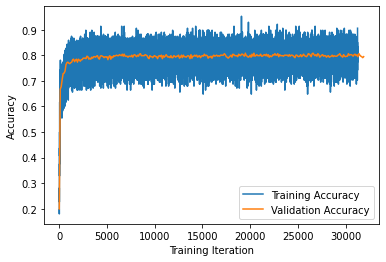

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()